In [1]:
!nvidia-smi

Mon Feb 26 23:49:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   54C    P8              25W / 215W |    513MiB /  8192MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
data_dir = '../data/data_preprocessed/esd/features_4balanced/'

sr = 16000

data_x = np.load(f'{data_dir}esd.audio16k.npy', 
                 allow_pickle=True)
data_y = np.load(f'{data_dir}esd.label_emotion.npy', 
                 allow_pickle=True)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 22400
Test: 5600


In [7]:
# np.save(f'{data_dir}esd.audio16k.train.npy', 
#         np.array(x_train, dtype=object), allow_pickle=True)
# np.save(f'{data_dir}esd.audio16k.test.npy', 
#         np.array(x_test, dtype=object), allow_pickle=True)
# np.save(f'{data_dir}esd.label_emotion.train.npy', 
#         np.array(y_train, dtype=object), allow_pickle=True)
# np.save(f'{data_dir}esd.label_emotion.test.npy', 
#         np.array(y_test, dtype=object), allow_pickle=True)

In [7]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [8]:
np.unique(y_test)

array(['anger', 'hapiness', 'neutral', 'sadness'], dtype='<U8')

In [9]:
labels = ['ang', 'neu', 'sad', 'hap']

In [10]:
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).flatten(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [11]:
import traceback

In [12]:
from IConNet.nn.model import M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M13', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [128, 32], 'kernel_size': [511, 127], 'stride': [8, 2], 'window_k': [2, 9], 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256], 'norm_type': 'LayerNorm'}}


M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm):

In [13]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [14]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [15]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                               | 0.001142857142857143/10 [00:00<1:23:02, 498.26s/it]

Train Epoch: 1 [0/22400 (0%)]	Loss: 1.436523
Mem before-during-after: 635392 1778487296 33706496


  0%|                               | 0.023999999999999983/10 [00:09<1:02:16, 374.57s/it]

Train Epoch: 1 [640/22400 (3%)]	Loss: 1.495797
Mem before-during-after: 34050560 1789899264 33673728


  0%|▏                                | 0.046857142857142785/10 [00:17<59:58, 361.58s/it]

Train Epoch: 1 [1280/22400 (6%)]	Loss: 1.514405
Mem before-during-after: 33673728 1789110784 33901056


  1%|▏                               | 0.06971428571428559/10 [00:26<1:03:32, 383.95s/it]

Train Epoch: 1 [1920/22400 (9%)]	Loss: 1.354796
Mem before-during-after: 33673728 1790042624 33837568


  1%|▎                               | 0.09257142857142839/10 [00:34<1:01:17, 371.21s/it]

Train Epoch: 1 [2560/22400 (11%)]	Loss: 1.364864
Mem before-during-after: 33853952 1788932608 33755648


  1%|▎                               | 0.11542857142857119/10 [00:43<1:01:29, 373.27s/it]

Train Epoch: 1 [3200/22400 (14%)]	Loss: 1.421602
Mem before-during-after: 34886144 1787818496 33690112


  1%|▍                               | 0.13828571428571432/10 [00:51<1:00:15, 366.57s/it]

Train Epoch: 1 [3840/22400 (17%)]	Loss: 1.439465
Mem before-during-after: 33935872 1789927936 33673728


  2%|▌                               | 0.16114285714285767/10 [01:00<1:01:54, 377.57s/it]

Train Epoch: 1 [4480/22400 (20%)]	Loss: 1.893137
Mem before-during-after: 33673728 1789960704 33673728


  2%|▌                               | 0.18400000000000102/10 [01:08<1:00:10, 367.81s/it]

Train Epoch: 1 [5120/22400 (23%)]	Loss: 1.284904
Mem before-during-after: 33772032 1636658176 33673728


  2%|▋                                 | 0.20685714285714438/10 [01:17<57:15, 350.81s/it]

Train Epoch: 1 [5760/22400 (26%)]	Loss: 1.475454
Mem before-during-after: 33690112 1571531264 33673728


  2%|▊                                 | 0.22971428571428773/10 [01:25<59:20, 364.44s/it]

Train Epoch: 1 [6400/22400 (29%)]	Loss: 1.361339
Mem before-during-after: 33673728 1789829632 33673728


  3%|▊                               | 0.25257142857143094/10 [01:34<1:00:53, 374.84s/it]

Train Epoch: 1 [7040/22400 (31%)]	Loss: 1.379374
Mem before-during-after: 33690112 1789895168 33673728


  3%|▉                                  | 0.2754285714285732/10 [01:42<59:28, 366.93s/it]

Train Epoch: 1 [7680/22400 (34%)]	Loss: 1.512572
Mem before-during-after: 33673728 1790939648 33903104


  3%|█                                 | 0.29828571428571543/10 [01:50<58:28, 361.68s/it]

Train Epoch: 1 [8320/22400 (37%)]	Loss: 1.289964
Mem before-during-after: 33919488 1789862400 33673728


  3%|█                                  | 0.3211428571428577/10 [01:59<58:51, 364.90s/it]

Train Epoch: 1 [8960/22400 (40%)]	Loss: 1.202633
Mem before-during-after: 33673728 1789960704 33804800


  3%|█▏                                 | 0.3439999999999999/10 [02:07<58:08, 361.24s/it]

Train Epoch: 1 [9600/22400 (43%)]	Loss: 1.422267
Mem before-during-after: 33673728 1789112832 34214400


  4%|█▏                                | 0.36685714285714216/10 [02:15<58:40, 365.50s/it]

Train Epoch: 1 [10240/22400 (46%)]	Loss: 1.479760
Mem before-during-after: 33690112 1787818496 33968640


  4%|█▎                                 | 0.3897142857142844/10 [02:24<58:03, 362.53s/it]

Train Epoch: 1 [10880/22400 (49%)]	Loss: 1.291639
Mem before-during-after: 34210304 1789944320 33673728


  4%|█▍                                | 0.41257142857142665/10 [02:32<57:42, 361.12s/it]

Train Epoch: 1 [11520/22400 (51%)]	Loss: 1.285757
Mem before-during-after: 34001408 1789895168 33673728


  4%|█▌                                 | 0.4354285714285689/10 [02:40<57:43, 362.11s/it]

Train Epoch: 1 [12160/22400 (54%)]	Loss: 1.260026
Mem before-during-after: 33690112 1788637696 33739264


  5%|█▌                                | 0.45828571428571113/10 [02:49<57:27, 361.29s/it]

Train Epoch: 1 [12800/22400 (57%)]	Loss: 1.195698
Mem before-during-after: 34105856 1789030912 34088448


  5%|█▋                                 | 0.4811428571428534/10 [02:57<56:38, 357.05s/it]

Train Epoch: 1 [13440/22400 (60%)]	Loss: 1.190953
Mem before-during-after: 33755648 1788867072 33968640


  5%|█▊                                 | 0.5039999999999957/10 [03:05<56:03, 354.17s/it]

Train Epoch: 1 [14080/22400 (63%)]	Loss: 1.253693
Mem before-during-after: 33706496 1789360128 33690112


  5%|█▊                                 | 0.5268571428571379/10 [03:14<57:00, 361.12s/it]

Train Epoch: 1 [14720/22400 (66%)]	Loss: 1.293704
Mem before-during-after: 33673728 1788932608 33673728


  5%|█▊                               | 0.5491428571428516/10 [03:22<1:00:48, 386.07s/it]

Train Epoch: 1 [15360/22400 (69%)]	Loss: 1.334124
Mem before-during-after: 33837568 1788785152 33673728


  6%|██                                 | 0.5725714285714224/10 [03:30<58:01, 369.25s/it]

Train Epoch: 1 [16000/22400 (71%)]	Loss: 1.266784
Mem before-during-after: 33673728 1788604928 33706496


  6%|██                                 | 0.5954285714285646/10 [03:39<55:18, 352.91s/it]

Train Epoch: 1 [16640/22400 (74%)]	Loss: 1.354484
Mem before-during-after: 33690112 1691181568 34186752


  6%|██▏                                | 0.6182857142857069/10 [03:47<55:36, 355.62s/it]

Train Epoch: 1 [17280/22400 (77%)]	Loss: 1.149984
Mem before-during-after: 33690112 1788146688 33673728


  6%|██▏                                | 0.6411428571428491/10 [03:55<56:08, 359.96s/it]

Train Epoch: 1 [17920/22400 (80%)]	Loss: 1.324030
Mem before-during-after: 33968640 1788834304 33673728


  7%|██▎                                | 0.6639999999999914/10 [04:03<57:11, 367.60s/it]

Train Epoch: 1 [18560/22400 (83%)]	Loss: 1.195128
Mem before-during-after: 34246144 1789326848 33690112


  7%|██▍                                | 0.6868571428571336/10 [04:12<55:18, 356.34s/it]

Train Epoch: 1 [19200/22400 (86%)]	Loss: 1.158627
Mem before-during-after: 33690112 1788604928 33706496


  7%|██▍                                | 0.7097142857142759/10 [04:20<56:11, 362.93s/it]

Train Epoch: 1 [19840/22400 (89%)]	Loss: 1.383095
Mem before-during-after: 33690112 1788113920 34247680


  7%|██▌                                | 0.7325714285714181/10 [04:28<55:55, 362.10s/it]

Train Epoch: 1 [20480/22400 (91%)]	Loss: 1.444913
Mem before-during-after: 33804800 1652030464 33673728


  8%|██▋                                | 0.7554285714285603/10 [04:37<55:17, 358.90s/it]

Train Epoch: 1 [21120/22400 (94%)]	Loss: 1.511122
Mem before-during-after: 33690112 1789215232 33673728


  8%|██▋                                | 0.7782857142857026/10 [04:45<56:36, 368.29s/it]

Train Epoch: 1 [21760/22400 (97%)]	Loss: 1.174533
Mem before-during-after: 33723904 1789895168 33690112


 10%|███▍                               | 0.9999999999999823/10 [05:51<43:39, 291.01s/it]


Test Epoch: 1	Accuracy: 2228/5600 (40%)



 10%|███▌                               | 1.0011428571428396/10 [05:51<48:20, 322.28s/it]

Train Epoch: 2 [0/22400 (0%)]	Loss: 1.324741
Mem before-during-after: 33666560 1787671040 33690112


 10%|███▌                               | 1.0239999999999863/10 [06:00<54:46, 366.18s/it]

Train Epoch: 2 [640/22400 (3%)]	Loss: 1.137238
Mem before-during-after: 33690112 1789932032 33985024


 10%|███▊                                | 1.046857142857133/10 [06:08<53:11, 356.49s/it]

Train Epoch: 2 [1280/22400 (6%)]	Loss: 1.232768
Mem before-during-after: 33920512 1789146624 33788416


 11%|███▋                               | 1.0697142857142796/10 [06:16<54:23, 365.42s/it]

Train Epoch: 2 [1920/22400 (9%)]	Loss: 1.128798
Mem before-during-after: 33706496 1771880448 33698304


 11%|███▊                               | 1.0925714285714263/10 [06:25<52:36, 354.40s/it]

Train Epoch: 2 [2560/22400 (11%)]	Loss: 1.240269
Mem before-during-after: 34248704 1790220800 33673728


 11%|████                                | 1.115428571428573/10 [06:33<54:05, 365.25s/it]

Train Epoch: 2 [3200/22400 (14%)]	Loss: 1.257388
Mem before-during-after: 33690112 1788867072 33788416


 11%|███▉                               | 1.1382857142857197/10 [06:42<54:48, 371.07s/it]

Train Epoch: 2 [3840/22400 (17%)]	Loss: 1.014802
Mem before-during-after: 33673728 1788572160 33673728


 12%|████                               | 1.1611428571428664/10 [06:50<53:40, 364.33s/it]

Train Epoch: 2 [4480/22400 (20%)]	Loss: 1.232972
Mem before-during-after: 33673728 1789129216 33690112


 12%|████▎                               | 1.184000000000013/10 [06:59<53:12, 362.18s/it]

Train Epoch: 2 [5120/22400 (23%)]	Loss: 1.320152
Mem before-during-after: 33673728 1788867072 33968640


 12%|████▏                              | 1.2068571428571597/10 [07:07<52:48, 360.39s/it]

Train Epoch: 2 [5760/22400 (26%)]	Loss: 1.158595
Mem before-during-after: 34001408 1788948992 33903104


 12%|████▎                              | 1.2297142857143064/10 [07:15<52:35, 359.82s/it]

Train Epoch: 2 [6400/22400 (29%)]	Loss: 1.680454
Mem before-during-after: 33755648 1584863744 33821184


 13%|████▌                               | 1.252571428571453/10 [07:24<54:10, 371.60s/it]

Train Epoch: 2 [7040/22400 (31%)]	Loss: 1.232941
Mem before-during-after: 33690112 1788785152 33870336


 13%|████▌                               | 1.274857142857171/10 [07:32<55:34, 382.14s/it]

Train Epoch: 2 [7680/22400 (34%)]	Loss: 1.309179
Mem before-during-after: 33706496 1745159680 33673728


 13%|████▌                              | 1.2982857142857465/10 [07:40<53:10, 366.67s/it]

Train Epoch: 2 [8320/22400 (37%)]	Loss: 1.134529
Mem before-during-after: 33722880 1788621312 33673728


 13%|████▌                              | 1.3211428571428931/10 [07:49<52:50, 365.26s/it]

Train Epoch: 2 [8960/22400 (40%)]	Loss: 1.302511
Mem before-during-after: 33804800 1788752384 33690112


 13%|████▋                              | 1.3440000000000398/10 [07:57<53:05, 368.00s/it]

Train Epoch: 2 [9600/22400 (43%)]	Loss: 1.066434
Mem before-during-after: 33968640 1789387264 33673728


 14%|████▊                              | 1.3668571428571865/10 [08:05<51:05, 355.07s/it]

Train Epoch: 2 [10240/22400 (46%)]	Loss: 1.089280
Mem before-during-after: 33724928 1789549056 33673728


 14%|████▊                              | 1.3897142857143332/10 [08:14<51:50, 361.21s/it]

Train Epoch: 2 [10880/22400 (49%)]	Loss: 1.215323
Mem before-during-after: 34001408 1789030912 33837568


 14%|████▉                              | 1.4125714285714799/10 [08:22<51:01, 356.54s/it]

Train Epoch: 2 [11520/22400 (51%)]	Loss: 1.245776
Mem before-during-after: 34398720 1789080576 34182144


 14%|█████▏                              | 1.434857142857198/10 [08:30<55:53, 391.51s/it]

Train Epoch: 2 [12160/22400 (54%)]	Loss: 1.048666
Mem before-during-after: 33690112 1789190656 33673728


 15%|█████                              | 1.4582857142857732/10 [08:38<51:08, 359.22s/it]

Train Epoch: 2 [12800/22400 (57%)]	Loss: 1.389627
Mem before-during-after: 33870336 1788867072 33788416


 15%|█████▍                               | 1.48114285714292/10 [08:47<52:16, 368.22s/it]

Train Epoch: 2 [13440/22400 (60%)]	Loss: 1.164518
Mem before-during-after: 33722880 1789403648 33722880


 15%|█████▎                             | 1.5040000000000666/10 [08:55<51:04, 360.69s/it]

Train Epoch: 2 [14080/22400 (63%)]	Loss: 1.165256
Mem before-during-after: 33837568 1789518336 33673728


 15%|█████▎                             | 1.5268571428572133/10 [09:03<51:10, 362.43s/it]

Train Epoch: 2 [14720/22400 (66%)]	Loss: 1.514478
Mem before-during-after: 33690112 1788867072 33690112


 15%|█████▋                               | 1.54971428571436/10 [09:12<51:45, 367.48s/it]

Train Epoch: 2 [15360/22400 (69%)]	Loss: 1.205692
Mem before-during-after: 33673728 1788588544 33690112


 16%|█████▌                             | 1.5725714285715067/10 [09:20<50:14, 357.69s/it]

Train Epoch: 2 [16000/22400 (71%)]	Loss: 1.642280
Mem before-during-after: 33673728 1761910784 34251264


 16%|█████▌                             | 1.5954285714286534/10 [09:28<50:44, 362.24s/it]

Train Epoch: 2 [16640/22400 (74%)]	Loss: 1.211527
Mem before-during-after: 33673728 1788785152 33690112


 16%|██████▏                               | 1.6182857142858/10 [09:36<50:16, 359.87s/it]

Train Epoch: 2 [17280/22400 (77%)]	Loss: 1.264717
Mem before-during-after: 33673728 1789383168 33690112


 16%|█████▋                             | 1.6411428571429467/10 [09:45<49:04, 352.25s/it]

Train Epoch: 2 [17920/22400 (80%)]	Loss: 1.283106
Mem before-during-after: 35082752 1789030912 33673728


 17%|█████▊                             | 1.6640000000000934/10 [09:53<49:26, 355.85s/it]

Train Epoch: 2 [18560/22400 (83%)]	Loss: 1.428335
Mem before-during-after: 33690112 1788572160 33673728


 17%|██████▏                              | 1.68685714285724/10 [10:01<49:44, 358.98s/it]

Train Epoch: 2 [19200/22400 (86%)]	Loss: 1.246802
Mem before-during-after: 33935872 1789420032 33673728


 17%|█████▉                             | 1.7097142857143868/10 [10:09<50:48, 367.71s/it]

Train Epoch: 2 [19840/22400 (89%)]	Loss: 1.539557
Mem before-during-after: 33673728 1788572160 33673728


 17%|██████                             | 1.7325714285715335/10 [10:18<50:28, 366.27s/it]

Train Epoch: 2 [20480/22400 (91%)]	Loss: 1.097680
Mem before-during-after: 34132480 1789518336 33690112


 18%|██████▏                            | 1.7554285714286801/10 [10:26<48:59, 356.54s/it]

Train Epoch: 2 [21120/22400 (94%)]	Loss: 1.286933
Mem before-during-after: 33952256 1789436416 34001408


 18%|██████▏                            | 1.7782857142858268/10 [10:34<49:35, 361.85s/it]

Train Epoch: 2 [21760/22400 (97%)]	Loss: 1.129456
Mem before-during-after: 33673728 1789145600 34247168


 20%|███████                            | 2.0000000000001497/10 [11:40<40:33, 304.17s/it]


Test Epoch: 2	Accuracy: 2226/5600 (40%)



 20%|███████                            | 2.0011428571430065/10 [11:41<43:45, 328.20s/it]

Train Epoch: 3 [0/22400 (0%)]	Loss: 1.292207
Mem before-during-after: 33666560 1787671040 33690112


 20%|███████                            | 2.0240000000001444/10 [11:49<47:58, 360.93s/it]

Train Epoch: 3 [640/22400 (3%)]	Loss: 1.176863
Mem before-during-after: 33722880 1789960704 33804800


 20%|███████▎                            | 2.046857142857282/10 [11:57<47:47, 360.50s/it]

Train Epoch: 3 [1280/22400 (6%)]	Loss: 1.499050
Mem before-during-after: 34066432 1788899840 33690112


 21%|███████▋                             | 2.06971428571442/10 [12:06<48:27, 366.66s/it]

Train Epoch: 3 [1920/22400 (9%)]	Loss: 1.085288
Mem before-during-after: 33853952 1788981760 33706496


 21%|███████▎                           | 2.0925714285715578/10 [12:14<47:02, 356.97s/it]

Train Epoch: 3 [2560/22400 (11%)]	Loss: 1.108671
Mem before-during-after: 34267648 1790255616 33870336


 21%|███████▌                            | 2.114857142857267/10 [12:22<51:14, 389.97s/it]

Train Epoch: 3 [3200/22400 (14%)]	Loss: 1.301583
Mem before-during-after: 33673728 1788998144 34099712


 21%|███████▍                           | 2.1382857142858334/10 [12:31<47:08, 359.77s/it]

Train Epoch: 3 [3840/22400 (17%)]	Loss: 1.235090
Mem before-during-after: 33673728 1760915456 33690112


 22%|███████▊                            | 2.161142857142971/10 [12:39<47:13, 361.44s/it]

Train Epoch: 3 [4480/22400 (20%)]	Loss: 1.247502
Mem before-during-after: 33870336 1718414848 33853952


 22%|███████▊                            | 2.184000000000109/10 [12:47<47:43, 366.40s/it]

Train Epoch: 3 [5120/22400 (23%)]	Loss: 1.473863
Mem before-during-after: 33673728 1734389760 33968640


 22%|███████▋                           | 2.2068571428572468/10 [12:56<47:00, 361.93s/it]

Train Epoch: 3 [5760/22400 (26%)]	Loss: 1.185482
Mem before-during-after: 33952256 1788899840 34001408


 22%|███████▊                           | 2.2297142857143846/10 [13:04<46:05, 355.88s/it]

Train Epoch: 3 [6400/22400 (29%)]	Loss: 1.358467
Mem before-during-after: 34132480 1788998144 33853952


 23%|███████▉                           | 2.2525714285715224/10 [13:12<46:43, 361.90s/it]

Train Epoch: 3 [7040/22400 (31%)]	Loss: 1.301535
Mem before-during-after: 33673728 1787736576 33706496


 23%|████████▍                            | 2.27542857142866/10 [13:21<46:35, 361.89s/it]

Train Epoch: 3 [7680/22400 (34%)]	Loss: 1.436009
Mem before-during-after: 33673728 1788785152 33886720


 23%|████████▎                           | 2.298285714285798/10 [13:29<46:39, 363.46s/it]

Train Epoch: 3 [8320/22400 (37%)]	Loss: 1.218093
Mem before-during-after: 34001408 1788867072 33837568


 23%|████████▎                           | 2.321142857142936/10 [13:37<45:46, 357.69s/it]

Train Epoch: 3 [8960/22400 (40%)]	Loss: 1.086429
Mem before-during-after: 33853952 1789428224 33706496


 23%|████████▏                          | 2.3440000000000736/10 [13:46<46:51, 367.21s/it]

Train Epoch: 3 [9600/22400 (43%)]	Loss: 1.057040
Mem before-during-after: 33772032 1788867072 33690112


 24%|████████▎                          | 2.3668571428572114/10 [13:54<45:39, 358.84s/it]

Train Epoch: 3 [10240/22400 (46%)]	Loss: 1.284008
Mem before-during-after: 33690112 1788834304 33673728


 24%|████████▎                          | 2.3891428571429207/10 [14:02<48:39, 383.64s/it]

Train Epoch: 3 [10880/22400 (49%)]	Loss: 1.144225
Mem before-during-after: 34083328 1788502528 33772032


 24%|████████▋                           | 2.412571428571487/10 [14:10<45:33, 360.26s/it]

Train Epoch: 3 [11520/22400 (51%)]	Loss: 1.314789
Mem before-during-after: 33706496 1788244480 34394624


 24%|████████▊                           | 2.435428571428625/10 [14:19<45:43, 362.66s/it]

Train Epoch: 3 [12160/22400 (54%)]	Loss: 1.150674
Mem before-during-after: 33837568 1788535296 33673728


 25%|████████▌                          | 2.4582857142857626/10 [14:27<44:36, 354.87s/it]

Train Epoch: 3 [12800/22400 (57%)]	Loss: 1.355292
Mem before-during-after: 33690112 1583094272 34099712


 25%|████████▋                          | 2.4811428571429004/10 [14:35<45:38, 364.28s/it]

Train Epoch: 3 [13440/22400 (60%)]	Loss: 1.143659
Mem before-during-after: 33673728 1787900416 33673728


 25%|█████████                           | 2.504000000000038/10 [14:44<44:16, 354.38s/it]

Train Epoch: 3 [14080/22400 (63%)]	Loss: 1.052403
Mem before-during-after: 33837568 1787544064 33690112


 25%|█████████                           | 2.526857142857176/10 [14:52<44:52, 360.27s/it]

Train Epoch: 3 [14720/22400 (66%)]	Loss: 1.207308
Mem before-during-after: 33690112 1787523584 33673728


 25%|█████████▏                          | 2.549714285714314/10 [15:00<44:57, 362.11s/it]

Train Epoch: 3 [15360/22400 (69%)]	Loss: 0.951369
Mem before-during-after: 33673728 1788076544 33673728


 26%|█████████                          | 2.5725714285714516/10 [15:08<44:24, 358.74s/it]

Train Epoch: 3 [16000/22400 (71%)]	Loss: 1.243751
Mem before-during-after: 33673728 1787539968 33673728


 26%|█████████                          | 2.5954285714285894/10 [15:17<43:58, 356.37s/it]

Train Epoch: 3 [16640/22400 (74%)]	Loss: 1.344411
Mem before-during-after: 33673728 1734025216 34099712


 26%|█████████▍                          | 2.618285714285727/10 [15:25<44:51, 364.68s/it]

Train Epoch: 3 [17280/22400 (77%)]	Loss: 1.399597
Mem before-during-after: 33673728 1788387840 34001408


 26%|█████████▌                          | 2.641142857142865/10 [15:33<44:26, 362.36s/it]

Train Epoch: 3 [17920/22400 (80%)]	Loss: 1.160359
Mem before-during-after: 34034176 1789047296 33690112


 27%|█████████▎                         | 2.6634285714285744/10 [15:41<47:34, 389.05s/it]

Train Epoch: 3 [18560/22400 (83%)]	Loss: 1.056817
Mem before-during-after: 33853952 1788981760 33690112


 27%|█████████▍                         | 2.6868571428571406/10 [15:50<43:22, 355.81s/it]

Train Epoch: 3 [19200/22400 (86%)]	Loss: 1.322738
Mem before-during-after: 34001408 1788867072 33853952


 27%|█████████▍                         | 2.7097142857142784/10 [15:58<44:16, 364.36s/it]

Train Epoch: 3 [19840/22400 (89%)]	Loss: 1.277553
Mem before-during-after: 33673728 1788867072 33673728


 27%|█████████▊                          | 2.732571428571416/10 [16:07<43:07, 356.08s/it]

Train Epoch: 3 [20480/22400 (91%)]	Loss: 1.229586
Mem before-during-after: 33673728 1584751104 34288128


 28%|█████████▉                          | 2.755428571428554/10 [16:15<43:42, 361.96s/it]

Train Epoch: 3 [21120/22400 (94%)]	Loss: 1.458022
Mem before-during-after: 33968640 1788899840 34001408


 28%|██████████                          | 2.778285714285692/10 [16:23<43:25, 360.75s/it]

Train Epoch: 3 [21760/22400 (97%)]	Loss: 1.149369
Mem before-during-after: 33788416 1789178368 34279936


 30%|██████████▍                        | 2.9999999999999285/10 [17:29<34:01, 291.65s/it]


Test Epoch: 3	Accuracy: 2294/5600 (41%)



 30%|██████████▌                        | 3.0011428571427854/10 [17:30<35:14, 302.11s/it]

Train Epoch: 4 [0/22400 (0%)]	Loss: 1.713030
Mem before-during-after: 33666560 1787671040 33690112


 30%|██████████▉                         | 3.023999999999923/10 [17:38<42:12, 362.97s/it]

Train Epoch: 4 [640/22400 (3%)]	Loss: 1.336230
Mem before-during-after: 33690112 1789948416 33706496


 30%|██████████▉                         | 3.046857142857061/10 [17:46<41:14, 355.85s/it]

Train Epoch: 4 [1280/22400 (6%)]	Loss: 1.214541
Mem before-during-after: 34174464 1789485568 33690112


 31%|███████████                         | 3.069714285714199/10 [17:54<42:03, 364.12s/it]

Train Epoch: 4 [1920/22400 (9%)]	Loss: 1.260363
Mem before-during-after: 33804800 1788588544 33690112


 31%|██████████▊                        | 3.0925714285713366/10 [18:03<42:04, 365.51s/it]

Train Epoch: 4 [2560/22400 (11%)]	Loss: 1.280213
Mem before-during-after: 33755648 1789174272 33673728


 31%|██████████▉                        | 3.1154285714284744/10 [18:11<42:13, 367.94s/it]

Train Epoch: 4 [3200/22400 (14%)]	Loss: 1.217592
Mem before-during-after: 33706496 1789125120 33690112


 31%|███████████▎                        | 3.138285714285612/10 [18:20<41:41, 364.50s/it]

Train Epoch: 4 [3840/22400 (17%)]	Loss: 0.954741
Mem before-during-after: 33837568 1789125120 33690112


 32%|███████████▋                         | 3.16114285714275/10 [18:28<41:28, 363.87s/it]

Train Epoch: 4 [4480/22400 (20%)]	Loss: 1.595459
Mem before-during-after: 34001408 1788850688 33673728


 32%|███████████▏                       | 3.1834285714284594/10 [18:36<43:36, 383.89s/it]

Train Epoch: 4 [5120/22400 (23%)]	Loss: 1.333847
Mem before-during-after: 33952256 1789420032 33690112


 32%|███████████▏                       | 3.2068571428570256/10 [18:45<41:05, 362.93s/it]

Train Epoch: 4 [5760/22400 (26%)]	Loss: 1.357299
Mem before-during-after: 33706496 1788834304 33673728


 32%|███████████▎                       | 3.2297142857141634/10 [18:53<39:56, 353.91s/it]

Train Epoch: 4 [6400/22400 (29%)]	Loss: 1.129707
Mem before-during-after: 33673728 1788948992 33755648


 33%|███████████▋                        | 3.252571428571301/10 [19:01<40:32, 360.55s/it]

Train Epoch: 4 [7040/22400 (31%)]	Loss: 1.032335
Mem before-during-after: 33673728 1789714944 33722880


 33%|███████████▊                        | 3.275428571428439/10 [19:10<40:56, 365.33s/it]

Train Epoch: 4 [7680/22400 (34%)]	Loss: 1.368494
Mem before-during-after: 33772032 1772474368 33763840


 33%|███████████▊                        | 3.298285714285577/10 [19:18<40:42, 364.45s/it]

Train Epoch: 4 [8320/22400 (37%)]	Loss: 1.015863
Mem before-during-after: 33690112 1790188032 33821184


 33%|███████████▌                       | 3.3211428571427146/10 [19:26<40:17, 361.95s/it]

Train Epoch: 4 [8960/22400 (40%)]	Loss: 0.993591
Mem before-during-after: 33985024 1789420032 33706496


 33%|███████████▋                       | 3.3439999999998524/10 [19:35<40:56, 369.03s/it]

Train Epoch: 4 [9600/22400 (43%)]	Loss: 1.280743
Mem before-during-after: 33673728 1789583872 33804800


 34%|███████████▊                       | 3.3668571428569902/10 [19:43<40:33, 366.85s/it]

Train Epoch: 4 [10240/22400 (46%)]	Loss: 1.265891
Mem before-during-after: 33673728 1744633856 33690112


 34%|████████████▏                       | 3.389714285714128/10 [19:51<39:06, 355.03s/it]

Train Epoch: 4 [10880/22400 (49%)]	Loss: 1.028339
Mem before-during-after: 33903104 1788604928 33706496


 34%|████████████▎                       | 3.412571428571266/10 [19:59<40:30, 369.00s/it]

Train Epoch: 4 [11520/22400 (51%)]	Loss: 1.091946
Mem before-during-after: 34001408 1788899840 33722880


 34%|████████████                       | 3.4354285714284036/10 [20:08<40:08, 366.83s/it]

Train Epoch: 4 [12160/22400 (54%)]	Loss: 1.296078
Mem before-during-after: 33690112 1789567488 33837568


 35%|████████████                       | 3.4582857142855414/10 [20:16<39:54, 366.11s/it]

Train Epoch: 4 [12800/22400 (57%)]	Loss: 1.230778
Mem before-during-after: 33690112 1789403648 33673728


 35%|████████████▏                      | 3.4811428571426792/10 [20:24<39:07, 360.17s/it]

Train Epoch: 4 [13440/22400 (60%)]	Loss: 1.029556
Mem before-during-after: 34001408 1788850688 33673728


 35%|████████████▌                       | 3.503999999999817/10 [20:33<38:14, 353.17s/it]

Train Epoch: 4 [14080/22400 (63%)]	Loss: 1.805430
Mem before-during-after: 33788416 1788893696 33995264


 35%|████████████▋                       | 3.526857142856955/10 [20:41<39:15, 363.92s/it]

Train Epoch: 4 [14720/22400 (66%)]	Loss: 1.152449
Mem before-during-after: 33673728 1788867072 33673728


 35%|████████████▍                      | 3.5497142857140926/10 [20:49<37:54, 352.67s/it]

Train Epoch: 4 [15360/22400 (69%)]	Loss: 1.105303
Mem before-during-after: 33673728 1789256192 33821184


 36%|████████████▌                      | 3.5725714285712304/10 [20:57<38:37, 360.52s/it]

Train Epoch: 4 [16000/22400 (71%)]	Loss: 1.209479
Mem before-during-after: 33985024 1789346304 33706496


 36%|████████████▌                      | 3.5954285714283682/10 [21:06<38:28, 360.42s/it]

Train Epoch: 4 [16640/22400 (74%)]	Loss: 1.144840
Mem before-during-after: 33673728 1789682176 34247168


 36%|█████████████                       | 3.618285714285506/10 [21:14<38:05, 358.15s/it]

Train Epoch: 4 [17280/22400 (77%)]	Loss: 1.126568
Mem before-during-after: 33919488 1789469184 33673728


 36%|█████████████                       | 3.641142857142644/10 [21:23<38:42, 365.29s/it]

Train Epoch: 4 [17920/22400 (80%)]	Loss: 1.487502
Mem before-during-after: 33755648 1788592640 33690112


 37%|████████████▊                      | 3.6639999999997817/10 [21:31<38:27, 364.24s/it]

Train Epoch: 4 [18560/22400 (83%)]	Loss: 1.282616
Mem before-during-after: 33722880 1789551104 33952256


 37%|████████████▉                      | 3.6868571428569195/10 [21:39<39:00, 370.69s/it]

Train Epoch: 4 [19200/22400 (86%)]	Loss: 1.093847
Mem before-during-after: 33690112 1681690112 33943040


 37%|████████████▉                      | 3.7097142857140573/10 [21:48<38:11, 364.22s/it]

Train Epoch: 4 [19840/22400 (89%)]	Loss: 1.156851
Mem before-during-after: 33985024 1680732672 33690112


 37%|█████████████▍                      | 3.732571428571195/10 [21:56<37:52, 362.53s/it]

Train Epoch: 4 [20480/22400 (91%)]	Loss: 1.395380
Mem before-during-after: 33722880 1789682176 33690112


 38%|█████████████▏                     | 3.7548571428569044/10 [22:04<40:27, 388.70s/it]

Train Epoch: 4 [21120/22400 (94%)]	Loss: 1.169942
Mem before-during-after: 33706496 1789518336 33673728


 38%|█████████████▏                     | 3.7782857142854707/10 [22:13<37:04, 357.57s/it]

Train Epoch: 4 [21760/22400 (97%)]	Loss: 1.187443
Mem before-during-after: 33673728 1789436416 33690112


 40%|█████████████▉                     | 3.9999999999997073/10 [23:19<28:25, 284.32s/it]


Test Epoch: 4	Accuracy: 2447/5600 (44%)



 40%|██████████████▍                     | 4.001142857142565/10 [23:19<31:07, 311.36s/it]

Train Epoch: 5 [0/22400 (0%)]	Loss: 0.941601
Mem before-during-after: 33666560 1787671040 33690112


 40%|██████████████▉                      | 4.02399999999972/10 [23:28<36:04, 362.26s/it]

Train Epoch: 5 [640/22400 (3%)]	Loss: 1.249963
Mem before-during-after: 33821184 1789981184 34034176


 40%|██████████████▌                     | 4.046857142856876/10 [23:36<36:03, 363.50s/it]

Train Epoch: 5 [1280/22400 (6%)]	Loss: 1.048824
Mem before-during-after: 33739264 1790046720 33837568


 41%|██████████████▋                     | 4.069714285714031/10 [23:44<36:18, 367.39s/it]

Train Epoch: 5 [1920/22400 (9%)]	Loss: 1.095024
Mem before-during-after: 33837568 1789915648 33968640


 41%|██████████████▋                     | 4.092571428571187/10 [23:53<35:58, 365.31s/it]

Train Epoch: 5 [2560/22400 (11%)]	Loss: 1.164388
Mem before-during-after: 34001408 1789915648 33870336


 41%|██████████████▍                    | 4.1154285714283425/10 [24:01<36:24, 371.19s/it]

Train Epoch: 5 [3200/22400 (14%)]	Loss: 0.971016
Mem before-during-after: 34001408 1789915648 33870336


 41%|██████████████▉                     | 4.138285714285498/10 [24:09<35:22, 362.10s/it]

Train Epoch: 5 [3840/22400 (17%)]	Loss: 1.380664
Mem before-during-after: 33853952 1789387264 33952256


 42%|██████████████▉                     | 4.161142857142654/10 [24:18<35:34, 365.53s/it]

Train Epoch: 5 [4480/22400 (20%)]	Loss: 1.069686
Mem before-during-after: 34001408 1789403648 33968640


 42%|███████████████                     | 4.183999999999809/10 [24:26<35:06, 362.23s/it]

Train Epoch: 5 [5120/22400 (23%)]	Loss: 1.151805
Mem before-during-after: 33804800 1788654080 33673728


 42%|███████████████▏                    | 4.206857142856965/10 [24:34<34:20, 355.75s/it]

Train Epoch: 5 [5760/22400 (26%)]	Loss: 1.136997
Mem before-during-after: 33690112 1681178112 33926656


 42%|███████████████▋                     | 4.22971428571412/10 [24:43<35:05, 364.93s/it]

Train Epoch: 5 [6400/22400 (29%)]	Loss: 1.200570
Mem before-during-after: 33985024 1788899840 33804800


 43%|███████████████▎                    | 4.252571428571276/10 [24:51<34:55, 364.66s/it]

Train Epoch: 5 [7040/22400 (31%)]	Loss: 1.126634
Mem before-during-after: 33706496 1789174272 33690112


 43%|██████████████▉                    | 4.2754285714284315/10 [24:59<34:55, 366.12s/it]

Train Epoch: 5 [7680/22400 (34%)]	Loss: 1.019284
Mem before-during-after: 33690112 1788654080 33673728


 43%|███████████████▍                    | 4.298285714285587/10 [25:08<33:31, 352.77s/it]

Train Epoch: 5 [8320/22400 (37%)]	Loss: 1.252403
Mem before-during-after: 34194944 1789518336 33690112


 43%|███████████████▌                    | 4.321142857142743/10 [25:16<35:24, 374.12s/it]

Train Epoch: 5 [8960/22400 (40%)]	Loss: 1.086855
Mem before-during-after: 33690112 1789567488 33886720


 43%|███████████████▋                    | 4.343999999999898/10 [25:24<35:29, 376.46s/it]

Train Epoch: 5 [9600/22400 (43%)]	Loss: 1.297307
Mem before-during-after: 33985024 1789403648 33690112


 44%|███████████████▋                    | 4.366857142857054/10 [25:33<34:08, 363.58s/it]

Train Epoch: 5 [10240/22400 (46%)]	Loss: 1.260316
Mem before-during-after: 33690112 1789469184 33837568


 44%|███████████████▊                    | 4.389714285714209/10 [25:41<33:18, 356.27s/it]

Train Epoch: 5 [10880/22400 (49%)]	Loss: 1.233608
Mem before-during-after: 33820160 1788915200 33836544


 44%|███████████████▉                    | 4.412571428571365/10 [25:49<33:59, 364.95s/it]

Train Epoch: 5 [11520/22400 (51%)]	Loss: 0.960883
Mem before-during-after: 33821184 1788703232 33804800


 44%|████████████████▍                    | 4.43542857142852/10 [25:58<33:21, 359.68s/it]

Train Epoch: 5 [12160/22400 (54%)]	Loss: 1.335657
Mem before-during-after: 33673728 1789108736 33673728


 45%|████████████████                    | 4.457714285714247/10 [26:06<36:10, 391.59s/it]

Train Epoch: 5 [12800/22400 (57%)]	Loss: 1.123206
Mem before-during-after: 33956352 1788854784 33673728


 45%|████████████████▏                   | 4.481142857142832/10 [26:14<32:54, 357.74s/it]

Train Epoch: 5 [13440/22400 (60%)]	Loss: 1.322537
Mem before-during-after: 33690112 1663285248 33673728


 45%|████████████████▏                   | 4.503999999999987/10 [26:23<33:07, 361.65s/it]

Train Epoch: 5 [14080/22400 (63%)]	Loss: 1.196239
Mem before-during-after: 33935872 1789534720 34050560


 45%|████████████████▎                   | 4.526285714285714/10 [26:31<34:54, 382.71s/it]

Train Epoch: 5 [14720/22400 (66%)]	Loss: 1.000109
Mem before-during-after: 34677248 1788097024 33690112


 45%|████████████████▍                   | 4.549714285714298/10 [26:39<33:48, 372.10s/it]

Train Epoch: 5 [15360/22400 (69%)]	Loss: 1.331106
Mem before-during-after: 33690112 1800135168 33690112


 46%|████████████████▍                   | 4.572571428571454/10 [26:48<33:44, 373.02s/it]

Train Epoch: 5 [16000/22400 (71%)]	Loss: 1.057853
Mem before-during-after: 34034176 1789321728 33673728


 46%|████████████████▌                   | 4.595428571428609/10 [26:56<33:17, 369.55s/it]

Train Epoch: 5 [16640/22400 (74%)]	Loss: 1.311674
Mem before-during-after: 33673728 1788752384 33673728


 46%|████████████████▋                   | 4.618285714285765/10 [27:05<32:59, 367.86s/it]

Train Epoch: 5 [17280/22400 (77%)]	Loss: 1.339122
Mem before-during-after: 33690112 1788703232 33804800


 46%|████████████████▏                  | 4.6411428571429205/10 [27:13<32:23, 362.72s/it]

Train Epoch: 5 [17920/22400 (80%)]	Loss: 1.134274
Mem before-during-after: 33870336 1680712192 34722304


 47%|████████████████▊                   | 4.664000000000076/10 [27:21<31:19, 352.25s/it]

Train Epoch: 5 [18560/22400 (83%)]	Loss: 1.442681
Mem before-during-after: 33690112 1609736704 33673728


 47%|████████████████▊                   | 4.686857142857232/10 [27:29<32:30, 367.09s/it]

Train Epoch: 5 [19200/22400 (86%)]	Loss: 1.103608
Mem before-during-after: 33673728 1789436416 34001408


 47%|████████████████▉                   | 4.709714285714387/10 [27:38<32:22, 367.18s/it]

Train Epoch: 5 [19840/22400 (89%)]	Loss: 1.226699
Mem before-during-after: 33690112 1789125120 33690112


 47%|█████████████████                   | 4.732571428571543/10 [27:46<31:54, 363.49s/it]

Train Epoch: 5 [20480/22400 (91%)]	Loss: 1.212003
Mem before-during-after: 33690112 1681189376 34755072


 48%|█████████████████                   | 4.755428571428698/10 [27:54<31:21, 358.78s/it]

Train Epoch: 5 [21120/22400 (94%)]	Loss: 1.250690
Mem before-during-after: 33690112 1789108736 33673728


 48%|█████████████████▏                  | 4.778285714285854/10 [28:03<31:30, 362.05s/it]

Train Epoch: 5 [21760/22400 (97%)]	Loss: 1.218892
Mem before-during-after: 33706496 1789632000 34733568


 50%|██████████████████                  | 5.000000000000263/10 [29:09<24:07, 289.46s/it]


Test Epoch: 5	Accuracy: 2412/5600 (43%)



 50%|██████████████████                  | 5.001142857143121/10 [29:10<26:14, 314.92s/it]

Train Epoch: 6 [0/22400 (0%)]	Loss: 1.182156
Mem before-during-after: 33666560 1787671040 33690112


 50%|██████████████████                  | 5.024000000000276/10 [29:18<30:14, 364.58s/it]

Train Epoch: 6 [640/22400 (3%)]	Loss: 1.262371
Mem before-during-after: 33706496 1789911552 33706496


 50%|██████████████████▏                 | 5.046857142857432/10 [29:26<29:49, 361.36s/it]

Train Epoch: 6 [1280/22400 (6%)]	Loss: 1.201617
Mem before-during-after: 33886720 1789977088 33739264


 51%|██████████████████▎                 | 5.069714285714587/10 [29:35<29:29, 358.92s/it]

Train Epoch: 6 [1920/22400 (9%)]	Loss: 1.051946
Mem before-during-after: 33690112 1789895168 33968640


 51%|██████████████████▎                 | 5.092571428571743/10 [29:43<29:39, 362.54s/it]

Train Epoch: 6 [2560/22400 (11%)]	Loss: 1.110642
Mem before-during-after: 33837568 1788867072 33870336


 51%|█████████████████▉                 | 5.1154285714288985/10 [29:51<29:01, 356.44s/it]

Train Epoch: 6 [3200/22400 (14%)]	Loss: 1.313725
Mem before-during-after: 33690112 1789112832 34214400


 51%|██████████████████▍                 | 5.138285714286054/10 [29:59<28:27, 351.30s/it]

Train Epoch: 6 [3840/22400 (17%)]	Loss: 1.260238
Mem before-during-after: 33690112 1583127040 34132480


 52%|███████████████████                  | 5.16114285714321/10 [30:08<29:03, 360.41s/it]

Train Epoch: 6 [4480/22400 (20%)]	Loss: 1.323806
Mem before-during-after: 33673728 1788899840 34001408


 52%|██████████████████▋                 | 5.184000000000365/10 [30:16<28:41, 357.43s/it]

Train Epoch: 6 [5120/22400 (23%)]	Loss: 1.125883
Mem before-during-after: 33673728 1734680576 33706496


 52%|██████████████████▋                 | 5.206857142857521/10 [30:24<28:44, 359.80s/it]

Train Epoch: 6 [5760/22400 (26%)]	Loss: 0.929707
Mem before-during-after: 33706496 1788969472 33804800


 52%|██████████████████▊                 | 5.229714285714676/10 [30:32<28:13, 354.95s/it]

Train Epoch: 6 [6400/22400 (29%)]	Loss: 1.399553
Mem before-during-after: 34017792 1691467264 34573824


 53%|██████████████████▉                 | 5.252571428571832/10 [30:41<28:41, 362.72s/it]

Train Epoch: 6 [7040/22400 (31%)]	Loss: 1.282913
Mem before-during-after: 33706496 1788752384 33853952


 53%|██████████████████▍                | 5.2754285714289875/10 [30:49<28:35, 363.15s/it]

Train Epoch: 6 [7680/22400 (34%)]	Loss: 1.352085
Mem before-during-after: 34132480 1788981760 33690112


 53%|███████████████████                 | 5.298285714286143/10 [30:57<28:26, 363.02s/it]

Train Epoch: 6 [8320/22400 (37%)]	Loss: 1.287304
Mem before-during-after: 33886720 1789261824 34363392


 53%|███████████████████▏                | 5.321142857143299/10 [31:06<27:49, 356.84s/it]

Train Epoch: 6 [8960/22400 (40%)]	Loss: 1.707238
Mem before-during-after: 34259456 1788486144 33703936


 53%|███████████████████▏                | 5.344000000000454/10 [31:14<27:45, 357.81s/it]

Train Epoch: 6 [9600/22400 (43%)]	Loss: 1.098871
Mem before-during-after: 33673728 1788588544 33690112


 54%|███████████████████▊                 | 5.36685714285761/10 [31:22<27:54, 361.45s/it]

Train Epoch: 6 [10240/22400 (46%)]	Loss: 1.235291
Mem before-during-after: 33673728 1788654080 33755648


 54%|███████████████████▍                | 5.389714285714765/10 [31:30<27:35, 359.13s/it]

Train Epoch: 6 [10880/22400 (49%)]	Loss: 1.000689
Mem before-during-after: 33673728 1762189824 34251264


 54%|███████████████████▍                | 5.412571428571921/10 [31:39<27:28, 359.43s/it]

Train Epoch: 6 [11520/22400 (51%)]	Loss: 1.067325
Mem before-during-after: 33706496 1788588544 33690112


 54%|███████████████████▌                | 5.435428571429076/10 [31:47<27:27, 360.88s/it]

Train Epoch: 6 [12160/22400 (54%)]	Loss: 1.171304
Mem before-during-after: 33804800 1788654080 33673728


 55%|███████████████████▋                | 5.458285714286232/10 [31:55<26:55, 355.70s/it]

Train Epoch: 6 [12800/22400 (57%)]	Loss: 1.179130
Mem before-during-after: 34089472 1787802112 33706496


 55%|███████████████████▋                | 5.481142857143388/10 [32:03<27:01, 358.88s/it]

Train Epoch: 6 [13440/22400 (60%)]	Loss: 1.161210
Mem before-during-after: 33690112 1788654080 33755648


 55%|███████████████████▊                | 5.504000000000543/10 [32:12<26:47, 357.53s/it]

Train Epoch: 6 [14080/22400 (63%)]	Loss: 1.523780
Mem before-during-after: 33690112 1789846016 34218496


 55%|███████████████████▉                | 5.526857142857699/10 [32:20<26:27, 355.00s/it]

Train Epoch: 6 [14720/22400 (66%)]	Loss: 1.063468
Mem before-during-after: 33903104 1789030912 34083328


 55%|███████████████████▉                | 5.549714285714854/10 [32:28<26:40, 359.71s/it]

Train Epoch: 6 [15360/22400 (69%)]	Loss: 1.069916
Mem before-during-after: 34193920 1787802112 33690112


 56%|████████████████████▌                | 5.57257142857201/10 [32:37<26:19, 356.69s/it]

Train Epoch: 6 [16000/22400 (71%)]	Loss: 0.986199
Mem before-during-after: 33706496 1788867072 33968640


 56%|████████████████████▏               | 5.595428571429165/10 [32:45<26:25, 360.02s/it]

Train Epoch: 6 [16640/22400 (74%)]	Loss: 1.439171
Mem before-during-after: 33673728 1788899840 34001408


 56%|████████████████████▏               | 5.618285714286321/10 [32:53<26:45, 366.50s/it]

Train Epoch: 6 [17280/22400 (77%)]	Loss: 1.282595
Mem before-during-after: 33673728 1788588544 33690112


 56%|███████████████████▋               | 5.6411428571434765/10 [33:02<26:16, 361.68s/it]

Train Epoch: 6 [17920/22400 (80%)]	Loss: 1.107056
Mem before-during-after: 33935872 1788883456 33985024


 57%|████████████████████▍               | 5.664000000000632/10 [33:10<26:56, 372.90s/it]

Train Epoch: 6 [18560/22400 (83%)]	Loss: 1.357884
Mem before-during-after: 33853952 1788883456 33673728


 57%|████████████████████▍               | 5.686857142857788/10 [33:18<25:57, 361.13s/it]

Train Epoch: 6 [19200/22400 (86%)]	Loss: 1.163907
Mem before-during-after: 33690112 1788588544 33690112


 57%|████████████████████▌               | 5.709714285714943/10 [33:27<26:25, 369.54s/it]

Train Epoch: 6 [19840/22400 (89%)]	Loss: 1.127938
Mem before-during-after: 33690112 1789325824 33886720


 57%|████████████████████▋               | 5.732571428572099/10 [33:35<25:17, 355.50s/it]

Train Epoch: 6 [20480/22400 (91%)]	Loss: 1.316418
Mem before-during-after: 33673728 1789347328 34448896


 58%|████████████████████▋               | 5.755428571429254/10 [33:43<25:30, 360.48s/it]

Train Epoch: 6 [21120/22400 (94%)]	Loss: 1.186648
Mem before-during-after: 33673728 1788719616 33673728


 58%|█████████████████████▍               | 5.77828571428641/10 [33:52<25:52, 367.68s/it]

Train Epoch: 6 [21760/22400 (97%)]	Loss: 1.143561
Mem before-during-after: 33997312 1788604928 33706496


 60%|█████████████████████▌              | 6.000000000000819/10 [34:58<19:22, 290.64s/it]


Test Epoch: 6	Accuracy: 2713/5600 (48%)



 60%|█████████████████████▌              | 6.001142857143677/10 [34:58<21:11, 317.90s/it]

Train Epoch: 7 [0/22400 (0%)]	Loss: 1.498648
Mem before-during-after: 33666560 1717953024 33690112


 60%|█████████████████████▋              | 6.024000000000832/10 [35:07<24:31, 370.07s/it]

Train Epoch: 7 [640/22400 (3%)]	Loss: 1.254756
Mem before-during-after: 33837568 1788006912 33772032


 60%|█████████████████████▊              | 6.046857142857988/10 [35:15<23:32, 357.33s/it]

Train Epoch: 7 [1280/22400 (6%)]	Loss: 1.169490
Mem before-during-after: 33985024 1788056064 33690112


 61%|█████████████████████▊              | 6.069714285715143/10 [35:23<23:34, 359.78s/it]

Train Epoch: 7 [1920/22400 (9%)]	Loss: 1.008931
Mem before-during-after: 34116096 1799340032 33804800


 61%|█████████████████████▉              | 6.092571428572299/10 [35:31<23:07, 355.21s/it]

Train Epoch: 7 [2560/22400 (11%)]	Loss: 1.091934
Mem before-during-after: 34050560 1787720192 33690112


 61%|█████████████████████▍             | 6.1154285714294545/10 [35:39<23:09, 357.61s/it]

Train Epoch: 7 [3200/22400 (14%)]	Loss: 1.266634
Mem before-during-after: 33788416 1787974144 33673728


 61%|██████████████████████▋              | 6.13828571428661/10 [35:48<22:56, 356.44s/it]

Train Epoch: 7 [3840/22400 (17%)]	Loss: 0.833717
Mem before-during-after: 33772032 1788006912 33772032


 62%|██████████████████████▏             | 6.161142857143766/10 [35:56<23:12, 362.73s/it]

Train Epoch: 7 [4480/22400 (20%)]	Loss: 1.243961
Mem before-during-after: 33690112 1788879360 33985024


 62%|██████████████████████▎             | 6.184000000000921/10 [36:04<23:21, 367.17s/it]

Train Epoch: 7 [5120/22400 (23%)]	Loss: 0.909911
Mem before-during-after: 33690112 1788240384 33690112


 62%|██████████████████████▎             | 6.206857142858077/10 [36:13<22:37, 357.88s/it]

Train Epoch: 7 [5760/22400 (26%)]	Loss: 1.016958
Mem before-during-after: 34001408 1788879360 33690112


 62%|██████████████████████▍             | 6.229714285715232/10 [36:21<23:11, 369.02s/it]

Train Epoch: 7 [6400/22400 (29%)]	Loss: 1.152206
Mem before-during-after: 33755648 1788551680 33673728


 63%|██████████████████████▌             | 6.252571428572388/10 [36:29<22:15, 356.41s/it]

Train Epoch: 7 [7040/22400 (31%)]	Loss: 1.178917
Mem before-during-after: 34738688 1787937280 33690112


 63%|█████████████████████▉             | 6.2754285714295435/10 [36:38<22:29, 362.45s/it]

Train Epoch: 7 [7680/22400 (34%)]	Loss: 1.169967
Mem before-during-after: 33673728 1625304064 33673728


 63%|██████████████████████▋             | 6.298285714286699/10 [36:46<23:03, 373.87s/it]

Train Epoch: 7 [8320/22400 (37%)]	Loss: 1.041618
Mem before-during-after: 33690112 1788981760 34103808


 63%|██████████████████████▊             | 6.320571428572426/10 [36:54<23:47, 387.97s/it]

Train Epoch: 7 [8960/22400 (40%)]	Loss: 1.176865
Mem before-during-after: 33673728 1788846592 33886720


 63%|███████████████████████▍             | 6.34400000000101/10 [37:03<22:06, 362.89s/it]

Train Epoch: 7 [9600/22400 (43%)]	Loss: 1.352060
Mem before-during-after: 34382336 1791922688 33690112


 64%|██████████████████████▉             | 6.366857142858166/10 [37:11<22:04, 364.64s/it]

Train Epoch: 7 [10240/22400 (46%)]	Loss: 1.144838
Mem before-during-after: 34099712 1788759552 33772032


 64%|███████████████████████             | 6.389714285715321/10 [37:19<21:34, 358.55s/it]

Train Epoch: 7 [10880/22400 (49%)]	Loss: 1.093836
Mem before-during-after: 33673728 1788568064 33673728


 64%|███████████████████████             | 6.412571428572477/10 [37:28<21:13, 355.01s/it]

Train Epoch: 7 [11520/22400 (51%)]	Loss: 1.092007
Mem before-during-after: 33690112 1789426176 34548224


 64%|██████████████████████▌            | 6.4348571428582035/10 [37:36<23:33, 396.37s/it]

Train Epoch: 7 [12160/22400 (54%)]	Loss: 1.169621
Mem before-during-after: 33673728 1788682752 33804800


 65%|███████████████████████▏            | 6.458285714286788/10 [37:44<21:22, 362.21s/it]

Train Epoch: 7 [12800/22400 (57%)]	Loss: 1.147802
Mem before-during-after: 33673728 1626690048 35223552


 65%|███████████████████████▎            | 6.481142857143944/10 [37:53<21:09, 360.68s/it]

Train Epoch: 7 [13440/22400 (60%)]	Loss: 1.202072
Mem before-during-after: 33853952 1788584448 34083328


 65%|███████████████████████▍            | 6.504000000001099/10 [38:01<20:54, 358.70s/it]

Train Epoch: 7 [14080/22400 (63%)]	Loss: 1.377186
Mem before-during-after: 33956352 1788834304 33956352


 65%|███████████████████████▍            | 6.526857142858255/10 [38:09<20:50, 360.09s/it]

Train Epoch: 7 [14720/22400 (66%)]	Loss: 0.885637
Mem before-during-after: 34198016 1788912128 33739264


 65%|████████████████████████▏            | 6.54971428571541/10 [38:17<20:38, 358.93s/it]

Train Epoch: 7 [15360/22400 (69%)]	Loss: 0.875058
Mem before-during-after: 33825792 1788994048 33673728


 66%|███████████████████████▋            | 6.572571428572566/10 [38:26<20:49, 364.45s/it]

Train Epoch: 7 [16000/22400 (71%)]	Loss: 1.063461
Mem before-during-after: 33673728 1788551680 33673728


 66%|███████████████████████▋            | 6.595428571429721/10 [38:34<20:01, 353.00s/it]

Train Epoch: 7 [16640/22400 (74%)]	Loss: 1.105304
Mem before-during-after: 33690112 1787736576 33788416


 66%|███████████████████████▊            | 6.618285714286877/10 [38:42<20:17, 360.10s/it]

Train Epoch: 7 [17280/22400 (77%)]	Loss: 1.216014
Mem before-during-after: 34162688 1789776384 33673728


 66%|███████████████████████▉            | 6.640571428572604/10 [38:50<22:01, 393.31s/it]

Train Epoch: 7 [17920/22400 (80%)]	Loss: 1.238027
Mem before-during-after: 33673728 1788666368 33788416


 67%|███████████████████████▉            | 6.664000000001188/10 [38:59<19:52, 357.53s/it]

Train Epoch: 7 [18560/22400 (83%)]	Loss: 1.030740
Mem before-during-after: 34120192 1788584448 33706496


 67%|████████████████████████            | 6.686857142858344/10 [39:07<19:51, 359.53s/it]

Train Epoch: 7 [19200/22400 (86%)]	Loss: 1.322628
Mem before-during-after: 33673728 1788731904 33673728


 67%|████████████████████████▏           | 6.709714285715499/10 [39:15<19:50, 361.94s/it]

Train Epoch: 7 [19840/22400 (89%)]	Loss: 1.077329
Mem before-during-after: 34001408 1789010432 33722880


 67%|████████████████████████▏           | 6.732571428572655/10 [39:23<19:03, 350.09s/it]

Train Epoch: 7 [20480/22400 (91%)]	Loss: 0.963736
Mem before-during-after: 33800704 1789960704 34779648


 68%|████████████████████████▉            | 6.75542857142981/10 [39:31<19:03, 352.39s/it]

Train Epoch: 7 [21120/22400 (94%)]	Loss: 1.021431
Mem before-during-after: 34132480 1788961280 33690112


 68%|████████████████████████▍           | 6.778285714286966/10 [39:40<19:21, 360.59s/it]

Train Epoch: 7 [21760/22400 (97%)]	Loss: 1.023783
Mem before-during-after: 33935872 1788862976 33690112


 70%|█████████████████████████▏          | 7.000000000001375/10 [40:46<14:29, 289.85s/it]


Test Epoch: 7	Accuracy: 2381/5600 (43%)



 70%|█████████████████████████▏          | 7.001142857144233/10 [40:46<15:21, 307.35s/it]

Train Epoch: 8 [0/22400 (0%)]	Loss: 1.113797
Mem before-during-after: 33666560 1787671040 33690112


 70%|█████████████████████████▎          | 7.024000000001388/10 [40:54<18:00, 362.91s/it]

Train Epoch: 8 [640/22400 (3%)]	Loss: 0.855231
Mem before-during-after: 33985024 1789993472 33755648


 70%|█████████████████████████▎          | 7.046857142858544/10 [41:02<17:40, 359.07s/it]

Train Epoch: 8 [1280/22400 (6%)]	Loss: 1.208335
Mem before-during-after: 33755648 1789895168 33968640


 71%|█████████████████████████▍          | 7.069714285715699/10 [41:11<17:55, 367.17s/it]

Train Epoch: 8 [1920/22400 (9%)]	Loss: 0.994011
Mem before-during-after: 34116096 1788768768 33755648


 71%|█████████████████████████▌          | 7.092571428572855/10 [41:19<17:15, 356.04s/it]

Train Epoch: 8 [2560/22400 (11%)]	Loss: 1.116445
Mem before-during-after: 33690112 1788883456 33673728


 71%|█████████████████████████▌          | 7.114857142858582/10 [41:27<18:35, 386.66s/it]

Train Epoch: 8 [3200/22400 (14%)]	Loss: 1.418719
Mem before-during-after: 34017792 1735277056 34774016


 71%|█████████████████████████▋          | 7.138285714287166/10 [41:36<17:03, 357.63s/it]

Train Epoch: 8 [3840/22400 (17%)]	Loss: 1.139912
Mem before-during-after: 33706496 1788834304 33673728


 72%|█████████████████████████▊          | 7.161142857144322/10 [41:44<16:54, 357.23s/it]

Train Epoch: 8 [4480/22400 (20%)]	Loss: 1.233641
Mem before-during-after: 33706496 1787686912 33706496


 72%|█████████████████████████▊          | 7.184000000001477/10 [41:52<16:47, 357.66s/it]

Train Epoch: 8 [5120/22400 (23%)]	Loss: 0.940551
Mem before-during-after: 34234880 1789502976 33690112


 72%|█████████████████████████▉          | 7.206857142858633/10 [42:00<17:10, 368.77s/it]

Train Epoch: 8 [5760/22400 (26%)]	Loss: 1.119815
Mem before-during-after: 33673728 1788604928 33673728


 72%|██████████████████████████          | 7.229714285715788/10 [42:08<16:23, 355.12s/it]

Train Epoch: 8 [6400/22400 (29%)]	Loss: 1.182251
Mem before-during-after: 33690112 1772325376 33706496


 73%|██████████████████████████          | 7.252571428572944/10 [42:17<16:36, 362.82s/it]

Train Epoch: 8 [7040/22400 (31%)]	Loss: 1.165028
Mem before-during-after: 33804800 1788588544 33690112


 73%|█████████████████████████▍         | 7.2754285714300995/10 [42:25<16:03, 353.69s/it]

Train Epoch: 8 [7680/22400 (34%)]	Loss: 1.242084
Mem before-during-after: 33690112 1788768768 33690112


 73%|██████████████████████████▎         | 7.298285714287255/10 [42:33<16:06, 357.73s/it]

Train Epoch: 8 [8320/22400 (37%)]	Loss: 0.984531
Mem before-during-after: 33853952 1788867072 33690112


 73%|██████████████████████████▎         | 7.321142857144411/10 [42:41<16:03, 359.53s/it]

Train Epoch: 8 [8960/22400 (40%)]	Loss: 0.985339
Mem before-during-after: 34132480 1788752384 33673728


 73%|██████████████████████████▍         | 7.344000000001566/10 [42:50<16:40, 376.54s/it]

Train Epoch: 8 [9600/22400 (43%)]	Loss: 0.652635
Mem before-during-after: 34001408 1788850688 33673728


 74%|██████████████████████████▌         | 7.366857142858722/10 [42:58<15:45, 358.90s/it]

Train Epoch: 8 [10240/22400 (46%)]	Loss: 0.835817
Mem before-during-after: 33673728 1788899840 33673728


 74%|██████████████████████████▌         | 7.389714285715877/10 [43:06<15:33, 357.67s/it]

Train Epoch: 8 [10880/22400 (49%)]	Loss: 0.781383
Mem before-during-after: 33706496 1788256768 33690112


 74%|██████████████████████████▋         | 7.412571428573033/10 [43:15<15:13, 353.03s/it]

Train Epoch: 8 [11520/22400 (51%)]	Loss: 1.164256
Mem before-during-after: 33673728 1788883456 33673728


 74%|██████████████████████████▊         | 7.435428571430188/10 [43:23<15:11, 355.36s/it]

Train Epoch: 8 [12160/22400 (54%)]	Loss: 1.085404
Mem before-during-after: 33673728 1788899840 33673728


 75%|██████████████████████████▊         | 7.458285714287344/10 [43:31<15:08, 357.42s/it]

Train Epoch: 8 [12800/22400 (57%)]	Loss: 1.164416
Mem before-during-after: 33952256 1788899840 33673728


 75%|████████████████████████████▍         | 7.4811428571445/10 [43:39<14:48, 352.67s/it]

Train Epoch: 8 [13440/22400 (60%)]	Loss: 1.143531
Mem before-during-after: 33706496 1788862976 33985024


 75%|███████████████████████████         | 7.504000000001655/10 [43:47<15:06, 363.30s/it]

Train Epoch: 8 [14080/22400 (63%)]	Loss: 1.043743
Mem before-during-after: 33673728 1788572160 33673728


 75%|███████████████████████████         | 7.526857142858811/10 [43:56<14:33, 353.35s/it]

Train Epoch: 8 [14720/22400 (66%)]	Loss: 1.218754
Mem before-during-after: 33853952 1788981760 34083328


 75%|███████████████████████████▏        | 7.549714285715966/10 [44:04<14:55, 365.39s/it]

Train Epoch: 8 [15360/22400 (69%)]	Loss: 1.091884
Mem before-during-after: 33706496 1664222720 33690112


 76%|███████████████████████████▎        | 7.572571428573122/10 [44:12<14:19, 354.19s/it]

Train Epoch: 8 [16000/22400 (71%)]	Loss: 1.198542
Mem before-during-after: 33985024 1788572160 33673728


 76%|███████████████████████████▎        | 7.595428571430277/10 [44:20<15:01, 374.88s/it]

Train Epoch: 8 [16640/22400 (74%)]	Loss: 1.452393
Mem before-during-after: 33804800 1789030912 33886720


 76%|███████████████████████████▍        | 7.618285714287433/10 [44:29<14:36, 368.01s/it]

Train Epoch: 8 [17280/22400 (77%)]	Loss: 1.228546
Mem before-during-after: 33690112 1789030912 33853952


 76%|██████████████████████████▋        | 7.6411428571445885/10 [44:37<14:16, 363.31s/it]

Train Epoch: 8 [17920/22400 (80%)]	Loss: 1.225341
Mem before-during-after: 33722880 1788916224 33853952


 77%|███████████████████████████▌        | 7.664000000001744/10 [44:45<13:57, 358.73s/it]

Train Epoch: 8 [18560/22400 (83%)]	Loss: 1.266465
Mem before-during-after: 33812992 1788998144 33714688


 77%|█████████████████████████████▏        | 7.6868571428589/10 [44:53<13:47, 357.91s/it]

Train Epoch: 8 [19200/22400 (86%)]	Loss: 1.482413
Mem before-during-after: 33837568 1788604928 33706496


 77%|███████████████████████████▊        | 7.709714285716055/10 [45:02<13:37, 357.09s/it]

Train Epoch: 8 [19840/22400 (89%)]	Loss: 1.252765
Mem before-during-after: 33690112 1789063680 33804800


 77%|███████████████████████████▊        | 7.732571428573211/10 [45:10<13:30, 357.30s/it]

Train Epoch: 8 [20480/22400 (91%)]	Loss: 0.813659
Mem before-during-after: 33673728 1788899840 34001408


 78%|███████████████████████████▉        | 7.755428571430366/10 [45:18<13:34, 362.81s/it]

Train Epoch: 8 [21120/22400 (94%)]	Loss: 1.077662
Mem before-during-after: 33968640 1789047296 33690112


 78%|████████████████████████████        | 7.778285714287522/10 [45:26<13:07, 354.51s/it]

Train Epoch: 8 [21760/22400 (97%)]	Loss: 1.568590
Mem before-during-after: 33772032 1788785152 33788416


 80%|████████████████████████████▊       | 8.000000000001931/10 [46:32<09:39, 289.51s/it]


Test Epoch: 8	Accuracy: 2805/5600 (50%)



 80%|████████████████████████████▊       | 8.001142857144787/10 [46:33<10:23, 311.70s/it]

Train Epoch: 9 [0/22400 (0%)]	Loss: 1.005692
Mem before-during-after: 33666560 1787671040 33690112


 80%|████████████████████████████▉       | 8.024000000001907/10 [46:41<12:01, 365.36s/it]

Train Epoch: 9 [640/22400 (3%)]	Loss: 1.283309
Mem before-during-after: 33673728 1789600256 33673728


 80%|████████████████████████████▉       | 8.046857142859027/10 [46:49<11:42, 359.63s/it]

Train Epoch: 9 [1280/22400 (6%)]	Loss: 1.095528
Mem before-during-after: 33739264 1790059008 33837568


 81%|█████████████████████████████       | 8.069142857144719/10 [46:57<12:16, 381.43s/it]

Train Epoch: 9 [1920/22400 (9%)]	Loss: 1.195761
Mem before-during-after: 33722880 1680454144 33722880


 81%|█████████████████████████████▏      | 8.092571428573267/10 [47:06<11:14, 353.65s/it]

Train Epoch: 9 [2560/22400 (11%)]	Loss: 0.788810
Mem before-during-after: 33690112 1681091072 33970176


 81%|█████████████████████████████▏      | 8.115428571430387/10 [47:14<11:41, 372.13s/it]

Train Epoch: 9 [3200/22400 (14%)]	Loss: 1.039007
Mem before-during-after: 33673728 1788965376 33804800


 81%|█████████████████████████████▎      | 8.138285714287507/10 [47:22<11:05, 357.58s/it]

Train Epoch: 9 [3840/22400 (17%)]	Loss: 1.243073
Mem before-during-after: 33673728 1789145600 33985024


 82%|█████████████████████████████▍      | 8.161142857144627/10 [47:31<10:56, 356.76s/it]

Train Epoch: 9 [4480/22400 (20%)]	Loss: 1.298826
Mem before-during-after: 33853952 1636156416 33690112


 82%|█████████████████████████████▍      | 8.184000000001747/10 [47:39<10:55, 360.95s/it]

Train Epoch: 9 [5120/22400 (23%)]	Loss: 1.062635
Mem before-during-after: 33853952 1762501120 34251264


 82%|█████████████████████████████▌      | 8.206857142858867/10 [47:47<10:43, 358.60s/it]

Train Epoch: 9 [5760/22400 (26%)]	Loss: 1.123030
Mem before-during-after: 33673728 1789377536 34479104


 82%|█████████████████████████████▋      | 8.229714285715987/10 [47:55<10:37, 360.35s/it]

Train Epoch: 9 [6400/22400 (29%)]	Loss: 0.904298
Mem before-during-after: 33673728 1788965376 33804800


 83%|█████████████████████████████▋      | 8.252571428573107/10 [48:04<10:31, 361.19s/it]

Train Epoch: 9 [7040/22400 (31%)]	Loss: 1.104773
Mem before-during-after: 33690112 1717411328 33706496


 83%|███████████████████████████████▍      | 8.2748571428588/10 [48:12<11:11, 389.14s/it]

Train Epoch: 9 [7680/22400 (34%)]	Loss: 0.859411
Mem before-during-after: 33772032 1788916224 33690112


 83%|█████████████████████████████▊      | 8.298285714287347/10 [48:20<10:28, 369.31s/it]

Train Epoch: 9 [8320/22400 (37%)]	Loss: 1.136113
Mem before-during-after: 33673728 1789080064 33804800


 83%|█████████████████████████████▉      | 8.321142857144467/10 [48:29<09:59, 357.19s/it]

Train Epoch: 9 [8960/22400 (40%)]	Loss: 0.862897
Mem before-during-after: 34001408 1789112832 33673728


 83%|██████████████████████████████      | 8.344000000001587/10 [48:37<09:59, 362.10s/it]

Train Epoch: 9 [9600/22400 (43%)]	Loss: 0.862095
Mem before-during-after: 34198016 1789063680 33886720


 84%|██████████████████████████████      | 8.366857142858708/10 [48:45<10:16, 377.43s/it]

Train Epoch: 9 [10240/22400 (46%)]	Loss: 0.935132
Mem before-during-after: 33673728 1789329920 34169344


 84%|██████████████████████████████▏     | 8.389714285715828/10 [48:54<09:57, 370.89s/it]

Train Epoch: 9 [10880/22400 (49%)]	Loss: 1.135242
Mem before-during-after: 33673728 1788850688 33673728


 84%|██████████████████████████████▎     | 8.412571428572948/10 [49:02<09:23, 355.19s/it]

Train Epoch: 9 [11520/22400 (51%)]	Loss: 1.132988
Mem before-during-after: 33673728 1788572160 33673728


 84%|███████████████████████████████▏     | 8.43485714285864/10 [49:10<10:11, 390.97s/it]

Train Epoch: 9 [12160/22400 (54%)]	Loss: 1.444999
Mem before-during-after: 33804800 1788883456 33968640


 85%|██████████████████████████████▍     | 8.458285714287188/10 [49:19<09:07, 355.22s/it]

Train Epoch: 9 [12800/22400 (57%)]	Loss: 1.162447
Mem before-during-after: 33673728 1788965376 33673728


 85%|██████████████████████████████▌     | 8.481142857144308/10 [49:27<08:56, 353.50s/it]

Train Epoch: 9 [13440/22400 (60%)]	Loss: 1.458000
Mem before-during-after: 33772032 1744830464 33690112


 85%|██████████████████████████████▌     | 8.504000000001428/10 [49:35<08:57, 359.54s/it]

Train Epoch: 9 [14080/22400 (63%)]	Loss: 1.060942
Mem before-during-after: 33755648 1788785152 33886720


 85%|██████████████████████████████▋     | 8.526857142858548/10 [49:43<08:45, 356.65s/it]

Train Epoch: 9 [14720/22400 (66%)]	Loss: 0.965641
Mem before-during-after: 33690112 1788883456 33673728


 85%|██████████████████████████████▊     | 8.549714285715668/10 [49:52<08:47, 363.92s/it]

Train Epoch: 9 [15360/22400 (69%)]	Loss: 0.765386
Mem before-during-after: 33690112 1788768768 33690112


 86%|██████████████████████████████▊     | 8.572571428572788/10 [50:00<08:48, 369.93s/it]

Train Epoch: 9 [16000/22400 (71%)]	Loss: 0.841913
Mem before-during-after: 33673728 1788867072 33804800


 86%|██████████████████████████████▉     | 8.595428571429908/10 [50:08<08:20, 356.22s/it]

Train Epoch: 9 [16640/22400 (74%)]	Loss: 1.325395
Mem before-during-after: 33772032 1788867072 33788416


 86%|███████████████████████████████     | 8.618285714287028/10 [50:16<08:13, 357.12s/it]

Train Epoch: 9 [17280/22400 (77%)]	Loss: 1.036595
Mem before-during-after: 33690112 1788752384 33690112


 86%|███████████████████████████████     | 8.641142857144148/10 [50:25<08:10, 361.01s/it]

Train Epoch: 9 [17920/22400 (80%)]	Loss: 1.039455
Mem before-during-after: 33673728 1789047296 33853952


 87%|███████████████████████████████▏    | 8.664000000001268/10 [50:33<08:03, 361.73s/it]

Train Epoch: 9 [18560/22400 (83%)]	Loss: 1.194474
Mem before-during-after: 33739264 1789047296 33673728


 87%|███████████████████████████████▎    | 8.686857142858388/10 [50:41<07:59, 365.39s/it]

Train Epoch: 9 [19200/22400 (86%)]	Loss: 1.102915
Mem before-during-after: 34304512 1789202944 33985024


 87%|███████████████████████████████▎    | 8.709714285715508/10 [50:50<07:46, 361.84s/it]

Train Epoch: 9 [19840/22400 (89%)]	Loss: 0.866472
Mem before-during-after: 33673728 1788572160 33673728


 87%|███████████████████████████████▍    | 8.732571428572628/10 [50:58<07:35, 359.28s/it]

Train Epoch: 9 [20480/22400 (91%)]	Loss: 0.859112
Mem before-during-after: 33690112 1788916224 33690112


 88%|███████████████████████████████▌    | 8.755428571429748/10 [51:06<07:26, 358.63s/it]

Train Epoch: 9 [21120/22400 (94%)]	Loss: 0.988505
Mem before-during-after: 33673728 1788572160 33673728


 88%|███████████████████████████████▌    | 8.778285714286868/10 [51:14<07:18, 359.16s/it]

Train Epoch: 9 [21760/22400 (97%)]	Loss: 1.227780
Mem before-during-after: 34099712 1788867072 33673728


 90%|████████████████████████████████▍   | 9.000000000000933/10 [52:20<04:42, 282.09s/it]


Test Epoch: 9	Accuracy: 2836/5600 (51%)



 90%|████████████████████████████████▍   | 9.001142857143789/10 [52:21<05:05, 306.08s/it]

Train Epoch: 10 [0/22400 (0%)]	Loss: 1.110496
Mem before-during-after: 33666560 1787671040 33690112


 90%|████████████████████████████████▍   | 9.024000000000909/10 [52:29<05:57, 366.54s/it]

Train Epoch: 10 [640/22400 (3%)]	Loss: 1.008528
Mem before-during-after: 33964032 1790460416 34001408


 90%|████████████████████████████████▌   | 9.046857142858029/10 [52:37<05:42, 359.77s/it]

Train Epoch: 10 [1280/22400 (6%)]	Loss: 0.818516
Mem before-during-after: 33673728 1788867072 33870336


 91%|████████████████████████████████▋   | 9.069714285715149/10 [52:46<05:36, 361.47s/it]

Train Epoch: 10 [1920/22400 (9%)]	Loss: 1.030186
Mem before-during-after: 33690112 1789420032 33985024


 91%|████████████████████████████████▋   | 9.092571428572269/10 [52:54<05:20, 353.67s/it]

Train Epoch: 10 [2560/22400 (11%)]	Loss: 1.111123
Mem before-during-after: 34655232 1571166720 34558464


 91%|████████████████████████████████▊   | 9.115428571429389/10 [53:02<05:17, 359.13s/it]

Train Epoch: 10 [3200/22400 (14%)]	Loss: 0.834631
Mem before-during-after: 33788416 1789534720 34099712


 91%|████████████████████████████████▉   | 9.138285714286509/10 [53:11<05:12, 362.77s/it]

Train Epoch: 10 [3840/22400 (17%)]	Loss: 0.962524
Mem before-during-after: 33706496 1799258624 33837568


 92%|████████████████████████████████▉   | 9.161142857143629/10 [53:19<05:01, 358.87s/it]

Train Epoch: 10 [4480/22400 (20%)]	Loss: 1.280252
Mem before-during-after: 33853952 1788785152 33853952


 92%|█████████████████████████████████   | 9.184000000000749/10 [53:27<04:52, 358.40s/it]

Train Epoch: 10 [5120/22400 (23%)]	Loss: 1.189739
Mem before-during-after: 33673728 1788637696 33739264


 92%|█████████████████████████████████▏  | 9.206857142857869/10 [53:36<04:51, 367.01s/it]

Train Epoch: 10 [5760/22400 (26%)]	Loss: 1.113635
Mem before-during-after: 33673728 1788867072 33673728


 92%|█████████████████████████████████▏  | 9.229714285714989/10 [53:44<04:40, 364.60s/it]

Train Epoch: 10 [6400/22400 (29%)]	Loss: 1.237768
Mem before-during-after: 33673728 1761910784 34251264


 93%|█████████████████████████████████▎  | 9.252571428572109/10 [53:52<04:30, 362.50s/it]

Train Epoch: 10 [7040/22400 (31%)]	Loss: 0.997433
Mem before-during-after: 33690112 1788907008 33903104


 93%|█████████████████████████████████▍  | 9.275428571429229/10 [54:01<04:22, 361.96s/it]

Train Epoch: 10 [7680/22400 (34%)]	Loss: 1.176069
Mem before-during-after: 34099712 1744839680 33673728


 93%|█████████████████████████████████▍  | 9.298285714286349/10 [54:09<04:10, 356.37s/it]

Train Epoch: 10 [8320/22400 (37%)]	Loss: 1.063143
Mem before-during-after: 33690112 1788867072 33739264


 93%|██████████████████████████████████▍  | 9.32114285714347/10 [54:17<04:06, 363.15s/it]

Train Epoch: 10 [8960/22400 (40%)]	Loss: 1.124015
Mem before-during-after: 33673728 1789096448 34198016


 93%|█████████████████████████████████▋  | 9.343428571429161/10 [54:25<04:15, 389.71s/it]

Train Epoch: 10 [9600/22400 (43%)]	Loss: 1.075899
Mem before-during-after: 33853952 1789387264 33952256


 94%|██████████████████████████████████▋  | 9.36685714285771/10 [54:34<03:49, 361.80s/it]

Train Epoch: 10 [10240/22400 (46%)]	Loss: 1.078201
Mem before-during-after: 33690112 1788883456 33673728


 94%|██████████████████████████████████▋  | 9.38971428571483/10 [54:42<03:43, 366.29s/it]

Train Epoch: 10 [10880/22400 (49%)]	Loss: 1.224074
Mem before-during-after: 33673728 1789583872 33853952


 94%|██████████████████████████████████▊  | 9.41257142857195/10 [54:51<03:33, 363.61s/it]

Train Epoch: 10 [11520/22400 (51%)]	Loss: 0.931463
Mem before-during-after: 34185728 1789403648 33690112


 94%|█████████████████████████████████▉  | 9.434857142857641/10 [54:59<03:35, 380.92s/it]

Train Epoch: 10 [12160/22400 (54%)]	Loss: 1.217580
Mem before-during-after: 33673728 1789223424 33673728


 95%|██████████████████████████████████▉  | 9.45828571428619/10 [55:07<03:21, 372.01s/it]

Train Epoch: 10 [12800/22400 (57%)]	Loss: 1.200724
Mem before-during-after: 33673728 1788572160 33673728


 95%|███████████████████████████████████  | 9.48114285714331/10 [55:16<03:10, 366.71s/it]

Train Epoch: 10 [13440/22400 (60%)]	Loss: 1.012287
Mem before-during-after: 34083328 1789403648 33673728


 95%|███████████████████████████████████▏ | 9.50400000000043/10 [55:24<02:59, 361.29s/it]

Train Epoch: 10 [14080/22400 (63%)]	Loss: 1.112368
Mem before-during-after: 33690112 1789377024 34478592


 95%|███████████████████████████████████▏ | 9.52685714285755/10 [55:32<02:51, 362.44s/it]

Train Epoch: 10 [14720/22400 (66%)]	Loss: 1.030194
Mem before-during-after: 33722880 1790878208 33706496


 95%|███████████████████████████████████▎ | 9.54971428571467/10 [55:41<02:40, 356.07s/it]

Train Epoch: 10 [15360/22400 (69%)]	Loss: 0.917088
Mem before-during-after: 34100224 1789534720 33869824


 96%|███████████████████████████████████▍ | 9.57257142857179/10 [55:49<02:31, 354.18s/it]

Train Epoch: 10 [16000/22400 (71%)]	Loss: 1.168036
Mem before-during-after: 33743360 1788592640 33673728


 96%|███████████████████████████████████▌ | 9.59542857142891/10 [55:57<02:25, 359.62s/it]

Train Epoch: 10 [16640/22400 (74%)]	Loss: 1.283269
Mem before-during-after: 34001408 1789403648 33673728


 96%|███████████████████████████████████▌ | 9.61828571428603/10 [56:05<02:18, 362.77s/it]

Train Epoch: 10 [17280/22400 (77%)]	Loss: 1.185187
Mem before-during-after: 33886720 1789305344 33673728


 96%|███████████████████████████████████▋ | 9.64114285714315/10 [56:14<02:10, 362.64s/it]

Train Epoch: 10 [17920/22400 (80%)]	Loss: 0.946024
Mem before-during-after: 33673728 1788572160 33673728


 97%|███████████████████████████████████▊ | 9.66400000000027/10 [56:22<02:00, 358.49s/it]

Train Epoch: 10 [18560/22400 (83%)]	Loss: 0.991913
Mem before-during-after: 34001408 1706987008 33673728


 97%|███████████████████████████████████▊ | 9.68685714285739/10 [56:30<01:52, 360.80s/it]

Train Epoch: 10 [19200/22400 (86%)]	Loss: 0.908183
Mem before-during-after: 34034176 1788899840 33673728


 97%|███████████████████████████████████▉ | 9.70971428571451/10 [56:39<01:45, 363.00s/it]

Train Epoch: 10 [19840/22400 (89%)]	Loss: 0.905029
Mem before-during-after: 34083328 1789420032 33673728


 97%|████████████████████████████████████ | 9.73257142857163/10 [56:47<01:37, 363.57s/it]

Train Epoch: 10 [20480/22400 (91%)]	Loss: 1.059124
Mem before-during-after: 33673728 1788883456 33804800


 98%|████████████████████████████████████ | 9.75542857142875/10 [56:55<01:28, 362.73s/it]

Train Epoch: 10 [21120/22400 (94%)]	Loss: 1.211210
Mem before-during-after: 33673728 1789420032 33673728


 98%|████████████████████████████████████▏| 9.77828571428587/10 [57:04<01:19, 359.18s/it]

Train Epoch: 10 [21760/22400 (97%)]	Loss: 1.097487
Mem before-during-after: 33853952 1789436416 33673728


100%|███████████████████████████████████▉| 9.999999999999934/10 [58:09<00:00, 348.98s/it]


Test Epoch: 10	Accuracy: 2929/5600 (52%)



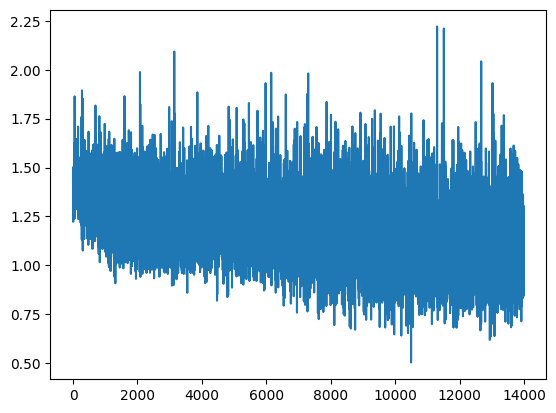

In [16]:
plt.plot(train_losses)

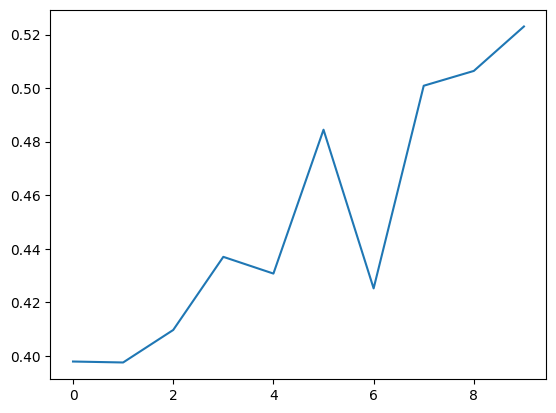

In [17]:
plt.plot(test_accuracy)

In [20]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc_unweighted': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),
        'rocauc_weighted': MulticlassAUROC(num_classes=n, average='weighted', thresholds=None),     
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [21]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 2929/5600 (0.5230)
{'acc_detail': tensor([0.5964, 0.5729, 0.6064, 0.3164], device='cuda:0'),
 'acc_unweighted': tensor(0.5230, device='cuda:0'),
 'acc_weighted': tensor(0.5230, device='cuda:0'),
 'f1s_detail': tensor([0.5878, 0.5348, 0.5906, 0.3565], device='cuda:0'),
 'f1s_unweighted': tensor(0.5175, device='cuda:0'),
 'f1s_weighted': tensor(0.5175, device='cuda:0'),
 'precision_detail': tensor([0.5795, 0.5016, 0.5756, 0.4083], device='cuda:0'),
 'recall_detail': tensor([0.5964, 0.5729, 0.6064, 0.3164], device='cuda:0'),
 'rocauc_detail': tensor([0.8287, 0.8054, 0.8248, 0.7090], device='cuda:0'),
 'rocauc_unweighted': tensor(0.7920, device='cuda:0'),
 'rocauc_weighted': tensor(0.7920, device='cuda:0'),
 'uar': tensor(0.5230, device='cuda:0'),
 'wap': tensor(0.5162, device='cuda:0')}


tensor([[835, 145, 117, 303],
        [ 29, 802, 371, 198],
        [104, 306, 849, 141],
        [473, 346, 138, 443]], device='cuda:0')

In [22]:
model_path = '../models_esd4/esd4_m13_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [23]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_esd4/esd4_m13_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                              | 0.0005714285714285715/50 [00:00<6:21:25, 457.71s/it]

Train Epoch: 11 [0/22400 (0%)]	Loss: 1.053856
Mem before-during-after: 32809472 1786813952 34073088


  0%|                               | 0.023428571428571413/50 [00:09<5:59:07, 431.16s/it]

Train Epoch: 11 [640/22400 (3%)]	Loss: 0.633134
Mem before-during-after: 34384384 1790310912 34073088


  0%|                               | 0.046285714285714215/50 [00:19<6:01:15, 433.91s/it]

Train Epoch: 11 [1280/22400 (6%)]	Loss: 1.156254
Mem before-during-after: 34236928 1789495808 34335232


  0%|                                | 0.06914285714285702/50 [00:28<6:09:24, 443.90s/it]

Train Epoch: 11 [1920/22400 (9%)]	Loss: 1.002145
Mem before-during-after: 34056704 1789987840 34827264


  0%|                                | 0.09199999999999982/50 [00:38<5:57:11, 429.43s/it]

Train Epoch: 11 [2560/22400 (11%)]	Loss: 1.378692
Mem before-during-after: 34433536 1706964480 34634240


  0%|                                | 0.11485714285714262/50 [00:47<6:04:39, 438.59s/it]

Train Epoch: 11 [3200/22400 (14%)]	Loss: 1.148862
Mem before-during-after: 34073088 1789512192 34056704


  0%|                                | 0.13828571428571432/50 [00:57<5:44:43, 414.82s/it]

Train Epoch: 11 [3840/22400 (17%)]	Loss: 0.911404
Mem before-during-after: 34236928 1789446656 34286080


  0%|                                 | 0.1605714285714291/50 [01:06<6:05:49, 440.40s/it]

Train Epoch: 11 [4480/22400 (20%)]	Loss: 0.943254
Mem before-during-after: 34073088 1789512192 34073088


  0%|                                | 0.18342857142857244/50 [01:16<5:57:49, 430.96s/it]

Train Epoch: 11 [5120/22400 (23%)]	Loss: 1.214887
Mem before-during-after: 34073088 1745016832 34073088


  0%|▏                                | 0.2062857142857158/50 [01:25<6:03:29, 438.00s/it]

Train Epoch: 11 [5760/22400 (26%)]	Loss: 0.848220
Mem before-during-after: 34384384 1789512192 34335232


  0%|▏                               | 0.22914285714285915/50 [01:35<5:57:52, 431.43s/it]

Train Epoch: 11 [6400/22400 (29%)]	Loss: 1.116824
Mem before-during-after: 34449920 1735063552 34089472


  1%|▏                               | 0.25257142857143094/50 [01:44<5:39:18, 409.24s/it]

Train Epoch: 11 [7040/22400 (31%)]	Loss: 1.160506
Mem before-during-after: 34466304 1789512192 34073088


  1%|▏                               | 0.27485714285714463/50 [01:53<5:58:19, 432.36s/it]

Train Epoch: 11 [7680/22400 (34%)]	Loss: 1.278851
Mem before-during-after: 34056704 1789544960 34384384


  1%|▏                                | 0.2977142857142869/50 [02:03<6:12:12, 449.33s/it]

Train Epoch: 11 [8320/22400 (37%)]	Loss: 1.203473
Mem before-during-after: 34244096 1789725696 34253312


  1%|▏                                | 0.3205714285714291/50 [02:12<5:58:50, 433.38s/it]

Train Epoch: 11 [8960/22400 (40%)]	Loss: 1.040837
Mem before-during-after: 34858496 1790035456 34056704


  1%|▏                               | 0.34342857142857136/50 [02:22<6:00:33, 435.65s/it]

Train Epoch: 11 [9600/22400 (43%)]	Loss: 0.982077
Mem before-during-after: 34220544 1789512192 34351616


  1%|▏                                | 0.3662857142857136/50 [02:32<6:05:43, 442.10s/it]

Train Epoch: 11 [10240/22400 (46%)]	Loss: 1.132710
Mem before-during-after: 34753024 1789217280 34056704


  1%|▎                                | 0.3897142857142844/50 [02:42<6:02:04, 437.90s/it]

Train Epoch: 11 [10880/22400 (49%)]	Loss: 1.026996
Mem before-during-after: 34400768 1789577728 34417152


  1%|▎                               | 0.41257142857142665/50 [02:51<5:40:30, 412.00s/it]

Train Epoch: 11 [11520/22400 (51%)]	Loss: 1.050783
Mem before-during-after: 34056704 1789217280 34056704


  1%|▎                               | 0.43485714285714033/50 [03:01<6:27:25, 468.98s/it]

Train Epoch: 11 [12160/22400 (54%)]	Loss: 1.055266
Mem before-during-after: 34056704 1788971520 34073088


  1%|▎                                | 0.4577142857142826/50 [03:11<6:39:59, 484.43s/it]

Train Epoch: 11 [12800/22400 (57%)]	Loss: 1.172138
Mem before-during-after: 34073088 1789594112 34433536


  1%|▎                                | 0.4811428571428534/50 [03:21<5:39:33, 411.44s/it]

Train Epoch: 11 [13440/22400 (60%)]	Loss: 0.877783
Mem before-during-after: 34056704 1789544960 34384384


  1%|▎                                | 0.5034285714285671/50 [03:30<5:54:42, 429.98s/it]

Train Epoch: 11 [14080/22400 (63%)]	Loss: 1.054479
Mem before-during-after: 34171392 1789233664 34073088


  1%|▎                                | 0.5262857142857094/50 [03:39<6:03:17, 440.60s/it]

Train Epoch: 11 [14720/22400 (66%)]	Loss: 0.783554
Mem before-during-after: 34811392 1789528576 34368000


  1%|▎                                | 0.5491428571428516/50 [03:49<6:32:29, 476.21s/it]

Train Epoch: 11 [15360/22400 (69%)]	Loss: 1.331520
Mem before-during-after: 34073088 1789741568 34580992


  1%|▍                                | 0.5719999999999938/50 [03:59<6:02:02, 439.48s/it]

Train Epoch: 11 [16000/22400 (71%)]	Loss: 0.913921
Mem before-during-after: 34411008 1773116416 34614784


  1%|▍                                | 0.5948571428571361/50 [04:08<5:53:31, 429.34s/it]

Train Epoch: 11 [16640/22400 (74%)]	Loss: 0.699037
Mem before-during-after: 34073088 1788201472 34089472


  1%|▍                                | 0.6177142857142783/50 [04:18<6:12:38, 452.77s/it]

Train Epoch: 11 [17280/22400 (77%)]	Loss: 0.864507
Mem before-during-after: 34056704 1789610496 34056704


  1%|▍                                | 0.6411428571428491/50 [04:28<5:33:58, 405.97s/it]

Train Epoch: 11 [17920/22400 (80%)]	Loss: 1.074672
Mem before-during-after: 34384384 1789446656 34187776


  1%|▍                                | 0.6634285714285628/50 [04:37<6:02:34, 440.95s/it]

Train Epoch: 11 [18560/22400 (83%)]	Loss: 1.030014
Mem before-during-after: 34056704 1772783616 34073088


  1%|▍                                | 0.6862857142857051/50 [04:47<5:52:52, 429.35s/it]

Train Epoch: 11 [19200/22400 (86%)]	Loss: 0.768749
Mem before-during-after: 34226688 1788348928 34073088


  1%|▍                                | 0.7091428571428473/50 [04:56<5:53:25, 430.21s/it]

Train Epoch: 11 [19840/22400 (89%)]	Loss: 0.954935
Mem before-during-after: 34384384 1789512192 34335232


  1%|▍                                | 0.7319999999999895/50 [05:06<5:54:39, 431.92s/it]

Train Epoch: 11 [20480/22400 (91%)]	Loss: 0.983472
Mem before-during-after: 34580992 1626762240 34056704


  2%|▍                                | 0.7548571428571318/50 [05:16<6:23:34, 467.35s/it]

Train Epoch: 11 [21120/22400 (94%)]	Loss: 1.274802
Mem before-during-after: 34073088 1789282816 34384384


  2%|▌                                 | 0.777714285714274/50 [05:25<6:00:02, 438.87s/it]

Train Epoch: 11 [21760/22400 (97%)]	Loss: 1.217825
Mem before-during-after: 34204160 1788971520 34073088


  2%|▋                                | 0.9999999999999823/50 [06:44<4:39:24, 342.13s/it]


Test Epoch: 11	Accuracy: 2915/5600 (52%)



  2%|▋                                 | 1.000571428571411/50 [06:44<4:59:14, 366.42s/it]

Train Epoch: 12 [0/22400 (0%)]	Loss: 1.060222
Mem before-during-after: 34049536 1788054016 34073088


  2%|▋                                | 1.0234285714285576/50 [06:54<5:51:14, 430.29s/it]

Train Epoch: 12 [640/22400 (3%)]	Loss: 0.864687
Mem before-during-after: 34384384 1789786624 34056704


  2%|▋                                | 1.0462857142857043/50 [07:03<5:50:48, 429.98s/it]

Train Epoch: 12 [1280/22400 (6%)]	Loss: 1.139284
Mem before-during-after: 34056704 1772732928 34073088


  2%|▋                                 | 1.069142857142851/50 [07:13<5:57:05, 437.87s/it]

Train Epoch: 12 [1920/22400 (9%)]	Loss: 1.184513
Mem before-during-after: 34056704 1790298624 34171392


  2%|▋                                | 1.0925714285714263/50 [07:22<5:32:10, 407.51s/it]

Train Epoch: 12 [2560/22400 (11%)]	Loss: 0.629978
Mem before-during-after: 34056704 1790331392 34384384


  2%|▋                                | 1.1148571428571443/50 [07:31<5:54:40, 435.31s/it]

Train Epoch: 12 [3200/22400 (14%)]	Loss: 1.059127
Mem before-during-after: 34477568 1789250048 34351616


  2%|▊                                 | 1.137714285714291/50 [07:41<5:56:34, 437.86s/it]

Train Epoch: 12 [3840/22400 (17%)]	Loss: 1.150527
Mem before-during-after: 34269696 1789168128 34105856


  2%|▊                                | 1.1605714285714377/50 [07:50<5:50:55, 431.12s/it]

Train Epoch: 12 [4480/22400 (20%)]	Loss: 1.020063
Mem before-during-after: 34368000 1789803008 34286080


  2%|▊                                | 1.1834285714285844/50 [08:00<5:58:50, 441.05s/it]

Train Epoch: 12 [5120/22400 (23%)]	Loss: 1.208972
Mem before-during-after: 34056704 1788955136 34056704


  2%|▊                                 | 1.206285714285731/50 [08:09<5:50:38, 431.16s/it]

Train Epoch: 12 [5760/22400 (26%)]	Loss: 0.900421
Mem before-during-after: 34900480 1790343680 34073088


  2%|▊                                | 1.2291428571428777/50 [08:19<5:54:45, 436.44s/it]

Train Epoch: 12 [6400/22400 (29%)]	Loss: 0.942906
Mem before-during-after: 34760192 1789431808 34073088


  3%|▊                                 | 1.252571428571453/50 [08:28<5:35:17, 412.69s/it]

Train Epoch: 12 [7040/22400 (31%)]	Loss: 1.074211
Mem before-during-after: 34105856 1789819392 34073088


  3%|▊                                | 1.2754285714285998/50 [08:38<5:32:38, 409.62s/it]

Train Epoch: 12 [7680/22400 (34%)]	Loss: 0.900596
Mem before-during-after: 34187776 1789397504 34204160


  3%|▊                                | 1.2977142857143178/50 [08:48<5:57:38, 440.60s/it]

Train Epoch: 12 [8320/22400 (37%)]	Loss: 0.951523
Mem before-during-after: 34056704 1788119552 34171392


  3%|▊                                | 1.3205714285714645/50 [08:57<5:58:56, 442.41s/it]

Train Epoch: 12 [8960/22400 (40%)]	Loss: 0.855491
Mem before-during-after: 34351616 1789282816 34384384


  3%|▉                                | 1.3440000000000398/50 [09:07<5:29:11, 405.93s/it]

Train Epoch: 12 [9600/22400 (43%)]	Loss: 0.842950
Mem before-during-after: 34351616 1789819392 34384384


  3%|▉                                | 1.3662857142857578/50 [09:17<5:49:27, 431.13s/it]

Train Epoch: 12 [10240/22400 (46%)]	Loss: 1.089260
Mem before-during-after: 34073088 1789671936 34236928


  3%|▉                                | 1.3897142857143332/50 [09:26<5:25:18, 401.53s/it]

Train Epoch: 12 [10880/22400 (49%)]	Loss: 1.125261
Mem before-during-after: 34073088 1788955136 34056704


  3%|▉                                | 1.4120000000000512/50 [09:36<5:50:55, 433.34s/it]

Train Epoch: 12 [11520/22400 (51%)]	Loss: 1.610882
Mem before-during-after: 34056704 1626506240 34056704


  3%|▉                                | 1.4354285714286266/50 [09:45<5:30:24, 408.20s/it]

Train Epoch: 12 [12160/22400 (54%)]	Loss: 1.268175
Mem before-during-after: 34384384 1789786624 34351616


  3%|▉                                | 1.4577142857143446/50 [09:54<5:48:06, 430.27s/it]

Train Epoch: 12 [12800/22400 (57%)]	Loss: 1.274320
Mem before-during-after: 34073088 1790429696 34089472


  3%|▉                                | 1.4805714285714913/50 [10:04<5:54:03, 437.84s/it]

Train Epoch: 12 [13440/22400 (60%)]	Loss: 0.902579
Mem before-during-after: 34220544 1790843392 34073088


  3%|█                                 | 1.503428571428638/50 [10:13<5:48:42, 431.43s/it]

Train Epoch: 12 [14080/22400 (63%)]	Loss: 0.761152
Mem before-during-after: 34171392 1789331968 34220544


  3%|█                                | 1.5268571428572133/50 [10:23<5:29:02, 407.29s/it]

Train Epoch: 12 [14720/22400 (66%)]	Loss: 0.897186
Mem before-during-after: 34236928 1789655552 34056704


  3%|█                                  | 1.54971428571436/50 [10:32<5:42:14, 423.82s/it]

Train Epoch: 12 [15360/22400 (69%)]	Loss: 1.261426
Mem before-during-after: 34056704 1788955136 34056704


  3%|█                                 | 1.572000000000078/50 [10:41<5:52:09, 436.30s/it]

Train Epoch: 12 [16000/22400 (71%)]	Loss: 0.723933
Mem before-during-after: 34138624 1789786624 34351616


  3%|█                                | 1.5948571428572247/50 [10:51<5:55:21, 440.47s/it]

Train Epoch: 12 [16640/22400 (74%)]	Loss: 1.195395
Mem before-during-after: 34155008 1789578240 34073088


  3%|█                                | 1.6177142857143714/50 [11:00<5:49:50, 433.85s/it]

Train Epoch: 12 [17280/22400 (77%)]	Loss: 1.057434
Mem before-during-after: 34056704 1790360576 34073088


  3%|█                                 | 1.640571428571518/50 [11:10<5:45:20, 428.46s/it]

Train Epoch: 12 [17920/22400 (80%)]	Loss: 1.075826
Mem before-during-after: 35584512 1789692416 34597376


  3%|█                                | 1.6634285714286647/50 [11:19<5:54:19, 439.82s/it]

Train Epoch: 12 [18560/22400 (83%)]	Loss: 0.819593
Mem before-during-after: 34650624 1789266432 34122240


  3%|█▏                                 | 1.68685714285724/50 [11:29<5:28:36, 408.10s/it]

Train Epoch: 12 [19200/22400 (86%)]	Loss: 1.243566
Mem before-during-after: 34597376 1789151744 34056704


  3%|█▏                                | 1.709142857142958/50 [11:38<5:48:43, 433.29s/it]

Train Epoch: 12 [19840/22400 (89%)]	Loss: 1.032299
Mem before-during-after: 34073088 1789786624 34155008


  3%|█▏                               | 1.7320000000001048/50 [11:48<5:59:00, 446.26s/it]

Train Epoch: 12 [20480/22400 (91%)]	Loss: 1.104931
Mem before-during-after: 34187776 1789819392 34073088


  4%|█▏                               | 1.7548571428572515/50 [11:57<5:48:56, 433.96s/it]

Train Epoch: 12 [21120/22400 (94%)]	Loss: 1.231440
Mem before-during-after: 34089472 1790102016 34155008


  4%|█▏                               | 1.7777142857143982/50 [12:07<5:53:54, 440.36s/it]

Train Epoch: 12 [21760/22400 (97%)]	Loss: 1.232031
Mem before-during-after: 34384384 1790282240 34056704


  4%|█▎                               | 2.0000000000001497/50 [13:25<4:44:40, 355.84s/it]


Test Epoch: 12	Accuracy: 2913/5600 (52%)



  4%|█▎                               | 2.0011428571430065/50 [13:25<4:49:22, 361.73s/it]

Train Epoch: 13 [0/22400 (0%)]	Loss: 1.023527
Mem before-during-after: 34049536 1788054016 34073088


  4%|█▍                                | 2.023428571428716/50 [13:34<5:57:03, 446.55s/it]

Train Epoch: 13 [640/22400 (3%)]	Loss: 0.970336
Mem before-during-after: 34073088 1789250048 34351616


  4%|█▎                               | 2.0462857142858537/50 [13:44<5:53:00, 441.69s/it]

Train Epoch: 13 [1280/22400 (6%)]	Loss: 1.029837
Mem before-during-after: 34056704 1788955136 34056704


  4%|█▍                                 | 2.06971428571442/50 [13:54<5:27:17, 409.70s/it]

Train Epoch: 13 [1920/22400 (9%)]	Loss: 1.314348
Mem before-during-after: 34056704 1790413312 34073088


  4%|█▍                               | 2.0920000000001293/50 [14:03<5:47:26, 435.13s/it]

Train Epoch: 13 [2560/22400 (11%)]	Loss: 1.163334
Mem before-during-after: 34073088 1789336064 34437632


  4%|█▍                                | 2.114857142857267/50 [14:12<5:49:57, 438.51s/it]

Train Epoch: 13 [3200/22400 (14%)]	Loss: 0.882409
Mem before-during-after: 34056704 1789069824 34073088


  4%|█▍                                | 2.137714285714405/50 [14:22<6:01:20, 452.99s/it]

Train Epoch: 13 [3840/22400 (17%)]	Loss: 0.968048
Mem before-during-after: 34171392 1789315584 34417152


  4%|█▍                               | 2.1605714285715427/50 [14:31<5:51:12, 440.48s/it]

Train Epoch: 13 [4480/22400 (20%)]	Loss: 1.134310
Mem before-during-after: 34056704 1788955136 34056704


  4%|█▍                               | 2.1834285714286805/50 [14:41<5:44:17, 432.01s/it]

Train Epoch: 13 [5120/22400 (23%)]	Loss: 1.037604
Mem before-during-after: 34089472 1788103168 34253312


  4%|█▍                               | 2.2062857142858183/50 [14:50<5:50:10, 439.60s/it]

Train Epoch: 13 [5760/22400 (26%)]	Loss: 1.179362
Mem before-during-after: 34318848 1789463040 34220544


  4%|█▍                               | 2.2297142857143846/50 [15:00<5:56:21, 447.58s/it]

Train Epoch: 13 [6400/22400 (29%)]	Loss: 0.975816
Mem before-during-after: 34122240 1789005824 34073088


  5%|█▌                                | 2.252000000000094/50 [15:10<5:53:37, 444.36s/it]

Train Epoch: 13 [7040/22400 (31%)]	Loss: 1.080101
Mem before-during-after: 34236928 1571631616 34839040


  5%|█▌                               | 2.2748571428572317/50 [15:19<5:52:35, 443.28s/it]

Train Epoch: 13 [7680/22400 (34%)]	Loss: 0.880670
Mem before-during-after: 34056704 1789069824 34073088


  5%|█▌                                | 2.298285714285798/50 [15:29<5:29:23, 414.32s/it]

Train Epoch: 13 [8320/22400 (37%)]	Loss: 0.860762
Mem before-during-after: 34089472 1792379392 35924480


  5%|█▌                               | 2.3205714285715073/50 [15:38<6:05:12, 459.58s/it]

Train Epoch: 13 [8960/22400 (40%)]	Loss: 0.723043
Mem before-during-after: 34449920 1789266432 34368000


  5%|█▌                                | 2.343428571428645/50 [15:48<5:47:50, 437.93s/it]

Train Epoch: 13 [9600/22400 (43%)]	Loss: 0.929343
Mem before-during-after: 34204160 1789151744 34073088


  5%|█▌                               | 2.3668571428572114/50 [15:58<5:29:45, 415.37s/it]

Train Epoch: 13 [10240/22400 (46%)]	Loss: 0.988468
Mem before-during-after: 34073088 1789544960 34089472


  5%|█▌                               | 2.3891428571429207/50 [16:07<5:51:06, 442.48s/it]

Train Epoch: 13 [10880/22400 (49%)]	Loss: 1.209281
Mem before-during-after: 34089472 1789495808 34597376


  5%|█▋                                | 2.412571428571487/50 [16:17<5:26:51, 412.11s/it]

Train Epoch: 13 [11520/22400 (51%)]	Loss: 1.077305
Mem before-during-after: 34138624 1789086208 34073088


  5%|█▌                               | 2.4348571428571963/50 [16:27<5:49:16, 440.59s/it]

Train Epoch: 13 [12160/22400 (54%)]	Loss: 1.100378
Mem before-during-after: 34056704 1788955136 34056704


  5%|█▌                               | 2.4582857142857626/50 [16:36<5:27:49, 413.74s/it]

Train Epoch: 13 [12800/22400 (57%)]	Loss: 0.894558
Mem before-during-after: 34073088 1790544384 34601472


  5%|█▋                                | 2.480571428571472/50 [16:46<5:50:31, 442.58s/it]

Train Epoch: 13 [13440/22400 (60%)]	Loss: 0.828340
Mem before-during-after: 34056704 1788971520 34073088


  5%|█▋                               | 2.5034285714286098/50 [16:56<5:47:03, 438.42s/it]

Train Epoch: 13 [14080/22400 (63%)]	Loss: 1.103334
Mem before-during-after: 34056704 1788971520 34073088


  5%|█▋                                | 2.526857142857176/50 [17:05<5:22:35, 407.71s/it]

Train Epoch: 13 [14720/22400 (66%)]	Loss: 0.922386
Mem before-during-after: 34073088 1789086208 34187776


  5%|█▋                               | 2.5491428571428854/50 [17:15<6:09:57, 467.80s/it]

Train Epoch: 13 [15360/22400 (69%)]	Loss: 1.161273
Mem before-during-after: 34204160 1789135360 34236928


  5%|█▋                               | 2.5725714285714516/50 [17:25<5:31:00, 418.75s/it]

Train Epoch: 13 [16000/22400 (71%)]	Loss: 1.200049
Mem before-during-after: 34073088 1789479424 34073088


  5%|█▊                                | 2.594857142857161/50 [17:35<6:07:59, 465.76s/it]

Train Epoch: 13 [16640/22400 (74%)]	Loss: 1.004130
Mem before-during-after: 34236928 1789233664 34335232


  5%|█▋                               | 2.6177142857142988/50 [17:44<5:58:19, 453.74s/it]

Train Epoch: 13 [17280/22400 (77%)]	Loss: 1.210987
Mem before-during-after: 34384384 1799886848 34465792


  5%|█▋                               | 2.6405714285714366/50 [17:54<5:45:05, 437.19s/it]

Train Epoch: 13 [17920/22400 (80%)]	Loss: 1.238345
Mem before-during-after: 34335232 1789266432 34073088


  5%|█▊                               | 2.6634285714285744/50 [18:04<5:58:15, 454.10s/it]

Train Epoch: 13 [18560/22400 (83%)]	Loss: 1.095586
Mem before-during-after: 34073088 1707255296 34073088


  5%|█▊                               | 2.6868571428571406/50 [18:14<5:26:21, 413.87s/it]

Train Epoch: 13 [19200/22400 (86%)]	Loss: 0.844602
Mem before-during-after: 34056704 1789282816 34105856


  5%|█▉                                 | 2.70914285714285/50 [18:24<5:37:02, 427.62s/it]

Train Epoch: 13 [19840/22400 (89%)]	Loss: 0.852382
Mem before-during-after: 34089472 1789513728 34089472


  5%|█▊                               | 2.7319999999999878/50 [18:33<5:46:04, 439.29s/it]

Train Epoch: 13 [20480/22400 (91%)]	Loss: 1.172046
Mem before-during-after: 34073088 1680602624 34073088


  6%|█▊                               | 2.7548571428571256/50 [18:43<6:03:27, 461.58s/it]

Train Epoch: 13 [21120/22400 (94%)]	Loss: 1.020010
Mem before-during-after: 34617856 1789869568 34171392


  6%|█▊                               | 2.7777142857142634/50 [18:53<6:16:42, 478.65s/it]

Train Epoch: 13 [21760/22400 (97%)]	Loss: 1.000340
Mem before-during-after: 34400768 1789315584 34056704


  6%|█▉                               | 2.9999999999999285/50 [20:10<4:37:55, 354.79s/it]


Test Epoch: 13	Accuracy: 2909/5600 (52%)



  6%|██                                | 3.000571428571357/50 [20:11<4:55:48, 377.64s/it]

Train Epoch: 14 [0/22400 (0%)]	Loss: 1.186817
Mem before-during-after: 34049536 1788054016 34073088


  6%|█▉                               | 3.0234285714284947/50 [20:20<5:43:12, 438.35s/it]

Train Epoch: 14 [640/22400 (3%)]	Loss: 1.138862
Mem before-during-after: 34221056 1790556672 34056704


  6%|██                                | 3.046857142857061/50 [20:30<5:21:02, 410.24s/it]

Train Epoch: 14 [1280/22400 (6%)]	Loss: 1.097814
Mem before-during-after: 34105856 1789086208 34187776


  6%|██                               | 3.0691428571427704/50 [20:39<5:41:39, 436.80s/it]

Train Epoch: 14 [1920/22400 (9%)]	Loss: 1.045260
Mem before-during-after: 34056704 1788955136 34056704


  6%|██                                | 3.091999999999908/50 [20:49<5:39:40, 434.47s/it]

Train Epoch: 14 [2560/22400 (11%)]	Loss: 1.072023
Mem before-during-after: 34073088 1788987904 34089472


  6%|██                                | 3.114857142857046/50 [20:58<5:44:22, 440.71s/it]

Train Epoch: 14 [3200/22400 (14%)]	Loss: 1.046209
Mem before-during-after: 34073088 1789348352 34269696


  6%|██                               | 3.1377142857141838/50 [21:08<5:40:57, 436.54s/it]

Train Epoch: 14 [3840/22400 (17%)]	Loss: 0.937400
Mem before-during-after: 34073088 1789397504 34220544


  6%|██                               | 3.1605714285713216/50 [21:17<5:39:56, 435.45s/it]

Train Epoch: 14 [4480/22400 (20%)]	Loss: 1.176879
Mem before-during-after: 34384384 1419352576 34863104


  6%|██▏                               | 3.183999999999888/50 [21:27<5:21:35, 412.16s/it]

Train Epoch: 14 [5120/22400 (23%)]	Loss: 1.500422
Mem before-during-after: 34565120 1790310912 34073088


  6%|██▏                               | 3.206285714285597/50 [21:36<5:53:45, 453.60s/it]

Train Epoch: 14 [5760/22400 (26%)]	Loss: 0.896051
Mem before-during-after: 34056704 1790196224 34253312


  6%|██▏                               | 3.229142857142735/50 [21:46<5:39:53, 436.04s/it]

Train Epoch: 14 [6400/22400 (29%)]	Loss: 0.970835
Mem before-during-after: 34073088 1790016000 34073088


  7%|██▏                               | 3.252571428571301/50 [21:56<5:16:49, 406.65s/it]

Train Epoch: 14 [7040/22400 (31%)]	Loss: 0.744159
Mem before-during-after: 34073088 1790196224 34269696


  7%|██▏                              | 3.2748571428570106/50 [22:05<5:38:29, 434.66s/it]

Train Epoch: 14 [7680/22400 (34%)]	Loss: 0.836229
Mem before-during-after: 34073088 1790016000 34073088


  7%|██▏                              | 3.2977142857141484/50 [22:14<5:37:48, 433.98s/it]

Train Epoch: 14 [8320/22400 (37%)]	Loss: 1.354745
Mem before-during-after: 34368000 1790491136 34204160


  7%|██▎                               | 3.320571428571286/50 [22:24<5:46:13, 445.03s/it]

Train Epoch: 14 [8960/22400 (40%)]	Loss: 1.536840
Mem before-during-after: 34056704 1626604544 35105280


  7%|██▎                               | 3.343428571428424/50 [22:33<5:36:55, 433.29s/it]

Train Epoch: 14 [9600/22400 (43%)]	Loss: 0.774142
Mem before-during-after: 34236928 1790278144 34236928


  7%|██▎                               | 3.366285714285562/50 [22:43<5:38:52, 436.01s/it]

Train Epoch: 14 [10240/22400 (46%)]	Loss: 1.212473
Mem before-during-after: 34073088 1791273472 34073088


  7%|██▏                              | 3.3891428571426996/50 [22:52<5:38:02, 435.15s/it]

Train Epoch: 14 [10880/22400 (49%)]	Loss: 1.163769
Mem before-during-after: 34385408 1789282816 34073088


  7%|██▎                               | 3.412571428571266/50 [23:02<5:18:25, 410.10s/it]

Train Epoch: 14 [11520/22400 (51%)]	Loss: 0.836208
Mem before-during-after: 34056704 1790425600 34499072


  7%|██▎                               | 3.434857142856975/50 [23:11<5:38:07, 435.69s/it]

Train Epoch: 14 [12160/22400 (54%)]	Loss: 1.140069
Mem before-during-after: 34056704 1790310912 34056704


  7%|██▎                               | 3.457714285714113/50 [23:20<5:37:03, 434.51s/it]

Train Epoch: 14 [12800/22400 (57%)]	Loss: 1.050907
Mem before-during-after: 34253312 1790294528 34056704


  7%|██▎                              | 3.4811428571426792/50 [23:30<5:28:08, 423.24s/it]

Train Epoch: 14 [13440/22400 (60%)]	Loss: 1.145222
Mem before-during-after: 34056704 1790310912 34384384


  7%|██▍                               | 3.503999999999817/50 [23:40<5:15:02, 406.54s/it]

Train Epoch: 14 [14080/22400 (63%)]	Loss: 0.903549
Mem before-during-after: 34073088 1790441984 34220544


  7%|██▎                              | 3.5262857142855264/50 [23:49<5:32:10, 428.86s/it]

Train Epoch: 14 [14720/22400 (66%)]	Loss: 0.929587
Mem before-during-after: 34073088 1718385152 34680320


  7%|██▍                               | 3.549142857142664/50 [23:58<5:38:39, 437.44s/it]

Train Epoch: 14 [15360/22400 (69%)]	Loss: 1.283520
Mem before-during-after: 34269696 1789573632 34056704


  7%|██▍                               | 3.571999999999802/50 [24:08<5:40:34, 440.12s/it]

Train Epoch: 14 [16000/22400 (71%)]	Loss: 0.977111
Mem before-during-after: 34545152 1790934528 34073088


  7%|██▎                              | 3.5954285714283682/50 [24:18<5:20:49, 414.82s/it]

Train Epoch: 14 [16640/22400 (74%)]	Loss: 1.052442
Mem before-during-after: 34384384 1790278144 34335232


  7%|██▍                              | 3.6177142857140776/50 [24:27<5:41:25, 441.66s/it]

Train Epoch: 14 [17280/22400 (77%)]	Loss: 0.896903
Mem before-during-after: 34384384 1790294528 34056704


  7%|██▍                              | 3.6405714285712154/50 [24:37<5:36:29, 435.49s/it]

Train Epoch: 14 [17920/22400 (80%)]	Loss: 1.279250
Mem before-during-after: 34073088 1789004288 34105856


  7%|██▍                               | 3.663428571428353/50 [24:46<5:33:38, 432.02s/it]

Train Epoch: 14 [18560/22400 (83%)]	Loss: 1.106351
Mem before-during-after: 34073088 1789778432 34073088


  7%|██▍                              | 3.6868571428569195/50 [24:56<5:14:40, 407.66s/it]

Train Epoch: 14 [19200/22400 (86%)]	Loss: 1.183895
Mem before-during-after: 34089472 1789282816 34384384


  7%|██▌                               | 3.709142857142629/50 [25:05<5:35:45, 435.20s/it]

Train Epoch: 14 [19840/22400 (89%)]	Loss: 0.802009
Mem before-during-after: 34056704 1789250048 34056704


  7%|██▍                              | 3.7319999999997666/50 [25:15<5:39:10, 439.83s/it]

Train Epoch: 14 [20480/22400 (91%)]	Loss: 1.104809
Mem before-during-after: 34056704 1789069824 34056704


  8%|██▍                              | 3.7548571428569044/50 [25:24<5:40:07, 441.29s/it]

Train Epoch: 14 [21120/22400 (94%)]	Loss: 1.274640
Mem before-during-after: 34155008 1789430272 34236928


  8%|██▌                               | 3.777714285714042/50 [25:34<5:35:24, 435.38s/it]

Train Epoch: 14 [21760/22400 (97%)]	Loss: 1.140234
Mem before-during-after: 34073088 1789315584 34417152


  8%|██▋                              | 3.9999999999997073/50 [26:52<4:23:47, 344.08s/it]


Test Epoch: 14	Accuracy: 2871/5600 (51%)



  8%|██▋                               | 4.000571428571136/50 [26:52<4:43:38, 369.97s/it]

Train Epoch: 15 [0/22400 (0%)]	Loss: 1.150371
Mem before-during-after: 34049536 1788054016 34073088


  8%|██▋                               | 4.023428571428291/50 [27:01<5:41:00, 445.03s/it]

Train Epoch: 15 [640/22400 (3%)]	Loss: 1.011564
Mem before-during-after: 34073088 1599078912 34667008


  8%|██▊                               | 4.046285714285447/50 [27:11<5:27:20, 427.39s/it]

Train Epoch: 15 [1280/22400 (6%)]	Loss: 0.992883
Mem before-during-after: 34138624 1718040064 34220544


  8%|██▋                              | 4.0691428571426025/50 [27:20<5:41:01, 445.48s/it]

Train Epoch: 15 [1920/22400 (9%)]	Loss: 0.933630
Mem before-during-after: 34056704 1761790464 34114048


  8%|██▊                               | 4.092571428571187/50 [27:30<5:11:53, 407.64s/it]

Train Epoch: 15 [2560/22400 (11%)]	Loss: 1.258185
Mem before-during-after: 34368000 1789950464 34515456


  8%|██▊                               | 4.114857142856914/50 [27:39<5:30:05, 431.62s/it]

Train Epoch: 15 [3200/22400 (14%)]	Loss: 0.797427
Mem before-during-after: 34056704 1789961728 34073088


  8%|██▊                               | 4.137714285714069/50 [27:49<5:31:53, 434.21s/it]

Train Epoch: 15 [3840/22400 (17%)]	Loss: 1.253234
Mem before-during-after: 34466304 1789786624 34351616


  8%|██▊                               | 4.160571428571225/50 [27:58<5:32:58, 435.83s/it]

Train Epoch: 15 [4480/22400 (20%)]	Loss: 1.061271
Mem before-during-after: 34122240 1789233664 34073088


  8%|██▉                                | 4.18342857142838/50 [28:08<5:34:29, 438.03s/it]

Train Epoch: 15 [5120/22400 (23%)]	Loss: 1.023742
Mem before-during-after: 34105856 1790663168 34056704


  8%|██▊                               | 4.206285714285536/50 [28:17<5:43:22, 449.90s/it]

Train Epoch: 15 [5760/22400 (26%)]	Loss: 0.972206
Mem before-during-after: 34155008 1789983232 34318848


  8%|██▊                              | 4.2291428571426914/50 [28:27<5:36:50, 441.55s/it]

Train Epoch: 15 [6400/22400 (29%)]	Loss: 1.281841
Mem before-during-after: 34433536 1789430272 34056704


  9%|██▉                               | 4.251999999999847/50 [28:36<5:38:18, 443.69s/it]

Train Epoch: 15 [7040/22400 (31%)]	Loss: 0.701253
Mem before-during-after: 34073088 1789557248 34122240


  9%|██▊                              | 4.2754285714284315/50 [28:46<5:11:05, 408.21s/it]

Train Epoch: 15 [7680/22400 (34%)]	Loss: 0.907218
Mem before-during-after: 34122240 1789168128 34171392


  9%|██▉                               | 4.297714285714158/50 [28:55<5:31:47, 435.59s/it]

Train Epoch: 15 [8320/22400 (37%)]	Loss: 1.046300
Mem before-during-after: 34056704 1790941696 34056704


  9%|██▉                               | 4.320571428571314/50 [29:05<5:35:48, 441.08s/it]

Train Epoch: 15 [8960/22400 (40%)]	Loss: 1.154172
Mem before-during-after: 34056704 1761856000 34114048


  9%|██▉                               | 4.343999999999898/50 [29:15<5:13:36, 412.14s/it]

Train Epoch: 15 [9600/22400 (43%)]	Loss: 0.789680
Mem before-during-after: 34220544 1762572800 34617856


  9%|██▉                               | 4.366285714285625/50 [29:24<5:30:30, 434.57s/it]

Train Epoch: 15 [10240/22400 (46%)]	Loss: 1.034840
Mem before-during-after: 34056704 1789381120 34220544


  9%|███                                | 4.38914285714278/50 [29:33<5:30:24, 434.64s/it]

Train Epoch: 15 [10880/22400 (49%)]	Loss: 1.335905
Mem before-during-after: 34056704 1789135360 34187776


  9%|███                               | 4.411999999999936/50 [29:43<5:30:25, 434.88s/it]

Train Epoch: 15 [11520/22400 (51%)]	Loss: 1.026032
Mem before-during-after: 34384384 1789835776 34122240


  9%|██▉                              | 4.4348571428570915/50 [29:52<5:31:14, 436.17s/it]

Train Epoch: 15 [12160/22400 (54%)]	Loss: 0.985983
Mem before-during-after: 34351616 1789770240 34056704


  9%|███                               | 4.457714285714247/50 [30:02<5:34:00, 440.04s/it]

Train Epoch: 15 [12800/22400 (57%)]	Loss: 0.900432
Mem before-during-after: 34073088 1788987904 34073088


  9%|███                               | 4.480571428571403/50 [30:11<5:26:10, 429.93s/it]

Train Epoch: 15 [13440/22400 (60%)]	Loss: 0.847264
Mem before-during-after: 34990592 1788987904 34089472


  9%|███                               | 4.503428571428558/50 [30:21<5:28:06, 432.69s/it]

Train Epoch: 15 [14080/22400 (63%)]	Loss: 0.867501
Mem before-during-after: 34808832 1789969408 34056704


  9%|███                               | 4.526285714285714/50 [30:30<5:34:58, 441.99s/it]

Train Epoch: 15 [14720/22400 (66%)]	Loss: 0.744066
Mem before-during-after: 34056704 1788955136 34056704


  9%|███                               | 4.549142857142869/50 [30:40<5:30:02, 435.70s/it]

Train Epoch: 15 [15360/22400 (69%)]	Loss: 0.988692
Mem before-during-after: 34073088 1789663744 34765312


  9%|███                               | 4.572000000000025/50 [30:49<5:28:55, 434.43s/it]

Train Epoch: 15 [16000/22400 (71%)]	Loss: 0.821169
Mem before-during-after: 34138624 1789737472 34220544


  9%|███                              | 4.5948571428571805/50 [30:59<5:30:46, 437.10s/it]

Train Epoch: 15 [16640/22400 (74%)]	Loss: 1.097798
Mem before-during-after: 34073088 1789151744 34253312


  9%|███▏                              | 4.617714285714336/50 [31:08<5:25:59, 431.00s/it]

Train Epoch: 15 [17280/22400 (77%)]	Loss: 1.088768
Mem before-during-after: 34302464 1663547904 34073088


  9%|███▏                              | 4.640571428571492/50 [31:18<5:28:36, 434.67s/it]

Train Epoch: 15 [17920/22400 (80%)]	Loss: 0.992297
Mem before-during-after: 34073088 1789986304 34073088


  9%|███▏                              | 4.663428571428647/50 [31:27<5:32:24, 439.92s/it]

Train Epoch: 15 [18560/22400 (83%)]	Loss: 1.100118
Mem before-during-after: 34073088 1772648960 34056704


  9%|███▏                              | 4.686285714285803/50 [31:37<5:26:46, 432.68s/it]

Train Epoch: 15 [19200/22400 (86%)]	Loss: 1.244810
Mem before-during-after: 34138624 1663366144 34056704


  9%|███▏                              | 4.709142857142958/50 [31:46<5:29:57, 437.12s/it]

Train Epoch: 15 [19840/22400 (89%)]	Loss: 0.728575
Mem before-during-after: 34073088 1788971520 34073088


  9%|███▏                              | 4.732000000000114/50 [31:56<5:29:19, 436.50s/it]

Train Epoch: 15 [20480/22400 (91%)]	Loss: 1.032078
Mem before-during-after: 34351616 1555116032 34056704


 10%|███▏                             | 4.7548571428572695/50 [32:05<5:29:54, 437.50s/it]

Train Epoch: 15 [21120/22400 (94%)]	Loss: 1.081005
Mem before-during-after: 34253312 1762277376 34617856


 10%|███▏                              | 4.777714285714425/50 [32:15<5:38:24, 449.00s/it]

Train Epoch: 15 [21760/22400 (97%)]	Loss: 1.142644
Mem before-during-after: 34073088 1789151744 34056704


 10%|███▍                              | 5.000000000000263/50 [33:33<4:11:24, 335.21s/it]


Test Epoch: 15	Accuracy: 2941/5600 (53%)

saved model: ../models_esd4/esd4_m13_best_15epoch.pt


 10%|███▍                              | 5.000571428571692/50 [33:33<4:30:39, 360.88s/it]

Train Epoch: 16 [0/22400 (0%)]	Loss: 0.865995
Mem before-during-after: 34049536 1788054016 34073088


 10%|███▍                              | 5.023428571428847/50 [33:42<5:23:25, 431.47s/it]

Train Epoch: 16 [640/22400 (3%)]	Loss: 1.315349
Mem before-during-after: 34374144 1557518848 34954240


 10%|███▍                              | 5.046857142857432/50 [33:52<5:04:31, 406.45s/it]

Train Epoch: 16 [1280/22400 (6%)]	Loss: 1.180458
Mem before-during-after: 34073088 1790278144 34351616


 10%|███▍                              | 5.069714285714587/50 [34:01<5:08:22, 411.81s/it]

Train Epoch: 16 [1920/22400 (9%)]	Loss: 1.051090
Mem before-during-after: 34220544 1790278144 34056704


 10%|███▍                              | 5.092000000000314/50 [34:11<5:25:29, 434.88s/it]

Train Epoch: 16 [2560/22400 (11%)]	Loss: 1.230949
Mem before-during-after: 34056704 1790310912 34384384


 10%|███▌                               | 5.11485714285747/50 [34:20<5:23:47, 432.83s/it]

Train Epoch: 16 [3200/22400 (14%)]	Loss: 1.212674
Mem before-during-after: 34400768 1789430272 34073088


 10%|███▍                              | 5.137714285714625/50 [34:30<5:29:50, 441.13s/it]

Train Epoch: 16 [3840/22400 (17%)]	Loss: 1.475623
Mem before-during-after: 34089472 1788971520 34073088


 10%|███▌                              | 5.160571428571781/50 [34:39<5:37:46, 451.98s/it]

Train Epoch: 16 [4480/22400 (20%)]	Loss: 0.900854
Mem before-during-after: 34384384 1789250048 34351616


 10%|███▌                              | 5.183428571428936/50 [34:49<5:24:23, 434.29s/it]

Train Epoch: 16 [5120/22400 (23%)]	Loss: 0.848477
Mem before-during-after: 34073088 1789282816 34384384


 10%|███▌                              | 5.206285714286092/50 [34:58<5:22:00, 431.31s/it]

Train Epoch: 16 [5760/22400 (26%)]	Loss: 1.309973
Mem before-during-after: 34351616 1474417152 35188224


 10%|███▍                             | 5.2291428571432474/50 [35:08<5:23:00, 432.87s/it]

Train Epoch: 16 [6400/22400 (29%)]	Loss: 1.086387
Mem before-during-after: 34056704 1790310912 34384384


 11%|███▌                              | 5.252000000000403/50 [35:17<5:26:01, 437.15s/it]

Train Epoch: 16 [7040/22400 (31%)]	Loss: 1.001287
Mem before-during-after: 34384384 1790278144 34351616


 11%|███▌                              | 5.274857142857559/50 [35:27<5:31:11, 444.31s/it]

Train Epoch: 16 [7680/22400 (34%)]	Loss: 1.072811
Mem before-during-after: 34384384 1790114304 34187776


 11%|███▌                              | 5.297714285714714/50 [35:36<5:26:35, 438.36s/it]

Train Epoch: 16 [8320/22400 (37%)]	Loss: 0.977817
Mem before-during-after: 34122240 1790278144 34351616


 11%|███▋                               | 5.32057142857187/50 [35:46<5:24:11, 435.35s/it]

Train Epoch: 16 [8960/22400 (40%)]	Loss: 1.138863
Mem before-during-after: 34384384 1789233664 34056704


 11%|███▋                              | 5.343428571429025/50 [35:55<5:25:00, 436.67s/it]

Train Epoch: 16 [9600/22400 (43%)]	Loss: 0.996797
Mem before-during-after: 34187776 1790048768 34056704


 11%|███▋                              | 5.366285714286181/50 [36:05<5:28:47, 441.99s/it]

Train Epoch: 16 [10240/22400 (46%)]	Loss: 0.978782
Mem before-during-after: 35105280 1790364160 35269120


 11%|███▋                              | 5.389714285714765/50 [36:14<5:03:22, 408.04s/it]

Train Epoch: 16 [10880/22400 (49%)]	Loss: 0.821503
Mem before-during-after: 34089472 1788971520 34073088


 11%|███▋                              | 5.412000000000492/50 [36:24<5:24:59, 437.33s/it]

Train Epoch: 16 [11520/22400 (51%)]	Loss: 1.194770
Mem before-during-after: 34073088 1789315584 34122240


 11%|███▌                             | 5.4348571428576475/50 [36:33<5:19:03, 429.57s/it]

Train Epoch: 16 [12160/22400 (54%)]	Loss: 0.712977
Mem before-during-after: 34056704 1790947840 34056704


 11%|███▋                              | 5.458285714286232/50 [36:43<5:04:46, 410.54s/it]

Train Epoch: 16 [12800/22400 (57%)]	Loss: 1.038923
Mem before-during-after: 34597376 1718303232 34236928


 11%|███▋                              | 5.480571428571959/50 [36:52<5:22:28, 434.61s/it]

Train Epoch: 16 [13440/22400 (60%)]	Loss: 0.835512
Mem before-during-after: 34073088 1791502848 34368000


 11%|███▋                              | 5.503428571429114/50 [37:02<5:27:12, 441.22s/it]

Train Epoch: 16 [14080/22400 (63%)]	Loss: 0.962721
Mem before-during-after: 34056704 1790310912 34384384


 11%|███▊                               | 5.52628571428627/50 [37:11<5:23:02, 435.82s/it]

Train Epoch: 16 [14720/22400 (66%)]	Loss: 1.028985
Mem before-during-after: 34662912 1625043968 34056704


 11%|███▊                              | 5.549142857143425/50 [37:21<5:27:19, 441.82s/it]

Train Epoch: 16 [15360/22400 (69%)]	Loss: 0.904855
Mem before-during-after: 34056704 1789250048 34056704


 11%|███▊                              | 5.572000000000581/50 [37:30<5:21:03, 433.58s/it]

Train Epoch: 16 [16000/22400 (71%)]	Loss: 0.959865
Mem before-during-after: 34073088 1789446656 34269696


 11%|███▋                             | 5.5948571428577365/50 [37:40<5:36:20, 454.45s/it]

Train Epoch: 16 [16640/22400 (74%)]	Loss: 1.172406
Mem before-during-after: 34073088 1789446656 34089472


 11%|███▊                              | 5.617714285714892/50 [37:50<5:34:46, 452.58s/it]

Train Epoch: 16 [17280/22400 (77%)]	Loss: 0.928053
Mem before-during-after: 34056704 1789069824 34056704


 11%|███▊                              | 5.640571428572048/50 [38:00<5:41:36, 462.06s/it]

Train Epoch: 16 [17920/22400 (80%)]	Loss: 0.997957
Mem before-during-after: 34171392 1788971520 34073088


 11%|███▊                              | 5.663428571429203/50 [38:09<5:31:18, 448.37s/it]

Train Epoch: 16 [18560/22400 (83%)]	Loss: 1.202345
Mem before-during-after: 34073088 1762457600 34253312


 11%|███▊                              | 5.686285714286359/50 [38:19<5:19:20, 432.39s/it]

Train Epoch: 16 [19200/22400 (86%)]	Loss: 1.290336
Mem before-during-after: 34384384 1636267008 34073088


 11%|███▉                              | 5.709142857143514/50 [38:29<5:21:10, 435.08s/it]

Train Epoch: 16 [19840/22400 (89%)]	Loss: 1.161120
Mem before-during-after: 34073088 1609855488 34056704


 11%|████                               | 5.73200000000067/50 [38:38<5:22:13, 436.73s/it]

Train Epoch: 16 [20480/22400 (91%)]	Loss: 0.903851
Mem before-during-after: 34073088 1789118976 34220544


 12%|███▊                             | 5.7548571428578255/50 [38:48<5:24:17, 439.76s/it]

Train Epoch: 16 [21120/22400 (94%)]	Loss: 1.138088
Mem before-during-after: 34466304 1789217280 34056704


 12%|███▉                              | 5.777714285714981/50 [38:57<5:36:04, 455.99s/it]

Train Epoch: 16 [21760/22400 (97%)]	Loss: 1.023108
Mem before-during-after: 34056704 1789364736 34466304


 12%|████                              | 6.000000000000819/50 [40:17<4:17:55, 351.72s/it]


Test Epoch: 16	Accuracy: 2947/5600 (53%)

saved model: ../models_esd4/esd4_m13_best_16epoch.pt


 12%|████                              | 6.000571428572248/50 [40:17<4:36:25, 376.95s/it]

Train Epoch: 17 [0/22400 (0%)]	Loss: 1.199025
Mem before-during-after: 34049536 1788054016 34073088


 12%|████                              | 6.023428571429403/50 [40:27<5:30:09, 450.47s/it]

Train Epoch: 17 [640/22400 (3%)]	Loss: 1.077456
Mem before-during-after: 34073088 1789053440 34155008


 12%|████                              | 6.046285714286559/50 [40:37<5:47:31, 474.39s/it]

Train Epoch: 17 [1280/22400 (6%)]	Loss: 1.156388
Mem before-during-after: 34056704 1789073920 34175488


 12%|████                             | 6.0691428571437145/50 [40:47<5:23:43, 442.13s/it]

Train Epoch: 17 [1920/22400 (9%)]	Loss: 0.968783
Mem before-during-after: 34073088 1788365824 34073088


 12%|████▎                              | 6.09200000000087/50 [40:57<5:21:34, 439.43s/it]

Train Epoch: 17 [2560/22400 (11%)]	Loss: 1.090816
Mem before-during-after: 34122240 1789704704 34302464


 12%|████▏                             | 6.114857142858026/50 [41:06<5:26:41, 446.66s/it]

Train Epoch: 17 [3200/22400 (14%)]	Loss: 1.017746
Mem before-during-after: 34056704 1789303296 34056704


 12%|████▏                             | 6.137714285715181/50 [41:16<5:19:25, 436.96s/it]

Train Epoch: 17 [3840/22400 (17%)]	Loss: 1.072362
Mem before-during-after: 34204160 1789135360 34056704


 12%|████▏                             | 6.160571428572337/50 [41:25<5:22:30, 441.39s/it]

Train Epoch: 17 [4480/22400 (20%)]	Loss: 1.228979
Mem before-during-after: 34056704 1789598208 34699776


 12%|████▏                             | 6.183428571429492/50 [41:35<5:18:54, 436.70s/it]

Train Epoch: 17 [5120/22400 (23%)]	Loss: 0.873091
Mem before-during-after: 34056704 1789086208 34073088


 12%|████▏                             | 6.206857142858077/50 [41:44<4:55:41, 405.12s/it]

Train Epoch: 17 [5760/22400 (26%)]	Loss: 0.833674
Mem before-during-after: 34535936 1707252224 34070016


 12%|████                             | 6.2291428571438034/50 [41:54<5:23:11, 443.02s/it]

Train Epoch: 17 [6400/22400 (29%)]	Loss: 0.901986
Mem before-during-after: 34335232 1789217280 34056704


 13%|████▎                             | 6.252571428572388/50 [42:04<4:57:27, 407.97s/it]

Train Epoch: 17 [7040/22400 (31%)]	Loss: 0.934675
Mem before-during-after: 34056704 1789266432 34286080


 13%|████▏                            | 6.2754285714295435/50 [42:13<4:57:26, 408.16s/it]

Train Epoch: 17 [7680/22400 (34%)]	Loss: 0.870738
Mem before-during-after: 34073088 1790511616 34056704


 13%|████▎                             | 6.298285714286699/50 [42:23<4:56:01, 406.44s/it]

Train Epoch: 17 [8320/22400 (37%)]	Loss: 0.882978
Mem before-during-after: 34073088 1788946432 34073088


 13%|████▎                             | 6.320571428572426/50 [42:32<5:18:00, 436.82s/it]

Train Epoch: 17 [8960/22400 (40%)]	Loss: 0.880816
Mem before-during-after: 34056704 1790888448 34699776


 13%|████▎                             | 6.343428571429581/50 [42:42<5:19:04, 438.53s/it]

Train Epoch: 17 [9600/22400 (43%)]	Loss: 0.999696
Mem before-during-after: 34359808 1789426176 34056704


 13%|████▎                             | 6.366285714286737/50 [42:51<5:18:52, 438.48s/it]

Train Epoch: 17 [10240/22400 (46%)]	Loss: 0.789260
Mem before-during-after: 34635264 1790409216 34100736


 13%|████▎                             | 6.389714285715321/50 [43:01<4:59:03, 411.45s/it]

Train Epoch: 17 [10880/22400 (49%)]	Loss: 0.976402
Mem before-during-after: 34056704 1789983232 34056704


 13%|████▎                             | 6.412000000001048/50 [43:10<5:24:14, 446.34s/it]

Train Epoch: 17 [11520/22400 (51%)]	Loss: 1.072023
Mem before-during-after: 34073088 1787955712 34105856


 13%|████▏                            | 6.4348571428582035/50 [43:20<5:18:07, 438.14s/it]

Train Epoch: 17 [12160/22400 (54%)]	Loss: 1.116228
Mem before-during-after: 34253312 1789983232 34056704


 13%|████▍                             | 6.457714285715359/50 [43:29<5:24:31, 447.18s/it]

Train Epoch: 17 [12800/22400 (57%)]	Loss: 1.025960
Mem before-during-after: 34073088 1761499648 34220544


 13%|████▍                             | 6.480571428572515/50 [43:39<5:27:03, 450.91s/it]

Train Epoch: 17 [13440/22400 (60%)]	Loss: 0.953686
Mem before-during-after: 34056704 1790016000 34089472


 13%|████▌                              | 6.50342857142967/50 [43:49<5:17:45, 438.33s/it]

Train Epoch: 17 [14080/22400 (63%)]	Loss: 0.889146
Mem before-during-after: 34138624 1790523904 34318848


 13%|████▍                             | 6.526285714286826/50 [43:59<5:33:48, 460.71s/it]

Train Epoch: 17 [14720/22400 (66%)]	Loss: 0.812683
Mem before-during-after: 34089472 1789561344 34286080


 13%|████▍                             | 6.549142857143981/50 [44:09<5:16:02, 436.41s/it]

Train Epoch: 17 [15360/22400 (69%)]	Loss: 0.973509
Mem before-during-after: 34499072 1745825280 34073088


 13%|████▍                             | 6.572000000001137/50 [44:18<5:22:31, 445.60s/it]

Train Epoch: 17 [16000/22400 (71%)]	Loss: 1.183367
Mem before-during-after: 34466304 1788971520 34073088


 13%|████▎                            | 6.5948571428582925/50 [44:28<5:12:38, 432.18s/it]

Train Epoch: 17 [16640/22400 (74%)]	Loss: 1.121352
Mem before-during-after: 34073088 1789282816 34384384


 13%|████▌                             | 6.617714285715448/50 [44:37<5:23:28, 447.39s/it]

Train Epoch: 17 [17280/22400 (77%)]	Loss: 1.224235
Mem before-during-after: 34073088 1789299200 34056704


 13%|████▌                             | 6.640571428572604/50 [44:47<5:27:37, 453.36s/it]

Train Epoch: 17 [17920/22400 (80%)]	Loss: 1.149026
Mem before-during-after: 34056704 1789020672 34122240


 13%|████▌                             | 6.663428571429759/50 [44:56<5:16:42, 438.49s/it]

Train Epoch: 17 [18560/22400 (83%)]	Loss: 1.243376
Mem before-during-after: 34351616 1789233664 34056704


 13%|████▌                             | 6.686285714286915/50 [45:06<5:13:34, 434.38s/it]

Train Epoch: 17 [19200/22400 (86%)]	Loss: 0.989710
Mem before-during-after: 34056704 1789007360 34073088


 13%|████▋                              | 6.70914285714407/50 [45:16<5:24:02, 449.12s/it]

Train Epoch: 17 [19840/22400 (89%)]	Loss: 0.967947
Mem before-during-after: 34056704 1680287232 34343424


 13%|████▌                             | 6.732000000001226/50 [45:25<5:15:10, 437.05s/it]

Train Epoch: 17 [20480/22400 (91%)]	Loss: 1.002014
Mem before-during-after: 34056704 1760942592 34056704


 14%|████▍                            | 6.7548571428583815/50 [45:35<5:19:11, 442.87s/it]

Train Epoch: 17 [21120/22400 (94%)]	Loss: 1.004358
Mem before-during-after: 34056704 1789282816 34384384


 14%|████▌                             | 6.777714285715537/50 [45:44<5:22:16, 447.38s/it]

Train Epoch: 17 [21760/22400 (97%)]	Loss: 1.069644
Mem before-during-after: 34056704 1789282816 34384384


 14%|████▊                             | 7.000000000001375/50 [47:03<4:05:55, 343.16s/it]


Test Epoch: 17	Accuracy: 2923/5600 (52%)



 14%|████▊                             | 7.001142857144233/50 [47:03<4:16:04, 357.32s/it]

Train Epoch: 18 [0/22400 (0%)]	Loss: 1.237863
Mem before-during-after: 34049536 1788054016 34073088


 14%|████▊                             | 7.023428571429959/50 [47:13<5:15:32, 440.53s/it]

Train Epoch: 18 [640/22400 (3%)]	Loss: 1.046159
Mem before-during-after: 34138624 1626571776 34056704


 14%|████▊                             | 7.046285714287115/50 [47:22<5:11:35, 435.24s/it]

Train Epoch: 18 [1280/22400 (6%)]	Loss: 1.217426
Mem before-during-after: 34237440 1790245376 34056704


 14%|████▋                            | 7.0691428571442705/50 [47:32<5:24:07, 453.00s/it]

Train Epoch: 18 [1920/22400 (9%)]	Loss: 1.009936
Mem before-during-after: 34073088 1789217280 34318848


 14%|████▊                             | 7.092571428572855/50 [47:42<4:59:32, 418.86s/it]

Train Epoch: 18 [2560/22400 (11%)]	Loss: 1.135832
Mem before-during-after: 34073088 1789938688 34073088


 14%|████▊                             | 7.114857142858582/50 [47:51<5:13:59, 439.30s/it]

Train Epoch: 18 [3200/22400 (14%)]	Loss: 1.022370
Mem before-during-after: 34056704 1789479424 34580992


 14%|████▊                             | 7.137714285715737/50 [48:00<5:12:50, 437.92s/it]

Train Epoch: 18 [3840/22400 (17%)]	Loss: 1.100230
Mem before-during-after: 34056704 1788971520 34073088


 14%|████▊                             | 7.161142857144322/50 [48:10<4:57:05, 416.10s/it]

Train Epoch: 18 [4480/22400 (20%)]	Loss: 1.060148
Mem before-during-after: 34073088 1789004288 34089472


 14%|████▉                             | 7.183428571430048/50 [48:20<5:10:15, 434.78s/it]

Train Epoch: 18 [5120/22400 (23%)]	Loss: 0.972408
Mem before-during-after: 34220544 1789233664 34056704


 14%|████▉                             | 7.206285714287204/50 [48:29<5:10:04, 434.75s/it]

Train Epoch: 18 [5760/22400 (26%)]	Loss: 0.965701
Mem before-during-after: 34650624 1789262336 34073088


 14%|████▊                            | 7.2291428571443594/50 [48:39<5:08:35, 432.91s/it]

Train Epoch: 18 [6400/22400 (29%)]	Loss: 1.063946
Mem before-during-after: 34089472 1664058368 34089472


 15%|████▉                             | 7.252000000001515/50 [48:48<5:11:54, 437.79s/it]

Train Epoch: 18 [7040/22400 (31%)]	Loss: 0.665813
Mem before-during-after: 34073088 1789331968 34433536


 15%|████▉                             | 7.274857142858671/50 [48:58<5:13:05, 439.69s/it]

Train Epoch: 18 [7680/22400 (34%)]	Loss: 1.063848
Mem before-during-after: 34056704 1788955136 34056704


 15%|████▉                             | 7.297714285715826/50 [49:07<5:12:06, 438.53s/it]

Train Epoch: 18 [8320/22400 (37%)]	Loss: 0.708443
Mem before-during-after: 34834944 1790196224 34105856


 15%|████▉                             | 7.320571428572982/50 [49:17<5:06:21, 430.69s/it]

Train Epoch: 18 [8960/22400 (40%)]	Loss: 1.130147
Mem before-during-after: 34056704 1788951040 34073088


 15%|████▉                             | 7.343428571430137/50 [49:27<5:11:47, 438.56s/it]

Train Epoch: 18 [9600/22400 (43%)]	Loss: 1.104469
Mem before-during-after: 34253312 1789282816 34073088


 15%|█████                             | 7.366285714287293/50 [49:36<5:21:32, 452.51s/it]

Train Epoch: 18 [10240/22400 (46%)]	Loss: 0.692910
Mem before-during-after: 34056704 1788955136 34056704


 15%|█████                             | 7.389142857144448/50 [49:46<5:14:55, 443.44s/it]

Train Epoch: 18 [10880/22400 (49%)]	Loss: 1.022692
Mem before-during-after: 34351104 1789450240 34073088


 15%|█████                             | 7.412000000001604/50 [49:56<5:20:23, 451.38s/it]

Train Epoch: 18 [11520/22400 (51%)]	Loss: 1.121807
Mem before-during-after: 34220544 1789282816 34384384


 15%|█████                             | 7.435428571430188/50 [50:06<4:54:09, 414.65s/it]

Train Epoch: 18 [12160/22400 (54%)]	Loss: 0.678736
Mem before-during-after: 34378240 1609778688 34450944


 15%|█████                             | 7.457714285715915/50 [50:15<5:21:52, 453.97s/it]

Train Epoch: 18 [12800/22400 (57%)]	Loss: 0.904779
Mem before-during-after: 34368000 1789131264 34253312


 15%|█████▍                              | 7.4811428571445/50 [50:25<4:53:19, 413.92s/it]

Train Epoch: 18 [13440/22400 (60%)]	Loss: 0.935343
Mem before-during-after: 34335232 1789282816 34384384


 15%|█████                             | 7.503428571430226/50 [50:34<5:12:16, 440.90s/it]

Train Epoch: 18 [14080/22400 (63%)]	Loss: 1.050762
Mem before-during-after: 34073088 1789086720 34122752


 15%|█████                             | 7.526285714287382/50 [50:44<5:11:09, 439.54s/it]

Train Epoch: 18 [14720/22400 (66%)]	Loss: 1.075696
Mem before-during-after: 34073088 1788548096 34056704


 15%|█████▏                            | 7.549142857144537/50 [50:54<5:41:35, 482.80s/it]

Train Epoch: 18 [15360/22400 (69%)]	Loss: 1.202005
Mem before-during-after: 34089472 1789135360 34236928


 15%|█████▏                            | 7.572000000001693/50 [51:04<5:25:07, 459.79s/it]

Train Epoch: 18 [16000/22400 (71%)]	Loss: 0.833400
Mem before-during-after: 34220544 1788971520 34073088


 15%|█████                            | 7.5948571428588485/50 [51:14<5:25:40, 460.81s/it]

Train Epoch: 18 [16640/22400 (74%)]	Loss: 1.026879
Mem before-during-after: 34056704 1789200896 34056704


 15%|█████▏                            | 7.617714285716004/50 [51:24<5:23:35, 458.10s/it]

Train Epoch: 18 [17280/22400 (77%)]	Loss: 0.937502
Mem before-during-after: 34056704 1789282816 34384384


 15%|█████▎                             | 7.64057142857316/50 [51:34<5:31:14, 469.20s/it]

Train Epoch: 18 [17920/22400 (80%)]	Loss: 1.115491
Mem before-during-after: 34056704 1572766208 35543552


 15%|█████▏                            | 7.663428571430315/50 [51:43<5:15:58, 447.80s/it]

Train Epoch: 18 [18560/22400 (83%)]	Loss: 0.687205
Mem before-during-after: 34090496 1680865792 34056704


 15%|█████▏                            | 7.686285714287471/50 [51:53<5:22:17, 456.99s/it]

Train Epoch: 18 [19200/22400 (86%)]	Loss: 1.147075
Mem before-during-after: 34105856 1653842944 34667008


 15%|█████▏                            | 7.709142857144626/50 [52:04<5:34:53, 475.13s/it]

Train Epoch: 18 [19840/22400 (89%)]	Loss: 1.111072
Mem before-during-after: 34253312 1789364736 34466304


 15%|█████▎                            | 7.732000000001782/50 [52:14<5:17:53, 451.24s/it]

Train Epoch: 18 [20480/22400 (91%)]	Loss: 0.627400
Mem before-during-after: 34056704 1789282816 34384384


 16%|█████                            | 7.7548571428589375/50 [52:23<5:07:36, 436.89s/it]

Train Epoch: 18 [21120/22400 (94%)]	Loss: 0.921118
Mem before-during-after: 34056704 1790396928 34073088


 16%|█████▎                            | 7.778285714287522/50 [52:33<5:01:09, 427.96s/it]

Train Epoch: 18 [21760/22400 (97%)]	Loss: 0.983735
Mem before-during-after: 34056704 1735096320 34073088


 16%|█████▍                            | 8.000000000001931/50 [53:54<4:10:20, 357.63s/it]


Test Epoch: 18	Accuracy: 2949/5600 (53%)

saved model: ../models_esd4/esd4_m13_best_18epoch.pt


 16%|█████▍                            | 8.001142857144787/50 [53:54<4:19:59, 371.43s/it]

Train Epoch: 19 [0/22400 (0%)]	Loss: 0.846367
Mem before-during-after: 34049536 1788054016 34073088


 16%|█████▍                            | 8.023428571430479/50 [54:04<5:43:49, 491.44s/it]

Train Epoch: 19 [640/22400 (3%)]	Loss: 1.292984
Mem before-during-after: 34056704 1761805312 34145792


 16%|█████▍                            | 8.046285714287599/50 [54:14<5:13:35, 448.48s/it]

Train Epoch: 19 [1280/22400 (6%)]	Loss: 1.250677
Mem before-during-after: 34073088 1461848576 34171392


 16%|█████▍                            | 8.069142857144719/50 [54:24<5:17:01, 453.64s/it]

Train Epoch: 19 [1920/22400 (9%)]	Loss: 0.947044
Mem before-during-after: 34073088 1789250048 34155008


 16%|█████▌                            | 8.092000000001839/50 [54:34<5:19:22, 457.25s/it]

Train Epoch: 19 [2560/22400 (11%)]	Loss: 1.151679
Mem before-during-after: 34269696 1789282816 34384384


 16%|█████▌                            | 8.114857142858959/50 [54:43<5:11:47, 446.64s/it]

Train Epoch: 19 [3200/22400 (14%)]	Loss: 0.937656
Mem before-during-after: 34089472 1789266432 34368000


 16%|█████▋                             | 8.13771428571608/50 [54:53<5:15:05, 451.61s/it]

Train Epoch: 19 [3840/22400 (17%)]	Loss: 1.012793
Mem before-during-after: 34335232 1789381120 34056704


 16%|█████▉                              | 8.1605714285732/50 [55:03<5:14:24, 450.88s/it]

Train Epoch: 19 [4480/22400 (20%)]	Loss: 1.054759
Mem before-during-after: 34073088 1680602624 34089472


 16%|█████▋                             | 8.18342857143032/50 [55:13<5:10:52, 446.05s/it]

Train Epoch: 19 [5120/22400 (23%)]	Loss: 1.078511
Mem before-during-after: 34351616 1789495808 34056704


 16%|█████▋                             | 8.20628571428744/50 [55:23<5:13:14, 449.70s/it]

Train Epoch: 19 [5760/22400 (26%)]	Loss: 0.787554
Mem before-during-after: 34204160 1789348352 34220544


 16%|█████▊                             | 8.22914285714456/50 [55:32<5:05:22, 438.64s/it]

Train Epoch: 19 [6400/22400 (29%)]	Loss: 0.838803
Mem before-during-after: 34073088 1789102592 34171392


 17%|█████▊                             | 8.25200000000168/50 [55:42<5:07:25, 441.84s/it]

Train Epoch: 19 [7040/22400 (31%)]	Loss: 0.976776
Mem before-during-after: 34073088 1789495808 34318848


 17%|█████▉                              | 8.2748571428588/50 [55:51<5:03:34, 436.54s/it]

Train Epoch: 19 [7680/22400 (34%)]	Loss: 0.827197
Mem before-during-after: 34335232 1789135360 34236928


 17%|█████▊                             | 8.29771428571592/50 [56:01<5:03:58, 437.35s/it]

Train Epoch: 19 [8320/22400 (37%)]	Loss: 1.219566
Mem before-during-after: 34236928 1789053440 34073088


 17%|█████▊                             | 8.32057142857304/50 [56:11<5:06:34, 441.33s/it]

Train Epoch: 19 [8960/22400 (40%)]	Loss: 0.711877
Mem before-during-after: 34138624 1789200896 34155008


 17%|█████▋                            | 8.344000000001587/50 [56:21<4:42:58, 407.58s/it]

Train Epoch: 19 [9600/22400 (43%)]	Loss: 1.092462
Mem before-during-after: 34089472 1789873152 34073088


 17%|█████▊                             | 8.36628571428728/50 [56:30<5:03:02, 436.72s/it]

Train Epoch: 19 [10240/22400 (46%)]	Loss: 0.793116
Mem before-during-after: 34384384 1788971520 34073088


 17%|██████                              | 8.3891428571444/50 [56:39<5:16:31, 456.42s/it]

Train Epoch: 19 [10880/22400 (49%)]	Loss: 0.947662
Mem before-during-after: 34056704 1772747264 34565120


 17%|█████▉                             | 8.41200000000152/50 [56:49<5:03:27, 437.80s/it]

Train Epoch: 19 [11520/22400 (51%)]	Loss: 1.175920
Mem before-during-after: 34056704 1788955136 34056704


 17%|█████▉                             | 8.43485714285864/50 [56:59<5:12:41, 451.39s/it]

Train Epoch: 19 [12160/22400 (54%)]	Loss: 1.008900
Mem before-during-after: 34318848 1789397504 34056704


 17%|█████▉                             | 8.45771428571576/50 [57:09<5:01:24, 435.33s/it]

Train Epoch: 19 [12800/22400 (57%)]	Loss: 1.028787
Mem before-during-after: 34236928 1789266432 34368000


 17%|█████▉                             | 8.48057142857288/50 [57:18<5:13:41, 453.33s/it]

Train Epoch: 19 [13440/22400 (60%)]	Loss: 0.921524
Mem before-during-after: 34486784 1789151744 34138624


 17%|██████▍                               | 8.50342857143/50 [57:28<5:14:54, 455.34s/it]

Train Epoch: 19 [14080/22400 (63%)]	Loss: 0.757469
Mem before-during-after: 34056704 1789053440 34155008


 17%|█████▊                            | 8.526857142858548/50 [57:38<4:53:10, 424.14s/it]

Train Epoch: 19 [14720/22400 (66%)]	Loss: 1.298854
Mem before-during-after: 34220544 1789364736 34056704


 17%|█████▉                             | 8.54914285714424/50 [57:48<5:14:50, 455.74s/it]

Train Epoch: 19 [15360/22400 (69%)]	Loss: 0.997374
Mem before-during-after: 34056704 1789413888 34269696


 17%|██████                             | 8.57200000000136/50 [57:57<5:11:03, 450.50s/it]

Train Epoch: 19 [16000/22400 (71%)]	Loss: 0.987897
Mem before-during-after: 34515456 1789168128 34073088


 17%|██████                             | 8.59485714285848/50 [58:07<5:04:37, 441.43s/it]

Train Epoch: 19 [16640/22400 (74%)]	Loss: 1.152579
Mem before-during-after: 34155008 1789037056 34056704


 17%|██████▏                             | 8.6177142857156/50 [58:17<5:07:45, 446.21s/it]

Train Epoch: 19 [17280/22400 (77%)]	Loss: 0.902392
Mem before-during-after: 34580992 1789315584 34122240


 17%|██████                             | 8.64057142857272/50 [58:27<5:10:35, 450.57s/it]

Train Epoch: 19 [17920/22400 (80%)]	Loss: 1.066033
Mem before-during-after: 34056704 1788955136 34056704


 17%|██████                             | 8.66342857142984/50 [58:36<5:07:08, 445.81s/it]

Train Epoch: 19 [18560/22400 (83%)]	Loss: 1.048345
Mem before-during-after: 34056704 1788955136 34056704


 17%|██████                             | 8.68628571428696/50 [58:46<5:00:25, 436.30s/it]

Train Epoch: 19 [19200/22400 (86%)]	Loss: 0.847984
Mem before-during-after: 34056704 1772783616 34073088


 17%|██████                             | 8.70914285714408/50 [58:55<5:01:50, 438.62s/it]

Train Epoch: 19 [19840/22400 (89%)]	Loss: 1.227994
Mem before-during-after: 34155008 1789282816 34073088


 17%|██████▎                             | 8.7320000000012/50 [59:05<5:00:29, 436.90s/it]

Train Epoch: 19 [20480/22400 (91%)]	Loss: 0.959344
Mem before-during-after: 34089472 1788971520 34073088


 18%|██████▏                            | 8.75485714285832/50 [59:14<4:59:48, 436.13s/it]

Train Epoch: 19 [21120/22400 (94%)]	Loss: 1.071558
Mem before-during-after: 34220544 1788037632 34073088


 18%|██████▏                            | 8.77771428571544/50 [59:24<5:02:47, 440.71s/it]

Train Epoch: 19 [21760/22400 (97%)]	Loss: 0.755415
Mem before-during-after: 34056704 1789364736 34073088


 18%|█████▊                          | 9.000000000000933/50 [1:00:42<3:52:10, 339.78s/it]


Test Epoch: 19	Accuracy: 2983/5600 (53%)

saved model: ../models_esd4/esd4_m13_best_19epoch.pt


 18%|█████▉                           | 9.00057142857236/50 [1:00:42<4:09:52, 365.68s/it]

Train Epoch: 20 [0/22400 (0%)]	Loss: 1.119480
Mem before-during-after: 34049536 1788054016 34073088


 18%|█████▉                           | 9.02342857142948/50 [1:00:52<5:01:40, 441.74s/it]

Train Epoch: 20 [640/22400 (3%)]	Loss: 1.228648
Mem before-during-after: 34056704 1790183936 34056704


 18%|██████▏                           | 9.0462857142866/50 [1:01:02<5:01:19, 441.46s/it]

Train Epoch: 20 [1280/22400 (6%)]	Loss: 0.859418
Mem before-during-after: 34384384 1790298624 34056704


 18%|█████▊                          | 9.069714285715149/50 [1:01:12<4:38:10, 407.78s/it]

Train Epoch: 20 [1920/22400 (9%)]	Loss: 0.946453
Mem before-during-after: 34286080 1790331392 34089472


 18%|██████                           | 9.09200000000084/50 [1:01:21<5:06:57, 450.22s/it]

Train Epoch: 20 [2560/22400 (11%)]	Loss: 0.866635
Mem before-during-after: 34384384 1790298624 34073088


 18%|██████                           | 9.11485714285796/50 [1:01:31<5:14:05, 460.94s/it]

Train Epoch: 20 [3200/22400 (14%)]	Loss: 0.967835
Mem before-during-after: 34073088 1789266432 34056704


 18%|█████▊                          | 9.138285714286509/50 [1:01:41<4:45:55, 419.85s/it]

Train Epoch: 20 [3840/22400 (17%)]	Loss: 1.058619
Mem before-during-after: 34073088 1653762560 34765312


 18%|██████▏                           | 9.1605714285722/50 [1:01:51<4:58:01, 437.85s/it]

Train Epoch: 20 [4480/22400 (20%)]	Loss: 0.922573
Mem before-during-after: 34073088 1790505984 35070976


 18%|█████▉                          | 9.183428571429321/50 [1:02:01<5:01:59, 443.92s/it]

Train Epoch: 20 [5120/22400 (23%)]	Loss: 0.965791
Mem before-during-after: 34056704 1789803008 34056704


 18%|█████▉                          | 9.206285714286441/50 [1:02:11<5:50:22, 515.34s/it]

Train Epoch: 20 [5760/22400 (26%)]	Loss: 0.902606
Mem before-during-after: 34089472 1789524480 34056704


 18%|█████▉                          | 9.229142857143561/50 [1:02:20<5:01:59, 444.42s/it]

Train Epoch: 20 [6400/22400 (29%)]	Loss: 0.961082
Mem before-during-after: 34089472 1788971520 34073088


 19%|█████▉                          | 9.252000000000681/50 [1:02:31<5:02:40, 445.67s/it]

Train Epoch: 20 [7040/22400 (31%)]	Loss: 0.818172
Mem before-during-after: 34089472 1789594112 34089472


 19%|█████▉                          | 9.274857142857801/50 [1:02:40<4:59:12, 440.81s/it]

Train Epoch: 20 [7680/22400 (34%)]	Loss: 1.118899
Mem before-during-after: 34073088 1772809728 34073088


 19%|█████▉                          | 9.297714285714921/50 [1:02:50<5:08:41, 455.05s/it]

Train Epoch: 20 [8320/22400 (37%)]	Loss: 1.098459
Mem before-during-after: 34089472 1789753856 34073088


 19%|█████▉                          | 9.320571428572041/50 [1:03:00<4:56:11, 436.87s/it]

Train Epoch: 20 [8960/22400 (40%)]	Loss: 1.394321
Mem before-during-after: 34073088 1762834944 34368000


 19%|█████▉                          | 9.343428571429161/50 [1:03:09<5:07:58, 454.49s/it]

Train Epoch: 20 [9600/22400 (43%)]	Loss: 0.984496
Mem before-during-after: 34089472 1788971520 34073088


 19%|█████▉                          | 9.366285714286281/50 [1:03:19<5:12:30, 461.45s/it]

Train Epoch: 20 [10240/22400 (46%)]	Loss: 0.856754
Mem before-during-after: 34384384 1789233664 34056704


 19%|██████▏                          | 9.38971428571483/50 [1:03:29<4:37:46, 410.40s/it]

Train Epoch: 20 [10880/22400 (49%)]	Loss: 1.222753
Mem before-during-after: 34056704 1789491712 34056704


 19%|██████▏                          | 9.41257142857195/50 [1:03:39<4:53:37, 434.06s/it]

Train Epoch: 20 [11520/22400 (51%)]	Loss: 1.326728
Mem before-during-after: 34056704 1789135360 34056704


 19%|██████                          | 9.434857142857641/50 [1:03:49<5:22:07, 476.45s/it]

Train Epoch: 20 [12160/22400 (54%)]	Loss: 1.056198
Mem before-during-after: 34384384 1789233664 34056704


 19%|██████                          | 9.457714285714761/50 [1:03:58<5:08:46, 456.96s/it]

Train Epoch: 20 [12800/22400 (57%)]	Loss: 0.840099
Mem before-during-after: 34056704 1789819392 34384384


 19%|██████▎                          | 9.48114285714331/50 [1:04:08<4:48:55, 427.83s/it]

Train Epoch: 20 [13440/22400 (60%)]	Loss: 0.907769
Mem before-during-after: 34056704 1789135360 34187776


 19%|██████                          | 9.503428571429001/50 [1:04:18<4:53:57, 435.54s/it]

Train Epoch: 20 [14080/22400 (63%)]	Loss: 1.143602
Mem before-during-after: 34056704 1446894080 34056704


 19%|██████                          | 9.526285714286121/50 [1:04:27<5:01:19, 446.70s/it]

Train Epoch: 20 [14720/22400 (66%)]	Loss: 0.867247
Mem before-during-after: 34089472 1789135360 34236928


 19%|██████                          | 9.549142857143242/50 [1:04:37<4:56:39, 440.03s/it]

Train Epoch: 20 [15360/22400 (69%)]	Loss: 0.852600
Mem before-during-after: 34414080 1772832768 34089472


 19%|██████▎                          | 9.57257142857179/50 [1:04:47<4:42:24, 419.12s/it]

Train Epoch: 20 [16000/22400 (71%)]	Loss: 1.208399
Mem before-during-after: 34073088 1788971520 34073088


 19%|██████▎                          | 9.59542857142891/50 [1:04:56<4:36:26, 410.50s/it]

Train Epoch: 20 [16640/22400 (74%)]	Loss: 1.135297
Mem before-during-after: 34368000 1789803008 34089472


 19%|██████▏                         | 9.617714285714602/50 [1:05:06<5:01:56, 448.64s/it]

Train Epoch: 20 [17280/22400 (77%)]	Loss: 0.908301
Mem before-during-after: 34187776 1789037056 34056704


 19%|██████▏                         | 9.640571428571722/50 [1:05:15<4:54:58, 438.52s/it]

Train Epoch: 20 [17920/22400 (80%)]	Loss: 0.986026
Mem before-during-after: 34073088 1788987904 34056704


 19%|██████▏                         | 9.663428571428842/50 [1:05:25<4:56:59, 441.76s/it]

Train Epoch: 20 [18560/22400 (83%)]	Loss: 0.854579
Mem before-during-after: 34089472 1664598528 34451456


 19%|██████▏                         | 9.686285714285962/50 [1:05:34<4:52:40, 435.60s/it]

Train Epoch: 20 [19200/22400 (86%)]	Loss: 1.084403
Mem before-during-after: 34056704 1789151744 34056704


 19%|██████▏                         | 9.709142857143082/50 [1:05:44<4:52:00, 434.86s/it]

Train Epoch: 20 [19840/22400 (89%)]	Loss: 1.067736
Mem before-during-after: 34056704 1788971520 34073088


 19%|██████▏                         | 9.732000000000202/50 [1:05:54<4:56:45, 442.17s/it]

Train Epoch: 20 [20480/22400 (91%)]	Loss: 1.201424
Mem before-during-after: 34713088 1790138880 34089472


 20%|██████▏                         | 9.754857142857322/50 [1:06:03<4:57:59, 444.25s/it]

Train Epoch: 20 [21120/22400 (94%)]	Loss: 1.371449
Mem before-during-after: 34056704 1790331392 34384384


 20%|██████▎                         | 9.777714285714442/50 [1:06:13<4:58:00, 444.54s/it]

Train Epoch: 20 [21760/22400 (97%)]	Loss: 0.945147
Mem before-during-after: 34220544 1790298624 34073088


 20%|██████▍                         | 9.999999999999934/50 [1:07:32<3:46:16, 339.40s/it]


Test Epoch: 20	Accuracy: 2932/5600 (52%)



 20%|██████▏                        | 10.000571428571362/50 [1:07:32<4:02:09, 363.24s/it]

Train Epoch: 21 [0/22400 (0%)]	Loss: 0.875486
Mem before-during-after: 34049536 1788054016 34073088


 20%|██████▏                        | 10.023428571428482/50 [1:07:42<4:59:18, 449.24s/it]

Train Epoch: 21 [640/22400 (3%)]	Loss: 0.943968
Mem before-during-after: 34056704 1790380544 34138624


 20%|██████▏                        | 10.046285714285602/50 [1:07:51<4:55:36, 443.93s/it]

Train Epoch: 21 [1280/22400 (6%)]	Loss: 0.795452
Mem before-during-after: 34351616 1790364160 34073088


 20%|██████▏                        | 10.069142857142722/50 [1:08:01<5:02:52, 455.09s/it]

Train Epoch: 21 [1920/22400 (9%)]	Loss: 0.995312
Mem before-during-after: 34056704 1790331392 34056704


 20%|██████▍                         | 10.09257142857127/50 [1:08:11<4:36:49, 416.20s/it]

Train Epoch: 21 [2560/22400 (11%)]	Loss: 1.047375
Mem before-during-after: 34089472 1789643776 34663424


 20%|██████▎                        | 10.114857142856962/50 [1:08:20<4:52:51, 440.56s/it]

Train Epoch: 21 [3200/22400 (14%)]	Loss: 0.988568
Mem before-during-after: 34417152 1772591104 34089472


 20%|██████▍                         | 10.13828571428551/50 [1:08:30<4:31:39, 408.89s/it]

Train Epoch: 21 [3840/22400 (17%)]	Loss: 1.553662
Mem before-during-after: 34073088 1789233664 34204160


 20%|██████▎                        | 10.160571428571203/50 [1:08:39<4:53:47, 442.47s/it]

Train Epoch: 21 [4480/22400 (20%)]	Loss: 0.926524
Mem before-during-after: 34464256 1789200896 34089472


 20%|██████▎                        | 10.183428571428323/50 [1:08:49<4:43:52, 427.77s/it]

Train Epoch: 21 [5120/22400 (23%)]	Loss: 1.089131
Mem before-during-after: 34368000 1789803008 34089472


 20%|██████▎                        | 10.206285714285443/50 [1:08:58<4:55:05, 444.92s/it]

Train Epoch: 21 [5760/22400 (26%)]	Loss: 1.116825
Mem before-during-after: 34351616 1789934080 34073088


 20%|██████▌                         | 10.22971428571399/50 [1:09:08<4:28:53, 405.67s/it]

Train Epoch: 21 [6400/22400 (29%)]	Loss: 1.045133
Mem before-during-after: 34056704 1789217280 34089472


 21%|██████▌                         | 10.25257142857111/50 [1:09:17<4:33:49, 413.35s/it]

Train Epoch: 21 [7040/22400 (31%)]	Loss: 0.894671
Mem before-during-after: 34056704 1789200896 34302464


 21%|██████▎                        | 10.274857142856803/50 [1:09:27<4:49:32, 437.33s/it]

Train Epoch: 21 [7680/22400 (34%)]	Loss: 1.222712
Mem before-during-after: 34417152 1789282816 34073088


 21%|██████▍                        | 10.297714285713923/50 [1:09:37<5:05:50, 462.20s/it]

Train Epoch: 21 [8320/22400 (37%)]	Loss: 0.939662
Mem before-during-after: 34351616 1789413888 34138624


 21%|██████▌                         | 10.32114285714247/50 [1:09:46<4:29:34, 407.63s/it]

Train Epoch: 21 [8960/22400 (40%)]	Loss: 0.600042
Mem before-during-after: 34122240 1790065152 34056704


 21%|██████▌                         | 10.34399999999959/50 [1:09:56<4:30:02, 408.57s/it]

Train Epoch: 21 [9600/22400 (43%)]	Loss: 1.099129
Mem before-during-after: 34155008 1652364288 34056704


 21%|██████▍                        | 10.366285714285283/50 [1:10:06<4:53:42, 444.64s/it]

Train Epoch: 21 [10240/22400 (46%)]	Loss: 0.697344
Mem before-during-after: 34236928 1789151744 34056704


 21%|██████▍                        | 10.389142857142403/50 [1:10:16<4:56:07, 448.54s/it]

Train Epoch: 21 [10880/22400 (49%)]	Loss: 0.958384
Mem before-during-after: 34056704 1790065152 34318848


 21%|██████▍                        | 10.411999999999523/50 [1:10:25<4:54:32, 446.42s/it]

Train Epoch: 21 [11520/22400 (51%)]	Loss: 1.015797
Mem before-during-after: 34089472 1789135360 34236928


 21%|██████▍                        | 10.435428571428071/50 [1:10:35<4:27:19, 405.39s/it]

Train Epoch: 21 [12160/22400 (54%)]	Loss: 0.848488
Mem before-during-after: 34089472 1789266432 34368000


 21%|██████▍                        | 10.457714285713763/50 [1:10:44<4:43:11, 429.71s/it]

Train Epoch: 21 [12800/22400 (57%)]	Loss: 0.953755
Mem before-during-after: 34318848 1789086208 34187776


 21%|██████▍                        | 10.481142857142311/50 [1:10:54<4:27:04, 405.49s/it]

Train Epoch: 21 [13440/22400 (60%)]	Loss: 0.953009
Mem before-during-after: 34253312 1789086208 34073088


 21%|██████▌                        | 10.503428571428003/50 [1:11:03<4:44:36, 432.36s/it]

Train Epoch: 21 [14080/22400 (63%)]	Loss: 0.812661
Mem before-during-after: 34073088 1789315584 34220544


 21%|██████▌                        | 10.526285714285123/50 [1:11:12<4:48:58, 439.25s/it]

Train Epoch: 21 [14720/22400 (66%)]	Loss: 1.051311
Mem before-during-after: 34056704 1789102592 34204160


 21%|██████▌                        | 10.549142857142243/50 [1:11:22<4:54:55, 448.54s/it]

Train Epoch: 21 [15360/22400 (69%)]	Loss: 1.134731
Mem before-during-after: 34515456 1789348352 34056704


 21%|██████▌                        | 10.571999999999363/50 [1:11:32<4:56:54, 451.82s/it]

Train Epoch: 21 [16000/22400 (71%)]	Loss: 1.036240
Mem before-during-after: 34073088 1789397504 34236928


 21%|██████▌                        | 10.594857142856483/50 [1:11:41<4:46:15, 435.87s/it]

Train Epoch: 21 [16640/22400 (74%)]	Loss: 0.849761
Mem before-during-after: 34056704 1788955136 34056704


 21%|██████▌                        | 10.617714285713603/50 [1:11:51<4:52:50, 446.15s/it]

Train Epoch: 21 [17280/22400 (77%)]	Loss: 1.236326
Mem before-during-after: 34056704 1789491712 34056704


 21%|██████▌                        | 10.640571428570723/50 [1:12:00<4:51:22, 444.17s/it]

Train Epoch: 21 [17920/22400 (80%)]	Loss: 0.810610
Mem before-during-after: 34073088 1789819392 34384384


 21%|██████▌                        | 10.663428571427843/50 [1:12:10<4:46:49, 437.50s/it]

Train Epoch: 21 [18560/22400 (83%)]	Loss: 1.084903
Mem before-during-after: 34601472 1789943808 34930688


 21%|██████▋                        | 10.686285714284963/50 [1:12:19<4:51:00, 444.13s/it]

Train Epoch: 21 [19200/22400 (86%)]	Loss: 1.073549
Mem before-during-after: 34056704 1789786624 34351616


 21%|██████▋                        | 10.709142857142083/50 [1:12:30<4:39:01, 426.09s/it]

Train Epoch: 21 [19840/22400 (89%)]	Loss: 0.896599
Mem before-during-after: 34724352 1789282816 34073088


 21%|██████▋                        | 10.732571428570632/50 [1:12:39<4:28:13, 409.85s/it]

Train Epoch: 21 [20480/22400 (91%)]	Loss: 0.847314
Mem before-during-after: 34318848 1789413888 34515456


 22%|██████▋                        | 10.754857142856324/50 [1:12:48<4:42:29, 431.89s/it]

Train Epoch: 21 [21120/22400 (94%)]	Loss: 0.724665
Mem before-during-after: 34286080 1789086208 34089472


 22%|██████▋                        | 10.778285714284872/50 [1:12:58<4:26:22, 407.50s/it]

Train Epoch: 21 [21760/22400 (97%)]	Loss: 1.357540
Mem before-during-after: 34056704 1789233664 34073088


 22%|██████▊                        | 10.999999999998936/50 [1:14:16<3:40:00, 338.47s/it]


Test Epoch: 21	Accuracy: 2987/5600 (53%)

saved model: ../models_esd4/esd4_m13_best_21epoch.pt


 22%|██████▊                        | 11.000571428570364/50 [1:14:17<3:54:02, 360.07s/it]

Train Epoch: 22 [0/22400 (0%)]	Loss: 0.877913
Mem before-during-after: 34049536 1788054016 34073088


 22%|██████▊                        | 11.023428571427484/50 [1:14:26<4:48:06, 443.50s/it]

Train Epoch: 22 [640/22400 (3%)]	Loss: 1.186322
Mem before-during-after: 34138624 1789086208 34073088


 22%|██████▊                        | 11.046285714284604/50 [1:14:36<4:47:15, 442.45s/it]

Train Epoch: 22 [1280/22400 (6%)]	Loss: 0.799238
Mem before-during-after: 34220544 1789901312 34056704


 22%|██████▊                        | 11.069142857141724/50 [1:14:46<4:55:06, 454.81s/it]

Train Epoch: 22 [1920/22400 (9%)]	Loss: 1.182041
Mem before-during-after: 35175424 1789200896 34187776


 22%|██████▉                        | 11.091999999998844/50 [1:14:55<4:46:26, 441.73s/it]

Train Epoch: 22 [2560/22400 (11%)]	Loss: 1.120308
Mem before-during-after: 34236928 1789901312 34073088


 22%|██████▉                        | 11.114857142855964/50 [1:15:05<4:47:04, 442.95s/it]

Train Epoch: 22 [3200/22400 (14%)]	Loss: 1.040469
Mem before-during-after: 34368000 1692547584 34389504


 22%|██████▉                        | 11.137714285713084/50 [1:15:14<4:45:24, 440.64s/it]

Train Epoch: 22 [3840/22400 (17%)]	Loss: 0.728450
Mem before-during-after: 34056704 1789819392 34056704


 22%|██████▉                        | 11.161142857141632/50 [1:15:24<4:22:33, 405.62s/it]

Train Epoch: 22 [4480/22400 (20%)]	Loss: 1.095154
Mem before-during-after: 34073088 1789835776 34236928


 22%|██████▉                        | 11.183999999998752/50 [1:15:33<4:25:33, 410.49s/it]

Train Epoch: 22 [5120/22400 (23%)]	Loss: 0.972421
Mem before-during-after: 34138624 1745147904 34056704


 22%|██████▉                        | 11.206857142855872/50 [1:15:43<4:32:35, 421.60s/it]

Train Epoch: 22 [5760/22400 (26%)]	Loss: 0.973659
Mem before-during-after: 34056704 1789934080 34368000


 22%|██████▉                        | 11.229142857141564/50 [1:15:52<4:44:20, 440.04s/it]

Train Epoch: 22 [6400/22400 (29%)]	Loss: 1.618669
Mem before-during-after: 34204160 1500951040 34155008


 23%|██████▉                        | 11.251999999998684/50 [1:16:02<4:36:51, 428.71s/it]

Train Epoch: 22 [7040/22400 (31%)]	Loss: 1.018456
Mem before-during-after: 34759168 1788103168 34073088


 23%|██████▉                        | 11.274857142855804/50 [1:16:11<4:46:31, 443.95s/it]

Train Epoch: 22 [7680/22400 (34%)]	Loss: 1.230922
Mem before-during-after: 34056704 1789053440 34155008


 23%|███████                        | 11.297714285712924/50 [1:16:21<4:41:23, 436.25s/it]

Train Epoch: 22 [8320/22400 (37%)]	Loss: 1.269700
Mem before-during-after: 34236928 1680733696 34253312


 23%|███████                        | 11.321142857141473/50 [1:16:30<4:23:34, 408.86s/it]

Train Epoch: 22 [8960/22400 (40%)]	Loss: 1.212185
Mem before-during-after: 34056704 1789086208 34073088


 23%|███████                        | 11.343999999998593/50 [1:16:40<4:22:17, 407.11s/it]

Train Epoch: 22 [9600/22400 (43%)]	Loss: 1.175324
Mem before-during-after: 34138624 1789086208 34073088


 23%|███████                        | 11.366857142855713/50 [1:16:49<4:33:29, 424.74s/it]

Train Epoch: 22 [10240/22400 (46%)]	Loss: 1.068525
Mem before-during-after: 34220544 1555254272 34056704


 23%|███████                        | 11.389714285712833/50 [1:16:59<4:28:05, 416.62s/it]

Train Epoch: 22 [10880/22400 (49%)]	Loss: 0.927340
Mem before-during-after: 34056704 1789299200 34253312


 23%|███████                        | 11.411999999998525/50 [1:17:08<4:45:33, 444.01s/it]

Train Epoch: 22 [11520/22400 (51%)]	Loss: 1.095569
Mem before-during-after: 35926016 1788168704 34073088


 23%|███████                        | 11.435428571427073/50 [1:17:18<4:29:48, 419.77s/it]

Train Epoch: 22 [12160/22400 (54%)]	Loss: 0.941159
Mem before-during-after: 35105280 1789250048 34351616


 23%|███████                        | 11.458285714284193/50 [1:17:28<4:21:39, 407.35s/it]

Train Epoch: 22 [12800/22400 (57%)]	Loss: 0.748069
Mem before-during-after: 34089472 1719379456 34634240


 23%|███████                        | 11.480571428569885/50 [1:17:37<4:49:28, 450.91s/it]

Train Epoch: 22 [13440/22400 (60%)]	Loss: 1.295231
Mem before-during-after: 34056704 1718523392 34073088


 23%|███████▏                       | 11.503428571427005/50 [1:17:47<4:40:06, 436.56s/it]

Train Epoch: 22 [14080/22400 (63%)]	Loss: 1.700247
Mem before-during-after: 34318848 1789348352 34089472


 23%|███████▏                       | 11.526857142855553/50 [1:17:57<4:25:31, 414.08s/it]

Train Epoch: 22 [14720/22400 (66%)]	Loss: 1.159934
Mem before-during-after: 34056704 1789331968 34056704


 23%|███████▏                       | 11.549142857141245/50 [1:18:06<4:43:26, 442.28s/it]

Train Epoch: 22 [15360/22400 (69%)]	Loss: 0.859551
Mem before-during-after: 34089472 1789283328 34384896


 23%|███████▏                       | 11.571999999998365/50 [1:18:16<4:52:53, 457.31s/it]

Train Epoch: 22 [16000/22400 (71%)]	Loss: 0.844791
Mem before-during-after: 34089472 1789786624 34073088


 23%|███████▏                       | 11.594857142855485/50 [1:18:26<4:45:22, 445.83s/it]

Train Epoch: 22 [16640/22400 (74%)]	Loss: 1.127259
Mem before-during-after: 34515456 1789917696 34236928


 23%|███████▏                       | 11.617714285712605/50 [1:18:35<4:54:29, 460.35s/it]

Train Epoch: 22 [17280/22400 (77%)]	Loss: 1.016616
Mem before-during-after: 34351616 1790048768 34335232


 23%|███████▏                       | 11.640571428569725/50 [1:18:45<4:40:06, 438.12s/it]

Train Epoch: 22 [17920/22400 (80%)]	Loss: 1.011739
Mem before-during-after: 34171392 1789266432 34056704


 23%|███████▏                       | 11.663999999998273/50 [1:18:55<4:18:59, 405.36s/it]

Train Epoch: 22 [18560/22400 (83%)]	Loss: 1.109935
Mem before-during-after: 34056704 1680828928 34056704


 23%|███████▏                       | 11.686857142855393/50 [1:19:04<4:14:08, 397.99s/it]

Train Epoch: 22 [19200/22400 (86%)]	Loss: 0.941212
Mem before-during-after: 34073088 1707829760 34056704


 23%|███████▎                       | 11.709142857141085/50 [1:19:13<4:37:43, 435.19s/it]

Train Epoch: 22 [19840/22400 (89%)]	Loss: 0.860454
Mem before-during-after: 34089472 1788971520 34073088


 23%|███████▎                       | 11.732571428569633/50 [1:19:23<4:20:02, 407.71s/it]

Train Epoch: 22 [20480/22400 (91%)]	Loss: 1.076940
Mem before-during-after: 34073088 1790016000 34073088


 24%|███████▎                       | 11.754857142855325/50 [1:19:32<4:36:04, 433.12s/it]

Train Epoch: 22 [21120/22400 (94%)]	Loss: 1.306710
Mem before-during-after: 34073088 1789151744 34073088


 24%|███████▎                       | 11.777714285712445/50 [1:19:42<4:40:40, 440.59s/it]

Train Epoch: 22 [21760/22400 (97%)]	Loss: 1.058537
Mem before-during-after: 34384384 1610010112 34697728


 24%|███████▍                       | 11.999999999997938/50 [1:21:01<3:37:25, 343.31s/it]


Test Epoch: 22	Accuracy: 2941/5600 (53%)



 24%|███████▍                       | 12.000571428569366/50 [1:21:01<3:53:25, 368.57s/it]

Train Epoch: 23 [0/22400 (0%)]	Loss: 1.218451
Mem before-during-after: 34049536 1788054016 34073088


 24%|███████▍                       | 12.023428571426486/50 [1:21:10<4:37:51, 439.00s/it]

Train Epoch: 23 [640/22400 (3%)]	Loss: 0.837047
Mem before-during-after: 34056704 1790458368 34236928


 24%|███████▍                       | 12.046285714283606/50 [1:21:20<4:38:21, 440.05s/it]

Train Epoch: 23 [1280/22400 (6%)]	Loss: 0.825951
Mem before-during-after: 34056704 1772780032 34073088


 24%|███████▍                       | 12.069142857140726/50 [1:21:30<4:43:17, 448.12s/it]

Train Epoch: 23 [1920/22400 (9%)]	Loss: 0.883977
Mem before-during-after: 34089472 1789233664 34089472


 24%|███████▍                       | 12.092571428569274/50 [1:21:40<4:30:57, 428.88s/it]

Train Epoch: 23 [2560/22400 (11%)]	Loss: 0.798119
Mem before-during-after: 34351616 1789233664 34056704


 24%|███████▌                       | 12.114857142854966/50 [1:21:49<4:37:53, 440.10s/it]

Train Epoch: 23 [3200/22400 (14%)]	Loss: 0.952574
Mem before-during-after: 34286080 1789217280 34073088


 24%|███████▌                       | 12.138285714283514/50 [1:21:59<4:22:49, 416.51s/it]

Train Epoch: 23 [3840/22400 (17%)]	Loss: 0.907273
Mem before-during-after: 34073088 1789823488 34056704


 24%|███████▌                       | 12.160571428569206/50 [1:22:08<4:40:43, 445.12s/it]

Train Epoch: 23 [4480/22400 (20%)]	Loss: 0.901418
Mem before-during-after: 34073088 1789102592 34073088


 24%|███████▌                       | 12.183428571426326/50 [1:22:18<4:42:48, 448.71s/it]

Train Epoch: 23 [5120/22400 (23%)]	Loss: 0.907866
Mem before-during-after: 34073088 1789250048 34351616


 24%|███████▌                       | 12.206285714283446/50 [1:22:28<4:35:13, 436.93s/it]

Train Epoch: 23 [5760/22400 (26%)]	Loss: 0.956260
Mem before-during-after: 34073088 1788516864 34056704


 24%|███████▌                       | 12.229142857140566/50 [1:22:38<4:33:55, 435.15s/it]

Train Epoch: 23 [6400/22400 (29%)]	Loss: 0.927951
Mem before-during-after: 34667008 1791257088 34073088


 25%|███████▌                       | 12.251999999997686/50 [1:22:47<4:37:45, 441.50s/it]

Train Epoch: 23 [7040/22400 (31%)]	Loss: 0.896271
Mem before-during-after: 34056704 1789447168 34548736


 25%|███████▌                       | 12.274857142854806/50 [1:22:57<4:34:00, 435.79s/it]

Train Epoch: 23 [7680/22400 (34%)]	Loss: 1.153075
Mem before-during-after: 34056704 1788955136 34056704


 25%|███████▌                       | 12.297714285711926/50 [1:23:06<4:36:41, 440.33s/it]

Train Epoch: 23 [8320/22400 (37%)]	Loss: 0.652232
Mem before-during-after: 34056704 1789381120 34236928


 25%|███████▋                       | 12.320571428569046/50 [1:23:16<4:35:46, 439.13s/it]

Train Epoch: 23 [8960/22400 (40%)]	Loss: 0.848015
Mem before-during-after: 34269696 1789413888 34302464


 25%|███████▋                       | 12.343999999997594/50 [1:23:25<4:17:46, 410.73s/it]

Train Epoch: 23 [9600/22400 (43%)]	Loss: 0.905454
Mem before-during-after: 34056704 1789364736 34466304


 25%|███████▋                       | 12.366285714283286/50 [1:23:35<4:34:31, 437.69s/it]

Train Epoch: 23 [10240/22400 (46%)]	Loss: 0.904152
Mem before-during-after: 34400768 1789430272 34073088


 25%|███████▋                       | 12.389142857140406/50 [1:23:45<4:48:05, 459.60s/it]

Train Epoch: 23 [10880/22400 (49%)]	Loss: 0.933905
Mem before-during-after: 34056704 1788955136 34056704


 25%|███████▋                       | 12.412571428568954/50 [1:23:55<4:24:45, 422.62s/it]

Train Epoch: 23 [11520/22400 (51%)]	Loss: 1.417183
Mem before-during-after: 34073088 1787906560 34056704


 25%|███████▋                       | 12.434857142854646/50 [1:24:04<4:37:08, 442.66s/it]

Train Epoch: 23 [12160/22400 (54%)]	Loss: 1.192769
Mem before-during-after: 34073088 1788987904 34073088


 25%|███████▋                       | 12.457714285711766/50 [1:24:14<4:38:33, 445.19s/it]

Train Epoch: 23 [12800/22400 (57%)]	Loss: 1.226277
Mem before-during-after: 34056704 1745000448 34056704


 25%|███████▋                       | 12.481142857140314/50 [1:24:24<4:21:23, 418.01s/it]

Train Epoch: 23 [13440/22400 (60%)]	Loss: 0.925822
Mem before-during-after: 34073088 1789282816 34368000


 25%|███████▊                       | 12.503428571426006/50 [1:24:33<4:33:49, 438.17s/it]

Train Epoch: 23 [14080/22400 (63%)]	Loss: 1.365761
Mem before-during-after: 34056704 1789184512 34236928


 25%|███████▊                       | 12.526285714283127/50 [1:24:43<4:32:35, 436.45s/it]

Train Epoch: 23 [14720/22400 (66%)]	Loss: 1.136843
Mem before-during-after: 34089472 1745459712 34515968


 25%|███████▊                       | 12.549142857140247/50 [1:24:52<4:44:37, 455.99s/it]

Train Epoch: 23 [15360/22400 (69%)]	Loss: 1.060837
Mem before-during-after: 34056704 1788955136 34056704


 25%|███████▊                       | 12.571999999997367/50 [1:25:02<4:52:50, 469.44s/it]

Train Epoch: 23 [16000/22400 (71%)]	Loss: 1.023947
Mem before-during-after: 34073088 1788971520 34073088


 25%|███████▊                       | 12.594857142854487/50 [1:25:12<4:36:16, 443.16s/it]

Train Epoch: 23 [16640/22400 (74%)]	Loss: 1.147714
Mem before-during-after: 34384384 1789233664 34056704


 25%|███████▊                       | 12.617714285711607/50 [1:25:22<4:51:33, 467.98s/it]

Train Epoch: 23 [17280/22400 (77%)]	Loss: 0.873807
Mem before-during-after: 34073088 1788185088 34089472


 25%|███████▊                       | 12.640571428568727/50 [1:25:32<4:37:07, 445.07s/it]

Train Epoch: 23 [17920/22400 (80%)]	Loss: 1.020361
Mem before-during-after: 34073088 1788987904 34089472


 25%|███████▊                       | 12.663999999997275/50 [1:25:41<4:14:25, 408.87s/it]

Train Epoch: 23 [18560/22400 (83%)]	Loss: 1.393178
Mem before-during-after: 34073088 1788955136 34056704


 25%|███████▊                       | 12.686285714282967/50 [1:25:51<4:31:30, 436.59s/it]

Train Epoch: 23 [19200/22400 (86%)]	Loss: 1.086190
Mem before-during-after: 34236928 1789184512 34056704


 25%|███████▉                       | 12.709142857140087/50 [1:26:00<4:32:37, 438.65s/it]

Train Epoch: 23 [19840/22400 (89%)]	Loss: 1.047332
Mem before-during-after: 34056704 1789282816 34384384


 25%|███████▉                       | 12.731999999997207/50 [1:26:10<4:30:07, 434.90s/it]

Train Epoch: 23 [20480/22400 (91%)]	Loss: 0.981445
Mem before-during-after: 34073088 1788217856 34089472


 26%|███████▉                       | 12.754857142854327/50 [1:26:19<4:30:27, 435.69s/it]

Train Epoch: 23 [21120/22400 (94%)]	Loss: 1.242790
Mem before-during-after: 34089472 1788971520 34073088


 26%|███████▉                       | 12.777714285711447/50 [1:26:29<4:27:42, 431.53s/it]

Train Epoch: 23 [21760/22400 (97%)]	Loss: 1.072748
Mem before-during-after: 34368000 1527575552 34089472


 26%|████████▎                       | 12.99999999999694/50 [1:27:47<3:31:39, 343.24s/it]


Test Epoch: 23	Accuracy: 2997/5600 (54%)

saved model: ../models_esd4/esd4_m13_best_23epoch.pt


 26%|████████                       | 13.000571428568367/50 [1:27:47<3:48:10, 370.02s/it]

Train Epoch: 24 [0/22400 (0%)]	Loss: 1.052933
Mem before-during-after: 34049536 1788054016 34073088


 26%|████████                       | 13.023428571425487/50 [1:27:56<4:28:14, 435.26s/it]

Train Epoch: 24 [640/22400 (3%)]	Loss: 1.014258
Mem before-during-after: 34056704 1789770240 34384384


 26%|████████                       | 13.046857142854035/50 [1:28:06<4:10:25, 406.62s/it]

Train Epoch: 24 [1280/22400 (6%)]	Loss: 0.984685
Mem before-during-after: 34073088 1679378944 34056704


 26%|████████                       | 13.069142857139727/50 [1:28:15<4:29:13, 437.41s/it]

Train Epoch: 24 [1920/22400 (9%)]	Loss: 0.937200
Mem before-during-after: 34138624 1790278144 34351616


 26%|████████                       | 13.091999999996847/50 [1:28:25<4:30:38, 439.97s/it]

Train Epoch: 24 [2560/22400 (11%)]	Loss: 0.785062
Mem before-during-after: 34073088 1790196224 34073088


 26%|████████▏                      | 13.114857142853968/50 [1:28:34<4:26:34, 433.64s/it]

Train Epoch: 24 [3200/22400 (14%)]	Loss: 1.162283
Mem before-during-after: 34073088 1718352384 34056704


 26%|████████▏                      | 13.138285714282516/50 [1:28:44<4:20:52, 424.61s/it]

Train Epoch: 24 [3840/22400 (17%)]	Loss: 0.834512
Mem before-during-after: 34073088 1789999616 34056704


 26%|████████▏                      | 13.160571428568208/50 [1:28:54<4:29:31, 438.96s/it]

Train Epoch: 24 [4480/22400 (20%)]	Loss: 1.045809
Mem before-during-after: 34384384 1790261760 34056704


 26%|████████▏                      | 13.183428571425328/50 [1:29:03<4:25:41, 433.00s/it]

Train Epoch: 24 [5120/22400 (23%)]	Loss: 0.615404
Mem before-during-after: 34461184 1790441984 34110976


 26%|████████▏                      | 13.206285714282448/50 [1:29:13<4:29:34, 439.61s/it]

Train Epoch: 24 [5760/22400 (26%)]	Loss: 0.901298
Mem before-during-after: 34138624 1790491136 34073088


 26%|████████▏                      | 13.229142857139568/50 [1:29:23<4:26:30, 434.88s/it]

Train Epoch: 24 [6400/22400 (29%)]	Loss: 0.948125
Mem before-during-after: 34253312 1791306240 34056704


 27%|████████▏                      | 13.251999999996688/50 [1:29:32<4:25:41, 433.79s/it]

Train Epoch: 24 [7040/22400 (31%)]	Loss: 1.186488
Mem before-during-after: 34073088 1789430272 34056704


 27%|████████▏                      | 13.275428571425236/50 [1:29:42<4:06:45, 403.15s/it]

Train Epoch: 24 [7680/22400 (34%)]	Loss: 0.809054
Mem before-during-after: 34155008 1789250048 34171392


 27%|████████▏                      | 13.298285714282356/50 [1:29:51<4:10:14, 409.10s/it]

Train Epoch: 24 [8320/22400 (37%)]	Loss: 1.460130
Mem before-during-after: 34073088 1788987904 34089472


 27%|████████▎                      | 13.321142857139476/50 [1:30:01<4:10:21, 409.55s/it]

Train Epoch: 24 [8960/22400 (40%)]	Loss: 0.707762
Mem before-during-after: 34187776 1788971520 34073088


 27%|████████▎                      | 13.343999999996596/50 [1:30:10<4:06:52, 404.09s/it]

Train Epoch: 24 [9600/22400 (43%)]	Loss: 1.265809
Mem before-during-after: 34089472 1789413888 34236928


 27%|████████▎                      | 13.366285714282288/50 [1:30:19<4:25:30, 434.85s/it]

Train Epoch: 24 [10240/22400 (46%)]	Loss: 1.126998
Mem before-during-after: 34056704 1788955136 34056704


 27%|████████▎                      | 13.389142857139408/50 [1:30:29<4:23:47, 432.31s/it]

Train Epoch: 24 [10880/22400 (49%)]	Loss: 0.919218
Mem before-during-after: 34236928 1788971520 34073088


 27%|████████▎                      | 13.411999999996528/50 [1:30:38<4:22:31, 430.52s/it]

Train Epoch: 24 [11520/22400 (51%)]	Loss: 0.835015
Mem before-during-after: 34236928 1789315584 34073088


 27%|████████▎                      | 13.434857142853648/50 [1:30:48<4:27:01, 438.15s/it]

Train Epoch: 24 [12160/22400 (54%)]	Loss: 1.033310
Mem before-during-after: 34250240 1789102592 34056704


 27%|████████▎                      | 13.457714285710768/50 [1:30:57<4:35:52, 452.98s/it]

Train Epoch: 24 [12800/22400 (57%)]	Loss: 1.043460
Mem before-during-after: 34171392 1772435968 34089472


 27%|████████▎                      | 13.481142857139316/50 [1:31:07<4:07:41, 406.95s/it]

Train Epoch: 24 [13440/22400 (60%)]	Loss: 0.974883
Mem before-during-after: 34073088 1789250048 34155008


 27%|████████▎                      | 13.503428571425008/50 [1:31:16<4:20:04, 427.56s/it]

Train Epoch: 24 [14080/22400 (63%)]	Loss: 0.873330
Mem before-during-after: 34335232 1600401920 34089472


 27%|████████▍                      | 13.526285714282128/50 [1:31:25<4:20:32, 428.59s/it]

Train Epoch: 24 [14720/22400 (66%)]	Loss: 0.712562
Mem before-during-after: 34089472 1789413888 34236928


 27%|████████▍                      | 13.549142857139248/50 [1:31:35<4:27:53, 440.97s/it]

Train Epoch: 24 [15360/22400 (69%)]	Loss: 0.848505
Mem before-during-after: 34384384 1789250048 34351616


 27%|████████▍                      | 13.571999999996368/50 [1:31:44<4:22:30, 432.37s/it]

Train Epoch: 24 [16000/22400 (71%)]	Loss: 0.890658
Mem before-during-after: 34204160 1789315584 34204160


 27%|████████▍                      | 13.594857142853488/50 [1:31:54<4:22:31, 432.67s/it]

Train Epoch: 24 [16640/22400 (74%)]	Loss: 1.170390
Mem before-during-after: 34056704 1790179840 35031552


 27%|████████▍                      | 13.617714285710608/50 [1:32:03<4:27:16, 440.77s/it]

Train Epoch: 24 [17280/22400 (77%)]	Loss: 0.837457
Mem before-during-after: 34171392 1789168128 34155008


 27%|████████▍                      | 13.640571428567728/50 [1:32:13<4:24:49, 437.00s/it]

Train Epoch: 24 [17920/22400 (80%)]	Loss: 1.175768
Mem before-during-after: 34171392 1636623360 34634240


 27%|████████▍                      | 13.663999999996276/50 [1:32:23<4:05:14, 404.94s/it]

Train Epoch: 24 [18560/22400 (83%)]	Loss: 1.196174
Mem before-during-after: 34089472 1789266432 34368000


 27%|████████▍                      | 13.686285714281968/50 [1:32:32<4:22:03, 432.99s/it]

Train Epoch: 24 [19200/22400 (86%)]	Loss: 1.157679
Mem before-during-after: 34547200 1664349184 34073088


 27%|████████▍                      | 13.709142857139089/50 [1:32:42<4:25:31, 439.00s/it]

Train Epoch: 24 [19840/22400 (89%)]	Loss: 0.842926
Mem before-during-after: 34466304 1789430272 34056704


 27%|████████▌                      | 13.731999999996209/50 [1:32:51<4:24:05, 436.90s/it]

Train Epoch: 24 [20480/22400 (91%)]	Loss: 0.848147
Mem before-during-after: 34056704 1788955136 34056704


 28%|████████▌                      | 13.754857142853329/50 [1:33:01<4:40:03, 463.60s/it]

Train Epoch: 24 [21120/22400 (94%)]	Loss: 0.880476
Mem before-during-after: 34351616 1789266432 34089472


 28%|████████▌                      | 13.777714285710449/50 [1:33:10<4:21:14, 432.74s/it]

Train Epoch: 24 [21760/22400 (97%)]	Loss: 0.875093
Mem before-during-after: 34384384 1789233664 34056704


 28%|████████▋                      | 13.999999999995941/50 [1:34:29<3:23:18, 338.85s/it]


Test Epoch: 24	Accuracy: 3018/5600 (54%)

saved model: ../models_esd4/esd4_m13_best_24epoch.pt


 28%|████████▋                      | 14.000571428567369/50 [1:34:30<3:39:17, 365.50s/it]

Train Epoch: 25 [0/22400 (0%)]	Loss: 0.769277
Mem before-during-after: 34049536 1788054016 34073088


 28%|████████▋                      | 14.023428571424489/50 [1:34:39<4:23:08, 438.87s/it]

Train Epoch: 25 [640/22400 (3%)]	Loss: 1.059199
Mem before-during-after: 34073088 1790478848 34253312


 28%|████████▋                      | 14.046285714281609/50 [1:34:49<4:22:47, 438.55s/it]

Train Epoch: 25 [1280/22400 (6%)]	Loss: 0.898055
Mem before-during-after: 34056704 1790478848 34236928


 28%|█████████                       | 14.06914285713873/50 [1:34:59<4:23:24, 439.87s/it]

Train Epoch: 25 [1920/22400 (9%)]	Loss: 1.147625
Mem before-during-after: 34073088 1789654016 34755584


 28%|████████▋                      | 14.092571428567277/50 [1:35:08<4:07:27, 413.50s/it]

Train Epoch: 25 [2560/22400 (11%)]	Loss: 0.955891
Mem before-during-after: 34138624 1790462464 34056704


 28%|█████████                       | 14.11485714285297/50 [1:35:18<4:24:06, 441.58s/it]

Train Epoch: 25 [3200/22400 (14%)]	Loss: 0.868187
Mem before-during-after: 34056704 1789819392 34384384


 28%|████████▊                      | 14.138285714281517/50 [1:35:27<4:13:44, 424.54s/it]

Train Epoch: 25 [3840/22400 (17%)]	Loss: 0.707612
Mem before-during-after: 34236928 1789770240 34335232


 28%|█████████                       | 14.16057142856721/50 [1:35:37<4:34:58, 460.35s/it]

Train Epoch: 25 [4480/22400 (20%)]	Loss: 0.883927
Mem before-during-after: 34286080 1788955136 34056704


 28%|█████████                       | 14.18342857142433/50 [1:35:47<4:26:46, 446.90s/it]

Train Epoch: 25 [5120/22400 (23%)]	Loss: 0.764068
Mem before-during-after: 34056704 1789299200 34400768


 28%|█████████                       | 14.20628571428145/50 [1:35:56<4:20:35, 436.82s/it]

Train Epoch: 25 [5760/22400 (26%)]	Loss: 0.655500
Mem before-during-after: 34056704 1790343680 34834944


 28%|█████████                       | 14.22914285713857/50 [1:36:06<4:18:29, 433.58s/it]

Train Epoch: 25 [6400/22400 (29%)]	Loss: 1.088731
Mem before-during-after: 34342912 1790093824 34155008


 29%|█████████                       | 14.25199999999569/50 [1:36:15<4:19:54, 436.23s/it]

Train Epoch: 25 [7040/22400 (31%)]	Loss: 0.836327
Mem before-during-after: 34073088 1789491712 34056704


 29%|█████████▏                      | 14.27485714285281/50 [1:36:25<4:24:07, 443.59s/it]

Train Epoch: 25 [7680/22400 (34%)]	Loss: 0.965810
Mem before-during-after: 34056704 1790003712 34056704


 29%|█████████▏                      | 14.29771428570993/50 [1:36:34<4:18:45, 434.85s/it]

Train Epoch: 25 [8320/22400 (37%)]	Loss: 0.818270
Mem before-during-after: 34056704 1790548480 34089472


 29%|█████████▏                      | 14.32057142856705/50 [1:36:44<4:21:32, 439.81s/it]

Train Epoch: 25 [8960/22400 (40%)]	Loss: 1.471424
Mem before-during-after: 34056704 1790036480 34089472


 29%|█████████▏                      | 14.34342857142417/50 [1:36:53<4:24:19, 444.78s/it]

Train Epoch: 25 [9600/22400 (43%)]	Loss: 1.177686
Mem before-during-after: 34138624 1790511616 34073088


 29%|█████████▏                      | 14.36628571428129/50 [1:37:03<4:33:20, 460.25s/it]

Train Epoch: 25 [10240/22400 (46%)]	Loss: 0.797805
Mem before-during-after: 34302464 1790298624 34073088


 29%|█████████▏                      | 14.38914285713841/50 [1:37:13<4:31:11, 456.93s/it]

Train Epoch: 25 [10880/22400 (49%)]	Loss: 1.061256
Mem before-during-after: 34089472 1790315008 34089472


 29%|████████▉                      | 14.412571428566958/50 [1:37:23<4:05:40, 414.20s/it]

Train Epoch: 25 [11520/22400 (51%)]	Loss: 0.989963
Mem before-during-after: 34073088 1788955136 34056704


 29%|████████▉                      | 14.435428571424078/50 [1:37:32<4:01:27, 407.36s/it]

Train Epoch: 25 [12160/22400 (54%)]	Loss: 0.951693
Mem before-during-after: 34368000 1518796800 34351616


 29%|█████████▎                      | 14.45771428570977/50 [1:37:42<4:21:39, 441.70s/it]

Train Epoch: 25 [12800/22400 (57%)]	Loss: 1.249020
Mem before-during-after: 34089472 1789786624 34351616


 29%|█████████▎                      | 14.48057142856689/50 [1:37:52<4:26:56, 450.91s/it]

Train Epoch: 25 [13440/22400 (60%)]	Loss: 0.857413
Mem before-during-after: 34515456 1789803008 34056704


 29%|█████████▎                      | 14.50342857142401/50 [1:38:01<4:25:16, 448.41s/it]

Train Epoch: 25 [14080/22400 (63%)]	Loss: 0.783334
Mem before-during-after: 34073088 1788987904 34073088


 29%|█████████▎                      | 14.52628571428113/50 [1:38:11<4:23:53, 446.35s/it]

Train Epoch: 25 [14720/22400 (66%)]	Loss: 1.020716
Mem before-during-after: 34056704 1789491712 34056704


 29%|█████████▎                      | 14.54914285713825/50 [1:38:21<4:17:57, 436.59s/it]

Train Epoch: 25 [15360/22400 (69%)]	Loss: 0.915228
Mem before-during-after: 34073088 1663861760 34089472


 29%|█████████                      | 14.572571428566798/50 [1:38:31<4:15:55, 433.42s/it]

Train Epoch: 25 [16000/22400 (71%)]	Loss: 1.207824
Mem before-during-after: 34384384 1789786624 34335232


 29%|█████████▎                      | 14.59485714285249/50 [1:38:41<4:27:41, 453.65s/it]

Train Epoch: 25 [16640/22400 (74%)]	Loss: 1.010075
Mem before-during-after: 34056704 1790814720 34056704


 29%|█████████▎                      | 14.61771428570961/50 [1:38:50<4:21:54, 444.13s/it]

Train Epoch: 25 [17280/22400 (77%)]	Loss: 0.685541
Mem before-during-after: 34220544 1789135360 34073088


 29%|█████████▎                      | 14.64057142856673/50 [1:39:00<4:19:39, 440.61s/it]

Train Epoch: 25 [17920/22400 (80%)]	Loss: 1.055664
Mem before-during-after: 34089472 1789250048 34073088


 29%|█████████▍                      | 14.66342857142385/50 [1:39:10<4:18:57, 439.69s/it]

Train Epoch: 25 [18560/22400 (83%)]	Loss: 0.966356
Mem before-during-after: 34929152 1789918720 35020288


 29%|█████████                      | 14.686857142852398/50 [1:39:20<4:12:20, 428.74s/it]

Train Epoch: 25 [19200/22400 (86%)]	Loss: 0.865650
Mem before-during-after: 34073088 1789655552 34056704


 29%|█████████▍                      | 14.70914285713809/50 [1:39:30<4:27:17, 454.43s/it]

Train Epoch: 25 [19840/22400 (89%)]	Loss: 1.167254
Mem before-during-after: 34384384 1528758784 34499072


 29%|█████████▍                      | 14.73199999999521/50 [1:39:40<4:16:39, 436.64s/it]

Train Epoch: 25 [20480/22400 (91%)]	Loss: 1.074927
Mem before-during-after: 34253312 1542791168 34056704


 30%|█████████▍                      | 14.75485714285233/50 [1:39:50<4:22:29, 446.84s/it]

Train Epoch: 25 [21120/22400 (94%)]	Loss: 1.022500
Mem before-during-after: 34368000 1789315584 34417152


 30%|█████████▍                      | 14.77771428570945/50 [1:40:00<4:27:45, 456.12s/it]

Train Epoch: 25 [21760/22400 (97%)]	Loss: 1.056810
Mem before-during-after: 34056704 1788955136 34056704


 30%|█████████▎                     | 14.999999999994943/50 [1:41:21<3:32:03, 363.53s/it]


Test Epoch: 25	Accuracy: 2999/5600 (54%)



 30%|█████████▌                      | 15.00057142856637/50 [1:41:21<3:45:59, 387.41s/it]

Train Epoch: 26 [0/22400 (0%)]	Loss: 1.043882
Mem before-during-after: 34049536 1788054016 34073088


 30%|█████████▌                      | 15.02342857142349/50 [1:41:31<4:26:29, 457.14s/it]

Train Epoch: 26 [640/22400 (3%)]	Loss: 1.160318
Mem before-during-after: 34220544 1790462464 34056704


 30%|█████████▎                     | 15.046857142852039/50 [1:41:41<4:10:33, 430.11s/it]

Train Epoch: 26 [1280/22400 (6%)]	Loss: 0.930362
Mem before-during-after: 34073088 1790446080 34236928


 30%|█████████▋                      | 15.06914285713773/50 [1:41:51<4:15:37, 439.07s/it]

Train Epoch: 26 [1920/22400 (9%)]	Loss: 1.261021
Mem before-during-after: 34073088 1790331392 34384384


 30%|█████████▎                     | 15.092571428566279/50 [1:42:01<3:58:01, 409.14s/it]

Train Epoch: 26 [2560/22400 (11%)]	Loss: 1.025316
Mem before-during-after: 34073088 1788955136 34056704


 30%|█████████▎                     | 15.114857142851971/50 [1:42:10<4:19:20, 446.06s/it]

Train Epoch: 26 [3200/22400 (14%)]	Loss: 0.753495
Mem before-during-after: 34351616 1789819392 34384384


 30%|█████████▍                     | 15.137714285709091/50 [1:42:20<4:20:27, 448.25s/it]

Train Epoch: 26 [3840/22400 (17%)]	Loss: 1.106220
Mem before-during-after: 34056704 1789819392 34384384


 30%|█████████▍                     | 15.160571428566211/50 [1:42:30<4:26:48, 459.49s/it]

Train Epoch: 26 [4480/22400 (20%)]	Loss: 0.728604
Mem before-during-after: 34089472 1789671936 34236928


 30%|█████████▍                     | 15.183999999994759/50 [1:42:40<4:08:51, 428.87s/it]

Train Epoch: 26 [5120/22400 (23%)]	Loss: 1.192208
Mem before-during-after: 34073088 1788987904 34089472


 30%|█████████▍                     | 15.206285714280451/50 [1:42:49<4:25:17, 457.49s/it]

Train Epoch: 26 [5760/22400 (26%)]	Loss: 1.300714
Mem before-during-after: 34056704 1788955136 34056704


 30%|█████████▍                     | 15.229142857137571/50 [1:42:59<4:19:17, 447.42s/it]

Train Epoch: 26 [6400/22400 (29%)]	Loss: 1.389147
Mem before-during-after: 34056704 1788234240 34187776


 31%|█████████▍                     | 15.251999999994691/50 [1:43:09<4:25:16, 458.06s/it]

Train Epoch: 26 [7040/22400 (31%)]	Loss: 1.034984
Mem before-during-after: 34122240 1789786624 34351616


 31%|█████████▍                     | 15.274857142851811/50 [1:43:19<4:27:09, 461.61s/it]

Train Epoch: 26 [7680/22400 (34%)]	Loss: 0.739458
Mem before-during-after: 34220544 1788971520 34073088


 31%|█████████▍                     | 15.297714285708931/50 [1:43:29<4:30:37, 467.90s/it]

Train Epoch: 26 [8320/22400 (37%)]	Loss: 1.137742
Mem before-during-after: 34318848 1788971520 34073088


 31%|█████████▊                      | 15.32114285713748/50 [1:43:39<3:58:54, 413.34s/it]

Train Epoch: 26 [8960/22400 (40%)]	Loss: 0.943898
Mem before-during-after: 34073088 1789917696 34105856


 31%|█████████▌                     | 15.343428571423171/50 [1:43:49<4:26:01, 460.55s/it]

Train Epoch: 26 [9600/22400 (43%)]	Loss: 0.866049
Mem before-during-after: 34187776 1789135360 34056704


 31%|█████████▌                     | 15.366285714280291/50 [1:43:59<4:18:31, 447.88s/it]

Train Epoch: 26 [10240/22400 (46%)]	Loss: 0.795132
Mem before-during-after: 34171392 1789590016 34155008


 31%|█████████▌                     | 15.389142857137411/50 [1:44:08<4:15:03, 442.16s/it]

Train Epoch: 26 [10880/22400 (49%)]	Loss: 1.154268
Mem before-during-after: 34056704 1789200896 34073088


 31%|█████████▌                     | 15.411999999994531/50 [1:44:18<4:14:49, 442.05s/it]

Train Epoch: 26 [11520/22400 (51%)]	Loss: 1.304628
Mem before-during-after: 34089472 1789315584 34073088


 31%|█████████▌                     | 15.434857142851651/50 [1:44:28<4:17:40, 447.28s/it]

Train Epoch: 26 [12160/22400 (54%)]	Loss: 1.029153
Mem before-during-after: 34056704 1788971520 34073088


 31%|█████████▌                     | 15.457714285708771/50 [1:44:38<4:35:42, 478.92s/it]

Train Epoch: 26 [12800/22400 (57%)]	Loss: 1.185969
Mem before-during-after: 34384384 1789233664 34056704


 31%|█████████▌                     | 15.480571428565892/50 [1:44:48<4:21:45, 454.97s/it]

Train Epoch: 26 [13440/22400 (60%)]	Loss: 0.959316
Mem before-during-after: 34089472 1789315584 34073088


 31%|█████████▌                     | 15.503428571423012/50 [1:44:57<4:16:51, 446.77s/it]

Train Epoch: 26 [14080/22400 (63%)]	Loss: 1.230583
Mem before-during-after: 34236928 1789118976 34056704


 31%|█████████▋                     | 15.526285714280132/50 [1:45:07<4:14:16, 442.54s/it]

Train Epoch: 26 [14720/22400 (66%)]	Loss: 1.156201
Mem before-during-after: 34187776 1789135360 34056704


 31%|█████████▋                     | 15.549142857137252/50 [1:45:17<4:16:44, 447.14s/it]

Train Epoch: 26 [15360/22400 (69%)]	Loss: 1.277404
Mem before-during-after: 34056704 1788955136 34056704


 31%|█████████▋                     | 15.571999999994372/50 [1:45:26<4:20:58, 454.83s/it]

Train Epoch: 26 [16000/22400 (71%)]	Loss: 0.895532
Mem before-during-after: 34056704 1789966848 34236928


 31%|█████████▋                     | 15.594857142851492/50 [1:45:36<4:11:55, 439.34s/it]

Train Epoch: 26 [16640/22400 (74%)]	Loss: 0.873783
Mem before-during-after: 34056704 1789819392 34384384


 31%|█████████▋                     | 15.617714285708612/50 [1:45:46<4:12:22, 440.40s/it]

Train Epoch: 26 [17280/22400 (77%)]	Loss: 0.927252
Mem before-during-after: 34580992 1789852160 34122240


 31%|█████████▋                     | 15.640571428565732/50 [1:45:56<4:42:31, 493.36s/it]

Train Epoch: 26 [17920/22400 (80%)]	Loss: 0.884002
Mem before-during-after: 34220544 1789591040 34089472


 31%|█████████▋                     | 15.663428571422852/50 [1:46:06<4:13:09, 442.36s/it]

Train Epoch: 26 [18560/22400 (83%)]	Loss: 0.702626
Mem before-during-after: 34056704 1790002688 35087872


 31%|█████████▋                     | 15.686285714279972/50 [1:46:15<4:13:23, 443.07s/it]

Train Epoch: 26 [19200/22400 (86%)]	Loss: 1.134946
Mem before-during-after: 34056704 1789983232 34056704


 31%|██████████                      | 15.70971428570852/50 [1:46:25<3:51:06, 404.38s/it]

Train Epoch: 26 [19840/22400 (89%)]	Loss: 1.261069
Mem before-during-after: 34975232 1788201472 34351616


 31%|█████████▊                     | 15.731999999994212/50 [1:46:35<4:17:03, 450.09s/it]

Train Epoch: 26 [20480/22400 (91%)]	Loss: 1.061088
Mem before-during-after: 34056704 1789237760 34339328


 32%|█████████▊                     | 15.754857142851332/50 [1:46:45<4:16:40, 449.73s/it]

Train Epoch: 26 [21120/22400 (94%)]	Loss: 0.935285
Mem before-during-after: 34384384 1789233664 34056704


 32%|█████████▊                     | 15.777714285708452/50 [1:46:55<4:14:29, 446.18s/it]

Train Epoch: 26 [21760/22400 (97%)]	Loss: 0.720337
Mem before-during-after: 34171392 1789233664 34056704


 32%|█████████▉                     | 15.999999999993944/50 [1:48:14<3:17:42, 348.90s/it]


Test Epoch: 26	Accuracy: 3010/5600 (54%)



 32%|█████████▉                     | 16.000571428565372/50 [1:48:15<3:28:49, 368.53s/it]

Train Epoch: 27 [0/22400 (0%)]	Loss: 1.109159
Mem before-during-after: 34049536 1679723008 34073088


 32%|█████████▉                     | 16.023428571422563/50 [1:48:24<4:23:22, 465.09s/it]

Train Epoch: 27 [640/22400 (3%)]	Loss: 0.855712
Mem before-during-after: 34056704 1788389888 34384384


 32%|█████████▉                     | 16.046285714279755/50 [1:48:34<4:12:41, 446.54s/it]

Train Epoch: 27 [1280/22400 (6%)]	Loss: 0.725512
Mem before-during-after: 34073088 1788217856 34368000


 32%|█████████▉                     | 16.069142857136946/50 [1:48:44<4:06:10, 435.32s/it]

Train Epoch: 27 [1920/22400 (9%)]	Loss: 1.020638
Mem before-during-after: 34073088 1788943360 34073088


 32%|█████████▉                     | 16.091999999994137/50 [1:48:54<4:11:47, 445.56s/it]

Train Epoch: 27 [2560/22400 (11%)]	Loss: 0.911424
Mem before-during-after: 34073088 1788695040 34845184


 32%|█████████▉                     | 16.114857142851328/50 [1:49:04<4:10:27, 443.49s/it]

Train Epoch: 27 [3200/22400 (14%)]	Loss: 1.052024
Mem before-during-after: 34056704 1789381120 34368000


 32%|██████████▎                     | 16.13771428570852/50 [1:49:14<4:09:41, 442.41s/it]

Train Epoch: 27 [3840/22400 (17%)]	Loss: 1.276751
Mem before-during-after: 34236928 1789348352 34335232


 32%|██████████▎                     | 16.16114285713714/50 [1:49:24<3:59:47, 425.17s/it]

Train Epoch: 27 [4480/22400 (20%)]	Loss: 0.859430
Mem before-during-after: 34089472 1707378176 34236928


 32%|██████████▋                      | 16.1834285714229/50 [1:49:33<4:05:08, 434.95s/it]

Train Epoch: 27 [5120/22400 (23%)]	Loss: 0.789796
Mem before-during-after: 34056704 1789569536 34474496


 32%|██████████                     | 16.206285714280092/50 [1:49:43<4:13:03, 449.30s/it]

Train Epoch: 27 [5760/22400 (26%)]	Loss: 1.228889
Mem before-during-after: 34056704 1789233664 34220544


 32%|██████████                     | 16.229142857137283/50 [1:49:53<4:30:15, 480.17s/it]

Train Epoch: 27 [6400/22400 (29%)]	Loss: 0.729581
Mem before-during-after: 34335232 1789381120 34073088


 33%|██████████                     | 16.252571428565904/50 [1:50:03<3:55:22, 418.47s/it]

Train Epoch: 27 [7040/22400 (31%)]	Loss: 1.087919
Mem before-during-after: 34073088 1691363840 34617856


 33%|██████████                     | 16.274857142851666/50 [1:50:12<4:11:16, 447.05s/it]

Train Epoch: 27 [7680/22400 (34%)]	Loss: 0.919372
Mem before-during-after: 34073088 1789397504 34073088


 33%|██████████                     | 16.297714285708857/50 [1:50:22<4:15:42, 455.23s/it]

Train Epoch: 27 [8320/22400 (37%)]	Loss: 0.835322
Mem before-during-after: 34073088 1789250048 34667008


 33%|██████████                     | 16.320571428566048/50 [1:50:32<4:05:57, 438.18s/it]

Train Epoch: 27 [8960/22400 (40%)]	Loss: 1.383479
Mem before-during-after: 34073088 1788967424 34073088


 33%|██████████▍                     | 16.34342857142324/50 [1:50:41<4:07:21, 440.97s/it]

Train Epoch: 27 [9600/22400 (43%)]	Loss: 0.871412
Mem before-during-after: 34056704 1788934656 34056704


 33%|██████████▍                     | 16.36628571428043/50 [1:50:51<4:03:17, 434.02s/it]

Train Epoch: 27 [10240/22400 (46%)]	Loss: 0.986993
Mem before-during-after: 34056704 1788934656 34056704


 33%|██████████▍                     | 16.38971428570905/50 [1:51:01<3:58:52, 426.44s/it]

Train Epoch: 27 [10880/22400 (49%)]	Loss: 0.832257
Mem before-during-after: 34220544 1789245952 34089472


 33%|██████████▏                    | 16.411999999994812/50 [1:51:10<4:13:14, 452.37s/it]

Train Epoch: 27 [11520/22400 (51%)]	Loss: 0.706147
Mem before-during-after: 34056704 1789479424 34466304


 33%|██████████▏                    | 16.434857142852003/50 [1:51:19<4:08:24, 444.04s/it]

Train Epoch: 27 [12160/22400 (54%)]	Loss: 0.959133
Mem before-during-after: 34089472 1626774016 34585088


 33%|██████████▏                    | 16.457714285709194/50 [1:51:29<4:13:29, 453.44s/it]

Train Epoch: 27 [12800/22400 (57%)]	Loss: 1.216662
Mem before-during-after: 34056704 1789217280 34204160


 33%|██████████▏                    | 16.481142857137815/50 [1:51:39<3:50:20, 412.31s/it]

Train Epoch: 27 [13440/22400 (60%)]	Loss: 1.047542
Mem before-during-after: 34056704 1789528576 34155008


 33%|██████████▏                    | 16.503428571423576/50 [1:51:48<4:04:06, 437.26s/it]

Train Epoch: 27 [14080/22400 (63%)]	Loss: 0.824107
Mem before-during-after: 35383808 1789784576 34400768


 33%|██████████▏                    | 16.526285714280768/50 [1:51:58<4:19:35, 465.29s/it]

Train Epoch: 27 [14720/22400 (66%)]	Loss: 1.048976
Mem before-during-after: 34056704 1789381120 34056704


 33%|██████████▌                     | 16.54914285713796/50 [1:52:08<4:08:33, 445.83s/it]

Train Epoch: 27 [15360/22400 (69%)]	Loss: 0.842270
Mem before-during-after: 34073088 1788217856 34089472


 33%|██████████▌                     | 16.57199999999515/50 [1:52:18<4:03:44, 437.48s/it]

Train Epoch: 27 [16000/22400 (71%)]	Loss: 0.812749
Mem before-during-after: 34286080 1789526528 34497024


 33%|██████████▌                     | 16.59485714285234/50 [1:52:27<4:11:43, 452.12s/it]

Train Epoch: 27 [16640/22400 (74%)]	Loss: 0.954168
Mem before-during-after: 34073088 1789135360 34122240


 33%|██████████▎                    | 16.617714285709532/50 [1:52:37<4:07:35, 445.01s/it]

Train Epoch: 27 [17280/22400 (77%)]	Loss: 0.844852
Mem before-during-after: 34056704 1789180416 34269696


 33%|██████████▎                    | 16.641142857138153/50 [1:52:47<3:42:49, 400.78s/it]

Train Epoch: 27 [17920/22400 (80%)]	Loss: 1.065681
Mem before-during-after: 34283520 1788271104 34073088


 33%|██████████▎                    | 16.663999999995344/50 [1:52:56<3:45:39, 406.16s/it]

Train Epoch: 27 [18560/22400 (83%)]	Loss: 1.114655
Mem before-during-after: 34056704 1788934656 34056704


 33%|██████████▎                    | 16.686285714281105/50 [1:53:05<4:03:23, 438.35s/it]

Train Epoch: 27 [19200/22400 (86%)]	Loss: 0.980947
Mem before-during-after: 34056704 1773556224 34994688


 33%|██████████▎                    | 16.709142857138296/50 [1:53:15<4:01:22, 435.03s/it]

Train Epoch: 27 [19840/22400 (89%)]	Loss: 0.977117
Mem before-during-after: 34351616 1789397504 34384384


 33%|██████████▎                    | 16.731999999995487/50 [1:53:24<3:59:06, 431.25s/it]

Train Epoch: 27 [20480/22400 (91%)]	Loss: 1.081104
Mem before-during-after: 34253312 1789644800 34451456


 34%|██████████▋                     | 16.75542857142411/50 [1:53:34<3:45:51, 407.62s/it]

Train Epoch: 27 [21120/22400 (94%)]	Loss: 1.030853
Mem before-during-after: 34650624 1788983808 34073088


 34%|██████████▋                     | 16.77771428570987/50 [1:53:43<3:55:36, 425.53s/it]

Train Epoch: 27 [21760/22400 (97%)]	Loss: 0.982415
Mem before-during-after: 34056704 1637542912 34056704


 34%|██████████▌                    | 16.999999999996053/50 [1:55:01<3:05:27, 337.20s/it]


Test Epoch: 27	Accuracy: 2996/5600 (54%)



 34%|██████████▌                    | 17.000571428567483/50 [1:55:01<3:20:56, 365.36s/it]

Train Epoch: 28 [0/22400 (0%)]	Loss: 0.974150
Mem before-during-after: 34049536 1788054016 34073088


 34%|██████████▌                    | 17.023428571424674/50 [1:55:11<4:01:13, 438.91s/it]

Train Epoch: 28 [640/22400 (3%)]	Loss: 1.014156
Mem before-during-after: 34056704 1788955136 34056704


 34%|██████████▌                    | 17.046857142853295/50 [1:55:21<3:46:08, 411.74s/it]

Train Epoch: 28 [1280/22400 (6%)]	Loss: 1.114893
Mem before-during-after: 34122240 1787922944 34073088


 34%|██████████▌                    | 17.069714285710486/50 [1:55:30<3:45:56, 411.68s/it]

Train Epoch: 28 [1920/22400 (9%)]	Loss: 0.932232
Mem before-during-after: 34236928 1788234240 34089472


 34%|██████████▌                    | 17.091999999996247/50 [1:55:40<4:01:43, 440.73s/it]

Train Epoch: 28 [2560/22400 (11%)]	Loss: 1.435669
Mem before-during-after: 34155008 1664107520 34318848


 34%|██████████▌                    | 17.114857142853438/50 [1:55:49<3:57:09, 432.71s/it]

Train Epoch: 28 [3200/22400 (14%)]	Loss: 1.007479
Mem before-during-after: 34056704 1789331968 34056704


 34%|██████████▉                     | 17.13771428571063/50 [1:55:58<3:56:30, 431.82s/it]

Train Epoch: 28 [3840/22400 (17%)]	Loss: 0.811794
Mem before-during-after: 34122240 1789250048 34351616


 34%|██████████▉                     | 17.16114285713925/50 [1:56:08<3:46:54, 414.58s/it]

Train Epoch: 28 [4480/22400 (20%)]	Loss: 0.706459
Mem before-during-after: 34073088 1788548096 34698240


 34%|██████████▉                     | 17.18399999999644/50 [1:56:18<3:41:31, 405.02s/it]

Train Epoch: 28 [5120/22400 (23%)]	Loss: 1.036500
Mem before-during-after: 34073088 1772849664 34089472


 34%|██████████▋                    | 17.206857142853632/50 [1:56:27<3:42:20, 406.79s/it]

Train Epoch: 28 [5760/22400 (26%)]	Loss: 0.905741
Mem before-during-after: 34384384 1789250048 34351616


 34%|██████████▋                    | 17.229142857139394/50 [1:56:36<3:59:43, 438.90s/it]

Train Epoch: 28 [6400/22400 (29%)]	Loss: 1.007651
Mem before-during-after: 34220544 1788971520 34073088


 35%|██████████▋                    | 17.251999999996585/50 [1:56:46<4:01:44, 442.90s/it]

Train Epoch: 28 [7040/22400 (31%)]	Loss: 1.231227
Mem before-during-after: 34286080 1789413888 34056704


 35%|██████████▋                    | 17.274857142853776/50 [1:56:55<3:56:54, 434.35s/it]

Train Epoch: 28 [7680/22400 (34%)]	Loss: 0.831906
Mem before-during-after: 34384384 1789233664 34056704


 35%|██████████▋                    | 17.297714285710967/50 [1:57:05<3:57:14, 435.27s/it]

Train Epoch: 28 [8320/22400 (37%)]	Loss: 1.449359
Mem before-during-after: 34073088 1654564352 34056704


 35%|██████████▋                    | 17.320571428568158/50 [1:57:14<4:04:40, 449.22s/it]

Train Epoch: 28 [8960/22400 (40%)]	Loss: 0.921131
Mem before-during-after: 34073088 1789282816 34384384


 35%|███████████                     | 17.34342857142535/50 [1:57:24<4:02:04, 444.76s/it]

Train Epoch: 28 [9600/22400 (43%)]	Loss: 0.699921
Mem before-during-after: 34220544 1789217280 34073088


 35%|███████████                     | 17.36628571428254/50 [1:57:33<3:57:24, 436.50s/it]

Train Epoch: 28 [10240/22400 (46%)]	Loss: 1.142946
Mem before-during-after: 34089472 1790528000 34073088


 35%|███████████▏                    | 17.38914285713973/50 [1:57:43<3:59:23, 440.46s/it]

Train Epoch: 28 [10880/22400 (49%)]	Loss: 0.925617
Mem before-during-after: 34073088 1789299200 34056704


 35%|██████████▊                    | 17.412571428568352/50 [1:57:52<3:40:48, 406.54s/it]

Train Epoch: 28 [11520/22400 (51%)]	Loss: 0.849677
Mem before-during-after: 34089472 1789985792 35087360


 35%|██████████▊                    | 17.435428571425543/50 [1:58:02<3:43:31, 411.85s/it]

Train Epoch: 28 [12160/22400 (54%)]	Loss: 0.785158
Mem before-during-after: 34187776 1789250048 34056704


 35%|██████████▊                    | 17.457714285711305/50 [1:58:11<3:57:56, 438.71s/it]

Train Epoch: 28 [12800/22400 (57%)]	Loss: 0.819173
Mem before-during-after: 34073088 1789331968 34417152


 35%|██████████▊                    | 17.480571428568496/50 [1:58:21<3:56:42, 436.74s/it]

Train Epoch: 28 [13440/22400 (60%)]	Loss: 0.942407
Mem before-during-after: 34056704 1789479424 34580992


 35%|██████████▊                    | 17.503428571425687/50 [1:58:30<3:55:48, 435.40s/it]

Train Epoch: 28 [14080/22400 (63%)]	Loss: 1.133294
Mem before-during-after: 34073088 1789266432 34368000


 35%|██████████▊                    | 17.526285714282878/50 [1:58:40<3:57:50, 439.45s/it]

Train Epoch: 28 [14720/22400 (66%)]	Loss: 1.226842
Mem before-during-after: 34056704 1789203968 34305536


 35%|███████████▏                    | 17.54914285714007/50 [1:58:49<3:53:44, 432.17s/it]

Train Epoch: 28 [15360/22400 (69%)]	Loss: 0.955744
Mem before-during-after: 34105856 1788955136 34056704


 35%|███████████▏                    | 17.57199999999726/50 [1:58:59<3:51:35, 428.52s/it]

Train Epoch: 28 [16000/22400 (71%)]	Loss: 0.939677
Mem before-during-after: 34925056 1763008512 34941440


 35%|███████████▎                    | 17.59485714285445/50 [1:59:09<3:53:16, 431.91s/it]

Train Epoch: 28 [16640/22400 (74%)]	Loss: 1.250015
Mem before-during-after: 34073088 1745218560 34073088


 35%|██████████▉                    | 17.617714285711642/50 [1:59:18<3:56:01, 437.33s/it]

Train Epoch: 28 [17280/22400 (77%)]	Loss: 0.997321
Mem before-during-after: 34056704 1789118976 34204160


 35%|██████████▉                    | 17.641142857140263/50 [1:59:28<3:37:05, 402.54s/it]

Train Epoch: 28 [17920/22400 (80%)]	Loss: 0.670712
Mem before-during-after: 34073088 1788987904 34089472


 35%|██████████▉                    | 17.663428571426024/50 [1:59:37<3:51:52, 430.23s/it]

Train Epoch: 28 [18560/22400 (83%)]	Loss: 0.999200
Mem before-during-after: 34972672 1789936640 34138624


 35%|██████████▉                    | 17.686285714283215/50 [1:59:46<3:58:23, 442.64s/it]

Train Epoch: 28 [19200/22400 (86%)]	Loss: 0.797570
Mem before-during-after: 34056704 1789282816 34384384


 35%|██████████▉                    | 17.709142857140407/50 [1:59:56<3:55:55, 438.38s/it]

Train Epoch: 28 [19840/22400 (89%)]	Loss: 0.916253
Mem before-during-after: 34073088 1789266432 34236928


 35%|██████████▉                    | 17.732571428569027/50 [2:00:05<3:37:17, 404.03s/it]

Train Epoch: 28 [20480/22400 (91%)]	Loss: 1.002087
Mem before-during-after: 34073088 1788611584 34073088


 36%|███████████▎                    | 17.75542857142622/50 [2:00:15<3:38:52, 407.28s/it]

Train Epoch: 28 [21120/22400 (94%)]	Loss: 0.709176
Mem before-during-after: 34056704 1707493888 34278912


 36%|███████████▍                    | 17.77771428571198/50 [2:00:24<3:53:29, 434.78s/it]

Train Epoch: 28 [21760/22400 (97%)]	Loss: 1.029801
Mem before-during-after: 34384384 1789233664 34056704


 36%|███████████▏                   | 17.999999999998163/50 [2:01:43<3:07:01, 350.67s/it]


Test Epoch: 28	Accuracy: 2988/5600 (53%)



 36%|███████████▏                   | 18.000571428569593/50 [2:01:43<3:18:04, 371.39s/it]

Train Epoch: 29 [0/22400 (0%)]	Loss: 0.943784
Mem before-during-after: 34049536 1761044992 34073088


 36%|███████████▏                   | 18.023428571426784/50 [2:01:52<4:05:55, 461.44s/it]

Train Epoch: 29 [640/22400 (3%)]	Loss: 0.820576
Mem before-during-after: 34073088 1788721664 34384384


 36%|███████████▏                   | 18.046285714283975/50 [2:02:02<3:58:03, 447.00s/it]

Train Epoch: 29 [1280/22400 (6%)]	Loss: 1.249389
Mem before-during-after: 34335232 1788185088 34089472


 36%|███████████▏                   | 18.069142857141166/50 [2:02:12<3:50:49, 433.73s/it]

Train Epoch: 29 [1920/22400 (9%)]	Loss: 0.870655
Mem before-during-after: 34089472 1789196800 34073088


 36%|███████████▏                   | 18.091999999998357/50 [2:02:21<3:53:50, 439.72s/it]

Train Epoch: 29 [2560/22400 (11%)]	Loss: 1.063490
Mem before-during-after: 34236928 1789393408 34236928


 36%|███████████▌                    | 18.11542857142698/50 [2:02:31<3:46:35, 426.41s/it]

Train Epoch: 29 [3200/22400 (14%)]	Loss: 0.948706
Mem before-during-after: 34089472 1789196800 34056704


 36%|███████████▌                    | 18.13771428571274/50 [2:02:40<3:53:44, 440.17s/it]

Train Epoch: 29 [3840/22400 (17%)]	Loss: 0.974017
Mem before-during-after: 34089472 1788951040 34073088


 36%|███████████▌                    | 18.16057142856993/50 [2:02:50<3:50:36, 434.57s/it]

Train Epoch: 29 [4480/22400 (20%)]	Loss: 1.036140
Mem before-during-after: 34384384 1789213184 34056704


 36%|███████████▋                    | 18.18342857142712/50 [2:03:00<3:54:29, 442.21s/it]

Train Epoch: 29 [5120/22400 (23%)]	Loss: 0.842679
Mem before-during-after: 34466304 1789229568 34056704


 36%|███████████▎                   | 18.206857142855743/50 [2:03:09<3:36:40, 408.90s/it]

Train Epoch: 29 [5760/22400 (26%)]	Loss: 1.048601
Mem before-during-after: 34335232 1788951040 34073088


 36%|███████████▎                   | 18.229142857141504/50 [2:03:19<3:53:41, 441.32s/it]

Train Epoch: 29 [6400/22400 (29%)]	Loss: 1.115787
Mem before-during-after: 34907136 1789948928 34236928


 37%|███████████▎                   | 18.251999999998695/50 [2:03:28<3:58:37, 450.96s/it]

Train Epoch: 29 [7040/22400 (31%)]	Loss: 0.998994
Mem before-during-after: 34073088 1789229568 34056704


 37%|███████████▎                   | 18.274857142855886/50 [2:03:38<4:05:47, 464.84s/it]

Train Epoch: 29 [7680/22400 (34%)]	Loss: 1.081068
Mem before-during-after: 34384384 1789229568 34351616


 37%|███████████▎                   | 18.297714285713077/50 [2:03:48<3:54:16, 443.40s/it]

Train Epoch: 29 [8320/22400 (37%)]	Loss: 0.970082
Mem before-during-after: 34073088 1789065728 34187776


 37%|███████████▎                   | 18.321142857141698/50 [2:03:57<3:40:35, 417.82s/it]

Train Epoch: 29 [8960/22400 (40%)]	Loss: 0.805230
Mem before-during-after: 34073088 1789131264 34073088


 37%|███████████▋                    | 18.34342857142746/50 [2:04:07<3:53:47, 443.12s/it]

Train Epoch: 29 [9600/22400 (43%)]	Loss: 1.116733
Mem before-during-after: 34056704 1745016832 34073088


 37%|███████████▊                    | 18.36628571428465/50 [2:04:16<3:47:04, 430.70s/it]

Train Epoch: 29 [10240/22400 (46%)]	Loss: 1.049542
Mem before-during-after: 35124736 1718770176 35065344


 37%|███████████▊                    | 18.38914285714184/50 [2:04:26<3:50:02, 436.63s/it]

Train Epoch: 29 [10880/22400 (49%)]	Loss: 0.857501
Mem before-during-after: 34073088 1788967424 34089472


 37%|███████████▍                   | 18.411999999999033/50 [2:04:36<3:48:17, 433.64s/it]

Train Epoch: 29 [11520/22400 (51%)]	Loss: 1.159044
Mem before-during-after: 34368000 1789327872 34138624


 37%|███████████▍                   | 18.434857142856224/50 [2:04:45<3:54:13, 445.21s/it]

Train Epoch: 29 [12160/22400 (54%)]	Loss: 1.415758
Mem before-during-after: 34056704 1788934656 34056704


 37%|███████████▍                   | 18.457714285713415/50 [2:04:55<3:51:28, 440.32s/it]

Train Epoch: 29 [12800/22400 (57%)]	Loss: 0.865052
Mem before-during-after: 34073088 1789344256 34089472


 37%|███████████▍                   | 18.480571428570606/50 [2:05:05<3:52:57, 443.47s/it]

Train Epoch: 29 [13440/22400 (60%)]	Loss: 1.192133
Mem before-during-after: 34384384 1789245952 34105856


 37%|███████████▍                   | 18.503428571427797/50 [2:05:14<3:49:20, 436.90s/it]

Train Epoch: 29 [14080/22400 (63%)]	Loss: 0.847690
Mem before-during-after: 34056704 1788934656 34056704


 37%|███████████▍                   | 18.526285714284988/50 [2:05:24<3:58:42, 455.06s/it]

Train Epoch: 29 [14720/22400 (66%)]	Loss: 1.007771
Mem before-during-after: 34073088 1789262336 34384384


 37%|███████████▊                    | 18.54914285714218/50 [2:05:33<3:48:50, 436.58s/it]

Train Epoch: 29 [15360/22400 (69%)]	Loss: 1.049342
Mem before-during-after: 34204160 1788967424 34089472


 37%|███████████▉                    | 18.57199999999937/50 [2:05:43<4:03:57, 465.74s/it]

Train Epoch: 29 [16000/22400 (71%)]	Loss: 1.101393
Mem before-during-after: 34187776 1663796224 34056704


 37%|███████████▉                    | 18.59485714285656/50 [2:05:53<3:57:38, 454.00s/it]

Train Epoch: 29 [16640/22400 (74%)]	Loss: 0.680110
Mem before-during-after: 34073088 1789378560 34073088


 37%|███████████▌                   | 18.617714285713753/50 [2:06:03<4:08:27, 475.03s/it]

Train Epoch: 29 [17280/22400 (77%)]	Loss: 1.162208
Mem before-during-after: 34351616 1788185088 34056704


 37%|███████████▌                   | 18.640571428570944/50 [2:06:13<3:49:23, 438.89s/it]

Train Epoch: 29 [17920/22400 (80%)]	Loss: 1.103069
Mem before-during-after: 34056704 1788656128 34351616


 37%|███████████▌                   | 18.663428571428135/50 [2:06:23<3:55:09, 450.27s/it]

Train Epoch: 29 [18560/22400 (83%)]	Loss: 0.895694
Mem before-during-after: 34073088 1788672512 34335232


 37%|███████████▌                   | 18.686285714285326/50 [2:06:32<3:52:30, 445.52s/it]

Train Epoch: 29 [19200/22400 (86%)]	Loss: 1.029763
Mem before-during-after: 34056704 1788365312 34515456


 37%|███████████▌                   | 18.709142857142517/50 [2:06:42<3:49:56, 440.93s/it]

Train Epoch: 29 [19840/22400 (89%)]	Loss: 0.907207
Mem before-during-after: 34368000 1788705280 34089472


 37%|███████████▌                   | 18.731999999999708/50 [2:06:52<3:50:14, 441.83s/it]

Train Epoch: 29 [20480/22400 (91%)]	Loss: 1.054507
Mem before-during-after: 34482688 1788836352 34155008


 38%|████████████                    | 18.75542857142833/50 [2:07:01<3:38:53, 420.34s/it]

Train Epoch: 29 [21120/22400 (94%)]	Loss: 0.985992
Mem before-during-after: 34384384 1691212288 34089472


 38%|████████████                    | 18.77771428571409/50 [2:07:11<3:52:00, 445.84s/it]

Train Epoch: 29 [21760/22400 (97%)]	Loss: 0.944033
Mem before-during-after: 34056704 1788135936 34286080


 38%|███████████▊                   | 19.000000000000274/50 [2:08:31<2:58:28, 345.44s/it]


Test Epoch: 29	Accuracy: 2987/5600 (53%)



 38%|███████████▊                   | 19.000571428571703/50 [2:08:31<3:14:50, 377.11s/it]

Train Epoch: 30 [0/22400 (0%)]	Loss: 0.981416
Mem before-during-after: 34049536 1788054016 34073088


 38%|███████████▊                   | 19.023428571428894/50 [2:08:41<3:51:44, 448.87s/it]

Train Epoch: 30 [640/22400 (3%)]	Loss: 0.919211
Mem before-during-after: 34056704 1789217280 34073088


 38%|███████████▊                   | 19.046285714286086/50 [2:08:51<3:49:33, 444.96s/it]

Train Epoch: 30 [1280/22400 (6%)]	Loss: 1.165339
Mem before-during-after: 34335232 1789446656 34548224


 38%|███████████▊                   | 19.069142857143277/50 [2:09:00<3:50:22, 446.88s/it]

Train Epoch: 30 [1920/22400 (9%)]	Loss: 0.833332
Mem before-during-after: 34056704 1788955136 34056704


 38%|███████████▊                   | 19.092000000000468/50 [2:09:10<3:49:38, 445.80s/it]

Train Epoch: 30 [2560/22400 (11%)]	Loss: 1.064178
Mem before-during-after: 34056704 1789364736 34466304


 38%|████████████▏                   | 19.11485714285766/50 [2:09:20<3:49:37, 446.09s/it]

Train Epoch: 30 [3200/22400 (14%)]	Loss: 0.732187
Mem before-during-after: 34318848 1789282816 34187776


 38%|████████████▏                   | 19.13771428571485/50 [2:09:30<3:54:12, 455.34s/it]

Train Epoch: 30 [3840/22400 (17%)]	Loss: 1.080274
Mem before-during-after: 34384384 1789266432 34056704


 38%|████████████▎                   | 19.16114285714347/50 [2:09:40<3:32:35, 413.61s/it]

Train Epoch: 30 [4480/22400 (20%)]	Loss: 1.006508
Mem before-during-after: 34056704 1789303296 34056704


 38%|███████████▉                   | 19.183428571429232/50 [2:09:50<3:50:12, 448.22s/it]

Train Epoch: 30 [5120/22400 (23%)]	Loss: 0.612314
Mem before-during-after: 34204160 1789413888 34122240


 38%|███████████▉                   | 19.206285714286423/50 [2:09:59<3:53:20, 454.66s/it]

Train Epoch: 30 [5760/22400 (26%)]	Loss: 0.852055
Mem before-during-after: 34236928 1789118976 34056704


 38%|███████████▉                   | 19.229714285715044/50 [2:10:09<3:30:18, 410.10s/it]

Train Epoch: 30 [6400/22400 (29%)]	Loss: 0.922844
Mem before-during-after: 34417152 1789430272 34073088


 39%|███████████▉                   | 19.252000000000805/50 [2:10:19<3:57:42, 463.84s/it]

Train Epoch: 30 [7040/22400 (31%)]	Loss: 1.226806
Mem before-during-after: 34384384 1789233664 34056704


 39%|███████████▉                   | 19.274857142857996/50 [2:10:28<3:51:02, 451.18s/it]

Train Epoch: 30 [7680/22400 (34%)]	Loss: 0.866887
Mem before-during-after: 34056704 1791187456 34056704


 39%|███████████▉                   | 19.297714285715188/50 [2:10:38<3:51:35, 452.58s/it]

Train Epoch: 30 [8320/22400 (37%)]	Loss: 0.846303
Mem before-during-after: 34236928 1789233664 34335232


 39%|████████████▎                   | 19.32057142857238/50 [2:10:48<3:59:02, 467.50s/it]

Train Epoch: 30 [8960/22400 (40%)]	Loss: 0.981542
Mem before-during-after: 34073088 1789250048 34073088


 39%|█████████████▏                    | 19.344000000001/50 [2:10:58<3:27:02, 405.21s/it]

Train Epoch: 30 [9600/22400 (43%)]	Loss: 1.182712
Mem before-during-after: 34073088 1789266432 34368000


 39%|████████████▍                   | 19.36685714285819/50 [2:11:07<3:48:22, 447.32s/it]

Train Epoch: 30 [10240/22400 (46%)]	Loss: 0.743028
Mem before-during-after: 34236928 1789200896 34073088


 39%|████████████                   | 19.389142857143952/50 [2:11:17<3:46:04, 443.11s/it]

Train Epoch: 30 [10880/22400 (49%)]	Loss: 1.111184
Mem before-during-after: 34056704 1609417216 34073088


 39%|████████████                   | 19.412000000001143/50 [2:11:27<3:45:01, 441.41s/it]

Train Epoch: 30 [11520/22400 (51%)]	Loss: 0.856198
Mem before-during-after: 34748928 1789663744 34765312


 39%|████████████                   | 19.434857142858334/50 [2:11:37<3:44:54, 441.51s/it]

Train Epoch: 30 [12160/22400 (54%)]	Loss: 1.217612
Mem before-during-after: 34351616 1789282816 34384384


 39%|████████████                   | 19.457714285715525/50 [2:11:46<3:45:16, 442.56s/it]

Train Epoch: 30 [12800/22400 (57%)]	Loss: 0.765691
Mem before-during-after: 34056704 1790511616 34056704


 39%|████████████                   | 19.480571428572716/50 [2:11:56<3:40:28, 433.43s/it]

Train Epoch: 30 [13440/22400 (60%)]	Loss: 1.507532
Mem before-during-after: 34122240 1761172480 34056704


 39%|████████████                   | 19.503428571429907/50 [2:12:06<3:45:05, 442.85s/it]

Train Epoch: 30 [14080/22400 (63%)]	Loss: 0.909955
Mem before-during-after: 34073088 1790675456 34732544


 39%|████████████▉                    | 19.5262857142871/50 [2:12:15<3:53:15, 459.27s/it]

Train Epoch: 30 [14720/22400 (66%)]	Loss: 1.189407
Mem before-during-after: 34089472 1789920256 35021824


 39%|████████████▌                   | 19.54914285714429/50 [2:12:25<3:43:12, 439.82s/it]

Train Epoch: 30 [15360/22400 (69%)]	Loss: 1.076250
Mem before-during-after: 34056704 1788987904 34073088


 39%|████████████▌                   | 19.57200000000148/50 [2:12:34<3:40:45, 435.30s/it]

Train Epoch: 30 [16000/22400 (71%)]	Loss: 1.166831
Mem before-during-after: 34892288 1789037056 34138624


 39%|████████████▌                   | 19.59485714285867/50 [2:12:44<3:43:52, 441.80s/it]

Train Epoch: 30 [16640/22400 (74%)]	Loss: 1.049906
Mem before-during-after: 34384384 1789266432 34073088


 39%|████████████▏                  | 19.617714285715863/50 [2:12:53<3:43:56, 442.25s/it]

Train Epoch: 30 [17280/22400 (77%)]	Loss: 1.383250
Mem before-during-after: 34056704 1788086784 34073088


 39%|████████████▏                  | 19.640571428573054/50 [2:13:03<3:45:12, 445.09s/it]

Train Epoch: 30 [17920/22400 (80%)]	Loss: 1.125987
Mem before-during-after: 34056704 1789463040 34564608


 39%|████████████▏                  | 19.664000000001675/50 [2:13:13<3:22:18, 400.13s/it]

Train Epoch: 30 [18560/22400 (83%)]	Loss: 1.392873
Mem before-during-after: 34073088 1582389760 34300416


 39%|████████████▏                  | 19.686285714287436/50 [2:13:22<3:53:25, 462.02s/it]

Train Epoch: 30 [19200/22400 (86%)]	Loss: 1.127136
Mem before-during-after: 34695680 1788955136 34056704


 39%|████████████▏                  | 19.709142857144627/50 [2:13:32<3:44:29, 444.66s/it]

Train Epoch: 30 [19840/22400 (89%)]	Loss: 1.038697
Mem before-during-after: 34056704 1789413888 34088448


 39%|████████████▋                   | 19.73200000000182/50 [2:13:41<3:47:35, 451.14s/it]

Train Epoch: 30 [20480/22400 (91%)]	Loss: 0.985317
Mem before-during-after: 34073088 1789266432 34351616


 40%|████████████▋                   | 19.75485714285901/50 [2:13:51<3:41:09, 438.73s/it]

Train Epoch: 30 [21120/22400 (94%)]	Loss: 0.990169
Mem before-during-after: 34187776 1789037056 34056704


 40%|█████████████                    | 19.7777142857162/50 [2:14:01<3:46:36, 449.87s/it]

Train Epoch: 30 [21760/22400 (97%)]	Loss: 0.902790
Mem before-during-after: 34335232 1789233664 34056704


 40%|████████████▍                  | 20.000000000002384/50 [2:15:22<2:58:35, 357.17s/it]


Test Epoch: 30	Accuracy: 3023/5600 (54%)

saved model: ../models_esd4/esd4_m13_best_30epoch.pt


 40%|████████████▍                  | 20.001142857145243/50 [2:15:22<3:05:37, 371.26s/it]

Train Epoch: 31 [0/22400 (0%)]	Loss: 0.907889
Mem before-during-after: 34049536 1772550656 34073088


 40%|████████████▍                  | 20.023428571431005/50 [2:15:32<3:47:08, 454.65s/it]

Train Epoch: 31 [640/22400 (3%)]	Loss: 0.957259
Mem before-during-after: 34073088 1570849280 34056704


 40%|████████████▍                  | 20.046285714288196/50 [2:15:42<3:53:13, 467.19s/it]

Train Epoch: 31 [1280/22400 (6%)]	Loss: 1.041682
Mem before-during-after: 34220544 1571279360 34073088


 40%|████████████▍                  | 20.069142857145387/50 [2:15:52<3:44:07, 449.29s/it]

Train Epoch: 31 [1920/22400 (9%)]	Loss: 1.053934
Mem before-during-after: 34155008 1789959680 34056704


 40%|████████████▍                  | 20.092000000002578/50 [2:16:01<3:44:44, 450.86s/it]

Train Epoch: 31 [2560/22400 (11%)]	Loss: 1.116430
Mem before-during-after: 34073088 1654067712 34089472


 40%|████████████▊                   | 20.11485714285977/50 [2:16:11<3:42:45, 447.23s/it]

Train Epoch: 31 [3200/22400 (14%)]	Loss: 0.965101
Mem before-during-after: 34089472 1788463616 34351616


 40%|████████████▉                   | 20.13828571428839/50 [2:16:21<3:29:03, 420.07s/it]

Train Epoch: 31 [3840/22400 (17%)]	Loss: 1.086726
Mem before-during-after: 34056704 1788365312 34138624


 40%|████████████▉                   | 20.16057142857415/50 [2:16:31<3:34:18, 430.93s/it]

Train Epoch: 31 [4480/22400 (20%)]	Loss: 1.170988
Mem before-during-after: 34728448 1718502912 34220544


 40%|████████████▌                  | 20.183428571431342/50 [2:16:40<3:37:07, 436.93s/it]

Train Epoch: 31 [5120/22400 (23%)]	Loss: 0.889816
Mem before-during-after: 34056704 1788934656 34056704


 40%|████████████▌                  | 20.206285714288533/50 [2:16:50<3:36:15, 435.52s/it]

Train Epoch: 31 [5760/22400 (26%)]	Loss: 0.881305
Mem before-during-after: 34171392 1789393408 34236928


 40%|████████████▌                  | 20.229142857145725/50 [2:16:59<3:41:59, 447.42s/it]

Train Epoch: 31 [6400/22400 (29%)]	Loss: 0.897860
Mem before-during-after: 34236928 1789262336 34056704


 41%|████████████▌                  | 20.252000000002916/50 [2:17:09<3:40:35, 444.92s/it]

Train Epoch: 31 [7040/22400 (31%)]	Loss: 0.820881
Mem before-during-after: 34335232 1789393408 34056704


 41%|████████████▌                  | 20.274857142860107/50 [2:17:19<3:47:08, 458.47s/it]

Train Epoch: 31 [7680/22400 (34%)]	Loss: 0.984793
Mem before-during-after: 36104704 1790056960 34187776


 41%|████████████▌                  | 20.297714285717298/50 [2:17:28<3:45:40, 455.89s/it]

Train Epoch: 31 [8320/22400 (37%)]	Loss: 0.636955
Mem before-during-after: 34417152 1789426176 34335232


 41%|█████████████                   | 20.32057142857449/50 [2:17:38<3:35:26, 435.54s/it]

Train Epoch: 31 [8960/22400 (40%)]	Loss: 0.778275
Mem before-during-after: 34056704 1788934656 34056704


 41%|█████████████                   | 20.34342857143168/50 [2:17:47<3:35:21, 435.69s/it]

Train Epoch: 31 [9600/22400 (43%)]	Loss: 1.026370
Mem before-during-after: 34187776 1789229568 34105856


 41%|█████████████                   | 20.36628571428887/50 [2:17:57<3:42:54, 451.33s/it]

Train Epoch: 31 [10240/22400 (46%)]	Loss: 0.735820
Mem before-during-after: 34904576 1789385728 34507776


 41%|████████████▋                  | 20.389142857146062/50 [2:18:07<3:52:51, 471.83s/it]

Train Epoch: 31 [10880/22400 (49%)]	Loss: 1.224487
Mem before-during-after: 34056704 1788791296 34073088


 41%|████████████▋                  | 20.412000000003253/50 [2:18:17<3:35:53, 437.80s/it]

Train Epoch: 31 [11520/22400 (51%)]	Loss: 1.013618
Mem before-during-after: 34056704 1788889600 34056704


 41%|████████████▋                  | 20.435428571431874/50 [2:18:27<3:22:50, 411.67s/it]

Train Epoch: 31 [12160/22400 (54%)]	Loss: 0.932765
Mem before-during-after: 34417152 1745430528 34073088


 41%|████████████▋                  | 20.457714285717636/50 [2:18:36<3:29:36, 425.71s/it]

Train Epoch: 31 [12800/22400 (57%)]	Loss: 1.317197
Mem before-during-after: 34122240 1609622016 34056704


 41%|████████████▋                  | 20.481142857146256/50 [2:18:46<3:17:11, 400.81s/it]

Train Epoch: 31 [13440/22400 (60%)]	Loss: 1.110467
Mem before-during-after: 34089472 1584951808 34990592


 41%|████████████▋                  | 20.503428571432018/50 [2:18:55<3:32:31, 432.29s/it]

Train Epoch: 31 [14080/22400 (63%)]	Loss: 0.976292
Mem before-during-after: 34236928 1789393408 34236928


 41%|█████████████▏                  | 20.52685714286064/50 [2:19:05<3:20:57, 409.10s/it]

Train Epoch: 31 [14720/22400 (66%)]	Loss: 0.769119
Mem before-during-after: 34171392 1789032960 34138624


 41%|█████████████▏                  | 20.54971428571783/50 [2:19:14<3:20:18, 408.08s/it]

Train Epoch: 31 [15360/22400 (69%)]	Loss: 0.955128
Mem before-during-after: 34138624 1789278720 34302464


 41%|█████████████▏                  | 20.57200000000359/50 [2:19:23<3:33:22, 435.05s/it]

Train Epoch: 31 [16000/22400 (71%)]	Loss: 1.119820
Mem before-during-after: 34089472 1789098496 34220544


 41%|████████████▊                  | 20.594857142860782/50 [2:19:33<3:36:28, 441.70s/it]

Train Epoch: 31 [16640/22400 (74%)]	Loss: 1.351668
Mem before-during-after: 34073088 1789131264 34073088


 41%|████████████▊                  | 20.617714285717973/50 [2:19:42<3:35:09, 439.35s/it]

Train Epoch: 31 [17280/22400 (77%)]	Loss: 1.410776
Mem before-during-after: 34089472 1788598784 34245120


 41%|████████████▊                  | 20.641142857146594/50 [2:19:52<3:17:33, 403.74s/it]

Train Epoch: 31 [17920/22400 (80%)]	Loss: 1.178760
Mem before-during-after: 34073088 1624757248 34339328


 41%|████████████▊                  | 20.663428571432355/50 [2:20:02<3:37:33, 444.96s/it]

Train Epoch: 31 [18560/22400 (83%)]	Loss: 1.085731
Mem before-during-after: 34056704 1788983808 34089472


 41%|████████████▊                  | 20.686285714289546/50 [2:20:11<3:31:20, 432.58s/it]

Train Epoch: 31 [19200/22400 (86%)]	Loss: 0.836363
Mem before-during-after: 34253312 1788934656 34056704


 41%|████████████▊                  | 20.709142857146738/50 [2:20:21<3:34:01, 438.43s/it]

Train Epoch: 31 [19840/22400 (89%)]	Loss: 0.825135
Mem before-during-after: 34056704 1789131264 34236928


 41%|█████████████▎                  | 20.73200000000393/50 [2:20:30<3:34:32, 439.83s/it]

Train Epoch: 31 [20480/22400 (91%)]	Loss: 1.421876
Mem before-during-after: 34056704 1789098496 34056704


 42%|█████████████▎                  | 20.75485714286112/50 [2:20:40<3:32:20, 435.65s/it]

Train Epoch: 31 [21120/22400 (94%)]	Loss: 0.862022
Mem before-during-after: 34335232 1599386112 35072512


 42%|█████████████▎                  | 20.77771428571831/50 [2:20:49<3:35:07, 441.70s/it]

Train Epoch: 31 [21760/22400 (97%)]	Loss: 0.875458
Mem before-during-after: 34384384 1789278720 34073088


 42%|█████████████                  | 21.000000000004494/50 [2:22:10<2:53:59, 359.99s/it]


Test Epoch: 31	Accuracy: 3054/5600 (55%)

saved model: ../models_esd4/esd4_m13_best_31epoch.pt


 42%|█████████████                  | 21.000571428575924/50 [2:22:10<3:06:16, 385.42s/it]

Train Epoch: 32 [0/22400 (0%)]	Loss: 0.807989
Mem before-during-after: 34049536 1788054016 34073088


 42%|█████████████                  | 21.023428571433115/50 [2:22:20<3:40:21, 456.30s/it]

Train Epoch: 32 [640/22400 (3%)]	Loss: 1.056481
Mem before-during-after: 34236928 1790282240 34073088


 42%|█████████████                  | 21.046285714290306/50 [2:22:29<3:36:52, 449.43s/it]

Train Epoch: 32 [1280/22400 (6%)]	Loss: 0.751112
Mem before-during-after: 34056704 1788955136 34056704


 42%|█████████████                  | 21.069142857147497/50 [2:22:39<3:30:51, 437.31s/it]

Train Epoch: 32 [1920/22400 (9%)]	Loss: 1.195796
Mem before-during-after: 34351616 1789770240 34056704


 42%|█████████████▍                  | 21.09200000000469/50 [2:22:49<3:35:57, 448.25s/it]

Train Epoch: 32 [2560/22400 (11%)]	Loss: 0.651365
Mem before-during-after: 34056704 1788971520 34073088


 42%|█████████████▌                  | 21.11485714286188/50 [2:22:58<3:27:18, 430.64s/it]

Train Epoch: 32 [3200/22400 (14%)]	Loss: 1.062163
Mem before-during-after: 35088896 1790086656 34073088


 42%|█████████████▌                  | 21.13771428571907/50 [2:23:08<3:33:32, 443.91s/it]

Train Epoch: 32 [3840/22400 (17%)]	Loss: 1.551059
Mem before-during-after: 34073088 1789217280 34073088


 42%|█████████████▌                  | 21.16057142857626/50 [2:23:17<3:31:29, 440.00s/it]

Train Epoch: 32 [4480/22400 (20%)]	Loss: 1.191945
Mem before-during-after: 34601472 1789491712 34056704


 42%|█████████████▏                 | 21.183428571433453/50 [2:23:27<3:27:15, 431.56s/it]

Train Epoch: 32 [5120/22400 (23%)]	Loss: 0.777160
Mem before-during-after: 34220544 1789491712 34056704


 42%|█████████████▏                 | 21.206285714290644/50 [2:23:37<3:30:13, 438.08s/it]

Train Epoch: 32 [5760/22400 (26%)]	Loss: 1.195454
Mem before-during-after: 34343424 1789990912 35092480


 42%|█████████████▏                 | 21.229142857147835/50 [2:23:47<3:34:11, 446.69s/it]

Train Epoch: 32 [6400/22400 (29%)]	Loss: 1.286406
Mem before-during-after: 34531840 1790704128 34073088


 43%|█████████████▏                 | 21.252000000005026/50 [2:23:56<3:29:59, 438.26s/it]

Train Epoch: 32 [7040/22400 (31%)]	Loss: 0.748502
Mem before-during-after: 34056704 1789118976 34220544


 43%|█████████████▏                 | 21.274857142862217/50 [2:24:06<3:40:33, 460.70s/it]

Train Epoch: 32 [7680/22400 (34%)]	Loss: 0.819331
Mem before-during-after: 34056704 1789348352 34056704


 43%|█████████████▏                 | 21.297714285719408/50 [2:24:16<3:42:18, 464.71s/it]

Train Epoch: 32 [8320/22400 (37%)]	Loss: 1.074408
Mem before-during-after: 34056704 1789508096 34073088


 43%|██████████████                   | 21.3205714285766/50 [2:24:26<3:30:27, 440.31s/it]

Train Epoch: 32 [8960/22400 (40%)]	Loss: 1.139881
Mem before-during-after: 34535936 1789434368 34056704


 43%|█████████████▋                  | 21.34342857143379/50 [2:24:36<3:38:22, 457.21s/it]

Train Epoch: 32 [9600/22400 (43%)]	Loss: 0.976656
Mem before-during-after: 34056704 1789037056 34056704


 43%|█████████████▋                  | 21.36628571429098/50 [2:24:46<3:38:00, 456.83s/it]

Train Epoch: 32 [10240/22400 (46%)]	Loss: 1.051258
Mem before-during-after: 34056704 1788955136 34056704


 43%|█████████████▎                 | 21.389142857148173/50 [2:24:55<3:27:41, 435.54s/it]

Train Epoch: 32 [10880/22400 (49%)]	Loss: 1.004430
Mem before-during-after: 34658816 1788987904 34089472


 43%|█████████████▎                 | 21.412000000005364/50 [2:25:05<3:28:12, 436.97s/it]

Train Epoch: 32 [11520/22400 (51%)]	Loss: 1.241652
Mem before-during-after: 34384384 1789250048 34236928


 43%|█████████████▎                 | 21.434857142862555/50 [2:25:15<3:27:01, 434.86s/it]

Train Epoch: 32 [12160/22400 (54%)]	Loss: 1.004749
Mem before-during-after: 34056704 1789200896 34073088


 43%|█████████████▎                 | 21.457714285719746/50 [2:25:24<3:32:21, 446.40s/it]

Train Epoch: 32 [12800/22400 (57%)]	Loss: 1.236213
Mem before-during-after: 34073088 1789118976 34056704


 43%|█████████████▎                 | 21.480571428576937/50 [2:25:34<3:37:43, 458.06s/it]

Train Epoch: 32 [13440/22400 (60%)]	Loss: 1.109874
Mem before-during-after: 34351616 1789364736 34187776


 43%|█████████████▎                 | 21.503428571434128/50 [2:25:44<3:29:52, 441.88s/it]

Train Epoch: 32 [14080/22400 (63%)]	Loss: 0.657535
Mem before-during-after: 34056704 1789168128 34269696


 43%|█████████████▊                  | 21.52628571429132/50 [2:25:54<3:31:37, 445.95s/it]

Train Epoch: 32 [14720/22400 (66%)]	Loss: 0.939596
Mem before-during-after: 34056704 1789770240 34056704


 43%|█████████████▊                  | 21.54914285714851/50 [2:26:03<3:35:44, 454.96s/it]

Train Epoch: 32 [15360/22400 (69%)]	Loss: 0.970696
Mem before-during-after: 34056704 1788955136 34056704


 43%|██████████████▏                  | 21.5720000000057/50 [2:26:13<3:27:19, 437.60s/it]

Train Epoch: 32 [16000/22400 (71%)]	Loss: 0.847829
Mem before-during-after: 34318848 1789819392 34384384


 43%|█████████████▍                 | 21.594857142862892/50 [2:26:23<3:32:41, 449.25s/it]

Train Epoch: 32 [16640/22400 (74%)]	Loss: 1.112006
Mem before-during-after: 34695680 1789610496 34073088


 43%|█████████████▍                 | 21.617714285720083/50 [2:26:33<3:27:46, 439.25s/it]

Train Epoch: 32 [17280/22400 (77%)]	Loss: 1.012318
Mem before-during-after: 34155008 1789803008 34368000


 43%|█████████████▍                 | 21.640571428577275/50 [2:26:42<3:25:33, 434.88s/it]

Train Epoch: 32 [17920/22400 (80%)]	Loss: 1.032738
Mem before-during-after: 34236928 1763783168 35333120


 43%|█████████████▍                 | 21.663428571434466/50 [2:26:52<3:25:27, 435.04s/it]

Train Epoch: 32 [18560/22400 (83%)]	Loss: 0.881681
Mem before-during-after: 34220544 1789266432 34236928


 43%|█████████████▍                 | 21.686285714291657/50 [2:27:01<3:25:27, 435.39s/it]

Train Epoch: 32 [19200/22400 (86%)]	Loss: 0.722916
Mem before-during-after: 34499584 1790290432 34351616


 43%|█████████████▍                 | 21.709142857148848/50 [2:27:11<3:27:57, 441.06s/it]

Train Epoch: 32 [19840/22400 (89%)]	Loss: 1.081153
Mem before-during-after: 34597376 1789151744 34056704


 43%|█████████████▉                  | 21.73200000000604/50 [2:27:20<3:28:29, 442.52s/it]

Train Epoch: 32 [20480/22400 (91%)]	Loss: 1.013160
Mem before-during-after: 34105856 1789250048 34220544


 44%|█████████████▉                  | 21.75485714286323/50 [2:27:30<3:28:46, 443.48s/it]

Train Epoch: 32 [21120/22400 (94%)]	Loss: 0.750806
Mem before-during-after: 34073088 1789196800 34073088


 44%|█████████████▉                  | 21.77771428572042/50 [2:27:39<3:25:35, 437.07s/it]

Train Epoch: 32 [21760/22400 (97%)]	Loss: 0.781714
Mem before-during-after: 34073088 1789282816 34384384


 44%|█████████████▋                 | 22.000000000006604/50 [2:29:01<2:46:01, 355.75s/it]


Test Epoch: 32	Accuracy: 3060/5600 (55%)

saved model: ../models_esd4/esd4_m13_best_32epoch.pt


 44%|█████████████▋                 | 22.000571428578034/50 [2:29:01<2:55:48, 376.75s/it]

Train Epoch: 33 [0/22400 (0%)]	Loss: 0.647135
Mem before-during-after: 34049536 1788054016 34073088


 44%|█████████████▋                 | 22.024000000006655/50 [2:29:11<3:15:41, 419.69s/it]

Train Epoch: 33 [640/22400 (3%)]	Loss: 0.940168
Mem before-during-after: 34187776 1790020096 34073088


 44%|█████████████▋                 | 22.046285714292416/50 [2:29:21<3:28:03, 446.58s/it]

Train Epoch: 33 [1280/22400 (6%)]	Loss: 1.094440
Mem before-during-after: 34890752 1791513600 34236928


 44%|█████████████▋                 | 22.069142857149608/50 [2:29:30<3:30:39, 452.55s/it]

Train Epoch: 33 [1920/22400 (9%)]	Loss: 1.152561
Mem before-during-after: 34187776 1789786624 34056704


 44%|██████████████▌                  | 22.0920000000068/50 [2:29:40<3:31:46, 455.29s/it]

Train Epoch: 33 [2560/22400 (11%)]	Loss: 0.902513
Mem before-during-after: 34073088 1789020672 34122240


 44%|██████████████▏                 | 22.11485714286399/50 [2:29:50<3:31:54, 455.97s/it]

Train Epoch: 33 [3200/22400 (14%)]	Loss: 1.026597
Mem before-during-after: 34073088 1789168128 34056704


 44%|██████████████▏                 | 22.13771428572118/50 [2:30:00<3:35:34, 464.24s/it]

Train Epoch: 33 [3840/22400 (17%)]	Loss: 1.094734
Mem before-during-after: 34056704 1789966848 34056704


 44%|█████████████▋                 | 22.160571428578372/50 [2:30:10<3:26:08, 444.29s/it]

Train Epoch: 33 [4480/22400 (20%)]	Loss: 0.565565
Mem before-during-after: 34073088 1789671936 34073088


 44%|█████████████▊                 | 22.183428571435563/50 [2:30:20<3:24:35, 441.31s/it]

Train Epoch: 33 [5120/22400 (23%)]	Loss: 0.852435
Mem before-during-after: 34056704 1788971520 34073088


 44%|█████████████▊                 | 22.206285714292754/50 [2:30:30<3:24:51, 442.25s/it]

Train Epoch: 33 [5760/22400 (26%)]	Loss: 1.178155
Mem before-during-after: 34335232 1789950464 34056704


 44%|█████████████▊                 | 22.229142857149945/50 [2:30:39<3:28:05, 449.61s/it]

Train Epoch: 33 [6400/22400 (29%)]	Loss: 1.210747
Mem before-during-after: 34138624 1761747456 34591744


 45%|█████████████▊                 | 22.252000000007136/50 [2:30:49<3:42:23, 480.89s/it]

Train Epoch: 33 [7040/22400 (31%)]	Loss: 0.998024
Mem before-during-after: 34073088 1789086208 34187776


 45%|█████████████▊                 | 22.274857142864327/50 [2:30:59<3:24:15, 442.02s/it]

Train Epoch: 33 [7680/22400 (34%)]	Loss: 1.169305
Mem before-during-after: 34335232 1789671936 34073088


 45%|██████████████▎                 | 22.29771428572152/50 [2:31:09<3:27:21, 449.11s/it]

Train Epoch: 33 [8320/22400 (37%)]	Loss: 0.779129
Mem before-during-after: 34122240 1789086208 34187776


 45%|██████████████▎                 | 22.32057142857871/50 [2:31:18<3:21:32, 436.86s/it]

Train Epoch: 33 [8960/22400 (40%)]	Loss: 1.162304
Mem before-during-after: 34056704 1652616192 34415104


 45%|██████████████▋                  | 22.3434285714359/50 [2:31:28<3:26:43, 448.48s/it]

Train Epoch: 33 [9600/22400 (43%)]	Loss: 1.357553
Mem before-during-after: 35257856 1789890048 34073088


 45%|██████████████▎                 | 22.36628571429309/50 [2:31:38<3:24:48, 444.70s/it]

Train Epoch: 33 [10240/22400 (46%)]	Loss: 1.162039
Mem before-during-after: 34073088 1789172224 34056704


 45%|█████████████▉                 | 22.389142857150283/50 [2:31:48<3:20:41, 436.13s/it]

Train Epoch: 33 [10880/22400 (49%)]	Loss: 1.043489
Mem before-during-after: 34634240 1788971520 34073088


 45%|█████████████▉                 | 22.412000000007474/50 [2:31:57<3:28:16, 452.96s/it]

Train Epoch: 33 [11520/22400 (51%)]	Loss: 0.963689
Mem before-during-after: 34089472 1789508096 34073088


 45%|█████████████▉                 | 22.434857142864665/50 [2:32:07<3:23:33, 443.07s/it]

Train Epoch: 33 [12160/22400 (54%)]	Loss: 1.199570
Mem before-during-after: 34089472 1789037056 34056704


 45%|█████████████▉                 | 22.457714285721856/50 [2:32:17<3:22:28, 441.09s/it]

Train Epoch: 33 [12800/22400 (57%)]	Loss: 1.342511
Mem before-during-after: 34073088 1789102592 34056704


 45%|█████████████▉                 | 22.480571428579047/50 [2:32:26<3:21:17, 438.88s/it]

Train Epoch: 33 [13440/22400 (60%)]	Loss: 0.773890
Mem before-during-after: 34056704 1789299200 34089472


 45%|██████████████▍                 | 22.50342857143624/50 [2:32:36<3:22:38, 442.19s/it]

Train Epoch: 33 [14080/22400 (63%)]	Loss: 0.913622
Mem before-during-after: 34073088 1789086208 34073088


 45%|██████████████▍                 | 22.52628571429343/50 [2:32:45<3:20:31, 437.94s/it]

Train Epoch: 33 [14720/22400 (66%)]	Loss: 1.064110
Mem before-during-after: 34073088 1789135360 34089472


 45%|██████████████▍                 | 22.54971428572205/50 [2:32:55<3:06:16, 407.14s/it]

Train Epoch: 33 [15360/22400 (69%)]	Loss: 1.146049
Mem before-during-after: 34073088 1789186560 34236928


 45%|██████████████▍                 | 22.57200000000781/50 [2:33:05<3:21:12, 440.15s/it]

Train Epoch: 33 [16000/22400 (71%)]	Loss: 1.120807
Mem before-during-after: 34056704 1789966848 34187776


 45%|██████████████                 | 22.595428571436432/50 [2:33:15<3:07:48, 411.20s/it]

Train Epoch: 33 [16640/22400 (74%)]	Loss: 0.928245
Mem before-during-after: 34056704 1789073920 34175488


 45%|██████████████                 | 22.617714285722194/50 [2:33:24<3:22:32, 443.81s/it]

Train Epoch: 33 [17280/22400 (77%)]	Loss: 0.843261
Mem before-during-after: 34269696 1735749120 34056704


 45%|██████████████                 | 22.640571428579385/50 [2:33:34<3:17:27, 433.02s/it]

Train Epoch: 33 [17920/22400 (80%)]	Loss: 1.057971
Mem before-during-after: 34105856 1584836096 34760192


 45%|██████████████                 | 22.663428571436576/50 [2:33:43<3:21:44, 442.81s/it]

Train Epoch: 33 [18560/22400 (83%)]	Loss: 0.648586
Mem before-during-after: 34073088 1788987904 34073088


 45%|██████████████                 | 22.686285714293767/50 [2:33:53<3:24:16, 448.75s/it]

Train Epoch: 33 [19200/22400 (86%)]	Loss: 1.202785
Mem before-during-after: 34056704 1789819392 34384384


 45%|██████████████                 | 22.709142857150958/50 [2:34:03<3:18:33, 436.54s/it]

Train Epoch: 33 [19840/22400 (89%)]	Loss: 0.756026
Mem before-during-after: 34351616 1789819392 34384384


 45%|██████████████▌                 | 22.73200000000815/50 [2:34:12<3:28:46, 459.37s/it]

Train Epoch: 33 [20480/22400 (91%)]	Loss: 0.888269
Mem before-during-after: 34384384 1707369984 34056704


 46%|██████████████▌                 | 22.75485714286534/50 [2:34:22<3:20:34, 441.70s/it]

Train Epoch: 33 [21120/22400 (94%)]	Loss: 1.003090
Mem before-during-after: 34089472 1745000448 34056704


 46%|██████████████▌                 | 22.77771428572253/50 [2:34:32<3:22:14, 445.74s/it]

Train Epoch: 33 [21760/22400 (97%)]	Loss: 0.929822
Mem before-during-after: 34368000 1789786624 34204160


 46%|██████████████▎                | 23.000000000008715/50 [2:35:53<2:42:33, 361.25s/it]


Test Epoch: 33	Accuracy: 3042/5600 (54%)



 46%|██████████████▎                | 23.000571428580145/50 [2:35:53<2:53:02, 384.54s/it]

Train Epoch: 34 [0/22400 (0%)]	Loss: 0.882249
Mem before-during-after: 34049536 1788054016 34073088


 46%|██████████████▎                | 23.023428571437336/50 [2:36:03<3:26:52, 460.11s/it]

Train Epoch: 34 [640/22400 (3%)]	Loss: 0.979556
Mem before-during-after: 34056704 1790020096 34073088


 46%|██████████████▎                | 23.046285714294527/50 [2:36:13<3:23:15, 452.46s/it]

Train Epoch: 34 [1280/22400 (6%)]	Loss: 0.936973
Mem before-during-after: 34138624 1790298624 34351616


 46%|██████████████▎                | 23.069142857151718/50 [2:36:23<3:17:36, 440.25s/it]

Train Epoch: 34 [1920/22400 (9%)]	Loss: 0.788634
Mem before-during-after: 34236928 1790396928 34171392


 46%|██████████████▊                 | 23.09257142858034/50 [2:36:33<3:04:04, 410.48s/it]

Train Epoch: 34 [2560/22400 (11%)]	Loss: 1.051867
Mem before-during-after: 34220544 1663977472 34056704


 46%|███████████████▎                 | 23.1148571428661/50 [2:36:42<3:26:39, 461.21s/it]

Train Epoch: 34 [3200/22400 (14%)]	Loss: 1.346754
Mem before-during-after: 34351616 1762249216 34130432


 46%|██████████████▊                 | 23.13771428572329/50 [2:36:52<3:16:06, 438.05s/it]

Train Epoch: 34 [3840/22400 (17%)]	Loss: 0.749200
Mem before-during-after: 34384384 1789770240 34056704


 46%|██████████████▎                | 23.160571428580482/50 [2:37:02<3:24:41, 457.59s/it]

Train Epoch: 34 [4480/22400 (20%)]	Loss: 0.764600
Mem before-during-after: 34056704 1789528576 34105856


 46%|██████████████▎                | 23.183428571437673/50 [2:37:11<3:14:46, 435.80s/it]

Train Epoch: 34 [5120/22400 (23%)]	Loss: 1.120335
Mem before-during-after: 34073088 1708663296 34919936


 46%|██████████████▍                | 23.206285714294864/50 [2:37:21<3:16:54, 440.95s/it]

Train Epoch: 34 [5760/22400 (26%)]	Loss: 0.991689
Mem before-during-after: 34236928 1762649600 34782208


 46%|██████████████▍                | 23.229142857152056/50 [2:37:31<3:18:36, 445.12s/it]

Train Epoch: 34 [6400/22400 (29%)]	Loss: 1.116549
Mem before-during-after: 34187776 1789233664 34073088


 47%|██████████████▍                | 23.252571428580676/50 [2:37:41<3:06:44, 418.90s/it]

Train Epoch: 34 [7040/22400 (31%)]	Loss: 1.160840
Mem before-during-after: 34056704 1719089664 34860544


 47%|██████████████▍                | 23.274857142866438/50 [2:37:50<3:15:04, 437.96s/it]

Train Epoch: 34 [7680/22400 (34%)]	Loss: 1.041876
Mem before-during-after: 34220544 1789901312 34056704


 47%|██████████████▉                 | 23.29771428572363/50 [2:38:00<3:26:26, 463.89s/it]

Train Epoch: 34 [8320/22400 (37%)]	Loss: 0.834395
Mem before-during-after: 34073088 1789729280 34568704


 47%|██████████████▉                 | 23.32057142858082/50 [2:38:10<3:48:54, 514.80s/it]

Train Epoch: 34 [8960/22400 (40%)]	Loss: 1.084002
Mem before-during-after: 34073088 1789742080 34319360


 47%|██████████████▉                 | 23.34342857143801/50 [2:38:20<3:23:01, 457.00s/it]

Train Epoch: 34 [9600/22400 (43%)]	Loss: 0.961163
Mem before-during-after: 34958336 1790081536 34073088


 47%|██████████████▍                | 23.366285714295202/50 [2:38:30<3:24:22, 460.42s/it]

Train Epoch: 34 [10240/22400 (46%)]	Loss: 0.706245
Mem before-during-after: 34073088 1789819392 34056704


 47%|██████████████▌                | 23.389142857152393/50 [2:38:40<3:20:16, 451.55s/it]

Train Epoch: 34 [10880/22400 (49%)]	Loss: 1.331451
Mem before-during-after: 34056704 1790185472 35024896


 47%|██████████████▌                | 23.412000000009584/50 [2:38:50<3:17:36, 445.92s/it]

Train Epoch: 34 [11520/22400 (51%)]	Loss: 1.067740
Mem before-during-after: 34155008 1790249472 34552320


 47%|██████████████▌                | 23.435428571438205/50 [2:39:00<3:07:47, 424.16s/it]

Train Epoch: 34 [12160/22400 (54%)]	Loss: 1.046329
Mem before-during-after: 34302464 1762720256 34617856


 47%|██████████████▌                | 23.457714285723966/50 [2:39:10<3:16:04, 443.24s/it]

Train Epoch: 34 [12800/22400 (57%)]	Loss: 1.265960
Mem before-during-after: 34253312 1789786624 34351616


 47%|██████████████▌                | 23.480571428581158/50 [2:39:20<3:20:59, 454.73s/it]

Train Epoch: 34 [13440/22400 (60%)]	Loss: 0.837989
Mem before-during-after: 34056704 1789680128 34503168


 47%|███████████████                 | 23.50342857143835/50 [2:39:30<3:27:09, 469.10s/it]

Train Epoch: 34 [14080/22400 (63%)]	Loss: 1.250094
Mem before-during-after: 34351616 1789676032 34236928


 47%|███████████████                 | 23.52628571429554/50 [2:39:41<3:33:40, 484.27s/it]

Train Epoch: 34 [14720/22400 (66%)]	Loss: 1.100248
Mem before-during-after: 34171392 1789868544 34056704


 47%|███████████████                 | 23.54914285715273/50 [2:39:51<3:12:29, 436.65s/it]

Train Epoch: 34 [15360/22400 (69%)]	Loss: 0.664219
Mem before-during-after: 34124800 1789263872 34103296


 47%|██████████████▌                | 23.572000000009922/50 [2:40:00<3:13:06, 438.41s/it]

Train Epoch: 34 [16000/22400 (71%)]	Loss: 1.092482
Mem before-during-after: 34056704 1789872640 34712064


 47%|██████████████▋                | 23.594857142867113/50 [2:40:10<3:18:33, 451.18s/it]

Train Epoch: 34 [16640/22400 (74%)]	Loss: 0.988077
Mem before-during-after: 34073088 1789835776 34236928


 47%|██████████████▋                | 23.618285714295734/50 [2:40:21<3:29:35, 476.69s/it]

Train Epoch: 34 [17280/22400 (77%)]	Loss: 1.098392
Mem before-during-after: 34667008 1789680128 34056704


 47%|██████████████▋                | 23.640571428581495/50 [2:40:30<3:13:28, 440.41s/it]

Train Epoch: 34 [17920/22400 (80%)]	Loss: 0.871463
Mem before-during-after: 34056704 1709545984 34257408


 47%|██████████████▋                | 23.663428571438686/50 [2:40:40<3:15:36, 445.62s/it]

Train Epoch: 34 [18560/22400 (83%)]	Loss: 0.769269
Mem before-during-after: 34351616 1789819392 34384384


 47%|██████████████▋                | 23.686857142867307/50 [2:40:50<3:01:12, 413.19s/it]

Train Epoch: 34 [19200/22400 (86%)]	Loss: 0.622703
Mem before-during-after: 34302464 1789868544 34220544


 47%|███████████████▏                | 23.70914285715307/50 [2:41:00<3:31:27, 482.59s/it]

Train Epoch: 34 [19840/22400 (89%)]	Loss: 0.728155
Mem before-during-after: 34056704 1789819392 34384384


 47%|███████████████▏                | 23.73200000001026/50 [2:41:10<3:16:17, 448.38s/it]

Train Epoch: 34 [20480/22400 (91%)]	Loss: 1.023373
Mem before-during-after: 34368000 1790315008 34269696


 48%|███████████████▏                | 23.75485714286745/50 [2:41:20<3:17:27, 451.41s/it]

Train Epoch: 34 [21120/22400 (94%)]	Loss: 0.924304
Mem before-during-after: 34056704 1790315008 34368000


 48%|███████████████▏                | 23.77771428572464/50 [2:41:29<3:13:18, 442.33s/it]

Train Epoch: 34 [21760/22400 (97%)]	Loss: 1.076311
Mem before-during-after: 34056704 1790331392 34384384


 48%|██████████████▉                | 24.000000000010825/50 [2:42:49<2:43:52, 378.19s/it]


Test Epoch: 34	Accuracy: 3029/5600 (54%)



 48%|██████████████▉                | 24.000571428582255/50 [2:42:50<2:50:26, 393.33s/it]

Train Epoch: 35 [0/22400 (0%)]	Loss: 1.386097
Mem before-during-after: 34049536 1788054016 34073088


 48%|██████████████▉                | 24.023428571439446/50 [2:42:59<3:12:49, 445.39s/it]

Train Epoch: 35 [640/22400 (3%)]	Loss: 1.001457
Mem before-during-after: 34089472 1789413888 34515456


 48%|██████████████▉                | 24.046285714296637/50 [2:43:09<3:10:32, 440.49s/it]

Train Epoch: 35 [1280/22400 (6%)]	Loss: 0.899362
Mem before-during-after: 34056704 1789250048 34155008


 48%|██████████████▉                | 24.069142857153828/50 [2:43:19<3:23:58, 471.95s/it]

Train Epoch: 35 [1920/22400 (9%)]	Loss: 0.793545
Mem before-during-after: 34384384 1790278144 34220544


 48%|███████████████▍                | 24.09200000001102/50 [2:43:29<3:20:34, 464.51s/it]

Train Epoch: 35 [2560/22400 (11%)]	Loss: 0.987558
Mem before-during-after: 34056704 1790163456 34056704


 48%|███████████████▍                | 24.11485714286821/50 [2:43:39<3:15:39, 453.51s/it]

Train Epoch: 35 [3200/22400 (14%)]	Loss: 0.944730
Mem before-during-after: 34073088 1789999616 34073088


 48%|███████████████▉                 | 24.1377142857254/50 [2:43:49<3:13:18, 448.48s/it]

Train Epoch: 35 [3840/22400 (17%)]	Loss: 0.909121
Mem before-during-after: 34384384 1790261760 34056704


 48%|██████████████▉                | 24.160571428582593/50 [2:43:59<3:11:27, 444.57s/it]

Train Epoch: 35 [4480/22400 (20%)]	Loss: 0.827314
Mem before-during-after: 34073088 1790327296 34400768


 48%|██████████████▉                | 24.183428571439784/50 [2:44:08<3:12:56, 448.40s/it]

Train Epoch: 35 [5120/22400 (23%)]	Loss: 0.745133
Mem before-during-after: 34318848 1790310912 34384384


 48%|███████████████                | 24.206285714296975/50 [2:44:18<3:11:19, 445.04s/it]

Train Epoch: 35 [5760/22400 (26%)]	Loss: 1.100801
Mem before-during-after: 34105856 1717974528 34236928


 48%|███████████████                | 24.229142857154166/50 [2:44:28<3:12:02, 447.11s/it]

Train Epoch: 35 [6400/22400 (29%)]	Loss: 0.908985
Mem before-during-after: 34073088 1788971520 34073088


 49%|███████████████                | 24.252000000011357/50 [2:44:38<3:20:26, 467.10s/it]

Train Epoch: 35 [7040/22400 (31%)]	Loss: 0.902881
Mem before-during-after: 34155008 1789037056 34056704


 49%|███████████████                | 24.274857142868548/50 [2:44:48<3:11:38, 446.99s/it]

Train Epoch: 35 [7680/22400 (34%)]	Loss: 0.794901
Mem before-during-after: 35057664 1788971520 34073088


 49%|███████████████▌                | 24.29771428572574/50 [2:44:58<3:09:59, 443.54s/it]

Train Epoch: 35 [8320/22400 (37%)]	Loss: 1.105208
Mem before-during-after: 34056704 1762884096 34617856


 49%|███████████████▌                | 24.32057142858293/50 [2:45:08<3:10:38, 445.43s/it]

Train Epoch: 35 [8960/22400 (40%)]	Loss: 1.133581
Mem before-during-after: 34056704 1789266432 34073088


 49%|███████████████▌                | 24.34342857144012/50 [2:45:18<3:13:02, 451.46s/it]

Train Epoch: 35 [9600/22400 (43%)]	Loss: 0.906147
Mem before-during-after: 34056704 1735653888 34679808


 49%|███████████████                | 24.366285714297312/50 [2:45:28<3:07:34, 439.05s/it]

Train Epoch: 35 [10240/22400 (46%)]	Loss: 0.826683
Mem before-during-after: 34384384 1789831680 34073088


 49%|███████████████                | 24.389142857154503/50 [2:45:38<3:16:00, 459.20s/it]

Train Epoch: 35 [10880/22400 (49%)]	Loss: 0.803047
Mem before-during-after: 34319360 1789266432 34121728


 49%|███████████████▏               | 24.412000000011695/50 [2:45:48<3:17:50, 463.91s/it]

Train Epoch: 35 [11520/22400 (51%)]	Loss: 1.188976
Mem before-during-after: 34073088 1789381120 34105856


 49%|███████████████▏               | 24.434857142868886/50 [2:45:57<3:14:03, 455.43s/it]

Train Epoch: 35 [12160/22400 (54%)]	Loss: 0.802637
Mem before-during-after: 34056704 1799919616 34204160


 49%|███████████████▏               | 24.457714285726077/50 [2:46:07<3:10:10, 446.73s/it]

Train Epoch: 35 [12800/22400 (57%)]	Loss: 1.041050
Mem before-during-after: 34890752 1790294528 34089472


 49%|███████████████▏               | 24.480571428583268/50 [2:46:17<3:09:34, 445.72s/it]

Train Epoch: 35 [13440/22400 (60%)]	Loss: 1.139251
Mem before-during-after: 34056704 1789381120 34056704


 49%|███████████████▋                | 24.50342857144046/50 [2:46:27<3:10:34, 448.48s/it]

Train Epoch: 35 [14080/22400 (63%)]	Loss: 0.750378
Mem before-during-after: 34056704 1789282816 34056704


 49%|███████████████▋                | 24.52628571429765/50 [2:46:37<3:09:10, 445.57s/it]

Train Epoch: 35 [14720/22400 (66%)]	Loss: 0.773321
Mem before-during-after: 34073088 1789200896 34302464


 49%|███████████████▋                | 24.54914285715484/50 [2:46:47<3:05:46, 437.97s/it]

Train Epoch: 35 [15360/22400 (69%)]	Loss: 1.100232
Mem before-during-after: 34056704 1789331968 34056704


 49%|███████████████▏               | 24.572000000012032/50 [2:46:56<3:08:21, 444.43s/it]

Train Epoch: 35 [16000/22400 (71%)]	Loss: 1.261613
Mem before-during-after: 34067968 1789381120 34482688


 49%|███████████████▏               | 24.594857142869223/50 [2:47:06<3:10:40, 450.31s/it]

Train Epoch: 35 [16640/22400 (74%)]	Loss: 0.816708
Mem before-during-after: 34417152 1789282816 34073088


 49%|███████████████▎               | 24.617714285726414/50 [2:47:16<3:04:06, 435.20s/it]

Train Epoch: 35 [17280/22400 (77%)]	Loss: 0.651775
Mem before-during-after: 34466816 1789496320 34073088


 49%|███████████████▎               | 24.640571428583605/50 [2:47:25<3:05:16, 438.35s/it]

Train Epoch: 35 [17920/22400 (80%)]	Loss: 0.714732
Mem before-during-after: 34171392 1789053440 34056704


 49%|███████████████▎               | 24.663428571440797/50 [2:47:35<3:06:13, 440.99s/it]

Train Epoch: 35 [18560/22400 (83%)]	Loss: 0.764516
Mem before-during-after: 34122240 1789168128 34138624


 49%|███████████████▎               | 24.686285714297988/50 [2:47:44<3:15:35, 463.60s/it]

Train Epoch: 35 [19200/22400 (86%)]	Loss: 0.927531
Mem before-during-after: 34122240 1789512192 34335232


 49%|███████████████▊                | 24.70914285715518/50 [2:47:54<3:06:18, 442.00s/it]

Train Epoch: 35 [19840/22400 (89%)]	Loss: 0.870804
Mem before-during-after: 34351616 1789233664 34056704


 49%|███████████████▊                | 24.73200000001237/50 [2:48:04<3:01:57, 432.08s/it]

Train Epoch: 35 [20480/22400 (91%)]	Loss: 0.921444
Mem before-during-after: 34073088 1789413888 34515456


 50%|███████████████▊                | 24.75485714286956/50 [2:48:14<3:04:29, 438.49s/it]

Train Epoch: 35 [21120/22400 (94%)]	Loss: 0.935385
Mem before-during-after: 34089472 1789135360 34236928


 50%|███████████████▎               | 24.777714285726752/50 [2:48:24<3:05:40, 441.69s/it]

Train Epoch: 35 [21760/22400 (97%)]	Loss: 1.331306
Mem before-during-after: 34417152 1788955136 34056704


 50%|███████████████▌               | 25.000000000012935/50 [2:49:44<2:30:26, 361.04s/it]


Test Epoch: 35	Accuracy: 3031/5600 (54%)



 50%|███████████████▌               | 25.000571428584365/50 [2:49:44<3:01:12, 434.92s/it]

Train Epoch: 36 [0/22400 (0%)]	Loss: 0.562319
Mem before-during-after: 34049536 1788054016 34073088


 50%|███████████████▌               | 25.023428571441556/50 [2:49:54<3:09:50, 456.04s/it]

Train Epoch: 36 [640/22400 (3%)]	Loss: 0.931017
Mem before-during-after: 34105856 1789348352 34269696


 50%|███████████████▌               | 25.046285714298747/50 [2:50:04<3:05:59, 447.19s/it]

Train Epoch: 36 [1280/22400 (6%)]	Loss: 0.822516
Mem before-during-after: 34056704 1789430272 34236928


 50%|████████████████                | 25.06914285715594/50 [2:50:13<2:58:06, 428.65s/it]

Train Epoch: 36 [1920/22400 (9%)]	Loss: 0.782333
Mem before-during-after: 34073088 1691845120 34467328


 50%|████████████████                | 25.09257142858456/50 [2:50:23<2:58:24, 429.76s/it]

Train Epoch: 36 [2560/22400 (11%)]	Loss: 0.911740
Mem before-during-after: 34433536 1789151744 34073088


 50%|████████████████                | 25.11485714287032/50 [2:50:33<3:17:01, 475.06s/it]

Train Epoch: 36 [3200/22400 (14%)]	Loss: 1.101501
Mem before-during-after: 34056704 1789315584 34056704


 50%|████████████████                | 25.13771428572751/50 [2:50:43<3:02:16, 439.90s/it]

Train Epoch: 36 [3840/22400 (17%)]	Loss: 0.721176
Mem before-during-after: 34073088 1789069824 34073088


 50%|███████████████▌               | 25.160571428584703/50 [2:50:52<3:00:57, 437.10s/it]

Train Epoch: 36 [4480/22400 (20%)]	Loss: 1.252394
Mem before-during-after: 34138624 1789270528 34236928


 50%|███████████████▌               | 25.183428571441894/50 [2:51:02<3:02:40, 441.68s/it]

Train Epoch: 36 [5120/22400 (23%)]	Loss: 0.811780
Mem before-during-after: 34236928 1789151744 34073088


 50%|███████████████▋               | 25.206285714299085/50 [2:51:12<3:02:39, 442.03s/it]

Train Epoch: 36 [5760/22400 (26%)]	Loss: 1.390386
Mem before-during-after: 34089472 1789336064 34056704


 50%|███████████████▋               | 25.229714285727706/50 [2:51:22<2:50:43, 413.55s/it]

Train Epoch: 36 [6400/22400 (29%)]	Loss: 1.087067
Mem before-during-after: 34056704 1791191552 34769408


 51%|███████████████▋               | 25.252000000013467/50 [2:51:31<2:59:00, 433.98s/it]

Train Epoch: 36 [7040/22400 (31%)]	Loss: 0.907397
Mem before-during-after: 34056704 1788955136 34056704


 51%|████████████████▏               | 25.27485714287066/50 [2:51:40<2:58:53, 434.13s/it]

Train Epoch: 36 [7680/22400 (34%)]	Loss: 0.822294
Mem before-during-after: 34056704 1790589440 34646528


 51%|████████████████▏               | 25.29771428572785/50 [2:51:50<3:03:03, 444.63s/it]

Train Epoch: 36 [8320/22400 (37%)]	Loss: 1.109112
Mem before-during-after: 34056704 1789053440 34155008


 51%|████████████████▏               | 25.32057142858504/50 [2:51:59<2:58:31, 434.03s/it]

Train Epoch: 36 [8960/22400 (40%)]	Loss: 1.057860
Mem before-during-after: 34056704 1787922944 34073088


 51%|████████████████▏               | 25.34342857144223/50 [2:52:09<3:02:35, 444.33s/it]

Train Epoch: 36 [9600/22400 (43%)]	Loss: 0.947382
Mem before-during-after: 34935296 1789981184 34220544


 51%|███████████████▋               | 25.366285714299423/50 [2:52:19<2:59:55, 438.25s/it]

Train Epoch: 36 [10240/22400 (46%)]	Loss: 1.029263
Mem before-during-after: 34679808 1788250624 34089472


 51%|███████████████▋               | 25.389142857156614/50 [2:52:28<2:58:52, 436.10s/it]

Train Epoch: 36 [10880/22400 (49%)]	Loss: 0.801698
Mem before-during-after: 34056704 1788955136 34056704


 51%|███████████████▊               | 25.412000000013805/50 [2:52:38<3:03:17, 447.27s/it]

Train Epoch: 36 [11520/22400 (51%)]	Loss: 1.211891
Mem before-during-after: 34073088 1789397504 34236928


 51%|███████████████▊               | 25.435428571442426/50 [2:52:48<2:47:29, 409.11s/it]

Train Epoch: 36 [12160/22400 (54%)]	Loss: 1.172432
Mem before-during-after: 34056704 1788987904 34089472


 51%|███████████████▊               | 25.457714285728187/50 [2:52:57<2:57:23, 433.68s/it]

Train Epoch: 36 [12800/22400 (57%)]	Loss: 1.128458
Mem before-during-after: 34220544 1789250048 34056704


 51%|███████████████▊               | 25.480571428585378/50 [2:53:07<3:07:57, 459.95s/it]

Train Epoch: 36 [13440/22400 (60%)]	Loss: 0.714095
Mem before-during-after: 34056704 1789299200 34056704


 51%|████████████████▎               | 25.50342857144257/50 [2:53:17<3:04:45, 452.54s/it]

Train Epoch: 36 [14080/22400 (63%)]	Loss: 0.918728
Mem before-during-after: 34335232 1789233664 34056704


 51%|████████████████▎               | 25.52628571429976/50 [2:53:26<3:01:26, 444.82s/it]

Train Epoch: 36 [14720/22400 (66%)]	Loss: 0.995693
Mem before-during-after: 34335232 1789266432 34073088


 51%|████████████████▎               | 25.54914285715695/50 [2:53:36<2:58:44, 438.61s/it]

Train Epoch: 36 [15360/22400 (69%)]	Loss: 1.140503
Mem before-during-after: 34056704 1789118976 34220544


 51%|███████████████▊               | 25.572000000014143/50 [2:53:45<2:56:52, 434.43s/it]

Train Epoch: 36 [16000/22400 (71%)]	Loss: 0.711313
Mem before-during-after: 34499072 1789151744 34073088


 51%|███████████████▊               | 25.594857142871334/50 [2:53:55<2:58:37, 439.14s/it]

Train Epoch: 36 [16640/22400 (74%)]	Loss: 0.874622
Mem before-during-after: 34073088 1789135360 34171392


 51%|███████████████▉               | 25.617714285728525/50 [2:54:04<2:58:20, 438.87s/it]

Train Epoch: 36 [17280/22400 (77%)]	Loss: 0.979075
Mem before-during-after: 34236928 1790124544 34187776


 51%|███████████████▉               | 25.640571428585716/50 [2:54:14<3:03:38, 452.34s/it]

Train Epoch: 36 [17920/22400 (80%)]	Loss: 0.644355
Mem before-during-after: 34056704 1788955136 34056704


 51%|███████████████▉               | 25.663428571442907/50 [2:54:24<2:55:08, 431.80s/it]

Train Epoch: 36 [18560/22400 (83%)]	Loss: 1.903953
Mem before-during-after: 34056704 1499921408 34073088


 51%|███████████████▉               | 25.686285714300098/50 [2:54:33<2:59:04, 441.92s/it]

Train Epoch: 36 [19200/22400 (86%)]	Loss: 1.453856
Mem before-during-after: 34236928 1789430272 34138624


 51%|████████████████▍               | 25.70914285715729/50 [2:54:43<2:58:33, 441.06s/it]

Train Epoch: 36 [19840/22400 (89%)]	Loss: 1.128919
Mem before-during-after: 34073088 1789282816 34236928


 51%|████████████████▍               | 25.73200000001448/50 [2:54:53<2:56:33, 436.53s/it]

Train Epoch: 36 [20480/22400 (91%)]	Loss: 1.274614
Mem before-during-after: 34073088 1788971520 34073088


 52%|████████████████▍               | 25.75485714287167/50 [2:55:02<2:58:45, 442.36s/it]

Train Epoch: 36 [21120/22400 (94%)]	Loss: 1.294807
Mem before-during-after: 34056704 1790179840 34073088


 52%|███████████████▉               | 25.778285714300292/50 [2:55:12<2:43:40, 405.43s/it]

Train Epoch: 36 [21760/22400 (97%)]	Loss: 1.086254
Mem before-during-after: 34220544 1788971520 34073088


 52%|████████████████               | 26.000000000015046/50 [2:56:33<2:18:26, 346.11s/it]


Test Epoch: 36	Accuracy: 3083/5600 (55%)

saved model: ../models_esd4/esd4_m13_best_36epoch.pt


 52%|████████████████               | 26.001142857157905/50 [2:56:33<2:24:26, 361.13s/it]

Train Epoch: 37 [0/22400 (0%)]	Loss: 0.857009
Mem before-during-after: 34049536 1788054016 34073088


 52%|████████████████▏              | 26.023428571443667/50 [2:56:43<2:59:29, 449.17s/it]

Train Epoch: 37 [640/22400 (3%)]	Loss: 0.799761
Mem before-during-after: 34056704 1790765568 35105280


 52%|████████████████▏              | 26.046285714300858/50 [2:56:52<2:57:03, 443.52s/it]

Train Epoch: 37 [1280/22400 (6%)]	Loss: 0.672657
Mem before-during-after: 34056704 1789381120 34056704


 52%|████████████████▋               | 26.06914285715805/50 [2:57:02<2:58:25, 447.36s/it]

Train Epoch: 37 [1920/22400 (9%)]	Loss: 0.672369
Mem before-during-after: 34056704 1788537856 34056704


 52%|████████████████▋               | 26.09200000001524/50 [2:57:12<2:54:57, 439.10s/it]

Train Epoch: 37 [2560/22400 (11%)]	Loss: 1.176540
Mem before-during-after: 34617856 1789536768 34073088


 52%|████████████████▋               | 26.11485714287243/50 [2:57:21<2:57:19, 445.45s/it]

Train Epoch: 37 [3200/22400 (14%)]	Loss: 0.916724
Mem before-during-after: 34056704 1790016000 34056704


 52%|████████████████▏              | 26.137714285729622/50 [2:57:31<2:59:21, 450.99s/it]

Train Epoch: 37 [3840/22400 (17%)]	Loss: 1.119114
Mem before-during-after: 34089472 1789397504 34204160


 52%|████████████████▏              | 26.161142857158243/50 [2:57:41<2:44:29, 414.00s/it]

Train Epoch: 37 [4480/22400 (20%)]	Loss: 1.059174
Mem before-during-after: 34253312 1789368832 34253312


 52%|████████████████▏              | 26.183428571444004/50 [2:57:50<2:57:18, 446.68s/it]

Train Epoch: 37 [5120/22400 (23%)]	Loss: 0.901069
Mem before-during-after: 34089472 1789057536 34073088


 52%|████████████████▏              | 26.206857142872625/50 [2:58:00<2:43:22, 412.01s/it]

Train Epoch: 37 [5760/22400 (26%)]	Loss: 1.083330
Mem before-during-after: 34400768 1789303296 34155008


 52%|████████████████▎              | 26.229142857158386/50 [2:58:10<2:58:56, 451.65s/it]

Train Epoch: 37 [6400/22400 (29%)]	Loss: 0.800772
Mem before-during-after: 34056704 1789254144 34056704


 53%|████████████████▎              | 26.252000000015578/50 [2:58:19<2:53:58, 439.54s/it]

Train Epoch: 37 [7040/22400 (31%)]	Loss: 0.676757
Mem before-during-after: 34384384 1571979776 34056704


 53%|█████████████████▎               | 26.2754285714442/50 [2:58:30<3:13:30, 489.39s/it]

Train Epoch: 37 [7680/22400 (34%)]	Loss: 0.898360
Mem before-during-after: 34269696 1790196224 34056704


 53%|████████████████▊               | 26.29771428572996/50 [2:58:40<4:00:09, 607.92s/it]

Train Epoch: 37 [8320/22400 (37%)]	Loss: 0.867765
Mem before-during-after: 34073088 1788992000 34073088


 53%|████████████████▊               | 26.32057142858715/50 [2:58:50<3:00:35, 457.59s/it]

Train Epoch: 37 [8960/22400 (40%)]	Loss: 0.846754
Mem before-during-after: 34056704 1760667648 34056704


 53%|████████████████▎              | 26.343428571444342/50 [2:58:59<2:54:48, 443.37s/it]

Train Epoch: 37 [9600/22400 (43%)]	Loss: 0.927212
Mem before-during-after: 34056704 1789221376 34318848


 53%|████████████████▎              | 26.366285714301533/50 [2:59:09<2:55:15, 444.93s/it]

Train Epoch: 37 [10240/22400 (46%)]	Loss: 1.217498
Mem before-during-after: 34056704 1789270528 34056704


 53%|████████████████▎              | 26.389142857158724/50 [2:59:19<2:53:21, 440.52s/it]

Train Epoch: 37 [10880/22400 (49%)]	Loss: 0.748473
Mem before-during-after: 34056704 1788959232 34056704


 53%|████████████████▍              | 26.412000000015915/50 [2:59:29<3:01:57, 462.82s/it]

Train Epoch: 37 [11520/22400 (51%)]	Loss: 1.242264
Mem before-during-after: 34056704 1653697024 34056704


 53%|████████████████▍              | 26.434857142873106/50 [2:59:39<2:52:48, 440.01s/it]

Train Epoch: 37 [12160/22400 (54%)]	Loss: 0.984834
Mem before-during-after: 34073088 1652233216 34056704


 53%|████████████████▍              | 26.457714285730297/50 [2:59:49<2:54:08, 443.84s/it]

Train Epoch: 37 [12800/22400 (57%)]	Loss: 1.042358
Mem before-during-after: 34073088 1664673280 34489856


 53%|████████████████▉               | 26.48057142858749/50 [2:59:59<3:06:32, 475.87s/it]

Train Epoch: 37 [13440/22400 (60%)]	Loss: 0.949543
Mem before-during-after: 34220544 1789254144 34351616


 53%|████████████████▉               | 26.50342857144468/50 [3:00:08<2:58:03, 454.70s/it]

Train Epoch: 37 [14080/22400 (63%)]	Loss: 1.160534
Mem before-during-after: 34056704 1789499904 34056704


 53%|████████████████▉               | 26.52628571430187/50 [3:00:18<2:54:54, 447.07s/it]

Train Epoch: 37 [14720/22400 (66%)]	Loss: 0.669953
Mem before-during-after: 34056704 1789237760 34056704


 53%|████████████████▉               | 26.54914285715906/50 [3:00:28<2:59:17, 458.73s/it]

Train Epoch: 37 [15360/22400 (69%)]	Loss: 0.676814
Mem before-during-after: 34073088 1789221376 34073088


 53%|████████████████▍              | 26.572000000016253/50 [3:00:38<2:53:52, 445.32s/it]

Train Epoch: 37 [16000/22400 (71%)]	Loss: 0.801452
Mem before-during-after: 34384384 1789057536 34056704


 53%|████████████████▍              | 26.594857142873444/50 [3:00:48<2:53:34, 444.97s/it]

Train Epoch: 37 [16640/22400 (74%)]	Loss: 0.995114
Mem before-during-after: 34089472 1789217280 34089472


 53%|████████████████▌              | 26.617714285730635/50 [3:00:58<2:53:02, 444.02s/it]

Train Epoch: 37 [17280/22400 (77%)]	Loss: 0.682479
Mem before-during-after: 34056704 1789643776 34073088


 53%|████████████████▌              | 26.640571428587826/50 [3:01:08<2:58:36, 458.77s/it]

Train Epoch: 37 [17920/22400 (80%)]	Loss: 0.787991
Mem before-during-after: 34617856 1789705728 34171392


 53%|████████████████▌              | 26.663428571445017/50 [3:01:18<2:56:41, 454.27s/it]

Train Epoch: 37 [18560/22400 (83%)]	Loss: 0.761312
Mem before-during-after: 34073088 1789250048 34089472


 53%|█████████████████               | 26.68628571430221/50 [3:01:27<2:50:55, 439.91s/it]

Train Epoch: 37 [19200/22400 (86%)]	Loss: 0.877655
Mem before-during-after: 34056704 1788959232 34056704


 53%|█████████████████▋               | 26.7091428571594/50 [3:01:37<2:55:20, 451.71s/it]

Train Epoch: 37 [19840/22400 (89%)]	Loss: 0.887878
Mem before-during-after: 34073088 1789254144 34073600


 53%|█████████████████               | 26.73200000001659/50 [3:01:47<3:00:55, 466.53s/it]

Train Epoch: 37 [20480/22400 (91%)]	Loss: 0.840112
Mem before-during-after: 34056704 1788975616 34073088


 54%|█████████████████               | 26.75542857144521/50 [3:01:57<2:43:26, 421.89s/it]

Train Epoch: 37 [21120/22400 (94%)]	Loss: 0.864043
Mem before-during-after: 34056704 1519102464 35105280


 54%|████████████████▌              | 26.777714285730973/50 [3:02:07<2:59:08, 462.86s/it]

Train Epoch: 37 [21760/22400 (97%)]	Loss: 0.678558
Mem before-during-after: 34056704 1788975616 34073088


 54%|████████████████▋              | 27.000000000017156/50 [3:03:28<2:13:06, 347.25s/it]


Test Epoch: 37	Accuracy: 3098/5600 (55%)

saved model: ../models_esd4/esd4_m13_best_37epoch.pt


 54%|████████████████▋              | 27.000571428588586/50 [3:03:28<2:25:08, 378.62s/it]

Train Epoch: 38 [0/22400 (0%)]	Loss: 0.796604
Mem before-during-after: 34049536 1788054016 34073088


 54%|████████████████▊              | 27.023428571445777/50 [3:03:38<2:49:09, 441.73s/it]

Train Epoch: 38 [640/22400 (3%)]	Loss: 1.219283
Mem before-during-after: 34351616 1790310912 34384384


 54%|████████████████▊              | 27.046285714302968/50 [3:03:48<2:49:14, 442.38s/it]

Train Epoch: 38 [1280/22400 (6%)]	Loss: 1.235450
Mem before-during-after: 34187776 1761911808 34056704


 54%|█████████████████▎              | 27.06914285716016/50 [3:03:57<2:43:40, 428.28s/it]

Train Epoch: 38 [1920/22400 (9%)]	Loss: 1.195369
Mem before-during-after: 34056704 1473206784 34354688


 54%|█████████████████▎              | 27.09200000001735/50 [3:04:07<2:46:59, 437.38s/it]

Train Epoch: 38 [2560/22400 (11%)]	Loss: 0.933245
Mem before-during-after: 34269696 1790294528 34056704


 54%|█████████████████▎              | 27.11485714287454/50 [3:04:16<2:47:02, 437.94s/it]

Train Epoch: 38 [3200/22400 (14%)]	Loss: 0.960549
Mem before-during-after: 34465792 1790408704 34056704


 54%|████████████████▊              | 27.138285714303162/50 [3:04:26<2:35:21, 407.73s/it]

Train Epoch: 38 [3840/22400 (17%)]	Loss: 0.893026
Mem before-during-after: 34499072 1788103168 34138624


 54%|████████████████▊              | 27.160571428588923/50 [3:04:35<2:47:40, 440.49s/it]

Train Epoch: 38 [4480/22400 (20%)]	Loss: 0.968392
Mem before-during-after: 34716160 1788828160 34763264


 54%|████████████████▊              | 27.183428571446115/50 [3:04:45<2:48:04, 441.98s/it]

Train Epoch: 38 [5120/22400 (23%)]	Loss: 0.977962
Mem before-during-after: 34351616 1789262336 34138624


 54%|████████████████▊              | 27.206285714303306/50 [3:04:54<2:46:02, 437.06s/it]

Train Epoch: 38 [5760/22400 (26%)]	Loss: 0.823385
Mem before-during-after: 34073088 1788742144 34073088


 54%|████████████████▉              | 27.229714285731927/50 [3:05:04<2:39:40, 420.76s/it]

Train Epoch: 38 [6400/22400 (29%)]	Loss: 0.814463
Mem before-during-after: 34073088 1788951040 34073088


 55%|████████████████▉              | 27.252000000017688/50 [3:05:14<2:48:01, 443.18s/it]

Train Epoch: 38 [7040/22400 (31%)]	Loss: 0.970145
Mem before-during-after: 34056704 1789262336 34384384


 55%|█████████████████▍              | 27.27542857144631/50 [3:05:23<2:40:31, 423.85s/it]

Train Epoch: 38 [7680/22400 (34%)]	Loss: 1.078011
Mem before-during-after: 34056704 1789655552 34630144


 55%|█████████████████▍              | 27.29771428573207/50 [3:05:33<2:53:49, 459.41s/it]

Train Epoch: 38 [8320/22400 (37%)]	Loss: 1.176707
Mem before-during-after: 34384384 1789229568 34351616


 55%|█████████████████▍              | 27.32057142858926/50 [3:05:43<2:49:43, 449.02s/it]

Train Epoch: 38 [8960/22400 (40%)]	Loss: 1.265687
Mem before-during-after: 34384384 1789229568 34351616


 55%|████████████████▉              | 27.343428571446452/50 [3:05:53<2:48:38, 446.58s/it]

Train Epoch: 38 [9600/22400 (43%)]	Loss: 0.840431
Mem before-during-after: 34384384 1652761600 34056704


 55%|████████████████▉              | 27.366285714303643/50 [3:06:02<2:49:11, 448.51s/it]

Train Epoch: 38 [10240/22400 (46%)]	Loss: 0.920714
Mem before-during-after: 34617856 1788963328 34073088


 55%|████████████████▉              | 27.389142857160834/50 [3:06:12<2:43:54, 434.95s/it]

Train Epoch: 38 [10880/22400 (49%)]	Loss: 1.181577
Mem before-during-after: 34073088 1762969088 35276800


 55%|████████████████▉              | 27.412000000018026/50 [3:06:22<2:43:18, 433.78s/it]

Train Epoch: 38 [11520/22400 (51%)]	Loss: 1.028705
Mem before-during-after: 34141184 1789360640 34482688


 55%|█████████████████              | 27.434857142875217/50 [3:06:31<2:45:23, 439.77s/it]

Train Epoch: 38 [12160/22400 (54%)]	Loss: 1.227944
Mem before-during-after: 34269696 1789377024 34122240


 55%|█████████████████              | 27.457714285732408/50 [3:06:41<2:46:23, 442.86s/it]

Train Epoch: 38 [12800/22400 (57%)]	Loss: 1.039069
Mem before-during-after: 34073088 1788983808 34073088


 55%|██████████████████▏              | 27.4805714285896/50 [3:06:50<2:47:51, 447.22s/it]

Train Epoch: 38 [13440/22400 (60%)]	Loss: 0.857608
Mem before-during-after: 34089472 1788951040 34056704


 55%|█████████████████▌              | 27.50342857144679/50 [3:07:00<2:46:24, 443.83s/it]

Train Epoch: 38 [14080/22400 (63%)]	Loss: 0.875391
Mem before-during-after: 34187776 1789065728 34056704


 55%|█████████████████▌              | 27.52628571430398/50 [3:07:10<2:45:42, 442.39s/it]

Train Epoch: 38 [14720/22400 (66%)]	Loss: 0.650073
Mem before-during-after: 34056704 1789500416 34606080


 55%|█████████████████              | 27.549142857161172/50 [3:07:19<2:42:42, 434.83s/it]

Train Epoch: 38 [15360/22400 (69%)]	Loss: 1.222019
Mem before-during-after: 34254336 1789626880 34748928


 55%|█████████████████              | 27.572000000018363/50 [3:07:29<2:57:46, 475.60s/it]

Train Epoch: 38 [16000/22400 (71%)]	Loss: 0.738657
Mem before-during-after: 34056704 1789147648 34073088


 55%|█████████████████              | 27.594857142875554/50 [3:07:39<2:40:22, 429.47s/it]

Train Epoch: 38 [16640/22400 (74%)]	Loss: 0.783097
Mem before-during-after: 34056704 1637604352 34428416


 55%|█████████████████              | 27.617714285732745/50 [3:07:48<2:51:27, 459.62s/it]

Train Epoch: 38 [17280/22400 (77%)]	Loss: 1.191730
Mem before-during-after: 34056704 1789180416 34220544


 55%|█████████████████▏             | 27.640571428589936/50 [3:07:58<2:43:49, 439.62s/it]

Train Epoch: 38 [17920/22400 (80%)]	Loss: 1.032379
Mem before-during-after: 34056704 1788426752 34105856


 55%|█████████████████▏             | 27.663428571447128/50 [3:08:08<2:48:20, 452.18s/it]

Train Epoch: 38 [18560/22400 (83%)]	Loss: 0.722441
Mem before-during-after: 34073088 1745016832 34073088


 55%|█████████████████▋              | 27.68628571430432/50 [3:08:18<3:00:41, 485.85s/it]

Train Epoch: 38 [19200/22400 (86%)]	Loss: 0.895245
Mem before-during-after: 34056704 1788792320 34942464


 55%|█████████████████▋              | 27.70914285716151/50 [3:08:28<2:43:56, 441.29s/it]

Train Epoch: 38 [19840/22400 (89%)]	Loss: 0.857950
Mem before-during-after: 34056704 1654636032 34482688


 55%|██████████████████▎              | 27.7320000000187/50 [3:08:37<2:45:39, 446.37s/it]

Train Epoch: 38 [20480/22400 (91%)]	Loss: 1.242366
Mem before-during-after: 34089472 1790096384 34253312


 56%|█████████████████▏             | 27.754857142875892/50 [3:08:47<2:40:41, 433.41s/it]

Train Epoch: 38 [21120/22400 (94%)]	Loss: 1.282328
Mem before-during-after: 34056704 1789196800 34138624


 56%|█████████████████▏             | 27.777714285733083/50 [3:08:57<2:47:22, 451.90s/it]

Train Epoch: 38 [21760/22400 (97%)]	Loss: 1.103713
Mem before-during-after: 34073088 1789229568 34155008


 56%|█████████████████▎             | 28.000000000019266/50 [3:10:20<2:10:38, 356.28s/it]


Test Epoch: 38	Accuracy: 3054/5600 (55%)



 56%|█████████████████▎             | 28.000571428590696/50 [3:10:20<2:20:22, 382.84s/it]

Train Epoch: 39 [0/22400 (0%)]	Loss: 1.399272
Mem before-during-after: 34049536 1788054016 34073088


 56%|█████████████████▎             | 28.024000000019317/50 [3:10:30<2:30:56, 412.10s/it]

Train Epoch: 39 [640/22400 (3%)]	Loss: 0.983398
Mem before-during-after: 34056704 1719081472 34073088


 56%|█████████████████▉              | 28.04628571430508/50 [3:10:40<2:45:00, 450.96s/it]

Train Epoch: 39 [1280/22400 (6%)]	Loss: 1.241016
Mem before-during-after: 34105856 1791158784 34187776


 56%|█████████████████▉              | 28.06914285716227/50 [3:10:49<2:48:12, 460.18s/it]

Train Epoch: 39 [1920/22400 (9%)]	Loss: 1.167160
Mem before-during-after: 34056704 1789087232 34073088


 56%|█████████████████▉              | 28.09200000001946/50 [3:10:59<2:50:39, 467.40s/it]

Train Epoch: 39 [2560/22400 (11%)]	Loss: 0.596136
Mem before-during-after: 34056704 1788217856 34368000


 56%|█████████████████▉              | 28.11542857144808/50 [3:11:10<2:35:12, 425.54s/it]

Train Epoch: 39 [3200/22400 (14%)]	Loss: 0.769819
Mem before-during-after: 34187776 1790048768 34056704


 56%|█████████████████▍             | 28.137714285733843/50 [3:11:19<2:42:49, 446.87s/it]

Train Epoch: 39 [3840/22400 (17%)]	Loss: 0.753559
Mem before-during-after: 34056704 1790310912 34073088


 56%|█████████████████▍             | 28.160571428591034/50 [3:11:29<2:46:16, 456.80s/it]

Train Epoch: 39 [4480/22400 (20%)]	Loss: 0.772815
Mem before-during-after: 34056704 1790310912 34384384


 56%|█████████████████▍             | 28.183428571448225/50 [3:11:39<2:41:39, 444.58s/it]

Train Epoch: 39 [5120/22400 (23%)]	Loss: 0.985048
Mem before-during-after: 34384384 1789233664 34056704


 56%|█████████████████▍             | 28.206285714305416/50 [3:11:49<2:38:09, 435.42s/it]

Train Epoch: 39 [5760/22400 (26%)]	Loss: 1.302305
Mem before-during-after: 34353664 1787906560 34056704


 56%|█████████████████▌             | 28.229142857162607/50 [3:11:58<2:40:43, 442.94s/it]

Train Epoch: 39 [6400/22400 (29%)]	Loss: 0.874251
Mem before-during-after: 34384384 1789250048 34351616


 57%|█████████████████▌             | 28.252000000019798/50 [3:12:08<2:37:46, 435.28s/it]

Train Epoch: 39 [7040/22400 (31%)]	Loss: 1.229182
Mem before-during-after: 34056704 1789102592 34056704


 57%|██████████████████              | 28.27485714287699/50 [3:12:17<2:42:18, 448.27s/it]

Train Epoch: 39 [7680/22400 (34%)]	Loss: 1.198073
Mem before-during-after: 34073088 1789397504 34220544


 57%|██████████████████              | 28.29771428573418/50 [3:12:27<2:39:00, 439.59s/it]

Train Epoch: 39 [8320/22400 (37%)]	Loss: 1.148025
Mem before-during-after: 34073088 1789037056 34056704


 57%|██████████████████▏             | 28.32057142859137/50 [3:12:37<2:43:32, 452.62s/it]

Train Epoch: 39 [8960/22400 (40%)]	Loss: 0.579300
Mem before-during-after: 34073088 1789282816 34384384


 57%|█████████████████▌             | 28.343428571448563/50 [3:12:47<2:49:55, 470.77s/it]

Train Epoch: 39 [9600/22400 (43%)]	Loss: 1.254686
Mem before-during-after: 34073088 1788955136 34056704


 57%|█████████████████▌             | 28.366285714305754/50 [3:12:57<2:40:03, 443.90s/it]

Train Epoch: 39 [10240/22400 (46%)]	Loss: 1.115645
Mem before-during-after: 34384384 1789282816 34105856


 57%|█████████████████▌             | 28.389142857162945/50 [3:13:07<2:41:49, 449.27s/it]

Train Epoch: 39 [10880/22400 (49%)]	Loss: 1.247227
Mem before-during-after: 34335232 1789282816 34384384


 57%|█████████████████▌             | 28.412000000020136/50 [3:13:16<2:51:56, 477.89s/it]

Train Epoch: 39 [11520/22400 (51%)]	Loss: 1.009144
Mem before-during-after: 34384384 1789250048 34056704


 57%|█████████████████▋             | 28.434857142877327/50 [3:13:26<2:41:37, 449.69s/it]

Train Epoch: 39 [12160/22400 (54%)]	Loss: 0.841663
Mem before-during-after: 34073088 1717777920 34073088


 57%|█████████████████▋             | 28.457714285734518/50 [3:13:36<2:40:06, 445.92s/it]

Train Epoch: 39 [12800/22400 (57%)]	Loss: 1.199446
Mem before-during-after: 34056704 1788955136 34056704


 57%|██████████████████▏             | 28.48057142859171/50 [3:13:46<2:39:47, 445.53s/it]

Train Epoch: 39 [13440/22400 (60%)]	Loss: 0.784724
Mem before-during-after: 34220544 1788971520 34056704


 57%|██████████████████▊              | 28.5034285714489/50 [3:13:56<2:40:46, 448.74s/it]

Train Epoch: 39 [14080/22400 (63%)]	Loss: 0.710314
Mem before-during-after: 34384384 1789233664 34056704


 57%|██████████████████▎             | 28.52628571430609/50 [3:14:05<2:36:51, 438.28s/it]

Train Epoch: 39 [14720/22400 (66%)]	Loss: 1.103917
Mem before-during-after: 34056704 1789282816 34384384


 57%|█████████████████▋             | 28.549142857163282/50 [3:14:15<2:42:09, 453.57s/it]

Train Epoch: 39 [15360/22400 (69%)]	Loss: 0.732084
Mem before-during-after: 34138624 1789430272 34073088


 57%|█████████████████▋             | 28.572000000020473/50 [3:14:25<2:42:21, 454.60s/it]

Train Epoch: 39 [16000/22400 (71%)]	Loss: 1.070820
Mem before-during-after: 34056704 1788955136 34056704


 57%|█████████████████▋             | 28.594857142877665/50 [3:14:35<2:41:25, 452.46s/it]

Train Epoch: 39 [16640/22400 (74%)]	Loss: 1.048388
Mem before-during-after: 34089472 1789299200 34089472


 57%|█████████████████▋             | 28.617714285734856/50 [3:14:45<2:42:05, 454.86s/it]

Train Epoch: 39 [17280/22400 (77%)]	Loss: 0.653103
Mem before-during-after: 34089472 1789168128 34073088


 57%|█████████████████▊             | 28.640571428592047/50 [3:14:54<2:44:30, 462.12s/it]

Train Epoch: 39 [17920/22400 (80%)]	Loss: 0.967308
Mem before-during-after: 34056704 1789299200 34220544


 57%|█████████████████▊             | 28.663428571449238/50 [3:15:04<2:38:46, 446.48s/it]

Train Epoch: 39 [18560/22400 (83%)]	Loss: 0.799932
Mem before-during-after: 34073088 1788987904 34089472


 57%|██████████████████▎             | 28.68628571430643/50 [3:15:14<2:36:22, 440.21s/it]

Train Epoch: 39 [19200/22400 (86%)]	Loss: 1.052371
Mem before-during-after: 34056704 1789200896 34187776


 57%|██████████████████▎             | 28.70914285716362/50 [3:15:23<2:37:31, 443.93s/it]

Train Epoch: 39 [19840/22400 (89%)]	Loss: 0.951349
Mem before-during-after: 34351616 1789250048 34269696


 57%|██████████████████▍             | 28.73200000002081/50 [3:15:33<2:46:50, 470.67s/it]

Train Epoch: 39 [20480/22400 (91%)]	Loss: 0.719492
Mem before-during-after: 34187776 1788987904 34073088


 58%|█████████████████▊             | 28.754857142878002/50 [3:15:43<2:42:30, 458.95s/it]

Train Epoch: 39 [21120/22400 (94%)]	Loss: 1.212355
Mem before-during-after: 34384384 1789250048 34056704


 58%|█████████████████▊             | 28.777714285735193/50 [3:15:53<2:46:39, 471.17s/it]

Train Epoch: 39 [21760/22400 (97%)]	Loss: 0.852074
Mem before-during-after: 34056704 1788955136 34056704


 58%|█████████████████▉             | 29.000000000021377/50 [3:17:15<2:05:42, 359.15s/it]


Test Epoch: 39	Accuracy: 3064/5600 (55%)



 58%|█████████████████▉             | 29.000571428592806/50 [3:17:15<2:19:24, 398.31s/it]

Train Epoch: 40 [0/22400 (0%)]	Loss: 0.985661
Mem before-during-after: 34049536 1652615680 34073088


 58%|█████████████████▉             | 29.023428571449998/50 [3:17:25<2:34:26, 441.75s/it]

Train Epoch: 40 [640/22400 (3%)]	Loss: 1.004231
Mem before-during-after: 34368000 1788365312 34515456


 58%|██████████████████▌             | 29.04685714287862/50 [3:17:35<2:35:15, 444.57s/it]

Train Epoch: 40 [1280/22400 (6%)]	Loss: 0.625063
Mem before-during-after: 34073088 1788185088 34056704


 58%|██████████████████▌             | 29.06914285716438/50 [3:17:44<2:37:19, 450.99s/it]

Train Epoch: 40 [1920/22400 (9%)]	Loss: 1.036252
Mem before-during-after: 34368000 1788389888 34348544


 58%|██████████████████▌             | 29.09200000002157/50 [3:17:54<2:33:36, 440.82s/it]

Train Epoch: 40 [2560/22400 (11%)]	Loss: 1.328299
Mem before-during-after: 34105856 1788389888 34105856


 58%|██████████████████             | 29.114857142878762/50 [3:18:04<2:32:17, 437.51s/it]

Train Epoch: 40 [3200/22400 (14%)]	Loss: 0.934281
Mem before-during-after: 34073088 1789278720 34056704


 58%|██████████████████             | 29.137714285735953/50 [3:18:13<2:32:34, 438.82s/it]

Train Epoch: 40 [3840/22400 (17%)]	Loss: 0.954555
Mem before-during-after: 34089472 1799494144 34073088


 58%|██████████████████             | 29.160571428593144/50 [3:18:23<2:36:31, 450.66s/it]

Train Epoch: 40 [4480/22400 (20%)]	Loss: 0.835641
Mem before-during-after: 34204160 1789295104 34417152


 58%|██████████████████             | 29.183428571450335/50 [3:18:32<2:30:11, 432.92s/it]

Train Epoch: 40 [5120/22400 (23%)]	Loss: 0.760278
Mem before-during-after: 34168320 1789819904 34056704


 58%|██████████████████             | 29.206285714307526/50 [3:18:42<2:29:02, 430.08s/it]

Train Epoch: 40 [5760/22400 (26%)]	Loss: 0.938241
Mem before-during-after: 34721280 1788299776 34417152


 58%|██████████████████             | 29.229142857164717/50 [3:18:52<2:32:02, 439.21s/it]

Train Epoch: 40 [6400/22400 (29%)]	Loss: 0.927589
Mem before-during-after: 34073088 1788119552 34269696


 59%|██████████████████▋             | 29.25200000002191/50 [3:19:01<2:35:58, 451.04s/it]

Train Epoch: 40 [7040/22400 (31%)]	Loss: 0.771624
Mem before-during-after: 34532352 1788606976 34269696


 59%|███████████████████▎             | 29.2748571428791/50 [3:19:11<2:33:22, 444.03s/it]

Train Epoch: 40 [7680/22400 (34%)]	Loss: 0.791135
Mem before-during-after: 34515456 1788770816 34073088


 59%|██████████████████▊             | 29.29828571430772/50 [3:19:21<2:20:32, 407.31s/it]

Train Epoch: 40 [8320/22400 (37%)]	Loss: 0.921034
Mem before-during-after: 34351616 1788705280 34368000


 59%|██████████████████▊             | 29.32057142859348/50 [3:19:30<2:32:18, 441.94s/it]

Train Epoch: 40 [8960/22400 (40%)]	Loss: 0.977300
Mem before-during-after: 34073088 1788201472 34056704


 59%|██████████████████▏            | 29.343428571450673/50 [3:19:40<2:30:04, 435.94s/it]

Train Epoch: 40 [9600/22400 (43%)]	Loss: 1.114656
Mem before-during-after: 34236928 1692068352 34617856


 59%|██████████████████▏            | 29.366285714307864/50 [3:19:49<2:30:29, 437.59s/it]

Train Epoch: 40 [10240/22400 (46%)]	Loss: 1.345996
Mem before-during-after: 34138624 1788217856 34368000


 59%|██████████████████▏            | 29.389142857165055/50 [3:19:59<2:34:45, 450.53s/it]

Train Epoch: 40 [10880/22400 (49%)]	Loss: 1.286409
Mem before-during-after: 34351616 1788201472 34351616


 59%|██████████████████▏            | 29.412000000022246/50 [3:20:09<2:33:33, 447.51s/it]

Train Epoch: 40 [11520/22400 (51%)]	Loss: 1.116513
Mem before-during-after: 34269696 1789278720 34187776


 59%|██████████████████▏            | 29.434857142879437/50 [3:20:18<2:30:39, 439.56s/it]

Train Epoch: 40 [12160/22400 (54%)]	Loss: 0.864029
Mem before-during-after: 34335232 1788217856 34073088


 59%|██████████████████▊             | 29.45771428573663/50 [3:20:28<2:31:18, 441.94s/it]

Train Epoch: 40 [12800/22400 (57%)]	Loss: 1.292031
Mem before-during-after: 34056704 1788430848 34204160


 59%|██████████████████▊             | 29.48057142859382/50 [3:20:37<2:29:24, 436.88s/it]

Train Epoch: 40 [13440/22400 (60%)]	Loss: 0.840645
Mem before-during-after: 34056704 1788332544 34269696


 59%|██████████████████▉             | 29.50342857145101/50 [3:20:47<2:30:00, 439.11s/it]

Train Epoch: 40 [14080/22400 (63%)]	Loss: 1.158678
Mem before-during-after: 34089472 1789102592 34073088


 59%|███████████████████▍             | 29.5262857143082/50 [3:20:57<2:31:51, 445.06s/it]

Train Epoch: 40 [14720/22400 (66%)]	Loss: 0.734833
Mem before-during-after: 34056704 1788320256 34073088


 59%|██████████████████▎            | 29.549142857165393/50 [3:21:06<2:29:48, 439.53s/it]

Train Epoch: 40 [15360/22400 (69%)]	Loss: 0.907630
Mem before-during-after: 34056704 1787906560 34056704


 59%|██████████████████▎            | 29.572000000022584/50 [3:21:16<2:27:54, 434.43s/it]

Train Epoch: 40 [16000/22400 (71%)]	Loss: 1.016123
Mem before-during-after: 34212352 1761325056 34089472


 59%|██████████████████▎            | 29.594857142879775/50 [3:21:25<2:30:02, 441.16s/it]

Train Epoch: 40 [16640/22400 (74%)]	Loss: 1.255424
Mem before-during-after: 34351616 1788234240 34384384


 59%|██████████████████▎            | 29.617714285736966/50 [3:21:35<2:28:22, 436.77s/it]

Train Epoch: 40 [17280/22400 (77%)]	Loss: 0.990954
Mem before-during-after: 34105856 1788217856 34368000


 59%|██████████████████▍            | 29.640571428594157/50 [3:21:44<2:29:23, 440.25s/it]

Train Epoch: 40 [17920/22400 (80%)]	Loss: 1.184792
Mem before-during-after: 34841600 1788969984 35120128


 59%|██████████████████▍            | 29.663428571451348/50 [3:21:54<2:27:07, 434.08s/it]

Train Epoch: 40 [18560/22400 (83%)]	Loss: 1.192889
Mem before-during-after: 34073088 1787922944 34073088


 59%|██████████████████▉             | 29.68628571430854/50 [3:22:04<2:29:01, 440.16s/it]

Train Epoch: 40 [19200/22400 (86%)]	Loss: 0.946494
Mem before-during-after: 34056704 1787906560 34056704


 59%|███████████████████             | 29.70914285716573/50 [3:22:13<2:25:05, 429.03s/it]

Train Epoch: 40 [19840/22400 (89%)]	Loss: 0.918395
Mem before-during-after: 34679808 1418914816 34056704


 59%|███████████████████             | 29.73257142859435/50 [3:22:23<2:18:02, 408.65s/it]

Train Epoch: 40 [20480/22400 (91%)]	Loss: 0.706450
Mem before-during-after: 34056704 1789131264 34056704


 60%|██████████████████▍            | 29.755428571451542/50 [3:22:33<2:17:54, 408.73s/it]

Train Epoch: 40 [21120/22400 (94%)]	Loss: 0.839468
Mem before-during-after: 34073088 1788934656 34056704


 60%|██████████████████▍            | 29.777714285737304/50 [3:22:42<2:32:48, 453.36s/it]

Train Epoch: 40 [21760/22400 (97%)]	Loss: 0.926653
Mem before-during-after: 34056704 1789114880 34138624


 60%|██████████████████▌            | 30.000000000023487/50 [3:24:03<1:56:40, 350.04s/it]


Test Epoch: 40	Accuracy: 3048/5600 (54%)



 60%|██████████████████▌            | 30.000571428594917/50 [3:24:03<2:03:01, 369.07s/it]

Train Epoch: 41 [0/22400 (0%)]	Loss: 1.086298
Mem before-during-after: 34049536 1788054016 34073088


 60%|██████████████████▌            | 30.023428571452108/50 [3:24:13<2:27:37, 443.38s/it]

Train Epoch: 41 [640/22400 (3%)]	Loss: 1.228948
Mem before-during-after: 34056704 1790114304 34187776


 60%|███████████████████▊             | 30.0462857143093/50 [3:24:22<2:28:16, 445.84s/it]

Train Epoch: 41 [1280/22400 (6%)]	Loss: 0.788199
Mem before-during-after: 34073088 1718429184 34220544


 60%|███████████████████▏            | 30.06914285716649/50 [3:24:32<2:27:21, 443.61s/it]

Train Epoch: 41 [1920/22400 (9%)]	Loss: 0.844299
Mem before-during-after: 34269696 1790343680 34417152


 60%|███████████████████▎            | 30.09200000002368/50 [3:24:42<2:29:47, 451.46s/it]

Train Epoch: 41 [2560/22400 (11%)]	Loss: 0.861319
Mem before-during-after: 34073088 1790163456 34236928


 60%|██████████████████▋            | 30.114857142880872/50 [3:24:51<2:24:20, 435.54s/it]

Train Epoch: 41 [3200/22400 (14%)]	Loss: 0.772869
Mem before-during-after: 34236928 1790294528 34089472


 60%|██████████████████▋            | 30.137714285738063/50 [3:25:01<2:31:39, 458.14s/it]

Train Epoch: 41 [3840/22400 (17%)]	Loss: 0.866420
Mem before-during-after: 34253312 1516511232 34073088


 60%|██████████████████▋            | 30.160571428595254/50 [3:25:10<2:26:59, 444.53s/it]

Train Epoch: 41 [4480/22400 (20%)]	Loss: 1.072342
Mem before-during-after: 34056704 1788955136 34056704


 60%|██████████████████▋            | 30.183428571452446/50 [3:25:20<2:22:47, 432.32s/it]

Train Epoch: 41 [5120/22400 (23%)]	Loss: 1.396649
Mem before-during-after: 34601472 1745509376 34073088


 60%|██████████████████▋            | 30.206285714309637/50 [3:25:29<2:23:54, 436.22s/it]

Train Epoch: 41 [5760/22400 (26%)]	Loss: 0.877226
Mem before-during-after: 34122240 1788971520 34073088


 60%|██████████████████▋            | 30.229142857166828/50 [3:25:39<2:29:48, 454.61s/it]

Train Epoch: 41 [6400/22400 (29%)]	Loss: 1.150176
Mem before-during-after: 34073088 1789561344 34056704


 61%|███████████████████▎            | 30.25200000002402/50 [3:25:49<2:27:21, 447.72s/it]

Train Epoch: 41 [7040/22400 (31%)]	Loss: 0.774095
Mem before-during-after: 34236928 1788971520 34073088


 61%|███████████████████▍            | 30.27485714288121/50 [3:25:58<2:33:30, 466.95s/it]

Train Epoch: 41 [7680/22400 (34%)]	Loss: 0.708334
Mem before-during-after: 34073088 1789282816 34384384


 61%|███████████████████▉             | 30.2977142857384/50 [3:26:08<2:31:56, 462.69s/it]

Train Epoch: 41 [8320/22400 (37%)]	Loss: 0.762247
Mem before-during-after: 34187776 1788971520 34073088


 61%|██████████████████▊            | 30.320571428595592/50 [3:26:18<2:27:10, 448.71s/it]

Train Epoch: 41 [8960/22400 (40%)]	Loss: 1.118516
Mem before-during-after: 34368000 1789233664 34056704


 61%|██████████████████▊            | 30.343428571452783/50 [3:26:28<2:24:19, 440.52s/it]

Train Epoch: 41 [9600/22400 (43%)]	Loss: 0.869826
Mem before-during-after: 34056704 1718601216 34351616


 61%|██████████████████▊            | 30.366285714309974/50 [3:26:38<2:40:03, 489.13s/it]

Train Epoch: 41 [10240/22400 (46%)]	Loss: 1.183909
Mem before-during-after: 34073088 1789135360 34236928


 61%|██████████████████▊            | 30.389142857167165/50 [3:26:48<2:26:57, 449.64s/it]

Train Epoch: 41 [10880/22400 (49%)]	Loss: 1.021918
Mem before-during-after: 34302464 1789381120 34155008


 61%|██████████████████▊            | 30.412000000024356/50 [3:26:57<2:22:24, 436.21s/it]

Train Epoch: 41 [11520/22400 (51%)]	Loss: 1.047788
Mem before-during-after: 34056704 1789810176 34073088


 61%|██████████████████▊            | 30.434857142881548/50 [3:27:07<2:23:38, 440.49s/it]

Train Epoch: 41 [12160/22400 (54%)]	Loss: 0.943027
Mem before-during-after: 34056704 1788971520 34056704


 61%|███████████████████▍            | 30.45771428573874/50 [3:27:17<2:24:41, 444.25s/it]

Train Epoch: 41 [12800/22400 (57%)]	Loss: 1.481290
Mem before-during-after: 34187776 1789086208 34187776


 61%|███████████████████▌            | 30.48114285716736/50 [3:27:27<2:25:18, 446.67s/it]

Train Epoch: 41 [13440/22400 (60%)]	Loss: 0.930071
Mem before-during-after: 34580992 1789315584 34122240


 61%|███████████████████▌            | 30.50342857145312/50 [3:27:37<2:22:01, 437.08s/it]

Train Epoch: 41 [14080/22400 (63%)]	Loss: 1.034304
Mem before-during-after: 34056704 1790196224 34073088


 61%|██████████████████▉            | 30.526285714310312/50 [3:27:47<2:25:39, 448.78s/it]

Train Epoch: 41 [14720/22400 (66%)]	Loss: 1.002468
Mem before-during-after: 34351616 1789282816 34384384


 61%|██████████████████▉            | 30.549142857167503/50 [3:27:56<2:30:21, 463.79s/it]

Train Epoch: 41 [15360/22400 (69%)]	Loss: 1.103337
Mem before-during-after: 34073088 1789004288 34073088


 61%|██████████████████▉            | 30.572000000024694/50 [3:28:06<2:23:56, 444.56s/it]

Train Epoch: 41 [16000/22400 (71%)]	Loss: 1.085831
Mem before-during-after: 34105856 1545402880 34159104


 61%|██████████████████▉            | 30.594857142881885/50 [3:28:16<2:22:20, 440.11s/it]

Train Epoch: 41 [16640/22400 (74%)]	Loss: 0.598174
Mem before-during-after: 34073088 1788987904 34089472


 61%|██████████████████▉            | 30.617714285739076/50 [3:28:26<2:30:52, 467.05s/it]

Train Epoch: 41 [17280/22400 (77%)]	Loss: 1.256706
Mem before-during-after: 34581504 1789250048 34351616


 61%|██████████████████▉            | 30.640571428596267/50 [3:28:37<2:25:20, 450.46s/it]

Train Epoch: 41 [17920/22400 (80%)]	Loss: 1.090902
Mem before-during-after: 34073088 1790315008 34089472


 61%|███████████████████▌            | 30.66342857145346/50 [3:28:47<2:26:50, 455.62s/it]

Train Epoch: 41 [18560/22400 (83%)]	Loss: 1.005969
Mem before-during-after: 34056704 1788955136 34056704


 61%|███████████████████▋            | 30.68628571431065/50 [3:28:56<2:29:27, 464.28s/it]

Train Epoch: 41 [19200/22400 (86%)]	Loss: 0.755604
Mem before-during-after: 34056704 1789250048 34171392


 61%|███████████████████▋            | 30.70914285716784/50 [3:29:06<2:21:00, 438.60s/it]

Train Epoch: 41 [19840/22400 (89%)]	Loss: 0.979097
Mem before-during-after: 34089472 1789233664 34335232


 61%|███████████████████▋            | 30.73200000002503/50 [3:29:16<2:22:22, 443.36s/it]

Train Epoch: 41 [20480/22400 (91%)]	Loss: 1.039590
Mem before-during-after: 34056704 1788971520 34073088


 62%|███████████████████            | 30.754857142882223/50 [3:29:25<2:21:45, 441.96s/it]

Train Epoch: 41 [21120/22400 (94%)]	Loss: 0.774578
Mem before-during-after: 34816512 1789299200 34171392


 62%|███████████████████            | 30.777714285739414/50 [3:29:35<2:22:17, 444.16s/it]

Train Epoch: 41 [21760/22400 (97%)]	Loss: 0.951742
Mem before-during-after: 34212352 1799895040 34228736


 62%|███████████████████▏           | 31.000000000025597/50 [3:30:56<1:51:28, 352.01s/it]


Test Epoch: 41	Accuracy: 3049/5600 (54%)



 62%|███████████████████▏           | 31.000571428597027/50 [3:30:57<1:59:35, 377.69s/it]

Train Epoch: 42 [0/22400 (0%)]	Loss: 1.099231
Mem before-during-after: 34049536 1652615680 34073088


 62%|███████████████████▏           | 31.023428571454218/50 [3:31:06<2:21:35, 447.69s/it]

Train Epoch: 42 [640/22400 (3%)]	Loss: 0.834315
Mem before-during-after: 34187264 1789299200 34433536


 62%|███████████████████▊            | 31.04628571431141/50 [3:31:16<2:31:20, 479.10s/it]

Train Epoch: 42 [1280/22400 (6%)]	Loss: 1.174819
Mem before-during-after: 34220544 1788037120 34122240


 62%|████████████████████▌            | 31.0691428571686/50 [3:31:26<2:28:51, 471.81s/it]

Train Epoch: 42 [1920/22400 (9%)]	Loss: 1.053716
Mem before-during-after: 34220544 1788553728 34056704


 62%|███████████████████▉            | 31.09200000002579/50 [3:31:36<2:18:52, 440.67s/it]

Train Epoch: 42 [2560/22400 (11%)]	Loss: 1.158816
Mem before-during-after: 34198016 1788373504 34073088


 62%|███████████████████▎           | 31.114857142882983/50 [3:31:46<2:38:19, 503.04s/it]

Train Epoch: 42 [3200/22400 (14%)]	Loss: 0.746160
Mem before-during-after: 34056704 1789262336 34384384


 62%|███████████████████▎           | 31.137714285740174/50 [3:31:55<2:23:03, 455.07s/it]

Train Epoch: 42 [3840/22400 (17%)]	Loss: 0.601662
Mem before-during-after: 34056704 1789262336 34384384


 62%|███████████████████▎           | 31.160571428597365/50 [3:32:05<2:17:08, 436.76s/it]

Train Epoch: 42 [4480/22400 (20%)]	Loss: 0.825811
Mem before-during-after: 34073088 1789278720 34236928


 62%|███████████████████▎           | 31.183428571454556/50 [3:32:15<2:18:30, 441.63s/it]

Train Epoch: 42 [5120/22400 (23%)]	Loss: 0.818113
Mem before-during-after: 34089472 1789245952 34073088


 62%|███████████████████▎           | 31.206285714311747/50 [3:32:25<2:20:53, 449.80s/it]

Train Epoch: 42 [5760/22400 (26%)]	Loss: 0.914428
Mem before-during-after: 34073088 1789295104 34220544


 62%|███████████████████▎           | 31.229142857168938/50 [3:32:35<2:18:14, 441.88s/it]

Train Epoch: 42 [6400/22400 (29%)]	Loss: 1.396380
Mem before-during-after: 34056704 1789196800 34269696


 63%|████████████████████            | 31.25200000002613/50 [3:32:45<2:19:36, 446.78s/it]

Train Epoch: 42 [7040/22400 (31%)]	Loss: 0.699819
Mem before-during-after: 34844160 1789344256 34253312


 63%|████████████████████            | 31.27542857145475/50 [3:32:55<2:17:08, 439.45s/it]

Train Epoch: 42 [7680/22400 (34%)]	Loss: 0.641901
Mem before-during-after: 34073088 1787922944 34073088


 63%|████████████████████            | 31.29771428574051/50 [3:33:04<2:19:42, 448.19s/it]

Train Epoch: 42 [8320/22400 (37%)]	Loss: 0.953030
Mem before-during-after: 34073088 1788168704 34318848


 63%|███████████████████▍           | 31.320571428597702/50 [3:33:14<2:20:33, 451.46s/it]

Train Epoch: 42 [8960/22400 (40%)]	Loss: 1.459818
Mem before-during-after: 34384384 1788201472 34351616


 63%|███████████████████▍           | 31.344000000026323/50 [3:33:24<2:07:18, 409.43s/it]

Train Epoch: 42 [9600/22400 (43%)]	Loss: 1.417250
Mem before-during-after: 34384384 1761372672 34384384


 63%|███████████████████▍           | 31.366285714312085/50 [3:33:34<2:23:58, 463.60s/it]

Train Epoch: 42 [10240/22400 (46%)]	Loss: 0.834070
Mem before-during-after: 34073088 1788332544 34105856


 63%|███████████████████▍           | 31.389142857169276/50 [3:33:44<2:30:11, 484.23s/it]

Train Epoch: 42 [10880/22400 (49%)]	Loss: 0.927038
Mem before-during-after: 34466304 1788086784 34056704


 63%|███████████████████▍           | 31.412000000026467/50 [3:33:54<2:23:14, 462.36s/it]

Train Epoch: 42 [11520/22400 (51%)]	Loss: 0.639160
Mem before-during-after: 34384384 1788217856 34056704


 63%|███████████████████▍           | 31.434857142883658/50 [3:34:04<2:21:35, 457.60s/it]

Train Epoch: 42 [12160/22400 (54%)]	Loss: 0.515790
Mem before-during-after: 34056704 1788234240 34073088


 63%|████████████████████▏           | 31.45771428574085/50 [3:34:13<2:16:44, 442.48s/it]

Train Epoch: 42 [12800/22400 (57%)]	Loss: 1.163852
Mem before-during-after: 34073088 1788350464 34056704


 63%|████████████████████▏           | 31.48057142859804/50 [3:34:23<2:18:55, 450.09s/it]

Train Epoch: 42 [13440/22400 (60%)]	Loss: 0.822862
Mem before-during-after: 34073088 1788920832 34089472


 63%|████████████████████▏           | 31.50342857145523/50 [3:34:33<2:22:30, 462.28s/it]

Train Epoch: 42 [14080/22400 (63%)]	Loss: 0.841281
Mem before-during-after: 34089472 1788037120 34187264


 63%|███████████████████▌           | 31.526285714312422/50 [3:34:43<2:24:23, 468.94s/it]

Train Epoch: 42 [14720/22400 (66%)]	Loss: 1.007901
Mem before-during-after: 34105856 1788037632 34187776


 63%|███████████████████▌           | 31.549142857169613/50 [3:34:54<2:24:48, 470.92s/it]

Train Epoch: 42 [15360/22400 (69%)]	Loss: 0.909395
Mem before-during-after: 34073088 1788201472 34351616


 63%|███████████████████▌           | 31.572000000026804/50 [3:35:03<2:18:18, 450.32s/it]

Train Epoch: 42 [16000/22400 (71%)]	Loss: 0.970505
Mem before-during-after: 34056704 1788217856 34056704


 63%|███████████████████▌           | 31.594857142883995/50 [3:35:13<2:16:38, 445.44s/it]

Train Epoch: 42 [16640/22400 (74%)]	Loss: 0.998165
Mem before-during-after: 34351616 1788234240 34384384


 63%|███████████████████▌           | 31.617714285741187/50 [3:35:23<2:14:52, 440.25s/it]

Train Epoch: 42 [17280/22400 (77%)]	Loss: 1.159077
Mem before-during-after: 34352640 1788103168 34155008


 63%|███████████████████▌           | 31.640571428598378/50 [3:35:33<2:22:06, 464.41s/it]

Train Epoch: 42 [17920/22400 (80%)]	Loss: 0.617022
Mem before-during-after: 34056704 1760733184 34073088


 63%|████████████████████▎           | 31.66342857145557/50 [3:35:43<2:16:49, 447.72s/it]

Train Epoch: 42 [18560/22400 (83%)]	Loss: 0.997676
Mem before-during-after: 34089472 1787922944 34073088


 63%|████████████████████▎           | 31.68628571431276/50 [3:35:53<2:20:06, 459.05s/it]

Train Epoch: 42 [19200/22400 (86%)]	Loss: 1.164727
Mem before-during-after: 34351616 1788234240 34384384


 63%|████████████████████▎           | 31.70914285716995/50 [3:36:03<2:16:35, 448.08s/it]

Train Epoch: 42 [19840/22400 (89%)]	Loss: 0.892880
Mem before-during-after: 34056704 1787922944 34073088


 63%|███████████████████▋           | 31.732000000027142/50 [3:36:12<2:14:52, 442.98s/it]

Train Epoch: 42 [20480/22400 (91%)]	Loss: 1.337281
Mem before-during-after: 34056704 1788303872 34187776


 64%|███████████████████▋           | 31.754857142884333/50 [3:36:22<2:20:58, 463.60s/it]

Train Epoch: 42 [21120/22400 (94%)]	Loss: 1.201175
Mem before-during-after: 34220544 1788152320 34073088


 64%|███████████████████▋           | 31.777714285741524/50 [3:36:32<2:17:41, 453.37s/it]

Train Epoch: 42 [21760/22400 (97%)]	Loss: 0.554693
Mem before-during-after: 34187776 1788086784 34220544


 64%|███████████████████▊           | 32.000000000027704/50 [3:37:54<1:47:19, 357.74s/it]


Test Epoch: 42	Accuracy: 3040/5600 (54%)



 64%|████████████████████▍           | 32.00114285717056/50 [3:37:55<1:50:41, 369.00s/it]

Train Epoch: 43 [0/22400 (0%)]	Loss: 1.381320
Mem before-during-after: 34049536 1542823936 34073088


 64%|████████████████████▍           | 32.02342857145618/50 [3:38:04<2:14:43, 449.66s/it]

Train Epoch: 43 [640/22400 (3%)]	Loss: 0.809524
Mem before-during-after: 34056704 1788365312 34138624


 64%|████████████████████▌           | 32.04628571431323/50 [3:38:14<2:11:40, 440.07s/it]

Train Epoch: 43 [1280/22400 (6%)]	Loss: 0.872273
Mem before-during-after: 34351616 1788373504 34056704


 64%|████████████████████▌           | 32.06914285717028/50 [3:38:24<2:11:01, 438.45s/it]

Train Epoch: 43 [1920/22400 (9%)]	Loss: 1.032487
Mem before-during-after: 34384384 1788217856 34368000


 64%|███████████████████▉           | 32.092000000027326/50 [3:38:33<2:15:16, 453.26s/it]

Train Epoch: 43 [2560/22400 (11%)]	Loss: 1.327254
Mem before-during-after: 34155008 1788365312 34417152


 64%|█████████████████████▏           | 32.1154285714558/50 [3:38:43<2:05:03, 419.58s/it]

Train Epoch: 43 [3200/22400 (14%)]	Loss: 1.170001
Mem before-during-after: 34269696 1787955712 34056704


 64%|███████████████████▉           | 32.137714285741424/50 [3:38:53<2:15:40, 455.75s/it]

Train Epoch: 43 [3840/22400 (17%)]	Loss: 1.170648
Mem before-during-after: 34187776 1788398080 34269696


 64%|████████████████████▌           | 32.16057142859847/50 [3:39:04<2:31:26, 509.35s/it]

Train Epoch: 43 [4480/22400 (20%)]	Loss: 1.052542
Mem before-during-after: 34614272 1788300288 34073088


 64%|████████████████████▌           | 32.18342857145552/50 [3:39:15<2:17:57, 464.60s/it]

Train Epoch: 43 [5120/22400 (23%)]	Loss: 0.934097
Mem before-during-after: 34236928 1790462464 34236928


 64%|████████████████████▌           | 32.20628571431257/50 [3:39:25<2:24:56, 488.73s/it]

Train Epoch: 43 [5760/22400 (26%)]	Loss: 1.107866
Mem before-during-after: 34155008 1789786624 34073088


 64%|████████████████████▋           | 32.22914285716962/50 [3:39:35<2:12:12, 446.39s/it]

Train Epoch: 43 [6400/22400 (29%)]	Loss: 1.180209
Mem before-during-after: 34384384 1789819392 34073088


 65%|████████████████████▋           | 32.25200000002667/50 [3:39:45<2:16:48, 462.49s/it]

Train Epoch: 43 [7040/22400 (31%)]	Loss: 1.082147
Mem before-during-after: 34417152 1789491712 34056704


 65%|████████████████████▋           | 32.27485714288372/50 [3:39:55<2:12:46, 449.42s/it]

Train Epoch: 43 [7680/22400 (34%)]	Loss: 1.127071
Mem before-during-after: 34351616 1707735552 34056704


 65%|████████████████████▋           | 32.29771428574077/50 [3:40:05<2:10:43, 443.07s/it]

Train Epoch: 43 [8320/22400 (37%)]	Loss: 0.900901
Mem before-during-after: 34073088 1789508096 34073088


 65%|████████████████████▋           | 32.32114285716924/50 [3:40:15<2:04:34, 422.77s/it]

Train Epoch: 43 [8960/22400 (40%)]	Loss: 1.126833
Mem before-during-after: 34056704 1791185920 34726912


 65%|████████████████████           | 32.343428571454865/50 [3:40:24<2:14:58, 458.69s/it]

Train Epoch: 43 [9600/22400 (43%)]	Loss: 1.075706
Mem before-during-after: 34073088 1735112704 34658816


 65%|████████████████████           | 32.366285714311914/50 [3:40:34<2:16:40, 465.02s/it]

Train Epoch: 43 [10240/22400 (46%)]	Loss: 0.910963
Mem before-during-after: 34155008 1789250048 34351616


 65%|████████████████████▋           | 32.38914285716896/50 [3:40:44<2:15:13, 460.69s/it]

Train Epoch: 43 [10880/22400 (49%)]	Loss: 0.996983
Mem before-during-after: 34155008 1788971520 34073088


 65%|████████████████████▋           | 32.41200000002601/50 [3:40:54<2:11:05, 447.20s/it]

Train Epoch: 43 [11520/22400 (51%)]	Loss: 0.739918
Mem before-during-after: 34368000 1789348352 34318848


 65%|████████████████████▊           | 32.43485714288306/50 [3:41:04<2:12:56, 454.10s/it]

Train Epoch: 43 [12160/22400 (54%)]	Loss: 0.924896
Mem before-during-after: 34056704 1790474752 34204160


 65%|████████████████████▊           | 32.45771428574011/50 [3:41:14<2:09:27, 442.77s/it]

Train Epoch: 43 [12800/22400 (57%)]	Loss: 0.756606
Mem before-during-after: 34073088 1789135360 34073088


 65%|████████████████████▊           | 32.48057142859716/50 [3:41:23<2:22:57, 489.57s/it]

Train Epoch: 43 [13440/22400 (60%)]	Loss: 0.932719
Mem before-during-after: 34056704 1789730304 34073088


 65%|████████████████████▊           | 32.50342857145421/50 [3:41:33<2:08:26, 440.46s/it]

Train Epoch: 43 [14080/22400 (63%)]	Loss: 1.093039
Mem before-during-after: 34105856 1789786624 34056704


 65%|████████████████████▊           | 32.52628571431126/50 [3:41:43<2:07:06, 436.43s/it]

Train Epoch: 43 [14720/22400 (66%)]	Loss: 0.874872
Mem before-during-after: 34073088 1789773824 34875392


 65%|████████████████████▏          | 32.549142857168306/50 [3:41:52<2:10:23, 448.34s/it]

Train Epoch: 43 [15360/22400 (69%)]	Loss: 0.843425
Mem before-during-after: 34073088 1789168128 34269696


 65%|████████████████████▏          | 32.572000000025355/50 [3:42:02<2:10:02, 447.67s/it]

Train Epoch: 43 [16000/22400 (71%)]	Loss: 0.835193
Mem before-during-after: 34073088 1789491712 34056704


 65%|████████████████████▏          | 32.594857142882404/50 [3:42:13<2:15:03, 465.60s/it]

Train Epoch: 43 [16640/22400 (74%)]	Loss: 1.195989
Mem before-during-after: 34384384 1528493568 34236928


 65%|████████████████████▉           | 32.61771428573945/50 [3:42:23<2:11:04, 452.47s/it]

Train Epoch: 43 [17280/22400 (77%)]	Loss: 0.831561
Mem before-during-after: 34056704 1788955136 34056704


 65%|█████████████████████▌           | 32.6405714285965/50 [3:42:33<2:11:26, 454.32s/it]

Train Epoch: 43 [17920/22400 (80%)]	Loss: 0.941036
Mem before-during-after: 34171392 1719383552 34634240


 65%|████████████████████▉           | 32.66342857145355/50 [3:42:42<2:40:38, 555.96s/it]

Train Epoch: 43 [18560/22400 (83%)]	Loss: 1.045456
Mem before-during-after: 34073088 1788987904 34089472


 65%|████████████████████▎          | 32.686857142882026/50 [3:42:53<2:06:55, 439.89s/it]

Train Epoch: 43 [19200/22400 (86%)]	Loss: 0.883561
Mem before-during-after: 34073088 1789528576 34269696


 65%|████████████████████▉           | 32.70914285716765/50 [3:43:02<2:14:49, 467.86s/it]

Train Epoch: 43 [19840/22400 (89%)]	Loss: 0.858371
Mem before-during-after: 34073088 1789512192 34351616


 65%|█████████████████████▌           | 32.7320000000247/50 [3:43:12<2:11:14, 456.04s/it]

Train Epoch: 43 [20480/22400 (91%)]	Loss: 1.206543
Mem before-during-after: 34318848 1691623936 34878976


 66%|████████████████████▉           | 32.75485714288175/50 [3:43:22<2:05:28, 436.54s/it]

Train Epoch: 43 [21120/22400 (94%)]	Loss: 0.922176
Mem before-during-after: 34056704 1789544960 34056704


 66%|████████████████████▎          | 32.777714285738796/50 [3:43:32<2:09:46, 452.10s/it]

Train Epoch: 43 [21760/22400 (97%)]	Loss: 0.940843
Mem before-during-after: 34073088 1789217280 34056704


 66%|█████████████████████▊           | 33.0000000000236/50 [3:44:52<1:45:07, 371.04s/it]


Test Epoch: 43	Accuracy: 3100/5600 (55%)

saved model: ../models_esd4/esd4_m13_best_43epoch.pt


 66%|█████████████████████           | 33.00114285716645/50 [3:44:53<1:46:08, 374.63s/it]

Train Epoch: 44 [0/22400 (0%)]	Loss: 1.160794
Mem before-during-after: 34049536 1788054016 34073088


 66%|█████████████████████▏          | 33.02342857145207/50 [3:45:03<2:05:43, 444.34s/it]

Train Epoch: 44 [640/22400 (3%)]	Loss: 0.886730
Mem before-during-after: 34155008 1790278144 34138624


 66%|█████████████████████▏          | 33.04628571430912/50 [3:45:12<2:05:53, 445.53s/it]

Train Epoch: 44 [1280/22400 (6%)]	Loss: 0.931014
Mem before-during-after: 34056704 1790310912 34384384


 66%|█████████████████████▏          | 33.06914285716617/50 [3:45:22<2:04:36, 441.59s/it]

Train Epoch: 44 [1920/22400 (9%)]	Loss: 1.071567
Mem before-during-after: 34073088 1789381120 34105856


 66%|█████████████████████▏          | 33.09200000002322/50 [3:45:32<2:05:50, 446.58s/it]

Train Epoch: 44 [2560/22400 (11%)]	Loss: 0.931043
Mem before-during-after: 34089472 1789380096 34073088


 66%|█████████████████████▏          | 33.11485714288027/50 [3:45:42<2:06:12, 448.45s/it]

Train Epoch: 44 [3200/22400 (14%)]	Loss: 1.437415
Mem before-during-after: 34073088 1789086208 34073088


 66%|█████████████████████▏          | 33.13771428573732/50 [3:45:52<2:03:52, 440.77s/it]

Train Epoch: 44 [3840/22400 (17%)]	Loss: 1.231897
Mem before-during-after: 34056704 1664883200 34056704


 66%|████████████████████▌          | 33.160571428594366/50 [3:46:01<2:03:34, 440.28s/it]

Train Epoch: 44 [4480/22400 (20%)]	Loss: 1.017014
Mem before-during-after: 34073088 1789266432 34368000


 66%|████████████████████▌          | 33.183428571451415/50 [3:46:11<2:02:50, 438.27s/it]

Train Epoch: 44 [5120/22400 (23%)]	Loss: 0.951875
Mem before-during-after: 34384384 1789233664 34056704


 66%|█████████████████████▎          | 33.20685714287989/50 [3:46:21<1:55:52, 413.98s/it]

Train Epoch: 44 [5760/22400 (26%)]	Loss: 1.262316
Mem before-during-after: 34171392 1518671872 34155008


 66%|█████████████████████▎          | 33.22914285716551/50 [3:46:30<2:07:10, 454.96s/it]

Train Epoch: 44 [6400/22400 (29%)]	Loss: 0.837744
Mem before-during-after: 34056704 1789004288 34073088


 67%|█████████████████████▎          | 33.25200000002256/50 [3:46:40<2:04:24, 445.67s/it]

Train Epoch: 44 [7040/22400 (31%)]	Loss: 1.191590
Mem before-during-after: 34122240 1789266432 34073088


 67%|█████████████████████▎          | 33.27542857145104/50 [3:46:50<1:55:21, 413.82s/it]

Train Epoch: 44 [7680/22400 (34%)]	Loss: 1.647989
Mem before-during-after: 34220544 1556241920 34588672


 67%|█████████████████████▎          | 33.29771428573666/50 [3:47:00<2:02:09, 438.83s/it]

Train Epoch: 44 [8320/22400 (37%)]	Loss: 0.877308
Mem before-during-after: 34351616 1718556160 34851328


 67%|█████████████████████▎          | 33.32057142859371/50 [3:47:10<2:18:04, 496.70s/it]

Train Epoch: 44 [8960/22400 (40%)]	Loss: 0.775497
Mem before-during-after: 34056704 1789282816 34384384


 67%|█████████████████████▎          | 33.34342857145076/50 [3:47:19<2:06:37, 456.11s/it]

Train Epoch: 44 [9600/22400 (43%)]	Loss: 0.833665
Mem before-during-after: 34056704 1789282816 34384384


 67%|█████████████████████▎          | 33.36628571430781/50 [3:47:29<2:03:33, 445.67s/it]

Train Epoch: 44 [10240/22400 (46%)]	Loss: 1.036699
Mem before-during-after: 34384384 1790278144 34351616


 67%|█████████████████████▎          | 33.38971428573628/50 [3:47:39<1:53:44, 410.88s/it]

Train Epoch: 44 [10880/22400 (49%)]	Loss: 0.827490
Mem before-during-after: 34713088 1761094144 34073088


 67%|████████████████████▋          | 33.412000000021905/50 [3:47:49<2:03:15, 445.82s/it]

Train Epoch: 44 [11520/22400 (51%)]	Loss: 0.972676
Mem before-during-after: 34335232 1790310912 34073088


 67%|████████████████████▋          | 33.434857142878954/50 [3:47:58<2:08:01, 463.70s/it]

Train Epoch: 44 [12160/22400 (54%)]	Loss: 0.993674
Mem before-during-after: 34056704 1790016000 34073088


 67%|██████████████████████▊           | 33.457714285736/50 [3:48:08<2:02:00, 442.51s/it]

Train Epoch: 44 [12800/22400 (57%)]	Loss: 1.052475
Mem before-during-after: 34204160 1789278720 34916864


 67%|█████████████████████▍          | 33.48057142859305/50 [3:48:18<2:02:41, 445.62s/it]

Train Epoch: 44 [13440/22400 (60%)]	Loss: 0.902271
Mem before-during-after: 34056704 1788955136 34056704


 67%|██████████████████████           | 33.5034285714501/50 [3:48:28<2:07:03, 462.14s/it]

Train Epoch: 44 [14080/22400 (63%)]	Loss: 1.212013
Mem before-during-after: 34056704 1789282816 34384384


 67%|████████████████████▊          | 33.526857142878576/50 [3:48:38<1:58:39, 432.19s/it]

Train Epoch: 44 [14720/22400 (66%)]	Loss: 0.910586
Mem before-during-after: 34056704 1788971520 34073088


 67%|██████████████████████▏          | 33.5491428571642/50 [3:48:48<1:59:59, 437.61s/it]

Train Epoch: 44 [15360/22400 (69%)]	Loss: 0.751734
Mem before-during-after: 34155008 1789315584 34056704


 67%|█████████████████████▍          | 33.57200000002125/50 [3:48:57<2:00:03, 438.51s/it]

Train Epoch: 44 [16000/22400 (71%)]	Loss: 0.862689
Mem before-during-after: 34073088 1545690112 34159104


 67%|██████████████████████▏          | 33.5948571428783/50 [3:49:07<1:58:16, 432.59s/it]

Train Epoch: 44 [16640/22400 (74%)]	Loss: 0.738849
Mem before-during-after: 34089472 1789262336 34089472


 67%|████████████████████▊          | 33.617714285735346/50 [3:49:17<2:01:11, 443.87s/it]

Train Epoch: 44 [17280/22400 (77%)]	Loss: 1.150662
Mem before-during-after: 34187776 1789086208 34073088


 67%|████████████████████▊          | 33.640571428592395/50 [3:49:27<2:44:34, 603.62s/it]

Train Epoch: 44 [17920/22400 (80%)]	Loss: 1.232363
Mem before-during-after: 34384384 1789364736 34056704


 67%|████████████████████▊          | 33.663428571449444/50 [3:49:37<2:01:19, 445.62s/it]

Train Epoch: 44 [18560/22400 (83%)]	Loss: 0.778207
Mem before-during-after: 34056704 1789282816 34384384


 67%|█████████████████████▌          | 33.68628571430649/50 [3:49:47<1:59:56, 441.13s/it]

Train Epoch: 44 [19200/22400 (86%)]	Loss: 1.024425
Mem before-during-after: 34073088 1789364736 34466304


 67%|█████████████████████▌          | 33.70914285716354/50 [3:49:56<2:06:59, 467.70s/it]

Train Epoch: 44 [19840/22400 (89%)]	Loss: 0.775580
Mem before-during-after: 34056704 1788955136 34056704


 67%|█████████████████████▌          | 33.73257142859202/50 [3:50:06<1:54:54, 423.83s/it]

Train Epoch: 44 [20480/22400 (91%)]	Loss: 1.097433
Mem before-during-after: 34171392 1789315584 34318848


 68%|█████████████████████▌          | 33.75485714287764/50 [3:50:16<2:06:21, 466.69s/it]

Train Epoch: 44 [21120/22400 (94%)]	Loss: 1.104849
Mem before-during-after: 34056704 1789086208 34187776


 68%|████████████████████▉          | 33.778285714306115/50 [3:50:26<1:52:38, 416.66s/it]

Train Epoch: 44 [21760/22400 (97%)]	Loss: 0.881745
Mem before-during-after: 34056704 1789037056 34138624


 68%|█████████████████████▊          | 34.00000000001949/50 [3:51:50<1:32:12, 345.77s/it]


Test Epoch: 44	Accuracy: 3126/5600 (56%)

saved model: ../models_esd4/esd4_m13_best_44epoch.pt


 68%|█████████████████████          | 34.000571428590916/50 [3:51:50<1:38:57, 371.09s/it]

Train Epoch: 45 [0/22400 (0%)]	Loss: 0.864047
Mem before-during-after: 34049536 1788054016 34073088


 68%|█████████████████████          | 34.023428571447965/50 [3:52:00<1:59:33, 449.02s/it]

Train Epoch: 45 [640/22400 (3%)]	Loss: 1.038759
Mem before-during-after: 34187776 1789999616 34073088


 68%|█████████████████████          | 34.046285714305014/50 [3:52:10<2:03:22, 463.98s/it]

Train Epoch: 45 [1280/22400 (6%)]	Loss: 1.049038
Mem before-during-after: 34861056 1628106240 35105280


 68%|█████████████████████▊          | 34.06914285716206/50 [3:52:20<2:04:36, 469.33s/it]

Train Epoch: 45 [1920/22400 (9%)]	Loss: 0.860741
Mem before-during-after: 34384384 1790278144 34056704


 68%|█████████████████████▊          | 34.09200000001911/50 [3:52:31<1:57:07, 441.74s/it]

Train Epoch: 45 [2560/22400 (11%)]	Loss: 1.140126
Mem before-during-after: 34236928 1790392832 34466304


 68%|█████████████████████▊          | 34.11485714287616/50 [3:52:41<2:02:22, 462.22s/it]

Train Epoch: 45 [3200/22400 (14%)]	Loss: 0.953313
Mem before-during-after: 34073088 1790228992 34187776


 68%|█████████████████████▊          | 34.13828571430464/50 [3:52:51<1:54:19, 432.49s/it]

Train Epoch: 45 [3840/22400 (17%)]	Loss: 1.183722
Mem before-during-after: 34269696 1717876224 34089472


 68%|█████████████████████▊          | 34.16057142859026/50 [3:53:01<1:57:46, 446.16s/it]

Train Epoch: 45 [4480/22400 (20%)]	Loss: 0.708671
Mem before-during-after: 34236416 1790310400 34073088


 68%|█████████████████████▉          | 34.18342857144731/50 [3:53:10<2:00:07, 455.68s/it]

Train Epoch: 45 [5120/22400 (23%)]	Loss: 0.896698
Mem before-during-after: 34089472 1789135360 34236928


 68%|█████████████████████▉          | 34.20628571430436/50 [3:53:20<2:05:11, 475.60s/it]

Train Epoch: 45 [5760/22400 (26%)]	Loss: 0.886665
Mem before-during-after: 34159104 1789286912 34073088


 68%|█████████████████████▏         | 34.229142857161406/50 [3:53:30<1:57:01, 445.25s/it]

Train Epoch: 45 [6400/22400 (29%)]	Loss: 1.058275
Mem before-during-after: 34056704 1788955136 34056704


 69%|█████████████████████▏         | 34.252000000018455/50 [3:53:39<1:56:54, 445.45s/it]

Train Epoch: 45 [7040/22400 (31%)]	Loss: 0.505814
Mem before-during-after: 34073088 1788431360 34056704


 69%|█████████████████████▉          | 34.27542857144693/50 [3:53:49<1:46:37, 406.86s/it]

Train Epoch: 45 [7680/22400 (34%)]	Loss: 1.122515
Mem before-during-after: 34236928 1718355456 34073088


 69%|█████████████████████▉          | 34.29771428573255/50 [3:53:59<1:57:12, 447.86s/it]

Train Epoch: 45 [8320/22400 (37%)]	Loss: 0.885656
Mem before-during-after: 34253312 1788987904 34073088


 69%|██████████████████████▋          | 34.3205714285896/50 [3:54:08<1:59:46, 458.35s/it]

Train Epoch: 45 [8960/22400 (40%)]	Loss: 1.113808
Mem before-during-after: 34073088 1788549632 34056704


 69%|█████████████████████▉          | 34.34342857144665/50 [3:54:18<1:55:09, 441.30s/it]

Train Epoch: 45 [9600/22400 (43%)]	Loss: 0.992283
Mem before-during-after: 34056704 1789266432 34056704


 69%|██████████████████████▋          | 34.3662857143037/50 [3:54:28<2:00:10, 461.21s/it]

Train Epoch: 45 [10240/22400 (46%)]	Loss: 0.987882
Mem before-during-after: 34073088 1788987904 34089472


 69%|██████████████████████          | 34.38914285716075/50 [3:54:38<1:57:11, 450.41s/it]

Train Epoch: 45 [10880/22400 (49%)]	Loss: 0.741251
Mem before-during-after: 34073088 1788955136 34056704


 69%|██████████████████████▋          | 34.4120000000178/50 [3:54:47<1:53:18, 436.15s/it]

Train Epoch: 45 [11520/22400 (51%)]	Loss: 0.667007
Mem before-during-after: 34253312 1789446656 34073088


 69%|██████████████████████          | 34.43485714287485/50 [3:54:57<1:56:06, 447.58s/it]

Train Epoch: 45 [12160/22400 (54%)]	Loss: 0.865875
Mem before-during-after: 34351616 1717972480 34073088


 69%|█████████████████████▎         | 34.457714285731896/50 [3:55:07<1:56:16, 448.89s/it]

Train Epoch: 45 [12800/22400 (57%)]	Loss: 1.128263
Mem before-during-after: 34056704 1787922944 34073088


 69%|██████████████████████          | 34.48114285716037/50 [3:55:17<1:47:23, 415.20s/it]

Train Epoch: 45 [13440/22400 (60%)]	Loss: 1.060259
Mem before-during-after: 34236928 1789364736 34466304


 69%|█████████████████████▍         | 34.503428571445994/50 [3:55:27<2:03:59, 480.06s/it]

Train Epoch: 45 [14080/22400 (63%)]	Loss: 1.333873
Mem before-during-after: 34056704 1788955136 34056704


 69%|██████████████████████          | 34.52628571430304/50 [3:55:37<2:06:30, 490.52s/it]

Train Epoch: 45 [14720/22400 (66%)]	Loss: 0.653954
Mem before-during-after: 34073088 1789168128 34056704


 69%|██████████████████████          | 34.54971428573152/50 [3:55:47<1:45:36, 410.12s/it]

Train Epoch: 45 [15360/22400 (69%)]	Loss: 0.795598
Mem before-during-after: 34073088 1789233664 34073088


 69%|██████████████████████▏         | 34.57200000001714/50 [3:55:56<1:56:17, 452.25s/it]

Train Epoch: 45 [16000/22400 (71%)]	Loss: 0.688222
Mem before-during-after: 34056704 1789282816 34384384


 69%|█████████████████████▍         | 34.595428571445616/50 [3:56:07<1:49:27, 426.33s/it]

Train Epoch: 45 [16640/22400 (74%)]	Loss: 0.951982
Mem before-during-after: 34302464 1789282816 34368000


 69%|██████████████████████▏         | 34.61771428573124/50 [3:56:16<1:51:46, 435.98s/it]

Train Epoch: 45 [17280/22400 (77%)]	Loss: 0.917165
Mem before-during-after: 34056704 1585065472 34056704


 69%|██████████████████████▏         | 34.64057142858829/50 [3:56:26<1:54:07, 445.80s/it]

Train Epoch: 45 [17920/22400 (80%)]	Loss: 1.008827
Mem before-during-after: 34056704 1789282816 34384384


 69%|██████████████████████▏         | 34.66342857144534/50 [3:56:35<1:51:44, 437.16s/it]

Train Epoch: 45 [18560/22400 (83%)]	Loss: 1.046424
Mem before-during-after: 34073088 1789250048 34171392


 69%|██████████████████████▏         | 34.68685714287381/50 [3:56:45<1:45:30, 413.41s/it]

Train Epoch: 45 [19200/22400 (86%)]	Loss: 1.001876
Mem before-during-after: 34056704 1789299200 34302464


 69%|█████████████████████▌         | 34.709142857159435/50 [3:56:55<2:05:29, 492.44s/it]

Train Epoch: 45 [19840/22400 (89%)]	Loss: 1.082930
Mem before-during-after: 34056704 1789266432 34368000


 69%|█████████████████████▌         | 34.732000000016484/50 [3:57:05<1:51:29, 438.17s/it]

Train Epoch: 45 [20480/22400 (91%)]	Loss: 0.910826
Mem before-during-after: 34335232 1789102592 34056704


 70%|██████████████████████▏         | 34.75485714287353/50 [3:57:14<1:54:35, 451.02s/it]

Train Epoch: 45 [21120/22400 (94%)]	Loss: 0.813379
Mem before-during-after: 34384384 1789250048 34335232


 70%|██████████████████████▎         | 34.77771428573058/50 [3:57:24<1:50:14, 434.54s/it]

Train Epoch: 45 [21760/22400 (97%)]	Loss: 0.879180
Mem before-during-after: 34056704 1572270592 34941440


 70%|██████████████████████▍         | 35.00000000001538/50 [3:58:44<1:29:01, 356.13s/it]


Test Epoch: 45	Accuracy: 3097/5600 (55%)



 70%|██████████████████████▍         | 35.00057142858681/50 [3:58:44<1:35:48, 383.25s/it]

Train Epoch: 46 [0/22400 (0%)]	Loss: 0.715609
Mem before-during-after: 34049536 1788054016 34073088


 70%|██████████████████████▍         | 35.02342857144386/50 [3:58:54<1:48:12, 433.49s/it]

Train Epoch: 46 [640/22400 (3%)]	Loss: 1.028410
Mem before-during-after: 34089472 1788021248 34089472


 70%|██████████████████████▍         | 35.04628571430091/50 [3:59:03<1:47:23, 430.91s/it]

Train Epoch: 46 [1280/22400 (6%)]	Loss: 0.973175
Mem before-during-after: 34056704 1791240704 34056704


 70%|█████████████████████▋         | 35.069142857157956/50 [3:59:13<1:52:43, 452.99s/it]

Train Epoch: 46 [1920/22400 (9%)]	Loss: 0.876774
Mem before-during-after: 34384384 1790278144 34269696


 70%|█████████████████████▊         | 35.092000000015005/50 [3:59:22<1:47:52, 434.15s/it]

Train Epoch: 46 [2560/22400 (11%)]	Loss: 0.935686
Mem before-during-after: 34056704 1790705664 34598912


 70%|█████████████████████▊         | 35.114857142872054/50 [3:59:32<1:50:28, 445.32s/it]

Train Epoch: 46 [3200/22400 (14%)]	Loss: 1.021496
Mem before-during-after: 34368000 1790441984 34220544


 70%|███████████████████████▏         | 35.1377142857291/50 [3:59:42<1:54:03, 460.47s/it]

Train Epoch: 46 [3840/22400 (17%)]	Loss: 1.253596
Mem before-during-after: 34187776 1790122496 34056704


 70%|██████████████████████▌         | 35.16057142858615/50 [3:59:51<1:53:07, 457.38s/it]

Train Epoch: 46 [4480/22400 (20%)]	Loss: 1.132511
Mem before-during-after: 34073088 1745965568 34236928


 70%|██████████████████████▌         | 35.18400000001463/50 [4:00:02<2:05:12, 507.02s/it]

Train Epoch: 46 [5120/22400 (23%)]	Loss: 0.982340
Mem before-during-after: 34073088 1790429696 34105856


 70%|██████████████████████▌         | 35.20628571430025/50 [4:00:13<1:54:00, 462.40s/it]

Train Epoch: 46 [5760/22400 (26%)]	Loss: 0.741641
Mem before-during-after: 34135552 1789467136 34073088


 70%|███████████████████████▎         | 35.2291428571573/50 [4:00:23<1:48:54, 442.37s/it]

Train Epoch: 46 [6400/22400 (29%)]	Loss: 0.672655
Mem before-during-after: 34056704 1788971520 34073088


 71%|██████████████████████▌         | 35.25200000001435/50 [4:00:33<1:50:34, 449.85s/it]

Train Epoch: 46 [7040/22400 (31%)]	Loss: 0.934718
Mem before-during-after: 34073088 1610168832 34056704


 71%|███████████████████████▎         | 35.2748571428714/50 [4:00:43<1:53:26, 462.24s/it]

Train Epoch: 46 [7680/22400 (34%)]	Loss: 0.795713
Mem before-during-after: 34253312 1789868544 34433536


 71%|█████████████████████▉         | 35.297714285728446/50 [4:00:53<1:49:33, 447.11s/it]

Train Epoch: 46 [8320/22400 (37%)]	Loss: 0.947965
Mem before-during-after: 34056704 1789430272 34073088


 71%|█████████████████████▉         | 35.320571428585495/50 [4:01:03<1:56:20, 475.55s/it]

Train Epoch: 46 [8960/22400 (40%)]	Loss: 1.068268
Mem before-during-after: 34351616 1789770240 34056704


 71%|█████████████████████▉         | 35.343428571442544/50 [4:01:14<1:50:35, 452.77s/it]

Train Epoch: 46 [9600/22400 (43%)]	Loss: 0.879945
Mem before-during-after: 34220544 1789413888 34269696


 71%|██████████████████████▋         | 35.36628571429959/50 [4:01:25<2:00:24, 493.69s/it]

Train Epoch: 46 [10240/22400 (46%)]	Loss: 0.806191
Mem before-during-after: 34056704 1789282816 34204160


 71%|██████████████████████▋         | 35.38914285715664/50 [4:01:35<1:52:24, 461.62s/it]

Train Epoch: 46 [10880/22400 (49%)]	Loss: 0.836684
Mem before-during-after: 34171392 1789819392 34073088


 71%|██████████████████████▋         | 35.41200000001369/50 [4:01:45<1:51:36, 459.03s/it]

Train Epoch: 46 [11520/22400 (51%)]	Loss: 1.338744
Mem before-during-after: 34138624 1789508096 34073088


 71%|██████████████████████▋         | 35.43485714287074/50 [4:01:55<1:46:32, 438.92s/it]

Train Epoch: 46 [12160/22400 (54%)]	Loss: 1.148936
Mem before-during-after: 34105856 1789086208 34187776


 71%|██████████████████████▋         | 35.45771428572779/50 [4:02:05<1:46:28, 439.29s/it]

Train Epoch: 46 [12800/22400 (57%)]	Loss: 0.726482
Mem before-during-after: 34089472 1789282816 34384384


 71%|██████████████████████▋         | 35.48057142858484/50 [4:02:14<1:47:14, 443.19s/it]

Train Epoch: 46 [13440/22400 (60%)]	Loss: 0.992058
Mem before-during-after: 34073088 1790388736 34822656


 71%|██████████████████████▋         | 35.50342857144189/50 [4:02:24<1:46:09, 439.40s/it]

Train Epoch: 46 [14080/22400 (63%)]	Loss: 1.006291
Mem before-during-after: 34056704 1789803008 34351616


 71%|██████████████████████         | 35.526285714298936/50 [4:02:34<1:47:16, 444.69s/it]

Train Epoch: 46 [14720/22400 (66%)]	Loss: 1.077171
Mem before-during-after: 34335232 1789950464 34187776


 71%|██████████████████████         | 35.549142857155985/50 [4:02:44<1:49:44, 455.65s/it]

Train Epoch: 46 [15360/22400 (69%)]	Loss: 0.621765
Mem before-during-after: 34073088 1789368832 34089472


 71%|██████████████████████         | 35.572000000013034/50 [4:02:53<1:47:03, 445.23s/it]

Train Epoch: 46 [16000/22400 (71%)]	Loss: 1.179620
Mem before-during-after: 34236928 1789250048 34073088


 71%|██████████████████████▊         | 35.59485714287008/50 [4:03:03<1:44:15, 434.29s/it]

Train Epoch: 46 [16640/22400 (74%)]	Loss: 1.118034
Mem before-during-after: 34155008 1626174464 34658816


 71%|██████████████████████▊         | 35.61771428572713/50 [4:03:13<1:44:47, 437.16s/it]

Train Epoch: 46 [17280/22400 (77%)]	Loss: 0.889859
Mem before-during-after: 34073088 1718516224 34236928


 71%|██████████████████████▊         | 35.64057142858418/50 [4:03:22<1:44:28, 436.56s/it]

Train Epoch: 46 [17920/22400 (80%)]	Loss: 1.113199
Mem before-during-after: 34089472 1790327296 34486784


 71%|██████████████████████         | 35.664000000012656/50 [4:03:32<1:36:50, 405.29s/it]

Train Epoch: 46 [18560/22400 (83%)]	Loss: 1.405745
Mem before-during-after: 34466304 1528363008 35164672


 71%|██████████████████████▊         | 35.68628571429828/50 [4:03:42<1:46:05, 444.70s/it]

Train Epoch: 46 [19200/22400 (86%)]	Loss: 1.262280
Mem before-during-after: 34515968 1789803008 34056704


 71%|██████████████████████▊         | 35.70914285715533/50 [4:03:51<1:45:36, 443.41s/it]

Train Epoch: 46 [19840/22400 (89%)]	Loss: 1.139400
Mem before-during-after: 34089472 1772783104 34056704


 71%|██████████████████████▊         | 35.73200000001238/50 [4:04:01<1:45:00, 441.56s/it]

Train Epoch: 46 [20480/22400 (91%)]	Loss: 0.993011
Mem before-during-after: 34089472 1789815296 34089472


 72%|██████████████████████▏        | 35.754857142869426/50 [4:04:11<1:48:45, 458.08s/it]

Train Epoch: 46 [21120/22400 (94%)]	Loss: 0.838309
Mem before-during-after: 34351616 1789819392 34384384


 72%|██████████████████████▏        | 35.777714285726475/50 [4:04:21<1:46:14, 448.23s/it]

Train Epoch: 46 [21760/22400 (97%)]	Loss: 0.786685
Mem before-during-after: 34089472 1788971520 34073088


 72%|██████████████████████▎        | 36.000000000011276/50 [4:05:43<1:24:26, 361.88s/it]


Test Epoch: 46	Accuracy: 3118/5600 (56%)



 72%|███████████████████████▊         | 36.0005714285827/50 [4:05:43<1:31:51, 393.73s/it]

Train Epoch: 47 [0/22400 (0%)]	Loss: 0.889106
Mem before-during-after: 34049536 1679723008 34073088


 72%|███████████████████████         | 36.02342857143975/50 [4:05:53<1:42:54, 441.80s/it]

Train Epoch: 47 [640/22400 (3%)]	Loss: 0.918251
Mem before-during-after: 34073088 1788070400 34073088


 72%|███████████████████████▊         | 36.0462857142968/50 [4:06:03<1:43:10, 443.63s/it]

Train Epoch: 47 [1280/22400 (6%)]	Loss: 0.978142
Mem before-during-after: 34089472 1788365312 34236928


 72%|██████████████████████▎        | 36.069714285725276/50 [4:06:13<1:40:13, 431.65s/it]

Train Epoch: 47 [1920/22400 (9%)]	Loss: 0.915650
Mem before-during-after: 34056704 1788721664 34384384


 72%|███████████████████████▊         | 36.0920000000109/50 [4:06:23<1:48:05, 466.28s/it]

Train Epoch: 47 [2560/22400 (11%)]	Loss: 1.288689
Mem before-during-after: 34236928 1599915520 35129856


 72%|███████████████████████         | 36.11485714286795/50 [4:06:33<1:41:30, 438.65s/it]

Train Epoch: 47 [3200/22400 (14%)]	Loss: 1.216051
Mem before-during-after: 34073088 1788567040 34089472


 72%|██████████████████████▍        | 36.137714285724996/50 [4:06:43<1:41:38, 439.96s/it]

Train Epoch: 47 [3840/22400 (17%)]	Loss: 0.729844
Mem before-during-after: 34269696 1788819968 34204160


 72%|██████████████████████▍        | 36.160571428582045/50 [4:06:52<1:42:59, 446.52s/it]

Train Epoch: 47 [4480/22400 (20%)]	Loss: 1.023280
Mem before-during-after: 34089472 1788705280 34089472


 72%|██████████████████████▍        | 36.183428571439094/50 [4:07:02<1:43:28, 449.38s/it]

Train Epoch: 47 [5120/22400 (23%)]	Loss: 0.813097
Mem before-during-after: 34056704 1788348928 34499072


 72%|███████████████████████▏        | 36.20628571429614/50 [4:07:12<1:44:22, 453.98s/it]

Train Epoch: 47 [5760/22400 (26%)]	Loss: 0.962700
Mem before-during-after: 34056704 1788770816 34056704


 72%|███████████████████████▏        | 36.22914285715319/50 [4:07:22<1:43:32, 451.11s/it]

Train Epoch: 47 [6400/22400 (29%)]	Loss: 0.813647
Mem before-during-after: 34056704 1788103168 34056704


 73%|███████████████████████▏        | 36.25200000001024/50 [4:07:32<1:45:23, 459.98s/it]

Train Epoch: 47 [7040/22400 (31%)]	Loss: 1.671852
Mem before-during-after: 34220544 1555057664 34073088


 73%|███████████████████████▏        | 36.27485714286729/50 [4:07:42<2:02:18, 534.67s/it]

Train Epoch: 47 [7680/22400 (34%)]	Loss: 0.695616
Mem before-during-after: 34236928 1788365312 34056704


 73%|███████████████████████▏        | 36.29771428572434/50 [4:07:52<1:40:53, 441.82s/it]

Train Epoch: 47 [8320/22400 (37%)]	Loss: 0.898928
Mem before-during-after: 34318848 1733538304 34132992


 73%|███████████████████████▏        | 36.32057142858139/50 [4:08:02<1:45:53, 464.45s/it]

Train Epoch: 47 [8960/22400 (40%)]	Loss: 0.973188
Mem before-during-after: 34601472 1788530176 34073088


 73%|███████████████████████▎        | 36.34342857143844/50 [4:08:12<1:46:54, 469.72s/it]

Train Epoch: 47 [9600/22400 (43%)]	Loss: 1.074671
Mem before-during-after: 34073088 1787922944 34073088


 73%|██████████████████████▌        | 36.366285714295486/50 [4:08:22<1:43:09, 454.00s/it]

Train Epoch: 47 [10240/22400 (46%)]	Loss: 1.229538
Mem before-during-after: 34056704 1787939328 34056704


 73%|██████████████████████▌        | 36.389142857152535/50 [4:08:31<1:41:28, 447.30s/it]

Train Epoch: 47 [10880/22400 (49%)]	Loss: 1.222088
Mem before-during-after: 34056704 1787906560 34056704


 73%|██████████████████████▌        | 36.412000000009584/50 [4:08:41<1:42:08, 451.06s/it]

Train Epoch: 47 [11520/22400 (51%)]	Loss: 0.532052
Mem before-during-after: 34056704 1788694528 34089472


 73%|███████████████████████▎        | 36.43485714286663/50 [4:08:51<1:43:32, 457.95s/it]

Train Epoch: 47 [12160/22400 (54%)]	Loss: 0.989515
Mem before-during-after: 34384384 1788185088 34056704


 73%|███████████████████████▎        | 36.45828571429511/50 [4:09:02<1:38:18, 435.55s/it]

Train Epoch: 47 [12800/22400 (57%)]	Loss: 0.915599
Mem before-during-after: 34155008 1788217856 34089472


 73%|███████████████████████▎        | 36.48057142858073/50 [4:09:11<1:40:04, 444.14s/it]

Train Epoch: 47 [13440/22400 (60%)]	Loss: 0.750436
Mem before-during-after: 34056704 1788463616 34253312


 73%|███████████████████████▎        | 36.50342857143778/50 [4:09:21<2:11:18, 583.73s/it]

Train Epoch: 47 [14080/22400 (63%)]	Loss: 0.807871
Mem before-during-after: 34056704 1787906560 34056704


 73%|███████████████████████▍        | 36.52628571429483/50 [4:09:31<1:42:55, 458.34s/it]

Train Epoch: 47 [14720/22400 (66%)]	Loss: 0.943224
Mem before-during-after: 34056704 1788185088 34073088


 73%|███████████████████████▍        | 36.54914285715188/50 [4:09:41<1:45:04, 468.69s/it]

Train Epoch: 47 [15360/22400 (69%)]	Loss: 0.603991
Mem before-during-after: 34677760 1788511232 34056704


 73%|███████████████████████▍        | 36.57200000000893/50 [4:09:51<1:43:50, 463.96s/it]

Train Epoch: 47 [16000/22400 (71%)]	Loss: 0.848809
Mem before-during-after: 34236928 1788250624 34089472


 73%|██████████████████████▋        | 36.594857142865976/50 [4:10:01<1:38:31, 440.97s/it]

Train Epoch: 47 [16640/22400 (74%)]	Loss: 0.648824
Mem before-during-after: 34056704 1788217856 34300416


 73%|██████████████████████▋        | 36.617714285723025/50 [4:10:11<1:37:24, 436.74s/it]

Train Epoch: 47 [17280/22400 (77%)]	Loss: 0.809252
Mem before-during-after: 34073088 1787939328 34089472


 73%|██████████████████████▋        | 36.640571428580074/50 [4:10:20<1:37:43, 438.91s/it]

Train Epoch: 47 [17920/22400 (80%)]	Loss: 0.579086
Mem before-during-after: 34089472 1788201472 34073088


 73%|███████████████████████▍        | 36.66342857143712/50 [4:10:30<1:38:59, 445.35s/it]

Train Epoch: 47 [18560/22400 (83%)]	Loss: 1.257020
Mem before-during-after: 34056704 1787906560 34056704


 73%|███████████████████████▍        | 36.68628571429417/50 [4:10:40<1:37:31, 439.48s/it]

Train Epoch: 47 [19200/22400 (86%)]	Loss: 1.098880
Mem before-during-after: 34236928 1745829376 34590208


 73%|███████████████████████▍        | 36.70971428572265/50 [4:10:49<1:30:18, 407.73s/it]

Train Epoch: 47 [19840/22400 (89%)]	Loss: 1.260832
Mem before-during-after: 34056704 1692013056 34601472


 73%|███████████████████████▌        | 36.73200000000827/50 [4:10:59<1:35:34, 432.21s/it]

Train Epoch: 47 [20480/22400 (91%)]	Loss: 0.661651
Mem before-during-after: 34056704 1788463616 34613760


 74%|██████████████████████▊        | 36.755428571436745/50 [4:11:08<1:31:14, 413.30s/it]

Train Epoch: 47 [21120/22400 (94%)]	Loss: 0.952932
Mem before-during-after: 34253312 1788365312 34515456


 74%|███████████████████████▌        | 36.77771428572237/50 [4:11:18<1:38:44, 448.05s/it]

Train Epoch: 47 [21760/22400 (97%)]	Loss: 0.827276
Mem before-during-after: 34056704 1788152320 34302464


 74%|███████████████████████▋        | 37.00000000000717/50 [4:12:40<1:18:58, 364.53s/it]


Test Epoch: 47	Accuracy: 3091/5600 (55%)



 74%|██████████████████████▉        | 37.000571428578596/50 [4:12:40<1:24:48, 391.45s/it]

Train Epoch: 48 [0/22400 (0%)]	Loss: 1.376710
Mem before-during-after: 34049536 1407036416 34073088


 74%|██████████████████████▉        | 37.023428571435645/50 [4:12:50<1:34:16, 435.93s/it]

Train Epoch: 48 [640/22400 (3%)]	Loss: 1.476064
Mem before-during-after: 34368000 1788422656 34384384


 74%|██████████████████████▉        | 37.046285714292694/50 [4:13:00<1:37:43, 452.64s/it]

Train Epoch: 48 [1280/22400 (6%)]	Loss: 0.918979
Mem before-during-after: 34073088 1788381696 34531840


 74%|███████████████████████▋        | 37.06971428572117/50 [4:13:10<1:33:13, 432.62s/it]

Train Epoch: 48 [1920/22400 (9%)]	Loss: 0.777450
Mem before-during-after: 34415616 1691910144 34738176


 74%|███████████████████████▋        | 37.09200000000679/50 [4:13:20<1:36:26, 448.28s/it]

Train Epoch: 48 [2560/22400 (11%)]	Loss: 0.864933
Mem before-during-after: 34584064 1788365312 34220544


 74%|███████████████████████▊        | 37.11485714286384/50 [4:13:29<1:38:12, 457.32s/it]

Train Epoch: 48 [3200/22400 (14%)]	Loss: 1.096904
Mem before-during-after: 34073088 1788422656 34073088


 74%|███████████████████████        | 37.138285714292316/50 [4:13:40<1:37:09, 453.24s/it]

Train Epoch: 48 [3840/22400 (17%)]	Loss: 1.200844
Mem before-during-after: 34318848 1608862208 34056704


 74%|███████████████████████▊        | 37.16057142857794/50 [4:13:49<1:35:33, 446.59s/it]

Train Epoch: 48 [4480/22400 (20%)]	Loss: 0.622295
Mem before-during-after: 34056704 1788172800 34220544


 74%|███████████████████████▊        | 37.18342857143499/50 [4:13:59<1:37:03, 454.38s/it]

Train Epoch: 48 [5120/22400 (23%)]	Loss: 1.537729
Mem before-during-after: 34056704 1788455424 34449920


 74%|███████████████████████▊        | 37.20628571429204/50 [4:14:09<1:35:13, 446.55s/it]

Train Epoch: 48 [5760/22400 (26%)]	Loss: 0.752300
Mem before-during-after: 34220544 1788389888 34056704


 74%|███████████████████████        | 37.229142857149085/50 [4:14:19<1:35:19, 447.86s/it]

Train Epoch: 48 [6400/22400 (29%)]	Loss: 1.136696
Mem before-during-after: 34187776 1788348928 34236928


 75%|███████████████████████        | 37.252000000006134/50 [4:14:28<1:34:05, 442.82s/it]

Train Epoch: 48 [7040/22400 (31%)]	Loss: 1.169087
Mem before-during-after: 34220544 1788398080 34056704


 75%|███████████████████████▊        | 37.27485714286318/50 [4:14:38<1:36:49, 456.54s/it]

Train Epoch: 48 [7680/22400 (34%)]	Loss: 1.157666
Mem before-during-after: 34155008 1788094976 34073088


 75%|███████████████████████▊        | 37.29771428572023/50 [4:14:48<1:36:46, 457.11s/it]

Train Epoch: 48 [8320/22400 (37%)]	Loss: 1.025701
Mem before-during-after: 34339328 1788389888 34073088


 75%|███████████████████████▉        | 37.32057142857728/50 [4:14:58<1:34:27, 447.00s/it]

Train Epoch: 48 [8960/22400 (40%)]	Loss: 1.075143
Mem before-during-after: 34155008 1788201472 34351616


 75%|███████████████████████▉        | 37.34342857143433/50 [4:15:08<1:34:47, 449.39s/it]

Train Epoch: 48 [9600/22400 (43%)]	Loss: 0.991275
Mem before-during-after: 34073088 1788336640 34388480


 75%|███████████████████████▉        | 37.36628571429138/50 [4:15:17<1:31:49, 436.12s/it]

Train Epoch: 48 [10240/22400 (46%)]	Loss: 0.800279
Mem before-during-after: 34056704 1788702208 34073088


 75%|███████████████████████▉        | 37.38914285714843/50 [4:15:27<1:34:17, 448.59s/it]

Train Epoch: 48 [10880/22400 (49%)]	Loss: 1.065163
Mem before-during-after: 34294272 1788857856 34745856


 75%|███████████████████████▉        | 37.41200000000548/50 [4:15:37<1:35:02, 453.01s/it]

Train Epoch: 48 [11520/22400 (51%)]	Loss: 1.162796
Mem before-during-after: 34384384 1788439040 34056704


 75%|███████████████████████▏       | 37.434857142862526/50 [4:15:47<1:35:28, 455.88s/it]

Train Epoch: 48 [12160/22400 (54%)]	Loss: 0.785952
Mem before-during-after: 34089472 1788103168 34073088


 75%|███████████████████████▏       | 37.457714285719575/50 [4:15:57<1:38:13, 469.90s/it]

Train Epoch: 48 [12800/22400 (57%)]	Loss: 0.969581
Mem before-during-after: 34368000 1788357120 34073088


 75%|███████████████████████▉        | 37.48114285714805/50 [4:16:07<1:29:05, 427.01s/it]

Train Epoch: 48 [13440/22400 (60%)]	Loss: 1.116833
Mem before-during-after: 34220544 1788119552 34073088


 75%|████████████████████████        | 37.50342857143367/50 [4:16:17<1:37:53, 470.05s/it]

Train Epoch: 48 [14080/22400 (63%)]	Loss: 0.947206
Mem before-during-after: 34335232 1788365312 34056704


 75%|████████████████████████        | 37.52685714286215/50 [4:16:28<1:26:20, 415.35s/it]

Train Epoch: 48 [14720/22400 (66%)]	Loss: 0.753592
Mem before-during-after: 34089472 1690652672 34073088


 75%|████████████████████████        | 37.54914285714777/50 [4:16:37<1:31:37, 441.52s/it]

Train Epoch: 48 [15360/22400 (69%)]	Loss: 0.897172
Mem before-during-after: 34056704 1789144576 34073088


 75%|███████████████████████▎       | 37.572571428576246/50 [4:16:47<1:28:40, 428.10s/it]

Train Epoch: 48 [16000/22400 (71%)]	Loss: 1.091674
Mem before-during-after: 34073088 1788078592 34073088


 75%|████████████████████████        | 37.59485714286187/50 [4:16:57<1:38:58, 478.69s/it]

Train Epoch: 48 [16640/22400 (74%)]	Loss: 0.798441
Mem before-during-after: 34056704 1762470400 34138624


 75%|████████████████████████        | 37.61771428571892/50 [4:17:07<1:33:59, 455.47s/it]

Train Epoch: 48 [17280/22400 (77%)]	Loss: 0.841822
Mem before-during-after: 34368000 1691654656 34220544


 75%|████████████████████████        | 37.64057142857597/50 [4:17:17<1:31:01, 441.87s/it]

Train Epoch: 48 [17920/22400 (80%)]	Loss: 1.188308
Mem before-during-after: 34646016 1788389888 34056704


 75%|███████████████████████▎       | 37.663428571433016/50 [4:17:27<1:33:23, 454.20s/it]

Train Epoch: 48 [18560/22400 (83%)]	Loss: 0.757850
Mem before-during-after: 34056704 1788037632 34056704


 75%|███████████████████████▎       | 37.686285714290065/50 [4:17:36<1:30:01, 438.70s/it]

Train Epoch: 48 [19200/22400 (86%)]	Loss: 0.857739
Mem before-during-after: 34138624 1788365312 34433536


 75%|███████████████████████▍       | 37.709142857147114/50 [4:17:46<1:32:28, 451.45s/it]

Train Epoch: 48 [19840/22400 (89%)]	Loss: 0.975589
Mem before-during-after: 34253312 1788389888 34073088


 75%|████████████████████████▏       | 37.73200000000416/50 [4:17:56<1:29:03, 435.56s/it]

Train Epoch: 48 [20480/22400 (91%)]	Loss: 1.079796
Mem before-during-after: 34272768 1788389888 34073088


 76%|████████████████████████▏       | 37.75485714286121/50 [4:18:05<1:31:59, 450.75s/it]

Train Epoch: 48 [21120/22400 (94%)]	Loss: 0.851170
Mem before-during-after: 34073088 1788430848 34220544


 76%|████████████████████████▏       | 37.77771428571826/50 [4:18:15<1:28:06, 432.54s/it]

Train Epoch: 48 [21760/22400 (97%)]	Loss: 0.892367
Mem before-during-after: 34384384 1733478400 34056704


 76%|████████████████████████▎       | 38.00000000000306/50 [4:19:38<1:09:56, 349.70s/it]


Test Epoch: 48	Accuracy: 3134/5600 (56%)

saved model: ../models_esd4/esd4_m13_best_48epoch.pt


 76%|████████████████████████▎       | 38.00057142857449/50 [4:19:38<1:15:52, 379.41s/it]

Train Epoch: 49 [0/22400 (0%)]	Loss: 0.912402
Mem before-during-after: 34049536 1691228672 34073088


 76%|███████████████████████▌       | 38.024000000002964/50 [4:19:48<1:21:59, 410.77s/it]

Train Epoch: 49 [640/22400 (3%)]	Loss: 0.794581
Mem before-during-after: 34187776 1790003712 34056704


 76%|████████████████████████▎       | 38.04628571428859/50 [4:19:57<1:31:22, 458.68s/it]

Train Epoch: 49 [1280/22400 (6%)]	Loss: 1.113984
Mem before-during-after: 34056704 1790315008 34368000


 76%|███████████████████████▌       | 38.069142857145636/50 [4:20:07<1:32:09, 463.45s/it]

Train Epoch: 49 [1920/22400 (9%)]	Loss: 1.240658
Mem before-during-after: 34236928 1790331392 34056704


 76%|████████████████████████▍       | 38.09257142857411/50 [4:20:17<1:22:10, 414.09s/it]

Train Epoch: 49 [2560/22400 (11%)]	Loss: 0.636603
Mem before-during-after: 34056704 1790396928 34056704


 76%|███████████████████████▋       | 38.114857142859734/50 [4:20:27<1:28:04, 444.59s/it]

Train Epoch: 49 [3200/22400 (14%)]	Loss: 0.886752
Mem before-during-after: 34056704 1789966848 34236928


 76%|████████████████████████▍       | 38.13771428571678/50 [4:20:37<1:29:17, 451.63s/it]

Train Epoch: 49 [3840/22400 (17%)]	Loss: 0.949302
Mem before-during-after: 34073088 1789786624 34056704


 76%|████████████████████████▍       | 38.16057142857383/50 [4:20:46<1:29:25, 453.17s/it]

Train Epoch: 49 [4480/22400 (20%)]	Loss: 0.773653
Mem before-during-after: 34138624 1789999616 34073088


 76%|████████████████████████▍       | 38.18342857143088/50 [4:20:56<1:29:02, 452.11s/it]

Train Epoch: 49 [5120/22400 (23%)]	Loss: 0.953295
Mem before-during-after: 34236928 1789819392 34056704


 76%|████████████████████████▍       | 38.20628571428793/50 [4:21:06<1:29:14, 453.98s/it]

Train Epoch: 49 [5760/22400 (26%)]	Loss: 1.280152
Mem before-during-after: 34368000 1583681024 34522624


 76%|████████████████████████▍       | 38.22914285714498/50 [4:21:16<1:27:00, 443.47s/it]

Train Epoch: 49 [6400/22400 (29%)]	Loss: 1.020505
Mem before-during-after: 34384384 1789786624 34351616


 77%|████████████████████████▍       | 38.25200000000203/50 [4:21:26<1:28:23, 451.46s/it]

Train Epoch: 49 [7040/22400 (31%)]	Loss: 0.856993
Mem before-during-after: 34056704 1790183936 34073088


 77%|████████████████████████▍       | 38.27485714285908/50 [4:21:36<1:29:36, 458.55s/it]

Train Epoch: 49 [7680/22400 (34%)]	Loss: 0.951016
Mem before-during-after: 34056704 1790544384 34580992


 77%|████████████████████████▌       | 38.29828571428755/50 [4:21:46<1:25:18, 437.44s/it]

Train Epoch: 49 [8320/22400 (37%)]	Loss: 0.667468
Mem before-during-after: 34089472 1790315008 34089472


 77%|███████████████████████▊       | 38.320571428573174/50 [4:21:55<1:25:33, 439.57s/it]

Train Epoch: 49 [8960/22400 (40%)]	Loss: 0.820298
Mem before-during-after: 34351616 1790843392 34384384


 77%|████████████████████████▌       | 38.34342857143022/50 [4:22:05<1:24:29, 434.93s/it]

Train Epoch: 49 [9600/22400 (43%)]	Loss: 1.091303
Mem before-during-after: 34073088 1790147072 34089472


 77%|████████████████████████▌       | 38.36628571428727/50 [4:22:14<1:24:19, 434.90s/it]

Train Epoch: 49 [10240/22400 (46%)]	Loss: 0.987833
Mem before-during-after: 34056704 1789282816 34384384


 77%|████████████████████████▌       | 38.38971428571575/50 [4:22:24<1:19:16, 409.72s/it]

Train Epoch: 49 [10880/22400 (49%)]	Loss: 0.812445
Mem before-during-after: 34384384 1790315008 34056704


 77%|████████████████████████▌       | 38.41200000000137/50 [4:22:33<1:25:14, 441.38s/it]

Train Epoch: 49 [11520/22400 (51%)]	Loss: 0.949760
Mem before-during-after: 34056704 1790298624 34056704


 77%|███████████████████████▊       | 38.435428571429846/50 [4:22:43<1:19:15, 411.20s/it]

Train Epoch: 49 [12160/22400 (54%)]	Loss: 0.840803
Mem before-during-after: 34384384 1790298624 34351616


 77%|████████████████████████▌       | 38.45771428571547/50 [4:22:52<1:23:04, 431.85s/it]

Train Epoch: 49 [12800/22400 (57%)]	Loss: 1.013747
Mem before-during-after: 34073088 1790298624 34171392


 77%|████████████████████████▋       | 38.48057142857252/50 [4:23:02<1:23:28, 434.75s/it]

Train Epoch: 49 [13440/22400 (60%)]	Loss: 0.698663
Mem before-during-after: 34073088 1790102016 34155008


 77%|███████████████████████▊       | 38.503428571429566/50 [4:23:11<1:24:41, 441.96s/it]

Train Epoch: 49 [14080/22400 (63%)]	Loss: 0.787301
Mem before-during-after: 34138624 1790478848 34531840


 77%|███████████████████████▉       | 38.526285714286615/50 [4:23:21<1:22:33, 431.74s/it]

Train Epoch: 49 [14720/22400 (66%)]	Loss: 0.899518
Mem before-during-after: 34236928 1790315008 34220544


 77%|███████████████████████▉       | 38.549142857143664/50 [4:23:30<1:22:50, 434.08s/it]

Train Epoch: 49 [15360/22400 (69%)]	Loss: 0.795243
Mem before-during-after: 34056704 1790478848 34056704


 77%|████████████████████████▋       | 38.57200000000071/50 [4:23:40<1:22:07, 431.19s/it]

Train Epoch: 49 [16000/22400 (71%)]	Loss: 1.045973
Mem before-during-after: 34056704 1790315008 34368000


 77%|████████████████████████▋       | 38.59485714285776/50 [4:23:49<1:22:44, 435.30s/it]

Train Epoch: 49 [16640/22400 (74%)]	Loss: 0.664385
Mem before-during-after: 34073088 1789413888 34236928


 77%|████████████████████████▋       | 38.61771428571481/50 [4:23:59<1:22:20, 434.05s/it]

Train Epoch: 49 [17280/22400 (77%)]	Loss: 0.784773
Mem before-during-after: 34073088 1772534272 34089472


 77%|████████████████████████▋       | 38.64114285714329/50 [4:24:08<1:17:02, 406.92s/it]

Train Epoch: 49 [17920/22400 (80%)]	Loss: 0.880229
Mem before-during-after: 34056704 1790147072 34073088


 77%|███████████████████████▉       | 38.664000000000335/50 [4:24:18<1:17:09, 408.43s/it]

Train Epoch: 49 [18560/22400 (83%)]	Loss: 1.172680
Mem before-during-after: 34056704 1789053440 34056704


 77%|███████████████████████▉       | 38.686857142857384/50 [4:24:27<1:16:50, 407.58s/it]

Train Epoch: 49 [19200/22400 (86%)]	Loss: 0.898814
Mem before-during-after: 34630144 1789135360 34056704


 77%|████████████████████████▊       | 38.70914285714301/50 [4:24:36<1:20:10, 426.05s/it]

Train Epoch: 49 [19840/22400 (89%)]	Loss: 0.782956
Mem before-during-after: 34056704 1745016832 34073088


 77%|████████████████████████       | 38.732000000000056/50 [4:24:45<1:21:22, 433.33s/it]

Train Epoch: 49 [20480/22400 (91%)]	Loss: 1.266688
Mem before-during-after: 34138624 1789086208 34187776


 78%|████████████████████████▊       | 38.75542857142853/50 [4:24:55<1:17:16, 412.34s/it]

Train Epoch: 49 [21120/22400 (94%)]	Loss: 0.864646
Mem before-during-after: 34073088 1789901312 34449920


 78%|████████████████████████       | 38.777714285714154/50 [4:25:05<1:21:27, 435.52s/it]

Train Epoch: 49 [21760/22400 (97%)]	Loss: 0.960750
Mem before-during-after: 34236928 1789819392 34384384


 78%|████████████████████████▏      | 38.999999999998956/50 [4:26:23<1:13:41, 401.93s/it]


Test Epoch: 49	Accuracy: 3112/5600 (56%)



 78%|████████████████████████▉       | 39.00057142857038/50 [4:26:24<1:15:06, 409.67s/it]

Train Epoch: 50 [0/22400 (0%)]	Loss: 0.680445
Mem before-during-after: 34049536 1788054016 34073088


 78%|████████████████████████▉       | 39.02342857142743/50 [4:26:33<1:18:30, 429.18s/it]

Train Epoch: 50 [640/22400 (3%)]	Loss: 1.674151
Mem before-during-after: 34056704 1637112320 34187776


 78%|████████████████████████▉       | 39.04628571428448/50 [4:26:43<1:19:12, 433.89s/it]

Train Epoch: 50 [1280/22400 (6%)]	Loss: 0.733497
Mem before-during-after: 34236928 1791126016 34187776


 78%|████████████████████████▏      | 39.069714285712955/50 [4:26:52<1:13:58, 406.06s/it]

Train Epoch: 50 [1920/22400 (9%)]	Loss: 1.180195
Mem before-during-after: 34056704 1653626368 34056704


 78%|█████████████████████████       | 39.09199999999858/50 [4:27:02<1:18:49, 433.57s/it]

Train Epoch: 50 [2560/22400 (11%)]	Loss: 0.784741
Mem before-during-after: 34220544 1789245952 34073088


 78%|█████████████████████████       | 39.11485714285563/50 [4:27:11<1:18:42, 433.82s/it]

Train Epoch: 50 [3200/22400 (14%)]	Loss: 1.149640
Mem before-during-after: 34056704 1789282816 34384384


 78%|████████████████████████▎      | 39.137714285712676/50 [4:27:21<1:20:44, 446.03s/it]

Train Epoch: 50 [3840/22400 (17%)]	Loss: 1.028229
Mem before-during-after: 34220544 1788971520 34073088


 78%|████████████████████████▎      | 39.160571428569725/50 [4:27:30<1:19:40, 441.06s/it]

Train Epoch: 50 [4480/22400 (20%)]	Loss: 0.841410
Mem before-during-after: 34073088 1789348352 34073088


 78%|████████████████████████▎      | 39.183428571426774/50 [4:27:40<1:17:40, 430.88s/it]

Train Epoch: 50 [5120/22400 (23%)]	Loss: 0.979273
Mem before-during-after: 35080704 1745676800 34056704


 78%|█████████████████████████       | 39.20628571428382/50 [4:27:49<1:17:41, 431.83s/it]

Train Epoch: 50 [5760/22400 (26%)]	Loss: 1.354120
Mem before-during-after: 34089472 1789266432 34368000


 78%|█████████████████████████       | 39.22914285714087/50 [4:27:58<1:17:42, 432.91s/it]

Train Epoch: 50 [6400/22400 (29%)]	Loss: 0.912038
Mem before-during-after: 34056704 1788119552 34073088


 79%|█████████████████████████       | 39.25199999999792/50 [4:28:08<1:22:27, 460.34s/it]

Train Epoch: 50 [7040/22400 (31%)]	Loss: 0.707952
Mem before-during-after: 34056704 1789364736 34187776


 79%|█████████████████████████▏      | 39.27485714285497/50 [4:28:18<1:18:48, 440.87s/it]

Train Epoch: 50 [7680/22400 (34%)]	Loss: 1.065430
Mem before-during-after: 34240512 1789138944 34240512


 79%|█████████████████████████▏      | 39.29771428571202/50 [4:28:27<1:17:20, 433.55s/it]

Train Epoch: 50 [8320/22400 (37%)]	Loss: 0.725017
Mem before-during-after: 34073088 1789805056 34089472


 79%|█████████████████████████▏      | 39.32057142856907/50 [4:28:37<1:17:15, 434.08s/it]

Train Epoch: 50 [8960/22400 (40%)]	Loss: 0.856872
Mem before-during-after: 34089472 1789479424 34105856


 79%|█████████████████████████▏      | 39.34399999999754/50 [4:28:46<1:12:25, 407.81s/it]

Train Epoch: 50 [9600/22400 (43%)]	Loss: 0.863559
Mem before-during-after: 34073088 1789413888 34138624


 79%|█████████████████████████▏      | 39.36685714285459/50 [4:28:56<1:12:33, 409.38s/it]

Train Epoch: 50 [10240/22400 (46%)]	Loss: 0.785826
Mem before-during-after: 34089472 1789037056 34073088


 79%|████████████████████████▍      | 39.389142857140214/50 [4:29:05<1:17:28, 438.11s/it]

Train Epoch: 50 [10880/22400 (49%)]	Loss: 1.383748
Mem before-during-after: 34073088 1789479424 34220544


 79%|█████████████████████████▏      | 39.41199999999726/50 [4:29:15<1:16:51, 435.53s/it]

Train Epoch: 50 [11520/22400 (51%)]	Loss: 0.984265
Mem before-during-after: 34056704 1788987904 34073088


 79%|█████████████████████████▏      | 39.43485714285431/50 [4:29:24<1:16:05, 432.10s/it]

Train Epoch: 50 [12160/22400 (54%)]	Loss: 0.792535
Mem before-during-after: 34351616 1789282816 34384384


 79%|█████████████████████████▎      | 39.45771428571136/50 [4:29:34<1:16:34, 435.79s/it]

Train Epoch: 50 [12800/22400 (57%)]	Loss: 1.228835
Mem before-during-after: 34073088 1789282816 34384384


 79%|█████████████████████████▎      | 39.48057142856841/50 [4:29:43<1:17:34, 442.48s/it]

Train Epoch: 50 [13440/22400 (60%)]	Loss: 1.001511
Mem before-during-after: 34073088 1789315584 34417152


 79%|█████████████████████████▎      | 39.50342857142546/50 [4:29:53<1:16:47, 438.96s/it]

Train Epoch: 50 [14080/22400 (63%)]	Loss: 0.809581
Mem before-during-after: 34449920 1789250048 34073088


 79%|█████████████████████████▎      | 39.52628571428251/50 [4:30:02<1:14:41, 427.90s/it]

Train Epoch: 50 [14720/22400 (66%)]	Loss: 1.355761
Mem before-during-after: 34056704 1789392384 34073088


 79%|████████████████████████▌      | 39.549714285710984/50 [4:30:12<1:09:41, 400.09s/it]

Train Epoch: 50 [15360/22400 (69%)]	Loss: 1.376615
Mem before-during-after: 34056704 1299858944 34073088


 79%|████████████████████████▌      | 39.571999999996606/50 [4:30:21<1:15:08, 432.38s/it]

Train Epoch: 50 [16000/22400 (71%)]	Loss: 1.033225
Mem before-during-after: 34253312 1788955136 34056704


 79%|████████████████████████▌      | 39.594857142853655/50 [4:30:30<1:16:37, 441.87s/it]

Train Epoch: 50 [16640/22400 (74%)]	Loss: 0.885013
Mem before-during-after: 34056704 1788955136 34056704


 79%|█████████████████████████▎      | 39.61828571428213/50 [4:30:40<1:10:40, 408.49s/it]

Train Epoch: 50 [17280/22400 (77%)]	Loss: 1.223807
Mem before-during-after: 34073088 1626634752 34626048


 79%|█████████████████████████▎      | 39.64057142856775/50 [4:30:49<1:15:33, 437.60s/it]

Train Epoch: 50 [17920/22400 (80%)]	Loss: 0.913725
Mem before-during-after: 34056704 1788955136 34056704


 79%|██████████████████████████▏      | 39.6634285714248/50 [4:30:59<1:15:15, 436.88s/it]

Train Epoch: 50 [18560/22400 (83%)]	Loss: 0.919473
Mem before-during-after: 34073088 1706519040 34056704


 79%|█████████████████████████▍      | 39.68628571428185/50 [4:31:09<1:16:07, 442.88s/it]

Train Epoch: 50 [19200/22400 (86%)]	Loss: 0.810196
Mem before-during-after: 34089472 1789250048 34073088


 79%|█████████████████████████▍      | 39.70971428571033/50 [4:31:19<1:11:05, 414.50s/it]

Train Epoch: 50 [19840/22400 (89%)]	Loss: 0.916230
Mem before-during-after: 34187776 1789135360 34056704


 79%|█████████████████████████▍      | 39.73199999999595/50 [4:31:28<1:15:24, 440.69s/it]

Train Epoch: 50 [20480/22400 (91%)]	Loss: 0.764052
Mem before-during-after: 34187776 1789200896 34187776


 80%|███████████████████████████       | 39.754857142853/50 [4:31:38<1:16:15, 446.60s/it]

Train Epoch: 50 [21120/22400 (94%)]	Loss: 0.595050
Mem before-during-after: 34073088 1789020672 34122240


 80%|█████████████████████████▍      | 39.77771428571005/50 [4:31:48<1:14:33, 437.65s/it]

Train Epoch: 50 [21760/22400 (97%)]	Loss: 0.913164
Mem before-during-after: 34236928 1789413888 34236928


 80%|███████████████████████████▏      | 39.99999999999485/50 [4:33:06<58:09, 348.98s/it]


Test Epoch: 50	Accuracy: 3147/5600 (56%)

saved model: ../models_esd4/esd4_m13_best_50epoch.pt


 80%|██████████████████████████▍      | 40.0011428571377/50 [4:33:07<1:01:19, 367.97s/it]

Train Epoch: 51 [0/22400 (0%)]	Loss: 0.915013
Mem before-during-after: 34049536 1788054016 34073088


 80%|████████████████████████▊      | 40.023428571423324/50 [4:33:16<1:13:49, 443.96s/it]

Train Epoch: 51 [640/22400 (3%)]	Loss: 0.833355
Mem before-during-after: 34162176 1789250048 34073088


 80%|█████████████████████████▋      | 40.04628571428037/50 [4:33:26<1:13:50, 445.12s/it]

Train Epoch: 51 [1280/22400 (6%)]	Loss: 0.926624
Mem before-during-after: 34597376 1789151744 34056704


 80%|█████████████████████████▋      | 40.06914285713742/50 [4:33:36<1:13:35, 444.67s/it]

Train Epoch: 51 [1920/22400 (9%)]	Loss: 0.883668
Mem before-during-after: 34089472 1788955136 34056704


 80%|█████████████████████████▋      | 40.09199999999447/50 [4:33:45<1:12:38, 439.86s/it]

Train Epoch: 51 [2560/22400 (11%)]	Loss: 1.198319
Mem before-during-after: 34433536 1789266432 34056704


 80%|█████████████████████████▋      | 40.11485714285152/50 [4:33:55<1:12:40, 441.12s/it]

Train Epoch: 51 [3200/22400 (14%)]	Loss: 0.963503
Mem before-during-after: 34073088 1788987904 34089472


 80%|█████████████████████████▋      | 40.13771428570857/50 [4:34:04<1:11:47, 436.80s/it]

Train Epoch: 51 [3840/22400 (17%)]	Loss: 1.376795
Mem before-during-after: 34056704 1789282816 34073088


 80%|█████████████████████████▋      | 40.16057142856562/50 [4:34:14<1:11:40, 437.02s/it]

Train Epoch: 51 [4480/22400 (20%)]	Loss: 0.941505
Mem before-during-after: 34073088 1789281792 34073088


 80%|█████████████████████████▋      | 40.18342857142267/50 [4:34:24<1:10:38, 431.78s/it]

Train Epoch: 51 [5120/22400 (23%)]	Loss: 0.917925
Mem before-during-after: 34073088 1788559872 34073088


 80%|█████████████████████████▋      | 40.20685714285114/50 [4:34:33<1:08:07, 417.36s/it]

Train Epoch: 51 [5760/22400 (26%)]	Loss: 0.943536
Mem before-during-after: 34484224 1789282816 34073088


 80%|████████████████████████▉      | 40.229142857136765/50 [4:34:43<1:11:44, 440.56s/it]

Train Epoch: 51 [6400/22400 (29%)]	Loss: 1.003994
Mem before-during-after: 34073088 1789413888 34138624


 81%|████████████████████████▉      | 40.251999999993814/50 [4:34:52<1:11:06, 437.69s/it]

Train Epoch: 51 [7040/22400 (31%)]	Loss: 0.789289
Mem before-during-after: 34155008 1789233664 34335232


 81%|█████████████████████████▊      | 40.27485714285086/50 [4:35:02<1:12:09, 445.21s/it]

Train Epoch: 51 [7680/22400 (34%)]	Loss: 0.804590
Mem before-during-after: 34384384 1789233664 34056704


 81%|█████████████████████████▊      | 40.29771428570791/50 [4:35:12<1:11:43, 443.53s/it]

Train Epoch: 51 [8320/22400 (37%)]	Loss: 0.949329
Mem before-during-after: 34056704 1789266432 34056704


 81%|█████████████████████████▊      | 40.32057142856496/50 [4:35:22<1:12:34, 449.91s/it]

Train Epoch: 51 [8960/22400 (40%)]	Loss: 0.857635
Mem before-during-after: 34073088 1789413888 34253312


 81%|█████████████████████████▊      | 40.34342857142201/50 [4:35:31<1:11:27, 443.96s/it]

Train Epoch: 51 [9600/22400 (43%)]	Loss: 0.973448
Mem before-during-after: 34056704 1789135360 34220544


 81%|█████████████████████████▊      | 40.36628571427906/50 [4:35:41<1:10:00, 436.05s/it]

Train Epoch: 51 [10240/22400 (46%)]	Loss: 1.147465
Mem before-during-after: 34384384 1789282816 34056704


 81%|█████████████████████████▊      | 40.38914285713611/50 [4:35:51<1:11:11, 444.41s/it]

Train Epoch: 51 [10880/22400 (49%)]	Loss: 1.253739
Mem before-during-after: 34220544 1789233664 34056704


 81%|█████████████████████████▊      | 40.41199999999316/50 [4:36:00<1:11:25, 446.99s/it]

Train Epoch: 51 [11520/22400 (51%)]	Loss: 0.892236
Mem before-during-after: 34073088 1790016000 34056704


 81%|█████████████████████████      | 40.434857142850205/50 [4:36:10<1:09:59, 439.01s/it]

Train Epoch: 51 [12160/22400 (54%)]	Loss: 0.929032
Mem before-during-after: 34286080 1790439936 34056704


 81%|█████████████████████████      | 40.457714285707254/50 [4:36:19<1:09:47, 438.85s/it]

Train Epoch: 51 [12800/22400 (57%)]	Loss: 0.831016
Mem before-during-after: 34089472 1790294528 34124288


 81%|██████████████████████████▋      | 40.4805714285643/50 [4:36:29<1:10:24, 443.81s/it]

Train Epoch: 51 [13440/22400 (60%)]	Loss: 0.669323
Mem before-during-after: 34187776 1790097920 34056704


 81%|█████████████████████████▉      | 40.50342857142135/50 [4:36:39<1:10:38, 446.30s/it]

Train Epoch: 51 [14080/22400 (63%)]	Loss: 0.654108
Mem before-during-after: 34384384 1790278144 34220544


 81%|██████████████████████████▋      | 40.5262857142784/50 [4:36:48<1:10:01, 443.51s/it]

Train Epoch: 51 [14720/22400 (66%)]	Loss: 1.024879
Mem before-during-after: 34171392 1789934080 34122240


 81%|█████████████████████████▉      | 40.54914285713545/50 [4:36:58<1:09:15, 439.71s/it]

Train Epoch: 51 [15360/22400 (69%)]	Loss: 1.115912
Mem before-during-after: 34073088 1790278144 34171392


 81%|██████████████████████████▊      | 40.5719999999925/50 [4:37:08<1:10:40, 449.77s/it]

Train Epoch: 51 [16000/22400 (71%)]	Loss: 0.879213
Mem before-during-after: 34384384 1790278144 34236928


 81%|█████████████████████████▏     | 40.595428571420975/50 [4:37:17<1:04:01, 408.42s/it]

Train Epoch: 51 [16640/22400 (74%)]	Loss: 0.715847
Mem before-during-after: 34073088 1789135360 34236928


 81%|██████████████████████████▊      | 40.6177142857066/50 [4:37:27<1:09:59, 447.60s/it]

Train Epoch: 51 [17280/22400 (77%)]	Loss: 1.491318
Mem before-during-after: 34073088 1789020672 34122240


 81%|█████████████████████████▏     | 40.640571428563646/50 [4:37:36<1:08:43, 440.62s/it]

Train Epoch: 51 [17920/22400 (80%)]	Loss: 1.108614
Mem before-during-after: 34391552 1789086208 34187776


 81%|█████████████████████████▏     | 40.663428571420695/50 [4:37:46<1:07:52, 436.24s/it]

Train Epoch: 51 [18560/22400 (83%)]	Loss: 0.843330
Mem before-during-after: 34236928 1789217280 34155008


 81%|█████████████████████████▏     | 40.686285714277744/50 [4:37:56<1:08:03, 438.49s/it]

Train Epoch: 51 [19200/22400 (86%)]	Loss: 0.535628
Mem before-during-after: 34056704 1789266432 34056704


 81%|██████████████████████████      | 40.70971428570622/50 [4:38:05<1:04:24, 415.99s/it]

Train Epoch: 51 [19840/22400 (89%)]	Loss: 0.695274
Mem before-during-after: 34056704 1788987904 34089472


 81%|██████████████████████████      | 40.73199999999184/50 [4:38:15<1:07:49, 439.14s/it]

Train Epoch: 51 [20480/22400 (91%)]	Loss: 1.059357
Mem before-during-after: 34073088 1789210112 34073088


 82%|██████████████████████████      | 40.75542857142032/50 [4:38:24<1:03:27, 411.86s/it]

Train Epoch: 51 [21120/22400 (94%)]	Loss: 1.099037
Mem before-during-after: 34073088 1788955136 34056704


 82%|██████████████████████████      | 40.77771428570594/50 [4:38:34<1:07:58, 442.25s/it]

Train Epoch: 51 [21760/22400 (97%)]	Loss: 0.669381
Mem before-during-after: 34187776 1788971520 34073088


 82%|███████████████████████████▉      | 40.99999999999074/50 [4:39:53<54:18, 362.03s/it]


Test Epoch: 51	Accuracy: 3133/5600 (56%)



 82%|███████████████████████████▉      | 41.00057142856217/50 [4:39:53<57:12, 381.47s/it]

Train Epoch: 52 [0/22400 (0%)]	Loss: 0.936772
Mem before-during-after: 34049536 1788054016 34073088


 82%|██████████████████████████▎     | 41.02342857141922/50 [4:40:03<1:07:32, 451.45s/it]

Train Epoch: 52 [640/22400 (3%)]	Loss: 1.181165
Mem before-during-after: 34220544 1790462464 35105280


 82%|█████████████████████████▍     | 41.046285714276266/50 [4:40:12<1:04:55, 435.02s/it]

Train Epoch: 52 [1280/22400 (6%)]	Loss: 0.727968
Mem before-during-after: 34073088 1789331968 34073088


 82%|█████████████████████████▍     | 41.069142857133315/50 [4:40:22<1:04:35, 433.97s/it]

Train Epoch: 52 [1920/22400 (9%)]	Loss: 1.105744
Mem before-during-after: 34664960 1788201472 34073088


 82%|█████████████████████████▍     | 41.091999999990364/50 [4:40:31<1:05:50, 443.49s/it]

Train Epoch: 52 [2560/22400 (11%)]	Loss: 1.146967
Mem before-during-after: 34138624 1789151744 34089472


 82%|██████████████████████████▎     | 41.11542857141884/50 [4:40:41<1:01:16, 413.78s/it]

Train Epoch: 52 [3200/22400 (14%)]	Loss: 0.594826
Mem before-during-after: 34236928 1789233664 34073088


 82%|██████████████████████████▎     | 41.13771428570446/50 [4:40:51<1:06:45, 451.96s/it]

Train Epoch: 52 [3840/22400 (17%)]	Loss: 0.790174
Mem before-during-after: 34073088 1789118976 34220544


 82%|██████████████████████████▎     | 41.16057142856151/50 [4:41:00<1:05:00, 441.26s/it]

Train Epoch: 52 [4480/22400 (20%)]	Loss: 1.231227
Mem before-during-after: 34056704 1789282816 34384384


 82%|██████████████████████████▎     | 41.18342857141856/50 [4:41:10<1:04:17, 437.54s/it]

Train Epoch: 52 [5120/22400 (23%)]	Loss: 1.126930
Mem before-during-after: 34056704 1627023872 34615296


 82%|██████████████████████████▎     | 41.20628571427561/50 [4:41:20<1:06:51, 456.20s/it]

Train Epoch: 52 [5760/22400 (26%)]	Loss: 0.984518
Mem before-during-after: 34089472 1789413888 34236928


 82%|██████████████████████████▍     | 41.22914285713266/50 [4:41:30<1:06:30, 454.99s/it]

Train Epoch: 52 [6400/22400 (29%)]	Loss: 0.993822
Mem before-during-after: 34073088 1790955520 34381824


 83%|██████████████████████████▍     | 41.25257142856113/50 [4:41:40<1:01:15, 420.18s/it]

Train Epoch: 52 [7040/22400 (31%)]	Loss: 0.758596
Mem before-during-after: 34056704 1790278144 34335232


 83%|█████████████████████████▌     | 41.274857142846756/50 [4:41:50<1:04:19, 442.36s/it]

Train Epoch: 52 [7680/22400 (34%)]	Loss: 0.919375
Mem before-during-after: 34056704 1788967424 34089472


 83%|█████████████████████████▌     | 41.297714285703805/50 [4:41:59<1:05:40, 452.79s/it]

Train Epoch: 52 [8320/22400 (37%)]	Loss: 0.683128
Mem before-during-after: 34073088 1789999616 34056704


 83%|█████████████████████████▌     | 41.320571428560854/50 [4:42:09<1:04:20, 444.73s/it]

Train Epoch: 52 [8960/22400 (40%)]	Loss: 0.793351
Mem before-during-after: 34056704 1789270528 34056704


 83%|███████████████████████████▎     | 41.3434285714179/50 [4:42:19<1:04:23, 446.28s/it]

Train Epoch: 52 [9600/22400 (43%)]	Loss: 0.848474
Mem before-during-after: 34056704 1789233664 34073088


 83%|██████████████████████████▍     | 41.36628571427495/50 [4:42:28<1:03:27, 441.00s/it]

Train Epoch: 52 [10240/22400 (46%)]	Loss: 0.982389
Mem before-during-after: 34073088 1789594112 34433536


 83%|████████████████████████████▏     | 41.389142857132/50 [4:42:38<1:04:12, 447.39s/it]

Train Epoch: 52 [10880/22400 (49%)]	Loss: 1.248977
Mem before-during-after: 34056704 1789446656 34138624


 83%|██████████████████████████▌     | 41.41199999998905/50 [4:42:48<1:03:23, 442.86s/it]

Train Epoch: 52 [11520/22400 (51%)]	Loss: 1.204128
Mem before-during-after: 34073088 1789217280 34056704


 83%|███████████████████████████▎     | 41.4348571428461/50 [4:42:57<1:01:49, 433.11s/it]

Train Epoch: 52 [12160/22400 (54%)]	Loss: 1.451411
Mem before-during-after: 34073088 1653008896 34073088


 83%|██████████████████████████▌     | 41.45771428570315/50 [4:43:07<1:04:39, 454.19s/it]

Train Epoch: 52 [12800/22400 (57%)]	Loss: 1.047961
Mem before-during-after: 34597376 1789544960 34056704


 83%|███████████████████████████▍     | 41.4805714285602/50 [4:43:17<1:01:37, 433.97s/it]

Train Epoch: 52 [13440/22400 (60%)]	Loss: 0.794284
Mem before-during-after: 34187776 1789217280 34056704


 83%|█████████████████████████▋     | 41.503428571417246/50 [4:43:26<1:02:22, 440.47s/it]

Train Epoch: 52 [14080/22400 (63%)]	Loss: 1.423692
Mem before-during-after: 34310656 1789348352 34089472


 83%|█████████████████████████▋     | 41.526285714274294/50 [4:43:36<1:01:21, 434.46s/it]

Train Epoch: 52 [14720/22400 (66%)]	Loss: 0.790874
Mem before-during-after: 34595328 1789575680 34415104


 83%|██████████████████████████▌     | 41.54914285713134/50 [4:43:46<1:03:08, 448.27s/it]

Train Epoch: 52 [15360/22400 (69%)]	Loss: 0.937805
Mem before-during-after: 34105856 1789348352 34187776


 83%|██████████████████████████▌     | 41.57199999998839/50 [4:43:56<1:02:36, 445.74s/it]

Train Epoch: 52 [16000/22400 (71%)]	Loss: 1.185976
Mem before-during-after: 34056704 1789544960 34384384


 83%|██████████████████████████▌     | 41.59485714284544/50 [4:44:06<1:04:34, 460.97s/it]

Train Epoch: 52 [16640/22400 (74%)]	Loss: 0.931975
Mem before-during-after: 34792448 1789985792 34073088


 83%|██████████████████████████▋     | 41.61771428570249/50 [4:44:15<1:02:25, 446.88s/it]

Train Epoch: 52 [17280/22400 (77%)]	Loss: 0.728549
Mem before-during-after: 34122240 1789528576 34105856


 83%|██████████████████████████▋     | 41.64057142855954/50 [4:44:25<1:04:08, 460.36s/it]

Train Epoch: 52 [17920/22400 (80%)]	Loss: 1.191494
Mem before-during-after: 34073088 1789873664 34713088


 83%|███████████████████████████▍     | 41.663999999988015/50 [4:44:36<57:27, 413.56s/it]

Train Epoch: 52 [18560/22400 (83%)]	Loss: 0.972111
Mem before-during-after: 34073088 1789250048 34089472


 83%|██████████████████████████▋     | 41.68628571427364/50 [4:44:45<1:03:09, 455.86s/it]

Train Epoch: 52 [19200/22400 (86%)]	Loss: 0.746854
Mem before-during-after: 34335232 1799821312 34368000


 83%|█████████████████████████▊     | 41.709142857130686/50 [4:44:55<1:02:01, 448.87s/it]

Train Epoch: 52 [19840/22400 (89%)]	Loss: 0.908854
Mem before-during-after: 34073088 1762766336 34073088


 83%|█████████████████████████▊     | 41.731999999987735/50 [4:45:05<1:00:38, 440.03s/it]

Train Epoch: 52 [20480/22400 (91%)]	Loss: 0.734574
Mem before-during-after: 34220544 1789512192 34351616


 84%|█████████████████████████▉     | 41.754857142844784/50 [4:45:14<1:00:20, 439.16s/it]

Train Epoch: 52 [21120/22400 (94%)]	Loss: 1.125018
Mem before-during-after: 34073088 1788138496 34073088


 84%|████████████████████████████▍     | 41.77828571427326/50 [4:45:24<57:11, 417.42s/it]

Train Epoch: 52 [21760/22400 (97%)]	Loss: 1.325751
Mem before-during-after: 34073088 1790441984 34220544


 84%|███████████████████████████▋     | 41.999999999986635/50 [4:46:44<45:59, 344.93s/it]


Test Epoch: 52	Accuracy: 3153/5600 (56%)

saved model: ../models_esd4/esd4_m13_best_52epoch.pt


 84%|████████████████████████████▌     | 42.00057142855806/50 [4:46:45<49:00, 367.53s/it]

Train Epoch: 53 [0/22400 (0%)]	Loss: 0.975123
Mem before-during-after: 34049536 1788054016 34073088


 84%|████████████████████████████▌     | 42.02342857141511/50 [4:46:54<58:11, 437.74s/it]

Train Epoch: 53 [640/22400 (3%)]	Loss: 0.713898
Mem before-during-after: 34482688 1790298624 34056704


 84%|████████████████████████████▌     | 42.04628571427216/50 [4:47:04<58:38, 442.43s/it]

Train Epoch: 53 [1280/22400 (6%)]	Loss: 0.841937
Mem before-during-after: 34089472 1789233664 34056704


 84%|████████████████████████████▌     | 42.06914285712921/50 [4:47:13<57:10, 432.55s/it]

Train Epoch: 53 [1920/22400 (9%)]	Loss: 0.990251
Mem before-during-after: 35224064 1789528576 34368000


 84%|████████████████████████████▌     | 42.09199999998626/50 [4:47:23<58:53, 446.80s/it]

Train Epoch: 53 [2560/22400 (11%)]	Loss: 1.073017
Mem before-during-after: 34056704 1790065152 34073088


 84%|████████████████████████████▋     | 42.11542857141473/50 [4:47:33<55:16, 420.65s/it]

Train Epoch: 53 [3200/22400 (14%)]	Loss: 0.909721
Mem before-during-after: 34171904 1789835776 34383872


 84%|███████████████████████████▊     | 42.137714285700355/50 [4:47:42<57:12, 436.54s/it]

Train Epoch: 53 [3840/22400 (17%)]	Loss: 0.951892
Mem before-during-after: 34335232 1789233664 34056704


 84%|███████████████████████████▊     | 42.160571428557404/50 [4:47:52<56:57, 435.90s/it]

Train Epoch: 53 [4480/22400 (20%)]	Loss: 0.634261
Mem before-during-after: 34671104 1789331968 34089472


 84%|████████████████████████████▋     | 42.18342857141445/50 [4:48:01<57:18, 439.91s/it]

Train Epoch: 53 [5120/22400 (23%)]	Loss: 0.911312
Mem before-during-after: 34351616 1789819392 34384384


 84%|█████████████████████████████▌     | 42.2062857142715/50 [4:48:11<57:50, 445.23s/it]

Train Epoch: 53 [5760/22400 (26%)]	Loss: 0.742919
Mem before-during-after: 34204160 1789397504 34220544


 84%|████████████████████████████▋     | 42.22914285712855/50 [4:48:21<56:40, 437.54s/it]

Train Epoch: 53 [6400/22400 (29%)]	Loss: 0.879023
Mem before-during-after: 34073088 1790781952 34073088


 85%|█████████████████████████████▌     | 42.2519999999856/50 [4:48:30<57:45, 447.29s/it]

Train Epoch: 53 [7040/22400 (31%)]	Loss: 1.227980
Mem before-during-after: 34220544 1789950464 34056704


 85%|████████████████████████████▋     | 42.27485714284265/50 [4:48:40<58:39, 455.62s/it]

Train Epoch: 53 [7680/22400 (34%)]	Loss: 0.799378
Mem before-during-after: 34056704 1789495808 34335232


 85%|█████████████████████████████▌     | 42.2977142856997/50 [4:48:50<58:36, 456.54s/it]

Train Epoch: 53 [8320/22400 (37%)]	Loss: 0.847123
Mem before-during-after: 34089472 1789770240 34073088


 85%|███████████████████████████     | 42.32057142855675/50 [4:49:00<1:00:23, 471.91s/it]

Train Epoch: 53 [8960/22400 (40%)]	Loss: 1.082970
Mem before-during-after: 34073088 1789852160 34056704


 85%|███████████████████████████▉     | 42.343428571413796/50 [4:49:10<57:39, 451.80s/it]

Train Epoch: 53 [9600/22400 (43%)]	Loss: 0.760508
Mem before-during-after: 34056704 1789696512 34056704


 85%|███████████████████████████▉     | 42.366285714270845/50 [4:49:20<57:47, 454.18s/it]

Train Epoch: 53 [10240/22400 (46%)]	Loss: 1.089121
Mem before-during-after: 34368000 1789770240 34335232


 85%|███████████████████████████▉     | 42.389142857127894/50 [4:49:30<56:28, 445.24s/it]

Train Epoch: 53 [10880/22400 (49%)]	Loss: 0.904906
Mem before-during-after: 34056704 1717810688 34105856


 85%|████████████████████████████▊     | 42.41199999998494/50 [4:49:40<57:19, 453.33s/it]

Train Epoch: 53 [11520/22400 (51%)]	Loss: 1.110586
Mem before-during-after: 34056704 1584427520 34368000


 85%|████████████████████████████▊     | 42.43485714284199/50 [4:49:50<55:32, 440.56s/it]

Train Epoch: 53 [12160/22400 (54%)]	Loss: 1.173511
Mem before-during-after: 34368000 1789786624 34122240


 85%|████████████████████████████▊     | 42.45771428569904/50 [4:49:59<56:09, 446.73s/it]

Train Epoch: 53 [12800/22400 (57%)]	Loss: 0.980341
Mem before-during-after: 34597376 1789819392 34056704


 85%|████████████████████████████▉     | 42.48057142855609/50 [4:50:09<56:33, 451.33s/it]

Train Epoch: 53 [13440/22400 (60%)]	Loss: 1.010547
Mem before-during-after: 34335232 1789819392 34384384


 85%|████████████████████████████▉     | 42.50342857141314/50 [4:50:19<55:20, 442.93s/it]

Train Epoch: 53 [14080/22400 (63%)]	Loss: 1.132613
Mem before-during-after: 34056704 1789966848 34089472


 85%|████████████████████████████▉     | 42.52628571427019/50 [4:50:29<55:45, 447.67s/it]

Train Epoch: 53 [14720/22400 (66%)]	Loss: 1.041598
Mem before-during-after: 34089472 1789168128 34073088


 85%|████████████████████████████▉     | 42.54914285712724/50 [4:50:39<55:19, 445.47s/it]

Train Epoch: 53 [15360/22400 (69%)]	Loss: 1.174181
Mem before-during-after: 34073088 1789561344 34384384


 85%|████████████████████████████     | 42.571999999984286/50 [4:50:49<57:06, 461.33s/it]

Train Epoch: 53 [16000/22400 (71%)]	Loss: 1.000425
Mem before-during-after: 34073088 1681243648 34073088


 85%|████████████████████████████     | 42.594857142841335/50 [4:50:59<56:41, 459.34s/it]

Train Epoch: 53 [16640/22400 (74%)]	Loss: 0.715327
Mem before-during-after: 34073088 1790212608 34515456


 85%|████████████████████████████▉     | 42.61771428569838/50 [4:51:09<56:26, 458.77s/it]

Train Epoch: 53 [17280/22400 (77%)]	Loss: 1.105791
Mem before-during-after: 34793984 1790052864 34073088


 85%|████████████████████████████▉     | 42.64057142855543/50 [4:51:19<54:37, 445.38s/it]

Train Epoch: 53 [17920/22400 (80%)]	Loss: 0.826741
Mem before-during-after: 34073088 1789348352 34056704


 85%|█████████████████████████████     | 42.66342857141248/50 [4:51:28<54:10, 443.03s/it]

Train Epoch: 53 [18560/22400 (83%)]	Loss: 0.969449
Mem before-during-after: 34220544 1789688320 34073088


 85%|█████████████████████████████     | 42.68628571426953/50 [4:51:38<55:09, 452.57s/it]

Train Epoch: 53 [19200/22400 (86%)]	Loss: 1.038927
Mem before-during-after: 34056704 1789983232 34056704


 85%|████████████████████████████▏    | 42.709714285698006/50 [4:51:48<51:28, 423.69s/it]

Train Epoch: 53 [19840/22400 (89%)]	Loss: 1.383777
Mem before-during-after: 35120640 1790703104 35268096


 85%|█████████████████████████████     | 42.73199999998363/50 [4:51:58<53:50, 444.42s/it]

Train Epoch: 53 [20480/22400 (91%)]	Loss: 0.916701
Mem before-during-after: 34827776 1789217280 34073088


 86%|█████████████████████████████     | 42.75485714284068/50 [4:52:08<54:29, 451.29s/it]

Train Epoch: 53 [21120/22400 (94%)]	Loss: 1.178507
Mem before-during-after: 34617856 1718763520 34220544


 86%|████████████████████████████▏    | 42.777714285697726/50 [4:52:18<54:05, 449.42s/it]

Train Epoch: 53 [21760/22400 (97%)]	Loss: 0.933785
Mem before-during-after: 34056704 1789786624 34351616


 86%|█████████████████████████████▏    | 42.99999999998253/50 [4:53:38<41:32, 356.07s/it]


Test Epoch: 53	Accuracy: 3095/5600 (55%)



 86%|████████████████████████████▍    | 43.000571428553954/50 [4:53:39<43:39, 374.29s/it]

Train Epoch: 54 [0/22400 (0%)]	Loss: 0.873788
Mem before-during-after: 34049536 1788054016 34073088


 86%|██████████████████████████████▉     | 43.023428571411/50 [4:53:48<51:36, 443.82s/it]

Train Epoch: 54 [640/22400 (3%)]	Loss: 1.193003
Mem before-during-after: 34056704 1789983232 34056704


 86%|█████████████████████████████▎    | 43.04628571426805/50 [4:53:58<53:54, 465.12s/it]

Train Epoch: 54 [1280/22400 (6%)]	Loss: 0.990542
Mem before-during-after: 34318848 1790278144 34056704


 86%|██████████████████████████████▏    | 43.0691428571251/50 [4:54:08<54:21, 470.55s/it]

Train Epoch: 54 [1920/22400 (9%)]	Loss: 0.841543
Mem before-during-after: 34384384 1790278144 34236928


 86%|█████████████████████████████▎    | 43.09199999998215/50 [4:54:18<54:49, 476.24s/it]

Train Epoch: 54 [2560/22400 (11%)]	Loss: 0.998888
Mem before-during-after: 34220544 1790392832 34056704


 86%|██████████████████████████████▏    | 43.1148571428392/50 [4:54:28<52:20, 456.13s/it]

Train Epoch: 54 [3200/22400 (14%)]	Loss: 1.051165
Mem before-during-after: 34056704 1790294528 34368000


 86%|█████████████████████████████▎    | 43.13771428569625/50 [4:54:38<49:28, 432.65s/it]

Train Epoch: 54 [3840/22400 (17%)]	Loss: 0.951534
Mem before-during-after: 34159104 1789790720 34073088


 86%|██████████████████████████████▏    | 43.1605714285533/50 [4:54:47<49:46, 436.59s/it]

Train Epoch: 54 [4480/22400 (20%)]	Loss: 1.204621
Mem before-during-after: 34073088 1789618688 34073088


 86%|████████████████████████████▌    | 43.183428571410346/50 [4:54:57<50:01, 440.28s/it]

Train Epoch: 54 [5120/22400 (23%)]	Loss: 1.252834
Mem before-during-after: 34236928 1789175296 34236928


 86%|████████████████████████████▌    | 43.206285714267395/50 [4:55:07<51:38, 456.09s/it]

Train Epoch: 54 [5760/22400 (26%)]	Loss: 1.094287
Mem before-during-after: 34187776 1789020672 34056704


 86%|████████████████████████████▌    | 43.229142857124444/50 [4:55:17<50:47, 450.08s/it]

Train Epoch: 54 [6400/22400 (29%)]	Loss: 0.911458
Mem before-during-after: 34122240 1789151744 34105856


 87%|█████████████████████████████▍    | 43.25199999998149/50 [4:55:26<49:03, 436.19s/it]

Train Epoch: 54 [7040/22400 (31%)]	Loss: 1.000115
Mem before-during-after: 34073088 1788428800 34578944


 87%|█████████████████████████████▍    | 43.27485714283854/50 [4:55:36<49:11, 438.84s/it]

Train Epoch: 54 [7680/22400 (34%)]	Loss: 0.745304
Mem before-during-after: 34056704 1789151744 34056704


 87%|█████████████████████████████▍    | 43.29771428569559/50 [4:55:46<49:05, 439.47s/it]

Train Epoch: 54 [8320/22400 (37%)]	Loss: 0.968576
Mem before-during-after: 34089472 1789037056 34122240


 87%|█████████████████████████████▍    | 43.32057142855264/50 [4:55:55<48:38, 436.89s/it]

Train Epoch: 54 [8960/22400 (40%)]	Loss: 1.104476
Mem before-during-after: 34056704 1707423232 34208256


 87%|█████████████████████████████▍    | 43.34342857140969/50 [4:56:05<49:02, 442.05s/it]

Train Epoch: 54 [9600/22400 (43%)]	Loss: 1.133091
Mem before-during-after: 34056704 1788955136 34056704


 87%|█████████████████████████████▍    | 43.36628571426674/50 [4:56:14<48:44, 440.91s/it]

Train Epoch: 54 [10240/22400 (46%)]	Loss: 0.751510
Mem before-during-after: 34056704 1788971520 34073088


 87%|█████████████████████████████▌    | 43.38914285712379/50 [4:56:24<48:37, 441.37s/it]

Train Epoch: 54 [10880/22400 (49%)]	Loss: 0.921636
Mem before-during-after: 34073088 1789266432 34368000


 87%|████████████████████████████▋    | 43.411999999980836/50 [4:56:34<48:46, 444.16s/it]

Train Epoch: 54 [11520/22400 (51%)]	Loss: 1.179425
Mem before-during-after: 34073088 1789266432 34368000


 87%|████████████████████████████▋    | 43.434857142837885/50 [4:56:43<47:42, 436.07s/it]

Train Epoch: 54 [12160/22400 (54%)]	Loss: 0.987120
Mem before-during-after: 34138624 1789250048 34056704


 87%|████████████████████████████▋    | 43.457714285694934/50 [4:56:53<47:33, 436.15s/it]

Train Epoch: 54 [12800/22400 (57%)]	Loss: 0.748075
Mem before-during-after: 34056704 1745197568 34073088


 87%|█████████████████████████████▌    | 43.48057142855198/50 [4:57:03<49:13, 452.97s/it]

Train Epoch: 54 [13440/22400 (60%)]	Loss: 0.882192
Mem before-during-after: 34073088 1790179840 34056704


 87%|█████████████████████████████▌    | 43.50342857140903/50 [4:57:12<48:10, 444.86s/it]

Train Epoch: 54 [14080/22400 (63%)]	Loss: 1.064589
Mem before-during-after: 34089472 1790245376 34073088


 87%|█████████████████████████████▌    | 43.52628571426608/50 [4:57:22<47:02, 435.93s/it]

Train Epoch: 54 [14720/22400 (66%)]	Loss: 0.891049
Mem before-during-after: 34056704 1789871616 34973184


 87%|█████████████████████████████▌    | 43.54914285712313/50 [4:57:32<49:04, 456.43s/it]

Train Epoch: 54 [15360/22400 (69%)]	Loss: 1.156367
Mem before-during-after: 34056704 1789282816 34056704


 87%|█████████████████████████████▋    | 43.57199999998018/50 [4:57:42<49:31, 462.22s/it]

Train Epoch: 54 [16000/22400 (71%)]	Loss: 1.364443
Mem before-during-after: 34056704 1788955136 34056704


 87%|█████████████████████████████▋    | 43.59485714283723/50 [4:57:52<51:17, 480.46s/it]

Train Epoch: 54 [16640/22400 (74%)]	Loss: 1.051073
Mem before-during-after: 34368000 1789250048 34056704


 87%|█████████████████████████████▋    | 43.61771428569428/50 [4:58:02<48:49, 459.00s/it]

Train Epoch: 54 [17280/22400 (77%)]	Loss: 1.183854
Mem before-during-after: 34073088 1788955136 34056704


 87%|████████████████████████████▊    | 43.640571428551326/50 [4:58:12<47:01, 443.68s/it]

Train Epoch: 54 [17920/22400 (80%)]	Loss: 0.975864
Mem before-during-after: 34368000 1789250048 34056704


 87%|██████████████████████████████▌    | 43.6639999999798/50 [4:58:22<49:08, 465.30s/it]

Train Epoch: 54 [18560/22400 (83%)]	Loss: 0.896649
Mem before-during-after: 34220544 1789266432 34302464


 87%|█████████████████████████████▋    | 43.68628571426542/50 [4:58:31<46:48, 444.84s/it]

Train Epoch: 54 [19200/22400 (86%)]	Loss: 0.654792
Mem before-during-after: 34155008 1789282816 34302464


 87%|██████████████████████████████▌    | 43.7097142856939/50 [4:58:41<43:36, 415.91s/it]

Train Epoch: 54 [19840/22400 (89%)]	Loss: 0.938203
Mem before-during-after: 34073088 1789282816 34384384


 87%|█████████████████████████████▋    | 43.73199999997952/50 [4:58:50<45:13, 432.97s/it]

Train Epoch: 54 [20480/22400 (91%)]	Loss: 0.674571
Mem before-during-after: 34073088 1789118976 34187776


 88%|█████████████████████████████▊    | 43.75485714283657/50 [4:59:00<46:56, 450.97s/it]

Train Epoch: 54 [21120/22400 (94%)]	Loss: 0.658537
Mem before-during-after: 34257408 1789037056 34056704


 88%|████████████████████████████▉    | 43.778285714265046/50 [4:59:10<43:38, 420.84s/it]

Train Epoch: 54 [21760/22400 (97%)]	Loss: 1.039808
Mem before-during-after: 34056704 1788987904 34089472


 88%|█████████████████████████████▉    | 43.99999999997842/50 [5:00:30<34:51, 348.57s/it]


Test Epoch: 54	Accuracy: 3135/5600 (56%)



 88%|█████████████████████████████▉    | 44.00057142854985/50 [5:00:30<37:48, 378.15s/it]

Train Epoch: 55 [0/22400 (0%)]	Loss: 1.220025
Mem before-during-after: 34049536 1788054016 34073088


 88%|█████████████████████████████    | 44.023428571406896/50 [5:00:40<45:06, 452.91s/it]

Train Epoch: 55 [640/22400 (3%)]	Loss: 1.192946
Mem before-during-after: 34187776 1789151744 34073088


 88%|█████████████████████████████    | 44.046285714263945/50 [5:00:50<45:20, 456.96s/it]

Train Epoch: 55 [1280/22400 (6%)]	Loss: 0.593595
Mem before-during-after: 34155008 1789413888 34417152


 88%|█████████████████████████████    | 44.069142857120994/50 [5:01:00<42:28, 429.64s/it]

Train Epoch: 55 [1920/22400 (9%)]	Loss: 0.954060
Mem before-during-after: 34155008 1745976320 34073088


 88%|█████████████████████████████▉    | 44.09199999997804/50 [5:01:10<45:55, 466.37s/it]

Train Epoch: 55 [2560/22400 (11%)]	Loss: 0.665321
Mem before-during-after: 34175488 1789565440 34535936


 88%|█████████████████████████████▉    | 44.11485714283509/50 [5:01:19<43:01, 438.67s/it]

Train Epoch: 55 [3200/22400 (14%)]	Loss: 0.839880
Mem before-during-after: 34073088 1789397504 34106368


 88%|██████████████████████████████    | 44.13771428569214/50 [5:01:29<43:25, 444.42s/it]

Train Epoch: 55 [3840/22400 (17%)]	Loss: 0.748022
Mem before-during-after: 34056704 1789315584 34056704


 88%|██████████████████████████████    | 44.16057142854919/50 [5:01:39<45:01, 462.66s/it]

Train Epoch: 55 [4480/22400 (20%)]	Loss: 0.853441
Mem before-during-after: 34286080 1789151744 34155008


 88%|██████████████████████████████    | 44.18342857140624/50 [5:01:49<43:27, 448.25s/it]

Train Epoch: 55 [5120/22400 (23%)]	Loss: 1.033331
Mem before-during-after: 34220544 1789331968 34056704


 88%|██████████████████████████████    | 44.20628571426329/50 [5:01:59<42:36, 441.23s/it]

Train Epoch: 55 [5760/22400 (26%)]	Loss: 0.854415
Mem before-during-after: 34122240 1789123584 34212864


 88%|██████████████████████████████    | 44.22914285712034/50 [5:02:08<42:30, 441.99s/it]

Train Epoch: 55 [6400/22400 (29%)]	Loss: 0.849219
Mem before-during-after: 35812864 1788217856 34368000


 89%|█████████████████████████████▏   | 44.251999999977386/50 [5:02:18<43:15, 451.58s/it]

Train Epoch: 55 [7040/22400 (31%)]	Loss: 1.222472
Mem before-during-after: 34073088 1789495808 34220544


 89%|█████████████████████████████▏   | 44.274857142834435/50 [5:02:28<43:32, 456.24s/it]

Train Epoch: 55 [7680/22400 (34%)]	Loss: 0.828592
Mem before-during-after: 34236928 1789299200 34400768


 89%|█████████████████████████████▏   | 44.297714285691484/50 [5:02:38<43:15, 455.11s/it]

Train Epoch: 55 [8320/22400 (37%)]	Loss: 0.920281
Mem before-during-after: 34138624 1734625280 34056704


 89%|██████████████████████████████▏   | 44.32057142854853/50 [5:02:48<45:33, 481.27s/it]

Train Epoch: 55 [8960/22400 (40%)]	Loss: 1.070430
Mem before-during-after: 34384384 1789233664 34056704


 89%|██████████████████████████████▏   | 44.34342857140558/50 [5:02:58<43:02, 456.59s/it]

Train Epoch: 55 [9600/22400 (43%)]	Loss: 1.107137
Mem before-during-after: 34073088 1788513280 34056704


 89%|██████████████████████████████▏   | 44.36628571426263/50 [5:03:08<41:52, 446.03s/it]

Train Epoch: 55 [10240/22400 (46%)]	Loss: 0.845823
Mem before-during-after: 34949632 1789716992 34073088


 89%|██████████████████████████████▏   | 44.38914285711968/50 [5:03:18<41:32, 444.29s/it]

Train Epoch: 55 [10880/22400 (49%)]	Loss: 1.289594
Mem before-during-after: 34056704 1790343680 34519552


 89%|██████████████████████████████▏   | 44.41199999997673/50 [5:03:27<42:37, 457.75s/it]

Train Epoch: 55 [11520/22400 (51%)]	Loss: 1.026580
Mem before-during-after: 34073088 1788971520 34073088


 89%|██████████████████████████████▏   | 44.43485714283378/50 [5:03:37<44:21, 478.25s/it]

Train Epoch: 55 [12160/22400 (54%)]	Loss: 1.049995
Mem before-during-after: 34351616 1789282816 34138624


 89%|██████████████████████████████▏   | 44.45771428569083/50 [5:03:48<42:45, 462.92s/it]

Train Epoch: 55 [12800/22400 (57%)]	Loss: 1.111680
Mem before-during-after: 34105856 1788955136 34056704


 89%|█████████████████████████████▎   | 44.480571428547876/50 [5:03:58<43:30, 472.93s/it]

Train Epoch: 55 [13440/22400 (60%)]	Loss: 0.940685
Mem before-during-after: 34220544 1789217280 34073088


 89%|█████████████████████████████▎   | 44.503428571404925/50 [5:04:07<40:41, 444.27s/it]

Train Epoch: 55 [14080/22400 (63%)]	Loss: 0.867551
Mem before-during-after: 34138624 1652990976 34286080


 89%|█████████████████████████████▍   | 44.526285714261974/50 [5:04:17<39:56, 437.80s/it]

Train Epoch: 55 [14720/22400 (66%)]	Loss: 0.967676
Mem before-during-after: 34155008 1790544384 34568704


 89%|██████████████████████████████▎   | 44.54914285711902/50 [5:04:27<39:58, 440.00s/it]

Train Epoch: 55 [15360/22400 (69%)]	Loss: 0.924418
Mem before-during-after: 34368000 1761296896 34056704


 89%|██████████████████████████████▎   | 44.57199999997607/50 [5:04:36<42:08, 465.89s/it]

Train Epoch: 55 [16000/22400 (71%)]	Loss: 0.873161
Mem before-during-after: 34073088 1788955136 34056704


 89%|██████████████████████████████▎   | 44.59485714283312/50 [5:04:46<40:32, 449.94s/it]

Train Epoch: 55 [16640/22400 (74%)]	Loss: 1.506105
Mem before-during-after: 34056704 1637073920 34056704


 89%|██████████████████████████████▎   | 44.61771428569017/50 [5:04:56<41:22, 461.17s/it]

Train Epoch: 55 [17280/22400 (77%)]	Loss: 1.221290
Mem before-during-after: 34253312 1790392832 34466304


 89%|██████████████████████████████▎   | 44.64057142854722/50 [5:05:06<39:04, 437.47s/it]

Train Epoch: 55 [17920/22400 (80%)]	Loss: 0.853644
Mem before-during-after: 34073088 1788975616 34204160


 89%|██████████████████████████████▎   | 44.66342857140427/50 [5:05:16<40:04, 450.57s/it]

Train Epoch: 55 [18560/22400 (83%)]	Loss: 0.752929
Mem before-during-after: 34056704 1708377600 34056704


 89%|██████████████████████████████▍   | 44.68628571426132/50 [5:05:25<38:28, 434.44s/it]

Train Epoch: 55 [19200/22400 (86%)]	Loss: 0.718437
Mem before-during-after: 34187776 1790196224 34089472


 89%|█████████████████████████████▌   | 44.709142857118366/50 [5:05:35<40:13, 456.12s/it]

Train Epoch: 55 [19840/22400 (89%)]	Loss: 0.821813
Mem before-during-after: 34056704 1789803008 34056704


 89%|██████████████████████████████▍   | 44.73257142854684/50 [5:05:45<38:47, 441.96s/it]

Train Epoch: 55 [20480/22400 (91%)]	Loss: 0.854303
Mem before-during-after: 34324992 1734778880 34341376


 90%|██████████████████████████████▍   | 44.75485714283246/50 [5:05:54<38:56, 445.41s/it]

Train Epoch: 55 [21120/22400 (94%)]	Loss: 1.111871
Mem before-during-after: 34073088 1790458368 34236928


 90%|██████████████████████████████▍   | 44.77771428568951/50 [5:06:04<40:24, 464.24s/it]

Train Epoch: 55 [21760/22400 (97%)]	Loss: 0.908156
Mem before-during-after: 34089472 1789999616 34056704


 90%|█████████████████████████████▋   | 44.999999999974314/50 [5:07:26<29:01, 348.39s/it]


Test Epoch: 55	Accuracy: 3103/5600 (55%)



 90%|█████████████████████████████▋   | 45.001142857117166/50 [5:07:26<31:14, 374.91s/it]

Train Epoch: 56 [0/22400 (0%)]	Loss: 0.816036
Mem before-during-after: 34049536 1788054016 34073088


 90%|██████████████████████████████▌   | 45.02342857140279/50 [5:07:35<36:37, 441.59s/it]

Train Epoch: 56 [640/22400 (3%)]	Loss: 1.058405
Mem before-during-after: 34236928 1789413888 34236928


 90%|█████████████████████████████▋   | 45.046857142831264/50 [5:07:45<36:08, 437.70s/it]

Train Epoch: 56 [1280/22400 (6%)]	Loss: 1.085595
Mem before-during-after: 34220544 1789364736 34056704


 90%|██████████████████████████████▋   | 45.06914285711689/50 [5:07:55<38:02, 462.90s/it]

Train Epoch: 56 [1920/22400 (9%)]	Loss: 0.905049
Mem before-during-after: 34056704 1789315584 34138624


 90%|█████████████████████████████▊   | 45.091999999973936/50 [5:08:04<38:26, 470.03s/it]

Train Epoch: 56 [2560/22400 (11%)]	Loss: 0.830627
Mem before-during-after: 34207232 1790593536 34768384


 90%|█████████████████████████████▊   | 45.114857142830985/50 [5:08:15<37:48, 464.38s/it]

Train Epoch: 56 [3200/22400 (14%)]	Loss: 1.016733
Mem before-during-after: 34056704 1763113472 34617856


 90%|█████████████████████████████▊   | 45.137714285688034/50 [5:08:24<36:09, 446.21s/it]

Train Epoch: 56 [3840/22400 (17%)]	Loss: 0.762505
Mem before-during-after: 34089472 1789364736 34466304


 90%|██████████████████████████████▋   | 45.16057142854508/50 [5:08:34<35:26, 439.48s/it]

Train Epoch: 56 [4480/22400 (20%)]	Loss: 1.159901
Mem before-during-after: 34056704 1789037056 34056704


 90%|██████████████████████████████▋   | 45.18342857140213/50 [5:08:43<35:44, 445.31s/it]

Train Epoch: 56 [5120/22400 (23%)]	Loss: 0.998960
Mem before-during-after: 34073088 1789966848 34056704


 90%|██████████████████████████████▋   | 45.20628571425918/50 [5:08:53<35:51, 448.74s/it]

Train Epoch: 56 [5760/22400 (26%)]	Loss: 0.893560
Mem before-during-after: 34056704 1788971520 34073088


 90%|██████████████████████████████▊   | 45.22914285711623/50 [5:09:03<34:57, 439.68s/it]

Train Epoch: 56 [6400/22400 (29%)]	Loss: 0.983819
Mem before-during-after: 34056704 1789446656 34056704


 91%|██████████████████████████████▊   | 45.25199999997328/50 [5:09:13<35:59, 454.89s/it]

Train Epoch: 56 [7040/22400 (31%)]	Loss: 0.890262
Mem before-during-after: 34056704 1788955136 34056704


 91%|██████████████████████████████▊   | 45.27485714283033/50 [5:09:23<35:20, 448.84s/it]

Train Epoch: 56 [7680/22400 (34%)]	Loss: 0.995046
Mem before-during-after: 34073088 1789250048 34171392


 91%|██████████████████████████████▊   | 45.29771428568738/50 [5:09:32<34:05, 435.04s/it]

Train Epoch: 56 [8320/22400 (37%)]	Loss: 0.945215
Mem before-during-after: 34056704 1745229824 34286080


 91%|█████████████████████████████▉   | 45.320571428544426/50 [5:09:42<35:31, 455.55s/it]

Train Epoch: 56 [8960/22400 (40%)]	Loss: 0.996580
Mem before-during-after: 34056704 1789250048 34351616


 91%|█████████████████████████████▉   | 45.343428571401475/50 [5:09:52<34:25, 443.60s/it]

Train Epoch: 56 [9600/22400 (43%)]	Loss: 0.709122
Mem before-during-after: 34056704 1789266432 34171392


 91%|█████████████████████████████▉   | 45.366285714258524/50 [5:10:02<35:12, 455.83s/it]

Train Epoch: 56 [10240/22400 (46%)]	Loss: 0.757265
Mem before-during-after: 34073088 1745676800 34073088


 91%|██████████████████████████████▊   | 45.38914285711557/50 [5:10:12<34:43, 451.81s/it]

Train Epoch: 56 [10880/22400 (49%)]	Loss: 0.733695
Mem before-during-after: 34073088 1788971520 34073088


 91%|██████████████████████████████▉   | 45.41199999997262/50 [5:10:22<33:32, 438.60s/it]

Train Epoch: 56 [11520/22400 (51%)]	Loss: 0.697871
Mem before-during-after: 34073088 1787906560 34056704


 91%|██████████████████████████████▉   | 45.43485714282967/50 [5:10:31<33:35, 441.45s/it]

Train Epoch: 56 [12160/22400 (54%)]	Loss: 1.227093
Mem before-during-after: 34499072 1789250048 34073088


 91%|██████████████████████████████   | 45.458285714258146/50 [5:10:41<31:23, 414.65s/it]

Train Epoch: 56 [12800/22400 (57%)]	Loss: 0.653346
Mem before-during-after: 34351616 1789430272 34073088


 91%|██████████████████████████████▉   | 45.48057142854377/50 [5:10:50<33:21, 442.81s/it]

Train Epoch: 56 [13440/22400 (60%)]	Loss: 0.921922
Mem before-during-after: 34056704 1789282816 34089472


 91%|██████████████████████████████▉   | 45.50342857140082/50 [5:11:00<33:43, 449.99s/it]

Train Epoch: 56 [14080/22400 (63%)]	Loss: 1.329745
Mem before-during-after: 34073088 1789037056 34138624


 91%|██████████████████████████████▉   | 45.52628571425787/50 [5:11:10<32:58, 442.15s/it]

Train Epoch: 56 [14720/22400 (66%)]	Loss: 0.912965
Mem before-during-after: 34499072 1789250048 34073088


 91%|██████████████████████████████   | 45.549142857114916/50 [5:11:20<33:54, 457.01s/it]

Train Epoch: 56 [15360/22400 (69%)]	Loss: 0.945627
Mem before-during-after: 34302464 1789151744 34155008


 91%|██████████████████████████████   | 45.571999999971965/50 [5:11:30<33:07, 448.85s/it]

Train Epoch: 56 [16000/22400 (71%)]	Loss: 1.026253
Mem before-during-after: 34663424 1788791808 34073088


 91%|██████████████████████████████   | 45.594857142829014/50 [5:11:39<32:08, 437.77s/it]

Train Epoch: 56 [16640/22400 (74%)]	Loss: 0.859860
Mem before-during-after: 34073088 1788971520 34073088


 91%|███████████████████████████████   | 45.61771428568606/50 [5:11:49<32:45, 448.61s/it]

Train Epoch: 56 [17280/22400 (77%)]	Loss: 0.950800
Mem before-during-after: 34056704 1789413888 34269696


 91%|███████████████████████████████   | 45.64057142854311/50 [5:11:59<31:56, 439.63s/it]

Train Epoch: 56 [17920/22400 (80%)]	Loss: 0.803666
Mem before-during-after: 34346496 1789266432 34094592


 91%|███████████████████████████████   | 45.66342857140016/50 [5:12:09<33:38, 465.52s/it]

Train Epoch: 56 [18560/22400 (83%)]	Loss: 1.254188
Mem before-during-after: 34089472 1719302656 34236928


 91%|███████████████████████████████   | 45.68628571425721/50 [5:12:19<31:49, 442.67s/it]

Train Epoch: 56 [19200/22400 (86%)]	Loss: 1.017737
Mem before-during-after: 34056704 1789037056 34138624


 91%|███████████████████████████████   | 45.70914285711426/50 [5:12:28<31:34, 441.41s/it]

Train Epoch: 56 [19840/22400 (89%)]	Loss: 0.907033
Mem before-during-after: 34073088 1788987904 34073088


 91%|███████████████████████████████   | 45.73199999997131/50 [5:12:38<31:11, 438.51s/it]

Train Epoch: 56 [20480/22400 (91%)]	Loss: 1.081561
Mem before-during-after: 34073088 1789053440 34155008


 92%|███████████████████████████████   | 45.75485714282836/50 [5:12:48<31:40, 447.63s/it]

Train Epoch: 56 [21120/22400 (94%)]	Loss: 0.983047
Mem before-during-after: 34632192 1787922944 34073088


 92%|██████████████████████████████▏  | 45.777714285685406/50 [5:12:57<31:41, 450.33s/it]

Train Epoch: 56 [21760/22400 (97%)]	Loss: 0.945127
Mem before-during-after: 34056704 1611401728 34073088


 92%|███████████████████████████████▎  | 45.99999999997021/50 [5:14:18<23:07, 346.85s/it]


Test Epoch: 56	Accuracy: 3193/5600 (57%)

saved model: ../models_esd4/esd4_m13_best_56epoch.pt


 92%|███████████████████████████████▎  | 46.00057142854163/50 [5:14:18<24:59, 374.81s/it]

Train Epoch: 57 [0/22400 (0%)]	Loss: 0.870474
Mem before-during-after: 34049536 1788054016 34073088


 92%|███████████████████████████████▎  | 46.02342857139868/50 [5:14:28<29:14, 441.29s/it]

Train Epoch: 57 [640/22400 (3%)]	Loss: 1.239977
Mem before-during-after: 34220544 1790425600 34056704


 92%|███████████████████████████████▎  | 46.04628571425573/50 [5:14:38<28:28, 432.15s/it]

Train Epoch: 57 [1280/22400 (6%)]	Loss: 0.769649
Mem before-during-after: 34073088 1790850048 34073088


 92%|███████████████████████████████▎  | 46.06914285711278/50 [5:14:47<29:15, 446.67s/it]

Train Epoch: 57 [1920/22400 (9%)]	Loss: 1.080695
Mem before-during-after: 34056704 1789786624 34384384


 92%|███████████████████████████████▎  | 46.09199999996983/50 [5:14:57<29:01, 445.63s/it]

Train Epoch: 57 [2560/22400 (11%)]	Loss: 0.718681
Mem before-during-after: 34089472 1790016000 34613760


 92%|██████████████████████████████▍  | 46.115428571398304/50 [5:15:07<26:48, 414.13s/it]

Train Epoch: 57 [3200/22400 (14%)]	Loss: 0.757494
Mem before-during-after: 34220544 1789250048 34056704


 92%|███████████████████████████████▎  | 46.13771428568393/50 [5:15:16<29:07, 452.49s/it]

Train Epoch: 57 [3840/22400 (17%)]	Loss: 0.703846
Mem before-during-after: 34056704 1789463040 34564608


 92%|████████████████████████████████▎  | 46.1611428571124/50 [5:15:26<28:02, 438.40s/it]

Train Epoch: 57 [4480/22400 (20%)]	Loss: 0.895499
Mem before-during-after: 34956288 1790018560 34220544


 92%|██████████████████████████████▍  | 46.183428571398025/50 [5:15:36<29:36, 465.59s/it]

Train Epoch: 57 [5120/22400 (23%)]	Loss: 0.853755
Mem before-during-after: 34056704 1789282816 34056704


 92%|██████████████████████████████▍  | 46.206285714255074/50 [5:15:46<32:32, 514.57s/it]

Train Epoch: 57 [5760/22400 (26%)]	Loss: 0.504914
Mem before-during-after: 35097088 1789979136 34056704


 92%|███████████████████████████████▍  | 46.22914285711212/50 [5:15:56<27:52, 443.66s/it]

Train Epoch: 57 [6400/22400 (29%)]	Loss: 1.052254
Mem before-during-after: 34417152 1789102592 34056704


 93%|███████████████████████████████▍  | 46.25199999996917/50 [5:16:06<27:50, 445.70s/it]

Train Epoch: 57 [7040/22400 (31%)]	Loss: 0.907893
Mem before-during-after: 34384384 1789250048 34236928


 93%|███████████████████████████████▍  | 46.27485714282622/50 [5:16:15<28:19, 456.35s/it]

Train Epoch: 57 [7680/22400 (34%)]	Loss: 0.847066
Mem before-during-after: 34384384 1789233664 34056704


 93%|███████████████████████████████▍  | 46.29771428568327/50 [5:16:25<28:01, 454.14s/it]

Train Epoch: 57 [8320/22400 (37%)]	Loss: 1.146739
Mem before-during-after: 34056704 1789430272 34187776


 93%|██████████████████████████████▌  | 46.321142857111745/50 [5:16:35<26:11, 427.18s/it]

Train Epoch: 57 [8960/22400 (40%)]	Loss: 0.860418
Mem before-during-after: 34056704 1789184512 34138624


 93%|███████████████████████████████▌  | 46.34342857139737/50 [5:16:45<26:39, 437.42s/it]

Train Epoch: 57 [9600/22400 (43%)]	Loss: 0.814627
Mem before-during-after: 34073088 1788987904 34089472


 93%|███████████████████████████████▌  | 46.36628571425442/50 [5:16:55<28:06, 464.14s/it]

Train Epoch: 57 [10240/22400 (46%)]	Loss: 1.237129
Mem before-during-after: 34368000 1789118976 34073088


 93%|██████████████████████████████▌  | 46.389142857111466/50 [5:17:04<27:09, 451.31s/it]

Train Epoch: 57 [10880/22400 (49%)]	Loss: 1.065003
Mem before-during-after: 34105856 1654299136 34056704


 93%|██████████████████████████████▋  | 46.411999999968515/50 [5:17:14<26:12, 438.30s/it]

Train Epoch: 57 [11520/22400 (51%)]	Loss: 0.999359
Mem before-during-after: 34073088 1789250048 34056704


 93%|██████████████████████████████▋  | 46.434857142825564/50 [5:17:24<26:14, 441.64s/it]

Train Epoch: 57 [12160/22400 (54%)]	Loss: 0.837674
Mem before-during-after: 34073088 1789184512 34269696


 93%|███████████████████████████████▌  | 46.45771428568261/50 [5:17:34<26:01, 440.77s/it]

Train Epoch: 57 [12800/22400 (57%)]	Loss: 0.968934
Mem before-during-after: 34155008 1692166656 34269696


 93%|███████████████████████████████▌  | 46.48057142853966/50 [5:17:43<26:22, 449.51s/it]

Train Epoch: 57 [13440/22400 (60%)]	Loss: 1.000416
Mem before-during-after: 34368000 1789250048 34073088


 93%|███████████████████████████████▌  | 46.50342857139671/50 [5:17:53<25:27, 436.92s/it]

Train Epoch: 57 [14080/22400 (63%)]	Loss: 1.001993
Mem before-during-after: 34056704 1789985280 34122240


 93%|███████████████████████████████▋  | 46.52628571425376/50 [5:18:02<25:37, 442.72s/it]

Train Epoch: 57 [14720/22400 (66%)]	Loss: 0.927851
Mem before-during-after: 34073088 1789430272 34253312


 93%|███████████████████████████████▋  | 46.54914285711081/50 [5:18:12<25:28, 442.81s/it]

Train Epoch: 57 [15360/22400 (69%)]	Loss: 0.728688
Mem before-during-after: 34056704 1788987904 34073088


 93%|███████████████████████████████▋  | 46.57199999996786/50 [5:18:22<25:24, 444.58s/it]

Train Epoch: 57 [16000/22400 (71%)]	Loss: 1.083602
Mem before-during-after: 34122240 1790061056 34155008


 93%|███████████████████████████████▋  | 46.59485714282491/50 [5:18:31<24:33, 432.65s/it]

Train Epoch: 57 [16640/22400 (74%)]	Loss: 1.062469
Mem before-during-after: 34105856 1610597888 34799104


 93%|██████████████████████████████▊  | 46.617714285681956/50 [5:18:41<24:45, 439.33s/it]

Train Epoch: 57 [17280/22400 (77%)]	Loss: 1.157246
Mem before-during-after: 34384384 1789250048 34335232


 93%|██████████████████████████████▊  | 46.640571428539005/50 [5:18:50<25:25, 454.21s/it]

Train Epoch: 57 [17920/22400 (80%)]	Loss: 1.021918
Mem before-during-after: 34089472 1789266432 34187776


 93%|██████████████████████████████▊  | 46.663428571396054/50 [5:19:00<24:43, 444.61s/it]

Train Epoch: 57 [18560/22400 (83%)]	Loss: 1.274539
Mem before-during-after: 34384384 1718617600 34617856


 93%|████████████████████████████████▋  | 46.6862857142531/50 [5:19:10<24:37, 445.81s/it]

Train Epoch: 57 [19200/22400 (86%)]	Loss: 0.902950
Mem before-during-after: 34073088 1762621952 34220544


 93%|███████████████████████████████▊  | 46.70914285711015/50 [5:19:19<23:52, 435.45s/it]

Train Epoch: 57 [19840/22400 (89%)]	Loss: 0.780364
Mem before-during-after: 35748352 1788713472 34171392


 93%|████████████████████████████████▋  | 46.7319999999672/50 [5:19:29<24:12, 444.48s/it]

Train Epoch: 57 [20480/22400 (91%)]	Loss: 1.192916
Mem before-during-after: 34056704 1788955136 34056704


 94%|███████████████████████████████▊  | 46.75485714282425/50 [5:19:39<23:59, 443.57s/it]

Train Epoch: 57 [21120/22400 (94%)]	Loss: 1.175506
Mem before-during-after: 34073088 1789102592 34204160


 94%|████████████████████████████████▋  | 46.7777142856813/50 [5:19:49<24:37, 458.57s/it]

Train Epoch: 57 [21760/22400 (97%)]	Loss: 0.850421
Mem before-during-after: 34351616 1789282816 34384384


 94%|████████████████████████████████▉  | 46.9999999999661/50 [5:21:09<17:17, 345.72s/it]


Test Epoch: 57	Accuracy: 3173/5600 (57%)



 94%|███████████████████████████████  | 47.000571428537526/50 [5:21:10<19:19, 386.73s/it]

Train Epoch: 58 [0/22400 (0%)]	Loss: 1.232839
Mem before-during-after: 34049536 1691228672 34073088


 94%|███████████████████████████████  | 47.023428571394575/50 [5:21:19<21:54, 441.61s/it]

Train Epoch: 58 [640/22400 (3%)]	Loss: 0.735693
Mem before-during-after: 34089472 1790687744 34368000


 94%|███████████████████████████████  | 47.046285714251624/50 [5:21:29<22:56, 466.09s/it]

Train Epoch: 58 [1280/22400 (6%)]	Loss: 1.462188
Mem before-during-after: 34056704 1790687744 34368000


 94%|████████████████████████████████  | 47.06914285710867/50 [5:21:38<21:24, 438.41s/it]

Train Epoch: 58 [1920/22400 (9%)]	Loss: 0.573056
Mem before-during-after: 34073088 1664596480 34089472


 94%|████████████████████████████████  | 47.09199999996572/50 [5:21:48<22:27, 463.34s/it]

Train Epoch: 58 [2560/22400 (11%)]	Loss: 0.639596
Mem before-during-after: 34384384 1789250048 34351616


 94%|████████████████████████████████  | 47.11485714282277/50 [5:21:58<21:03, 437.90s/it]

Train Epoch: 58 [3200/22400 (14%)]	Loss: 1.141068
Mem before-during-after: 34073088 1691836928 34368000


 94%|████████████████████████████████  | 47.13771428567982/50 [5:22:07<22:48, 477.99s/it]

Train Epoch: 58 [3840/22400 (17%)]	Loss: 0.917484
Mem before-during-after: 34089472 1788971520 34073088


 94%|████████████████████████████████  | 47.16057142853687/50 [5:22:17<21:05, 445.74s/it]

Train Epoch: 58 [4480/22400 (20%)]	Loss: 0.982091
Mem before-during-after: 34073088 1520124416 35042304


 94%|████████████████████████████████  | 47.18342857139392/50 [5:22:27<21:32, 458.77s/it]

Train Epoch: 58 [5120/22400 (23%)]	Loss: 0.725104
Mem before-during-after: 34073088 1789282816 34384384


 94%|████████████████████████████████  | 47.20628571425097/50 [5:22:37<20:33, 441.53s/it]

Train Epoch: 58 [5760/22400 (26%)]	Loss: 0.925643
Mem before-during-after: 34073088 1788971520 34073088


 94%|███████████████████████████████▏ | 47.229142857108016/50 [5:22:46<20:28, 443.49s/it]

Train Epoch: 58 [6400/22400 (29%)]	Loss: 1.003523
Mem before-during-after: 34171392 1789250048 34073088


 95%|███████████████████████████████▏ | 47.251999999965065/50 [5:22:56<19:57, 435.69s/it]

Train Epoch: 58 [7040/22400 (31%)]	Loss: 0.759396
Mem before-during-after: 34368000 1789266432 34073088


 95%|███████████████████████████████▏ | 47.274857142822114/50 [5:23:05<19:52, 437.50s/it]

Train Epoch: 58 [7680/22400 (34%)]	Loss: 0.940778
Mem before-during-after: 34073088 1391393280 34056704


 95%|████████████████████████████████▏ | 47.29771428567916/50 [5:23:15<19:46, 439.14s/it]

Train Epoch: 58 [8320/22400 (37%)]	Loss: 0.985219
Mem before-during-after: 34792448 1789703168 34825216


 95%|████████████████████████████████▏ | 47.32057142853621/50 [5:23:25<20:01, 448.27s/it]

Train Epoch: 58 [8960/22400 (40%)]	Loss: 0.802420
Mem before-during-after: 34073088 1788951040 34073088


 95%|████████████████████████████████▏ | 47.34342857139326/50 [5:23:34<19:31, 440.90s/it]

Train Epoch: 58 [9600/22400 (43%)]	Loss: 0.987123
Mem before-during-after: 34253312 1789164032 34073088


 95%|███████████████████████████████▎ | 47.366857142821736/50 [5:23:44<17:52, 407.44s/it]

Train Epoch: 58 [10240/22400 (46%)]	Loss: 0.913419
Mem before-during-after: 35128320 1787922944 34073088


 95%|███████████████████████████████▎ | 47.389714285678785/50 [5:23:54<17:55, 411.93s/it]

Train Epoch: 58 [10880/22400 (49%)]	Loss: 0.955494
Mem before-during-after: 34073088 1788951040 34073088


 95%|███████████████████████████████▎ | 47.412571428535834/50 [5:24:03<17:35, 408.12s/it]

Train Epoch: 58 [11520/22400 (51%)]	Loss: 0.834824
Mem before-during-after: 34056704 1789200896 34056704


 95%|████████████████████████████████▎ | 47.43485714282146/50 [5:24:12<18:38, 436.18s/it]

Train Epoch: 58 [12160/22400 (54%)]	Loss: 0.630648
Mem before-during-after: 34056704 1789295104 34056704


 95%|███████████████████████████████▎ | 47.457714285678506/50 [5:24:22<19:36, 462.80s/it]

Train Epoch: 58 [12800/22400 (57%)]	Loss: 0.894119
Mem before-during-after: 34073088 1789065728 34187776


 95%|███████████████████████████████▎ | 47.480571428535555/50 [5:24:32<19:00, 452.60s/it]

Train Epoch: 58 [13440/22400 (60%)]	Loss: 0.916372
Mem before-during-after: 34073088 1788983808 34105856


 95%|███████████████████████████████▎ | 47.503428571392604/50 [5:24:42<18:51, 453.33s/it]

Train Epoch: 58 [14080/22400 (63%)]	Loss: 1.309365
Mem before-during-after: 34089472 1627077120 34721792


 95%|████████████████████████████████▎ | 47.52628571424965/50 [5:24:52<18:19, 444.33s/it]

Train Epoch: 58 [14720/22400 (66%)]	Loss: 0.533733
Mem before-during-after: 34056704 1788922368 34568704


 95%|█████████████████████████████████▎ | 47.5491428571067/50 [5:25:01<17:54, 438.48s/it]

Train Epoch: 58 [15360/22400 (69%)]	Loss: 1.053136
Mem before-during-after: 34056704 1789311488 34056704


 95%|████████████████████████████████▎ | 47.57199999996375/50 [5:25:11<17:28, 431.73s/it]

Train Epoch: 58 [16000/22400 (71%)]	Loss: 1.043361
Mem before-during-after: 34089472 1789741568 34105856


 95%|█████████████████████████████████▎ | 47.5948571428208/50 [5:25:21<17:48, 444.43s/it]

Train Epoch: 58 [16640/22400 (74%)]	Loss: 0.824129
Mem before-during-after: 34056704 1789245952 34351616


 95%|████████████████████████████████▍ | 47.61771428567785/50 [5:25:30<17:18, 435.79s/it]

Train Epoch: 58 [17280/22400 (77%)]	Loss: 1.244430
Mem before-during-after: 34073088 1788922368 34056704


 95%|█████████████████████████████████▎ | 47.6405714285349/50 [5:25:40<18:42, 475.94s/it]

Train Epoch: 58 [17920/22400 (80%)]	Loss: 0.731137
Mem before-during-after: 34056704 1789327872 34138624


 95%|████████████████████████████████▍ | 47.66342857139195/50 [5:25:49<17:14, 442.91s/it]

Train Epoch: 58 [18560/22400 (83%)]	Loss: 1.032640
Mem before-during-after: 34073088 1772960256 34482688


 95%|███████████████████████████████▍ | 47.686285714248996/50 [5:25:59<17:18, 448.71s/it]

Train Epoch: 58 [19200/22400 (86%)]	Loss: 0.716112
Mem before-during-after: 34384384 1789229568 34269696


 95%|███████████████████████████████▍ | 47.709142857106045/50 [5:26:09<17:08, 448.78s/it]

Train Epoch: 58 [19840/22400 (89%)]	Loss: 0.801791
Mem before-during-after: 34073088 1788934656 34056704


 95%|███████████████████████████████▌ | 47.731999999963094/50 [5:26:18<16:29, 436.21s/it]

Train Epoch: 58 [20480/22400 (91%)]	Loss: 0.885984
Mem before-during-after: 34253312 1788508672 34089472


 96%|████████████████████████████████▍ | 47.75485714282014/50 [5:26:28<18:18, 489.19s/it]

Train Epoch: 58 [21120/22400 (94%)]	Loss: 1.156891
Mem before-during-after: 34073088 1788217856 34368000


 96%|████████████████████████████████▍ | 47.77771428567719/50 [5:26:38<16:42, 451.23s/it]

Train Epoch: 58 [21760/22400 (97%)]	Loss: 0.699393
Mem before-during-after: 34073088 1788365312 34138624


 96%|████████████████████████████████▋ | 47.99999999996199/50 [5:27:57<11:33, 346.90s/it]


Test Epoch: 58	Accuracy: 3148/5600 (56%)



 96%|████████████████████████████████▋ | 48.00057142853342/50 [5:27:57<12:22, 371.21s/it]

Train Epoch: 59 [0/22400 (0%)]	Loss: 1.415199
Mem before-during-after: 34049536 1772550656 34073088


 96%|████████████████████████████████▋ | 48.02342857139047/50 [5:28:07<14:31, 441.11s/it]

Train Epoch: 59 [640/22400 (3%)]	Loss: 1.051275
Mem before-during-after: 34204672 1788365312 34515456


 96%|████████████████████████████████▋ | 48.04628571424752/50 [5:28:17<14:25, 443.01s/it]

Train Epoch: 59 [1280/22400 (6%)]	Loss: 1.015812
Mem before-during-after: 34073088 1788721664 34384384


 96%|███████████████████████████████▋ | 48.069142857104566/50 [5:28:27<16:32, 513.79s/it]

Train Epoch: 59 [1920/22400 (9%)]	Loss: 0.619507
Mem before-during-after: 34073088 1788201472 34171392


 96%|███████████████████████████████▋ | 48.091999999961615/50 [5:28:37<14:17, 449.49s/it]

Train Epoch: 59 [2560/22400 (11%)]	Loss: 0.913557
Mem before-during-after: 34857984 1789441024 35103744


 96%|████████████████████████████████▋ | 48.11542857139009/50 [5:28:47<13:37, 433.81s/it]

Train Epoch: 59 [3200/22400 (14%)]	Loss: 0.956513
Mem before-during-after: 34170880 1788935168 34073088


 96%|████████████████████████████████▋ | 48.13771428567571/50 [5:28:56<13:36, 438.57s/it]

Train Epoch: 59 [3840/22400 (17%)]	Loss: 0.987376
Mem before-during-after: 34351616 1718302208 34056704


 96%|████████████████████████████████▋ | 48.16057142853276/50 [5:29:07<14:08, 461.12s/it]

Train Epoch: 59 [4480/22400 (20%)]	Loss: 0.854306
Mem before-during-after: 34056704 1788361216 34056704


 96%|████████████████████████████████▊ | 48.18342857138981/50 [5:29:16<13:33, 447.75s/it]

Train Epoch: 59 [5120/22400 (23%)]	Loss: 0.782762
Mem before-during-after: 34056704 1788705280 34056704


 96%|████████████████████████████████▊ | 48.20628571424686/50 [5:29:26<13:47, 461.05s/it]

Train Epoch: 59 [5760/22400 (26%)]	Loss: 1.046935
Mem before-during-after: 34155008 1788951040 34073088


 96%|████████████████████████████████▊ | 48.22914285710391/50 [5:29:36<13:34, 460.01s/it]

Train Epoch: 59 [6400/22400 (29%)]	Loss: 1.170037
Mem before-during-after: 34073088 1788721664 34073088


 97%|███████████████████████████████▊ | 48.252571428532384/50 [5:29:46<12:26, 427.14s/it]

Train Epoch: 59 [7040/22400 (31%)]	Loss: 0.936829
Mem before-during-after: 34236928 1788656128 34073088


 97%|████████████████████████████████▊ | 48.27485714281801/50 [5:29:56<12:56, 450.27s/it]

Train Epoch: 59 [7680/22400 (34%)]	Loss: 0.713303
Mem before-during-after: 34073088 1788217856 34073088


 97%|███████████████████████████████▉ | 48.297714285675056/50 [5:30:06<12:39, 445.91s/it]

Train Epoch: 59 [8320/22400 (37%)]	Loss: 1.053171
Mem before-during-after: 34073088 1788119552 34204160


 97%|███████████████████████████████▉ | 48.320571428532105/50 [5:30:15<12:18, 439.70s/it]

Train Epoch: 59 [8960/22400 (40%)]	Loss: 0.918895
Mem before-during-after: 34056704 1681016320 34056704


 97%|███████████████████████████████▉ | 48.343428571389154/50 [5:30:25<12:41, 459.97s/it]

Train Epoch: 59 [9600/22400 (43%)]	Loss: 1.083180
Mem before-during-after: 34089472 1787922944 34056704


 97%|█████████████████████████████████▊ | 48.3662857142462/50 [5:30:35<13:25, 492.89s/it]

Train Epoch: 59 [10240/22400 (46%)]	Loss: 0.830869
Mem before-during-after: 34105856 1788770816 34220544


 97%|████████████████████████████████▉ | 48.38914285710325/50 [5:30:46<12:28, 464.39s/it]

Train Epoch: 59 [10880/22400 (49%)]	Loss: 1.053968
Mem before-during-after: 34056704 1788705280 34368000


 97%|█████████████████████████████████▉ | 48.4119999999603/50 [5:30:56<12:09, 459.13s/it]

Train Epoch: 59 [11520/22400 (51%)]	Loss: 0.912016
Mem before-during-after: 34056704 1788705280 34368000


 97%|████████████████████████████████▉ | 48.43485714281735/50 [5:31:06<11:52, 455.21s/it]

Train Epoch: 59 [12160/22400 (54%)]	Loss: 1.005852
Mem before-during-after: 34138624 1788656128 34351616


 97%|█████████████████████████████████▉ | 48.4577142856744/50 [5:31:16<11:45, 457.13s/it]

Train Epoch: 59 [12800/22400 (57%)]	Loss: 1.167538
Mem before-during-after: 34155008 1788639744 34335232


 97%|████████████████████████████████▉ | 48.48057142853145/50 [5:31:25<11:24, 450.37s/it]

Train Epoch: 59 [13440/22400 (60%)]	Loss: 1.022236
Mem before-during-after: 34269696 1789147648 34073088


 97%|█████████████████████████████████▉ | 48.5034285713885/50 [5:31:35<11:30, 461.54s/it]

Train Epoch: 59 [14080/22400 (63%)]	Loss: 1.065839
Mem before-during-after: 34056704 1788967424 34089472


 97%|████████████████████████████████ | 48.526285714245546/50 [5:31:45<10:51, 442.08s/it]

Train Epoch: 59 [14720/22400 (66%)]	Loss: 0.760237
Mem before-during-after: 34122240 1789229568 34351616


 97%|████████████████████████████████ | 48.549142857102595/50 [5:31:55<10:36, 438.83s/it]

Train Epoch: 59 [15360/22400 (69%)]	Loss: 0.751037
Mem before-during-after: 34089472 1789016576 34138624


 97%|████████████████████████████████ | 48.571999999959644/50 [5:32:05<11:31, 484.27s/it]

Train Epoch: 59 [16000/22400 (71%)]	Loss: 0.941359
Mem before-during-after: 34187776 1789016576 34056704


 97%|█████████████████████████████████ | 48.59485714281669/50 [5:32:15<10:34, 451.49s/it]

Train Epoch: 59 [16640/22400 (74%)]	Loss: 1.026710
Mem before-during-after: 34269696 1788627456 34187776


 97%|█████████████████████████████████ | 48.61771428567374/50 [5:32:24<10:24, 451.91s/it]

Train Epoch: 59 [17280/22400 (77%)]	Loss: 0.897262
Mem before-during-after: 34187776 1788447232 34335232


 97%|█████████████████████████████████ | 48.64057142853079/50 [5:32:34<09:59, 441.25s/it]

Train Epoch: 59 [17920/22400 (80%)]	Loss: 0.640671
Mem before-during-after: 35187200 1788283392 34433536


 97%|████████████████████████████████ | 48.663999999959266/50 [5:32:44<09:11, 413.03s/it]

Train Epoch: 59 [18560/22400 (83%)]	Loss: 1.033837
Mem before-during-after: 34073088 1788299776 34073088


 97%|█████████████████████████████████ | 48.68628571424489/50 [5:32:54<09:53, 451.47s/it]

Train Epoch: 59 [19200/22400 (86%)]	Loss: 0.775050
Mem before-during-after: 34384384 1788463616 34351616


 97%|████████████████████████████████▏| 48.709714285673364/50 [5:33:04<08:56, 415.84s/it]

Train Epoch: 59 [19840/22400 (89%)]	Loss: 0.889707
Mem before-during-after: 34056704 1788529152 34056704


 97%|█████████████████████████████████▏| 48.73199999995899/50 [5:33:13<09:29, 449.17s/it]

Train Epoch: 59 [20480/22400 (91%)]	Loss: 1.449917
Mem before-during-after: 34056704 1625646080 34056704


 98%|████████████████████████████████▏| 48.754857142816036/50 [5:33:23<09:16, 446.54s/it]

Train Epoch: 59 [21120/22400 (94%)]	Loss: 0.886927
Mem before-during-after: 34073088 1734689792 34146816


 98%|████████████████████████████████▏| 48.777714285673085/50 [5:33:33<09:02, 443.67s/it]

Train Epoch: 59 [21760/22400 (97%)]	Loss: 0.710391
Mem before-during-after: 34073088 1788660224 34499072


 98%|████████████████████████████████▎| 48.999999999957886/50 [5:34:54<05:57, 357.65s/it]


Test Epoch: 59	Accuracy: 3164/5600 (56%)



 98%|█████████████████████████████████▎| 49.00057142852931/50 [5:34:54<06:26, 386.57s/it]

Train Epoch: 60 [0/22400 (0%)]	Loss: 0.966582
Mem before-during-after: 34049536 1706846720 34073088


 98%|█████████████████████████████████▎| 49.02342857138636/50 [5:35:04<07:45, 476.90s/it]

Train Epoch: 60 [640/22400 (3%)]	Loss: 1.079380
Mem before-during-after: 34155008 1789131264 34073088


 98%|█████████████████████████████████▎| 49.04628571424341/50 [5:35:14<07:07, 448.50s/it]

Train Epoch: 60 [1280/22400 (6%)]	Loss: 1.152335
Mem before-during-after: 34630144 1788852736 34220544


 98%|█████████████████████████████████▎| 49.06914285710046/50 [5:35:24<06:53, 444.01s/it]

Train Epoch: 60 [1920/22400 (9%)]	Loss: 0.932638
Mem before-during-after: 34056704 1788201472 34105856


 98%|█████████████████████████████████▍| 49.09199999995751/50 [5:35:34<06:40, 441.44s/it]

Train Epoch: 60 [2560/22400 (11%)]	Loss: 0.916172
Mem before-during-after: 34073088 1788185088 34056704


 98%|█████████████████████████████████▍| 49.11485714281456/50 [5:35:44<06:45, 457.65s/it]

Train Epoch: 60 [3200/22400 (14%)]	Loss: 0.849877
Mem before-during-after: 34269696 1788201472 34073088


 98%|████████████████████████████████▍| 49.137714285671606/50 [5:35:54<06:36, 459.31s/it]

Train Epoch: 60 [3840/22400 (17%)]	Loss: 0.852507
Mem before-during-after: 34073088 1788885504 34105856


 98%|████████████████████████████████▍| 49.160571428528655/50 [5:36:04<06:18, 450.62s/it]

Train Epoch: 60 [4480/22400 (20%)]	Loss: 0.602728
Mem before-during-after: 34874368 1788724224 34874368


 98%|████████████████████████████████▍| 49.183428571385704/50 [5:36:14<05:53, 433.47s/it]

Train Epoch: 60 [5120/22400 (23%)]	Loss: 1.272657
Mem before-during-after: 34231296 1626571776 34073088


 98%|█████████████████████████████████▍| 49.20628571424275/50 [5:36:24<06:09, 465.91s/it]

Train Epoch: 60 [5760/22400 (26%)]	Loss: 1.056813
Mem before-during-after: 34073088 1788070400 34056704


 98%|██████████████████████████████████▍| 49.2291428570998/50 [5:36:34<05:41, 443.22s/it]

Train Epoch: 60 [6400/22400 (29%)]	Loss: 0.776322
Mem before-during-after: 34073088 1787922944 34073088


 99%|█████████████████████████████████▍| 49.25199999995685/50 [5:36:43<05:33, 446.05s/it]

Train Epoch: 60 [7040/22400 (31%)]	Loss: 0.771275
Mem before-during-after: 34155008 1788365312 34515456


 99%|██████████████████████████████████▍| 49.2748571428139/50 [5:36:53<05:23, 445.92s/it]

Train Epoch: 60 [7680/22400 (34%)]	Loss: 0.892212
Mem before-during-after: 34056704 1787922944 34073088


 99%|█████████████████████████████████▌| 49.29771428567095/50 [5:37:03<05:05, 435.27s/it]

Train Epoch: 60 [8320/22400 (37%)]	Loss: 0.791804
Mem before-during-after: 34056704 1788054016 34204160


 99%|███████████████████████████████████▌| 49.320571428528/50 [5:37:13<05:02, 445.51s/it]

Train Epoch: 60 [8960/22400 (40%)]	Loss: 0.835766
Mem before-during-after: 34236928 1788447232 34318848


 99%|█████████████████████████████████▌| 49.34342857138505/50 [5:37:22<04:50, 441.98s/it]

Train Epoch: 60 [9600/22400 (43%)]	Loss: 1.044980
Mem before-during-after: 34073088 1788373504 34368000


 99%|████████████████████████████████▌| 49.366285714242096/50 [5:37:32<04:49, 457.25s/it]

Train Epoch: 60 [10240/22400 (46%)]	Loss: 0.902235
Mem before-during-after: 34351616 1788688896 34073088


 99%|████████████████████████████████▌| 49.389142857099145/50 [5:37:42<04:32, 445.43s/it]

Train Epoch: 60 [10880/22400 (49%)]	Loss: 1.214433
Mem before-during-after: 34384384 1788021248 34073088


 99%|████████████████████████████████▌| 49.411999999956194/50 [5:37:52<04:22, 446.12s/it]

Train Epoch: 60 [11520/22400 (51%)]	Loss: 1.115574
Mem before-during-after: 34220544 1788955136 34073088


 99%|█████████████████████████████████▌| 49.43485714281324/50 [5:38:01<04:13, 448.12s/it]

Train Epoch: 60 [12160/22400 (54%)]	Loss: 0.663603
Mem before-during-after: 34056704 1789397504 34515456


 99%|█████████████████████████████████▋| 49.45771428567029/50 [5:38:11<04:08, 458.71s/it]

Train Epoch: 60 [12800/22400 (57%)]	Loss: 1.088779
Mem before-during-after: 34073088 1527896576 34141184


 99%|█████████████████████████████████▋| 49.48057142852734/50 [5:38:21<03:53, 449.28s/it]

Train Epoch: 60 [13440/22400 (60%)]	Loss: 0.945345
Mem before-during-after: 34384384 1789250048 34056704


 99%|█████████████████████████████████▋| 49.50342857138439/50 [5:38:31<03:40, 444.54s/it]

Train Epoch: 60 [14080/22400 (63%)]	Loss: 0.980176
Mem before-during-after: 34056704 1772639232 34240000


 99%|█████████████████████████████████▋| 49.52628571424144/50 [5:38:41<03:42, 470.51s/it]

Train Epoch: 60 [14720/22400 (66%)]	Loss: 0.667765
Mem before-during-after: 34056704 1789266432 34056704


 99%|█████████████████████████████████▋| 49.54914285709849/50 [5:38:51<03:25, 455.66s/it]

Train Epoch: 60 [15360/22400 (69%)]	Loss: 1.141576
Mem before-during-after: 34056704 1789803008 34056704


 99%|█████████████████████████████████▋| 49.57199999995554/50 [5:39:00<03:12, 450.67s/it]

Train Epoch: 60 [16000/22400 (71%)]	Loss: 1.230335
Mem before-during-after: 34253312 1789250048 34187776


 99%|████████████████████████████████▋| 49.594857142812586/50 [5:39:10<02:58, 441.02s/it]

Train Epoch: 60 [16640/22400 (74%)]	Loss: 0.919363
Mem before-during-after: 34368000 1527910400 34056704


 99%|████████████████████████████████▋| 49.617714285669635/50 [5:39:20<03:00, 472.31s/it]

Train Epoch: 60 [17280/22400 (77%)]	Loss: 0.961565
Mem before-during-after: 34220544 1761421824 34155008


 99%|████████████████████████████████▊| 49.640571428526684/50 [5:39:30<02:49, 471.66s/it]

Train Epoch: 60 [17920/22400 (80%)]	Loss: 0.945916
Mem before-during-after: 34415104 1789379072 34089472


 99%|█████████████████████████████████▊| 49.66342857138373/50 [5:39:40<02:31, 449.85s/it]

Train Epoch: 60 [18560/22400 (83%)]	Loss: 1.300632
Mem before-during-after: 34056704 1789053440 34056704


 99%|█████████████████████████████████▊| 49.68628571424078/50 [5:39:50<02:19, 443.42s/it]

Train Epoch: 60 [19200/22400 (86%)]	Loss: 0.972919
Mem before-during-after: 34073088 1680366080 34422272


 99%|█████████████████████████████████▊| 49.70971428566926/50 [5:40:00<02:01, 417.17s/it]

Train Epoch: 60 [19840/22400 (89%)]	Loss: 0.960495
Mem before-during-after: 34089472 1789430272 34548224


 99%|█████████████████████████████████▊| 49.73199999995488/50 [5:40:09<02:00, 450.72s/it]

Train Epoch: 60 [20480/22400 (91%)]	Loss: 1.161853
Mem before-during-after: 34056704 1789266432 34056704


100%|█████████████████████████████████▊| 49.75485714281193/50 [5:40:19<01:49, 445.57s/it]

Train Epoch: 60 [21120/22400 (94%)]	Loss: 0.811098
Mem before-during-after: 34351616 1789266432 34138624


100%|█████████████████████████████████▊| 49.77771428566898/50 [5:40:28<01:39, 446.26s/it]

Train Epoch: 60 [21760/22400 (97%)]	Loss: 0.914776
Mem before-during-after: 34220544 1789102592 34056704


100%|█████████████████████████████████▉| 49.99999999995378/50 [5:41:50<00:00, 410.22s/it]


Test Epoch: 60	Accuracy: 3160/5600 (56%)



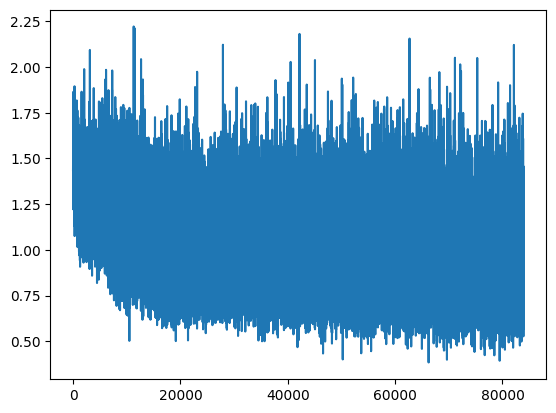

In [24]:
plt.plot(train_losses)

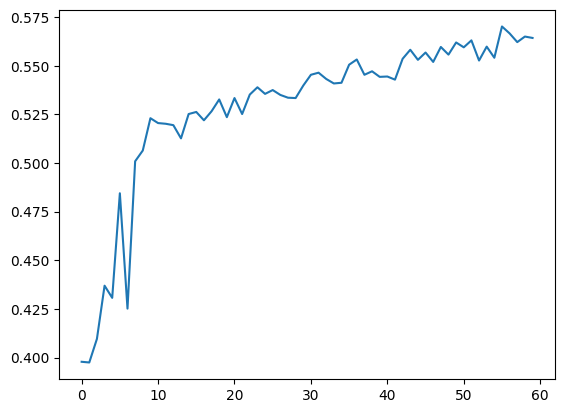

In [25]:
plt.plot(test_accuracy)

In [26]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3160/5600 (0.5643)
{'acc_detail': tensor([0.6371, 0.6164, 0.6979, 0.3057], device='cuda:0'),
 'acc_unweighted': tensor(0.5643, device='cuda:0'),
 'acc_weighted': tensor(0.5643, device='cuda:0'),
 'f1s_detail': tensor([0.6286, 0.5738, 0.6342, 0.3766], device='cuda:0'),
 'f1s_unweighted': tensor(0.5533, device='cuda:0'),
 'f1s_weighted': tensor(0.5533, device='cuda:0'),
 'precision_detail': tensor([0.6203, 0.5367, 0.5812, 0.4903], device='cuda:0'),
 'recall_detail': tensor([0.6371, 0.6164, 0.6979, 0.3057], device='cuda:0'),
 'rocauc_detail': tensor([0.8630, 0.8348, 0.8616, 0.7455], device='cuda:0'),
 'rocauc_unweighted': tensor(0.8262, device='cuda:0'),
 'rocauc_weighted': tensor(0.8262, device='cuda:0'),
 'uar': tensor(0.5643, device='cuda:0'),
 'wap': tensor(0.5571, device='cuda:0')}


tensor([[892, 139, 130, 239],
        [ 44, 863, 365, 128],
        [ 72, 273, 977,  78],
        [430, 333, 209, 428]], device='cuda:0')

In [27]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_esd4/esd4_m13_best_56epoch.pt
Correct: 3193/5600 (0.5702)
{'acc_detail': tensor([0.6214, 0.5979, 0.6621, 0.3993], device='cuda:0'),
 'acc_unweighted': tensor(0.5702, device='cuda:0'),
 'acc_weighted': tensor(0.5702, device='cuda:0'),
 'f1s_detail': tensor([0.6208, 0.5815, 0.6492, 0.4200], device='cuda:0'),
 'f1s_unweighted': tensor(0.5678, device='cuda:0'),
 'f1s_weighted': tensor(0.5678, device='cuda:0'),
 'precision_detail': tensor([0.6201, 0.5659, 0.6367, 0.4429], device='cuda:0'),
 'recall_detail': tensor([0.6214, 0.5979, 0.6621, 0.3993], device='cuda:0'),
 'rocauc_detail': tensor([0.8624, 0.8414, 0.8648, 0.7460], device='cuda:0'),
 'rocauc_unweighted': tensor(0.8287, device='cuda:0'),
 'rocauc_weighted': tensor(0.8287, device='cuda:0'),
 'uar': tensor(0.5702, device='cuda:0'),
 'wap': tensor(0.5664, device='cuda:0')}


tensor([[870, 106,  80, 344],
        [ 51, 837, 293, 219],
        [ 78, 255, 927, 140],
        [404, 281, 156, 559]], device='cuda:0')

In [28]:
checkpoint_path = '../models_esd4/esd4_m13_60epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [29]:
# n_epoch = 10
# n_epoch2 = 10
n_epoch3 = 20

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                              | 0.0005714285714285715/20 [00:00<2:28:30, 445.55s/it]

Train Epoch: 61 [0/22400 (0%)]	Loss: 0.740118
Mem before-during-after: 47772672 1801744384 49036288


  0%|                               | 0.023428571428571413/20 [00:10<2:31:29, 455.01s/it]

Train Epoch: 61 [640/22400 (3%)]	Loss: 0.812193
Mem before-during-after: 49019904 1805196288 49052672


  0%|                               | 0.046285714285714215/20 [00:20<2:36:32, 470.72s/it]

Train Epoch: 61 [1280/22400 (6%)]	Loss: 1.025820
Mem before-during-after: 49052672 1805179904 49019904


  0%|                                | 0.06914285714285702/20 [00:30<2:27:45, 444.81s/it]

Train Epoch: 61 [1920/22400 (9%)]	Loss: 0.749846
Mem before-during-after: 49019904 1805224960 49052672


  0%|▏                               | 0.09199999999999982/20 [00:39<2:27:10, 443.55s/it]

Train Epoch: 61 [2560/22400 (11%)]	Loss: 0.923489
Mem before-during-after: 49085440 1733102592 49315840


  1%|▏                               | 0.11542857142857119/20 [00:49<2:17:44, 415.62s/it]

Train Epoch: 61 [3200/22400 (14%)]	Loss: 0.898951
Mem before-during-after: 49019904 1804147712 49052672


  1%|▏                               | 0.13771428571428573/20 [00:59<2:26:48, 443.50s/it]

Train Epoch: 61 [3840/22400 (17%)]	Loss: 1.199094
Mem before-during-after: 49019904 1804147712 49052672


  1%|▎                               | 0.16114285714285767/20 [01:09<2:14:17, 406.14s/it]

Train Epoch: 61 [4480/22400 (20%)]	Loss: 1.380813
Mem before-during-after: 49019904 1598802944 49052672


  1%|▎                               | 0.18342857142857244/20 [01:18<2:27:36, 446.94s/it]

Train Epoch: 61 [5120/22400 (23%)]	Loss: 1.157550
Mem before-during-after: 49052672 1804131328 49019904


  1%|▎                                | 0.2062857142857158/20 [01:28<2:27:13, 446.27s/it]

Train Epoch: 61 [5760/22400 (26%)]	Loss: 0.918292
Mem before-during-after: 49052672 1804131328 49019904


  1%|▎                               | 0.22914285714285915/20 [01:38<2:26:41, 445.16s/it]

Train Epoch: 61 [6400/22400 (29%)]	Loss: 0.972912
Mem before-during-after: 49052672 1804131328 49019904


  1%|▍                                | 0.2520000000000024/20 [01:48<2:26:02, 443.72s/it]

Train Epoch: 61 [7040/22400 (31%)]	Loss: 1.042205
Mem before-during-after: 49052672 1651485696 49019904


  1%|▍                               | 0.27485714285714463/20 [01:57<2:27:03, 447.34s/it]

Train Epoch: 61 [7680/22400 (34%)]	Loss: 1.080287
Mem before-during-after: 49052672 1804131328 49019904


  1%|▍                                | 0.2977142857142869/20 [02:07<2:37:58, 481.10s/it]

Train Epoch: 61 [8320/22400 (37%)]	Loss: 0.817265
Mem before-during-after: 49019904 1804147712 49052672


  2%|▌                                | 0.3205714285714291/20 [02:17<2:25:38, 444.07s/it]

Train Epoch: 61 [8960/22400 (40%)]	Loss: 0.898498
Mem before-during-after: 49019904 1804147712 49052672


  2%|▌                               | 0.34342857142857136/20 [02:27<2:27:05, 448.98s/it]

Train Epoch: 61 [9600/22400 (43%)]	Loss: 0.898394
Mem before-during-after: 49134592 1804082176 49085440


  2%|▌                                | 0.3662857142857136/20 [02:37<2:31:00, 461.50s/it]

Train Epoch: 61 [10240/22400 (46%)]	Loss: 1.019320
Mem before-during-after: 49187840 1804147712 49036288


  2%|▌                               | 0.38914285714285585/20 [02:46<2:25:18, 444.56s/it]

Train Epoch: 61 [10880/22400 (49%)]	Loss: 1.340766
Mem before-during-after: 49052672 1804121088 49107968


  2%|▋                                | 0.4119999999999981/20 [02:56<2:27:31, 451.87s/it]

Train Epoch: 61 [11520/22400 (51%)]	Loss: 0.671191
Mem before-during-after: 49052672 1804196864 49085440


  2%|▋                               | 0.43485714285714033/20 [03:06<2:26:00, 447.76s/it]

Train Epoch: 61 [12160/22400 (54%)]	Loss: 0.880632
Mem before-during-after: 49085440 1804196864 49052672


  2%|▊                                | 0.4577142857142826/20 [03:16<2:25:13, 445.86s/it]

Train Epoch: 61 [12800/22400 (57%)]	Loss: 0.927191
Mem before-during-after: 49036288 1804196864 49052672


  2%|▊                                | 0.4805714285714248/20 [03:25<2:24:04, 442.84s/it]

Train Epoch: 61 [13440/22400 (60%)]	Loss: 1.010969
Mem before-during-after: 49208320 1804147712 49036288


  3%|▊                                | 0.5034285714285671/20 [03:35<2:32:59, 470.82s/it]

Train Epoch: 61 [14080/22400 (63%)]	Loss: 0.715854
Mem before-during-after: 49069056 1804082176 49150976


  3%|▊                                | 0.5262857142857094/20 [03:45<2:24:00, 443.69s/it]

Train Epoch: 61 [14720/22400 (66%)]	Loss: 0.970449
Mem before-during-after: 49085440 1804082176 49150976


  3%|▉                                | 0.5491428571428516/20 [03:54<2:23:17, 442.02s/it]

Train Epoch: 61 [15360/22400 (69%)]	Loss: 0.863874
Mem before-during-after: 49134592 1804033024 49019904


  3%|▉                                | 0.5719999999999938/20 [04:04<2:26:45, 453.26s/it]

Train Epoch: 61 [16000/22400 (71%)]	Loss: 0.965626
Mem before-during-after: 49052672 1804180992 49019904


  3%|▉                                | 0.5948571428571361/20 [04:14<2:24:25, 446.55s/it]

Train Epoch: 61 [16640/22400 (74%)]	Loss: 0.704472
Mem before-during-after: 49052672 1804131328 49019904


  3%|█                                | 0.6177142857142783/20 [04:23<2:23:05, 442.94s/it]

Train Epoch: 61 [17280/22400 (77%)]	Loss: 0.565382
Mem before-during-after: 49118208 1804618752 49134592


  3%|█                                | 0.6405714285714206/20 [04:33<2:23:44, 445.47s/it]

Train Epoch: 61 [17920/22400 (80%)]	Loss: 0.776204
Mem before-during-after: 49085440 1804196864 49052672


  3%|█                                | 0.6639999999999914/20 [04:43<2:14:45, 418.18s/it]

Train Epoch: 61 [18560/22400 (83%)]	Loss: 1.243034
Mem before-during-after: 49085440 1804082176 49150976


  3%|█▏                               | 0.6862857142857051/20 [04:53<2:24:13, 448.07s/it]

Train Epoch: 61 [19200/22400 (86%)]	Loss: 0.998672
Mem before-during-after: 49085440 1804196864 49052672


  4%|█▏                               | 0.7091428571428473/20 [05:02<2:21:51, 441.21s/it]

Train Epoch: 61 [19840/22400 (89%)]	Loss: 1.164315
Mem before-during-after: 49052672 1804196864 49085440


  4%|█▏                               | 0.7319999999999895/20 [05:12<2:22:05, 442.49s/it]

Train Epoch: 61 [20480/22400 (91%)]	Loss: 0.798489
Mem before-during-after: 49331200 1804147712 49036288


  4%|█▏                               | 0.7548571428571318/20 [05:22<2:22:29, 444.25s/it]

Train Epoch: 61 [21120/22400 (94%)]	Loss: 0.751968
Mem before-during-after: 49052672 1804196864 49085440


  4%|█▎                                | 0.777714285714274/20 [05:31<2:22:18, 444.21s/it]

Train Epoch: 61 [21760/22400 (97%)]	Loss: 0.678608
Mem before-during-after: 49085440 1804196864 49052672


  5%|█▋                               | 0.9999999999999823/20 [06:51<1:54:57, 363.04s/it]


Test Epoch: 61	Accuracy: 3172/5600 (57%)



  5%|█▋                               | 1.0011428571428396/20 [06:52<1:57:38, 371.50s/it]

Train Epoch: 62 [0/22400 (0%)]	Loss: 1.007517
Mem before-during-after: 49045504 1802984448 49019904


  5%|█▋                               | 1.0234285714285576/20 [07:01<2:20:08, 443.11s/it]

Train Epoch: 62 [640/22400 (3%)]	Loss: 0.694155
Mem before-during-after: 49019904 1805196288 49052672


  5%|█▋                               | 1.0462857142857043/20 [07:11<2:20:53, 446.02s/it]

Train Epoch: 62 [1280/22400 (6%)]	Loss: 0.830094
Mem before-during-after: 49052672 1804196864 49085440


  5%|█▊                                | 1.069142857142851/20 [07:21<2:22:22, 451.25s/it]

Train Epoch: 62 [1920/22400 (9%)]	Loss: 0.845440
Mem before-during-after: 49085440 1804196864 49052672


  5%|█▊                               | 1.0919999999999976/20 [07:31<2:19:43, 443.37s/it]

Train Epoch: 62 [2560/22400 (11%)]	Loss: 0.873918
Mem before-during-after: 49052672 1804196864 49085440


  6%|█▊                               | 1.1148571428571443/20 [07:40<2:20:36, 446.75s/it]

Train Epoch: 62 [3200/22400 (14%)]	Loss: 0.883831
Mem before-during-after: 49085440 1804196864 49052672


  6%|█▉                                | 1.137714285714291/20 [07:50<2:22:52, 454.46s/it]

Train Epoch: 62 [3840/22400 (17%)]	Loss: 0.980284
Mem before-during-after: 49085440 1804196864 49052672


  6%|█▉                               | 1.1605714285714377/20 [08:00<2:22:24, 453.55s/it]

Train Epoch: 62 [4480/22400 (20%)]	Loss: 0.903655
Mem before-during-after: 49085440 1804196864 49052672


  6%|█▉                               | 1.1834285714285844/20 [08:09<2:19:08, 443.69s/it]

Train Epoch: 62 [5120/22400 (23%)]	Loss: 0.937387
Mem before-during-after: 49052672 1804196864 49036288


  6%|██                                | 1.206285714285731/20 [08:19<2:17:58, 440.51s/it]

Train Epoch: 62 [5760/22400 (26%)]	Loss: 0.779256
Mem before-during-after: 49036288 1804196864 49052672


  6%|██                               | 1.2297142857143064/20 [08:29<2:10:01, 415.65s/it]

Train Epoch: 62 [6400/22400 (29%)]	Loss: 1.138148
Mem before-during-after: 49052672 1804196864 49085440


  6%|██                               | 1.2520000000000244/20 [08:39<2:18:55, 444.61s/it]

Train Epoch: 62 [7040/22400 (31%)]	Loss: 0.998749
Mem before-during-after: 49085440 1804196864 49052672


  6%|██▏                               | 1.274857142857171/20 [08:49<2:20:19, 449.66s/it]

Train Epoch: 62 [7680/22400 (34%)]	Loss: 1.286102
Mem before-during-after: 49211392 1804147712 49036288


  6%|██▏                              | 1.2977142857143178/20 [08:58<2:20:30, 450.75s/it]

Train Epoch: 62 [8320/22400 (37%)]	Loss: 0.889690
Mem before-during-after: 49052672 1804196864 49085440


  7%|██▏                              | 1.3205714285714645/20 [09:08<2:20:59, 452.89s/it]

Train Epoch: 62 [8960/22400 (40%)]	Loss: 1.038710
Mem before-during-after: 49085440 1598852096 49644544


  7%|██▏                              | 1.3434285714286112/20 [09:18<2:18:43, 446.14s/it]

Train Epoch: 62 [9600/22400 (43%)]	Loss: 1.033597
Mem before-during-after: 49085440 1804196864 49052672


  7%|██▎                              | 1.3662857142857578/20 [09:28<2:17:58, 444.27s/it]

Train Epoch: 62 [10240/22400 (46%)]	Loss: 0.833977
Mem before-during-after: 49052672 1804196864 49085440


  7%|██▎                              | 1.3891428571429045/20 [09:37<2:17:56, 444.72s/it]

Train Epoch: 62 [10880/22400 (49%)]	Loss: 0.595307
Mem before-during-after: 49052672 1805245440 49085440


  7%|██▎                              | 1.4120000000000512/20 [09:47<2:20:13, 452.63s/it]

Train Epoch: 62 [11520/22400 (51%)]	Loss: 0.600157
Mem before-during-after: 49052672 1805245440 49085440


  7%|██▍                               | 1.434857142857198/20 [09:57<2:16:51, 442.32s/it]

Train Epoch: 62 [12160/22400 (54%)]	Loss: 0.931023
Mem before-during-after: 49167872 1778354176 49069056


  7%|██▍                              | 1.4577142857143446/20 [10:07<2:21:08, 456.70s/it]

Train Epoch: 62 [12800/22400 (57%)]	Loss: 0.761862
Mem before-during-after: 49052672 1804200960 49085440


  7%|██▍                              | 1.4805714285714913/20 [10:16<2:16:47, 443.18s/it]

Train Epoch: 62 [13440/22400 (60%)]	Loss: 0.931449
Mem before-during-after: 49052672 1804200960 49085440


  8%|██▌                               | 1.503428571428638/20 [10:26<2:19:36, 452.84s/it]

Train Epoch: 62 [14080/22400 (63%)]	Loss: 0.832931
Mem before-during-after: 49085440 1805245440 49052672


  8%|██▌                              | 1.5262857142857846/20 [10:36<2:18:15, 449.05s/it]

Train Epoch: 62 [14720/22400 (66%)]	Loss: 0.910861
Mem before-during-after: 49052672 1805245440 49085440


  8%|██▌                              | 1.5491428571429313/20 [10:46<2:18:34, 450.61s/it]

Train Epoch: 62 [15360/22400 (69%)]	Loss: 0.726206
Mem before-during-after: 49052672 1805245440 49085440


  8%|██▋                               | 1.572000000000078/20 [10:56<2:18:04, 449.58s/it]

Train Epoch: 62 [16000/22400 (71%)]	Loss: 0.864314
Mem before-during-after: 49134592 1804082176 49085440


  8%|██▋                              | 1.5948571428572247/20 [11:05<2:18:12, 450.55s/it]

Train Epoch: 62 [16640/22400 (74%)]	Loss: 1.107964
Mem before-during-after: 49052672 1804196864 49085440


  8%|██▋                              | 1.6177142857143714/20 [11:15<2:14:39, 439.52s/it]

Train Epoch: 62 [17280/22400 (77%)]	Loss: 1.136973
Mem before-during-after: 49036288 1679589376 49052672


  8%|██▊                               | 1.640571428571518/20 [11:25<2:16:07, 444.87s/it]

Train Epoch: 62 [17920/22400 (80%)]	Loss: 0.939397
Mem before-during-after: 49085440 1804196864 49052672


  8%|██▋                              | 1.6640000000000934/20 [11:35<2:06:20, 413.40s/it]

Train Epoch: 62 [18560/22400 (83%)]	Loss: 0.497610
Mem before-during-after: 49558528 1805093888 49069056


  8%|██▊                              | 1.6862857142858114/20 [11:44<2:16:05, 445.87s/it]

Train Epoch: 62 [19200/22400 (86%)]	Loss: 0.822171
Mem before-during-after: 49085440 1805245440 49052672


  9%|██▉                               | 1.709142857142958/20 [11:54<2:16:49, 448.83s/it]

Train Epoch: 62 [19840/22400 (89%)]	Loss: 1.160479
Mem before-during-after: 49052672 1805245440 49085440


  9%|██▊                              | 1.7320000000001048/20 [12:04<2:16:24, 448.02s/it]

Train Epoch: 62 [20480/22400 (91%)]	Loss: 1.484792
Mem before-during-after: 49052672 1805245440 49036288


  9%|██▉                              | 1.7548571428572515/20 [12:13<2:14:24, 442.03s/it]

Train Epoch: 62 [21120/22400 (94%)]	Loss: 1.020311
Mem before-during-after: 49036288 1805716480 49036288


  9%|██▉                              | 1.7777142857143982/20 [12:23<2:15:58, 447.72s/it]

Train Epoch: 62 [21760/22400 (97%)]	Loss: 1.007081
Mem before-during-after: 49086464 1805196288 49052672


 10%|███▎                             | 2.0000000000001497/20 [13:43<1:55:22, 384.57s/it]


Test Epoch: 62	Accuracy: 3186/5600 (57%)



 10%|███▎                             | 2.0011428571430065/20 [13:43<1:54:04, 380.29s/it]

Train Epoch: 63 [0/22400 (0%)]	Loss: 0.624172
Mem before-during-after: 49012736 1802984448 49036288


 10%|███▍                              | 2.023428571428716/20 [13:53<2:13:42, 446.28s/it]

Train Epoch: 63 [640/22400 (3%)]	Loss: 1.171812
Mem before-during-after: 49019904 1805196288 49052672


 10%|███▍                             | 2.0462857142858537/20 [14:03<2:15:22, 452.41s/it]

Train Epoch: 63 [1280/22400 (6%)]	Loss: 0.918313
Mem before-during-after: 49052672 1805179904 49019904


 10%|███▍                             | 2.0691428571429915/20 [14:13<2:14:41, 450.69s/it]

Train Epoch: 63 [1920/22400 (9%)]	Loss: 0.901466
Mem before-during-after: 49052672 1805179904 49019904


 10%|███▍                             | 2.0920000000001293/20 [14:22<2:13:59, 448.94s/it]

Train Epoch: 63 [2560/22400 (11%)]	Loss: 1.068901
Mem before-during-after: 49052672 1787513856 49052672


 11%|███▌                              | 2.114857142857267/20 [14:32<2:12:11, 443.48s/it]

Train Epoch: 63 [3200/22400 (14%)]	Loss: 0.740334
Mem before-during-after: 49052672 1805245440 49085440


 11%|███▋                              | 2.137714285714405/20 [14:42<2:11:27, 441.57s/it]

Train Epoch: 63 [3840/22400 (17%)]	Loss: 1.213351
Mem before-during-after: 49085440 1805245440 49052672


 11%|███▌                             | 2.1605714285715427/20 [14:51<2:12:34, 445.92s/it]

Train Epoch: 63 [4480/22400 (20%)]	Loss: 1.109587
Mem before-during-after: 49528832 1679217152 49036288


 11%|███▌                             | 2.1834285714286805/20 [15:01<2:13:39, 450.09s/it]

Train Epoch: 63 [5120/22400 (23%)]	Loss: 0.669808
Mem before-during-after: 49085440 1804196864 49052672


 11%|███▋                             | 2.2062857142858183/20 [15:11<2:14:50, 454.70s/it]

Train Epoch: 63 [5760/22400 (26%)]	Loss: 1.002443
Mem before-during-after: 49085440 1804196864 49052672


 11%|███▊                              | 2.229142857142956/20 [15:21<2:14:16, 453.38s/it]

Train Epoch: 63 [6400/22400 (29%)]	Loss: 0.793165
Mem before-during-after: 49052672 1804196864 49085440


 11%|███▊                              | 2.252000000000094/20 [15:31<2:12:38, 448.39s/it]

Train Epoch: 63 [7040/22400 (31%)]	Loss: 0.631602
Mem before-during-after: 49036288 1804196864 49052672


 11%|███▊                             | 2.2748571428572317/20 [15:40<2:11:42, 445.85s/it]

Train Epoch: 63 [7680/22400 (34%)]	Loss: 0.940420
Mem before-during-after: 49036288 1804196864 49052672


 11%|███▊                             | 2.2977142857143695/20 [15:50<2:13:02, 450.92s/it]

Train Epoch: 63 [8320/22400 (37%)]	Loss: 1.409101
Mem before-during-after: 49085440 1805245440 49052672


 12%|███▊                             | 2.3205714285715073/20 [16:00<2:12:12, 448.67s/it]

Train Epoch: 63 [8960/22400 (40%)]	Loss: 0.756017
Mem before-during-after: 49052672 1805245440 49085440


 12%|███▉                              | 2.343428571428645/20 [16:10<2:11:04, 445.43s/it]

Train Epoch: 63 [9600/22400 (43%)]	Loss: 0.972322
Mem before-during-after: 49052672 1804196864 49085440


 12%|████                              | 2.366285714285783/20 [16:19<2:11:02, 445.86s/it]

Train Epoch: 63 [10240/22400 (46%)]	Loss: 0.591675
Mem before-during-after: 49052672 1805245440 49085440


 12%|███▉                             | 2.3891428571429207/20 [16:29<2:10:42, 445.30s/it]

Train Epoch: 63 [10880/22400 (49%)]	Loss: 0.815023
Mem before-during-after: 49069056 1805130752 49134592


 12%|███▉                             | 2.4120000000000585/20 [16:39<2:12:09, 450.83s/it]

Train Epoch: 63 [11520/22400 (51%)]	Loss: 1.068074
Mem before-during-after: 49085440 1760242688 49249792


 12%|████▏                             | 2.435428571428625/20 [16:49<2:02:17, 417.75s/it]

Train Epoch: 63 [12160/22400 (54%)]	Loss: 1.062909
Mem before-during-after: 49052672 1804200960 49085440


 12%|████▏                             | 2.457714285714334/20 [16:58<2:07:49, 437.22s/it]

Train Epoch: 63 [12800/22400 (57%)]	Loss: 0.673699
Mem before-during-after: 49069056 1669110784 49417216


 12%|████▏                             | 2.480571428571472/20 [17:08<2:10:57, 448.48s/it]

Train Epoch: 63 [13440/22400 (60%)]	Loss: 0.796897
Mem before-during-after: 49052672 1804200960 49085440


 13%|████▏                            | 2.5034285714286098/20 [17:18<2:09:45, 444.94s/it]

Train Epoch: 63 [14080/22400 (63%)]	Loss: 1.049368
Mem before-during-after: 49052672 1624810496 49517568


 13%|████▏                            | 2.5262857142857476/20 [17:28<2:11:06, 450.19s/it]

Train Epoch: 63 [14720/22400 (66%)]	Loss: 0.958349
Mem before-during-after: 49036288 1804459008 49052672


 13%|████▏                            | 2.5491428571428854/20 [17:37<2:09:55, 446.70s/it]

Train Epoch: 63 [15360/22400 (69%)]	Loss: 0.761782
Mem before-during-after: 49052672 1787462656 49167872


 13%|████▎                             | 2.572000000000023/20 [17:47<2:10:34, 449.54s/it]

Train Epoch: 63 [16000/22400 (71%)]	Loss: 1.260968
Mem before-during-after: 49052672 1804200960 49101824


 13%|████▍                             | 2.594857142857161/20 [17:57<2:08:10, 441.86s/it]

Train Epoch: 63 [16640/22400 (74%)]	Loss: 0.924069
Mem before-during-after: 49036288 1804200960 49036288


 13%|████▎                            | 2.6177142857142988/20 [18:06<2:08:22, 443.10s/it]

Train Epoch: 63 [17280/22400 (77%)]	Loss: 0.930434
Mem before-during-after: 49036288 1804200960 49052672


 13%|████▎                            | 2.6405714285714366/20 [18:16<2:10:41, 451.72s/it]

Train Epoch: 63 [17920/22400 (80%)]	Loss: 0.778303
Mem before-during-after: 49674240 1804069888 49052672


 13%|████▍                            | 2.6634285714285744/20 [18:26<2:10:32, 451.82s/it]

Train Epoch: 63 [18560/22400 (83%)]	Loss: 1.006238
Mem before-during-after: 49052672 1804200960 49085440


 13%|████▍                            | 2.6868571428571406/20 [18:36<2:03:20, 427.46s/it]

Train Epoch: 63 [19200/22400 (86%)]	Loss: 1.092959
Mem before-during-after: 49085440 1804200960 49052672


 14%|████▋                              | 2.70914285714285/20 [18:46<2:08:35, 446.23s/it]

Train Epoch: 63 [19840/22400 (89%)]	Loss: 0.947368
Mem before-during-after: 49036288 1804491776 49101824


 14%|████▌                            | 2.7319999999999878/20 [18:55<2:09:37, 450.42s/it]

Train Epoch: 63 [20480/22400 (91%)]	Loss: 0.663429
Mem before-during-after: 49052672 1804200960 49085440


 14%|████▌                            | 2.7548571428571256/20 [19:05<2:09:09, 449.38s/it]

Train Epoch: 63 [21120/22400 (94%)]	Loss: 1.084038
Mem before-during-after: 49052672 1804200960 49085440


 14%|████▌                            | 2.7777142857142634/20 [19:15<2:08:54, 449.12s/it]

Train Epoch: 63 [21760/22400 (97%)]	Loss: 1.058280
Mem before-during-after: 49019904 1804135424 49052672


 15%|████▉                            | 2.9999999999999285/20 [20:35<1:40:43, 355.52s/it]


Test Epoch: 63	Accuracy: 3166/5600 (57%)



 15%|█████                             | 3.000571428571357/20 [20:35<1:48:02, 381.34s/it]

Train Epoch: 64 [0/22400 (0%)]	Loss: 1.050830
Mem before-during-after: 49012736 1802984448 49036288


 15%|████▉                            | 3.0234285714284947/20 [20:45<2:07:03, 449.08s/it]

Train Epoch: 64 [640/22400 (3%)]	Loss: 1.303467
Mem before-during-after: 49052672 1803000832 49052672


 15%|█████▏                            | 3.046857142857061/20 [20:55<2:00:42, 427.23s/it]

Train Epoch: 64 [1280/22400 (6%)]	Loss: 0.838866
Mem before-during-after: 49121280 1803066368 49019904


 15%|█████                            | 3.0691428571427704/20 [21:04<2:04:35, 441.56s/it]

Train Epoch: 64 [1920/22400 (9%)]	Loss: 0.656270
Mem before-during-after: 49052672 1804131328 49019904


 15%|█████▎                            | 3.091999999999908/20 [21:14<2:05:18, 444.65s/it]

Train Epoch: 64 [2560/22400 (11%)]	Loss: 0.670089
Mem before-during-after: 49052672 1804131328 49019904


 16%|█████▎                            | 3.114857142857046/20 [21:24<2:05:43, 446.76s/it]

Train Epoch: 64 [3200/22400 (14%)]	Loss: 0.760548
Mem before-during-after: 49052672 1804131328 49019904


 16%|█████▏                           | 3.1377142857141838/20 [21:34<2:08:01, 455.52s/it]

Train Epoch: 64 [3840/22400 (17%)]	Loss: 1.108234
Mem before-during-after: 49052672 1803082752 49019904


 16%|█████▏                           | 3.1605714285713216/20 [21:44<2:07:02, 452.63s/it]

Train Epoch: 64 [4480/22400 (20%)]	Loss: 0.653168
Mem before-during-after: 49052672 1804131328 49019904


 16%|█████▎                           | 3.1834285714284594/20 [21:53<2:05:30, 447.83s/it]

Train Epoch: 64 [5120/22400 (23%)]	Loss: 1.368455
Mem before-during-after: 49019904 1804147712 49052672


 16%|█████▍                            | 3.206285714285597/20 [22:03<2:05:40, 449.02s/it]

Train Epoch: 64 [5760/22400 (26%)]	Loss: 0.849465
Mem before-during-after: 49019904 1804147712 49052672


 16%|█████▍                            | 3.229142857142735/20 [22:13<2:04:22, 444.94s/it]

Train Epoch: 64 [6400/22400 (29%)]	Loss: 0.869082
Mem before-during-after: 49019904 1804147712 49052672


 16%|█████▎                           | 3.2519999999998728/20 [22:22<2:06:01, 451.50s/it]

Train Epoch: 64 [7040/22400 (31%)]	Loss: 1.054857
Mem before-during-after: 49052672 1804131328 49019904


 16%|█████▍                           | 3.2748571428570106/20 [22:32<2:03:40, 443.68s/it]

Train Epoch: 64 [7680/22400 (34%)]	Loss: 0.913190
Mem before-during-after: 49019904 1804147712 49052672


 16%|█████▍                           | 3.2977142857141484/20 [22:42<2:03:06, 442.22s/it]

Train Epoch: 64 [8320/22400 (37%)]	Loss: 0.663666
Mem before-during-after: 49052672 1760177152 49019904


 17%|█████▋                            | 3.320571428571286/20 [22:52<2:02:54, 442.12s/it]

Train Epoch: 64 [8960/22400 (40%)]	Loss: 0.670274
Mem before-during-after: 49134592 1804082176 49085440


 17%|█████▋                            | 3.343428571428424/20 [23:01<2:04:01, 446.79s/it]

Train Epoch: 64 [9600/22400 (43%)]	Loss: 1.561347
Mem before-during-after: 49085440 1804082176 49134592


 17%|█████▋                            | 3.366285714285562/20 [23:11<2:04:46, 450.07s/it]

Train Epoch: 64 [10240/22400 (46%)]	Loss: 1.042082
Mem before-during-after: 49101824 1804082176 49150976


 17%|█████▌                           | 3.3891428571426996/20 [23:21<2:02:26, 442.28s/it]

Train Epoch: 64 [10880/22400 (49%)]	Loss: 0.837566
Mem before-during-after: 49052672 1707165696 49687552


 17%|█████▋                           | 3.4119999999998374/20 [23:30<2:02:50, 444.33s/it]

Train Epoch: 64 [11520/22400 (51%)]	Loss: 1.146009
Mem before-during-after: 50183168 1805065216 49118208


 17%|█████▊                            | 3.434857142856975/20 [23:40<2:02:36, 444.08s/it]

Train Epoch: 64 [12160/22400 (54%)]	Loss: 1.137747
Mem before-during-after: 50558976 1803111424 49052672


 17%|█████▉                            | 3.457714285714113/20 [23:50<2:05:47, 456.26s/it]

Train Epoch: 64 [12800/22400 (57%)]	Loss: 0.692320
Mem before-during-after: 49085440 1804196864 49052672


 17%|█████▉                            | 3.480571428571251/20 [24:00<2:04:03, 450.61s/it]

Train Epoch: 64 [13440/22400 (60%)]	Loss: 0.977493
Mem before-during-after: 49085440 1804196864 49052672


 18%|█████▊                           | 3.5034285714283886/20 [24:09<2:02:07, 444.21s/it]

Train Epoch: 64 [14080/22400 (63%)]	Loss: 1.081097
Mem before-during-after: 49085440 1733069824 49052672


 18%|█████▊                           | 3.5262857142855264/20 [24:19<2:01:21, 442.02s/it]

Train Epoch: 64 [14720/22400 (66%)]	Loss: 0.858719
Mem before-during-after: 49240064 1804147712 49052672


 18%|██████                            | 3.549142857142664/20 [24:29<2:02:35, 447.14s/it]

Train Epoch: 64 [15360/22400 (69%)]	Loss: 0.677384
Mem before-during-after: 49052672 1805224960 49085440


 18%|██████                            | 3.571999999999802/20 [24:39<2:08:24, 468.97s/it]

Train Epoch: 64 [16000/22400 (71%)]	Loss: 0.835637
Mem before-during-after: 49134592 1804082176 49085440


 18%|██████▎                            | 3.59485714285694/20 [24:48<2:03:52, 453.06s/it]

Train Epoch: 64 [16640/22400 (74%)]	Loss: 0.877191
Mem before-during-after: 49085440 1804196864 49052672


 18%|█████▉                           | 3.6177142857140776/20 [24:58<2:01:29, 444.97s/it]

Train Epoch: 64 [17280/22400 (77%)]	Loss: 0.612872
Mem before-during-after: 49052672 1722813440 49286144


 18%|██████                           | 3.6405714285712154/20 [25:08<2:01:13, 444.60s/it]

Train Epoch: 64 [17920/22400 (80%)]	Loss: 0.873132
Mem before-during-after: 49052672 1804196864 49085440


 18%|██████▏                           | 3.663428571428353/20 [25:18<2:01:47, 447.31s/it]

Train Epoch: 64 [18560/22400 (83%)]	Loss: 0.838043
Mem before-during-after: 49036288 1804196864 49052672


 18%|██████▎                           | 3.686285714285491/20 [25:27<2:00:36, 443.57s/it]

Train Epoch: 64 [19200/22400 (86%)]	Loss: 1.021153
Mem before-during-after: 49085440 1804196864 49052672


 19%|██████▎                           | 3.709142857142629/20 [25:37<2:01:08, 446.17s/it]

Train Epoch: 64 [19840/22400 (89%)]	Loss: 1.113616
Mem before-during-after: 49085440 1804098560 49052672


 19%|██████▏                          | 3.7319999999997666/20 [25:47<2:02:43, 452.66s/it]

Train Epoch: 64 [20480/22400 (91%)]	Loss: 0.958697
Mem before-during-after: 49085440 1804196864 49052672


 19%|██████▏                          | 3.7548571428569044/20 [25:57<2:00:05, 443.55s/it]

Train Epoch: 64 [21120/22400 (94%)]	Loss: 0.850375
Mem before-during-after: 49036288 1804196864 49052672


 19%|██████▍                           | 3.777714285714042/20 [26:06<2:00:58, 447.43s/it]

Train Epoch: 64 [21760/22400 (97%)]	Loss: 0.948708
Mem before-during-after: 49085440 1804196864 49052672


 20%|██████▌                          | 3.9999999999997073/20 [27:26<1:33:40, 351.30s/it]


Test Epoch: 64	Accuracy: 3227/5600 (58%)

saved model: ../models_esd4/esd4_m13_best_64epoch.pt


 20%|██████▊                           | 4.000571428571136/20 [27:27<1:41:06, 379.19s/it]

Train Epoch: 65 [0/22400 (0%)]	Loss: 0.811627
Mem before-during-after: 49045504 1802984448 49019904


 20%|██████▊                           | 4.023428571428291/20 [27:36<1:59:18, 448.08s/it]

Train Epoch: 65 [640/22400 (3%)]	Loss: 0.792098
Mem before-during-after: 49052672 1805179904 49019904


 20%|██████▉                           | 4.046285714285447/20 [27:46<1:58:21, 445.11s/it]

Train Epoch: 65 [1280/22400 (6%)]	Loss: 0.871206
Mem before-during-after: 49085440 1805245440 49052672


 20%|██████▉                           | 4.069714285714031/20 [27:56<1:51:56, 421.61s/it]

Train Epoch: 65 [1920/22400 (9%)]	Loss: 0.833367
Mem before-during-after: 49019904 1804798976 49069056


 20%|██████▉                           | 4.091999999999758/20 [28:06<2:03:10, 464.60s/it]

Train Epoch: 65 [2560/22400 (11%)]	Loss: 1.354298
Mem before-during-after: 49085440 1805245440 49052672


 21%|██████▉                           | 4.114857142856914/20 [28:15<1:57:49, 445.03s/it]

Train Epoch: 65 [3200/22400 (14%)]	Loss: 1.004499
Mem before-during-after: 49019904 1804213248 49052672


 21%|███████                           | 4.137714285714069/20 [28:25<2:00:16, 454.93s/it]

Train Epoch: 65 [3840/22400 (17%)]	Loss: 0.931828
Mem before-during-after: 49085440 1805245440 49052672


 21%|███████                           | 4.161142857142654/20 [28:35<1:50:19, 417.92s/it]

Train Epoch: 65 [4480/22400 (20%)]	Loss: 1.093752
Mem before-during-after: 49052672 1805245440 49085440


 21%|███████▎                           | 4.18342857142838/20 [28:44<1:57:01, 443.92s/it]

Train Epoch: 65 [5120/22400 (23%)]	Loss: 1.217732
Mem before-during-after: 49085440 1804196864 49052672


 21%|███████▏                          | 4.206285714285536/20 [28:54<1:55:48, 439.93s/it]

Train Epoch: 65 [5760/22400 (26%)]	Loss: 1.004938
Mem before-during-after: 49085440 1804196864 49052672


 21%|██████▉                          | 4.2291428571426914/20 [29:04<1:57:08, 445.67s/it]

Train Epoch: 65 [6400/22400 (29%)]	Loss: 0.574904
Mem before-during-after: 49052672 1804196864 49085440


 21%|███████▏                          | 4.251999999999847/20 [29:13<1:58:02, 449.75s/it]

Train Epoch: 65 [7040/22400 (31%)]	Loss: 1.126423
Mem before-during-after: 49036288 1804033024 49019904


 21%|███████▎                          | 4.274857142857003/20 [29:23<1:55:39, 441.33s/it]

Train Epoch: 65 [7680/22400 (34%)]	Loss: 0.853948
Mem before-during-after: 49052672 1668242432 49036288


 21%|███████▎                          | 4.297714285714158/20 [29:33<1:56:24, 444.80s/it]

Train Epoch: 65 [8320/22400 (37%)]	Loss: 0.648401
Mem before-during-after: 49052672 1804131328 49019904


 22%|███████▎                          | 4.320571428571314/20 [29:43<1:59:54, 458.84s/it]

Train Epoch: 65 [8960/22400 (40%)]	Loss: 0.677689
Mem before-during-after: 49052672 1804131328 49019904


 22%|███████▍                          | 4.343428571428469/20 [29:53<1:59:31, 458.08s/it]

Train Epoch: 65 [9600/22400 (43%)]	Loss: 1.289615
Mem before-during-after: 49052672 1804131328 49019904


 22%|███████▍                          | 4.366285714285625/20 [30:02<1:56:02, 445.33s/it]

Train Epoch: 65 [10240/22400 (46%)]	Loss: 0.697689
Mem before-during-after: 49052672 1777032192 49036288


 22%|███████▋                           | 4.38914285714278/20 [30:12<1:57:07, 450.16s/it]

Train Epoch: 65 [10880/22400 (49%)]	Loss: 0.673628
Mem before-during-after: 49118208 1803934720 49036288


 22%|███████▌                          | 4.411999999999936/20 [30:22<1:55:42, 445.38s/it]

Train Epoch: 65 [11520/22400 (51%)]	Loss: 0.801882
Mem before-during-after: 49085440 1804196864 49052672


 22%|███████▎                         | 4.4348571428570915/20 [30:32<1:55:33, 445.45s/it]

Train Epoch: 65 [12160/22400 (54%)]	Loss: 1.092688
Mem before-during-after: 49282560 1804098560 49052672


 22%|███████▌                          | 4.457714285714247/20 [30:41<1:57:09, 452.31s/it]

Train Epoch: 65 [12800/22400 (57%)]	Loss: 0.961204
Mem before-during-after: 49085440 1804196864 49052672


 22%|███████▌                          | 4.480571428571403/20 [30:51<1:55:05, 444.93s/it]

Train Epoch: 65 [13440/22400 (60%)]	Loss: 0.952520
Mem before-during-after: 49085440 1722620928 49348608


 23%|███████▋                          | 4.503428571428558/20 [31:01<1:56:57, 452.87s/it]

Train Epoch: 65 [14080/22400 (63%)]	Loss: 0.979105
Mem before-during-after: 49052672 1804196864 49085440


 23%|███████▋                          | 4.526285714285714/20 [31:11<1:55:21, 447.30s/it]

Train Epoch: 65 [14720/22400 (66%)]	Loss: 0.823658
Mem before-during-after: 49077248 1804148224 49052672


 23%|███████▋                          | 4.549142857142869/20 [31:21<1:58:10, 458.90s/it]

Train Epoch: 65 [15360/22400 (69%)]	Loss: 0.791908
Mem before-during-after: 49052672 1804196864 49085440


 23%|███████▊                          | 4.572000000000025/20 [31:30<1:54:22, 444.82s/it]

Train Epoch: 65 [16000/22400 (71%)]	Loss: 0.903093
Mem before-during-after: 49085440 1804196864 49052672


 23%|███████▊                          | 4.595428571428609/20 [31:40<1:49:21, 425.97s/it]

Train Epoch: 65 [16640/22400 (74%)]	Loss: 1.494976
Mem before-during-after: 49052672 1804196864 49085440


 23%|███████▊                          | 4.617714285714336/20 [31:50<1:54:49, 447.91s/it]

Train Epoch: 65 [17280/22400 (77%)]	Loss: 1.125201
Mem before-during-after: 49085440 1804196864 49052672


 23%|███████▉                          | 4.640571428571492/20 [32:00<1:52:56, 441.17s/it]

Train Epoch: 65 [17920/22400 (80%)]	Loss: 1.269551
Mem before-during-after: 49019904 1804131328 49052672


 23%|███████▉                          | 4.663428571428647/20 [32:09<1:54:09, 446.59s/it]

Train Epoch: 65 [18560/22400 (83%)]	Loss: 0.975322
Mem before-during-after: 49052672 1804196864 49085440


 23%|███████▉                          | 4.686285714285803/20 [32:19<1:53:21, 444.12s/it]

Train Epoch: 65 [19200/22400 (86%)]	Loss: 0.942803
Mem before-during-after: 49085440 1804196864 49052672


 24%|████████                          | 4.709714285714387/20 [32:29<1:46:17, 417.12s/it]

Train Epoch: 65 [19840/22400 (89%)]	Loss: 1.164120
Mem before-during-after: 49085440 1805245440 49052672


 24%|████████                          | 4.732000000000114/20 [32:38<1:53:28, 445.95s/it]

Train Epoch: 65 [20480/22400 (91%)]	Loss: 0.818876
Mem before-during-after: 49019904 1804147712 49052672


 24%|███████▊                         | 4.7548571428572695/20 [32:48<1:53:22, 446.21s/it]

Train Epoch: 65 [21120/22400 (94%)]	Loss: 0.763749
Mem before-during-after: 49019904 1804197376 49052672


 24%|████████                          | 4.777714285714425/20 [32:58<1:52:18, 442.66s/it]

Train Epoch: 65 [21760/22400 (97%)]	Loss: 0.851181
Mem before-during-after: 49019904 1804147712 49052672


 25%|████████▌                         | 5.000000000000263/20 [34:18<1:30:04, 360.32s/it]


Test Epoch: 65	Accuracy: 3206/5600 (57%)



 25%|████████▌                         | 5.000571428571692/20 [34:18<1:34:10, 376.72s/it]

Train Epoch: 66 [0/22400 (0%)]	Loss: 1.191145
Mem before-during-after: 49045504 1760177152 49019904


 25%|████████▌                         | 5.023428571428847/20 [34:28<1:50:42, 443.55s/it]

Train Epoch: 66 [640/22400 (3%)]	Loss: 0.924192
Mem before-during-after: 49052672 1803082752 49019904


 25%|████████▌                         | 5.046857142857432/20 [34:38<1:42:07, 409.79s/it]

Train Epoch: 66 [1280/22400 (6%)]	Loss: 0.850112
Mem before-during-after: 49052672 1803082752 49019904


 25%|████████▎                        | 5.0691428571431585/20 [34:47<1:51:24, 447.68s/it]

Train Epoch: 66 [1920/22400 (9%)]	Loss: 1.101839
Mem before-during-after: 49052672 1803082752 49019904


 25%|████████▋                         | 5.092000000000314/20 [34:57<1:53:13, 455.71s/it]

Train Epoch: 66 [2560/22400 (11%)]	Loss: 1.026406
Mem before-during-after: 49019904 1803099136 49052672


 26%|████████▉                          | 5.11485714285747/20 [35:07<1:49:45, 442.40s/it]

Train Epoch: 66 [3200/22400 (14%)]	Loss: 0.686707
Mem before-during-after: 49019904 1775827968 49052672


 26%|████████▋                         | 5.137714285714625/20 [35:16<1:54:29, 462.19s/it]

Train Epoch: 66 [3840/22400 (17%)]	Loss: 0.851341
Mem before-during-after: 49019904 1804127232 49052672


 26%|████████▊                         | 5.160571428571781/20 [35:26<1:49:20, 442.11s/it]

Train Epoch: 66 [4480/22400 (20%)]	Loss: 0.733583
Mem before-during-after: 49019904 1803099136 49052672


 26%|████████▊                         | 5.183428571428936/20 [35:36<1:49:24, 443.03s/it]

Train Epoch: 66 [5120/22400 (23%)]	Loss: 0.998463
Mem before-during-after: 49036288 1804028928 49134592


 26%|████████▊                         | 5.206857142857521/20 [35:46<1:41:43, 412.58s/it]

Train Epoch: 66 [5760/22400 (26%)]	Loss: 1.096014
Mem before-during-after: 49052672 1804176384 49085440


 26%|████████▉                         | 5.229714285714676/20 [35:56<1:42:30, 416.38s/it]

Train Epoch: 66 [6400/22400 (29%)]	Loss: 0.866766
Mem before-during-after: 49217024 1804176384 49085440


 26%|████████▉                         | 5.252000000000403/20 [36:05<1:47:40, 438.05s/it]

Train Epoch: 66 [7040/22400 (31%)]	Loss: 1.450355
Mem before-during-after: 49036288 1570945024 49052672


 26%|████████▉                         | 5.274857142857559/20 [36:15<1:48:06, 440.49s/it]

Train Epoch: 66 [7680/22400 (34%)]	Loss: 0.981437
Mem before-during-after: 49052672 1803148288 49036288


 26%|█████████                         | 5.297714285714714/20 [36:25<1:49:14, 445.84s/it]

Train Epoch: 66 [8320/22400 (37%)]	Loss: 1.150435
Mem before-during-after: 49052672 1803148288 49085440


 27%|█████████▎                         | 5.32057142857187/20 [36:34<1:50:24, 451.26s/it]

Train Epoch: 66 [8960/22400 (40%)]	Loss: 0.540089
Mem before-during-after: 49052672 1803148288 49085440


 27%|█████████                         | 5.344000000000454/20 [36:44<1:42:00, 417.60s/it]

Train Epoch: 66 [9600/22400 (43%)]	Loss: 1.237694
Mem before-during-after: 49085440 1803148288 49052672


 27%|█████████                         | 5.366285714286181/20 [36:54<1:50:05, 451.38s/it]

Train Epoch: 66 [10240/22400 (46%)]	Loss: 0.481617
Mem before-during-after: 49085440 1803148288 49052672


 27%|█████████▏                        | 5.389142857143336/20 [37:03<1:48:17, 444.74s/it]

Train Epoch: 66 [10880/22400 (49%)]	Loss: 1.220983
Mem before-during-after: 49085440 1803148288 49052672


 27%|█████████▏                        | 5.412000000000492/20 [37:13<1:48:15, 445.24s/it]

Train Epoch: 66 [11520/22400 (51%)]	Loss: 0.733217
Mem before-during-after: 49019904 1803000832 49052672


 27%|████████▉                        | 5.4348571428576475/20 [37:23<1:48:52, 448.53s/it]

Train Epoch: 66 [12160/22400 (54%)]	Loss: 1.185693
Mem before-during-after: 49052672 1803148288 49085440


 27%|█████████▎                        | 5.457714285714803/20 [37:32<1:46:01, 437.47s/it]

Train Epoch: 66 [12800/22400 (57%)]	Loss: 1.131118
Mem before-during-after: 49085440 1434168320 50039296


 27%|█████████▎                        | 5.480571428571959/20 [37:42<1:47:37, 444.72s/it]

Train Epoch: 66 [13440/22400 (60%)]	Loss: 0.936045
Mem before-during-after: 49052672 1803148288 49085440


 28%|█████████▎                        | 5.504000000000543/20 [37:52<1:42:08, 422.79s/it]

Train Epoch: 66 [14080/22400 (63%)]	Loss: 0.790690
Mem before-during-after: 49052672 1803148288 49085440


 28%|█████████▋                         | 5.52628571428627/20 [38:01<1:47:12, 444.45s/it]

Train Epoch: 66 [14720/22400 (66%)]	Loss: 0.845586
Mem before-during-after: 49085440 1803148288 49052672


 28%|█████████▍                        | 5.549714285714854/20 [38:11<1:42:13, 424.42s/it]

Train Epoch: 66 [15360/22400 (69%)]	Loss: 0.936851
Mem before-during-after: 49085440 1803148288 49052672


 28%|█████████▊                         | 5.57257142857201/20 [38:21<1:40:44, 418.95s/it]

Train Epoch: 66 [16000/22400 (71%)]	Loss: 1.222362
Mem before-during-after: 49085440 1803148288 49052672


 28%|█████████▏                       | 5.5948571428577365/20 [38:31<1:46:54, 445.31s/it]

Train Epoch: 66 [16640/22400 (74%)]	Loss: 0.950325
Mem before-during-after: 49052672 1803148288 49085440


 28%|█████████▌                        | 5.618285714286321/20 [38:41<1:39:21, 414.54s/it]

Train Epoch: 66 [17280/22400 (77%)]	Loss: 0.869533
Mem before-during-after: 49085440 1803148288 49052672


 28%|█████████▌                        | 5.640571428572048/20 [38:50<1:46:49, 446.35s/it]

Train Epoch: 66 [17920/22400 (80%)]	Loss: 0.747034
Mem before-during-after: 49052672 1803148288 49085440


 28%|█████████▋                        | 5.663428571429203/20 [39:00<1:46:28, 445.59s/it]

Train Epoch: 66 [18560/22400 (83%)]	Loss: 0.899140
Mem before-during-after: 49052672 1803148288 49085440


 28%|█████████▋                        | 5.686285714286359/20 [39:10<1:48:09, 453.37s/it]

Train Epoch: 66 [19200/22400 (86%)]	Loss: 0.827863
Mem before-during-after: 49052672 1803148288 49085440


 29%|█████████▋                        | 5.709142857143514/20 [39:19<1:52:29, 472.29s/it]

Train Epoch: 66 [19840/22400 (89%)]	Loss: 0.721389
Mem before-during-after: 49233920 1803099136 49036288


 29%|██████████                         | 5.73200000000067/20 [39:29<1:46:54, 449.61s/it]

Train Epoch: 66 [20480/22400 (91%)]	Loss: 1.021875
Mem before-during-after: 50101248 1803000832 49036288


 29%|█████████▍                       | 5.7548571428578255/20 [39:39<1:47:23, 452.36s/it]

Train Epoch: 66 [21120/22400 (94%)]	Loss: 0.910860
Mem before-during-after: 49052672 1803148288 49085440


 29%|█████████▊                        | 5.777714285714981/20 [39:49<1:46:56, 451.15s/it]

Train Epoch: 66 [21760/22400 (97%)]	Loss: 0.992923
Mem before-during-after: 49099776 1803099136 49052672


 30%|██████████▏                       | 6.000000000000819/20 [41:09<1:22:01, 351.54s/it]


Test Epoch: 66	Accuracy: 3202/5600 (57%)



 30%|██████████▏                       | 6.000571428572248/20 [41:09<1:26:57, 372.73s/it]

Train Epoch: 67 [0/22400 (0%)]	Loss: 1.240699
Mem before-during-after: 49012736 1597139968 49036288


 30%|██████████▏                       | 6.023428571429403/20 [41:19<1:43:24, 443.90s/it]

Train Epoch: 67 [640/22400 (3%)]	Loss: 0.907069
Mem before-during-after: 49019904 1803082752 49052672


 30%|██████████▎                       | 6.046285714286559/20 [41:29<1:44:22, 448.81s/it]

Train Epoch: 67 [1280/22400 (6%)]	Loss: 0.753746
Mem before-during-after: 49019904 1803099136 49052672


 30%|██████████                       | 6.0691428571437145/20 [41:38<1:43:47, 447.01s/it]

Train Epoch: 67 [1920/22400 (9%)]	Loss: 0.779739
Mem before-during-after: 49052672 1803082752 49019904


 30%|██████████▎                       | 6.092571428572299/20 [41:48<1:36:42, 417.25s/it]

Train Epoch: 67 [2560/22400 (11%)]	Loss: 0.980990
Mem before-during-after: 49052672 1803082752 49019904


 31%|██████████                       | 6.1154285714294545/20 [41:58<1:37:14, 420.25s/it]

Train Epoch: 67 [3200/22400 (14%)]	Loss: 0.697087
Mem before-during-after: 49052672 1803082752 49019904


 31%|██████████▍                       | 6.137714285715181/20 [42:08<1:43:49, 449.40s/it]

Train Epoch: 67 [3840/22400 (17%)]	Loss: 0.981861
Mem before-during-after: 49052672 1803082752 49019904


 31%|██████████▍                       | 6.160571428572337/20 [42:17<1:44:36, 453.54s/it]

Train Epoch: 67 [4480/22400 (20%)]	Loss: 1.259142
Mem before-during-after: 49052672 1803082752 49019904


 31%|██████████▌                       | 6.183428571429492/20 [42:27<1:44:07, 452.19s/it]

Train Epoch: 67 [5120/22400 (23%)]	Loss: 0.985410
Mem before-during-after: 49052672 1803082752 49019904


 31%|██████████▌                       | 6.206285714286648/20 [42:37<1:41:56, 443.40s/it]

Train Epoch: 67 [5760/22400 (26%)]	Loss: 0.944588
Mem before-during-after: 49019904 1803070464 49024000


 31%|██████████▌                       | 6.229714285715232/20 [42:47<1:39:31, 433.69s/it]

Train Epoch: 67 [6400/22400 (29%)]	Loss: 1.122262
Mem before-during-after: 49052672 1803082752 49019904


 31%|██████████▋                       | 6.252000000000959/20 [42:56<1:42:18, 446.48s/it]

Train Epoch: 67 [7040/22400 (31%)]	Loss: 0.984820
Mem before-during-after: 49019904 1803099136 49052672


 31%|██████████▋                       | 6.274857142858115/20 [43:06<1:43:10, 451.04s/it]

Train Epoch: 67 [7680/22400 (34%)]	Loss: 0.836806
Mem before-during-after: 49019904 1803099136 49052672


 31%|███████████                        | 6.29771428571527/20 [43:16<1:43:25, 452.92s/it]

Train Epoch: 67 [8320/22400 (37%)]	Loss: 0.799358
Mem before-during-after: 49019904 1803099136 49052672


 32%|██████████▋                       | 6.320571428572426/20 [43:26<1:43:36, 454.41s/it]

Train Epoch: 67 [8960/22400 (40%)]	Loss: 0.981069
Mem before-during-after: 49019904 1803099136 49052672


 32%|██████████▊                       | 6.343428571429581/20 [43:35<1:40:35, 441.98s/it]

Train Epoch: 67 [9600/22400 (43%)]	Loss: 1.395211
Mem before-during-after: 49069056 1804094464 49134592


 32%|██████████▊                       | 6.366285714286737/20 [43:45<1:42:08, 449.49s/it]

Train Epoch: 67 [10240/22400 (46%)]	Loss: 1.265718
Mem before-during-after: 49150976 1804061696 49101824


 32%|██████████▊                       | 6.389142857143892/20 [43:55<1:40:44, 444.09s/it]

Train Epoch: 67 [10880/22400 (49%)]	Loss: 0.840032
Mem before-during-after: 49036288 1804110848 49052672


 32%|██████████▉                       | 6.412000000001048/20 [44:04<1:39:53, 441.12s/it]

Train Epoch: 67 [11520/22400 (51%)]	Loss: 0.845371
Mem before-during-after: 49466368 1559923712 49052672


 32%|██████████▌                      | 6.4348571428582035/20 [44:14<1:40:58, 446.61s/it]

Train Epoch: 67 [12160/22400 (54%)]	Loss: 0.920975
Mem before-during-after: 49052672 1804176384 49085440


 32%|██████████▉                       | 6.457714285715359/20 [44:24<1:40:23, 444.79s/it]

Train Epoch: 67 [12800/22400 (57%)]	Loss: 0.871188
Mem before-during-after: 49085440 1804078080 49052672


 32%|███████████                       | 6.480571428572515/20 [44:34<1:43:21, 458.70s/it]

Train Epoch: 67 [13440/22400 (60%)]	Loss: 1.253271
Mem before-during-after: 49085440 1613364224 49052672


 33%|███████████▍                       | 6.50342857142967/20 [44:43<1:40:31, 446.90s/it]

Train Epoch: 67 [14080/22400 (63%)]	Loss: 0.718809
Mem before-during-after: 49085440 1804176384 49052672


 33%|███████████                       | 6.526285714286826/20 [44:53<1:40:16, 446.52s/it]

Train Epoch: 67 [14720/22400 (66%)]	Loss: 1.007938
Mem before-during-after: 49052672 1804176384 49085440


 33%|███████████▏                      | 6.549142857143981/20 [45:03<1:38:56, 441.33s/it]

Train Epoch: 67 [15360/22400 (69%)]	Loss: 0.962815
Mem before-during-after: 49052672 1803148288 49036288


 33%|███████████▏                      | 6.572000000001137/20 [45:13<1:41:40, 454.29s/it]

Train Epoch: 67 [16000/22400 (71%)]	Loss: 0.742999
Mem before-during-after: 49085440 1803148288 49052672


 33%|██████████▉                      | 6.5948571428582925/20 [45:23<1:39:33, 445.58s/it]

Train Epoch: 67 [16640/22400 (74%)]	Loss: 0.966181
Mem before-during-after: 49052672 1803148288 49085440


 33%|███████████▎                      | 6.617714285715448/20 [45:32<1:38:31, 441.73s/it]

Train Epoch: 67 [17280/22400 (77%)]	Loss: 1.175104
Mem before-during-after: 49019904 1803148288 49036288


 33%|███████████▎                      | 6.640571428572604/20 [45:42<1:39:18, 446.02s/it]

Train Epoch: 67 [17920/22400 (80%)]	Loss: 0.893709
Mem before-during-after: 49085440 1803148288 49052672


 33%|███████████▎                      | 6.664000000001188/20 [45:52<1:36:08, 432.55s/it]

Train Epoch: 67 [18560/22400 (83%)]	Loss: 0.693186
Mem before-during-after: 49085440 1803148288 49052672


 33%|███████████▎                      | 6.686285714286915/20 [46:01<1:38:20, 443.16s/it]

Train Epoch: 67 [19200/22400 (86%)]	Loss: 0.715652
Mem before-during-after: 49085440 1803148288 49052672


 34%|███████████▋                       | 6.70914285714407/20 [46:11<1:38:34, 444.98s/it]

Train Epoch: 67 [19840/22400 (89%)]	Loss: 1.008468
Mem before-during-after: 49085440 1803148288 49052672


 34%|███████████▍                      | 6.732000000001226/20 [46:21<1:40:11, 453.08s/it]

Train Epoch: 67 [20480/22400 (91%)]	Loss: 0.779830
Mem before-during-after: 49052672 1803148288 49085440


 34%|███████████▏                     | 6.7548571428583815/20 [46:31<1:38:27, 446.04s/it]

Train Epoch: 67 [21120/22400 (94%)]	Loss: 1.348525
Mem before-during-after: 49085440 1803148288 49052672


 34%|███████████▌                      | 6.777714285715537/20 [46:40<1:39:27, 451.30s/it]

Train Epoch: 67 [21760/22400 (97%)]	Loss: 1.208274
Mem before-during-after: 49085440 1803148288 49052672


 35%|███████████▉                      | 7.000000000001375/20 [48:01<1:13:46, 340.53s/it]


Test Epoch: 67	Accuracy: 3217/5600 (57%)



 35%|███████████▉                      | 7.000571428572804/20 [48:01<1:20:15, 370.41s/it]

Train Epoch: 68 [0/22400 (0%)]	Loss: 0.951121
Mem before-during-after: 49012736 1802984448 49036288


 35%|███████████▉                      | 7.023428571429959/20 [48:11<1:37:53, 452.62s/it]

Train Epoch: 68 [640/22400 (3%)]	Loss: 0.985553
Mem before-during-after: 49019904 1805196288 49052672


 35%|███████████▉                      | 7.046285714287115/20 [48:20<1:39:04, 458.87s/it]

Train Epoch: 68 [1280/22400 (6%)]	Loss: 0.948961
Mem before-during-after: 49019904 1805196288 49052672


 35%|███████████▋                     | 7.0691428571442705/20 [48:30<1:36:02, 445.64s/it]

Train Epoch: 68 [1920/22400 (9%)]	Loss: 1.255907
Mem before-during-after: 49019904 1805196288 49052672


 35%|████████████                      | 7.092000000001426/20 [48:40<1:36:34, 448.92s/it]

Train Epoch: 68 [2560/22400 (11%)]	Loss: 1.124024
Mem before-during-after: 49019904 1805196288 49052672


 36%|████████████                      | 7.114857142858582/20 [48:50<1:38:55, 460.67s/it]

Train Epoch: 68 [3200/22400 (14%)]	Loss: 0.965863
Mem before-during-after: 49019904 1777925120 49052672


 36%|████████████▏                     | 7.137714285715737/20 [48:59<1:36:14, 448.95s/it]

Train Epoch: 68 [3840/22400 (17%)]	Loss: 0.952256
Mem before-during-after: 49052672 1805179904 49019904


 36%|████████████▏                     | 7.160571428572893/20 [49:09<1:36:23, 450.48s/it]

Train Epoch: 68 [4480/22400 (20%)]	Loss: 1.078561
Mem before-during-after: 49052672 1805179904 49019904


 36%|████████████▏                     | 7.183428571430048/20 [49:19<1:38:18, 460.21s/it]

Train Epoch: 68 [5120/22400 (23%)]	Loss: 1.166795
Mem before-during-after: 49052672 1651485696 49019904


 36%|████████████▎                     | 7.206285714287204/20 [49:29<1:36:35, 453.02s/it]

Train Epoch: 68 [5760/22400 (26%)]	Loss: 0.832217
Mem before-during-after: 49052672 1805179904 49019904


 36%|███████████▉                     | 7.2291428571443594/20 [49:39<1:35:45, 449.89s/it]

Train Epoch: 68 [6400/22400 (29%)]	Loss: 0.811019
Mem before-during-after: 49052672 1804196864 49085440


 36%|████████████▎                     | 7.252000000001515/20 [49:48<1:34:51, 446.50s/it]

Train Epoch: 68 [7040/22400 (31%)]	Loss: 1.287306
Mem before-during-after: 49052672 1804196864 49085440


 36%|████████████▎                     | 7.274857142858671/20 [49:58<1:35:09, 448.65s/it]

Train Epoch: 68 [7680/22400 (34%)]	Loss: 1.043550
Mem before-during-after: 49285120 1804147712 49036288


 36%|████████████▍                     | 7.297714285715826/20 [50:08<1:33:28, 441.52s/it]

Train Epoch: 68 [8320/22400 (37%)]	Loss: 0.870403
Mem before-during-after: 49052672 1804196864 49085440


 37%|████████████▍                     | 7.320571428572982/20 [50:17<1:34:41, 448.07s/it]

Train Epoch: 68 [8960/22400 (40%)]	Loss: 0.882836
Mem before-during-after: 49052672 1804196864 49085440


 37%|████████████▍                     | 7.343428571430137/20 [50:27<1:33:49, 444.80s/it]

Train Epoch: 68 [9600/22400 (43%)]	Loss: 0.969289
Mem before-during-after: 49052672 1804733440 49085440


 37%|████████████▌                     | 7.366285714287293/20 [50:37<1:33:43, 445.13s/it]

Train Epoch: 68 [10240/22400 (46%)]	Loss: 0.880443
Mem before-during-after: 49052672 1804196864 49085440


 37%|████████████▌                     | 7.389142857144448/20 [50:46<1:34:58, 451.84s/it]

Train Epoch: 68 [10880/22400 (49%)]	Loss: 0.873000
Mem before-during-after: 49085440 1804196864 49052672


 37%|████████████▌                     | 7.412000000001604/20 [50:56<1:32:49, 442.44s/it]

Train Epoch: 68 [11520/22400 (51%)]	Loss: 1.263133
Mem before-during-after: 49052672 1722836480 49309184


 37%|████████████▎                    | 7.4348571428587595/20 [51:06<1:33:46, 447.81s/it]

Train Epoch: 68 [12160/22400 (54%)]	Loss: 0.878630
Mem before-during-after: 49085440 1804082176 49150976


 37%|████████████▋                     | 7.457714285715915/20 [51:16<1:33:39, 448.01s/it]

Train Epoch: 68 [12800/22400 (57%)]	Loss: 0.777573
Mem before-during-after: 49085440 1804196864 49052672


 37%|████████████▋                     | 7.480571428573071/20 [51:25<1:33:23, 447.56s/it]

Train Epoch: 68 [13440/22400 (60%)]	Loss: 0.934587
Mem before-during-after: 49085440 1804196864 49052672


 38%|████████████▊                     | 7.503428571430226/20 [51:35<1:33:13, 447.60s/it]

Train Epoch: 68 [14080/22400 (63%)]	Loss: 0.928573
Mem before-during-after: 49174528 1804115456 49052672


 38%|████████████▊                     | 7.526285714287382/20 [51:45<1:33:16, 448.66s/it]

Train Epoch: 68 [14720/22400 (66%)]	Loss: 0.709874
Mem before-during-after: 49085440 1804196864 49052672


 38%|████████████▊                     | 7.549714285715966/20 [51:55<1:26:05, 414.88s/it]

Train Epoch: 68 [15360/22400 (69%)]	Loss: 0.794909
Mem before-during-after: 49052672 1804196864 49085440


 38%|████████████▊                     | 7.572000000001693/20 [52:05<1:32:22, 446.01s/it]

Train Epoch: 68 [16000/22400 (71%)]	Loss: 0.738652
Mem before-during-after: 49315840 1804098560 49036288


 38%|████████████▌                    | 7.5948571428588485/20 [52:14<1:30:40, 438.57s/it]

Train Epoch: 68 [16640/22400 (74%)]	Loss: 1.111920
Mem before-during-after: 49052672 1651927040 49461248


 38%|████████████▉                     | 7.617714285716004/20 [52:24<1:31:59, 445.74s/it]

Train Epoch: 68 [17280/22400 (77%)]	Loss: 1.097634
Mem before-during-after: 49052672 1804196864 49085440


 38%|█████████████▎                     | 7.64057142857316/20 [52:34<1:31:56, 446.37s/it]

Train Epoch: 68 [17920/22400 (80%)]	Loss: 0.630783
Mem before-during-after: 49052672 1804196864 49085440


 38%|█████████████                     | 7.663428571430315/20 [52:44<1:32:32, 450.09s/it]

Train Epoch: 68 [18560/22400 (83%)]	Loss: 0.644484
Mem before-during-after: 49052672 1804196864 49085440


 38%|█████████████                     | 7.686285714287471/20 [52:53<1:31:54, 447.82s/it]

Train Epoch: 68 [19200/22400 (86%)]	Loss: 1.163701
Mem before-during-after: 49052672 1804196864 49036288


 39%|█████████████                     | 7.709142857144626/20 [53:03<1:31:48, 448.21s/it]

Train Epoch: 68 [19840/22400 (89%)]	Loss: 0.778425
Mem before-during-after: 49052672 1804196864 49085440


 39%|█████████████▏                    | 7.732000000001782/20 [53:13<1:30:20, 441.84s/it]

Train Epoch: 68 [20480/22400 (91%)]	Loss: 0.858947
Mem before-during-after: 49036288 1804196864 49052672


 39%|████████████▊                    | 7.7548571428589375/20 [53:23<1:30:54, 445.41s/it]

Train Epoch: 68 [21120/22400 (94%)]	Loss: 1.420862
Mem before-during-after: 49085440 1505164288 49052672


 39%|█████████████▏                    | 7.777714285716093/20 [53:32<1:30:05, 442.24s/it]

Train Epoch: 68 [21760/22400 (97%)]	Loss: 0.897108
Mem before-during-after: 49052672 1777506304 49154048


 40%|█████████████▌                    | 8.000000000001931/20 [54:52<1:09:10, 345.86s/it]


Test Epoch: 68	Accuracy: 3179/5600 (57%)



 40%|█████████████▌                    | 8.001142857144787/20 [54:53<1:12:34, 362.91s/it]

Train Epoch: 69 [0/22400 (0%)]	Loss: 1.371981
Mem before-during-after: 49012736 1802984448 49036288


 40%|█████████████▋                    | 8.023428571430479/20 [55:02<1:29:54, 450.42s/it]

Train Epoch: 69 [640/22400 (3%)]	Loss: 0.860237
Mem before-during-after: 49019904 1805196288 49052672


 40%|█████████████▋                    | 8.046285714287599/20 [55:12<1:28:53, 446.17s/it]

Train Epoch: 69 [1280/22400 (6%)]	Loss: 0.743681
Mem before-during-after: 49019904 1805196288 49052672


 40%|█████████████▋                    | 8.069142857144719/20 [55:22<1:30:16, 454.00s/it]

Train Epoch: 69 [1920/22400 (9%)]	Loss: 0.811387
Mem before-during-after: 49019904 1805196288 49052672


 40%|█████████████▊                    | 8.092000000001839/20 [55:32<1:28:18, 444.96s/it]

Train Epoch: 69 [2560/22400 (11%)]	Loss: 0.822302
Mem before-during-after: 49315840 1805081600 49036288


 41%|█████████████▊                    | 8.114857142858959/20 [55:41<1:29:30, 451.86s/it]

Train Epoch: 69 [3200/22400 (14%)]	Loss: 0.865324
Mem before-during-after: 49019904 1805196288 49052672


 41%|██████████████▏                    | 8.13771428571608/20 [55:51<1:28:07, 445.71s/it]

Train Epoch: 69 [3840/22400 (17%)]	Loss: 1.017237
Mem before-during-after: 49019904 1805196288 49052672


 41%|██████████████▋                     | 8.1605714285732/20 [56:01<1:27:30, 443.50s/it]

Train Epoch: 69 [4480/22400 (20%)]	Loss: 0.635739
Mem before-during-after: 49019904 1805196288 49052672


 41%|██████████████▎                    | 8.18342857143032/20 [56:10<1:26:50, 440.93s/it]

Train Epoch: 69 [5120/22400 (23%)]	Loss: 1.597844
Mem before-during-after: 49052672 1733037056 49283072


 41%|██████████████▎                    | 8.20628571428744/20 [56:20<1:27:15, 443.91s/it]

Train Epoch: 69 [5760/22400 (26%)]	Loss: 0.969773
Mem before-during-after: 49036288 1804016640 49019904


 41%|██████████████▍                    | 8.22914285714456/20 [56:30<1:28:35, 451.60s/it]

Train Epoch: 69 [6400/22400 (29%)]	Loss: 0.570189
Mem before-during-after: 49019904 1805196288 49052672


 41%|██████████████▍                    | 8.25200000000168/20 [56:40<1:28:22, 451.32s/it]

Train Epoch: 69 [7040/22400 (31%)]	Loss: 0.790985
Mem before-during-after: 49019904 1805097984 49052672


 41%|██████████████▉                     | 8.2748571428588/20 [56:49<1:27:50, 449.54s/it]

Train Epoch: 69 [7680/22400 (34%)]	Loss: 0.948086
Mem before-during-after: 49019904 1805196288 49052672


 41%|██████████████▌                    | 8.29771428571592/20 [56:59<1:28:45, 455.12s/it]

Train Epoch: 69 [8320/22400 (37%)]	Loss: 1.071823
Mem before-during-after: 49019904 1805196288 49052672


 42%|██████████████▌                    | 8.32057142857304/20 [57:09<1:27:12, 448.04s/it]

Train Epoch: 69 [8960/22400 (40%)]	Loss: 0.821379
Mem before-during-after: 49019904 1805196288 49052672


 42%|██████████████▌                    | 8.34342857143016/20 [57:18<1:25:44, 441.37s/it]

Train Epoch: 69 [9600/22400 (43%)]	Loss: 0.969807
Mem before-during-after: 49036288 1805224960 49036288


 42%|██████████████▋                    | 8.36628571428728/20 [57:28<1:26:25, 445.73s/it]

Train Epoch: 69 [10240/22400 (46%)]	Loss: 0.910413
Mem before-during-after: 49052672 1804125184 49112064


 42%|███████████████                     | 8.3891428571444/20 [57:38<1:28:42, 458.37s/it]

Train Epoch: 69 [10880/22400 (49%)]	Loss: 0.720332
Mem before-during-after: 49052672 1804196864 49085440


 42%|██████████████▋                    | 8.41200000000152/20 [57:48<1:25:59, 445.29s/it]

Train Epoch: 69 [11520/22400 (51%)]	Loss: 0.929907
Mem before-during-after: 49052672 1804196864 49085440


 42%|██████████████▊                    | 8.43485714285864/20 [57:57<1:25:49, 445.22s/it]

Train Epoch: 69 [12160/22400 (54%)]	Loss: 1.068842
Mem before-during-after: 49085440 1805245440 49052672


 42%|██████████████▊                    | 8.45771428571576/20 [58:07<1:25:22, 443.78s/it]

Train Epoch: 69 [12800/22400 (57%)]	Loss: 1.121676
Mem before-during-after: 49085440 1624378368 49052672


 42%|██████████████▍                   | 8.481142857144308/20 [58:17<1:20:25, 418.89s/it]

Train Epoch: 69 [13440/22400 (60%)]	Loss: 0.704267
Mem before-during-after: 49052672 1804196864 49085440


 43%|████████████████▏                     | 8.50342857143/20 [58:27<1:29:25, 466.69s/it]

Train Epoch: 69 [14080/22400 (63%)]	Loss: 1.129738
Mem before-during-after: 49085440 1805245440 49052672


 43%|██████████████▉                    | 8.52628571428712/20 [58:36<1:24:23, 441.27s/it]

Train Epoch: 69 [14720/22400 (66%)]	Loss: 1.018700
Mem before-during-after: 49085440 1805245440 49052672


 43%|██████████████▉                    | 8.54914285714424/20 [58:46<1:26:17, 452.15s/it]

Train Epoch: 69 [15360/22400 (69%)]	Loss: 0.821808
Mem before-during-after: 49052672 1805097984 49052672


 43%|███████████████                    | 8.57200000000136/20 [58:56<1:25:09, 447.10s/it]

Train Epoch: 69 [16000/22400 (71%)]	Loss: 1.363823
Mem before-during-after: 49085440 1805245440 49052672


 43%|███████████████                    | 8.59485714285848/20 [59:06<1:24:34, 444.93s/it]

Train Epoch: 69 [16640/22400 (74%)]	Loss: 1.020306
Mem before-during-after: 49052672 1805245440 49085440


 43%|██████████████▋                   | 8.618285714287028/20 [59:15<1:18:53, 415.90s/it]

Train Epoch: 69 [17280/22400 (77%)]	Loss: 1.161817
Mem before-during-after: 49052672 1805609984 49150976


 43%|███████████████                    | 8.64057142857272/20 [59:25<1:23:58, 443.59s/it]

Train Epoch: 69 [17920/22400 (80%)]	Loss: 1.650680
Mem before-during-after: 49052672 1669094400 49425408


 43%|███████████████▏                   | 8.66342857142984/20 [59:35<1:26:08, 455.90s/it]

Train Epoch: 69 [18560/22400 (83%)]	Loss: 0.965201
Mem before-during-after: 49052672 1804196864 49085440


 43%|███████████████▏                   | 8.68628571428696/20 [59:44<1:24:57, 450.58s/it]

Train Epoch: 69 [19200/22400 (86%)]	Loss: 0.716128
Mem before-during-after: 49052672 1805245440 49085440


 44%|███████████████▏                   | 8.70914285714408/20 [59:54<1:23:42, 444.82s/it]

Train Epoch: 69 [19840/22400 (89%)]	Loss: 0.746354
Mem before-during-after: 49052672 1805179904 49019904


 44%|██████████████▊                   | 8.7320000000012/20 [1:00:04<1:24:39, 450.82s/it]

Train Epoch: 69 [20480/22400 (91%)]	Loss: 1.054268
Mem before-during-after: 49052672 1805179904 49019904


 44%|██████████████▍                  | 8.75485714285832/20 [1:00:14<1:24:10, 449.11s/it]

Train Epoch: 69 [21120/22400 (94%)]	Loss: 1.008310
Mem before-during-after: 49036288 1804033024 49036288


 44%|██████████████                  | 8.778285714286868/20 [1:00:24<1:17:18, 413.39s/it]

Train Epoch: 69 [21760/22400 (97%)]	Loss: 0.917932
Mem before-during-after: 49348608 1815092224 49019904


 45%|██████████████▍                 | 9.000000000000933/20 [1:01:44<1:03:29, 346.33s/it]


Test Epoch: 69	Accuracy: 3180/5600 (57%)



 45%|██████████████▍                 | 9.001142857143789/20 [1:01:44<1:06:53, 364.90s/it]

Train Epoch: 70 [0/22400 (0%)]	Loss: 1.361007
Mem before-during-after: 49045504 1802984448 49019904


 45%|██████████████▉                  | 9.02342857142948/20 [1:01:54<1:21:31, 445.63s/it]

Train Epoch: 70 [640/22400 (3%)]	Loss: 1.208465
Mem before-during-after: 49052672 1805179904 49019904


 45%|███████████████▍                  | 9.0462857142866/20 [1:02:04<1:22:44, 453.27s/it]

Train Epoch: 70 [1280/22400 (6%)]	Loss: 0.870152
Mem before-during-after: 49036288 1804033024 49036288


 45%|██████████████▉                  | 9.06914285714372/20 [1:02:13<1:21:31, 447.48s/it]

Train Epoch: 70 [1920/22400 (9%)]	Loss: 0.482638
Mem before-during-after: 49019904 1804147712 49052672


 45%|███████████████                  | 9.09200000000084/20 [1:02:23<1:23:11, 457.63s/it]

Train Epoch: 70 [2560/22400 (11%)]	Loss: 0.931330
Mem before-during-after: 49052672 1804131328 49019904


 46%|███████████████                  | 9.11485714285796/20 [1:02:33<1:20:51, 445.71s/it]

Train Epoch: 70 [3200/22400 (14%)]	Loss: 1.073649
Mem before-during-after: 49019904 1804585984 49052672


 46%|███████████████                  | 9.13771428571508/20 [1:02:43<1:20:36, 445.27s/it]

Train Epoch: 70 [3840/22400 (17%)]	Loss: 0.849657
Mem before-during-after: 49085440 1804196864 49052672


 46%|███████████████▌                  | 9.1605714285722/20 [1:02:52<1:20:54, 447.89s/it]

Train Epoch: 70 [4480/22400 (20%)]	Loss: 1.325137
Mem before-during-after: 49052672 1804196864 49085440


 46%|██████████████▋                 | 9.183428571429321/20 [1:03:02<1:19:52, 443.09s/it]

Train Epoch: 70 [5120/22400 (23%)]	Loss: 1.049680
Mem before-during-after: 49085440 1722612736 49052672


 46%|██████████████▋                 | 9.206285714286441/20 [1:03:12<1:20:19, 446.54s/it]

Train Epoch: 70 [5760/22400 (26%)]	Loss: 1.093803
Mem before-during-after: 49052672 1804196864 49085440


 46%|██████████████▊                 | 9.229142857143561/20 [1:03:21<1:20:58, 451.08s/it]

Train Epoch: 70 [6400/22400 (29%)]	Loss: 0.799510
Mem before-during-after: 49052672 1722825728 49298432


 46%|██████████████▊                 | 9.252000000000681/20 [1:03:31<1:21:23, 454.34s/it]

Train Epoch: 70 [7040/22400 (31%)]	Loss: 0.859295
Mem before-during-after: 49085440 1804196864 49052672


 46%|██████████████▊                 | 9.274857142857801/20 [1:03:41<1:19:19, 443.80s/it]

Train Epoch: 70 [7680/22400 (34%)]	Loss: 0.737453
Mem before-during-after: 49085440 1777437696 49052672


 46%|██████████████▉                 | 9.297714285714921/20 [1:03:51<1:20:29, 451.29s/it]

Train Epoch: 70 [8320/22400 (37%)]	Loss: 0.742548
Mem before-during-after: 49052672 1804196864 49085440


 47%|██████████████▉                 | 9.320571428572041/20 [1:04:01<1:19:23, 446.03s/it]

Train Epoch: 70 [8960/22400 (40%)]	Loss: 0.927780
Mem before-during-after: 49085440 1804196864 49052672


 47%|██████████████▉                 | 9.343428571429161/20 [1:04:10<1:19:32, 447.83s/it]

Train Epoch: 70 [9600/22400 (43%)]	Loss: 0.752006
Mem before-during-after: 49052672 1804049408 49019904


 47%|██████████████▉                 | 9.366285714286281/20 [1:04:20<1:19:30, 448.65s/it]

Train Epoch: 70 [10240/22400 (46%)]	Loss: 1.030366
Mem before-during-after: 49085440 1805245440 49052672


 47%|███████████████                 | 9.389142857143401/20 [1:04:30<1:19:42, 450.73s/it]

Train Epoch: 70 [10880/22400 (49%)]	Loss: 0.740960
Mem before-during-after: 49085440 1805245440 49052672


 47%|███████████████                 | 9.412000000000521/20 [1:04:39<1:18:10, 442.99s/it]

Train Epoch: 70 [11520/22400 (51%)]	Loss: 0.880778
Mem before-during-after: 49052672 1805757440 49085440


 47%|███████████████                 | 9.434857142857641/20 [1:04:49<1:19:05, 449.12s/it]

Train Epoch: 70 [12160/22400 (54%)]	Loss: 1.033779
Mem before-during-after: 49019904 1805097984 49052672


 47%|███████████████▏                | 9.457714285714761/20 [1:04:59<1:18:17, 445.55s/it]

Train Epoch: 70 [12800/22400 (57%)]	Loss: 0.892938
Mem before-during-after: 49052672 1723530240 49315840


 47%|███████████████▏                | 9.480571428571881/20 [1:05:09<1:17:55, 444.44s/it]

Train Epoch: 70 [13440/22400 (60%)]	Loss: 0.733173
Mem before-during-after: 49052672 1805179904 49019904


 48%|███████████████▏                | 9.503428571429001/20 [1:05:18<1:17:33, 443.31s/it]

Train Epoch: 70 [14080/22400 (63%)]	Loss: 1.204810
Mem before-during-after: 50068480 1640535552 49069056


 48%|███████████████▏                | 9.526285714286121/20 [1:05:28<1:17:51, 446.01s/it]

Train Epoch: 70 [14720/22400 (66%)]	Loss: 1.075726
Mem before-during-after: 49019904 1804569600 49019904


 48%|███████████████▎                | 9.549142857143242/20 [1:05:38<1:22:28, 473.53s/it]

Train Epoch: 70 [15360/22400 (69%)]	Loss: 0.718153
Mem before-during-after: 49019904 1804147712 49052672


 48%|███████████████▎                | 9.572000000000362/20 [1:05:48<1:18:34, 452.10s/it]

Train Epoch: 70 [16000/22400 (71%)]	Loss: 0.971108
Mem before-during-after: 49052672 1804131328 49019904


 48%|███████████████▎                | 9.594857142857482/20 [1:05:58<1:18:27, 452.38s/it]

Train Epoch: 70 [16640/22400 (74%)]	Loss: 0.699071
Mem before-during-after: 49052672 1804131328 49019904


 48%|███████████████▍                | 9.617714285714602/20 [1:06:07<1:17:00, 445.01s/it]

Train Epoch: 70 [17280/22400 (77%)]	Loss: 1.250144
Mem before-during-after: 49118208 1804033024 49036288


 48%|███████████████▍                | 9.640571428571722/20 [1:06:17<1:17:56, 451.42s/it]

Train Epoch: 70 [17920/22400 (80%)]	Loss: 0.972925
Mem before-during-after: 49052672 1804180992 49019904


 48%|███████████████▍                | 9.663428571428842/20 [1:06:27<1:16:50, 446.04s/it]

Train Epoch: 70 [18560/22400 (83%)]	Loss: 0.921281
Mem before-during-after: 49019904 1804147712 49052672


 48%|███████████████▍                | 9.686285714285962/20 [1:06:36<1:16:16, 443.74s/it]

Train Epoch: 70 [19200/22400 (86%)]	Loss: 0.840606
Mem before-during-after: 49052672 1804131328 49019904


 49%|███████████████▌                | 9.709142857143082/20 [1:06:46<1:16:28, 445.84s/it]

Train Epoch: 70 [19840/22400 (89%)]	Loss: 0.868165
Mem before-during-after: 49052672 1804131328 49019904


 49%|████████████████                 | 9.73257142857163/20 [1:06:56<1:10:22, 411.26s/it]

Train Epoch: 70 [20480/22400 (91%)]	Loss: 0.847475
Mem before-during-after: 49036288 1804016640 49019904


 49%|███████████████▌                | 9.754857142857322/20 [1:07:06<1:17:17, 452.67s/it]

Train Epoch: 70 [21120/22400 (94%)]	Loss: 0.971093
Mem before-during-after: 49052672 1804131328 49019904


 49%|███████████████▋                | 9.777714285714442/20 [1:07:15<1:15:41, 444.32s/it]

Train Epoch: 70 [21760/22400 (97%)]	Loss: 0.891361
Mem before-during-after: 49019904 1804147712 49052672


 50%|████████████████▉                 | 9.999999999999934/20 [1:08:38<59:19, 355.91s/it]


Test Epoch: 70	Accuracy: 3205/5600 (57%)



 50%|███████████████▌               | 10.000571428571362/20 [1:08:39<1:04:28, 386.90s/it]

Train Epoch: 71 [0/22400 (0%)]	Loss: 1.117164
Mem before-during-after: 49012736 1802984448 49036288


 50%|███████████████▌               | 10.023428571428482/20 [1:08:48<1:17:37, 466.85s/it]

Train Epoch: 71 [640/22400 (3%)]	Loss: 0.880465
Mem before-during-after: 49019904 1805196288 49052672


 50%|███████████████▌               | 10.046285714285602/20 [1:08:58<1:14:53, 451.40s/it]

Train Epoch: 71 [1280/22400 (6%)]	Loss: 0.875765
Mem before-during-after: 49019904 1805196288 49052672


 50%|███████████████▌               | 10.069142857142722/20 [1:09:08<1:18:15, 472.77s/it]

Train Epoch: 71 [1920/22400 (9%)]	Loss: 0.707153
Mem before-during-after: 49019904 1804147712 49052672


 50%|███████████████▋               | 10.091999999999842/20 [1:09:18<1:17:35, 469.86s/it]

Train Epoch: 71 [2560/22400 (11%)]	Loss: 1.010467
Mem before-during-after: 49019904 1804147712 49052672


 51%|███████████████▋               | 10.114857142856962/20 [1:09:29<1:13:24, 445.57s/it]

Train Epoch: 71 [3200/22400 (14%)]	Loss: 1.035086
Mem before-during-after: 49019904 1652030464 49052672


 51%|███████████████▋               | 10.137714285714083/20 [1:09:38<1:14:59, 456.24s/it]

Train Epoch: 71 [3840/22400 (17%)]	Loss: 0.698619
Mem before-during-after: 49085440 1804196864 49052672


 51%|███████████████▋               | 10.160571428571203/20 [1:09:48<1:15:43, 461.79s/it]

Train Epoch: 71 [4480/22400 (20%)]	Loss: 0.766448
Mem before-during-after: 49085440 1804196864 49052672


 51%|███████████████▊               | 10.183428571428323/20 [1:09:58<1:12:36, 443.75s/it]

Train Epoch: 71 [5120/22400 (23%)]	Loss: 0.619019
Mem before-during-after: 49069056 1804049408 49036288


 51%|███████████████▊               | 10.206285714285443/20 [1:10:08<1:14:05, 453.96s/it]

Train Epoch: 71 [5760/22400 (26%)]	Loss: 1.288761
Mem before-during-after: 49052672 1804196864 49085440


 51%|███████████████▊               | 10.229142857142563/20 [1:10:18<1:13:31, 451.48s/it]

Train Epoch: 71 [6400/22400 (29%)]	Loss: 0.965314
Mem before-during-after: 49052672 1804196864 49085440


 51%|███████████████▉               | 10.251999999999683/20 [1:10:28<1:15:49, 466.68s/it]

Train Epoch: 71 [7040/22400 (31%)]	Loss: 1.010456
Mem before-during-after: 49085440 1805224960 49052672


 51%|███████████████▉               | 10.274857142856803/20 [1:10:38<1:16:06, 469.56s/it]

Train Epoch: 71 [7680/22400 (34%)]	Loss: 0.809144
Mem before-during-after: 49052672 1805224960 49085440


 51%|███████████████▉               | 10.297714285713923/20 [1:10:48<1:13:56, 457.24s/it]

Train Epoch: 71 [8320/22400 (37%)]	Loss: 1.288310
Mem before-during-after: 49052672 1805487104 49085440


 52%|███████████████▉               | 10.320571428571043/20 [1:10:58<1:14:32, 462.10s/it]

Train Epoch: 71 [8960/22400 (40%)]	Loss: 1.138875
Mem before-during-after: 49036288 1805224960 49052672


 52%|████████████████               | 10.343428571428163/20 [1:11:08<1:16:07, 473.00s/it]

Train Epoch: 71 [9600/22400 (43%)]	Loss: 0.930757
Mem before-during-after: 49052672 1805224960 49085440


 52%|████████████████               | 10.366285714285283/20 [1:11:19<1:14:16, 462.55s/it]

Train Epoch: 71 [10240/22400 (46%)]	Loss: 1.094372
Mem before-during-after: 49150976 1804082176 49085440


 52%|████████████████               | 10.389142857142403/20 [1:11:29<1:13:18, 457.67s/it]

Train Epoch: 71 [10880/22400 (49%)]	Loss: 0.927292
Mem before-during-after: 49101824 1803058176 49085440


 52%|████████████████▏              | 10.411999999999523/20 [1:11:39<1:11:36, 448.07s/it]

Train Epoch: 71 [11520/22400 (51%)]	Loss: 1.182300
Mem before-during-after: 50172928 1803201536 49052672


 52%|████████████████▏              | 10.434857142856643/20 [1:11:48<1:11:12, 446.67s/it]

Train Epoch: 71 [12160/22400 (54%)]	Loss: 0.912834
Mem before-during-after: 49052672 1696222208 50412544


 52%|████████████████▏              | 10.457714285713763/20 [1:11:59<1:13:00, 459.05s/it]

Train Epoch: 71 [12800/22400 (57%)]	Loss: 1.253081
Mem before-during-after: 49052672 1722818560 49291264


 52%|████████████████▏              | 10.480571428570883/20 [1:12:09<1:17:13, 486.74s/it]

Train Epoch: 71 [13440/22400 (60%)]	Loss: 0.846057
Mem before-during-after: 49052672 1804200960 49085440


 53%|████████████████▎              | 10.503428571428003/20 [1:12:19<1:15:21, 476.14s/it]

Train Epoch: 71 [14080/22400 (63%)]	Loss: 1.049819
Mem before-during-after: 49085440 1804200960 49052672


 53%|████████████████▎              | 10.526285714285123/20 [1:12:29<1:11:54, 455.43s/it]

Train Epoch: 71 [14720/22400 (66%)]	Loss: 0.996937
Mem before-during-after: 49085440 1804200960 49052672


 53%|████████████████▎              | 10.549142857142243/20 [1:12:39<1:11:22, 453.14s/it]

Train Epoch: 71 [15360/22400 (69%)]	Loss: 0.631690
Mem before-during-after: 49138688 1805061120 49019904


 53%|████████████████▍              | 10.571999999999363/20 [1:12:49<1:12:49, 463.46s/it]

Train Epoch: 71 [16000/22400 (71%)]	Loss: 1.057513
Mem before-during-after: 49069056 1805061120 49019904


 53%|████████████████▍              | 10.594857142856483/20 [1:12:59<1:12:44, 464.02s/it]

Train Epoch: 71 [16640/22400 (74%)]	Loss: 0.946728
Mem before-during-after: 49036288 1804553216 49134592


 53%|████████████████▍              | 10.617714285713603/20 [1:13:09<1:12:41, 464.88s/it]

Train Epoch: 71 [17280/22400 (77%)]	Loss: 0.927871
Mem before-during-after: 49085440 1805224960 49052672


 53%|████████████████▍              | 10.640571428570723/20 [1:13:19<1:10:45, 453.61s/it]

Train Epoch: 71 [17920/22400 (80%)]	Loss: 1.024530
Mem before-during-after: 49085440 1805224960 49052672


 53%|████████████████▌              | 10.663428571427843/20 [1:13:29<1:12:32, 466.16s/it]

Train Epoch: 71 [18560/22400 (83%)]	Loss: 1.133961
Mem before-during-after: 49052672 1787458560 49167872


 53%|████████████████▌              | 10.686285714284963/20 [1:13:39<1:11:37, 461.38s/it]

Train Epoch: 71 [19200/22400 (86%)]	Loss: 0.882628
Mem before-during-after: 49052672 1722788864 49294336


 54%|████████████████▌              | 10.709142857142083/20 [1:13:49<1:10:27, 454.99s/it]

Train Epoch: 71 [19840/22400 (89%)]	Loss: 0.779947
Mem before-during-after: 49085440 1804196864 49052672


 54%|████████████████▋              | 10.731999999999204/20 [1:13:59<1:13:53, 478.33s/it]

Train Epoch: 71 [20480/22400 (91%)]	Loss: 0.834302
Mem before-during-after: 49036288 1805224960 49052672


 54%|████████████████▋              | 10.755428571427752/20 [1:14:09<1:05:17, 423.73s/it]

Train Epoch: 71 [21120/22400 (94%)]	Loss: 0.580807
Mem before-during-after: 49085440 1804700672 49052672


 54%|████████████████▋              | 10.777714285713444/20 [1:14:19<1:08:29, 445.64s/it]

Train Epoch: 71 [21760/22400 (97%)]	Loss: 0.565292
Mem before-during-after: 49085440 1805224960 49052672


 55%|██████████████████▏              | 10.999999999998936/20 [1:15:43<54:45, 365.02s/it]


Test Epoch: 71	Accuracy: 3149/5600 (56%)



 55%|██████████████████▏              | 11.001142857141792/20 [1:15:43<58:09, 387.79s/it]

Train Epoch: 72 [0/22400 (0%)]	Loss: 0.738801
Mem before-during-after: 49012736 1802984448 49036288


 55%|█████████████████              | 11.023428571427484/20 [1:15:53<1:08:22, 457.04s/it]

Train Epoch: 72 [640/22400 (3%)]	Loss: 0.738894
Mem before-during-after: 49052672 1805179904 49019904


 55%|█████████████████              | 11.046285714284604/20 [1:16:03<1:06:45, 447.41s/it]

Train Epoch: 72 [1280/22400 (6%)]	Loss: 0.896531
Mem before-during-after: 49019904 1805196288 49052672


 55%|█████████████████▏             | 11.069142857141724/20 [1:16:13<1:07:58, 456.70s/it]

Train Epoch: 72 [1920/22400 (9%)]	Loss: 1.310666
Mem before-during-after: 49019904 1805196288 49052672


 55%|█████████████████▏             | 11.091999999998844/20 [1:16:23<1:16:38, 516.25s/it]

Train Epoch: 72 [2560/22400 (11%)]	Loss: 1.126585
Mem before-during-after: 49052672 1805179904 49019904


 56%|█████████████████▏             | 11.114857142855964/20 [1:16:33<1:09:41, 470.62s/it]

Train Epoch: 72 [3200/22400 (14%)]	Loss: 0.733643
Mem before-during-after: 49085440 1805245440 49052672


 56%|█████████████████▎             | 11.137714285713084/20 [1:16:43<1:08:11, 461.66s/it]

Train Epoch: 72 [3840/22400 (17%)]	Loss: 1.053206
Mem before-during-after: 49036288 1761345536 49052672


 56%|█████████████████▎             | 11.160571428570204/20 [1:16:53<1:06:31, 451.53s/it]

Train Epoch: 72 [4480/22400 (20%)]	Loss: 1.172487
Mem before-during-after: 49085440 1505164288 49052672


 56%|█████████████████▎             | 11.183428571427324/20 [1:17:03<1:07:28, 459.16s/it]

Train Epoch: 72 [5120/22400 (23%)]	Loss: 1.012135
Mem before-during-after: 49085440 1804196864 49052672


 56%|█████████████████▎             | 11.206285714284444/20 [1:17:13<1:06:04, 450.85s/it]

Train Epoch: 72 [5760/22400 (26%)]	Loss: 0.735889
Mem before-during-after: 49052672 1804196864 49085440


 56%|█████████████████▍             | 11.229142857141564/20 [1:17:23<1:13:56, 505.81s/it]

Train Epoch: 72 [6400/22400 (29%)]	Loss: 0.770967
Mem before-during-after: 49085440 1804196864 49052672


 56%|█████████████████▍             | 11.251999999998684/20 [1:17:33<1:08:57, 472.97s/it]

Train Epoch: 72 [7040/22400 (31%)]	Loss: 0.895995
Mem before-during-after: 49052672 1804049408 49036288


 56%|█████████████████▍             | 11.274857142855804/20 [1:17:44<1:10:43, 486.36s/it]

Train Epoch: 72 [7680/22400 (34%)]	Loss: 0.869109
Mem before-during-after: 49622016 1777038848 49036288


 56%|█████████████████▌             | 11.297714285712924/20 [1:17:54<1:05:23, 450.86s/it]

Train Epoch: 72 [8320/22400 (37%)]	Loss: 0.575477
Mem before-during-after: 49019904 1804049408 49036288


 57%|█████████████████▌             | 11.320571428570045/20 [1:18:03<1:06:59, 463.13s/it]

Train Epoch: 72 [8960/22400 (40%)]	Loss: 0.802867
Mem before-during-after: 49052672 1804196864 49085440


 57%|█████████████████▌             | 11.343428571427165/20 [1:18:14<1:06:01, 457.61s/it]

Train Epoch: 72 [9600/22400 (43%)]	Loss: 0.838110
Mem before-during-after: 49052672 1804196864 49085440


 57%|█████████████████▌             | 11.366285714284285/20 [1:18:24<1:07:16, 467.54s/it]

Train Epoch: 72 [10240/22400 (46%)]	Loss: 1.266023
Mem before-during-after: 49019904 1804147712 49052672


 57%|█████████████████▋             | 11.389142857141405/20 [1:18:34<1:15:43, 527.70s/it]

Train Epoch: 72 [10880/22400 (49%)]	Loss: 0.639455
Mem before-during-after: 49052672 1804196864 49085440


 57%|█████████████████▋             | 11.411999999998525/20 [1:18:44<1:10:37, 493.47s/it]

Train Epoch: 72 [11520/22400 (51%)]	Loss: 0.587872
Mem before-during-after: 49085440 1804196864 49052672


 57%|█████████████████▋             | 11.434857142855645/20 [1:18:54<1:02:53, 440.59s/it]

Train Epoch: 72 [12160/22400 (54%)]	Loss: 0.717237
Mem before-during-after: 49052672 1569948160 49642496


 57%|█████████████████▊             | 11.457714285712765/20 [1:19:04<1:02:58, 442.33s/it]

Train Epoch: 72 [12800/22400 (57%)]	Loss: 1.250689
Mem before-during-after: 50423808 1804147712 49052672


 57%|█████████████████▊             | 11.480571428569885/20 [1:19:14<1:05:38, 462.27s/it]

Train Epoch: 72 [13440/22400 (60%)]	Loss: 1.093580
Mem before-during-after: 49085440 1804196864 49052672


 58%|█████████████████▊             | 11.503428571427005/20 [1:19:24<1:06:48, 471.83s/it]

Train Epoch: 72 [14080/22400 (63%)]	Loss: 0.742714
Mem before-during-after: 50404352 1804147712 49052672


 58%|█████████████████▊             | 11.526285714284125/20 [1:19:34<1:03:03, 446.55s/it]

Train Epoch: 72 [14720/22400 (66%)]	Loss: 1.006597
Mem before-during-after: 49085440 1733102592 49315840


 58%|█████████████████▉             | 11.549142857141245/20 [1:19:44<1:11:30, 507.65s/it]

Train Epoch: 72 [15360/22400 (69%)]	Loss: 0.875390
Mem before-during-after: 49052672 1804049408 49019904


 58%|█████████████████▉             | 11.571999999998365/20 [1:19:54<1:03:36, 452.90s/it]

Train Epoch: 72 [16000/22400 (71%)]	Loss: 1.175203
Mem before-during-after: 49052672 1760375296 49185280


 58%|█████████████████▉             | 11.594857142855485/20 [1:20:04<1:02:30, 446.23s/it]

Train Epoch: 72 [16640/22400 (74%)]	Loss: 0.706668
Mem before-during-after: 49085440 1804196864 49052672


 58%|██████████████████             | 11.617714285712605/20 [1:20:14<1:03:24, 453.84s/it]

Train Epoch: 72 [17280/22400 (77%)]	Loss: 0.699342
Mem before-during-after: 49052672 1804196864 49085440


 58%|██████████████████             | 11.640571428569725/20 [1:20:24<1:04:09, 460.45s/it]

Train Epoch: 72 [17920/22400 (80%)]	Loss: 0.909796
Mem before-during-after: 49052672 1804196864 49085440


 58%|██████████████████             | 11.663428571426845/20 [1:20:34<1:02:56, 453.04s/it]

Train Epoch: 72 [18560/22400 (83%)]	Loss: 0.959157
Mem before-during-after: 49052672 1804196864 49085440


 58%|██████████████████             | 11.686285714283965/20 [1:20:44<1:04:02, 462.23s/it]

Train Epoch: 72 [19200/22400 (86%)]	Loss: 1.138239
Mem before-during-after: 49085440 1723595776 49348608


 59%|██████████████████▏            | 11.709142857141085/20 [1:20:54<1:03:16, 457.93s/it]

Train Epoch: 72 [19840/22400 (89%)]	Loss: 0.972092
Mem before-during-after: 49052672 1804196864 49085440


 59%|██████████████████▏            | 11.731999999998205/20 [1:21:04<1:03:44, 462.54s/it]

Train Epoch: 72 [20480/22400 (91%)]	Loss: 1.304456
Mem before-during-after: 49085440 1804196864 49052672


 59%|██████████████████▏            | 11.754857142855325/20 [1:21:14<1:03:09, 459.57s/it]

Train Epoch: 72 [21120/22400 (94%)]	Loss: 0.805505
Mem before-during-after: 49052672 1733910528 49446912


 59%|██████████████████▎            | 11.777714285712445/20 [1:21:25<1:06:55, 488.37s/it]

Train Epoch: 72 [21760/22400 (97%)]	Loss: 0.687273
Mem before-during-after: 49052672 1804196864 49085440


 60%|███████████████████▊             | 11.999999999997938/20 [1:22:49<49:09, 368.74s/it]


Test Epoch: 72	Accuracy: 3202/5600 (57%)



 60%|███████████████████▊             | 12.001142857140794/20 [1:22:49<50:24, 378.11s/it]

Train Epoch: 73 [0/22400 (0%)]	Loss: 0.826327
Mem before-during-after: 49012736 1802984448 49036288


 60%|██████████████████▋            | 12.023428571426486/20 [1:22:59<1:00:19, 453.79s/it]

Train Epoch: 73 [640/22400 (3%)]	Loss: 1.018928
Mem before-during-after: 49019904 1733053440 49315840


 60%|██████████████████▋            | 12.046285714283606/20 [1:23:09<1:00:26, 455.90s/it]

Train Epoch: 73 [1280/22400 (6%)]	Loss: 1.114113
Mem before-during-after: 49052672 1804131328 49019904


 60%|███████████████████▉             | 12.069142857140726/20 [1:23:19<59:28, 449.94s/it]

Train Epoch: 73 [1920/22400 (9%)]	Loss: 0.671728
Mem before-during-after: 49118208 1804033024 49036288


 60%|███████████████████▉             | 12.091999999997846/20 [1:23:29<59:36, 452.28s/it]

Train Epoch: 73 [2560/22400 (11%)]	Loss: 1.076830
Mem before-during-after: 49052672 1777372160 49019904


 61%|██████████████████▊            | 12.114857142854966/20 [1:23:39<1:00:44, 462.20s/it]

Train Epoch: 73 [3200/22400 (14%)]	Loss: 1.206673
Mem before-during-after: 49052672 1804131328 49019904


 61%|████████████████████             | 12.137714285712086/20 [1:23:49<59:14, 452.13s/it]

Train Epoch: 73 [3840/22400 (17%)]	Loss: 1.027465
Mem before-during-after: 49019904 1804147712 49052672


 61%|████████████████████             | 12.160571428569206/20 [1:23:59<59:08, 452.62s/it]

Train Epoch: 73 [4480/22400 (20%)]	Loss: 0.734542
Mem before-during-after: 49036288 1804033024 49036288


 61%|████████████████████             | 12.183428571426326/20 [1:24:09<58:23, 448.16s/it]

Train Epoch: 73 [5120/22400 (23%)]	Loss: 0.906679
Mem before-during-after: 49085440 1804196864 49052672


 61%|████████████████████▏            | 12.206285714283446/20 [1:24:19<59:38, 459.11s/it]

Train Epoch: 73 [5760/22400 (26%)]	Loss: 1.117384
Mem before-during-after: 49052672 1804196864 49085440


 61%|██████████████████▉            | 12.229142857140566/20 [1:24:29<1:00:35, 467.83s/it]

Train Epoch: 73 [6400/22400 (29%)]	Loss: 0.874575
Mem before-during-after: 50101248 1804196864 49085440


 61%|████████████████████▏            | 12.251999999997686/20 [1:24:39<58:04, 449.73s/it]

Train Epoch: 73 [7040/22400 (31%)]	Loss: 0.890420
Mem before-during-after: 49085440 1804196864 49052672


 61%|████████████████████▎            | 12.274857142854806/20 [1:24:49<59:31, 462.38s/it]

Train Epoch: 73 [7680/22400 (34%)]	Loss: 1.096390
Mem before-during-after: 49052672 1804196864 49085440


 61%|████████████████████▎            | 12.297714285711926/20 [1:24:59<59:03, 460.08s/it]

Train Epoch: 73 [8320/22400 (37%)]	Loss: 0.668700
Mem before-during-after: 49036288 1804196864 49052672


 62%|████████████████████▎            | 12.320571428569046/20 [1:25:09<58:28, 456.92s/it]

Train Epoch: 73 [8960/22400 (40%)]	Loss: 0.964916
Mem before-during-after: 49052672 1804196864 49085440


 62%|████████████████████▎            | 12.343428571426166/20 [1:25:19<58:56, 461.84s/it]

Train Epoch: 73 [9600/22400 (43%)]	Loss: 0.971206
Mem before-during-after: 49085440 1804196864 49052672


 62%|████████████████████▍            | 12.366285714283286/20 [1:25:29<57:36, 452.73s/it]

Train Epoch: 73 [10240/22400 (46%)]	Loss: 1.285486
Mem before-during-after: 49085440 1804196864 49052672


 62%|████████████████████▍            | 12.389142857140406/20 [1:25:39<57:25, 452.73s/it]

Train Epoch: 73 [10880/22400 (49%)]	Loss: 0.885116
Mem before-during-after: 49052672 1804196864 49085440


 62%|████████████████████▍            | 12.411999999997526/20 [1:25:49<57:18, 453.13s/it]

Train Epoch: 73 [11520/22400 (51%)]	Loss: 0.946413
Mem before-during-after: 49085440 1804196864 49052672


 62%|████████████████████▌            | 12.434857142854646/20 [1:25:59<57:30, 456.14s/it]

Train Epoch: 73 [12160/22400 (54%)]	Loss: 1.056889
Mem before-during-after: 49052672 1804196864 49085440


 62%|████████████████████▌            | 12.457714285711766/20 [1:26:09<56:21, 448.30s/it]

Train Epoch: 73 [12800/22400 (57%)]	Loss: 0.655438
Mem before-during-after: 49036288 1804196864 49052672


 62%|████████████████████▌            | 12.480571428568886/20 [1:26:19<57:22, 457.81s/it]

Train Epoch: 73 [13440/22400 (60%)]	Loss: 1.100568
Mem before-during-after: 49085440 1804196864 49052672


 63%|████████████████████▋            | 12.503428571426006/20 [1:26:29<56:17, 450.53s/it]

Train Epoch: 73 [14080/22400 (63%)]	Loss: 1.149088
Mem before-during-after: 49150976 1804082176 49085440


 63%|████████████████████▋            | 12.526285714283127/20 [1:26:38<56:10, 450.93s/it]

Train Epoch: 73 [14720/22400 (66%)]	Loss: 0.722198
Mem before-during-after: 49019904 1804147712 49052672


 63%|████████████████████▋            | 12.549142857140247/20 [1:26:48<55:35, 447.69s/it]

Train Epoch: 73 [15360/22400 (69%)]	Loss: 0.773527
Mem before-during-after: 49019904 1804147712 49052672


 63%|████████████████████▋            | 12.571999999997367/20 [1:26:58<56:02, 452.66s/it]

Train Epoch: 73 [16000/22400 (71%)]	Loss: 1.411065
Mem before-during-after: 49085440 1804196864 49052672


 63%|████████████████████▊            | 12.594857142854487/20 [1:27:08<56:23, 456.86s/it]

Train Epoch: 73 [16640/22400 (74%)]	Loss: 0.639330
Mem before-during-after: 49085440 1804196864 49052672


 63%|████████████████████▊            | 12.617714285711607/20 [1:27:18<56:04, 455.80s/it]

Train Epoch: 73 [17280/22400 (77%)]	Loss: 0.839289
Mem before-during-after: 49069056 1814587904 49036288


 63%|████████████████████▊            | 12.640571428568727/20 [1:27:28<55:55, 455.92s/it]

Train Epoch: 73 [17920/22400 (80%)]	Loss: 0.958128
Mem before-during-after: 49085440 1804196864 49052672


 63%|████████████████████▉            | 12.663428571425847/20 [1:27:38<57:34, 470.88s/it]

Train Epoch: 73 [18560/22400 (83%)]	Loss: 1.074643
Mem before-during-after: 49052672 1804119040 49105920


 63%|████████████████████▉            | 12.686285714282967/20 [1:27:48<54:23, 446.23s/it]

Train Epoch: 73 [19200/22400 (86%)]	Loss: 0.817715
Mem before-during-after: 49085440 1804196864 49052672


 64%|████████████████████▉            | 12.709142857140087/20 [1:27:58<54:22, 447.44s/it]

Train Epoch: 73 [19840/22400 (89%)]	Loss: 1.127525
Mem before-during-after: 49085440 1804196864 49052672


 64%|█████████████████████            | 12.731999999997207/20 [1:28:08<54:56, 453.61s/it]

Train Epoch: 73 [20480/22400 (91%)]	Loss: 1.082910
Mem before-during-after: 49085440 1733659648 49315840


 64%|█████████████████████            | 12.754857142854327/20 [1:28:18<55:39, 460.89s/it]

Train Epoch: 73 [21120/22400 (94%)]	Loss: 1.165501
Mem before-during-after: 49085440 1804196864 49052672


 64%|█████████████████████            | 12.777714285711447/20 [1:28:28<55:24, 460.25s/it]

Train Epoch: 73 [21760/22400 (97%)]	Loss: 1.283142
Mem before-during-after: 49085440 1804196864 49052672


 65%|██████████████████████            | 12.99999999999694/20 [1:29:53<42:24, 363.45s/it]


Test Epoch: 73	Accuracy: 3229/5600 (58%)

saved model: ../models_esd4/esd4_m13_best_73epoch.pt


 65%|█████████████████████▍           | 13.000571428568367/20 [1:29:53<46:25, 397.91s/it]

Train Epoch: 74 [0/22400 (0%)]	Loss: 0.959688
Mem before-during-after: 49045504 1802984448 49019904


 65%|█████████████████████▍           | 13.023428571425487/20 [1:30:04<57:20, 493.14s/it]

Train Epoch: 74 [640/22400 (3%)]	Loss: 0.711986
Mem before-during-after: 49052672 1805179904 49019904


 65%|█████████████████████▌           | 13.046285714282607/20 [1:30:13<52:33, 453.53s/it]

Train Epoch: 74 [1280/22400 (6%)]	Loss: 0.865147
Mem before-during-after: 49019904 1805196288 49052672


 65%|█████████████████████▌           | 13.069142857139727/20 [1:30:23<51:29, 445.77s/it]

Train Epoch: 74 [1920/22400 (9%)]	Loss: 1.032404
Mem before-during-after: 49019904 1804033024 49036288


 65%|█████████████████████▌           | 13.091999999996847/20 [1:30:33<52:07, 452.80s/it]

Train Epoch: 74 [2560/22400 (11%)]	Loss: 1.150964
Mem before-during-after: 49052672 1805224960 49085440


 66%|█████████████████████▋           | 13.114857142853968/20 [1:30:43<54:26, 474.40s/it]

Train Epoch: 74 [3200/22400 (14%)]	Loss: 1.359076
Mem before-during-after: 49052672 1733367808 49446912


 66%|█████████████████████▋           | 13.137714285711088/20 [1:30:53<52:39, 460.43s/it]

Train Epoch: 74 [3840/22400 (17%)]	Loss: 1.004493
Mem before-during-after: 49069056 1804180480 49052672


 66%|█████████████████████▋           | 13.160571428568208/20 [1:31:04<52:06, 457.19s/it]

Train Epoch: 74 [4480/22400 (20%)]	Loss: 0.874356
Mem before-during-after: 50068480 1804098560 49036288


 66%|█████████████████████▊           | 13.183428571425328/20 [1:31:14<53:21, 469.71s/it]

Train Epoch: 74 [5120/22400 (23%)]	Loss: 0.762326
Mem before-during-after: 49036288 1805097984 49134592


 66%|█████████████████████▊           | 13.206285714282448/20 [1:31:24<53:15, 470.30s/it]

Train Epoch: 74 [5760/22400 (26%)]	Loss: 0.926272
Mem before-during-after: 49052672 1805196800 49069056


 66%|█████████████████████▊           | 13.229142857139568/20 [1:31:33<53:45, 476.44s/it]

Train Epoch: 74 [6400/22400 (29%)]	Loss: 0.973701
Mem before-during-after: 49052672 1804131328 49036288


 66%|█████████████████████▊           | 13.251999999996688/20 [1:31:43<50:03, 445.16s/it]

Train Epoch: 74 [7040/22400 (31%)]	Loss: 1.275556
Mem before-during-after: 49019904 1804147712 49052672


 66%|█████████████████████▉           | 13.274857142853808/20 [1:31:53<50:42, 452.36s/it]

Train Epoch: 74 [7680/22400 (34%)]	Loss: 0.690018
Mem before-during-after: 49085440 1804196864 49052672


 66%|█████████████████████▉           | 13.297714285710928/20 [1:32:03<49:47, 445.69s/it]

Train Epoch: 74 [8320/22400 (37%)]	Loss: 1.158233
Mem before-during-after: 49183744 1804147712 49052672


 67%|█████████████████████▉           | 13.320571428568048/20 [1:32:13<49:57, 448.71s/it]

Train Epoch: 74 [8960/22400 (40%)]	Loss: 0.914673
Mem before-during-after: 49052672 1805245440 49036288


 67%|██████████████████████           | 13.343428571425168/20 [1:32:23<50:01, 450.90s/it]

Train Epoch: 74 [9600/22400 (43%)]	Loss: 1.311564
Mem before-during-after: 49085440 1805245440 49052672


 67%|██████████████████████           | 13.366285714282288/20 [1:32:33<50:24, 455.96s/it]

Train Epoch: 74 [10240/22400 (46%)]	Loss: 0.783864
Mem before-during-after: 49101824 1805245440 49101824


 67%|██████████████████████           | 13.389142857139408/20 [1:32:42<50:20, 456.96s/it]

Train Epoch: 74 [10880/22400 (49%)]	Loss: 1.109191
Mem before-during-after: 49150976 1804082176 49101824


 67%|██████████████████████▏          | 13.411999999996528/20 [1:32:52<49:45, 453.11s/it]

Train Epoch: 74 [11520/22400 (51%)]	Loss: 0.876296
Mem before-during-after: 49052672 1805245440 49085440


 67%|██████████████████████▏          | 13.434857142853648/20 [1:33:02<49:45, 454.71s/it]

Train Epoch: 74 [12160/22400 (54%)]	Loss: 1.059237
Mem before-during-after: 49085440 1760242688 49249792


 67%|██████████████████████▏          | 13.457714285710768/20 [1:33:12<48:30, 444.90s/it]

Train Epoch: 74 [12800/22400 (57%)]	Loss: 0.885868
Mem before-during-after: 49036288 1804196864 49052672


 67%|██████████████████████▏          | 13.480571428567888/20 [1:33:22<48:45, 448.70s/it]

Train Epoch: 74 [13440/22400 (60%)]	Loss: 1.122986
Mem before-during-after: 49052672 1670201344 49426432


 68%|██████████████████████▎          | 13.503428571425008/20 [1:33:32<49:22, 455.98s/it]

Train Epoch: 74 [14080/22400 (63%)]	Loss: 0.920710
Mem before-during-after: 49052672 1805245440 49085440


 68%|██████████████████████▎          | 13.526285714282128/20 [1:33:42<48:40, 451.20s/it]

Train Epoch: 74 [14720/22400 (66%)]	Loss: 0.950151
Mem before-during-after: 49085440 1805245440 49052672


 68%|██████████████████████▎          | 13.549142857139248/20 [1:33:52<49:26, 459.82s/it]

Train Epoch: 74 [15360/22400 (69%)]	Loss: 0.805252
Mem before-during-after: 49052672 1804196864 49085440


 68%|██████████████████████▍          | 13.571999999996368/20 [1:34:01<48:47, 455.35s/it]

Train Epoch: 74 [16000/22400 (71%)]	Loss: 0.754960
Mem before-during-after: 49169408 1804115456 49052672


 68%|██████████████████████▍          | 13.594857142853488/20 [1:34:11<48:11, 451.40s/it]

Train Epoch: 74 [16640/22400 (74%)]	Loss: 0.783545
Mem before-during-after: 49085440 1804196864 49052672


 68%|██████████████████████▍          | 13.617714285710608/20 [1:34:21<47:30, 446.57s/it]

Train Epoch: 74 [17280/22400 (77%)]	Loss: 0.717386
Mem before-during-after: 49052672 1803148288 49085440


 68%|██████████████████████▌          | 13.640571428567728/20 [1:34:31<48:24, 456.78s/it]

Train Epoch: 74 [17920/22400 (80%)]	Loss: 1.177348
Mem before-during-after: 49085440 1804196864 49052672


 68%|██████████████████████▌          | 13.663428571424848/20 [1:34:41<48:22, 458.09s/it]

Train Epoch: 74 [18560/22400 (83%)]	Loss: 1.088504
Mem before-during-after: 49085440 1804196864 49052672


 68%|██████████████████████▌          | 13.686285714281968/20 [1:34:51<48:16, 458.82s/it]

Train Epoch: 74 [19200/22400 (86%)]	Loss: 0.808095
Mem before-during-after: 49085440 1804196864 49052672


 69%|██████████████████████▌          | 13.709142857139089/20 [1:35:01<46:40, 445.24s/it]

Train Epoch: 74 [19840/22400 (89%)]	Loss: 0.953537
Mem before-during-after: 49036288 1804196864 49052672


 69%|██████████████████████▋          | 13.731999999996209/20 [1:35:11<49:20, 472.28s/it]

Train Epoch: 74 [20480/22400 (91%)]	Loss: 1.089128
Mem before-during-after: 49052672 1804196864 49085440


 69%|██████████████████████▋          | 13.754857142853329/20 [1:35:21<47:40, 458.03s/it]

Train Epoch: 74 [21120/22400 (94%)]	Loss: 0.820632
Mem before-during-after: 49085440 1804196864 49052672


 69%|██████████████████████▋          | 13.777714285710449/20 [1:35:31<46:36, 449.51s/it]

Train Epoch: 74 [21760/22400 (97%)]	Loss: 0.728565
Mem before-during-after: 49085440 1804196864 49052672


 70%|███████████████████████          | 13.999999999995941/20 [1:36:54<38:07, 381.23s/it]


Test Epoch: 74	Accuracy: 3205/5600 (57%)



 70%|███████████████████████          | 14.000571428567369/20 [1:36:55<40:08, 401.47s/it]

Train Epoch: 75 [0/22400 (0%)]	Loss: 1.138173
Mem before-during-after: 49012736 1802984448 49036288


 70%|███████████████████████▏         | 14.023428571424489/20 [1:37:05<47:52, 480.58s/it]

Train Epoch: 75 [640/22400 (3%)]	Loss: 1.311250
Mem before-during-after: 49019904 1804147712 49052672


 70%|███████████████████████▏         | 14.046285714281609/20 [1:37:16<46:52, 472.36s/it]

Train Epoch: 75 [1280/22400 (6%)]	Loss: 1.059700
Mem before-during-after: 49036288 1804033024 49036288


 70%|███████████████████████▉          | 14.06914285713873/20 [1:37:26<46:24, 469.50s/it]

Train Epoch: 75 [1920/22400 (9%)]	Loss: 1.074196
Mem before-during-after: 49052672 1804196864 49085440


 70%|███████████████████████▉          | 14.09199999999585/20 [1:37:36<45:47, 464.99s/it]

Train Epoch: 75 [2560/22400 (11%)]	Loss: 1.021114
Mem before-during-after: 49085440 1804196864 49052672


 71%|███████████████████████▎         | 14.115428571424397/20 [1:37:46<43:09, 440.04s/it]

Train Epoch: 75 [3200/22400 (14%)]	Loss: 0.778023
Mem before-during-after: 49085440 1804196864 49052672


 71%|████████████████████████          | 14.13771428571009/20 [1:37:56<45:52, 469.54s/it]

Train Epoch: 75 [3840/22400 (17%)]	Loss: 0.589922
Mem before-during-after: 49052672 1804196864 49085440


 71%|████████████████████████          | 14.16057142856721/20 [1:38:06<46:02, 473.07s/it]

Train Epoch: 75 [4480/22400 (20%)]	Loss: 0.810052
Mem before-during-after: 49085440 1804196864 49052672


 71%|████████████████████████          | 14.18342857142433/20 [1:38:16<45:07, 465.50s/it]

Train Epoch: 75 [5120/22400 (23%)]	Loss: 1.548845
Mem before-during-after: 49052672 1777520640 49168384


 71%|████████████████████████▏         | 14.20628571428145/20 [1:38:26<44:47, 463.91s/it]

Train Epoch: 75 [5760/22400 (26%)]	Loss: 0.765584
Mem before-during-after: 49052672 1804196864 49085440


 71%|████████████████████████▏         | 14.22914285713857/20 [1:38:36<44:44, 465.17s/it]

Train Epoch: 75 [6400/22400 (29%)]	Loss: 0.870198
Mem before-during-after: 49052672 1804196864 49085440


 71%|████████████████████████▏         | 14.25199999999569/20 [1:38:46<44:21, 463.07s/it]

Train Epoch: 75 [7040/22400 (31%)]	Loss: 1.375347
Mem before-during-after: 49052672 1804196864 49085440


 71%|████████████████████████▎         | 14.27485714285281/20 [1:38:56<42:26, 444.80s/it]

Train Epoch: 75 [7680/22400 (34%)]	Loss: 1.200121
Mem before-during-after: 49085440 1722620928 49348608


 71%|████████████████████████▎         | 14.29771428570993/20 [1:39:06<42:39, 448.84s/it]

Train Epoch: 75 [8320/22400 (37%)]	Loss: 0.887690
Mem before-during-after: 49085440 1722620928 49348608


 72%|███████████████████████▋         | 14.321142857138478/20 [1:39:16<39:31, 417.55s/it]

Train Epoch: 75 [8960/22400 (40%)]	Loss: 0.969930
Mem before-during-after: 49052672 1805245440 49052672


 72%|████████████████████████▍         | 14.34342857142417/20 [1:39:25<42:28, 450.60s/it]

Train Epoch: 75 [9600/22400 (43%)]	Loss: 0.944783
Mem before-during-after: 49085440 1723595776 49348608


 72%|████████████████████████▍         | 14.36628571428129/20 [1:39:35<41:53, 446.11s/it]

Train Epoch: 75 [10240/22400 (46%)]	Loss: 0.739805
Mem before-during-after: 49052672 1805245440 49085440


 72%|████████████████████████▍         | 14.38914285713841/20 [1:39:45<42:06, 450.22s/it]

Train Epoch: 75 [10880/22400 (49%)]	Loss: 0.856892
Mem before-during-after: 49052672 1805245440 49085440


 72%|████████████████████████▌         | 14.41199999999553/20 [1:39:55<41:40, 447.51s/it]

Train Epoch: 75 [11520/22400 (51%)]	Loss: 0.816060
Mem before-during-after: 49085440 1805245440 49052672


 72%|████████████████████████▌         | 14.43485714285265/20 [1:40:05<43:17, 466.80s/it]

Train Epoch: 75 [12160/22400 (54%)]	Loss: 0.715539
Mem before-during-after: 49085440 1804196864 49052672


 72%|████████████████████████▌         | 14.45771428570977/20 [1:40:15<42:51, 463.99s/it]

Train Epoch: 75 [12800/22400 (57%)]	Loss: 1.157134
Mem before-during-after: 49085440 1804196864 49052672


 72%|████████████████████████▌         | 14.48057142856689/20 [1:40:25<41:33, 451.76s/it]

Train Epoch: 75 [13440/22400 (60%)]	Loss: 0.623178
Mem before-during-after: 49085440 1804196864 49052672


 73%|████████████████████████▋         | 14.50342857142401/20 [1:40:35<41:45, 455.77s/it]

Train Epoch: 75 [14080/22400 (63%)]	Loss: 0.640329
Mem before-during-after: 49085440 1804196864 49052672


 73%|████████████████████████▋         | 14.52628571428113/20 [1:40:44<41:08, 451.04s/it]

Train Epoch: 75 [14720/22400 (66%)]	Loss: 0.970784
Mem before-during-after: 49085440 1804196864 49052672


 73%|████████████████████████▋         | 14.54914285713825/20 [1:40:54<40:46, 448.90s/it]

Train Epoch: 75 [15360/22400 (69%)]	Loss: 0.872355
Mem before-during-after: 49307136 1804147712 49036288


 73%|████████████████████████▊         | 14.57199999999537/20 [1:41:04<39:34, 437.48s/it]

Train Epoch: 75 [16000/22400 (71%)]	Loss: 1.272123
Mem before-during-after: 49052672 1722761216 49332224


 73%|████████████████████████▊         | 14.59485714285249/20 [1:41:14<40:13, 446.43s/it]

Train Epoch: 75 [16640/22400 (74%)]	Loss: 0.783656
Mem before-during-after: 49036288 1804196864 49052672


 73%|████████████████████████         | 14.618285714281038/20 [1:41:24<38:18, 427.11s/it]

Train Epoch: 75 [17280/22400 (77%)]	Loss: 0.973063
Mem before-during-after: 49052672 1804196864 49085440


 73%|████████████████████████▉         | 14.64057142856673/20 [1:41:34<41:10, 460.97s/it]

Train Epoch: 75 [17920/22400 (80%)]	Loss: 1.122490
Mem before-during-after: 49315840 1804098560 49036288


 73%|████████████████████████▉         | 14.66342857142385/20 [1:41:44<40:52, 459.50s/it]

Train Epoch: 75 [18560/22400 (83%)]	Loss: 0.896946
Mem before-during-after: 49085440 1804196864 49052672


 73%|████████████████████████▉         | 14.68628571428097/20 [1:41:53<39:48, 449.48s/it]

Train Epoch: 75 [19200/22400 (86%)]	Loss: 1.069837
Mem before-during-after: 49052672 1804196864 49085440


 74%|█████████████████████████         | 14.70914285713809/20 [1:42:03<40:04, 454.52s/it]

Train Epoch: 75 [19840/22400 (89%)]	Loss: 0.763473
Mem before-during-after: 49085440 1804196864 49052672


 74%|█████████████████████████         | 14.73199999999521/20 [1:42:13<39:43, 452.47s/it]

Train Epoch: 75 [20480/22400 (91%)]	Loss: 0.665664
Mem before-during-after: 50101248 1804196864 49036288


 74%|█████████████████████████         | 14.75485714285233/20 [1:42:24<41:12, 471.30s/it]

Train Epoch: 75 [21120/22400 (94%)]	Loss: 0.839614
Mem before-during-after: 49085440 1804196864 49052672


 74%|█████████████████████████         | 14.77771428570945/20 [1:42:34<43:03, 494.78s/it]

Train Epoch: 75 [21760/22400 (97%)]	Loss: 0.958749
Mem before-during-after: 49052672 1804196864 49085440


 75%|████████████████████████▋        | 14.999999999994943/20 [1:43:56<33:26, 401.35s/it]


Test Epoch: 75	Accuracy: 3190/5600 (57%)



 75%|█████████████████████████▌        | 15.00057142856637/20 [1:43:56<33:47, 405.49s/it]

Train Epoch: 76 [0/22400 (0%)]	Loss: 1.168200
Mem before-during-after: 49012736 1802984448 49036288


 75%|█████████████████████████▌        | 15.02342857142349/20 [1:44:06<37:55, 457.25s/it]

Train Epoch: 76 [640/22400 (3%)]	Loss: 0.750416
Mem before-during-after: 49019904 1804741632 49052672


 75%|█████████████████████████▌        | 15.04628571428061/20 [1:44:16<37:51, 458.63s/it]

Train Epoch: 76 [1280/22400 (6%)]	Loss: 0.848860
Mem before-during-after: 49019904 1804147712 49052672


 75%|█████████████████████████▌        | 15.06914285713773/20 [1:44:26<38:26, 467.75s/it]

Train Epoch: 76 [1920/22400 (9%)]	Loss: 1.086565
Mem before-during-after: 50068480 1804131328 49052672


 75%|█████████████████████████▋        | 15.09199999999485/20 [1:44:36<37:20, 456.60s/it]

Train Epoch: 76 [2560/22400 (11%)]	Loss: 1.342128
Mem before-during-after: 49019904 1452784640 50006528


 76%|████████████████████████▉        | 15.114857142851971/20 [1:44:46<37:27, 460.13s/it]

Train Epoch: 76 [3200/22400 (14%)]	Loss: 0.809405
Mem before-during-after: 49019904 1804131328 49036288


 76%|████████████████████████▉        | 15.137714285709091/20 [1:44:56<36:39, 452.38s/it]

Train Epoch: 76 [3840/22400 (17%)]	Loss: 1.260777
Mem before-during-after: 49052672 1804131328 49019904


 76%|█████████████████████████        | 15.160571428566211/20 [1:45:06<36:15, 449.63s/it]

Train Epoch: 76 [4480/22400 (20%)]	Loss: 1.081812
Mem before-during-after: 49036288 1804667904 49052672


 76%|█████████████████████████        | 15.183428571423331/20 [1:45:16<35:43, 444.99s/it]

Train Epoch: 76 [5120/22400 (23%)]	Loss: 1.188901
Mem before-during-after: 49019904 1624329216 49052672


 76%|█████████████████████████        | 15.206285714280451/20 [1:45:26<36:04, 451.56s/it]

Train Epoch: 76 [5760/22400 (26%)]	Loss: 0.841269
Mem before-during-after: 49019904 1804147712 49052672


 76%|█████████████████████████▏       | 15.229142857137571/20 [1:45:36<35:53, 451.29s/it]

Train Epoch: 76 [6400/22400 (29%)]	Loss: 0.951785
Mem before-during-after: 49019904 1805196288 49052672


 76%|█████████████████████████▏       | 15.251999999994691/20 [1:45:46<37:26, 473.17s/it]

Train Epoch: 76 [7040/22400 (31%)]	Loss: 0.772788
Mem before-during-after: 49085440 1804684288 49118208


 76%|█████████████████████████▉        | 15.27542857142324/20 [1:45:56<34:29, 438.09s/it]

Train Epoch: 76 [7680/22400 (34%)]	Loss: 1.289243
Mem before-during-after: 49052672 1787476992 49167872


 76%|█████████████████████████▏       | 15.297714285708931/20 [1:46:06<34:54, 445.51s/it]

Train Epoch: 76 [8320/22400 (37%)]	Loss: 0.747406
Mem before-during-after: 49036288 1804278784 49019904


 77%|█████████████████████████▎       | 15.320571428566051/20 [1:46:15<35:10, 450.95s/it]

Train Epoch: 76 [8960/22400 (40%)]	Loss: 0.974697
Mem before-during-after: 49019904 1804151808 49052672


 77%|█████████████████████████▎       | 15.343428571423171/20 [1:46:25<35:41, 459.80s/it]

Train Epoch: 76 [9600/22400 (43%)]	Loss: 0.628752
Mem before-during-after: 49019904 1488497664 49052672


 77%|█████████████████████████▎       | 15.366285714280291/20 [1:46:35<36:51, 477.19s/it]

Train Epoch: 76 [10240/22400 (46%)]	Loss: 0.644483
Mem before-during-after: 49019904 1804151808 49052672


 77%|█████████████████████████▍       | 15.389142857137411/20 [1:46:45<34:45, 452.24s/it]

Train Epoch: 76 [10880/22400 (49%)]	Loss: 0.911958
Mem before-during-after: 49052672 1804135424 49019904


 77%|█████████████████████████▍       | 15.411999999994531/20 [1:46:56<37:33, 491.21s/it]

Train Epoch: 76 [11520/22400 (51%)]	Loss: 0.693753
Mem before-during-after: 49019904 1804135424 49052672


 77%|█████████████████████████▍       | 15.434857142851651/20 [1:47:06<36:20, 477.66s/it]

Train Epoch: 76 [12160/22400 (54%)]	Loss: 0.492216
Mem before-during-after: 49085440 1804200960 49052672


 77%|█████████████████████████▌       | 15.457714285708771/20 [1:47:16<34:09, 451.30s/it]

Train Epoch: 76 [12800/22400 (57%)]	Loss: 1.604587
Mem before-during-after: 49085440 1804200960 49052672


 77%|█████████████████████████▌       | 15.480571428565892/20 [1:47:26<34:33, 458.77s/it]

Train Epoch: 76 [13440/22400 (60%)]	Loss: 1.086060
Mem before-during-after: 49085440 1804200960 49052672


 78%|█████████████████████████▌       | 15.503428571423012/20 [1:47:36<33:47, 450.97s/it]

Train Epoch: 76 [14080/22400 (63%)]	Loss: 0.878109
Mem before-during-after: 49069056 1805208576 49052672


 78%|█████████████████████████▌       | 15.526285714280132/20 [1:47:46<33:27, 448.71s/it]

Train Epoch: 76 [14720/22400 (66%)]	Loss: 1.023169
Mem before-during-after: 49085440 1804196864 49052672


 78%|█████████████████████████▋       | 15.549142857137252/20 [1:47:56<33:11, 447.38s/it]

Train Epoch: 76 [15360/22400 (69%)]	Loss: 1.431849
Mem before-during-after: 49134592 1804082176 49085440


 78%|█████████████████████████▋       | 15.571999999994372/20 [1:48:06<33:39, 456.15s/it]

Train Epoch: 76 [16000/22400 (71%)]	Loss: 0.604514
Mem before-during-after: 49052672 1804196864 49085440


 78%|█████████████████████████▋       | 15.594857142851492/20 [1:48:16<33:19, 453.96s/it]

Train Epoch: 76 [16640/22400 (74%)]	Loss: 1.269005
Mem before-during-after: 49052672 1804196864 49085440


 78%|█████████████████████████▊       | 15.617714285708612/20 [1:48:26<34:09, 467.70s/it]

Train Epoch: 76 [17280/22400 (77%)]	Loss: 0.927765
Mem before-during-after: 49085440 1804196864 49052672


 78%|█████████████████████████▊       | 15.640571428565732/20 [1:48:35<32:40, 449.81s/it]

Train Epoch: 76 [17920/22400 (80%)]	Loss: 1.326892
Mem before-during-after: 49052672 1804196864 49085440


 78%|█████████████████████████▊       | 15.663428571422852/20 [1:48:45<32:48, 453.84s/it]

Train Epoch: 76 [18560/22400 (83%)]	Loss: 0.670352
Mem before-during-after: 49052672 1805224960 49085440


 78%|█████████████████████████▉       | 15.686285714279972/20 [1:48:55<32:10, 447.54s/it]

Train Epoch: 76 [19200/22400 (86%)]	Loss: 0.874877
Mem before-during-after: 49085440 1805224960 49052672


 79%|█████████████████████████▉       | 15.709142857137092/20 [1:49:05<31:50, 445.18s/it]

Train Epoch: 76 [19840/22400 (89%)]	Loss: 1.122679
Mem before-during-after: 49052672 1805224960 49085440


 79%|█████████████████████████▉       | 15.731999999994212/20 [1:49:15<32:21, 454.96s/it]

Train Epoch: 76 [20480/22400 (91%)]	Loss: 0.920858
Mem before-during-after: 49052672 1804196864 49085440


 79%|█████████████████████████▉       | 15.754857142851332/20 [1:49:25<31:32, 445.74s/it]

Train Epoch: 76 [21120/22400 (94%)]	Loss: 1.168905
Mem before-during-after: 49085440 1804196864 49052672


 79%|██████████████████████████       | 15.777714285708452/20 [1:49:35<31:37, 449.34s/it]

Train Epoch: 76 [21760/22400 (97%)]	Loss: 1.145514
Mem before-during-after: 49052672 1804196864 49085440


 80%|██████████████████████████▍      | 15.999999999993944/20 [1:50:56<23:30, 352.52s/it]


Test Epoch: 76	Accuracy: 3220/5600 (57%)



 80%|██████████████████████████▍      | 16.000571428565372/20 [1:50:56<28:39, 430.00s/it]

Train Epoch: 77 [0/22400 (0%)]	Loss: 1.002135
Mem before-during-after: 49012736 1678658560 49036288


 80%|██████████████████████████▍      | 16.023428571422563/20 [1:51:06<31:01, 468.00s/it]

Train Epoch: 77 [640/22400 (3%)]	Loss: 1.306731
Mem before-during-after: 49052672 1787333632 49151488


 80%|██████████████████████████▍      | 16.046285714279755/20 [1:51:16<30:09, 457.74s/it]

Train Epoch: 77 [1280/22400 (6%)]	Loss: 0.984828
Mem before-during-after: 49052672 1804131328 49019904


 80%|██████████████████████████▌      | 16.069142857136946/20 [1:51:26<29:01, 443.13s/it]

Train Epoch: 77 [1920/22400 (9%)]	Loss: 1.142339
Mem before-during-after: 49052672 1586220032 49019904


 80%|██████████████████████████▌      | 16.091999999994137/20 [1:51:36<29:53, 458.98s/it]

Train Epoch: 77 [2560/22400 (11%)]	Loss: 0.707044
Mem before-during-after: 49019904 1804585984 49052672


 81%|██████████████████████████▌      | 16.114857142851328/20 [1:51:46<29:38, 457.76s/it]

Train Epoch: 77 [3200/22400 (14%)]	Loss: 1.007902
Mem before-during-after: 49052672 1804196864 49085440


 81%|███████████████████████████▍      | 16.13771428570852/20 [1:51:56<30:02, 466.73s/it]

Train Epoch: 77 [3840/22400 (17%)]	Loss: 0.864257
Mem before-during-after: 49052672 1804196864 49085440


 81%|███████████████████████████▍      | 16.16057142856571/20 [1:52:06<30:32, 477.37s/it]

Train Epoch: 77 [4480/22400 (20%)]	Loss: 0.862676
Mem before-during-after: 49101824 1804098560 49052672


 81%|████████████████████████████▎      | 16.1834285714229/20 [1:52:16<28:31, 448.53s/it]

Train Epoch: 77 [5120/22400 (23%)]	Loss: 0.934670
Mem before-during-after: 49052672 1804585984 49134592


 81%|██████████████████████████▋      | 16.206285714280092/20 [1:52:26<28:33, 451.56s/it]

Train Epoch: 77 [5760/22400 (26%)]	Loss: 1.051831
Mem before-during-after: 49052672 1804049408 49052672


 81%|██████████████████████████▊      | 16.229142857137283/20 [1:52:36<28:19, 450.75s/it]

Train Epoch: 77 [6400/22400 (29%)]	Loss: 0.966194
Mem before-during-after: 49052672 1804196864 49085440


 81%|██████████████████████████▊      | 16.251999999994474/20 [1:52:46<27:55, 447.13s/it]

Train Epoch: 77 [7040/22400 (31%)]	Loss: 1.022465
Mem before-during-after: 49085440 1804196864 49052672


 81%|██████████████████████████▊      | 16.274857142851666/20 [1:52:56<27:38, 445.13s/it]

Train Epoch: 77 [7680/22400 (34%)]	Loss: 1.026450
Mem before-during-after: 49085440 1804196864 49052672


 81%|██████████████████████████▉      | 16.297714285708857/20 [1:53:05<27:36, 447.37s/it]

Train Epoch: 77 [8320/22400 (37%)]	Loss: 0.866409
Mem before-during-after: 50407424 1804147712 49052672


 82%|██████████████████████████▉      | 16.321142857137477/20 [1:53:15<25:24, 414.42s/it]

Train Epoch: 77 [8960/22400 (40%)]	Loss: 0.747307
Mem before-during-after: 49036288 1804196864 49052672


 82%|███████████████████████████▊      | 16.34342857142324/20 [1:53:25<27:38, 453.49s/it]

Train Epoch: 77 [9600/22400 (43%)]	Loss: 0.875330
Mem before-during-after: 49052672 1804196864 49085440


 82%|███████████████████████████▊      | 16.36628571428043/20 [1:53:35<27:32, 454.68s/it]

Train Epoch: 77 [10240/22400 (46%)]	Loss: 0.901225
Mem before-during-after: 49085440 1804196864 49052672


 82%|███████████████████████████▊      | 16.38914285713762/20 [1:53:45<26:41, 443.43s/it]

Train Epoch: 77 [10880/22400 (49%)]	Loss: 0.917903
Mem before-during-after: 49167872 1624844288 49052672


 82%|███████████████████████████      | 16.411999999994812/20 [1:53:54<26:37, 445.23s/it]

Train Epoch: 77 [11520/22400 (51%)]	Loss: 1.014602
Mem before-during-after: 49085440 1804196864 49052672


 82%|███████████████████████████      | 16.434857142852003/20 [1:54:04<27:32, 463.64s/it]

Train Epoch: 77 [12160/22400 (54%)]	Loss: 0.664254
Mem before-during-after: 49646592 1804246016 49036288


 82%|███████████████████████████▏     | 16.457714285709194/20 [1:54:14<26:56, 456.30s/it]

Train Epoch: 77 [12800/22400 (57%)]	Loss: 0.749670
Mem before-during-after: 49085440 1804196864 49052672


 82%|███████████████████████████▏     | 16.480571428566385/20 [1:54:24<26:27, 450.94s/it]

Train Epoch: 77 [13440/22400 (60%)]	Loss: 0.553025
Mem before-during-after: 49052672 1804196864 49085440


 83%|███████████████████████████▏     | 16.503428571423576/20 [1:54:34<26:10, 449.03s/it]

Train Epoch: 77 [14080/22400 (63%)]	Loss: 0.939367
Mem before-during-after: 49052672 1804196864 49085440


 83%|███████████████████████████▎     | 16.526285714280768/20 [1:54:43<26:19, 454.59s/it]

Train Epoch: 77 [14720/22400 (66%)]	Loss: 0.822119
Mem before-during-after: 49085440 1804196864 49052672


 83%|████████████████████████████▏     | 16.54914285713796/20 [1:54:53<25:38, 445.78s/it]

Train Epoch: 77 [15360/22400 (69%)]	Loss: 1.052032
Mem before-during-after: 49052672 1804196864 49085440


 83%|████████████████████████████▏     | 16.57199999999515/20 [1:55:03<25:53, 453.31s/it]

Train Epoch: 77 [16000/22400 (71%)]	Loss: 0.849985
Mem before-during-after: 49052672 1804196864 49085440


 83%|████████████████████████████▏     | 16.59485714285234/20 [1:55:13<25:18, 446.06s/it]

Train Epoch: 77 [16640/22400 (74%)]	Loss: 1.078479
Mem before-during-after: 49085440 1804196864 49052672


 83%|███████████████████████████▍     | 16.617714285709532/20 [1:55:22<26:16, 466.03s/it]

Train Epoch: 77 [17280/22400 (77%)]	Loss: 0.759363
Mem before-during-after: 49085440 1804196864 49052672


 83%|███████████████████████████▍     | 16.640571428566723/20 [1:55:32<25:09, 449.40s/it]

Train Epoch: 77 [17920/22400 (80%)]	Loss: 0.856232
Mem before-during-after: 49052672 1706979328 49665024


 83%|███████████████████████████▍     | 16.663428571423914/20 [1:55:42<24:48, 445.97s/it]

Train Epoch: 77 [18560/22400 (83%)]	Loss: 1.196563
Mem before-during-after: 49052672 1804196864 49085440


 83%|███████████████████████████▌     | 16.686285714281105/20 [1:55:52<24:56, 451.65s/it]

Train Epoch: 77 [19200/22400 (86%)]	Loss: 0.740118
Mem before-during-after: 49052672 1679569920 49386496


 84%|███████████████████████████▌     | 16.709142857138296/20 [1:56:01<23:59, 437.38s/it]

Train Epoch: 77 [19840/22400 (89%)]	Loss: 1.045332
Mem before-during-after: 49052672 1806273536 49085440


 84%|███████████████████████████▌     | 16.731999999995487/20 [1:56:11<24:29, 449.59s/it]

Train Epoch: 77 [20480/22400 (91%)]	Loss: 0.831478
Mem before-during-after: 49052672 1805245440 49085440


 84%|████████████████████████████▍     | 16.75485714285268/20 [1:56:21<23:55, 442.43s/it]

Train Epoch: 77 [21120/22400 (94%)]	Loss: 1.237151
Mem before-during-after: 49019904 1805179904 49036288


 84%|█████████████████████████████▎     | 16.7782857142813/20 [1:56:31<22:57, 427.57s/it]

Train Epoch: 77 [21760/22400 (97%)]	Loss: 0.854062
Mem before-during-after: 49019904 1804262400 49052672


 85%|████████████████████████████     | 16.999999999996053/20 [1:57:52<18:03, 361.26s/it]


Test Epoch: 77	Accuracy: 3223/5600 (58%)



 85%|████████████████████████████     | 17.000571428567483/20 [1:57:52<19:13, 384.73s/it]

Train Epoch: 78 [0/22400 (0%)]	Loss: 0.844335
Mem before-during-after: 49012736 1802984448 49036288


 85%|████████████████████████████     | 17.023428571424674/20 [1:58:02<22:00, 443.49s/it]

Train Epoch: 78 [640/22400 (3%)]	Loss: 0.965169
Mem before-during-after: 49019904 1806220288 49036288


 85%|████████████████████████████▏    | 17.046285714281865/20 [1:58:12<23:20, 474.26s/it]

Train Epoch: 78 [1280/22400 (6%)]	Loss: 0.780367
Mem before-during-after: 49052672 1805179904 49019904


 85%|████████████████████████████▏    | 17.069142857139056/20 [1:58:22<22:58, 470.29s/it]

Train Epoch: 78 [1920/22400 (9%)]	Loss: 0.834915
Mem before-during-after: 49052672 1778023936 49019904


 85%|████████████████████████████▏    | 17.091999999996247/20 [1:58:32<22:25, 462.54s/it]

Train Epoch: 78 [2560/22400 (11%)]	Loss: 1.281181
Mem before-during-after: 49052672 1805179904 49019904


 86%|████████████████████████████▏    | 17.114857142853438/20 [1:58:43<21:55, 456.09s/it]

Train Epoch: 78 [3200/22400 (14%)]	Loss: 1.128216
Mem before-during-after: 49052672 1806109696 49019904


 86%|█████████████████████████████▏    | 17.13771428571063/20 [1:58:53<22:25, 469.94s/it]

Train Epoch: 78 [3840/22400 (17%)]	Loss: 0.929314
Mem before-during-after: 49019904 1804147712 49052672


 86%|█████████████████████████████▏    | 17.16057142856782/20 [1:59:03<24:43, 522.32s/it]

Train Epoch: 78 [4480/22400 (20%)]	Loss: 0.669929
Mem before-during-after: 49052672 1804196864 49085440


 86%|█████████████████████████████▏    | 17.18342857142501/20 [1:59:14<22:53, 487.51s/it]

Train Epoch: 78 [5120/22400 (23%)]	Loss: 0.952580
Mem before-during-after: 49019904 1804049408 49069056


 86%|████████████████████████████▍    | 17.206285714282203/20 [1:59:24<21:07, 453.82s/it]

Train Epoch: 78 [5760/22400 (26%)]	Loss: 1.209462
Mem before-during-after: 49052672 1804196864 49085440


 86%|████████████████████████████▍    | 17.229142857139394/20 [1:59:34<20:53, 452.55s/it]

Train Epoch: 78 [6400/22400 (29%)]	Loss: 0.831268
Mem before-during-after: 49085440 1804196864 49052672


 86%|████████████████████████████▍    | 17.251999999996585/20 [1:59:43<20:41, 451.60s/it]

Train Epoch: 78 [7040/22400 (31%)]	Loss: 1.308500
Mem before-during-after: 49052672 1804196864 49085440


 86%|████████████████████████████▌    | 17.274857142853776/20 [1:59:54<20:58, 461.89s/it]

Train Epoch: 78 [7680/22400 (34%)]	Loss: 1.162048
Mem before-during-after: 49052672 1804196864 49085440


 86%|████████████████████████████▌    | 17.297714285710967/20 [2:00:04<21:10, 470.14s/it]

Train Epoch: 78 [8320/22400 (37%)]	Loss: 0.755446
Mem before-during-after: 49052672 1804196864 49085440


 87%|████████████████████████████▌    | 17.320571428568158/20 [2:00:13<20:03, 449.15s/it]

Train Epoch: 78 [8960/22400 (40%)]	Loss: 1.140960
Mem before-during-after: 49085440 1805245440 49052672


 87%|█████████████████████████████▍    | 17.34342857142535/20 [2:00:24<20:52, 471.29s/it]

Train Epoch: 78 [9600/22400 (43%)]	Loss: 0.693546
Mem before-during-after: 49348608 1805147136 49036288


 87%|█████████████████████████████▌    | 17.36628571428254/20 [2:00:34<20:20, 463.40s/it]

Train Epoch: 78 [10240/22400 (46%)]	Loss: 0.846479
Mem before-during-after: 49052672 1804049408 49036288


 87%|█████████████████████████████▌    | 17.38914285713973/20 [2:00:44<21:09, 486.33s/it]

Train Epoch: 78 [10880/22400 (49%)]	Loss: 1.524994
Mem before-during-after: 49052672 1696207872 50398208


 87%|████████████████████████████▋    | 17.411999999996922/20 [2:00:54<20:14, 469.16s/it]

Train Epoch: 78 [11520/22400 (51%)]	Loss: 0.669459
Mem before-during-after: 49382400 1804147712 49036288


 87%|████████████████████████████▊    | 17.434857142854113/20 [2:01:04<19:26, 454.76s/it]

Train Epoch: 78 [12160/22400 (54%)]	Loss: 0.801094
Mem before-during-after: 49085440 1804196864 49052672


 87%|████████████████████████████▊    | 17.457714285711305/20 [2:01:14<19:24, 458.24s/it]

Train Epoch: 78 [12800/22400 (57%)]	Loss: 1.067846
Mem before-during-after: 49052672 1804196864 49085440


 87%|████████████████████████████▊    | 17.480571428568496/20 [2:01:24<22:15, 530.03s/it]

Train Epoch: 78 [13440/22400 (60%)]	Loss: 1.124028
Mem before-during-after: 49052672 1805245440 49085440


 88%|████████████████████████████▉    | 17.503428571425687/20 [2:01:35<19:07, 459.72s/it]

Train Epoch: 78 [14080/22400 (63%)]	Loss: 0.764998
Mem before-during-after: 49085440 1805245440 49052672


 88%|████████████████████████████▉    | 17.526285714282878/20 [2:01:45<18:57, 459.74s/it]

Train Epoch: 78 [14720/22400 (66%)]	Loss: 0.789645
Mem before-during-after: 49052672 1805245440 49085440


 88%|█████████████████████████████▊    | 17.54914285714007/20 [2:01:55<18:26, 451.52s/it]

Train Epoch: 78 [15360/22400 (69%)]	Loss: 0.994653
Mem before-during-after: 49052672 1805245440 49085440


 88%|█████████████████████████████▊    | 17.57199999999726/20 [2:02:05<18:08, 448.38s/it]

Train Epoch: 78 [16000/22400 (71%)]	Loss: 0.704205
Mem before-during-after: 49052672 1805245440 49085440


 88%|█████████████████████████████▉    | 17.59485714285445/20 [2:02:14<18:20, 457.58s/it]

Train Epoch: 78 [16640/22400 (74%)]	Loss: 1.108111
Mem before-during-after: 49052672 1804121088 49107968


 88%|█████████████████████████████    | 17.617714285711642/20 [2:02:24<17:45, 447.19s/it]

Train Epoch: 78 [17280/22400 (77%)]	Loss: 0.964214
Mem before-during-after: 49622016 1805245440 49085440


 88%|█████████████████████████████    | 17.640571428568833/20 [2:02:34<18:29, 470.42s/it]

Train Epoch: 78 [17920/22400 (80%)]	Loss: 0.779607
Mem before-during-after: 49134592 1804147712 49052672


 88%|█████████████████████████████▏   | 17.663428571426024/20 [2:02:44<17:51, 458.44s/it]

Train Epoch: 78 [18560/22400 (83%)]	Loss: 1.152038
Mem before-during-after: 49052672 1804200960 49036288


 88%|█████████████████████████████▏   | 17.686285714283215/20 [2:02:54<17:58, 465.94s/it]

Train Epoch: 78 [19200/22400 (86%)]	Loss: 0.880845
Mem before-during-after: 49052672 1804200960 49085440


 89%|█████████████████████████████▏   | 17.709142857140407/20 [2:03:04<17:18, 453.43s/it]

Train Epoch: 78 [19840/22400 (89%)]	Loss: 1.036245
Mem before-during-after: 49085440 1804200960 49052672


 89%|█████████████████████████████▎   | 17.731999999997598/20 [2:03:14<17:06, 452.78s/it]

Train Epoch: 78 [20480/22400 (91%)]	Loss: 0.854842
Mem before-during-after: 49085440 1814702592 49036288


 89%|██████████████████████████████▏   | 17.75485714285479/20 [2:03:24<17:03, 455.96s/it]

Train Epoch: 78 [21120/22400 (94%)]	Loss: 0.987016
Mem before-during-after: 49052672 1804196864 49085440


 89%|██████████████████████████████▏   | 17.77771428571198/20 [2:03:34<16:26, 444.12s/it]

Train Epoch: 78 [21760/22400 (97%)]	Loss: 0.942114
Mem before-during-after: 49660928 1804069888 49052672


 90%|█████████████████████████████▋   | 17.999999999998163/20 [2:04:57<11:37, 348.90s/it]


Test Epoch: 78	Accuracy: 3260/5600 (58%)

saved model: ../models_esd4/esd4_m13_best_78epoch.pt


 90%|█████████████████████████████▋   | 18.000571428569593/20 [2:04:57<12:41, 380.65s/it]

Train Epoch: 79 [0/22400 (0%)]	Loss: 0.838796
Mem before-during-after: 49012736 1802984448 49036288


 90%|█████████████████████████████▋   | 18.023428571426784/20 [2:05:07<14:43, 447.21s/it]

Train Epoch: 79 [640/22400 (3%)]	Loss: 0.781732
Mem before-during-after: 49019904 1805196288 49052672


 90%|█████████████████████████████▊   | 18.046285714283975/20 [2:05:17<14:39, 450.25s/it]

Train Epoch: 79 [1280/22400 (6%)]	Loss: 1.280401
Mem before-during-after: 49019904 1651960832 49052672


 90%|█████████████████████████████▊   | 18.069142857141166/20 [2:05:26<14:23, 447.47s/it]

Train Epoch: 79 [1920/22400 (9%)]	Loss: 0.972146
Mem before-during-after: 49085440 1805130752 49052672


 90%|█████████████████████████████▊   | 18.091999999998357/20 [2:05:37<14:53, 468.04s/it]

Train Epoch: 79 [2560/22400 (11%)]	Loss: 1.056986
Mem before-during-after: 49085440 1804200960 49052672


 91%|██████████████████████████████▊   | 18.11485714285555/20 [2:05:47<14:26, 459.67s/it]

Train Epoch: 79 [3200/22400 (14%)]	Loss: 0.731776
Mem before-during-after: 50101248 1804200960 49036288


 91%|██████████████████████████████▊   | 18.13771428571274/20 [2:05:57<14:34, 469.35s/it]

Train Epoch: 79 [3840/22400 (17%)]	Loss: 0.827943
Mem before-during-after: 49036288 1804200960 49052672


 91%|██████████████████████████████▊   | 18.16057142856993/20 [2:06:07<14:15, 465.05s/it]

Train Epoch: 79 [4480/22400 (20%)]	Loss: 0.968056
Mem before-during-after: 49052672 1804200960 49085440


 91%|██████████████████████████████▉   | 18.18342857142712/20 [2:06:17<13:36, 449.55s/it]

Train Epoch: 79 [5120/22400 (23%)]	Loss: 0.855974
Mem before-during-after: 49085440 1804200960 49052672


 91%|██████████████████████████████   | 18.206285714284313/20 [2:06:28<13:41, 458.08s/it]

Train Epoch: 79 [5760/22400 (26%)]	Loss: 0.713113
Mem before-during-after: 49085440 1804200960 49052672


 91%|██████████████████████████████   | 18.229142857141504/20 [2:06:38<13:25, 454.63s/it]

Train Epoch: 79 [6400/22400 (29%)]	Loss: 0.819704
Mem before-during-after: 49664000 1804069888 49052672


 91%|██████████████████████████████   | 18.251999999998695/20 [2:06:48<13:13, 453.94s/it]

Train Epoch: 79 [7040/22400 (31%)]	Loss: 0.943674
Mem before-during-after: 49052672 1804200960 49085440


 91%|██████████████████████████████▏  | 18.274857142855886/20 [2:06:58<12:53, 448.36s/it]

Train Epoch: 79 [7680/22400 (34%)]	Loss: 1.192261
Mem before-during-after: 49085440 1668754432 49052672


 91%|██████████████████████████████▏  | 18.297714285713077/20 [2:07:08<13:05, 461.43s/it]

Train Epoch: 79 [8320/22400 (37%)]	Loss: 0.789466
Mem before-during-after: 49052672 1804196864 49085440


 92%|███████████████████████████████▏  | 18.32057142857027/20 [2:07:17<12:49, 457.97s/it]

Train Epoch: 79 [8960/22400 (40%)]	Loss: 0.982045
Mem before-during-after: 49052672 1733377024 49446912


 92%|███████████████████████████████▏  | 18.34342857142746/20 [2:07:27<12:34, 455.66s/it]

Train Epoch: 79 [9600/22400 (43%)]	Loss: 0.754891
Mem before-during-after: 49052672 1804196864 49085440


 92%|███████████████████████████████▏  | 18.36628571428465/20 [2:07:37<12:18, 452.30s/it]

Train Epoch: 79 [10240/22400 (46%)]	Loss: 0.804022
Mem before-during-after: 49085440 1787415552 49167872


 92%|███████████████████████████████▎  | 18.38914285714184/20 [2:07:47<12:06, 450.82s/it]

Train Epoch: 79 [10880/22400 (49%)]	Loss: 0.924009
Mem before-during-after: 49052672 1804196864 49085440


 92%|██████████████████████████████▍  | 18.411999999999033/20 [2:07:57<12:13, 461.70s/it]

Train Epoch: 79 [11520/22400 (51%)]	Loss: 0.856386
Mem before-during-after: 49052672 1804196864 49085440


 92%|██████████████████████████████▍  | 18.434857142856224/20 [2:08:08<12:03, 462.53s/it]

Train Epoch: 79 [12160/22400 (54%)]	Loss: 0.679504
Mem before-during-after: 49052672 1804196864 49085440


 92%|██████████████████████████████▍  | 18.457714285713415/20 [2:08:18<11:56, 464.30s/it]

Train Epoch: 79 [12800/22400 (57%)]	Loss: 1.159257
Mem before-during-after: 49110016 1805196288 49052672


 92%|██████████████████████████████▍  | 18.480571428570606/20 [2:08:28<11:19, 447.29s/it]

Train Epoch: 79 [13440/22400 (60%)]	Loss: 0.528246
Mem before-during-after: 49036288 1805245440 49052672


 93%|██████████████████████████████▌  | 18.503428571427797/20 [2:08:37<11:16, 451.90s/it]

Train Epoch: 79 [14080/22400 (63%)]	Loss: 0.923831
Mem before-during-after: 49052672 1805179904 49019904


 93%|██████████████████████████████▌  | 18.526285714284988/20 [2:08:47<11:00, 448.17s/it]

Train Epoch: 79 [14720/22400 (66%)]	Loss: 0.842246
Mem before-during-after: 49052672 1805179904 49019904


 93%|███████████████████████████████▌  | 18.54914285714218/20 [2:08:58<11:42, 484.19s/it]

Train Epoch: 79 [15360/22400 (69%)]	Loss: 1.165605
Mem before-during-after: 49052672 1804131328 49019904


 93%|███████████████████████████████▌  | 18.57199999999937/20 [2:09:08<13:51, 582.01s/it]

Train Epoch: 79 [16000/22400 (71%)]	Loss: 0.671346
Mem before-during-after: 49036288 1804033024 49036288


 93%|███████████████████████████████▌  | 18.59485714285656/20 [2:09:18<10:59, 469.41s/it]

Train Epoch: 79 [16640/22400 (74%)]	Loss: 0.647843
Mem before-during-after: 49052672 1706990592 49019904


 93%|██████████████████████████████▋  | 18.617714285713753/20 [2:09:29<10:57, 475.77s/it]

Train Epoch: 79 [17280/22400 (77%)]	Loss: 0.777700
Mem before-during-after: 49019904 1804147712 49052672


 93%|██████████████████████████████▊  | 18.640571428570944/20 [2:09:39<10:50, 478.56s/it]

Train Epoch: 79 [17920/22400 (80%)]	Loss: 0.495582
Mem before-during-after: 49019904 1804147712 49052672


 93%|██████████████████████████████▊  | 18.663428571428135/20 [2:09:49<10:29, 470.81s/it]

Train Epoch: 79 [18560/22400 (83%)]	Loss: 0.907077
Mem before-during-after: 49052672 1804131328 49019904


 93%|██████████████████████████████▊  | 18.686285714285326/20 [2:10:00<10:03, 459.27s/it]

Train Epoch: 79 [19200/22400 (86%)]	Loss: 0.994398
Mem before-during-after: 49052672 1804131328 49019904


 94%|██████████████████████████████▊  | 18.709142857142517/20 [2:10:10<09:51, 458.48s/it]

Train Epoch: 79 [19840/22400 (89%)]	Loss: 0.695303
Mem before-during-after: 49052672 1804131328 49019904


 94%|██████████████████████████████▉  | 18.731999999999708/20 [2:10:20<09:52, 467.44s/it]

Train Epoch: 79 [20480/22400 (91%)]	Loss: 0.711684
Mem before-during-after: 49249792 1804033024 49036288


 94%|████████████████████████████████▊  | 18.7548571428569/20 [2:10:30<09:32, 459.56s/it]

Train Epoch: 79 [21120/22400 (94%)]	Loss: 1.229653
Mem before-during-after: 49052672 1804135424 49019904


 94%|███████████████████████████████▉  | 18.77771428571409/20 [2:10:40<09:34, 469.74s/it]

Train Epoch: 79 [21760/22400 (97%)]	Loss: 0.741511
Mem before-during-after: 49348608 1804135424 49019904


 95%|███████████████████████████████▎ | 19.000000000000274/20 [2:12:06<06:21, 381.69s/it]


Test Epoch: 79	Accuracy: 3211/5600 (57%)



 95%|███████████████████████████████▎ | 19.001142857143133/20 [2:12:07<06:28, 389.21s/it]

Train Epoch: 80 [0/22400 (0%)]	Loss: 1.086088
Mem before-during-after: 49012736 1802984448 49036288


 95%|███████████████████████████████▍ | 19.023428571428894/20 [2:12:17<07:25, 456.41s/it]

Train Epoch: 80 [640/22400 (3%)]	Loss: 0.886126
Mem before-during-after: 49052672 1805179904 49019904


 95%|███████████████████████████████▍ | 19.046285714286086/20 [2:12:27<07:22, 464.33s/it]

Train Epoch: 80 [1280/22400 (6%)]	Loss: 1.385043
Mem before-during-after: 49052672 1805179904 49019904


 95%|███████████████████████████████▍ | 19.069142857143277/20 [2:12:37<07:05, 456.86s/it]

Train Epoch: 80 [1920/22400 (9%)]	Loss: 0.630709
Mem before-during-after: 49052672 1805179904 49019904


 95%|███████████████████████████████▌ | 19.092000000000468/20 [2:12:47<06:47, 449.14s/it]

Train Epoch: 80 [2560/22400 (11%)]	Loss: 0.961254
Mem before-during-after: 49052672 1804733440 49101824


 96%|████████████████████████████████▍ | 19.11485714285766/20 [2:12:57<06:51, 464.85s/it]

Train Epoch: 80 [3200/22400 (14%)]	Loss: 0.792355
Mem before-during-after: 49052672 1804049408 49052672


 96%|████████████████████████████████▌ | 19.13771428571485/20 [2:13:07<06:42, 466.56s/it]

Train Epoch: 80 [3840/22400 (17%)]	Loss: 0.951581
Mem before-during-after: 49085440 1760242688 49249792


 96%|████████████████████████████████▌ | 19.16057142857204/20 [2:13:17<06:27, 461.46s/it]

Train Epoch: 80 [4480/22400 (20%)]	Loss: 1.051484
Mem before-during-after: 49085440 1805245440 49052672


 96%|███████████████████████████████▋ | 19.183428571429232/20 [2:13:27<06:19, 465.29s/it]

Train Epoch: 80 [5120/22400 (23%)]	Loss: 0.783610
Mem before-during-after: 49052672 1805245440 49085440


 96%|███████████████████████████████▋ | 19.206285714286423/20 [2:13:38<06:08, 463.84s/it]

Train Epoch: 80 [5760/22400 (26%)]	Loss: 0.878853
Mem before-during-after: 49052672 1805245440 49085440


 96%|███████████████████████████████▋ | 19.229142857143614/20 [2:13:48<05:49, 452.96s/it]

Train Epoch: 80 [6400/22400 (29%)]	Loss: 0.742521
Mem before-during-after: 49052672 1805245440 49085440


 96%|███████████████████████████████▊ | 19.252000000000805/20 [2:13:57<05:31, 443.12s/it]

Train Epoch: 80 [7040/22400 (31%)]	Loss: 0.784282
Mem before-during-after: 49052672 1805245440 49085440


 96%|███████████████████████████████▊ | 19.274857142857996/20 [2:14:07<05:24, 448.09s/it]

Train Epoch: 80 [7680/22400 (34%)]	Loss: 0.645216
Mem before-during-after: 49052672 1805114368 49052672


 96%|███████████████████████████████▊ | 19.297714285715188/20 [2:14:17<05:26, 465.25s/it]

Train Epoch: 80 [8320/22400 (37%)]	Loss: 1.145431
Mem before-during-after: 49019904 1805196288 49052672


 97%|████████████████████████████████▊ | 19.32057142857238/20 [2:14:27<05:15, 464.18s/it]

Train Epoch: 80 [8960/22400 (40%)]	Loss: 0.897589
Mem before-during-after: 49019904 1803099136 49052672


 97%|████████████████████████████████▉ | 19.34342857142957/20 [2:14:37<05:08, 470.55s/it]

Train Epoch: 80 [9600/22400 (43%)]	Loss: 0.883187
Mem before-during-after: 49052672 1805179904 49019904


 97%|████████████████████████████████▉ | 19.36628571428676/20 [2:14:48<05:19, 504.26s/it]

Train Epoch: 80 [10240/22400 (46%)]	Loss: 1.029382
Mem before-during-after: 50101248 1804131328 49019904


 97%|███████████████████████████████▉ | 19.389142857143952/20 [2:14:58<04:31, 445.14s/it]

Train Epoch: 80 [10880/22400 (49%)]	Loss: 1.307900
Mem before-during-after: 49052672 1805179904 49019904


 97%|████████████████████████████████ | 19.412000000001143/20 [2:15:07<04:33, 465.91s/it]

Train Epoch: 80 [11520/22400 (51%)]	Loss: 1.095970
Mem before-during-after: 49019904 1805196288 49052672


 97%|████████████████████████████████ | 19.434857142858334/20 [2:15:18<04:26, 470.94s/it]

Train Epoch: 80 [12160/22400 (54%)]	Loss: 0.889786
Mem before-during-after: 49019904 1805196288 49052672


 97%|████████████████████████████████ | 19.457714285715525/20 [2:15:28<04:08, 458.12s/it]

Train Epoch: 80 [12800/22400 (57%)]	Loss: 0.743884
Mem before-during-after: 49019904 1805159424 49036288


 97%|████████████████████████████████▏| 19.480571428572716/20 [2:15:38<03:54, 451.20s/it]

Train Epoch: 80 [13440/22400 (60%)]	Loss: 0.914078
Mem before-during-after: 49052672 1805097984 49134592


 98%|████████████████████████████████▏| 19.503428571429907/20 [2:15:48<04:02, 488.30s/it]

Train Epoch: 80 [14080/22400 (63%)]	Loss: 0.736378
Mem before-during-after: 49052672 1804135424 49019904


 98%|██████████████████████████████████▏| 19.5262857142871/20 [2:15:58<03:39, 464.31s/it]

Train Epoch: 80 [14720/22400 (66%)]	Loss: 0.824710
Mem before-during-after: 49134592 1804037120 49019904


 98%|█████████████████████████████████▏| 19.54914285714429/20 [2:16:08<03:30, 466.35s/it]

Train Epoch: 80 [15360/22400 (69%)]	Loss: 1.032688
Mem before-during-after: 49052672 1804135424 49019904


 98%|█████████████████████████████████▎| 19.57200000000148/20 [2:16:18<03:19, 466.10s/it]

Train Epoch: 80 [16000/22400 (71%)]	Loss: 0.975080
Mem before-during-after: 49036288 1804585984 49052672


 98%|█████████████████████████████████▎| 19.59485714285867/20 [2:16:28<03:01, 447.70s/it]

Train Epoch: 80 [16640/22400 (74%)]	Loss: 0.973007
Mem before-during-after: 49085440 1733102592 49315840


 98%|████████████████████████████████▎| 19.617714285715863/20 [2:16:38<02:53, 455.06s/it]

Train Epoch: 80 [17280/22400 (77%)]	Loss: 1.331938
Mem before-during-after: 49786880 1804147712 49036288


 98%|████████████████████████████████▍| 19.640571428573054/20 [2:16:48<02:45, 459.76s/it]

Train Epoch: 80 [17920/22400 (80%)]	Loss: 1.044876
Mem before-during-after: 49052672 1805245440 49085440


 98%|████████████████████████████████▍| 19.663428571430245/20 [2:16:59<02:38, 469.50s/it]

Train Epoch: 80 [18560/22400 (83%)]	Loss: 0.971921
Mem before-during-after: 49052672 1805245440 49085440


 98%|████████████████████████████████▍| 19.686285714287436/20 [2:17:09<02:33, 487.88s/it]

Train Epoch: 80 [19200/22400 (86%)]	Loss: 0.710865
Mem before-during-after: 49052672 1805245440 49085440


 99%|████████████████████████████████▌| 19.709142857144627/20 [2:17:19<02:16, 468.79s/it]

Train Epoch: 80 [19840/22400 (89%)]	Loss: 1.106342
Mem before-during-after: 49085440 1805245440 49052672


 99%|█████████████████████████████████▌| 19.73200000000182/20 [2:17:29<02:07, 477.10s/it]

Train Epoch: 80 [20480/22400 (91%)]	Loss: 1.223041
Mem before-during-after: 49052672 1750132736 49036288


 99%|█████████████████████████████████▌| 19.75485714285901/20 [2:17:39<01:51, 454.34s/it]

Train Epoch: 80 [21120/22400 (94%)]	Loss: 0.747957
Mem before-during-after: 49273344 1804114944 49019904


 99%|██████████████████████████████████▌| 19.7777142857162/20 [2:17:49<01:39, 448.72s/it]

Train Epoch: 80 [21760/22400 (97%)]	Loss: 0.900095
Mem before-during-after: 49052672 1805245440 49036288


100%|████████████████████████████████▉| 19.999428571430954/20 [2:19:15<00:00, 393.84s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████| 20.000000000002384/20 [2:19:15<00:00, 417.80s/it]


Test Epoch: 80	Accuracy: 3218/5600 (57%)



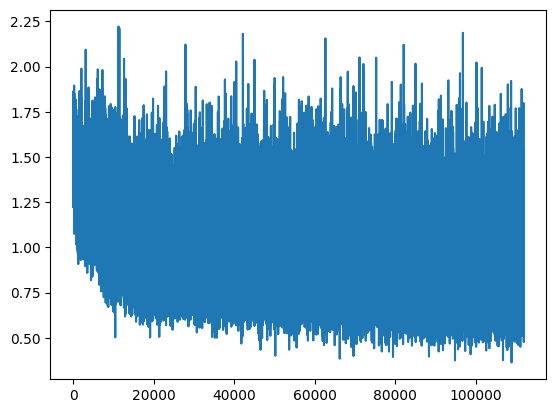

In [30]:
plt.plot(train_losses)

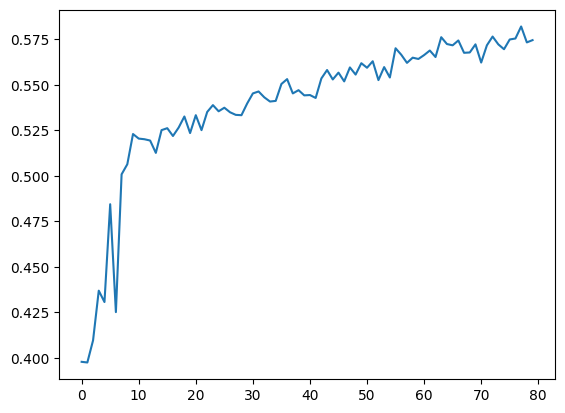

In [31]:
plt.plot(test_accuracy)

In [32]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 3218/5600 (0.5746)
{'acc_detail': tensor([0.5707, 0.6307, 0.6864, 0.4107], device='cuda:0'),
 'acc_unweighted': tensor(0.5746, device='cuda:0'),
 'acc_weighted': tensor(0.5746, device='cuda:0'),
 'f1s_detail': tensor([0.6051, 0.5826, 0.6612, 0.4388], device='cuda:0'),
 'f1s_unweighted': tensor(0.5719, device='cuda:0'),
 'f1s_weighted': tensor(0.5719, device='cuda:0'),
 'precision_detail': tensor([0.6438, 0.5414, 0.6377, 0.4709], device='cuda:0'),
 'recall_detail': tensor([0.5707, 0.6307, 0.6864, 0.4107], device='cuda:0'),
 'rocauc_detail': tensor([0.8688, 0.8410, 0.8692, 0.7525], device='cuda:0'),
 'rocauc_unweighted': tensor(0.8329, device='cuda:0'),
 'rocauc_weighted': tensor(0.8329, device='cuda:0'),
 'uar': tensor(0.5746, device='cuda:0'),
 'wap': tensor(0.5735, device='cuda:0')}


tensor([[799, 139,  89, 373],
        [ 41, 883, 310, 166],
        [ 70, 262, 961, 107],
        [331, 347, 147, 575]], device='cuda:0')

In [34]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_esd4/esd4_m13_best_78epoch.pt
Correct: 3260/5600 (0.5821)
{'acc_detail': tensor([0.7364, 0.6650, 0.5964, 0.3307], device='cuda:0'),
 'acc_unweighted': tensor(0.5821, device='cuda:0'),
 'acc_weighted': tensor(0.5821, device='cuda:0'),
 'f1s_detail': tensor([0.6486, 0.6032, 0.6480, 0.3929], device='cuda:0'),
 'f1s_unweighted': tensor(0.5732, device='cuda:0'),
 'f1s_weighted': tensor(0.5732, device='cuda:0'),
 'precision_detail': tensor([0.5795, 0.5519, 0.7094, 0.4838], device='cuda:0'),
 'recall_detail': tensor([0.7364, 0.6650, 0.5964, 0.3307], device='cuda:0'),
 'rocauc_detail': tensor([0.8695, 0.8476, 0.8668, 0.7565], device='cuda:0'),
 'rocauc_unweighted': tensor(0.8351, device='cuda:0'),
 'rocauc_weighted': tensor(0.8351, device='cuda:0'),
 'uar': tensor(0.5821, device='cuda:0'),
 'wap': tensor(0.5812, device='cuda:0')}


tensor([[1031,  129,   49,  191],
        [  79,  931,  205,  185],
        [ 140,  307,  835,  118],
        [ 529,  320,   88,  463]], device='cuda:0')

In [35]:
checkpoint_path = '../models_esd4/esd4_m13_80epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [37]:
start_epoch = 81
n_epoch = 20

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch + n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                              | 0.0005714285714285715/20 [00:00<3:25:35, 616.81s/it]

Train Epoch: 81 [0/22400 (0%)]	Loss: 1.208154
Mem before-during-after: 48571392 1802127872 49419776


  0%|                               | 0.023428571428571413/20 [00:10<2:36:40, 470.58s/it]

Train Epoch: 81 [640/22400 (3%)]	Loss: 1.136102
Mem before-during-after: 49403392 1803449856 49403392


  0%|                               | 0.046285714285714215/20 [00:20<2:33:52, 462.70s/it]

Train Epoch: 81 [1280/22400 (6%)]	Loss: 0.708410
Mem before-during-after: 49419776 1805493760 49452544


  0%|                                | 0.06914285714285702/20 [00:30<2:32:03, 457.74s/it]

Train Epoch: 81 [1920/22400 (9%)]	Loss: 1.190434
Mem before-during-after: 49403392 1777960448 49989120


  0%|▏                               | 0.09199999999999982/20 [00:40<2:35:09, 467.60s/it]

Train Epoch: 81 [2560/22400 (11%)]	Loss: 1.135360
Mem before-during-after: 49534464 1805510144 49419776


  1%|▏                               | 0.11485714285714262/20 [00:51<2:33:18, 462.57s/it]

Train Epoch: 81 [3200/22400 (14%)]	Loss: 1.161820
Mem before-during-after: 49485312 1804498432 49403392


  1%|▏                               | 0.13771428571428573/20 [01:01<2:31:59, 459.15s/it]

Train Epoch: 81 [3840/22400 (17%)]	Loss: 0.811907
Mem before-during-after: 49468928 1805596160 50451968


  1%|▎                                | 0.1605714285714291/20 [01:11<2:37:49, 477.32s/it]

Train Epoch: 81 [4480/22400 (20%)]	Loss: 1.118260
Mem before-during-after: 49550848 1804514816 49616384


  1%|▎                               | 0.18342857142857244/20 [01:21<2:32:12, 460.86s/it]

Train Epoch: 81 [5120/22400 (23%)]	Loss: 0.839190
Mem before-during-after: 49468928 1804547584 49403392


  1%|▎                                | 0.2062857142857158/20 [01:32<2:30:50, 457.22s/it]

Train Epoch: 81 [5760/22400 (26%)]	Loss: 1.118237
Mem before-during-after: 49485312 1531639296 49419776


  1%|▎                               | 0.22914285714285915/20 [01:42<2:35:16, 471.21s/it]

Train Epoch: 81 [6400/22400 (29%)]	Loss: 0.720939
Mem before-during-after: 49419776 1708078592 50431488


  1%|▍                                | 0.2520000000000024/20 [01:52<2:31:13, 459.47s/it]

Train Epoch: 81 [7040/22400 (31%)]	Loss: 0.827367
Mem before-during-after: 49485312 1804498432 49403392


  1%|▍                               | 0.27485714285714463/20 [02:02<2:30:57, 459.20s/it]

Train Epoch: 81 [7680/22400 (34%)]	Loss: 0.792228
Mem before-during-after: 49419776 1804416512 49419776


  1%|▍                                | 0.2977142857142869/20 [02:12<2:32:54, 465.64s/it]

Train Epoch: 81 [8320/22400 (37%)]	Loss: 0.933885
Mem before-during-after: 49403392 1804498432 49403392


  2%|▌                                | 0.3205714285714291/20 [02:22<2:32:14, 464.16s/it]

Train Epoch: 81 [8960/22400 (40%)]	Loss: 1.014896
Mem before-during-after: 49403392 1804432896 49403392


  2%|▌                               | 0.34342857142857136/20 [02:33<2:33:22, 468.18s/it]

Train Epoch: 81 [9600/22400 (43%)]	Loss: 0.670864
Mem before-during-after: 49536512 1805444608 49403392


  2%|▌                                | 0.3662857142857136/20 [02:43<2:36:23, 477.92s/it]

Train Epoch: 81 [10240/22400 (46%)]	Loss: 0.857245
Mem before-during-after: 49403392 1804416512 49403392


  2%|▌                               | 0.38914285714285585/20 [02:54<2:30:32, 460.60s/it]

Train Epoch: 81 [10880/22400 (49%)]	Loss: 1.127467
Mem before-during-after: 49403392 1804498432 49403392


  2%|▋                                | 0.4119999999999981/20 [03:04<2:40:50, 492.66s/it]

Train Epoch: 81 [11520/22400 (51%)]	Loss: 0.929997
Mem before-during-after: 49403392 1804432896 49403392


  2%|▋                               | 0.43485714285714033/20 [03:14<2:33:10, 469.72s/it]

Train Epoch: 81 [12160/22400 (54%)]	Loss: 0.717195
Mem before-during-after: 49403392 1804432896 49403392


  2%|▊                                | 0.4577142857142826/20 [03:25<2:33:17, 470.66s/it]

Train Epoch: 81 [12800/22400 (57%)]	Loss: 1.243124
Mem before-during-after: 49403392 1804383744 49403392


  2%|▊                                | 0.4805714285714248/20 [03:35<2:33:18, 471.23s/it]

Train Epoch: 81 [13440/22400 (60%)]	Loss: 1.177214
Mem before-during-after: 49403392 1598578176 49403392


  3%|▊                                | 0.5034285714285671/20 [03:45<2:31:11, 465.29s/it]

Train Epoch: 81 [14080/22400 (63%)]	Loss: 1.060684
Mem before-during-after: 49403392 1804811264 49403392


  3%|▊                                | 0.5262857142857094/20 [03:55<2:28:18, 456.97s/it]

Train Epoch: 81 [14720/22400 (66%)]	Loss: 1.062651
Mem before-during-after: 49403392 1760724480 49567232


  3%|▉                                | 0.5491428571428516/20 [04:05<2:29:04, 459.86s/it]

Train Epoch: 81 [15360/22400 (69%)]	Loss: 0.706348
Mem before-during-after: 49403392 1804498432 49403392


  3%|▉                                | 0.5719999999999938/20 [04:15<2:30:22, 464.43s/it]

Train Epoch: 81 [16000/22400 (71%)]	Loss: 1.214471
Mem before-during-after: 49468928 1641952768 50451968


  3%|▉                                | 0.5948571428571361/20 [04:25<2:29:52, 463.40s/it]

Train Epoch: 81 [16640/22400 (74%)]	Loss: 0.788308
Mem before-during-after: 49616896 1804416512 49419776


  3%|█                                | 0.6177142857142783/20 [04:35<2:32:18, 471.47s/it]

Train Epoch: 81 [17280/22400 (77%)]	Loss: 0.931273
Mem before-during-after: 49403392 1776342528 49715200


  3%|█                                | 0.6405714285714206/20 [04:45<2:29:50, 464.42s/it]

Train Epoch: 81 [17920/22400 (80%)]	Loss: 0.777075
Mem before-during-after: 49403392 1804498432 49403392


  3%|█                                | 0.6634285714285628/20 [04:55<2:29:31, 463.96s/it]

Train Epoch: 81 [18560/22400 (83%)]	Loss: 1.089287
Mem before-during-after: 50260480 1777227264 49419776


  3%|█▏                               | 0.6862857142857051/20 [05:05<2:31:01, 469.20s/it]

Train Epoch: 81 [19200/22400 (86%)]	Loss: 0.922569
Mem before-during-after: 49534464 1804400128 49403392


  4%|█▏                               | 0.7091428571428473/20 [05:15<2:31:53, 472.43s/it]

Train Epoch: 81 [19840/22400 (89%)]	Loss: 0.890986
Mem before-during-after: 49468928 1804449280 49403392


  4%|█▏                               | 0.7319999999999895/20 [05:26<2:25:30, 453.11s/it]

Train Epoch: 81 [20480/22400 (91%)]	Loss: 0.996672
Mem before-during-after: 49739264 1571333632 49501696


  4%|█▏                               | 0.7548571428571318/20 [05:36<2:33:48, 479.50s/it]

Train Epoch: 81 [21120/22400 (94%)]	Loss: 0.742624
Mem before-during-after: 49403392 1804383744 49403392


  4%|█▎                                | 0.777714285714274/20 [05:46<2:33:01, 477.65s/it]

Train Epoch: 81 [21760/22400 (97%)]	Loss: 0.909365
Mem before-during-after: 49534976 1803449856 49403392


  5%|█▋                               | 0.9999999999999823/20 [07:11<1:57:19, 370.50s/it]


Test Epoch: 81	Accuracy: 3234/5600 (58%)



  5%|█▋                                | 1.000571428571411/20 [07:11<2:02:41, 387.46s/it]

Train Epoch: 82 [0/22400 (0%)]	Loss: 0.839327
Mem before-during-after: 49412608 1585985024 49419776


  5%|█▋                               | 1.0234285714285576/20 [07:21<2:23:59, 455.29s/it]

Train Epoch: 82 [640/22400 (3%)]	Loss: 1.024311
Mem before-during-after: 49403392 1803351552 49485312


  5%|█▋                               | 1.0462857142857043/20 [07:31<2:25:04, 459.27s/it]

Train Epoch: 82 [1280/22400 (6%)]	Loss: 0.795251
Mem before-during-after: 49403392 1803351552 49485312


  5%|█▊                                | 1.069142857142851/20 [07:42<2:24:07, 456.79s/it]

Train Epoch: 82 [1920/22400 (9%)]	Loss: 1.075478
Mem before-during-after: 49419776 1803449856 49403392


  5%|█▊                               | 1.0919999999999976/20 [07:52<2:26:50, 465.97s/it]

Train Epoch: 82 [2560/22400 (11%)]	Loss: 1.163540
Mem before-during-after: 49403392 1803351552 49485312


  6%|█▊                               | 1.1148571428571443/20 [08:02<2:25:06, 461.04s/it]

Train Epoch: 82 [3200/22400 (14%)]	Loss: 0.786032
Mem before-during-after: 49419776 1803449856 49403392


  6%|█▉                                | 1.137714285714291/20 [08:12<2:24:26, 459.45s/it]

Train Epoch: 82 [3840/22400 (17%)]	Loss: 0.931166
Mem before-during-after: 49403392 1803384320 49468928


  6%|█▉                               | 1.1605714285714377/20 [08:22<2:24:01, 458.68s/it]

Train Epoch: 82 [4480/22400 (20%)]	Loss: 0.875152
Mem before-during-after: 49419776 1723160064 49403392


  6%|█▉                               | 1.1834285714285844/20 [08:32<2:25:51, 465.11s/it]

Train Epoch: 82 [5120/22400 (23%)]	Loss: 0.972155
Mem before-during-after: 49403392 1722013184 49403392


  6%|██                                | 1.206285714285731/20 [08:42<2:24:52, 462.55s/it]

Train Epoch: 82 [5760/22400 (26%)]	Loss: 0.773501
Mem before-during-after: 49403392 1803466240 49419776


  6%|██                               | 1.2291428571428777/20 [08:52<2:23:18, 458.09s/it]

Train Epoch: 82 [6400/22400 (29%)]	Loss: 1.133799
Mem before-during-after: 49485312 1803449856 49403392


  6%|██                               | 1.2520000000000244/20 [09:02<2:24:46, 463.34s/it]

Train Epoch: 82 [7040/22400 (31%)]	Loss: 0.940272
Mem before-during-after: 49419776 1804539392 49468928


  6%|██▏                               | 1.274857142857171/20 [09:12<2:21:36, 453.72s/it]

Train Epoch: 82 [7680/22400 (34%)]	Loss: 0.895362
Mem before-during-after: 49436160 1803367936 49419776


  6%|██▏                              | 1.2977142857143178/20 [09:23<2:22:51, 458.32s/it]

Train Epoch: 82 [8320/22400 (37%)]	Loss: 0.963527
Mem before-during-after: 49403392 1803351552 49485312


  7%|██▏                              | 1.3205714285714645/20 [09:33<2:26:19, 470.04s/it]

Train Epoch: 82 [8960/22400 (40%)]	Loss: 1.055322
Mem before-during-after: 49403392 1803351552 49485312


  7%|██▏                              | 1.3434285714286112/20 [09:43<2:39:12, 512.03s/it]

Train Epoch: 82 [9600/22400 (43%)]	Loss: 1.007561
Mem before-during-after: 49403392 1803351552 49485312


  7%|██▎                              | 1.3662857142857578/20 [09:54<2:20:59, 454.00s/it]

Train Epoch: 82 [10240/22400 (46%)]	Loss: 0.900394
Mem before-during-after: 49403392 1803992576 49534464


  7%|██▎                              | 1.3891428571429045/20 [10:04<2:26:24, 471.99s/it]

Train Epoch: 82 [10880/22400 (49%)]	Loss: 1.187828
Mem before-during-after: 49403392 1625204224 49403392


  7%|██▎                              | 1.4120000000000512/20 [10:14<2:21:39, 457.27s/it]

Train Epoch: 82 [11520/22400 (51%)]	Loss: 1.038987
Mem before-during-after: 49403392 1679418880 49403392


  7%|██▍                               | 1.434857142857198/20 [10:24<2:26:16, 472.77s/it]

Train Epoch: 82 [12160/22400 (54%)]	Loss: 0.814578
Mem before-during-after: 49589760 1803466240 49419776


  7%|██▍                              | 1.4577142857143446/20 [10:34<2:22:27, 460.99s/it]

Train Epoch: 82 [12800/22400 (57%)]	Loss: 0.557114
Mem before-during-after: 49468928 1803515392 49403392


  7%|██▍                              | 1.4805714285714913/20 [10:44<2:19:19, 451.38s/it]

Train Epoch: 82 [13440/22400 (60%)]	Loss: 1.060801
Mem before-during-after: 49616384 1803449856 49485312


  8%|██▌                               | 1.503428571428638/20 [10:54<2:20:42, 456.46s/it]

Train Epoch: 82 [14080/22400 (63%)]	Loss: 1.196268
Mem before-during-after: 49518080 1803351552 49501696


  8%|██▌                              | 1.5262857142857846/20 [11:04<2:22:11, 461.82s/it]

Train Epoch: 82 [14720/22400 (66%)]	Loss: 0.698812
Mem before-during-after: 49403392 1803351552 49485312


  8%|██▌                              | 1.5491428571429313/20 [11:14<2:21:11, 459.11s/it]

Train Epoch: 82 [15360/22400 (69%)]	Loss: 0.869949
Mem before-during-after: 49403392 1804375552 49403392


  8%|██▋                               | 1.572000000000078/20 [11:24<2:21:24, 460.43s/it]

Train Epoch: 82 [16000/22400 (71%)]	Loss: 0.888860
Mem before-during-after: 49403392 1803351552 49403392


  8%|██▋                              | 1.5948571428572247/20 [11:34<2:19:39, 455.26s/it]

Train Epoch: 82 [16640/22400 (74%)]	Loss: 1.101893
Mem before-during-after: 49518080 1803449856 49403392


  8%|██▋                              | 1.6177142857143714/20 [11:44<2:18:52, 453.30s/it]

Train Epoch: 82 [17280/22400 (77%)]	Loss: 0.732452
Mem before-during-after: 49485312 1803449856 49403392


  8%|██▊                               | 1.640571428571518/20 [11:54<2:18:17, 451.94s/it]

Train Epoch: 82 [17920/22400 (80%)]	Loss: 0.930539
Mem before-during-after: 49419776 1667503616 49403392


  8%|██▋                              | 1.6634285714286647/20 [12:04<2:23:09, 468.45s/it]

Train Epoch: 82 [18560/22400 (83%)]	Loss: 0.990205
Mem before-during-after: 49485312 1803466240 49501696


  8%|██▊                              | 1.6862857142858114/20 [12:14<2:23:03, 468.70s/it]

Train Epoch: 82 [19200/22400 (86%)]	Loss: 1.169177
Mem before-during-after: 49403392 1803449856 49403392


  9%|██▉                               | 1.709142857142958/20 [12:24<2:20:53, 462.16s/it]

Train Epoch: 82 [19840/22400 (89%)]	Loss: 0.884036
Mem before-during-after: 49403392 1803351552 49485312


  9%|██▊                              | 1.7320000000001048/20 [12:34<2:17:52, 452.84s/it]

Train Epoch: 82 [20480/22400 (91%)]	Loss: 0.995241
Mem before-during-after: 49419776 1803449856 49403392


  9%|██▉                              | 1.7548571428572515/20 [12:45<2:22:25, 468.37s/it]

Train Epoch: 82 [21120/22400 (94%)]	Loss: 1.128953
Mem before-during-after: 49403392 1803367936 49419776


  9%|██▉                              | 1.7777142857143982/20 [12:55<2:18:27, 455.91s/it]

Train Epoch: 82 [21760/22400 (97%)]	Loss: 0.652450
Mem before-during-after: 49880064 1679554048 49419776


 10%|███▎                             | 2.0000000000001497/20 [14:20<1:52:55, 376.43s/it]


Test Epoch: 82	Accuracy: 3244/5600 (58%)



 10%|███▍                              | 2.000571428571578/20 [14:20<2:01:28, 404.92s/it]

Train Epoch: 83 [0/22400 (0%)]	Loss: 0.793013
Mem before-during-after: 49412608 1803400704 49419776


 10%|███▍                              | 2.023428571428716/20 [14:30<2:15:49, 453.32s/it]

Train Epoch: 83 [640/22400 (3%)]	Loss: 0.914457
Mem before-during-after: 49485312 1804498432 49403392


 10%|███▍                             | 2.0462857142858537/20 [14:41<2:18:02, 461.31s/it]

Train Epoch: 83 [1280/22400 (6%)]	Loss: 1.005067
Mem before-during-after: 49403392 1804498432 49403392


 10%|███▍                             | 2.0691428571429915/20 [14:51<2:20:13, 469.21s/it]

Train Epoch: 83 [1920/22400 (9%)]	Loss: 0.862964
Mem before-during-after: 49403392 1804400128 49485312


 10%|███▍                             | 2.0920000000001293/20 [15:01<2:17:53, 461.98s/it]

Train Epoch: 83 [2560/22400 (11%)]	Loss: 0.614450
Mem before-during-after: 49485312 1804465664 49419776


 11%|███▌                              | 2.114857142857267/20 [15:11<2:19:25, 467.71s/it]

Train Epoch: 83 [3200/22400 (14%)]	Loss: 0.838980
Mem before-during-after: 49403392 1804482048 49468928


 11%|███▋                              | 2.137714285714405/20 [15:21<2:15:05, 453.77s/it]

Train Epoch: 83 [3840/22400 (17%)]	Loss: 0.654542
Mem before-during-after: 49403392 1804482048 49468928


 11%|███▌                             | 2.1605714285715427/20 [15:32<2:17:14, 461.58s/it]

Train Epoch: 83 [4480/22400 (20%)]	Loss: 0.907929
Mem before-during-after: 49403392 1804580352 49468928


 11%|███▌                             | 2.1834285714286805/20 [15:42<2:15:38, 456.77s/it]

Train Epoch: 83 [5120/22400 (23%)]	Loss: 0.805409
Mem before-during-after: 49468928 1804563968 49403392


 11%|███▋                             | 2.2062857142858183/20 [15:52<2:13:45, 451.03s/it]

Train Epoch: 83 [5760/22400 (26%)]	Loss: 1.057329
Mem before-during-after: 49403392 1760749056 49591808


 11%|███▊                              | 2.229142857142956/20 [16:02<2:22:01, 479.52s/it]

Train Epoch: 83 [6400/22400 (29%)]	Loss: 0.949175
Mem before-during-after: 49468928 1804547584 49403392


 11%|███▊                              | 2.252000000000094/20 [16:12<2:17:25, 464.60s/it]

Train Epoch: 83 [7040/22400 (31%)]	Loss: 0.968662
Mem before-during-after: 49403392 1804400128 49485312


 11%|███▊                             | 2.2748571428572317/20 [16:22<2:13:49, 453.00s/it]

Train Epoch: 83 [7680/22400 (34%)]	Loss: 0.951383
Mem before-during-after: 49485312 1804498432 49403392


 11%|███▊                             | 2.2977142857143695/20 [16:32<2:14:36, 456.24s/it]

Train Epoch: 83 [8320/22400 (37%)]	Loss: 1.033524
Mem before-during-after: 49485312 1804514816 49616384


 12%|███▊                             | 2.3205714285715073/20 [16:42<2:14:17, 455.78s/it]

Train Epoch: 83 [8960/22400 (40%)]	Loss: 0.933188
Mem before-during-after: 49436160 1804432896 49419776


 12%|███▉                              | 2.343428571428645/20 [16:52<2:15:58, 462.07s/it]

Train Epoch: 83 [9600/22400 (43%)]	Loss: 0.783539
Mem before-during-after: 49419776 1804482048 49485312


 12%|████                              | 2.366285714285783/20 [17:03<2:15:04, 459.58s/it]

Train Epoch: 83 [10240/22400 (46%)]	Loss: 1.224398
Mem before-during-after: 49534464 1804416512 49403392


 12%|███▉                             | 2.3891428571429207/20 [17:13<2:16:09, 463.91s/it]

Train Epoch: 83 [10880/22400 (49%)]	Loss: 1.063598
Mem before-during-after: 49403392 1804498432 49403392


 12%|███▉                             | 2.4120000000000585/20 [17:23<2:15:45, 463.14s/it]

Train Epoch: 83 [11520/22400 (51%)]	Loss: 1.041334
Mem before-during-after: 49403392 1804432896 49403392


 12%|████                             | 2.4348571428571963/20 [17:33<2:14:32, 459.60s/it]

Train Epoch: 83 [12160/22400 (54%)]	Loss: 0.845605
Mem before-during-after: 49403392 1804514816 49534464


 12%|████▏                             | 2.457714285714334/20 [17:43<2:14:11, 458.99s/it]

Train Epoch: 83 [12800/22400 (57%)]	Loss: 0.931650
Mem before-during-after: 49485312 1804416512 49403392


 12%|████▏                             | 2.480571428571472/20 [17:53<2:15:56, 465.55s/it]

Train Epoch: 83 [13440/22400 (60%)]	Loss: 1.204968
Mem before-during-after: 49403392 1569692672 49419776


 13%|████▏                            | 2.5034285714286098/20 [18:04<2:12:31, 454.49s/it]

Train Epoch: 83 [14080/22400 (63%)]	Loss: 1.231341
Mem before-during-after: 49403392 1679570432 49419776


 13%|████▏                            | 2.5262857142857476/20 [18:14<2:17:12, 471.15s/it]

Train Epoch: 83 [14720/22400 (66%)]	Loss: 0.954852
Mem before-during-after: 49534464 1760740864 49403392


 13%|████▏                            | 2.5491428571428854/20 [18:24<2:12:04, 454.08s/it]

Train Epoch: 83 [15360/22400 (69%)]	Loss: 0.620979
Mem before-during-after: 49534464 1788773888 49419776


 13%|████▎                             | 2.572000000000023/20 [18:34<2:19:35, 480.60s/it]

Train Epoch: 83 [16000/22400 (71%)]	Loss: 0.633777
Mem before-during-after: 49403392 1804514816 49534464


 13%|████▍                             | 2.594857142857161/20 [18:44<2:18:58, 479.08s/it]

Train Epoch: 83 [16640/22400 (74%)]	Loss: 0.779323
Mem before-during-after: 49485312 1804416512 49403392


 13%|████▎                            | 2.6177142857142988/20 [18:55<2:19:57, 483.11s/it]

Train Epoch: 83 [17280/22400 (77%)]	Loss: 1.248974
Mem before-during-after: 49403392 1804432896 49403392


 13%|████▎                            | 2.6405714285714366/20 [19:05<2:14:43, 465.67s/it]

Train Epoch: 83 [17920/22400 (80%)]	Loss: 0.788377
Mem before-during-after: 49485312 1804416512 49403392


 13%|████▍                            | 2.6634285714285744/20 [19:16<2:12:37, 459.02s/it]

Train Epoch: 83 [18560/22400 (83%)]	Loss: 1.140074
Mem before-during-after: 49419776 1804416512 49403392


 13%|████▌                             | 2.686285714285712/20 [19:26<2:12:18, 458.52s/it]

Train Epoch: 83 [19200/22400 (86%)]	Loss: 0.648360
Mem before-during-after: 49550848 1804469760 49403392


 14%|████▋                              | 2.70914285714285/20 [19:36<2:23:26, 497.78s/it]

Train Epoch: 83 [19840/22400 (89%)]	Loss: 0.927187
Mem before-during-after: 49419776 1804502528 49403392


 14%|████▌                            | 2.7319999999999878/20 [19:46<2:11:12, 455.90s/it]

Train Epoch: 83 [20480/22400 (91%)]	Loss: 0.945533
Mem before-during-after: 49419776 1803453952 49403392


 14%|████▌                            | 2.7548571428571256/20 [19:56<2:11:11, 456.46s/it]

Train Epoch: 83 [21120/22400 (94%)]	Loss: 1.308354
Mem before-during-after: 49403392 1804453376 49468928


 14%|████▌                            | 2.7777142857142634/20 [20:06<2:13:45, 466.02s/it]

Train Epoch: 83 [21760/22400 (97%)]	Loss: 0.926940
Mem before-during-after: 49436160 1804535296 49403392


 15%|████▉                            | 2.9999999999999285/20 [21:32<1:44:45, 369.72s/it]


Test Epoch: 83	Accuracy: 3244/5600 (58%)



 15%|█████                             | 3.000571428571357/20 [21:32<1:52:31, 397.17s/it]

Train Epoch: 84 [0/22400 (0%)]	Loss: 0.852021
Mem before-during-after: 49412608 1721849344 49419776


 15%|████▉                            | 3.0234285714284947/20 [21:43<2:12:47, 469.34s/it]

Train Epoch: 84 [640/22400 (3%)]	Loss: 1.130845
Mem before-during-after: 49485312 1803449856 49403392


 15%|█████                            | 3.0462857142856326/20 [21:53<2:22:06, 502.91s/it]

Train Epoch: 84 [1280/22400 (6%)]	Loss: 0.968484
Mem before-during-after: 49403392 1803351552 49485312


 15%|█████                            | 3.0691428571427704/20 [22:03<2:07:45, 452.73s/it]

Train Epoch: 84 [1920/22400 (9%)]	Loss: 1.077264
Mem before-during-after: 49403392 1803449856 49468928


 15%|█████▎                            | 3.091999999999908/20 [22:13<2:10:56, 464.65s/it]

Train Epoch: 84 [2560/22400 (11%)]	Loss: 1.548193
Mem before-during-after: 49468928 1707103744 49419776


 16%|█████▎                            | 3.114857142857046/20 [22:23<2:12:44, 471.67s/it]

Train Epoch: 84 [3200/22400 (14%)]	Loss: 0.846221
Mem before-during-after: 49403392 1696007680 49735168


 16%|█████▏                           | 3.1377142857141838/20 [22:33<2:11:38, 468.40s/it]

Train Epoch: 84 [3840/22400 (17%)]	Loss: 0.896814
Mem before-during-after: 49485312 1803433472 49403392


 16%|█████▏                           | 3.1605714285713216/20 [22:43<2:11:00, 466.78s/it]

Train Epoch: 84 [4480/22400 (20%)]	Loss: 0.847242
Mem before-during-after: 49403392 1804494336 49534464


 16%|█████▎                           | 3.1834285714284594/20 [22:54<2:10:19, 465.00s/it]

Train Epoch: 84 [5120/22400 (23%)]	Loss: 0.835827
Mem before-during-after: 49494528 1803433472 49419776


 16%|█████▍                            | 3.206285714285597/20 [23:04<2:14:38, 481.05s/it]

Train Epoch: 84 [5760/22400 (26%)]	Loss: 0.865565
Mem before-during-after: 50028032 1804008960 50044416


 16%|█████▍                            | 3.229142857142735/20 [23:14<2:10:29, 466.84s/it]

Train Epoch: 84 [6400/22400 (29%)]	Loss: 1.054813
Mem before-during-after: 49403392 1803531776 49468928


 16%|█████▎                           | 3.2519999999998728/20 [23:24<2:15:59, 487.17s/it]

Train Epoch: 84 [7040/22400 (31%)]	Loss: 0.723435
Mem before-during-after: 49468928 1760626176 49403392


 16%|█████▍                           | 3.2748571428570106/20 [23:35<2:07:34, 457.64s/it]

Train Epoch: 84 [7680/22400 (34%)]	Loss: 0.852706
Mem before-during-after: 49468928 1803515392 49403392


 16%|█████▍                           | 3.2977142857141484/20 [23:45<2:11:20, 471.82s/it]

Train Epoch: 84 [8320/22400 (37%)]	Loss: 1.123565
Mem before-during-after: 49485312 1803515392 49468928


 17%|█████▋                            | 3.320571428571286/20 [23:55<2:06:59, 456.79s/it]

Train Epoch: 84 [8960/22400 (40%)]	Loss: 0.737519
Mem before-during-after: 49468928 1803970048 49403392


 17%|█████▋                            | 3.343428571428424/20 [24:05<2:08:04, 461.34s/it]

Train Epoch: 84 [9600/22400 (43%)]	Loss: 1.186587
Mem before-during-after: 49485312 1803515392 49419776


 17%|█████▋                            | 3.366285714285562/20 [24:17<2:05:14, 451.74s/it]

Train Epoch: 84 [10240/22400 (46%)]	Loss: 1.215744
Mem before-during-after: 49468928 1680127488 49847296


 17%|█████▌                           | 3.3891428571426996/20 [24:27<2:11:38, 475.49s/it]

Train Epoch: 84 [10880/22400 (49%)]	Loss: 0.938000
Mem before-during-after: 49419776 1803531776 49485312


 17%|█████▋                           | 3.4119999999998374/20 [24:37<2:12:16, 478.48s/it]

Train Epoch: 84 [11520/22400 (51%)]	Loss: 0.787131
Mem before-during-after: 49485312 1803515392 49419776


 17%|█████▊                            | 3.434857142856975/20 [24:48<2:07:07, 460.47s/it]

Train Epoch: 84 [12160/22400 (54%)]	Loss: 1.091279
Mem before-during-after: 49403392 1803466240 49419776


 17%|█████▉                            | 3.457714285714113/20 [24:58<2:08:20, 465.48s/it]

Train Epoch: 84 [12800/22400 (57%)]	Loss: 0.923515
Mem before-during-after: 49403392 1803474432 49534464


 17%|█████▉                            | 3.480571428571251/20 [25:08<2:06:12, 458.40s/it]

Train Epoch: 84 [13440/22400 (60%)]	Loss: 0.591757
Mem before-during-after: 49403392 1803408896 49468928


 18%|█████▊                           | 3.5034285714283886/20 [25:18<2:04:33, 453.05s/it]

Train Epoch: 84 [14080/22400 (63%)]	Loss: 0.531926
Mem before-during-after: 49468928 1803490816 49403392


 18%|█████▊                           | 3.5262857142855264/20 [25:28<2:06:10, 459.53s/it]

Train Epoch: 84 [14720/22400 (66%)]	Loss: 0.793339
Mem before-during-after: 49468928 1803490816 49403392


 18%|██████                            | 3.549142857142664/20 [25:39<2:49:16, 617.41s/it]

Train Epoch: 84 [15360/22400 (69%)]	Loss: 0.663779
Mem before-during-after: 49403392 1803458048 49403392


 18%|██████                            | 3.571999999999802/20 [25:49<2:05:30, 458.40s/it]

Train Epoch: 84 [16000/22400 (71%)]	Loss: 0.872876
Mem before-during-after: 49485312 1707824640 49964544


 18%|██████▎                            | 3.59485714285694/20 [25:59<2:04:00, 453.54s/it]

Train Epoch: 84 [16640/22400 (74%)]	Loss: 0.769369
Mem before-during-after: 49485312 1803376128 49403392


 18%|█████▉                           | 3.6177142857140776/20 [26:10<2:08:34, 470.93s/it]

Train Epoch: 84 [17280/22400 (77%)]	Loss: 0.966806
Mem before-during-after: 49403392 1803474432 49534464


 18%|██████                           | 3.6405714285712154/20 [26:20<2:05:22, 459.84s/it]

Train Epoch: 84 [17920/22400 (80%)]	Loss: 1.482079
Mem before-during-after: 49419776 1803458048 49403392


 18%|██████▏                           | 3.663428571428353/20 [26:30<2:05:39, 461.52s/it]

Train Epoch: 84 [18560/22400 (83%)]	Loss: 0.781889
Mem before-during-after: 49534464 1803449856 49403392


 18%|██████▎                           | 3.686285714285491/20 [26:41<2:16:17, 501.28s/it]

Train Epoch: 84 [19200/22400 (86%)]	Loss: 1.005416
Mem before-during-after: 49403392 1803376128 49403392


 19%|██████▎                           | 3.709142857142629/20 [26:51<2:11:38, 484.85s/it]

Train Epoch: 84 [19840/22400 (89%)]	Loss: 0.816669
Mem before-during-after: 49403392 1803408896 49468928


 19%|██████▏                          | 3.7319999999997666/20 [27:02<2:06:41, 467.26s/it]

Train Epoch: 84 [20480/22400 (91%)]	Loss: 0.820820
Mem before-during-after: 49403392 1803474432 49534464


 19%|██████▏                          | 3.7548571428569044/20 [27:12<2:05:06, 462.05s/it]

Train Epoch: 84 [21120/22400 (94%)]	Loss: 0.805171
Mem before-during-after: 49403392 1679872000 49534464


 19%|██████▍                           | 3.777714285714042/20 [27:22<2:07:33, 471.76s/it]

Train Epoch: 84 [21760/22400 (97%)]	Loss: 1.506738
Mem before-during-after: 49403392 1803539968 49468928


 20%|██████▌                          | 3.9999999999997073/20 [28:50<1:41:24, 380.28s/it]


Test Epoch: 84	Accuracy: 3256/5600 (58%)



 20%|██████▊                           | 4.000571428571136/20 [28:50<1:51:09, 416.86s/it]

Train Epoch: 85 [0/22400 (0%)]	Loss: 0.939039
Mem before-during-after: 49412608 1679042048 49419776


 20%|██████▊                           | 4.023428571428291/20 [29:00<2:18:26, 519.93s/it]

Train Epoch: 85 [640/22400 (3%)]	Loss: 0.927900
Mem before-during-after: 49403392 1805444608 49403392


 20%|██████▉                           | 4.046285714285447/20 [29:10<2:04:09, 466.96s/it]

Train Epoch: 85 [1280/22400 (6%)]	Loss: 0.843548
Mem before-during-after: 49485312 1805444608 49403392


 20%|██████▋                          | 4.0691428571426025/20 [29:20<1:59:20, 449.46s/it]

Train Epoch: 85 [1920/22400 (9%)]	Loss: 1.120262
Mem before-during-after: 49403392 1697826304 50817536


 20%|██████▉                           | 4.091999999999758/20 [29:30<2:00:39, 455.06s/it]

Train Epoch: 85 [2560/22400 (11%)]	Loss: 0.661598
Mem before-during-after: 49403392 1805542912 49534464


 21%|██████▉                           | 4.114857142856914/20 [29:40<2:00:25, 454.83s/it]

Train Epoch: 85 [3200/22400 (14%)]	Loss: 1.009612
Mem before-during-after: 49485312 1805493760 49419776


 21%|███████                           | 4.137714285714069/20 [29:51<2:13:02, 503.25s/it]

Train Epoch: 85 [3840/22400 (17%)]	Loss: 0.918875
Mem before-during-after: 49403392 1804465664 49452544


 21%|███████                           | 4.160571428571225/20 [30:01<2:01:48, 461.39s/it]

Train Epoch: 85 [4480/22400 (20%)]	Loss: 0.786493
Mem before-during-after: 49809920 1803466240 49419776


 21%|███████▎                           | 4.18342857142838/20 [30:11<2:04:22, 471.81s/it]

Train Epoch: 85 [5120/22400 (23%)]	Loss: 0.708977
Mem before-during-after: 49403392 1804416512 49403392


 21%|███████▏                          | 4.206285714285536/20 [30:21<1:59:45, 454.96s/it]

Train Epoch: 85 [5760/22400 (26%)]	Loss: 1.036658
Mem before-during-after: 49419776 1804498432 49403392


 21%|██████▉                          | 4.2291428571426914/20 [30:32<2:09:20, 492.07s/it]

Train Epoch: 85 [6400/22400 (29%)]	Loss: 1.265739
Mem before-during-after: 49403392 1625220608 49403392


 21%|███████▏                          | 4.251999999999847/20 [30:42<2:06:29, 481.92s/it]

Train Epoch: 85 [7040/22400 (31%)]	Loss: 0.824291
Mem before-during-after: 49419776 1804514816 49419776


 21%|███████▎                          | 4.274857142857003/20 [30:52<2:00:56, 461.47s/it]

Train Epoch: 85 [7680/22400 (34%)]	Loss: 0.816998
Mem before-during-after: 49403392 1804498432 49403392


 21%|███████▎                          | 4.297714285714158/20 [31:02<2:02:15, 467.13s/it]

Train Epoch: 85 [8320/22400 (37%)]	Loss: 0.931959
Mem before-during-after: 49485312 1542437888 49403392


 22%|███████▎                          | 4.320571428571314/20 [31:13<2:01:23, 464.55s/it]

Train Epoch: 85 [8960/22400 (40%)]	Loss: 0.548336
Mem before-during-after: 49419776 1803449856 49403392


 22%|███████▍                          | 4.343428571428469/20 [31:23<2:01:32, 465.75s/it]

Train Epoch: 85 [9600/22400 (43%)]	Loss: 0.996651
Mem before-during-after: 49403392 1804432896 49403392


 22%|███████▍                          | 4.366285714285625/20 [31:33<2:00:59, 464.33s/it]

Train Epoch: 85 [10240/22400 (46%)]	Loss: 0.806090
Mem before-during-after: 49403392 1804498432 49403392


 22%|███████▋                           | 4.38914285714278/20 [31:43<2:00:51, 464.51s/it]

Train Epoch: 85 [10880/22400 (49%)]	Loss: 0.938711
Mem before-during-after: 49534464 1804498432 49403392


 22%|███████▌                          | 4.411999999999936/20 [31:53<2:04:40, 479.90s/it]

Train Epoch: 85 [11520/22400 (51%)]	Loss: 0.944855
Mem before-during-after: 49534464 1707472384 49948160


 22%|███████▎                         | 4.4348571428570915/20 [32:04<2:06:38, 488.17s/it]

Train Epoch: 85 [12160/22400 (54%)]	Loss: 0.971014
Mem before-during-after: 49419776 1804514816 49534464


 22%|███████▌                          | 4.457714285714247/20 [32:14<2:02:19, 472.22s/it]

Train Epoch: 85 [12800/22400 (57%)]	Loss: 0.829542
Mem before-during-after: 50006528 1804510720 49550848


 22%|███████▌                          | 4.480571428571403/20 [32:25<2:03:03, 475.79s/it]

Train Epoch: 85 [13440/22400 (60%)]	Loss: 0.804398
Mem before-during-after: 49468928 1804482048 49403392


 23%|███████▋                          | 4.503428571428558/20 [32:35<1:56:22, 450.57s/it]

Train Epoch: 85 [14080/22400 (63%)]	Loss: 0.923953
Mem before-during-after: 49567744 1669629440 49534464


 23%|███████▋                          | 4.526285714285714/20 [32:45<2:04:29, 482.69s/it]

Train Epoch: 85 [14720/22400 (66%)]	Loss: 0.964121
Mem before-during-after: 49567232 1804498432 49419776


 23%|███████▋                          | 4.549142857142869/20 [32:55<2:06:24, 490.85s/it]

Train Epoch: 85 [15360/22400 (69%)]	Loss: 0.994197
Mem before-during-after: 49534464 1804383744 49403392


 23%|███████▊                          | 4.572000000000025/20 [33:05<1:57:32, 457.11s/it]

Train Epoch: 85 [16000/22400 (71%)]	Loss: 0.900685
Mem before-during-after: 49403392 1804416512 49485312


 23%|███████▌                         | 4.5948571428571805/20 [33:15<1:58:15, 460.56s/it]

Train Epoch: 85 [16640/22400 (74%)]	Loss: 0.803186
Mem before-during-after: 49403392 1804416512 49403392


 23%|███████▊                          | 4.617714285714336/20 [33:25<1:57:26, 458.07s/it]

Train Epoch: 85 [17280/22400 (77%)]	Loss: 0.767435
Mem before-during-after: 49419776 1760941568 49604096


 23%|███████▉                          | 4.640571428571492/20 [33:35<1:57:57, 460.80s/it]

Train Epoch: 85 [17920/22400 (80%)]	Loss: 1.037846
Mem before-during-after: 49419776 1804482048 49485312


 23%|███████▉                          | 4.663428571428647/20 [33:46<1:57:47, 460.82s/it]

Train Epoch: 85 [18560/22400 (83%)]	Loss: 1.060651
Mem before-during-after: 49403392 1707472384 49534464


 23%|███████▉                          | 4.686285714285803/20 [33:56<1:57:23, 459.95s/it]

Train Epoch: 85 [19200/22400 (86%)]	Loss: 0.870249
Mem before-during-after: 49419776 1804482048 49485312


 24%|████████                          | 4.709142857142958/20 [34:05<1:55:42, 454.03s/it]

Train Epoch: 85 [19840/22400 (89%)]	Loss: 1.428015
Mem before-during-after: 49419776 1804580352 49485312


 24%|████████                          | 4.732000000000114/20 [34:16<2:00:52, 474.98s/it]

Train Epoch: 85 [20480/22400 (91%)]	Loss: 0.789156
Mem before-during-after: 49403392 1804416512 49485312


 24%|███████▊                         | 4.7548571428572695/20 [34:26<2:00:25, 473.96s/it]

Train Epoch: 85 [21120/22400 (94%)]	Loss: 1.070686
Mem before-during-after: 49419776 1804514816 49616384


 24%|████████                          | 4.777714285714425/20 [34:36<1:54:34, 451.62s/it]

Train Epoch: 85 [21760/22400 (97%)]	Loss: 1.094262
Mem before-during-after: 49403392 1804076544 49534464


 25%|████████▌                         | 5.000000000000263/20 [36:01<1:31:39, 366.66s/it]


Test Epoch: 85	Accuracy: 3216/5600 (57%)



 25%|████████▌                         | 5.000571428571692/20 [36:01<1:54:41, 458.77s/it]

Train Epoch: 86 [0/22400 (0%)]	Loss: 0.980852
Mem before-during-after: 49412608 1803400704 49419776


 25%|████████▌                         | 5.023428571428847/20 [36:11<1:54:37, 459.20s/it]

Train Epoch: 86 [640/22400 (3%)]	Loss: 0.741484
Mem before-during-after: 49403392 1804400128 49485312


 25%|████████▌                         | 5.046285714286003/20 [36:21<1:52:54, 453.05s/it]

Train Epoch: 86 [1280/22400 (6%)]	Loss: 0.993481
Mem before-during-after: 49468928 1679257600 49419776


 25%|████████▎                        | 5.0691428571431585/20 [36:31<1:53:10, 454.81s/it]

Train Epoch: 86 [1920/22400 (9%)]	Loss: 0.852380
Mem before-during-after: 49403392 1805178368 49403392


 25%|████████▋                         | 5.092000000000314/20 [36:41<1:58:55, 478.61s/it]

Train Epoch: 86 [2560/22400 (11%)]	Loss: 0.871731
Mem before-during-after: 49403392 1804367360 49452544


 26%|████████▉                          | 5.11485714285747/20 [36:51<1:52:28, 453.40s/it]

Train Epoch: 86 [3200/22400 (14%)]	Loss: 0.935330
Mem before-during-after: 49403392 1804958720 49468928


 26%|████████▋                         | 5.137714285714625/20 [37:01<1:53:56, 460.02s/it]

Train Epoch: 86 [3840/22400 (17%)]	Loss: 1.026873
Mem before-during-after: 49618432 1804531200 49419776


 26%|████████▊                         | 5.160571428571781/20 [37:11<1:56:27, 470.84s/it]

Train Epoch: 86 [4480/22400 (20%)]	Loss: 1.134520
Mem before-during-after: 49403392 1804383744 49403392


 26%|████████▊                         | 5.183428571428936/20 [37:21<1:51:40, 452.20s/it]

Train Epoch: 86 [5120/22400 (23%)]	Loss: 0.859315
Mem before-during-after: 49403392 1804498432 49403392


 26%|████████▊                         | 5.206285714286092/20 [37:31<1:54:02, 462.50s/it]

Train Epoch: 86 [5760/22400 (26%)]	Loss: 0.874318
Mem before-during-after: 49403392 1804465664 49468928


 26%|████████▋                        | 5.2291428571432474/20 [37:41<1:51:22, 452.41s/it]

Train Epoch: 86 [6400/22400 (29%)]	Loss: 1.129765
Mem before-during-after: 49948160 1777347072 49419776


 26%|████████▉                         | 5.252000000000403/20 [37:51<1:53:58, 463.71s/it]

Train Epoch: 86 [7040/22400 (31%)]	Loss: 0.864028
Mem before-during-after: 49468928 1804547584 49403392


 26%|████████▉                         | 5.274857142857559/20 [38:01<1:52:28, 458.28s/it]

Train Epoch: 86 [7680/22400 (34%)]	Loss: 1.154952
Mem before-during-after: 49403392 1804629504 49534464


 26%|█████████                         | 5.297714285714714/20 [38:11<1:51:00, 453.03s/it]

Train Epoch: 86 [8320/22400 (37%)]	Loss: 1.073849
Mem before-during-after: 49468928 1804563968 49403392


 27%|█████████▎                         | 5.32057142857187/20 [38:21<1:51:15, 454.78s/it]

Train Epoch: 86 [8960/22400 (40%)]	Loss: 0.975895
Mem before-during-after: 49485312 1804547584 49419776


 27%|█████████                         | 5.343428571429025/20 [38:31<1:52:43, 461.44s/it]

Train Epoch: 86 [9600/22400 (43%)]	Loss: 1.131702
Mem before-during-after: 49403392 1804383744 49403392


 27%|█████████                         | 5.366285714286181/20 [38:41<1:52:08, 459.83s/it]

Train Epoch: 86 [10240/22400 (46%)]	Loss: 0.921653
Mem before-during-after: 49403392 1804498432 49403392


 27%|█████████▏                        | 5.389142857143336/20 [38:51<1:53:28, 465.98s/it]

Train Epoch: 86 [10880/22400 (49%)]	Loss: 0.874803
Mem before-during-after: 49534464 1804400128 49403392


 27%|█████████▏                        | 5.412000000000492/20 [39:01<1:50:14, 453.43s/it]

Train Epoch: 86 [11520/22400 (51%)]	Loss: 0.837103
Mem before-during-after: 49586688 1805542912 49419776


 27%|████████▉                        | 5.4348571428576475/20 [39:11<1:53:00, 465.56s/it]

Train Epoch: 86 [12160/22400 (54%)]	Loss: 0.918865
Mem before-during-after: 49403392 1804498432 49403392


 27%|█████████▎                        | 5.458285714286232/20 [39:21<1:43:39, 427.73s/it]

Train Epoch: 86 [12800/22400 (57%)]	Loss: 0.974597
Mem before-during-after: 49403392 1803351552 49403392


 27%|█████████▎                        | 5.480571428571959/20 [39:31<1:48:38, 448.96s/it]

Train Epoch: 86 [13440/22400 (60%)]	Loss: 0.852750
Mem before-during-after: 49403392 1695196672 49403392


 28%|█████████▎                        | 5.503428571429114/20 [39:41<1:49:52, 454.74s/it]

Train Epoch: 86 [14080/22400 (63%)]	Loss: 0.935528
Mem before-during-after: 49403392 1803449856 49403392


 28%|█████████▋                         | 5.52628571428627/20 [39:51<1:50:30, 458.12s/it]

Train Epoch: 86 [14720/22400 (66%)]	Loss: 0.892648
Mem before-during-after: 49403392 1803449856 49403392


 28%|█████████▍                        | 5.549142857143425/20 [40:01<1:51:21, 462.34s/it]

Train Epoch: 86 [15360/22400 (69%)]	Loss: 0.874644
Mem before-during-after: 49403392 1803449856 49403392


 28%|█████████▍                        | 5.572000000000581/20 [40:11<1:51:42, 464.52s/it]

Train Epoch: 86 [16000/22400 (71%)]	Loss: 0.970478
Mem before-during-after: 49403392 1803367936 49419776


 28%|█████████▏                       | 5.5948571428577365/20 [40:21<1:54:05, 475.20s/it]

Train Epoch: 86 [16640/22400 (74%)]	Loss: 0.859132
Mem before-during-after: 49403392 1803351552 49403392


 28%|█████████▌                        | 5.617714285714892/20 [40:31<1:48:05, 450.94s/it]

Train Epoch: 86 [17280/22400 (77%)]	Loss: 0.868285
Mem before-during-after: 49403392 1776178688 49419776


 28%|█████████▌                        | 5.640571428572048/20 [40:41<1:53:13, 473.09s/it]

Train Epoch: 86 [17920/22400 (80%)]	Loss: 1.349877
Mem before-during-after: 49403392 1803466240 49534464


 28%|█████████▋                        | 5.663428571429203/20 [40:52<2:03:12, 515.67s/it]

Train Epoch: 86 [18560/22400 (83%)]	Loss: 0.677651
Mem before-during-after: 49403392 1803400704 49468928


 28%|█████████▋                        | 5.686285714286359/20 [41:02<1:47:27, 450.42s/it]

Train Epoch: 86 [19200/22400 (86%)]	Loss: 1.254101
Mem before-during-after: 49403392 1803400704 49468928


 29%|█████████▋                        | 5.709142857143514/20 [41:12<1:50:08, 462.41s/it]

Train Epoch: 86 [19840/22400 (89%)]	Loss: 1.102000
Mem before-during-after: 49403392 1803400704 49468928


 29%|██████████                         | 5.73200000000067/20 [41:23<1:53:42, 478.20s/it]

Train Epoch: 86 [20480/22400 (91%)]	Loss: 0.946446
Mem before-during-after: 49534464 1803433472 49419776


 29%|█████████▍                       | 5.7548571428578255/20 [41:33<1:50:23, 464.96s/it]

Train Epoch: 86 [21120/22400 (94%)]	Loss: 1.096689
Mem before-during-after: 49403392 1680112128 49567232


 29%|█████████▊                        | 5.777714285714981/20 [41:43<1:49:49, 463.34s/it]

Train Epoch: 86 [21760/22400 (97%)]	Loss: 0.567241
Mem before-during-after: 49403392 1803466240 49419776


 30%|██████████▏                       | 6.000000000000819/20 [43:07<1:26:01, 368.64s/it]


Test Epoch: 86	Accuracy: 3231/5600 (58%)



 30%|██████████▏                       | 6.000571428572248/20 [43:07<1:32:02, 394.50s/it]

Train Epoch: 87 [0/22400 (0%)]	Loss: 0.904556
Mem before-during-after: 49412608 1803400704 49419776


 30%|██████████▏                       | 6.023428571429403/20 [43:18<1:46:45, 458.31s/it]

Train Epoch: 87 [640/22400 (3%)]	Loss: 1.365088
Mem before-during-after: 49419776 1733535232 49567232


 30%|██████████▎                       | 6.046285714286559/20 [43:28<1:50:44, 476.16s/it]

Train Epoch: 87 [1280/22400 (6%)]	Loss: 0.886654
Mem before-during-after: 49403392 1805526528 49419776


 30%|██████████                       | 6.0691428571437145/20 [43:39<1:58:32, 510.53s/it]

Train Epoch: 87 [1920/22400 (9%)]	Loss: 1.415356
Mem before-during-after: 49485312 1804498432 49403392


 30%|██████████▋                        | 6.09200000000087/20 [43:49<1:48:29, 468.04s/it]

Train Epoch: 87 [2560/22400 (11%)]	Loss: 1.435005
Mem before-during-after: 49403392 1804482048 49403392


 31%|██████████▍                       | 6.114857142858026/20 [43:59<1:46:51, 461.74s/it]

Train Epoch: 87 [3200/22400 (14%)]	Loss: 0.995951
Mem before-during-after: 49403392 1804400128 49485312


 31%|██████████▍                       | 6.137714285715181/20 [44:09<1:49:29, 473.94s/it]

Train Epoch: 87 [3840/22400 (17%)]	Loss: 1.188236
Mem before-during-after: 49403392 1614681600 49403392


 31%|██████████▍                       | 6.160571428572337/20 [44:20<2:00:30, 522.44s/it]

Train Epoch: 87 [4480/22400 (20%)]	Loss: 0.787508
Mem before-during-after: 49403392 1804400128 49485312


 31%|██████████▌                       | 6.183428571429492/20 [44:30<1:50:36, 480.34s/it]

Train Epoch: 87 [5120/22400 (23%)]	Loss: 0.777395
Mem before-during-after: 49403392 1804400128 49485312


 31%|██████████▌                       | 6.206285714286648/20 [44:41<1:46:09, 461.75s/it]

Train Epoch: 87 [5760/22400 (26%)]	Loss: 0.844381
Mem before-during-after: 49403392 1804514816 49419776


 31%|██████████▎                      | 6.2291428571438034/20 [44:51<1:45:52, 461.32s/it]

Train Epoch: 87 [6400/22400 (29%)]	Loss: 0.648306
Mem before-during-after: 49403392 1804498432 49403392


 31%|██████████▋                       | 6.252000000000959/20 [45:01<1:43:50, 453.21s/it]

Train Epoch: 87 [7040/22400 (31%)]	Loss: 1.063600
Mem before-during-after: 49468928 1804547584 49403392


 31%|██████████▋                       | 6.274857142858115/20 [45:11<1:45:40, 461.93s/it]

Train Epoch: 87 [7680/22400 (34%)]	Loss: 1.120427
Mem before-during-after: 49419776 1804498432 49403392


 31%|███████████                        | 6.29771428571527/20 [45:21<1:43:37, 453.76s/it]

Train Epoch: 87 [8320/22400 (37%)]	Loss: 0.584695
Mem before-during-after: 49403392 1804514816 49534464


 32%|██████████▋                       | 6.320571428572426/20 [45:31<1:49:15, 479.19s/it]

Train Epoch: 87 [8960/22400 (40%)]	Loss: 0.845892
Mem before-during-after: 49403392 1804514816 49534464


 32%|██████████▊                       | 6.343428571429581/20 [45:41<1:43:54, 456.50s/it]

Train Epoch: 87 [9600/22400 (43%)]	Loss: 1.100944
Mem before-during-after: 49403392 1804416512 49419776


 32%|██████████▊                       | 6.366285714286737/20 [45:51<1:44:16, 458.89s/it]

Train Epoch: 87 [10240/22400 (46%)]	Loss: 0.893219
Mem before-during-after: 49468928 1804482048 49403392


 32%|██████████▊                       | 6.389142857143892/20 [46:01<1:44:51, 462.21s/it]

Train Epoch: 87 [10880/22400 (49%)]	Loss: 1.008923
Mem before-during-after: 49534464 1804498432 49403392


 32%|██████████▉                       | 6.412000000001048/20 [46:11<1:46:53, 471.99s/it]

Train Epoch: 87 [11520/22400 (51%)]	Loss: 1.194713
Mem before-during-after: 49485312 1787864576 49419776


 32%|██████████▌                      | 6.4348571428582035/20 [46:22<1:48:05, 478.10s/it]

Train Epoch: 87 [12160/22400 (54%)]	Loss: 0.976024
Mem before-during-after: 49403392 1804400128 49403392


 32%|██████████▉                       | 6.457714285715359/20 [46:32<1:43:00, 456.37s/it]

Train Epoch: 87 [12800/22400 (57%)]	Loss: 0.854701
Mem before-during-after: 49578496 1804994048 49419776


 32%|███████████                       | 6.480571428572515/20 [46:42<1:42:26, 454.62s/it]

Train Epoch: 87 [13440/22400 (60%)]	Loss: 1.019485
Mem before-during-after: 49534464 1804498432 49403392


 33%|███████████▍                       | 6.50342857142967/20 [46:52<1:45:12, 467.69s/it]

Train Epoch: 87 [14080/22400 (63%)]	Loss: 1.108515
Mem before-during-after: 49403392 1733748224 49534464


 33%|███████████                       | 6.526285714286826/20 [47:02<1:45:17, 468.85s/it]

Train Epoch: 87 [14720/22400 (66%)]	Loss: 0.592495
Mem before-during-after: 49534464 1806071296 49501696


 33%|███████████▏                      | 6.549142857143981/20 [47:13<1:45:13, 469.38s/it]

Train Epoch: 87 [15360/22400 (69%)]	Loss: 0.838017
Mem before-during-after: 49403392 1804498432 49403392


 33%|███████████▏                      | 6.572000000001137/20 [47:23<1:43:57, 464.53s/it]

Train Epoch: 87 [16000/22400 (71%)]	Loss: 1.098668
Mem before-during-after: 49403392 1804498432 49403392


 33%|██████████▉                      | 6.5948571428582925/20 [47:33<1:43:08, 461.65s/it]

Train Epoch: 87 [16640/22400 (74%)]	Loss: 0.546020
Mem before-during-after: 49403392 1613868544 49403392


 33%|███████████▎                      | 6.617714285715448/20 [47:43<1:43:52, 465.71s/it]

Train Epoch: 87 [17280/22400 (77%)]	Loss: 1.009844
Mem before-during-after: 49403392 1804416512 49403392


 33%|███████████▎                      | 6.640571428572604/20 [47:53<1:42:46, 461.57s/it]

Train Epoch: 87 [17920/22400 (80%)]	Loss: 0.940076
Mem before-during-after: 49403392 1804498432 49403392


 33%|███████████▎                      | 6.663428571429759/20 [48:04<1:43:57, 467.72s/it]

Train Epoch: 87 [18560/22400 (83%)]	Loss: 1.040121
Mem before-during-after: 49403392 1804498432 49403392


 33%|███████████▎                      | 6.686285714286915/20 [48:14<1:42:05, 460.07s/it]

Train Epoch: 87 [19200/22400 (86%)]	Loss: 0.800600
Mem before-during-after: 49948160 1804514816 49419776


 34%|███████████▋                       | 6.70914285714407/20 [48:24<1:42:30, 462.73s/it]

Train Epoch: 87 [19840/22400 (89%)]	Loss: 0.991949
Mem before-during-after: 49403392 1804498432 49403392


 34%|███████████▍                      | 6.732000000001226/20 [48:34<1:41:39, 459.70s/it]

Train Epoch: 87 [20480/22400 (91%)]	Loss: 0.884207
Mem before-during-after: 49846272 1804514816 49403392


 34%|███████████▊                       | 6.75542857142981/20 [48:45<1:50:32, 500.81s/it]

Train Epoch: 87 [21120/22400 (94%)]	Loss: 0.715512
Mem before-during-after: 49419776 1804498432 49403392


 34%|███████████▌                      | 6.777714285715537/20 [48:55<1:41:44, 461.69s/it]

Train Epoch: 87 [21760/22400 (97%)]	Loss: 1.007894
Mem before-during-after: 49403392 1804811264 49403392


 35%|███████████▉                      | 7.000000000001375/20 [50:21<1:21:46, 377.43s/it]


Test Epoch: 87	Accuracy: 3256/5600 (58%)



 35%|███████████▉                      | 7.000571428572804/20 [50:22<1:25:24, 394.18s/it]

Train Epoch: 88 [0/22400 (0%)]	Loss: 0.960185
Mem before-during-after: 49412608 1803400704 49419776


 35%|███████████▉                      | 7.023428571429959/20 [50:32<1:37:57, 452.91s/it]

Train Epoch: 88 [640/22400 (3%)]	Loss: 0.742080
Mem before-during-after: 49403392 1804498432 49403392


 35%|███████████▉                      | 7.046285714287115/20 [50:42<1:40:53, 467.35s/it]

Train Epoch: 88 [1280/22400 (6%)]	Loss: 0.984817
Mem before-during-after: 49403392 1804400128 49403392


 35%|███████████▋                     | 7.0691428571442705/20 [50:52<1:39:31, 461.81s/it]

Train Epoch: 88 [1920/22400 (9%)]	Loss: 0.853852
Mem before-during-after: 49403392 1804400128 49485312


 35%|████████████                      | 7.092000000001426/20 [51:03<1:45:21, 489.70s/it]

Train Epoch: 88 [2560/22400 (11%)]	Loss: 0.900883
Mem before-during-after: 49419776 1804514816 49419776


 36%|████████████                      | 7.114857142858582/20 [51:13<1:38:36, 459.20s/it]

Train Epoch: 88 [3200/22400 (14%)]	Loss: 1.463496
Mem before-during-after: 49403392 1652987392 49534464


 36%|████████████▏                     | 7.137714285715737/20 [51:23<1:44:47, 488.87s/it]

Train Epoch: 88 [3840/22400 (17%)]	Loss: 0.782132
Mem before-during-after: 49436160 1804596736 49468928


 36%|████████████▏                     | 7.160571428572893/20 [51:33<1:41:22, 473.74s/it]

Train Epoch: 88 [4480/22400 (20%)]	Loss: 0.720727
Mem before-during-after: 49419776 1804563968 49468928


 36%|████████████▏                     | 7.183428571430048/20 [51:43<1:38:04, 459.11s/it]

Train Epoch: 88 [5120/22400 (23%)]	Loss: 1.008708
Mem before-during-after: 49436160 1804514816 49419776


 36%|████████████▎                     | 7.206285714287204/20 [51:54<1:36:19, 451.71s/it]

Train Epoch: 88 [5760/22400 (26%)]	Loss: 1.105072
Mem before-during-after: 49419776 1804498432 49403392


 36%|███████████▉                     | 7.2291428571443594/20 [52:04<1:39:33, 467.76s/it]

Train Epoch: 88 [6400/22400 (29%)]	Loss: 0.724848
Mem before-during-after: 49403392 1804514816 49534464


 36%|████████████▎                     | 7.252000000001515/20 [52:14<1:40:48, 474.43s/it]

Train Epoch: 88 [7040/22400 (31%)]	Loss: 0.971375
Mem before-during-after: 49419776 1804482048 49468928


 36%|████████████▎                     | 7.274857142858671/20 [52:25<1:44:25, 492.36s/it]

Train Epoch: 88 [7680/22400 (34%)]	Loss: 0.786424
Mem before-during-after: 49403392 1804383744 49403392


 36%|████████████▍                     | 7.297714285715826/20 [52:35<1:40:09, 473.11s/it]

Train Epoch: 88 [8320/22400 (37%)]	Loss: 0.912843
Mem before-during-after: 49403392 1804498432 49403392


 37%|████████████▍                     | 7.320571428572982/20 [52:45<1:40:52, 477.38s/it]

Train Epoch: 88 [8960/22400 (40%)]	Loss: 0.993829
Mem before-during-after: 49403392 1804432896 49419776


 37%|████████████▍                     | 7.343428571430137/20 [52:56<1:38:09, 465.37s/it]

Train Epoch: 88 [9600/22400 (43%)]	Loss: 1.081938
Mem before-during-after: 49403392 1805481472 49403392


 37%|████████████▌                     | 7.366285714287293/20 [53:06<1:37:51, 464.77s/it]

Train Epoch: 88 [10240/22400 (46%)]	Loss: 1.055589
Mem before-during-after: 49403392 1805444608 49403392


 37%|████████████▌                     | 7.389142857144448/20 [53:17<1:37:15, 462.76s/it]

Train Epoch: 88 [10880/22400 (49%)]	Loss: 0.915311
Mem before-during-after: 49403392 1805411840 49403392


 37%|████████████▌                     | 7.412000000001604/20 [53:27<1:39:00, 471.91s/it]

Train Epoch: 88 [11520/22400 (51%)]	Loss: 1.066371
Mem before-during-after: 49403392 1805411840 49403392


 37%|████████████▎                    | 7.4348571428587595/20 [53:37<1:41:42, 485.64s/it]

Train Epoch: 88 [12160/22400 (54%)]	Loss: 0.840308
Mem before-during-after: 49419776 1805510144 49485312


 37%|████████████▋                     | 7.457714285715915/20 [53:47<1:34:17, 451.09s/it]

Train Epoch: 88 [12800/22400 (57%)]	Loss: 1.066079
Mem before-during-after: 49403392 1805428224 49419776


 37%|████████████▋                     | 7.480571428573071/20 [53:57<1:34:06, 451.02s/it]

Train Epoch: 88 [13440/22400 (60%)]	Loss: 0.765609
Mem before-during-after: 49403392 1803367936 49419776


 38%|████████████▊                     | 7.503428571430226/20 [54:07<1:34:45, 454.93s/it]

Train Epoch: 88 [14080/22400 (63%)]	Loss: 1.121348
Mem before-during-after: 49419776 1804936704 49534464


 38%|████████████▊                     | 7.526285714287382/20 [54:16<1:34:12, 453.17s/it]

Train Epoch: 88 [14720/22400 (66%)]	Loss: 0.692508
Mem before-during-after: 49419776 1805526528 49403392


 38%|████████████▊                     | 7.549142857144537/20 [54:26<1:32:59, 448.14s/it]

Train Epoch: 88 [15360/22400 (69%)]	Loss: 1.067515
Mem before-during-after: 49534464 1804412416 49419776


 38%|████████████▊                     | 7.572000000001693/20 [54:36<1:36:05, 463.92s/it]

Train Epoch: 88 [16000/22400 (71%)]	Loss: 1.036317
Mem before-during-after: 49403392 1804514816 49534464


 38%|████████████▌                    | 7.5948571428588485/20 [54:47<1:40:02, 483.90s/it]

Train Epoch: 88 [16640/22400 (74%)]	Loss: 0.818469
Mem before-during-after: 49534464 1804498432 49403392


 38%|████████████▉                     | 7.617714285716004/20 [54:57<1:34:44, 459.11s/it]

Train Epoch: 88 [17280/22400 (77%)]	Loss: 0.671217
Mem before-during-after: 49419776 1804482048 49485312


 38%|█████████████▎                     | 7.64057142857316/20 [55:07<1:36:21, 467.77s/it]

Train Epoch: 88 [17920/22400 (80%)]	Loss: 0.888300
Mem before-during-after: 49403392 1804432896 49534464


 38%|█████████████                     | 7.663428571430315/20 [55:17<1:38:44, 480.22s/it]

Train Epoch: 88 [18560/22400 (83%)]	Loss: 1.039868
Mem before-during-after: 49403392 1696958976 50788864


 38%|█████████████                     | 7.686285714287471/20 [55:28<1:37:33, 475.36s/it]

Train Epoch: 88 [19200/22400 (86%)]	Loss: 1.360368
Mem before-during-after: 49403392 1625204224 49419776


 39%|█████████████                     | 7.709142857144626/20 [55:38<1:33:09, 454.80s/it]

Train Epoch: 88 [19840/22400 (89%)]	Loss: 0.815613
Mem before-during-after: 49403392 1805493760 49468928


 39%|█████████████▏                    | 7.732000000001782/20 [55:48<1:33:14, 456.06s/it]

Train Epoch: 88 [20480/22400 (91%)]	Loss: 0.604099
Mem before-during-after: 49403392 1805444608 49403392


 39%|████████████▊                    | 7.7548571428589375/20 [55:58<1:33:59, 460.56s/it]

Train Epoch: 88 [21120/22400 (94%)]	Loss: 0.774886
Mem before-during-after: 49403392 1760790016 49403392


 39%|█████████████▏                    | 7.777714285716093/20 [56:08<1:32:46, 455.44s/it]

Train Epoch: 88 [21760/22400 (97%)]	Loss: 0.992255
Mem before-during-after: 49403392 1805526528 49403392


 40%|█████████████▌                    | 8.000000000001931/20 [57:34<1:16:31, 382.66s/it]


Test Epoch: 88	Accuracy: 3265/5600 (58%)

saved model: ../models_esd4/esd4_m13_best_88epoch.pt


 40%|█████████████▌                    | 8.000571428573359/20 [57:34<1:23:16, 416.42s/it]

Train Epoch: 89 [0/22400 (0%)]	Loss: 0.925055
Mem before-during-after: 49412608 1504466432 49419776


 40%|█████████████▋                    | 8.023428571430479/20 [57:45<1:32:45, 464.67s/it]

Train Epoch: 89 [640/22400 (3%)]	Loss: 0.680434
Mem before-during-after: 49403392 1803351552 49485312


 40%|█████████████▋                    | 8.046285714287599/20 [57:55<1:30:56, 456.48s/it]

Train Epoch: 89 [1280/22400 (6%)]	Loss: 1.317720
Mem before-during-after: 49403392 1803449856 49403392


 40%|█████████████▋                    | 8.069142857144719/20 [58:05<1:31:04, 458.02s/it]

Train Epoch: 89 [1920/22400 (9%)]	Loss: 1.291597
Mem before-during-after: 49403392 1803449856 49403392


 40%|█████████████▊                    | 8.092000000001839/20 [58:15<1:30:13, 454.65s/it]

Train Epoch: 89 [2560/22400 (11%)]	Loss: 0.628503
Mem before-during-after: 49403392 1803449856 49403392


 41%|█████████████▊                    | 8.114857142858959/20 [58:25<1:31:31, 462.03s/it]

Train Epoch: 89 [3200/22400 (14%)]	Loss: 0.698664
Mem before-during-after: 49403392 1803449856 49403392


 41%|██████████████▏                    | 8.13771428571608/20 [58:35<1:31:01, 460.40s/it]

Train Epoch: 89 [3840/22400 (17%)]	Loss: 0.522610
Mem before-during-after: 49403392 1803449856 49403392


 41%|██████████████▋                     | 8.1605714285732/20 [58:45<1:33:26, 473.53s/it]

Train Epoch: 89 [4480/22400 (20%)]	Loss: 1.267051
Mem before-during-after: 49403392 1570334208 49403392


 41%|██████████████▎                    | 8.18342857143032/20 [58:55<1:30:26, 459.19s/it]

Train Epoch: 89 [5120/22400 (23%)]	Loss: 1.276605
Mem before-during-after: 49403392 1625190400 49897472


 41%|██████████████▎                    | 8.20628571428744/20 [59:06<1:33:24, 475.19s/it]

Train Epoch: 89 [5760/22400 (26%)]	Loss: 0.915952
Mem before-during-after: 49550848 1803351552 49452544


 41%|██████████████▍                    | 8.22914285714456/20 [59:16<1:32:16, 470.36s/it]

Train Epoch: 89 [6400/22400 (29%)]	Loss: 1.045917
Mem before-during-after: 49403392 1803449856 49403392


 41%|██████████████▍                    | 8.25200000000168/20 [59:26<1:29:31, 457.25s/it]

Train Epoch: 89 [7040/22400 (31%)]	Loss: 0.660863
Mem before-during-after: 49419776 1803482624 49534464


 41%|██████████████▉                     | 8.2748571428588/20 [59:36<1:35:28, 488.58s/it]

Train Epoch: 89 [7680/22400 (34%)]	Loss: 0.984783
Mem before-during-after: 49403392 1803449856 49403392


 41%|██████████████▌                    | 8.29771428571592/20 [59:47<1:34:21, 483.76s/it]

Train Epoch: 89 [8320/22400 (37%)]	Loss: 0.878729
Mem before-during-after: 49798144 1803466240 49419776


 42%|██████████████▌                    | 8.32057142857304/20 [59:57<1:29:31, 459.87s/it]

Train Epoch: 89 [8960/22400 (40%)]	Loss: 1.321710
Mem before-during-after: 49403392 1803433472 49403392


 42%|█████████████▊                   | 8.34342857143016/20 [1:00:07<1:29:15, 459.40s/it]

Train Epoch: 89 [9600/22400 (43%)]	Loss: 1.236029
Mem before-during-after: 49419776 1803367936 49468928


 42%|█████████████▊                   | 8.36628571428728/20 [1:00:17<1:30:10, 465.08s/it]

Train Epoch: 89 [10240/22400 (46%)]	Loss: 0.840032
Mem before-during-after: 49534464 1776440832 49715200


 42%|██████████████▎                   | 8.3891428571444/20 [1:00:27<1:29:11, 460.90s/it]

Train Epoch: 89 [10880/22400 (49%)]	Loss: 0.744388
Mem before-during-after: 49403392 1803466240 49534464


 42%|█████████████▉                   | 8.41200000000152/20 [1:00:38<1:32:34, 479.36s/it]

Train Epoch: 89 [11520/22400 (51%)]	Loss: 0.894087
Mem before-during-after: 49419776 1803433472 49485312


 42%|█████████████▉                   | 8.43485714285864/20 [1:00:48<1:30:36, 470.09s/it]

Train Epoch: 89 [12160/22400 (54%)]	Loss: 0.855827
Mem before-during-after: 49715200 1803499008 49419776


 42%|█████████████▉                   | 8.45771428571576/20 [1:00:58<1:27:51, 456.72s/it]

Train Epoch: 89 [12800/22400 (57%)]	Loss: 0.727027
Mem before-during-after: 49419776 1803433472 49468928


 42%|█████████████▉                   | 8.48057142857288/20 [1:01:08<1:29:22, 465.50s/it]

Train Epoch: 89 [13440/22400 (60%)]	Loss: 1.229734
Mem before-during-after: 49403392 1803959808 49403392


 43%|███████████████▎                    | 8.50342857143/20 [1:01:19<1:29:01, 464.62s/it]

Train Epoch: 89 [14080/22400 (63%)]	Loss: 0.514206
Mem before-during-after: 49403392 1803433472 49468928


 43%|██████████████                   | 8.52628571428712/20 [1:01:29<1:26:16, 451.18s/it]

Train Epoch: 89 [14720/22400 (66%)]	Loss: 1.093071
Mem before-during-after: 49403392 1803466240 49419776


 43%|██████████████                   | 8.54914285714424/20 [1:01:39<1:28:35, 464.20s/it]

Train Epoch: 89 [15360/22400 (69%)]	Loss: 0.844814
Mem before-during-after: 49499648 1804510720 49534464


 43%|██████████████▏                  | 8.57200000000136/20 [1:01:49<1:30:19, 474.24s/it]

Train Epoch: 89 [16000/22400 (71%)]	Loss: 0.912083
Mem before-during-after: 49452544 1748973056 49419776


 43%|██████████████▏                  | 8.59485714285848/20 [1:01:59<1:28:25, 465.16s/it]

Train Epoch: 89 [16640/22400 (74%)]	Loss: 1.114493
Mem before-during-after: 49468928 1804989952 49419776


 43%|██████████████▋                   | 8.6177142857156/20 [1:02:09<1:26:16, 454.82s/it]

Train Epoch: 89 [17280/22400 (77%)]	Loss: 0.743017
Mem before-during-after: 49419776 1803449856 49403392


 43%|██████████████▎                  | 8.64057142857272/20 [1:02:20<1:31:01, 480.81s/it]

Train Epoch: 89 [17920/22400 (80%)]	Loss: 0.998500
Mem before-during-after: 49403392 1803466240 49419776


 43%|██████████████▎                  | 8.66342857142984/20 [1:02:30<1:27:22, 462.47s/it]

Train Epoch: 89 [18560/22400 (83%)]	Loss: 0.932141
Mem before-during-after: 49403392 1803466240 49419776


 43%|██████████████▎                  | 8.68628571428696/20 [1:02:40<1:25:33, 453.74s/it]

Train Epoch: 89 [19200/22400 (86%)]	Loss: 0.880279
Mem before-during-after: 49403392 1803433472 49403392


 44%|██████████████▎                  | 8.70914285714408/20 [1:02:50<1:31:19, 485.28s/it]

Train Epoch: 89 [19840/22400 (89%)]	Loss: 0.745854
Mem before-during-after: 49419776 1803449856 49403392


 44%|██████████████▊                   | 8.7320000000012/20 [1:03:00<1:26:50, 462.46s/it]

Train Epoch: 89 [20480/22400 (91%)]	Loss: 0.798990
Mem before-during-after: 49518080 1803564544 49485312


 44%|██████████████▍                  | 8.75485714285832/20 [1:03:10<1:27:27, 466.68s/it]

Train Epoch: 89 [21120/22400 (94%)]	Loss: 0.603833
Mem before-during-after: 49403392 1803400704 49468928


 44%|██████████████▍                  | 8.77771428571544/20 [1:03:20<1:25:11, 455.44s/it]

Train Epoch: 89 [21760/22400 (97%)]	Loss: 0.704895
Mem before-during-after: 49403392 1804379648 49468928


 45%|██████████████▍                 | 9.000000000000933/20 [1:04:45<1:09:30, 379.16s/it]


Test Epoch: 89	Accuracy: 3248/5600 (58%)



 45%|██████████████▊                  | 9.00057142857236/20 [1:04:45<1:12:23, 394.92s/it]

Train Epoch: 90 [0/22400 (0%)]	Loss: 1.238187
Mem before-during-after: 49412608 1803400704 49419776


 45%|██████████████▉                  | 9.02342857142948/20 [1:04:56<1:27:34, 478.72s/it]

Train Epoch: 90 [640/22400 (3%)]	Loss: 0.842735
Mem before-during-after: 49403392 1805444608 49403392


 45%|███████████████▍                  | 9.0462857142866/20 [1:05:06<1:26:15, 472.53s/it]

Train Epoch: 90 [1280/22400 (6%)]	Loss: 0.933047
Mem before-during-after: 49534464 1749788160 49403392


 45%|██████████████▉                  | 9.06914285714372/20 [1:05:17<1:25:31, 469.46s/it]

Train Epoch: 90 [1920/22400 (9%)]	Loss: 1.035635
Mem before-during-after: 49517056 1804629504 49550848


 45%|███████████████                  | 9.09200000000084/20 [1:05:27<1:27:36, 481.93s/it]

Train Epoch: 90 [2560/22400 (11%)]	Loss: 0.830631
Mem before-during-after: 49419776 1803466240 49419776


 46%|███████████████                  | 9.11485714285796/20 [1:05:37<1:22:12, 453.13s/it]

Train Epoch: 90 [3200/22400 (14%)]	Loss: 0.902395
Mem before-during-after: 49468928 1804547584 49419776


 46%|███████████████                  | 9.13771428571508/20 [1:05:47<1:22:40, 456.66s/it]

Train Epoch: 90 [3840/22400 (17%)]	Loss: 0.868231
Mem before-during-after: 49403392 1804514816 49534464


 46%|███████████████▌                  | 9.1605714285722/20 [1:05:58<1:28:47, 491.47s/it]

Train Epoch: 90 [4480/22400 (20%)]	Loss: 0.968245
Mem before-during-after: 49452544 1804547584 49419776


 46%|██████████████▋                 | 9.183428571429321/20 [1:06:08<1:26:10, 478.00s/it]

Train Epoch: 90 [5120/22400 (23%)]	Loss: 0.968388
Mem before-during-after: 49419776 1804514816 49419776


 46%|██████████████▋                 | 9.206285714286441/20 [1:06:18<1:26:01, 478.21s/it]

Train Epoch: 90 [5760/22400 (26%)]	Loss: 1.036212
Mem before-during-after: 49518080 1804428800 49550848


 46%|██████████████▊                 | 9.229142857143561/20 [1:06:28<1:24:44, 472.03s/it]

Train Epoch: 90 [6400/22400 (29%)]	Loss: 0.672589
Mem before-during-after: 49485312 1804416512 49403392


 46%|██████████████▊                 | 9.252000000000681/20 [1:06:39<1:21:42, 456.14s/it]

Train Epoch: 90 [7040/22400 (31%)]	Loss: 0.582936
Mem before-during-after: 49534464 1804531200 49419776


 46%|██████████████▊                 | 9.274857142857801/20 [1:06:49<1:22:26, 461.21s/it]

Train Epoch: 90 [7680/22400 (34%)]	Loss: 0.695726
Mem before-during-after: 49403392 1805526528 49403392


 46%|██████████████▉                 | 9.297714285714921/20 [1:06:59<1:22:08, 460.46s/it]

Train Epoch: 90 [8320/22400 (37%)]	Loss: 0.744332
Mem before-during-after: 49403392 1804920320 49403392


 47%|██████████████▉                 | 9.320571428572041/20 [1:07:09<1:20:20, 451.41s/it]

Train Epoch: 90 [8960/22400 (40%)]	Loss: 0.727539
Mem before-during-after: 49419776 1805428224 49485312


 47%|██████████████▉                 | 9.343428571429161/20 [1:07:19<1:24:14, 474.27s/it]

Train Epoch: 90 [9600/22400 (43%)]	Loss: 1.371231
Mem before-during-after: 49403392 1804432896 49403392


 47%|██████████████▉                 | 9.366285714286281/20 [1:07:29<1:29:03, 502.47s/it]

Train Epoch: 90 [10240/22400 (46%)]	Loss: 0.935328
Mem before-during-after: 49468928 1804531200 49403392


 47%|███████████████                 | 9.389142857143401/20 [1:07:39<1:19:37, 450.25s/it]

Train Epoch: 90 [10880/22400 (49%)]	Loss: 0.585090
Mem before-during-after: 49419776 1805563392 49419776


 47%|███████████████                 | 9.412000000000521/20 [1:07:49<1:21:26, 461.50s/it]

Train Epoch: 90 [11520/22400 (51%)]	Loss: 0.741193
Mem before-during-after: 49550848 1804514816 49518080


 47%|███████████████                 | 9.434857142857641/20 [1:08:00<1:23:00, 471.45s/it]

Train Epoch: 90 [12160/22400 (54%)]	Loss: 0.970275
Mem before-during-after: 49485312 1804416512 49403392


 47%|███████████████▏                | 9.457714285714761/20 [1:08:10<1:20:12, 456.53s/it]

Train Epoch: 90 [12800/22400 (57%)]	Loss: 1.071027
Mem before-during-after: 49468928 1804482048 49403392


 47%|███████████████▏                | 9.480571428571881/20 [1:08:20<1:21:49, 466.75s/it]

Train Epoch: 90 [13440/22400 (60%)]	Loss: 0.698746
Mem before-during-after: 49829888 1804596736 49419776


 48%|███████████████▏                | 9.503428571429001/20 [1:08:30<1:19:23, 453.79s/it]

Train Epoch: 90 [14080/22400 (63%)]	Loss: 0.682247
Mem before-during-after: 49468928 1804547584 49403392


 48%|███████████████▏                | 9.526285714286121/20 [1:08:40<1:19:31, 455.54s/it]

Train Epoch: 90 [14720/22400 (66%)]	Loss: 0.809079
Mem before-during-after: 49403392 1804449280 49468928


 48%|███████████████▎                | 9.549142857143242/20 [1:08:50<1:20:51, 464.24s/it]

Train Epoch: 90 [15360/22400 (69%)]	Loss: 0.959697
Mem before-during-after: 49403392 1804514816 49534464


 48%|███████████████▎                | 9.572000000000362/20 [1:09:00<1:18:19, 450.68s/it]

Train Epoch: 90 [16000/22400 (71%)]	Loss: 0.896617
Mem before-during-after: 49403392 1804969472 49403392


 48%|███████████████▎                | 9.594857142857482/20 [1:09:10<1:19:01, 455.74s/it]

Train Epoch: 90 [16640/22400 (74%)]	Loss: 0.913875
Mem before-during-after: 49403392 1805444608 49419776


 48%|███████████████▍                | 9.617714285714602/20 [1:09:20<1:23:18, 481.49s/it]

Train Epoch: 90 [17280/22400 (77%)]	Loss: 1.056419
Mem before-during-after: 49403392 1804514816 49534464


 48%|███████████████▍                | 9.640571428571722/20 [1:09:30<1:19:36, 461.04s/it]

Train Epoch: 90 [17920/22400 (80%)]	Loss: 0.953417
Mem before-during-after: 49403392 1804514816 49534464


 48%|███████████████▍                | 9.663428571428842/20 [1:09:41<1:18:02, 453.03s/it]

Train Epoch: 90 [18560/22400 (83%)]	Loss: 1.135760
Mem before-during-after: 49980928 1803515392 49419776


 48%|███████████████▍                | 9.686285714285962/20 [1:09:51<1:17:22, 450.13s/it]

Train Epoch: 90 [19200/22400 (86%)]	Loss: 1.058549
Mem before-during-after: 49468928 1777821184 49964544


 49%|███████████████▌                | 9.709142857143082/20 [1:10:00<1:17:22, 451.16s/it]

Train Epoch: 90 [19840/22400 (89%)]	Loss: 0.972430
Mem before-during-after: 49846272 1804416512 49403392


 49%|███████████████▌                | 9.732000000000202/20 [1:10:10<1:18:32, 458.92s/it]

Train Epoch: 90 [20480/22400 (91%)]	Loss: 1.038301
Mem before-during-after: 49468928 1804482048 49485312


 49%|███████████████▌                | 9.754857142857322/20 [1:10:20<1:19:01, 462.82s/it]

Train Epoch: 90 [21120/22400 (94%)]	Loss: 0.847924
Mem before-during-after: 49419776 1804531200 49534464


 49%|███████████████▋                | 9.777714285714442/20 [1:10:31<1:20:04, 469.98s/it]

Train Epoch: 90 [21760/22400 (97%)]	Loss: 0.706324
Mem before-during-after: 49403392 1804498432 49419776


 50%|███████████████▉                | 9.999999999999934/20 [1:11:57<1:06:21, 398.18s/it]


Test Epoch: 90	Accuracy: 3263/5600 (58%)



 50%|███████████████▌               | 10.000571428571362/20 [1:11:58<1:09:16, 415.68s/it]

Train Epoch: 91 [0/22400 (0%)]	Loss: 0.806905
Mem before-during-after: 49412608 1749030400 49419776


 50%|███████████████▌               | 10.023428571428482/20 [1:12:08<1:25:54, 516.70s/it]

Train Epoch: 91 [640/22400 (3%)]	Loss: 0.806643
Mem before-during-after: 49403392 1804903936 49403392


 50%|███████████████▌               | 10.046285714285602/20 [1:12:18<1:20:23, 484.59s/it]

Train Epoch: 91 [1280/22400 (6%)]	Loss: 0.604792
Mem before-during-after: 49403392 1805444608 49403392


 50%|███████████████▌               | 10.069142857142722/20 [1:12:29<1:16:57, 465.01s/it]

Train Epoch: 91 [1920/22400 (9%)]	Loss: 1.060321
Mem before-during-after: 49403392 1805542912 49534464


 50%|███████████████▋               | 10.091999999999842/20 [1:12:39<1:15:57, 459.98s/it]

Train Epoch: 91 [2560/22400 (11%)]	Loss: 0.887533
Mem before-during-after: 49403392 1724339712 49534464


 51%|███████████████▋               | 10.114857142856962/20 [1:12:49<1:25:13, 517.31s/it]

Train Epoch: 91 [3200/22400 (14%)]	Loss: 1.211856
Mem before-during-after: 49403392 1787992576 49698816


 51%|███████████████▋               | 10.137714285714083/20 [1:13:00<1:15:21, 458.46s/it]

Train Epoch: 91 [3840/22400 (17%)]	Loss: 1.054345
Mem before-during-after: 49403392 1776342528 49715200


 51%|███████████████▋               | 10.160571428571203/20 [1:13:10<1:42:32, 625.25s/it]

Train Epoch: 91 [4480/22400 (20%)]	Loss: 1.151951
Mem before-during-after: 49485312 1542437888 49403392


 51%|███████████████▊               | 10.183428571428323/20 [1:13:21<1:23:45, 511.91s/it]

Train Epoch: 91 [5120/22400 (23%)]	Loss: 0.685418
Mem before-during-after: 49534464 1804535296 49419776


 51%|███████████████▊               | 10.206285714285443/20 [1:13:31<1:15:57, 465.37s/it]

Train Epoch: 91 [5760/22400 (26%)]	Loss: 0.875798
Mem before-during-after: 49403392 1760949760 49989632


 51%|███████████████▊               | 10.229142857142563/20 [1:13:42<1:19:42, 489.46s/it]

Train Epoch: 91 [6400/22400 (29%)]	Loss: 0.886932
Mem before-during-after: 49403392 1804416512 49419776


 51%|███████████████▉               | 10.251999999999683/20 [1:13:53<1:15:31, 464.84s/it]

Train Epoch: 91 [7040/22400 (31%)]	Loss: 1.054884
Mem before-during-after: 49403392 1804498432 49403392


 51%|███████████████▉               | 10.274857142856803/20 [1:14:03<1:14:20, 458.64s/it]

Train Epoch: 91 [7680/22400 (34%)]	Loss: 1.193296
Mem before-during-after: 49403392 1804498432 49403392


 51%|███████████████▉               | 10.297714285713923/20 [1:14:14<1:15:13, 465.18s/it]

Train Epoch: 91 [8320/22400 (37%)]	Loss: 0.816412
Mem before-during-after: 49468928 1804482048 49403392


 52%|███████████████▉               | 10.320571428571043/20 [1:14:24<1:17:05, 477.85s/it]

Train Epoch: 91 [8960/22400 (40%)]	Loss: 0.935338
Mem before-during-after: 49403392 1614444032 49403392


 52%|████████████████               | 10.343428571428163/20 [1:14:35<1:16:59, 478.38s/it]

Train Epoch: 91 [9600/22400 (43%)]	Loss: 0.726671
Mem before-during-after: 49534464 1804498432 49403392


 52%|████████████████               | 10.366285714285283/20 [1:14:45<1:13:27, 457.51s/it]

Train Epoch: 91 [10240/22400 (46%)]	Loss: 1.256143
Mem before-during-after: 49534464 1804498432 49403392


 52%|████████████████               | 10.389142857142403/20 [1:14:55<1:15:52, 473.67s/it]

Train Epoch: 91 [10880/22400 (49%)]	Loss: 0.794076
Mem before-during-after: 49419776 1804482048 49485312


 52%|████████████████▏              | 10.411999999999523/20 [1:15:06<1:15:47, 474.28s/it]

Train Epoch: 91 [11520/22400 (51%)]	Loss: 1.071381
Mem before-during-after: 49403392 1804416512 49403392


 52%|████████████████▏              | 10.434857142856643/20 [1:15:17<1:15:52, 475.95s/it]

Train Epoch: 91 [12160/22400 (54%)]	Loss: 1.069654
Mem before-during-after: 49403392 1804416512 49403392


 52%|████████████████▏              | 10.457714285713763/20 [1:15:27<1:18:57, 496.45s/it]

Train Epoch: 91 [12800/22400 (57%)]	Loss: 0.829853
Mem before-during-after: 49403392 1804465664 49468928


 52%|████████████████▏              | 10.480571428570883/20 [1:15:38<1:27:02, 548.63s/it]

Train Epoch: 91 [13440/22400 (60%)]	Loss: 1.094003
Mem before-during-after: 49436160 1804563968 49468928


 53%|████████████████▎              | 10.503428571428003/20 [1:15:49<1:18:25, 495.50s/it]

Train Epoch: 91 [14080/22400 (63%)]	Loss: 0.793748
Mem before-during-after: 49468928 1804482048 49485312


 53%|████████████████▎              | 10.526285714285123/20 [1:16:00<1:20:16, 508.39s/it]

Train Epoch: 91 [14720/22400 (66%)]	Loss: 0.954843
Mem before-during-after: 49403392 1804416512 49403392


 53%|████████████████▎              | 10.549142857142243/20 [1:16:10<1:15:33, 479.68s/it]

Train Epoch: 91 [15360/22400 (69%)]	Loss: 1.254415
Mem before-during-after: 49403392 1804514816 49600000


 53%|████████████████▍              | 10.571999999999363/20 [1:16:21<1:13:59, 470.88s/it]

Train Epoch: 91 [16000/22400 (71%)]	Loss: 0.999103
Mem before-during-after: 49419776 1804498432 49403392


 53%|████████████████▍              | 10.594857142856483/20 [1:16:31<1:15:17, 480.35s/it]

Train Epoch: 91 [16640/22400 (74%)]	Loss: 0.933351
Mem before-during-after: 49419776 1805391360 49419776


 53%|████████████████▍              | 10.617714285713603/20 [1:16:41<1:11:10, 455.14s/it]

Train Epoch: 91 [17280/22400 (77%)]	Loss: 0.704597
Mem before-during-after: 49419776 1804568064 49468928


 53%|████████████████▍              | 10.640571428570723/20 [1:16:52<1:13:36, 471.91s/it]

Train Epoch: 91 [17920/22400 (80%)]	Loss: 1.139504
Mem before-during-after: 49485312 1804420608 49403392


 53%|████████████████▌              | 10.663428571427843/20 [1:17:03<1:13:53, 474.89s/it]

Train Epoch: 91 [18560/22400 (83%)]	Loss: 0.970688
Mem before-during-after: 49485312 1804568064 49419776


 53%|████████████████▌              | 10.686285714284963/20 [1:17:13<1:13:04, 470.76s/it]

Train Epoch: 91 [19200/22400 (86%)]	Loss: 1.125446
Mem before-during-after: 49436160 1722887680 49689088


 54%|████████████████▌              | 10.709142857142083/20 [1:17:23<1:13:31, 474.77s/it]

Train Epoch: 91 [19840/22400 (89%)]	Loss: 1.334132
Mem before-during-after: 49501696 1804486144 49583616


 54%|████████████████▋              | 10.731999999999204/20 [1:17:34<1:13:37, 476.59s/it]

Train Epoch: 91 [20480/22400 (91%)]	Loss: 1.150666
Mem before-during-after: 49403392 1803372032 49403392


 54%|████████████████▋              | 10.754857142856324/20 [1:17:43<1:09:55, 453.76s/it]

Train Epoch: 91 [21120/22400 (94%)]	Loss: 0.873381
Mem before-during-after: 50451968 1803470336 49419776


 54%|████████████████▋              | 10.777714285713444/20 [1:17:54<1:12:01, 468.64s/it]

Train Epoch: 91 [21760/22400 (97%)]	Loss: 0.879926
Mem before-during-after: 49403392 1804518912 49534464


 55%|██████████████████▏              | 10.999999999998936/20 [1:19:21<55:39, 371.00s/it]


Test Epoch: 91	Accuracy: 3143/5600 (56%)



 55%|█████████████████              | 11.000571428570364/20 [1:19:22<1:00:17, 401.98s/it]

Train Epoch: 92 [0/22400 (0%)]	Loss: 0.818785
Mem before-during-after: 49412608 1803400704 49419776


 55%|█████████████████              | 11.023428571427484/20 [1:19:32<1:07:44, 452.78s/it]

Train Epoch: 92 [640/22400 (3%)]	Loss: 0.914750
Mem before-during-after: 49403392 1805460992 49403392


 55%|█████████████████              | 11.046285714284604/20 [1:19:42<1:08:58, 462.16s/it]

Train Epoch: 92 [1280/22400 (6%)]	Loss: 0.646472
Mem before-during-after: 49403392 1804477952 49403392


 55%|█████████████████▏             | 11.069142857141724/20 [1:19:52<1:07:47, 455.45s/it]

Train Epoch: 92 [1920/22400 (9%)]	Loss: 0.839850
Mem before-during-after: 49403392 1722881536 49682944


 55%|█████████████████▏             | 11.091999999998844/20 [1:20:02<1:07:23, 453.96s/it]

Train Epoch: 92 [2560/22400 (11%)]	Loss: 0.949957
Mem before-during-after: 49403392 1804498432 49403392


 56%|█████████████████▏             | 11.114857142855964/20 [1:20:12<1:09:19, 468.16s/it]

Train Epoch: 92 [3200/22400 (14%)]	Loss: 0.861425
Mem before-during-after: 49403392 1804416512 49403392


 56%|█████████████████▎             | 11.137714285713084/20 [1:20:22<1:10:07, 474.80s/it]

Train Epoch: 92 [3840/22400 (17%)]	Loss: 0.926431
Mem before-during-after: 49403392 1804482048 49468928


 56%|█████████████████▎             | 11.160571428570204/20 [1:20:33<1:12:25, 491.57s/it]

Train Epoch: 92 [4480/22400 (20%)]	Loss: 0.764973
Mem before-during-after: 49814016 1804514816 49419776


 56%|█████████████████▎             | 11.183428571427324/20 [1:20:44<1:10:30, 479.80s/it]

Train Epoch: 92 [5120/22400 (23%)]	Loss: 0.951195
Mem before-during-after: 49403392 1804514816 49534464


 56%|█████████████████▎             | 11.206285714284444/20 [1:20:54<1:07:10, 458.39s/it]

Train Epoch: 92 [5760/22400 (26%)]	Loss: 0.796653
Mem before-during-after: 50823680 1803466240 49419776


 56%|█████████████████▍             | 11.229142857141564/20 [1:21:04<1:06:43, 456.47s/it]

Train Epoch: 92 [6400/22400 (29%)]	Loss: 0.731731
Mem before-during-after: 49403392 1804432896 49403392


 56%|█████████████████▍             | 11.251999999998684/20 [1:21:14<1:06:11, 453.99s/it]

Train Epoch: 92 [7040/22400 (31%)]	Loss: 0.980903
Mem before-during-after: 49403392 1804416512 49403392


 56%|█████████████████▍             | 11.274857142855804/20 [1:21:24<1:07:46, 466.10s/it]

Train Epoch: 92 [7680/22400 (34%)]	Loss: 0.804934
Mem before-during-after: 49419776 1804482048 49485312


 56%|█████████████████▌             | 11.297714285712924/20 [1:21:34<1:06:57, 461.69s/it]

Train Epoch: 92 [8320/22400 (37%)]	Loss: 0.907459
Mem before-during-after: 49403392 1804416512 49419776


 57%|█████████████████▌             | 11.320571428570045/20 [1:21:44<1:09:06, 477.72s/it]

Train Epoch: 92 [8960/22400 (40%)]	Loss: 0.905099
Mem before-during-after: 49485312 1804449280 49419776


 57%|█████████████████▌             | 11.343428571427165/20 [1:21:54<1:09:10, 479.46s/it]

Train Epoch: 92 [9600/22400 (43%)]	Loss: 0.907801
Mem before-during-after: 49403392 1803466240 49419776


 57%|█████████████████▌             | 11.366285714284285/20 [1:22:05<1:07:10, 466.84s/it]

Train Epoch: 92 [10240/22400 (46%)]	Loss: 0.755012
Mem before-during-after: 49403392 1804416512 49485312


 57%|█████████████████▋             | 11.389142857141405/20 [1:22:15<1:06:12, 461.35s/it]

Train Epoch: 92 [10880/22400 (49%)]	Loss: 1.026387
Mem before-during-after: 49403392 1804498432 49403392


 57%|█████████████████▋             | 11.411999999998525/20 [1:22:25<1:04:33, 450.98s/it]

Train Epoch: 92 [11520/22400 (51%)]	Loss: 1.732676
Mem before-during-after: 49534464 1652926976 49419776


 57%|█████████████████▋             | 11.434857142855645/20 [1:22:35<1:23:28, 584.70s/it]

Train Epoch: 92 [12160/22400 (54%)]	Loss: 0.650731
Mem before-during-after: 49403392 1804432896 49403392


 57%|█████████████████▊             | 11.457714285712765/20 [1:22:45<1:04:55, 456.02s/it]

Train Epoch: 92 [12800/22400 (57%)]	Loss: 0.905547
Mem before-during-after: 49403392 1804498432 49403392


 57%|█████████████████▊             | 11.480571428569885/20 [1:22:55<1:05:42, 462.77s/it]

Train Epoch: 92 [13440/22400 (60%)]	Loss: 0.707252
Mem before-during-after: 49403392 1804514816 49534464


 58%|█████████████████▊             | 11.503428571427005/20 [1:23:05<1:04:40, 456.66s/it]

Train Epoch: 92 [14080/22400 (63%)]	Loss: 1.037039
Mem before-during-after: 49419776 1804498432 49403392


 58%|█████████████████▊             | 11.526285714284125/20 [1:23:15<1:03:55, 452.63s/it]

Train Epoch: 92 [14720/22400 (66%)]	Loss: 0.855499
Mem before-during-after: 49534464 1625748992 49403392


 58%|█████████████████▉             | 11.549142857141245/20 [1:23:25<1:03:52, 453.53s/it]

Train Epoch: 92 [15360/22400 (69%)]	Loss: 0.621518
Mem before-during-after: 49419776 1804498432 49403392


 58%|█████████████████▉             | 11.571999999998365/20 [1:23:35<1:04:52, 461.89s/it]

Train Epoch: 92 [16000/22400 (71%)]	Loss: 1.119316
Mem before-during-after: 49403392 1804416512 49485312


 58%|█████████████████▉             | 11.594857142855485/20 [1:23:45<1:05:16, 466.00s/it]

Train Epoch: 92 [16640/22400 (74%)]	Loss: 0.719595
Mem before-during-after: 49403392 1804416512 49403392


 58%|██████████████████             | 11.617714285712605/20 [1:23:55<1:08:20, 489.17s/it]

Train Epoch: 92 [17280/22400 (77%)]	Loss: 1.079265
Mem before-during-after: 49403392 1707374080 49948160


 58%|██████████████████             | 11.640571428569725/20 [1:24:06<1:05:56, 473.27s/it]

Train Epoch: 92 [17920/22400 (80%)]	Loss: 0.838447
Mem before-during-after: 49403392 1804514816 49534464


 58%|██████████████████             | 11.663428571426845/20 [1:24:16<1:07:12, 483.67s/it]

Train Epoch: 92 [18560/22400 (83%)]	Loss: 0.805875
Mem before-during-after: 49403392 1804514816 49534464


 58%|██████████████████             | 11.686285714283965/20 [1:24:27<1:05:40, 474.03s/it]

Train Epoch: 92 [19200/22400 (86%)]	Loss: 0.675179
Mem before-during-after: 49436160 1597948928 49468928


 59%|██████████████████▏            | 11.709142857141085/20 [1:24:37<1:09:23, 502.23s/it]

Train Epoch: 92 [19840/22400 (89%)]	Loss: 0.753200
Mem before-during-after: 49403392 1804432896 49403392


 59%|██████████████████▏            | 11.731999999998205/20 [1:24:47<1:04:32, 468.37s/it]

Train Epoch: 92 [20480/22400 (91%)]	Loss: 0.956660
Mem before-during-after: 49485312 1804416512 49403392


 59%|██████████████████▏            | 11.754857142855325/20 [1:24:57<1:04:57, 472.76s/it]

Train Epoch: 92 [21120/22400 (94%)]	Loss: 0.698135
Mem before-during-after: 49403392 1804482048 49419776


 59%|██████████████████▎            | 11.777714285712445/20 [1:25:08<1:05:25, 477.48s/it]

Train Epoch: 92 [21760/22400 (97%)]	Loss: 0.386286
Mem before-during-after: 49403392 1803449856 49403392


 60%|██████████████████▌            | 11.999999999997938/20 [1:26:34<1:06:22, 497.81s/it]


Test Epoch: 92	Accuracy: 3294/5600 (59%)

saved model: ../models_esd4/esd4_m13_best_92epoch.pt


 60%|██████████████████▌            | 12.000571428569366/20 [1:26:34<1:04:29, 483.78s/it]

Train Epoch: 93 [0/22400 (0%)]	Loss: 0.730845
Mem before-during-after: 49412608 1803400704 49419776


 60%|██████████████████▋            | 12.023428571426486/20 [1:26:44<1:03:11, 475.39s/it]

Train Epoch: 93 [640/22400 (3%)]	Loss: 0.992429
Mem before-during-after: 49468928 1804465664 49419776


 60%|██████████████████▋            | 12.046285714283606/20 [1:26:54<1:03:24, 478.28s/it]

Train Epoch: 93 [1280/22400 (6%)]	Loss: 0.695231
Mem before-during-after: 49403392 1804514816 49534464


 60%|██████████████████▋            | 12.069142857140726/20 [1:27:05<1:03:48, 482.77s/it]

Train Epoch: 93 [1920/22400 (9%)]	Loss: 0.821739
Mem before-during-after: 49403392 1805542912 49534464


 60%|██████████████████▋            | 12.091999999997846/20 [1:27:15<1:01:18, 465.22s/it]

Train Epoch: 93 [2560/22400 (11%)]	Loss: 0.724942
Mem before-during-after: 49468928 1805575680 49403392


 61%|██████████████████▊            | 12.114857142854966/20 [1:27:25<1:02:00, 471.89s/it]

Train Epoch: 93 [3200/22400 (14%)]	Loss: 1.175702
Mem before-during-after: 49534464 1805526528 49403392


 61%|████████████████████             | 12.137714285712086/20 [1:27:35<59:34, 454.67s/it]

Train Epoch: 93 [3840/22400 (17%)]	Loss: 0.856101
Mem before-during-after: 49534464 1805526528 49403392


 61%|██████████████████▊            | 12.160571428569206/20 [1:27:46<1:01:20, 469.46s/it]

Train Epoch: 93 [4480/22400 (20%)]	Loss: 0.580346
Mem before-during-after: 49403392 1805530624 49403392


 61%|██████████████████▉            | 12.183428571426326/20 [1:27:56<1:01:36, 472.91s/it]

Train Epoch: 93 [5120/22400 (23%)]	Loss: 0.622755
Mem before-during-after: 49403392 1805493760 49468928


 61%|████████████████████▏            | 12.206285714283446/20 [1:28:06<59:44, 459.88s/it]

Train Epoch: 93 [5760/22400 (26%)]	Loss: 0.540158
Mem before-during-after: 49534464 1804416512 49403392


 61%|██████████████████▉            | 12.229142857140566/20 [1:28:17<1:02:58, 486.22s/it]

Train Epoch: 93 [6400/22400 (29%)]	Loss: 0.795994
Mem before-during-after: 49403392 1805460992 49403392


 61%|██████████████████▉            | 12.251999999997686/20 [1:28:27<1:01:02, 472.75s/it]

Train Epoch: 93 [7040/22400 (31%)]	Loss: 1.234781
Mem before-during-after: 49603072 1787749888 49419776


 61%|███████████████████            | 12.274857142854806/20 [1:28:38<1:05:54, 511.91s/it]

Train Epoch: 93 [7680/22400 (34%)]	Loss: 1.020875
Mem before-during-after: 49468928 1804482048 49403392


 61%|███████████████████            | 12.297714285711926/20 [1:28:49<1:01:33, 479.54s/it]

Train Epoch: 93 [8320/22400 (37%)]	Loss: 0.899600
Mem before-during-after: 49534464 1804498432 49403392


 62%|████████████████████▎            | 12.320571428569046/20 [1:28:59<59:07, 461.99s/it]

Train Epoch: 93 [8960/22400 (40%)]	Loss: 0.849692
Mem before-during-after: 49403392 1804400128 49485312


 62%|████████████████████▎            | 12.343428571426166/20 [1:29:09<59:35, 466.97s/it]

Train Epoch: 93 [9600/22400 (43%)]	Loss: 1.154339
Mem before-during-after: 49485312 1804498432 49403392


 62%|███████████████████▏           | 12.366285714283286/20 [1:29:19<1:00:46, 477.75s/it]

Train Epoch: 93 [10240/22400 (46%)]	Loss: 0.829964
Mem before-during-after: 49419776 1803449856 49403392


 62%|████████████████████▍            | 12.389142857140406/20 [1:29:30<59:27, 468.76s/it]

Train Epoch: 93 [10880/22400 (49%)]	Loss: 0.732861
Mem before-during-after: 50578944 1804543488 49403392


 62%|████████████████████▍            | 12.411999999997526/20 [1:29:40<57:01, 450.95s/it]

Train Epoch: 93 [11520/22400 (51%)]	Loss: 0.930375
Mem before-during-after: 49468928 1804531200 49403392


 62%|████████████████████▌            | 12.434857142854646/20 [1:29:50<58:23, 463.06s/it]

Train Epoch: 93 [12160/22400 (54%)]	Loss: 0.652256
Mem before-during-after: 49403392 1804498432 49403392


 62%|███████████████████▎           | 12.457714285711766/20 [1:30:01<1:02:24, 496.46s/it]

Train Epoch: 93 [12800/22400 (57%)]	Loss: 1.021584
Mem before-during-after: 49403392 1804383744 49403392


 62%|████████████████████▌            | 12.480571428568886/20 [1:30:11<57:00, 454.85s/it]

Train Epoch: 93 [13440/22400 (60%)]	Loss: 0.954307
Mem before-during-after: 49468928 1680029184 49403392


 63%|████████████████████▋            | 12.503428571426006/20 [1:30:21<57:44, 462.21s/it]

Train Epoch: 93 [14080/22400 (63%)]	Loss: 0.638901
Mem before-during-after: 49419776 1804498432 49403392


 63%|████████████████████▋            | 12.526285714283127/20 [1:30:30<56:09, 450.87s/it]

Train Epoch: 93 [14720/22400 (66%)]	Loss: 0.823816
Mem before-during-after: 49419776 1804498432 49403392


 63%|████████████████████▋            | 12.549142857140247/20 [1:30:41<58:51, 474.03s/it]

Train Epoch: 93 [15360/22400 (69%)]	Loss: 1.059894
Mem before-during-after: 49403392 1787946496 49419776


 63%|████████████████████▋            | 12.571999999997367/20 [1:30:51<59:41, 482.14s/it]

Train Epoch: 93 [16000/22400 (71%)]	Loss: 0.956916
Mem before-during-after: 49485312 1804416512 49403392


 63%|████████████████████▊            | 12.594857142854487/20 [1:31:01<56:07, 454.77s/it]

Train Epoch: 93 [16640/22400 (74%)]	Loss: 0.663164
Mem before-during-after: 49403392 1804498432 49403392


 63%|████████████████████▊            | 12.617714285711607/20 [1:31:11<58:18, 473.84s/it]

Train Epoch: 93 [17280/22400 (77%)]	Loss: 0.654510
Mem before-during-after: 49403392 1804498432 49403392


 63%|████████████████████▊            | 12.640571428568727/20 [1:31:22<56:08, 457.78s/it]

Train Epoch: 93 [17920/22400 (80%)]	Loss: 0.999609
Mem before-during-after: 49403392 1803449856 49419776


 63%|████████████████████▉            | 12.663428571425847/20 [1:31:33<59:01, 482.69s/it]

Train Epoch: 93 [18560/22400 (83%)]	Loss: 0.817703
Mem before-during-after: 49403392 1804498432 49403392


 63%|███████████████████▋           | 12.686285714282967/20 [1:31:43<1:04:32, 529.51s/it]

Train Epoch: 93 [19200/22400 (86%)]	Loss: 0.792856
Mem before-during-after: 49403392 1804383744 49403392


 64%|████████████████████▉            | 12.709142857140087/20 [1:31:53<57:43, 475.05s/it]

Train Epoch: 93 [19840/22400 (89%)]	Loss: 1.060018
Mem before-during-after: 49403392 1804498432 49403392


 64%|█████████████████████            | 12.731999999997207/20 [1:32:04<55:16, 456.29s/it]

Train Epoch: 93 [20480/22400 (91%)]	Loss: 0.604483
Mem before-during-after: 49403392 1787913728 49403392


 64%|█████████████████████            | 12.754857142854327/20 [1:32:14<55:15, 457.66s/it]

Train Epoch: 93 [21120/22400 (94%)]	Loss: 0.638469
Mem before-during-after: 49468928 1722209792 49403392


 64%|█████████████████████            | 12.777714285711447/20 [1:32:24<55:42, 462.85s/it]

Train Epoch: 93 [21760/22400 (97%)]	Loss: 0.829584
Mem before-during-after: 49913856 1804494336 49419776


 65%|██████████████████████            | 12.99999999999694/20 [1:33:49<42:33, 364.81s/it]


Test Epoch: 93	Accuracy: 3269/5600 (58%)



 65%|█████████████████████▍           | 13.000571428568367/20 [1:33:50<45:39, 391.33s/it]

Train Epoch: 94 [0/22400 (0%)]	Loss: 1.075396
Mem before-during-after: 49412608 1760560640 49419776


 65%|█████████████████████▍           | 13.023428571425487/20 [1:34:00<54:26, 468.27s/it]

Train Epoch: 94 [640/22400 (3%)]	Loss: 1.267327
Mem before-during-after: 49485312 1803449856 49403392


 65%|█████████████████████▌           | 13.046285714282607/20 [1:34:10<56:22, 486.47s/it]

Train Epoch: 94 [1280/22400 (6%)]	Loss: 0.821982
Mem before-during-after: 49403392 1803351552 49485312


 65%|█████████████████████▌           | 13.069142857139727/20 [1:34:20<55:10, 477.68s/it]

Train Epoch: 94 [1920/22400 (9%)]	Loss: 1.050199
Mem before-during-after: 49419776 1803449856 49403392


 65%|█████████████████████▌           | 13.091999999996847/20 [1:34:31<53:33, 465.25s/it]

Train Epoch: 94 [2560/22400 (11%)]	Loss: 0.759477
Mem before-during-after: 49403392 1542556672 49403392


 66%|█████████████████████▋           | 13.114857142853968/20 [1:34:41<52:54, 461.13s/it]

Train Epoch: 94 [3200/22400 (14%)]	Loss: 1.430258
Mem before-during-after: 49403392 1652311552 49403392


 66%|█████████████████████▋           | 13.137714285711088/20 [1:34:52<55:53, 488.67s/it]

Train Epoch: 94 [3840/22400 (17%)]	Loss: 0.861040
Mem before-during-after: 49403392 1803351552 49485312


 66%|█████████████████████▋           | 13.160571428568208/20 [1:35:02<52:25, 459.92s/it]

Train Epoch: 94 [4480/22400 (20%)]	Loss: 0.592817
Mem before-during-after: 49419776 1804412416 49534464


 66%|█████████████████████▊           | 13.183428571425328/20 [1:35:12<52:56, 466.07s/it]

Train Epoch: 94 [5120/22400 (23%)]	Loss: 1.230596
Mem before-during-after: 49481216 1804494336 49403392


 66%|█████████████████████▊           | 13.206285714282448/20 [1:35:22<54:33, 481.77s/it]

Train Epoch: 94 [5760/22400 (26%)]	Loss: 1.046337
Mem before-during-after: 49403392 1804412416 49403392


 66%|█████████████████████▊           | 13.229142857139568/20 [1:35:32<53:54, 477.77s/it]

Train Epoch: 94 [6400/22400 (29%)]	Loss: 0.653656
Mem before-during-after: 49468928 1804543488 49419776


 66%|█████████████████████▊           | 13.251999999996688/20 [1:35:43<54:59, 488.91s/it]

Train Epoch: 94 [7040/22400 (31%)]	Loss: 0.716074
Mem before-during-after: 49419776 1804559872 49468928


 66%|█████████████████████▉           | 13.274857142853808/20 [1:35:53<51:43, 461.51s/it]

Train Epoch: 94 [7680/22400 (34%)]	Loss: 0.728652
Mem before-during-after: 49403392 1804396032 49403392


 66%|████████████████████▌          | 13.297714285710928/20 [1:36:03<1:00:42, 543.40s/it]

Train Epoch: 94 [8320/22400 (37%)]	Loss: 0.930772
Mem before-during-after: 49403392 1804396032 49403392


 67%|█████████████████████▉           | 13.320571428568048/20 [1:36:14<51:23, 461.71s/it]

Train Epoch: 94 [8960/22400 (40%)]	Loss: 1.113439
Mem before-during-after: 49403392 1804445184 49468928


 67%|██████████████████████           | 13.343428571425168/20 [1:36:24<50:38, 456.50s/it]

Train Epoch: 94 [9600/22400 (43%)]	Loss: 1.609685
Mem before-during-after: 49403392 1804412416 49403392


 67%|██████████████████████           | 13.366285714282288/20 [1:36:34<50:57, 460.97s/it]

Train Epoch: 94 [10240/22400 (46%)]	Loss: 0.904271
Mem before-during-after: 49916416 1804922368 49946112


 67%|██████████████████████           | 13.389142857139408/20 [1:36:44<51:01, 463.08s/it]

Train Epoch: 94 [10880/22400 (49%)]	Loss: 0.843216
Mem before-during-after: 49403392 1804494336 49419776


 67%|██████████████████████▏          | 13.411999999996528/20 [1:36:54<50:52, 463.35s/it]

Train Epoch: 94 [11520/22400 (51%)]	Loss: 0.946669
Mem before-during-after: 49403392 1803351552 49403392


 67%|██████████████████████▏          | 13.434857142853648/20 [1:37:05<52:22, 478.69s/it]

Train Epoch: 94 [12160/22400 (54%)]	Loss: 0.765544
Mem before-during-after: 49403392 1803449856 49403392


 67%|██████████████████████▏          | 13.457714285710768/20 [1:37:15<51:54, 476.09s/it]

Train Epoch: 94 [12800/22400 (57%)]	Loss: 1.136617
Mem before-during-after: 49403392 1680438784 50174976


 67%|██████████████████████▏          | 13.480571428567888/20 [1:37:26<52:45, 485.47s/it]

Train Epoch: 94 [13440/22400 (60%)]	Loss: 1.083440
Mem before-during-after: 49403392 1804396032 49419776


 68%|██████████████████████▎          | 13.503428571425008/20 [1:37:36<51:12, 472.94s/it]

Train Epoch: 94 [14080/22400 (63%)]	Loss: 0.552358
Mem before-during-after: 49403392 1804432896 49403392


 68%|██████████████████████▎          | 13.526285714282128/20 [1:37:47<51:01, 472.97s/it]

Train Epoch: 94 [14720/22400 (66%)]	Loss: 1.451143
Mem before-during-after: 49403392 1642423808 49403392


 68%|██████████████████████▎          | 13.549142857139248/20 [1:37:57<47:54, 445.65s/it]

Train Epoch: 94 [15360/22400 (69%)]	Loss: 0.873932
Mem before-during-after: 49403392 1789351424 49419776


 68%|██████████████████████▍          | 13.571999999996368/20 [1:38:08<54:12, 506.04s/it]

Train Epoch: 94 [16000/22400 (71%)]	Loss: 1.274762
Mem before-during-after: 49403392 1733731840 49419776


 68%|██████████████████████▍          | 13.594857142853488/20 [1:38:19<54:21, 509.24s/it]

Train Epoch: 94 [16640/22400 (74%)]	Loss: 0.870408
Mem before-during-after: 49468928 1788319232 49452544


 68%|██████████████████████▍          | 13.617714285710608/20 [1:38:29<49:44, 467.55s/it]

Train Epoch: 94 [17280/22400 (77%)]	Loss: 1.001070
Mem before-during-after: 49714688 1804379648 49403392


 68%|██████████████████████▌          | 13.640571428567728/20 [1:38:39<49:15, 464.67s/it]

Train Epoch: 94 [17920/22400 (80%)]	Loss: 1.194548
Mem before-during-after: 49403392 1803351552 49403392


 68%|██████████████████████▌          | 13.663428571424848/20 [1:38:51<53:30, 506.62s/it]

Train Epoch: 94 [18560/22400 (83%)]	Loss: 0.577424
Mem before-during-after: 49468928 1804527104 49403392


 68%|██████████████████████▌          | 13.686285714281968/20 [1:39:01<48:51, 464.34s/it]

Train Epoch: 94 [19200/22400 (86%)]	Loss: 1.017458
Mem before-during-after: 49403392 1804494336 49534464


 69%|██████████████████████▌          | 13.709142857139089/20 [1:39:11<48:00, 457.82s/it]

Train Epoch: 94 [19840/22400 (89%)]	Loss: 0.717486
Mem before-during-after: 49419776 1804461568 49403392


 69%|██████████████████████▋          | 13.731999999996209/20 [1:39:21<48:31, 464.53s/it]

Train Epoch: 94 [20480/22400 (91%)]	Loss: 0.887606
Mem before-during-after: 49403392 1804396032 49419776


 69%|██████████████████████▋          | 13.754857142853329/20 [1:39:31<47:33, 456.97s/it]

Train Epoch: 94 [21120/22400 (94%)]	Loss: 0.689777
Mem before-during-after: 49534464 1804477952 49403392


 69%|██████████████████████▋          | 13.777714285710449/20 [1:39:42<47:20, 456.55s/it]

Train Epoch: 94 [21760/22400 (97%)]	Loss: 1.052782
Mem before-during-after: 49633280 1679816704 49798144


 70%|███████████████████████          | 13.999999999995941/20 [1:41:10<38:32, 385.46s/it]


Test Epoch: 94	Accuracy: 3238/5600 (58%)



 70%|███████████████████████          | 14.000571428567369/20 [1:41:11<41:00, 410.07s/it]

Train Epoch: 95 [0/22400 (0%)]	Loss: 0.614636
Mem before-during-after: 49412608 1803400704 49419776


 70%|███████████████████████▏         | 14.023428571424489/20 [1:41:21<46:09, 463.37s/it]

Train Epoch: 95 [640/22400 (3%)]	Loss: 0.818248
Mem before-during-after: 49468928 1805575680 49403392


 70%|███████████████████████▏         | 14.046285714281609/20 [1:41:31<47:05, 474.54s/it]

Train Epoch: 95 [1280/22400 (6%)]	Loss: 0.922106
Mem before-during-after: 49403392 1804449280 49468928


 70%|███████████████████████▉          | 14.06914285713873/20 [1:41:41<44:43, 452.51s/it]

Train Epoch: 95 [1920/22400 (9%)]	Loss: 1.288122
Mem before-during-after: 49403392 1804514816 49534464


 70%|███████████████████████▉          | 14.09199999999585/20 [1:41:51<45:02, 457.44s/it]

Train Epoch: 95 [2560/22400 (11%)]	Loss: 0.651391
Mem before-during-after: 49403392 1804416512 49485312


 71%|███████████████████████▉          | 14.11485714285297/20 [1:42:01<44:30, 453.84s/it]

Train Epoch: 95 [3200/22400 (14%)]	Loss: 0.994076
Mem before-during-after: 49403392 1804514816 49534464


 71%|████████████████████████          | 14.13771428571009/20 [1:42:11<46:50, 479.35s/it]

Train Epoch: 95 [3840/22400 (17%)]	Loss: 0.782044
Mem before-during-after: 50108928 1804531200 49419776


 71%|████████████████████████          | 14.16057142856721/20 [1:42:21<44:45, 459.82s/it]

Train Epoch: 95 [4480/22400 (20%)]	Loss: 0.875107
Mem before-during-after: 49419776 1804482048 49485312


 71%|████████████████████████          | 14.18342857142433/20 [1:42:32<45:06, 465.31s/it]

Train Epoch: 95 [5120/22400 (23%)]	Loss: 1.038633
Mem before-during-after: 49403392 1804514816 49534464


 71%|████████████████████████▏         | 14.20628571428145/20 [1:42:42<45:25, 470.35s/it]

Train Epoch: 95 [5760/22400 (26%)]	Loss: 0.871595
Mem before-during-after: 49468928 1804547584 49403392


 71%|████████████████████████▏         | 14.22914285713857/20 [1:42:52<46:24, 482.48s/it]

Train Epoch: 95 [6400/22400 (29%)]	Loss: 0.977686
Mem before-during-after: 49403392 1804514816 49534464


 71%|████████████████████████▏         | 14.25199999999569/20 [1:43:03<44:49, 467.89s/it]

Train Epoch: 95 [7040/22400 (31%)]	Loss: 0.757305
Mem before-during-after: 49501696 1804600832 49583616


 71%|████████████████████████▎         | 14.27485714285281/20 [1:43:13<45:33, 477.48s/it]

Train Epoch: 95 [7680/22400 (34%)]	Loss: 1.096235
Mem before-during-after: 49419776 1760931328 49593856


 71%|████████████████████████▎         | 14.29771428570993/20 [1:43:24<44:37, 469.61s/it]

Train Epoch: 95 [8320/22400 (37%)]	Loss: 0.785457
Mem before-during-after: 49534464 1804498432 49403392


 72%|████████████████████████▎         | 14.32057142856705/20 [1:43:34<44:19, 468.18s/it]

Train Epoch: 95 [8960/22400 (40%)]	Loss: 1.050516
Mem before-during-after: 49403392 1477716480 49665536


 72%|████████████████████████▍         | 14.34342857142417/20 [1:43:45<44:53, 476.19s/it]

Train Epoch: 95 [9600/22400 (43%)]	Loss: 1.223712
Mem before-during-after: 49403392 1804449280 49534464


 72%|████████████████████████▍         | 14.36628571428129/20 [1:43:55<43:06, 459.19s/it]

Train Epoch: 95 [10240/22400 (46%)]	Loss: 0.910500
Mem before-during-after: 49419776 1804498432 49403392


 72%|████████████████████████▍         | 14.38914285713841/20 [1:44:05<43:05, 460.72s/it]

Train Epoch: 95 [10880/22400 (49%)]	Loss: 0.865463
Mem before-during-after: 49403392 1804514816 49534464


 72%|████████████████████████▌         | 14.41199999999553/20 [1:44:15<42:48, 459.59s/it]

Train Epoch: 95 [11520/22400 (51%)]	Loss: 0.773433
Mem before-during-after: 49980928 1803515392 49419776


 72%|████████████████████████▌         | 14.43485714285265/20 [1:44:25<43:43, 471.34s/it]

Train Epoch: 95 [12160/22400 (54%)]	Loss: 0.984992
Mem before-during-after: 49403392 1804514816 49419776


 72%|████████████████████████▌         | 14.45771428570977/20 [1:44:35<44:25, 480.90s/it]

Train Epoch: 95 [12800/22400 (57%)]	Loss: 1.013070
Mem before-during-after: 49534464 1804531200 49403392


 72%|████████████████████████▌         | 14.48057142856689/20 [1:44:46<43:09, 469.15s/it]

Train Epoch: 95 [13440/22400 (60%)]	Loss: 0.849448
Mem before-during-after: 49997312 1803433472 49468928


 73%|████████████████████████▋         | 14.50342857142401/20 [1:44:56<43:56, 479.60s/it]

Train Epoch: 95 [14080/22400 (63%)]	Loss: 1.097435
Mem before-during-after: 49534464 1625302528 49403392


 73%|████████████████████████▋         | 14.52628571428113/20 [1:45:07<43:07, 472.64s/it]

Train Epoch: 95 [14720/22400 (66%)]	Loss: 0.806730
Mem before-during-after: 49403392 1804334592 49419776


 73%|████████████████████████▋         | 14.54914285713825/20 [1:45:17<41:32, 457.21s/it]

Train Epoch: 95 [15360/22400 (69%)]	Loss: 0.609694
Mem before-during-after: 49403392 1803466240 49419776


 73%|████████████████████████▊         | 14.57199999999537/20 [1:45:27<42:54, 474.21s/it]

Train Epoch: 95 [16000/22400 (71%)]	Loss: 0.920317
Mem before-during-after: 49846272 1804416512 49403392


 73%|████████████████████████▊         | 14.59485714285249/20 [1:45:38<43:04, 478.19s/it]

Train Epoch: 95 [16640/22400 (74%)]	Loss: 1.152434
Mem before-during-after: 49534464 1804498432 49403392


 73%|████████████████████████▊         | 14.61771428570961/20 [1:45:48<41:02, 457.48s/it]

Train Epoch: 95 [17280/22400 (77%)]	Loss: 0.810353
Mem before-during-after: 49419776 1804482048 49485312


 73%|████████████████████████▉         | 14.64057142856673/20 [1:45:58<40:36, 454.67s/it]

Train Epoch: 95 [17920/22400 (80%)]	Loss: 0.914620
Mem before-during-after: 49567232 1804596736 49468928


 73%|████████████████████████▉         | 14.66342857142385/20 [1:46:08<42:31, 478.04s/it]

Train Epoch: 95 [18560/22400 (83%)]	Loss: 0.991141
Mem before-during-after: 49419776 1804383744 49452544


 73%|████████████████████████▉         | 14.68628571428097/20 [1:46:19<43:20, 489.33s/it]

Train Epoch: 95 [19200/22400 (86%)]	Loss: 0.686640
Mem before-during-after: 49485312 1804416512 49403392


 74%|█████████████████████████         | 14.70914285713809/20 [1:46:29<41:29, 470.60s/it]

Train Epoch: 95 [19840/22400 (89%)]	Loss: 0.811583
Mem before-during-after: 49403392 1804498432 49403392


 74%|█████████████████████████         | 14.73199999999521/20 [1:46:40<39:43, 452.53s/it]

Train Epoch: 95 [20480/22400 (91%)]	Loss: 0.795758
Mem before-during-after: 49403392 1804465664 49468928


 74%|█████████████████████████         | 14.75485714285233/20 [1:46:50<40:27, 462.73s/it]

Train Epoch: 95 [21120/22400 (94%)]	Loss: 0.770153
Mem before-during-after: 49584128 1804498432 49403392


 74%|█████████████████████████         | 14.77771428570945/20 [1:47:01<40:51, 469.43s/it]

Train Epoch: 95 [21760/22400 (97%)]	Loss: 0.626994
Mem before-during-after: 49403392 1804514816 49403392


 75%|████████████████████████▋        | 14.999999999994943/20 [1:48:29<31:42, 380.45s/it]


Test Epoch: 95	Accuracy: 3280/5600 (59%)



 75%|█████████████████████████▌        | 15.00057142856637/20 [1:48:29<34:38, 415.67s/it]

Train Epoch: 96 [0/22400 (0%)]	Loss: 0.974400
Mem before-during-after: 49412608 1803400704 49419776


 75%|█████████████████████████▌        | 15.02342857142349/20 [1:48:39<37:52, 456.69s/it]

Train Epoch: 96 [640/22400 (3%)]	Loss: 0.951669
Mem before-during-after: 49485312 1804498432 49403392


 75%|█████████████████████████▌        | 15.04628571428061/20 [1:48:49<38:26, 465.60s/it]

Train Epoch: 96 [1280/22400 (6%)]	Loss: 0.753903
Mem before-during-after: 49485312 1804498432 49403392


 75%|█████████████████████████▌        | 15.06914285713773/20 [1:49:00<38:41, 470.84s/it]

Train Epoch: 96 [1920/22400 (9%)]	Loss: 0.807239
Mem before-during-after: 49403392 1803286016 49403392


 75%|█████████████████████████▋        | 15.09199999999485/20 [1:49:10<38:46, 473.98s/it]

Train Epoch: 96 [2560/22400 (11%)]	Loss: 0.557202
Mem before-during-after: 49403392 1804482048 49403392


 76%|████████████████████████▉        | 15.114857142851971/20 [1:49:21<45:49, 562.84s/it]

Train Epoch: 96 [3200/22400 (14%)]	Loss: 0.899571
Mem before-during-after: 49501696 1804416512 49518080


 76%|████████████████████████▉        | 15.137714285709091/20 [1:49:32<38:01, 469.27s/it]

Train Epoch: 96 [3840/22400 (17%)]	Loss: 0.900448
Mem before-during-after: 49403392 1804498432 49403392


 76%|█████████████████████████        | 15.160571428566211/20 [1:49:42<37:03, 459.39s/it]

Train Epoch: 96 [4480/22400 (20%)]	Loss: 0.869985
Mem before-during-after: 49403392 1805460992 49403392


 76%|█████████████████████████        | 15.183428571423331/20 [1:49:53<39:06, 487.18s/it]

Train Epoch: 96 [5120/22400 (23%)]	Loss: 1.284059
Mem before-during-after: 49403392 1805444608 49485312


 76%|█████████████████████████        | 15.206285714280451/20 [1:50:03<36:14, 453.58s/it]

Train Epoch: 96 [5760/22400 (26%)]	Loss: 1.029167
Mem before-during-after: 49485312 1805444608 49403392


 76%|█████████████████████████▏       | 15.229142857137571/20 [1:50:13<36:01, 452.96s/it]

Train Epoch: 96 [6400/22400 (29%)]	Loss: 0.636112
Mem before-during-after: 49403392 1805526528 49403392


 76%|█████████████████████████▏       | 15.251999999994691/20 [1:50:23<36:30, 461.38s/it]

Train Epoch: 96 [7040/22400 (31%)]	Loss: 0.825094
Mem before-during-after: 49403392 1805542912 49534464


 76%|█████████████████████████▏       | 15.274857142851811/20 [1:50:34<38:52, 493.58s/it]

Train Epoch: 96 [7680/22400 (34%)]	Loss: 1.030752
Mem before-during-after: 49452544 1805477376 49436160


 76%|█████████████████████████▏       | 15.297714285708931/20 [1:50:44<37:24, 477.37s/it]

Train Epoch: 96 [8320/22400 (37%)]	Loss: 0.699317
Mem before-during-after: 49419776 1805542912 49534464


 77%|█████████████████████████▎       | 15.320571428566051/20 [1:50:54<35:37, 456.77s/it]

Train Epoch: 96 [8960/22400 (40%)]	Loss: 0.675170
Mem before-during-after: 49485312 1805510144 49436160


 77%|██████████████████████████▊        | 15.3439999999946/20 [1:51:04<32:40, 421.00s/it]

Train Epoch: 96 [9600/22400 (43%)]	Loss: 1.141183
Mem before-during-after: 49485312 1733797376 49567232


 77%|█████████████████████████▎       | 15.366285714280291/20 [1:51:14<34:39, 448.76s/it]

Train Epoch: 96 [10240/22400 (46%)]	Loss: 0.870321
Mem before-during-after: 49403392 1803630080 49419776


 77%|█████████████████████████▍       | 15.389142857137411/20 [1:51:24<35:48, 465.98s/it]

Train Epoch: 96 [10880/22400 (49%)]	Loss: 1.180696
Mem before-during-after: 49403392 1804416512 49485312


 77%|█████████████████████████▍       | 15.411999999994531/20 [1:51:34<34:43, 454.20s/it]

Train Epoch: 96 [11520/22400 (51%)]	Loss: 0.807787
Mem before-during-after: 49468928 1804563968 49436160


 77%|█████████████████████████▍       | 15.434857142851651/20 [1:51:44<35:24, 465.44s/it]

Train Epoch: 96 [12160/22400 (54%)]	Loss: 1.146832
Mem before-during-after: 49468928 1804449280 49403392


 77%|█████████████████████████▌       | 15.457714285708771/20 [1:51:54<34:40, 458.00s/it]

Train Epoch: 96 [12800/22400 (57%)]	Loss: 1.091875
Mem before-during-after: 49419776 1805075968 49468928


 77%|█████████████████████████▌       | 15.480571428565892/20 [1:52:04<35:15, 468.03s/it]

Train Epoch: 96 [13440/22400 (60%)]	Loss: 0.673855
Mem before-during-after: 49485312 1804416512 49403392


 78%|█████████████████████████▌       | 15.503428571423012/20 [1:52:15<35:09, 469.16s/it]

Train Epoch: 96 [14080/22400 (63%)]	Loss: 0.888305
Mem before-during-after: 49534464 1804514816 49419776


 78%|█████████████████████████▌       | 15.526285714280132/20 [1:52:25<35:24, 474.94s/it]

Train Epoch: 96 [14720/22400 (66%)]	Loss: 0.795571
Mem before-during-after: 49485312 1804465664 49419776


 78%|█████████████████████████▋       | 15.549142857137252/20 [1:52:36<35:00, 471.90s/it]

Train Epoch: 96 [15360/22400 (69%)]	Loss: 0.863099
Mem before-during-after: 49518080 1804432896 49534464


 78%|█████████████████████████▋       | 15.571999999994372/20 [1:52:46<35:02, 474.73s/it]

Train Epoch: 96 [16000/22400 (71%)]	Loss: 0.857012
Mem before-during-after: 49567232 1804514816 49419776


 78%|█████████████████████████▋       | 15.594857142851492/20 [1:52:57<36:28, 496.89s/it]

Train Epoch: 96 [16640/22400 (74%)]	Loss: 1.205839
Mem before-during-after: 49468928 1803441664 49436160


 78%|█████████████████████████▊       | 15.617714285708612/20 [1:53:07<34:23, 470.85s/it]

Train Epoch: 96 [17280/22400 (77%)]	Loss: 1.447036
Mem before-during-after: 49485312 1560028672 49538560


 78%|█████████████████████████▊       | 15.640571428565732/20 [1:53:17<34:17, 472.02s/it]

Train Epoch: 96 [17920/22400 (80%)]	Loss: 0.489336
Mem before-during-after: 49468928 1804547584 49403392


 78%|█████████████████████████▊       | 15.663428571422852/20 [1:53:28<33:57, 469.93s/it]

Train Epoch: 96 [18560/22400 (83%)]	Loss: 0.967038
Mem before-during-after: 49518080 1804658176 49661440


 78%|█████████████████████████▉       | 15.686285714279972/20 [1:53:38<33:36, 467.55s/it]

Train Epoch: 96 [19200/22400 (86%)]	Loss: 0.837370
Mem before-during-after: 49636864 1804563968 49468928


 79%|█████████████████████████▉       | 15.709142857137092/20 [1:53:49<34:34, 483.56s/it]

Train Epoch: 96 [19840/22400 (89%)]	Loss: 0.762662
Mem before-during-after: 49534464 1804416512 49403392


 79%|█████████████████████████▉       | 15.731999999994212/20 [1:53:59<32:41, 459.55s/it]

Train Epoch: 96 [20480/22400 (91%)]	Loss: 1.009359
Mem before-during-after: 49403392 1804432896 49403392


 79%|█████████████████████████▉       | 15.754857142851332/20 [1:54:10<35:13, 497.76s/it]

Train Epoch: 96 [21120/22400 (94%)]	Loss: 0.986944
Mem before-during-after: 49403392 1804416512 49485312


 79%|██████████████████████████       | 15.777714285708452/20 [1:54:20<34:42, 493.27s/it]

Train Epoch: 96 [21760/22400 (97%)]	Loss: 0.946793
Mem before-during-after: 49403392 1804432896 49403392


 80%|██████████████████████████▍      | 15.999999999993944/20 [1:55:48<24:52, 373.09s/it]


Test Epoch: 96	Accuracy: 3177/5600 (57%)



 80%|██████████████████████████▍      | 16.000571428565372/20 [1:55:48<28:04, 421.12s/it]

Train Epoch: 97 [0/22400 (0%)]	Loss: 1.119484
Mem before-during-after: 49412608 1803400704 49419776


 80%|██████████████████████████▍      | 16.023428571422563/20 [1:55:59<31:59, 482.68s/it]

Train Epoch: 97 [640/22400 (3%)]	Loss: 0.642728
Mem before-during-after: 49403392 1805465088 49403392


 80%|██████████████████████████▍      | 16.046285714279755/20 [1:56:09<30:35, 464.18s/it]

Train Epoch: 97 [1280/22400 (6%)]	Loss: 1.159117
Mem before-during-after: 49403392 1805563392 49534464


 80%|██████████████████████████▌      | 16.069142857136946/20 [1:56:19<29:40, 453.00s/it]

Train Epoch: 97 [1920/22400 (9%)]	Loss: 0.904791
Mem before-during-after: 49534464 1803564544 49419776


 80%|██████████████████████████▌      | 16.091999999994137/20 [1:56:30<31:47, 487.97s/it]

Train Epoch: 97 [2560/22400 (11%)]	Loss: 1.007707
Mem before-during-after: 49403392 1777952256 49980928


 81%|██████████████████████████▌      | 16.114857142851328/20 [1:56:40<29:59, 463.05s/it]

Train Epoch: 97 [3200/22400 (14%)]	Loss: 0.742709
Mem before-during-after: 49403392 1804416512 49403392


 81%|███████████████████████████▍      | 16.13771428570852/20 [1:56:50<32:09, 499.70s/it]

Train Epoch: 97 [3840/22400 (17%)]	Loss: 0.843358
Mem before-during-after: 49534464 1804498432 49403392


 81%|███████████████████████████▍      | 16.16057142856571/20 [1:57:01<31:00, 484.56s/it]

Train Epoch: 97 [4480/22400 (20%)]	Loss: 0.963581
Mem before-during-after: 49419776 1804531200 49534464


 81%|████████████████████████████▎      | 16.1834285714229/20 [1:57:11<31:26, 494.29s/it]

Train Epoch: 97 [5120/22400 (23%)]	Loss: 0.679053
Mem before-during-after: 49485312 1804953088 49403392


 81%|██████████████████████████▋      | 16.206285714280092/20 [1:57:22<29:27, 465.87s/it]

Train Epoch: 97 [5760/22400 (26%)]	Loss: 0.931841
Mem before-during-after: 49419776 1804563968 49468928


 81%|██████████████████████████▊      | 16.229142857137283/20 [1:57:33<29:42, 472.81s/it]

Train Epoch: 97 [6400/22400 (29%)]	Loss: 0.943712
Mem before-during-after: 49403392 1804514816 49534464


 81%|██████████████████████████▊      | 16.251999999994474/20 [1:57:43<30:56, 495.23s/it]

Train Epoch: 97 [7040/22400 (31%)]	Loss: 0.885587
Mem before-during-after: 49534464 1804498432 49403392


 81%|██████████████████████████▊      | 16.274857142851666/20 [1:57:54<29:46, 479.56s/it]

Train Epoch: 97 [7680/22400 (34%)]	Loss: 0.690779
Mem before-during-after: 49403392 1804416512 49485312


 81%|██████████████████████████▉      | 16.297714285708857/20 [1:58:04<30:11, 489.22s/it]

Train Epoch: 97 [8320/22400 (37%)]	Loss: 0.429787
Mem before-during-after: 49403392 1805481472 49403392


 82%|██████████████████████████▉      | 16.320571428566048/20 [1:58:15<30:29, 497.26s/it]

Train Epoch: 97 [8960/22400 (40%)]	Loss: 0.630259
Mem before-during-after: 49403392 1805497856 49452544


 82%|███████████████████████████▊      | 16.34342857142324/20 [1:58:25<27:56, 458.41s/it]

Train Epoch: 97 [9600/22400 (43%)]	Loss: 0.918062
Mem before-during-after: 49403392 1805596160 49550848


 82%|███████████████████████████▊      | 16.36628571428043/20 [1:58:35<29:41, 490.29s/it]

Train Epoch: 97 [10240/22400 (46%)]	Loss: 0.922484
Mem before-during-after: 49534464 1788237312 49534976


 82%|███████████████████████████▊      | 16.38914285713762/20 [1:58:46<28:38, 476.03s/it]

Train Epoch: 97 [10880/22400 (49%)]	Loss: 0.796571
Mem before-during-after: 49534464 1558916096 49403392


 82%|███████████████████████████      | 16.411999999994812/20 [1:58:56<27:33, 460.75s/it]

Train Epoch: 97 [11520/22400 (51%)]	Loss: 0.839402
Mem before-during-after: 49485312 1805100544 49419776


 82%|███████████████████████████      | 16.434857142852003/20 [1:59:06<28:02, 471.99s/it]

Train Epoch: 97 [12160/22400 (54%)]	Loss: 0.790876
Mem before-during-after: 49403392 1804416512 49485312


 82%|███████████████████████████▏     | 16.457714285709194/20 [1:59:17<28:12, 477.79s/it]

Train Epoch: 97 [12800/22400 (57%)]	Loss: 1.015180
Mem before-during-after: 49534464 1804531200 49403392


 82%|███████████████████████████▏     | 16.480571428566385/20 [1:59:27<26:56, 459.37s/it]

Train Epoch: 97 [13440/22400 (60%)]	Loss: 0.842821
Mem before-during-after: 49403392 1804969472 49534464


 83%|███████████████████████████▏     | 16.503428571423576/20 [1:59:38<28:19, 486.04s/it]

Train Epoch: 97 [14080/22400 (63%)]	Loss: 0.847268
Mem before-during-after: 50260480 1804580352 49419776


 83%|███████████████████████████▎     | 16.526285714280768/20 [1:59:48<27:05, 467.94s/it]

Train Epoch: 97 [14720/22400 (66%)]	Loss: 0.685523
Mem before-during-after: 49403392 1804449280 49468928


 83%|████████████████████████████▏     | 16.54914285713796/20 [1:59:58<26:26, 459.82s/it]

Train Epoch: 97 [15360/22400 (69%)]	Loss: 1.081767
Mem before-during-after: 49403392 1804514816 49534464


 83%|████████████████████████████▏     | 16.57199999999515/20 [2:00:09<26:42, 467.50s/it]

Train Epoch: 97 [16000/22400 (71%)]	Loss: 0.686794
Mem before-during-after: 49419776 1806575104 49468928


 83%|████████████████████████████▏     | 16.59485714285234/20 [2:00:19<26:34, 468.34s/it]

Train Epoch: 97 [16640/22400 (74%)]	Loss: 1.243012
Mem before-during-after: 49403392 1805465088 49419776


 83%|███████████████████████████▍     | 16.617714285709532/20 [2:00:29<25:59, 461.07s/it]

Train Epoch: 97 [17280/22400 (77%)]	Loss: 0.969230
Mem before-during-after: 49403392 1805481472 49403392


 83%|███████████████████████████▍     | 16.640571428566723/20 [2:00:39<25:47, 460.61s/it]

Train Epoch: 97 [17920/22400 (80%)]	Loss: 0.823838
Mem before-during-after: 49403392 1805465088 49485312


 83%|███████████████████████████▍     | 16.663428571423914/20 [2:00:49<25:32, 459.27s/it]

Train Epoch: 97 [18560/22400 (83%)]	Loss: 1.162806
Mem before-during-after: 49534464 1733535232 49814016


 83%|███████████████████████████▌     | 16.686285714281105/20 [2:00:59<24:46, 448.56s/it]

Train Epoch: 97 [19200/22400 (86%)]	Loss: 0.865146
Mem before-during-after: 49915392 1803466240 49501696


 84%|███████████████████████████▌     | 16.709142857138296/20 [2:01:09<26:52, 490.15s/it]

Train Epoch: 97 [19840/22400 (89%)]	Loss: 0.982760
Mem before-during-after: 49403392 1805563392 49534464


 84%|███████████████████████████▌     | 16.731999999995487/20 [2:01:20<26:07, 479.57s/it]

Train Epoch: 97 [20480/22400 (91%)]	Loss: 1.057773
Mem before-during-after: 49534464 1805547008 49403392


 84%|████████████████████████████▍     | 16.75485714285268/20 [2:01:30<26:48, 495.59s/it]

Train Epoch: 97 [21120/22400 (94%)]	Loss: 0.723854
Mem before-during-after: 49534464 1805547008 49403392


 84%|████████████████████████████▌     | 16.77771428570987/20 [2:01:40<24:20, 453.34s/it]

Train Epoch: 97 [21760/22400 (97%)]	Loss: 0.758739
Mem before-during-after: 49403392 1804498432 49403392


 85%|████████████████████████████     | 16.999999999996053/20 [2:03:08<19:08, 382.81s/it]


Test Epoch: 97	Accuracy: 3214/5600 (57%)



 85%|████████████████████████████     | 17.000571428567483/20 [2:03:08<20:51, 417.09s/it]

Train Epoch: 98 [0/22400 (0%)]	Loss: 0.927908
Mem before-during-after: 49412608 1760560640 49419776


 85%|████████████████████████████     | 17.023428571424674/20 [2:03:19<22:34, 455.20s/it]

Train Epoch: 98 [640/22400 (3%)]	Loss: 0.890066
Mem before-during-after: 49485312 1733649920 49419776


 85%|████████████████████████████▏    | 17.046285714281865/20 [2:03:29<23:22, 474.75s/it]

Train Epoch: 98 [1280/22400 (6%)]	Loss: 1.157857
Mem before-during-after: 49403392 1805444608 49403392


 85%|████████████████████████████▏    | 17.069142857139056/20 [2:03:40<23:01, 471.38s/it]

Train Epoch: 98 [1920/22400 (9%)]	Loss: 0.583955
Mem before-during-after: 49534464 1803466240 49419776


 85%|████████████████████████████▏    | 17.091999999996247/20 [2:03:50<23:24, 482.87s/it]

Train Epoch: 98 [2560/22400 (11%)]	Loss: 0.678736
Mem before-during-after: 49485312 1805444608 49403392


 86%|████████████████████████████▏    | 17.114857142853438/20 [2:04:00<22:59, 478.23s/it]

Train Epoch: 98 [3200/22400 (14%)]	Loss: 0.697929
Mem before-during-after: 49534464 1804416512 49403392


 86%|█████████████████████████████▏    | 17.13771428571063/20 [2:04:11<22:46, 477.52s/it]

Train Epoch: 98 [3840/22400 (17%)]	Loss: 0.949814
Mem before-during-after: 49468928 1804531200 49403392


 86%|█████████████████████████████▏    | 17.16057142856782/20 [2:04:21<21:40, 458.18s/it]

Train Epoch: 98 [4480/22400 (20%)]	Loss: 0.745467
Mem before-during-after: 49436160 1804498432 49468928


 86%|█████████████████████████████▏    | 17.18342857142501/20 [2:04:31<21:26, 456.69s/it]

Train Epoch: 98 [5120/22400 (23%)]	Loss: 1.026170
Mem before-during-after: 49501696 1804760576 49468928


 86%|████████████████████████████▍    | 17.206285714282203/20 [2:04:41<21:24, 459.86s/it]

Train Epoch: 98 [5760/22400 (26%)]	Loss: 0.845805
Mem before-during-after: 49403392 1804416512 49485312


 86%|████████████████████████████▍    | 17.229142857139394/20 [2:04:51<20:58, 454.11s/it]

Train Epoch: 98 [6400/22400 (29%)]	Loss: 1.155515
Mem before-during-after: 49485312 1804416512 49403392


 86%|████████████████████████████▍    | 17.251999999996585/20 [2:05:01<21:23, 466.99s/it]

Train Epoch: 98 [7040/22400 (31%)]	Loss: 0.765887
Mem before-during-after: 49403392 1804514816 49534464


 86%|████████████████████████████▌    | 17.274857142853776/20 [2:05:12<21:56, 483.24s/it]

Train Epoch: 98 [7680/22400 (34%)]	Loss: 0.695968
Mem before-during-after: 49419776 1804498432 49419776


 86%|████████████████████████████▌    | 17.297714285710967/20 [2:05:22<21:50, 484.78s/it]

Train Epoch: 98 [8320/22400 (37%)]	Loss: 0.863364
Mem before-during-after: 49403392 1804482048 49583616


 87%|████████████████████████████▌    | 17.320571428568158/20 [2:05:33<21:46, 487.51s/it]

Train Epoch: 98 [8960/22400 (40%)]	Loss: 0.735696
Mem before-during-after: 49403392 1804498432 49403392


 87%|█████████████████████████████▍    | 17.34342857142535/20 [2:05:43<20:52, 471.43s/it]

Train Epoch: 98 [9600/22400 (43%)]	Loss: 0.985061
Mem before-during-after: 49403392 1804432896 49403392


 87%|█████████████████████████████▌    | 17.36628571428254/20 [2:05:53<20:45, 472.95s/it]

Train Epoch: 98 [10240/22400 (46%)]	Loss: 0.548241
Mem before-during-after: 49403392 1804498432 49403392


 87%|█████████████████████████████▌    | 17.38914285713973/20 [2:06:03<20:20, 467.52s/it]

Train Epoch: 98 [10880/22400 (49%)]	Loss: 0.741239
Mem before-during-after: 49468928 1804563968 49403392


 87%|████████████████████████████▋    | 17.411999999996922/20 [2:06:14<20:36, 477.92s/it]

Train Epoch: 98 [11520/22400 (51%)]	Loss: 1.132861
Mem before-during-after: 49485312 1804482048 49419776


 87%|████████████████████████████▊    | 17.434857142854113/20 [2:06:24<19:48, 463.43s/it]

Train Epoch: 98 [12160/22400 (54%)]	Loss: 0.938748
Mem before-during-after: 49403392 1643480576 49534464


 87%|████████████████████████████▊    | 17.457714285711305/20 [2:06:34<19:54, 469.66s/it]

Train Epoch: 98 [12800/22400 (57%)]	Loss: 0.880635
Mem before-during-after: 49997312 1803384320 49534464


 87%|████████████████████████████▊    | 17.480571428568496/20 [2:06:44<19:10, 456.79s/it]

Train Epoch: 98 [13440/22400 (60%)]	Loss: 0.873924
Mem before-during-after: 49403392 1750070784 49616896


 88%|████████████████████████████▉    | 17.503428571425687/20 [2:06:55<20:04, 482.41s/it]

Train Epoch: 98 [14080/22400 (63%)]	Loss: 1.068038
Mem before-during-after: 49468928 1805592064 49419776


 88%|████████████████████████████▉    | 17.526285714282878/20 [2:07:05<18:59, 460.59s/it]

Train Epoch: 98 [14720/22400 (66%)]	Loss: 0.855091
Mem before-during-after: 49485312 1804547584 49419776


 88%|█████████████████████████████▊    | 17.54914285714007/20 [2:07:15<18:39, 456.88s/it]

Train Epoch: 98 [15360/22400 (69%)]	Loss: 1.525379
Mem before-during-after: 49485312 1804416512 49403392


 88%|█████████████████████████████▊    | 17.57199999999726/20 [2:07:25<19:09, 473.49s/it]

Train Epoch: 98 [16000/22400 (71%)]	Loss: 0.938576
Mem before-during-after: 49419776 1614286336 49534464


 88%|█████████████████████████████▉    | 17.59485714285445/20 [2:07:35<19:03, 475.25s/it]

Train Epoch: 98 [16640/22400 (74%)]	Loss: 0.760152
Mem before-during-after: 49468928 1804449280 49403392


 88%|█████████████████████████████    | 17.617714285711642/20 [2:07:46<18:19, 461.56s/it]

Train Epoch: 98 [17280/22400 (77%)]	Loss: 0.595102
Mem before-during-after: 49403392 1804514816 49534464


 88%|█████████████████████████████    | 17.640571428568833/20 [2:07:56<18:47, 477.90s/it]

Train Epoch: 98 [17920/22400 (80%)]	Loss: 0.608940
Mem before-during-after: 49403392 1804432896 49403392


 88%|█████████████████████████████▏   | 17.663428571426024/20 [2:08:06<18:05, 464.66s/it]

Train Epoch: 98 [18560/22400 (83%)]	Loss: 1.104242
Mem before-during-after: 49534464 1804416512 49403392


 88%|█████████████████████████████▏   | 17.686285714283215/20 [2:08:16<18:00, 466.78s/it]

Train Epoch: 98 [19200/22400 (86%)]	Loss: 0.761587
Mem before-during-after: 49485312 1804563968 49419776


 89%|█████████████████████████████▏   | 17.709142857140407/20 [2:08:27<17:28, 457.60s/it]

Train Epoch: 98 [19840/22400 (89%)]	Loss: 0.668016
Mem before-during-after: 49468928 1804531200 49403392


 89%|█████████████████████████████▎   | 17.731999999997598/20 [2:08:37<17:15, 456.66s/it]

Train Epoch: 98 [20480/22400 (91%)]	Loss: 0.642079
Mem before-during-after: 49403392 1723848192 49534464


 89%|██████████████████████████████▏   | 17.75485714285479/20 [2:08:47<17:20, 463.63s/it]

Train Epoch: 98 [21120/22400 (94%)]	Loss: 0.726430
Mem before-during-after: 49403392 1803433472 49485312


 89%|██████████████████████████████▏   | 17.77771428571198/20 [2:08:57<17:14, 465.53s/it]

Train Epoch: 98 [21760/22400 (97%)]	Loss: 1.012935
Mem before-during-after: 49419776 1804416512 49403392


 90%|█████████████████████████████▋   | 17.999999999998163/20 [2:10:22<12:32, 376.12s/it]


Test Epoch: 98	Accuracy: 3280/5600 (59%)



 90%|█████████████████████████████▋   | 18.000571428569593/20 [2:10:23<13:34, 407.30s/it]

Train Epoch: 99 [0/22400 (0%)]	Loss: 0.839253
Mem before-during-after: 49412608 1803400704 49419776


 90%|█████████████████████████████▋   | 18.023428571426784/20 [2:10:33<16:29, 500.42s/it]

Train Epoch: 99 [640/22400 (3%)]	Loss: 1.142967
Mem before-during-after: 49468928 1804531200 49403392


 90%|█████████████████████████████▊   | 18.046285714283975/20 [2:10:43<15:17, 469.66s/it]

Train Epoch: 99 [1280/22400 (6%)]	Loss: 0.635559
Mem before-during-after: 49419776 1804563968 49468928


 90%|█████████████████████████████▊   | 18.069142857141166/20 [2:10:53<15:20, 476.52s/it]

Train Epoch: 99 [1920/22400 (9%)]	Loss: 1.162186
Mem before-during-after: 49403392 1805559296 49534464


 90%|█████████████████████████████▊   | 18.091999999998357/20 [2:11:04<15:03, 473.42s/it]

Train Epoch: 99 [2560/22400 (11%)]	Loss: 1.051700
Mem before-during-after: 49468928 1804465664 49403392


 91%|██████████████████████████████▊   | 18.11485714285555/20 [2:11:14<14:42, 468.20s/it]

Train Epoch: 99 [3200/22400 (14%)]	Loss: 1.127787
Mem before-during-after: 49485312 1804563968 49419776


 91%|██████████████████████████████▊   | 18.13771428571274/20 [2:11:24<14:08, 455.67s/it]

Train Epoch: 99 [3840/22400 (17%)]	Loss: 1.084717
Mem before-during-after: 49419776 1804514816 49534464


 91%|██████████████████████████████▊   | 18.16057142856993/20 [2:11:34<13:54, 453.90s/it]

Train Epoch: 99 [4480/22400 (20%)]	Loss: 0.978765
Mem before-during-after: 49403392 1760740864 49403392


 91%|██████████████████████████████▉   | 18.18342857142712/20 [2:11:44<13:48, 456.02s/it]

Train Epoch: 99 [5120/22400 (23%)]	Loss: 1.162975
Mem before-during-after: 49534464 1804498432 49403392


 91%|██████████████████████████████   | 18.206285714284313/20 [2:11:54<14:06, 471.80s/it]

Train Epoch: 99 [5760/22400 (26%)]	Loss: 1.094041
Mem before-during-after: 49403392 1804498432 49403392


 91%|██████████████████████████████   | 18.229142857141504/20 [2:12:05<13:24, 454.08s/it]

Train Epoch: 99 [6400/22400 (29%)]	Loss: 1.601762
Mem before-during-after: 49403392 1652839936 49403392


 91%|██████████████████████████████   | 18.251999999998695/20 [2:12:15<14:13, 488.41s/it]

Train Epoch: 99 [7040/22400 (31%)]	Loss: 1.074915
Mem before-during-after: 49485312 1804498432 49403392


 91%|██████████████████████████████▏  | 18.274857142855886/20 [2:12:26<13:04, 454.57s/it]

Train Epoch: 99 [7680/22400 (34%)]	Loss: 0.834629
Mem before-during-after: 49403392 1679963648 49403392


 91%|██████████████████████████████▏  | 18.297714285713077/20 [2:12:36<13:29, 475.32s/it]

Train Epoch: 99 [8320/22400 (37%)]	Loss: 0.992126
Mem before-during-after: 49403392 1804498432 49403392


 92%|███████████████████████████████▏  | 18.32057142857027/20 [2:12:46<13:11, 470.99s/it]

Train Epoch: 99 [8960/22400 (40%)]	Loss: 1.019353
Mem before-during-after: 49403392 1804498432 49403392


 92%|███████████████████████████████▏  | 18.34342857142746/20 [2:12:56<12:55, 467.98s/it]

Train Epoch: 99 [9600/22400 (43%)]	Loss: 0.920354
Mem before-during-after: 49682944 1804416512 49419776


 92%|███████████████████████████████▏  | 18.36628571428465/20 [2:13:07<12:49, 471.05s/it]

Train Epoch: 99 [10240/22400 (46%)]	Loss: 0.941497
Mem before-during-after: 49501696 1804514816 49616384


 92%|███████████████████████████████▎  | 18.38914285714184/20 [2:13:17<12:46, 475.58s/it]

Train Epoch: 99 [10880/22400 (49%)]	Loss: 0.931350
Mem before-during-after: 49403392 1804383744 49403392


 92%|██████████████████████████████▍  | 18.411999999999033/20 [2:13:27<15:04, 569.60s/it]

Train Epoch: 99 [11520/22400 (51%)]	Loss: 0.934674
Mem before-during-after: 49403392 1804498432 49403392


 92%|██████████████████████████████▍  | 18.434857142856224/20 [2:13:38<12:17, 470.92s/it]

Train Epoch: 99 [12160/22400 (54%)]	Loss: 0.821888
Mem before-during-after: 49403392 1804498432 49403392


 92%|██████████████████████████████▍  | 18.457714285713415/20 [2:13:48<12:19, 479.28s/it]

Train Epoch: 99 [12800/22400 (57%)]	Loss: 0.749568
Mem before-during-after: 49403392 1804498432 49403392


 92%|██████████████████████████████▍  | 18.480571428570606/20 [2:13:58<11:32, 455.48s/it]

Train Epoch: 99 [13440/22400 (60%)]	Loss: 0.919674
Mem before-during-after: 49403392 1804498432 49403392


 93%|██████████████████████████████▌  | 18.503428571427797/20 [2:14:08<11:29, 460.59s/it]

Train Epoch: 99 [14080/22400 (63%)]	Loss: 0.880867
Mem before-during-after: 49567232 1804514816 49419776


 93%|██████████████████████████████▌  | 18.526285714284988/20 [2:14:18<11:12, 456.07s/it]

Train Epoch: 99 [14720/22400 (66%)]	Loss: 1.016571
Mem before-during-after: 49403392 1804498432 49403392


 93%|███████████████████████████████▌  | 18.54914285714218/20 [2:14:28<11:11, 462.99s/it]

Train Epoch: 99 [15360/22400 (69%)]	Loss: 0.423990
Mem before-during-after: 49403392 1777353216 49436160


 93%|███████████████████████████████▌  | 18.57199999999937/20 [2:14:39<11:03, 464.68s/it]

Train Epoch: 99 [16000/22400 (71%)]	Loss: 1.056602
Mem before-during-after: 49419776 1804051968 49468928


 93%|███████████████████████████████▌  | 18.59485714285656/20 [2:14:49<11:07, 475.12s/it]

Train Epoch: 99 [16640/22400 (74%)]	Loss: 0.622437
Mem before-during-after: 49403392 1804580352 49419776


 93%|██████████████████████████████▋  | 18.617714285713753/20 [2:14:59<10:40, 463.48s/it]

Train Epoch: 99 [17280/22400 (77%)]	Loss: 0.837314
Mem before-during-after: 49468928 1804547584 49403392


 93%|██████████████████████████████▊  | 18.640571428570944/20 [2:15:09<10:46, 475.49s/it]

Train Epoch: 99 [17920/22400 (80%)]	Loss: 0.974244
Mem before-during-after: 49403392 1804416512 49403392


 93%|██████████████████████████████▊  | 18.663428571428135/20 [2:15:19<10:14, 459.41s/it]

Train Epoch: 99 [18560/22400 (83%)]	Loss: 1.257038
Mem before-during-after: 49419776 1559467520 49534464


 93%|██████████████████████████████▊  | 18.686285714285326/20 [2:15:29<10:51, 496.06s/it]

Train Epoch: 99 [19200/22400 (86%)]	Loss: 0.762771
Mem before-during-after: 49403392 1804449280 49468928


 94%|██████████████████████████████▊  | 18.709142857142517/20 [2:15:40<10:10, 473.29s/it]

Train Epoch: 99 [19840/22400 (89%)]	Loss: 1.087103
Mem before-during-after: 49534464 1804400128 49403392


 94%|██████████████████████████████▉  | 18.731999999999708/20 [2:15:50<09:58, 472.35s/it]

Train Epoch: 99 [20480/22400 (91%)]	Loss: 0.860343
Mem before-during-after: 49403392 1804498432 49403392


 94%|████████████████████████████████▊  | 18.7548571428569/20 [2:16:01<09:30, 458.57s/it]

Train Epoch: 99 [21120/22400 (94%)]	Loss: 1.126284
Mem before-during-after: 49534464 1804498432 49403392


 94%|███████████████████████████████▉  | 18.77771428571409/20 [2:16:11<09:21, 459.46s/it]

Train Epoch: 99 [21760/22400 (97%)]	Loss: 1.009459
Mem before-during-after: 49403392 1804498432 49403392


 95%|███████████████████████████████▎ | 19.000000000000274/20 [2:17:37<06:21, 381.88s/it]


Test Epoch: 99	Accuracy: 3287/5600 (59%)



 95%|███████████████████████████████▎ | 19.000571428571703/20 [2:17:37<06:46, 407.05s/it]

Train Epoch: 100 [0/22400 (0%)]	Loss: 0.907156
Mem before-during-after: 49412608 1803400704 49419776


 95%|███████████████████████████████▍ | 19.023428571428894/20 [2:17:47<07:24, 455.52s/it]

Train Epoch: 100 [640/22400 (3%)]	Loss: 0.974069
Mem before-during-after: 49403392 1806497280 49436160


 95%|███████████████████████████████▍ | 19.046285714286086/20 [2:17:57<07:17, 458.95s/it]

Train Epoch: 100 [1280/22400 (6%)]	Loss: 0.845818
Mem before-during-after: 49403392 1805526528 49403392


 95%|███████████████████████████████▍ | 19.069142857143277/20 [2:18:07<07:07, 459.28s/it]

Train Epoch: 100 [1920/22400 (9%)]	Loss: 0.966613
Mem before-during-after: 49403392 1805547008 49419776


 95%|███████████████████████████████▌ | 19.092000000000468/20 [2:18:17<07:00, 462.86s/it]

Train Epoch: 100 [2560/22400 (11%)]	Loss: 1.124657
Mem before-during-after: 49403392 1804564480 49419776


 96%|████████████████████████████████▍ | 19.11485714285766/20 [2:18:28<07:08, 484.62s/it]

Train Epoch: 100 [3200/22400 (14%)]	Loss: 0.721979
Mem before-during-after: 49403392 1805465088 49485312


 96%|████████████████████████████████▌ | 19.13771428571485/20 [2:18:39<07:47, 541.77s/it]

Train Epoch: 100 [3840/22400 (17%)]	Loss: 0.848624
Mem before-during-after: 49419776 1804728320 49403392


 96%|████████████████████████████████▌ | 19.16057142857204/20 [2:18:49<06:38, 474.29s/it]

Train Epoch: 100 [4480/22400 (20%)]	Loss: 1.138901
Mem before-during-after: 49403392 1805547008 49403392


 96%|███████████████████████████████▋ | 19.183428571429232/20 [2:19:00<06:11, 455.27s/it]

Train Epoch: 100 [5120/22400 (23%)]	Loss: 1.538268
Mem before-during-after: 49419776 1505224192 49403392


 96%|███████████████████████████████▋ | 19.206285714286423/20 [2:19:10<06:16, 474.07s/it]

Train Epoch: 100 [5760/22400 (26%)]	Loss: 0.876321
Mem before-during-after: 49403392 1804416512 49485312


 96%|███████████████████████████████▋ | 19.229142857143614/20 [2:19:20<05:55, 461.57s/it]

Train Epoch: 100 [6400/22400 (29%)]	Loss: 0.699986
Mem before-during-after: 49583616 1804563968 49419776


 96%|███████████████████████████████▊ | 19.252000000000805/20 [2:19:30<05:53, 473.25s/it]

Train Epoch: 100 [7040/22400 (31%)]	Loss: 0.427012
Mem before-during-after: 49534464 1804498432 49403392


 96%|███████████████████████████████▊ | 19.274857142857996/20 [2:19:40<05:36, 463.91s/it]

Train Epoch: 100 [7680/22400 (34%)]	Loss: 0.980395
Mem before-during-after: 49403392 1804514816 49534464


 96%|███████████████████████████████▊ | 19.297714285715188/20 [2:19:51<05:34, 476.36s/it]

Train Epoch: 100 [8320/22400 (37%)]	Loss: 1.321428
Mem before-during-after: 49403392 1804318208 49403392


 97%|████████████████████████████████▊ | 19.32057142857238/20 [2:20:01<05:18, 468.33s/it]

Train Epoch: 100 [8960/22400 (40%)]	Loss: 1.278625
Mem before-during-after: 49419776 1805399552 49452544


 97%|████████████████████████████████▉ | 19.34342857142957/20 [2:20:12<05:09, 471.90s/it]

Train Epoch: 100 [9600/22400 (43%)]	Loss: 1.194823
Mem before-during-after: 49403392 1805825536 49485312


 97%|████████████████████████████████▉ | 19.36628571428676/20 [2:20:22<05:00, 473.98s/it]

Train Epoch: 100 [10240/22400 (46%)]	Loss: 0.950920
Mem before-during-after: 49534464 1805465088 49403392


 97%|███████████████████████████████▉ | 19.389142857143952/20 [2:20:33<05:05, 499.31s/it]

Train Epoch: 100 [10880/22400 (49%)]	Loss: 1.021593
Mem before-during-after: 49403392 1679058432 49830912


 97%|████████████████████████████████ | 19.412000000001143/20 [2:20:43<04:45, 484.91s/it]

Train Epoch: 100 [11520/22400 (51%)]	Loss: 1.132103
Mem before-during-after: 49403392 1805497856 49468928


 97%|████████████████████████████████ | 19.434857142858334/20 [2:20:54<04:43, 501.97s/it]

Train Epoch: 100 [12160/22400 (54%)]	Loss: 1.214045
Mem before-during-after: 49419776 1806124544 49468928


 97%|████████████████████████████████ | 19.457714285715525/20 [2:21:05<04:29, 496.62s/it]

Train Epoch: 100 [12800/22400 (57%)]	Loss: 1.133731
Mem before-during-after: 49403392 1805563392 49534464


 97%|████████████████████████████████▏| 19.481142857144146/20 [2:21:16<03:47, 438.77s/it]

Train Epoch: 100 [13440/22400 (60%)]	Loss: 1.136438
Mem before-during-after: 49485312 1558158336 49403392


 98%|████████████████████████████████▏| 19.503428571429907/20 [2:21:25<03:44, 452.57s/it]

Train Epoch: 100 [14080/22400 (63%)]	Loss: 1.105861
Mem before-during-after: 49501696 1787782656 49419776


 98%|██████████████████████████████████▏| 19.5262857142871/20 [2:21:36<03:43, 471.61s/it]

Train Epoch: 100 [14720/22400 (66%)]	Loss: 0.579645
Mem before-during-after: 49419776 1805612544 50517504


 98%|█████████████████████████████████▏| 19.54914285714429/20 [2:21:46<03:38, 485.48s/it]

Train Epoch: 100 [15360/22400 (69%)]	Loss: 0.855120
Mem before-during-after: 49468928 1804563968 49403392


 98%|█████████████████████████████████▎| 19.57200000000148/20 [2:21:57<03:24, 478.40s/it]

Train Epoch: 100 [16000/22400 (71%)]	Loss: 0.773620
Mem before-during-after: 49468928 1750103552 49403392


 98%|█████████████████████████████████▎| 19.59485714285867/20 [2:22:08<03:24, 504.01s/it]

Train Epoch: 100 [16640/22400 (74%)]	Loss: 1.344443
Mem before-during-after: 49485312 1804498432 49403392


 98%|████████████████████████████████▎| 19.617714285715863/20 [2:22:18<03:08, 494.25s/it]

Train Epoch: 100 [17280/22400 (77%)]	Loss: 1.002360
Mem before-during-after: 49403392 1804498432 49403392


 98%|████████████████████████████████▍| 19.640571428573054/20 [2:22:29<02:51, 476.78s/it]

Train Epoch: 100 [17920/22400 (80%)]	Loss: 0.811363
Mem before-during-after: 50171392 1804432896 49436160


 98%|████████████████████████████████▍| 19.663428571430245/20 [2:22:39<02:40, 476.03s/it]

Train Epoch: 100 [18560/22400 (83%)]	Loss: 0.841094
Mem before-during-after: 49554944 1804629504 49714688


 98%|████████████████████████████████▍| 19.686285714287436/20 [2:22:50<02:29, 476.64s/it]

Train Epoch: 100 [19200/22400 (86%)]	Loss: 0.899525
Mem before-during-after: 49403392 1804580352 49468928


 99%|████████████████████████████████▌| 19.709142857144627/20 [2:23:00<02:29, 512.38s/it]

Train Epoch: 100 [19840/22400 (89%)]	Loss: 0.857423
Mem before-during-after: 49485312 1805526528 49468928


 99%|█████████████████████████████████▌| 19.73200000000182/20 [2:23:11<02:04, 465.80s/it]

Train Epoch: 100 [20480/22400 (91%)]	Loss: 1.024819
Mem before-during-after: 49468928 1804563968 49403392


 99%|█████████████████████████████████▌| 19.75485714285901/20 [2:23:21<01:59, 486.75s/it]

Train Epoch: 100 [21120/22400 (94%)]	Loss: 0.731653
Mem before-during-after: 49534464 1804445184 49452544


 99%|██████████████████████████████████▌| 19.7777142857162/20 [2:23:31<01:44, 469.11s/it]

Train Epoch: 100 [21760/22400 (97%)]	Loss: 0.993367
Mem before-during-after: 49485312 1804482048 49518080


100%|█████████████████████████████████| 20.000000000002384/20 [2:25:00<00:00, 435.01s/it]


Test Epoch: 100	Accuracy: 3249/5600 (58%)



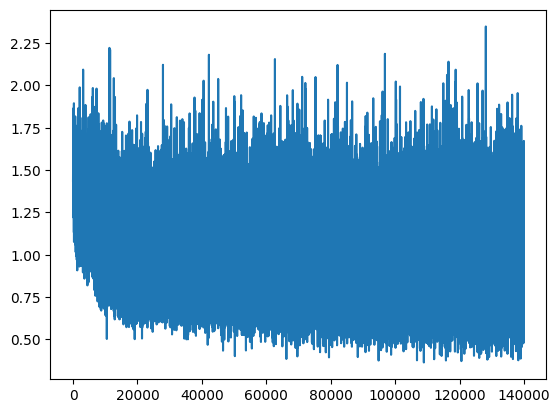

In [39]:
plt.plot(train_losses)

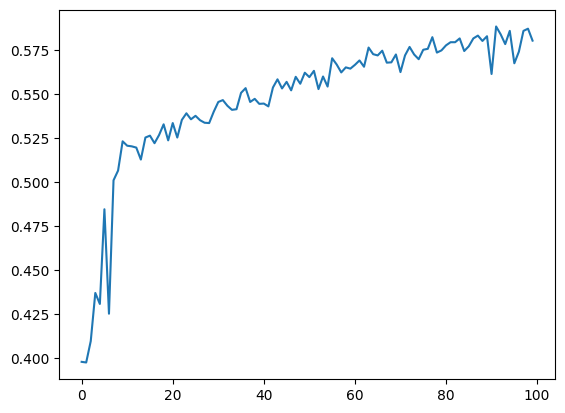

In [40]:
plt.plot(test_accuracy)

In [41]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_esd4/esd4_m13_best_92epoch.pt
Correct: 3294/5600 (0.5882)
{'acc_detail': tensor([0.7093, 0.6343, 0.5807, 0.4286], device='cuda:0'),
 'acc_unweighted': tensor(0.5882, device='cuda:0'),
 'acc_weighted': tensor(0.5882, device='cuda:0'),
 'f1s_detail': tensor([0.6409, 0.6051, 0.6527, 0.4486], device='cuda:0'),
 'f1s_unweighted': tensor(0.5868, device='cuda:0'),
 'f1s_weighted': tensor(0.5868, device='cuda:0'),
 'precision_detail': tensor([0.5845, 0.5785, 0.7452, 0.4706], device='cuda:0'),
 'recall_detail': tensor([0.7093, 0.6343, 0.5807, 0.4286], device='cuda:0'),
 'rocauc_detail': tensor([0.8732, 0.8471, 0.8709, 0.7649], device='cuda:0'),
 'rocauc_unweighted': tensor(0.8390, device='cuda:0'),
 'rocauc_weighted': tensor(0.8390, device='cuda:0'),
 'uar': tensor(0.5882, device='cuda:0'),
 'wap': tensor(0.5947, device='cuda:0')}


tensor([[993,  91,  30, 286],
        [105, 888, 176, 231],
        [131, 298, 813, 158],
        [470, 258,  72, 600]], device='cuda:0')

In [42]:
epoch

100

In [43]:
checkpoint_path = f'../models_esd4/esd4_m13_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

Time domain: Filters' shapes vary by frequency bins


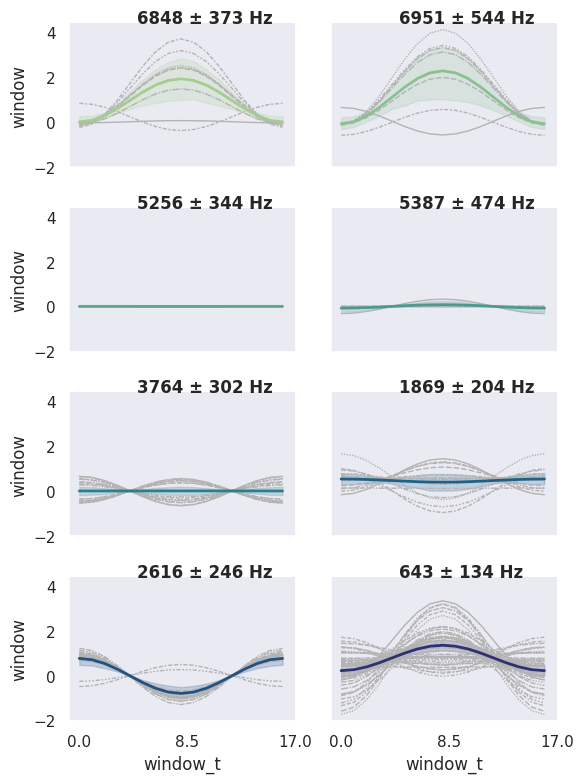

In [44]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


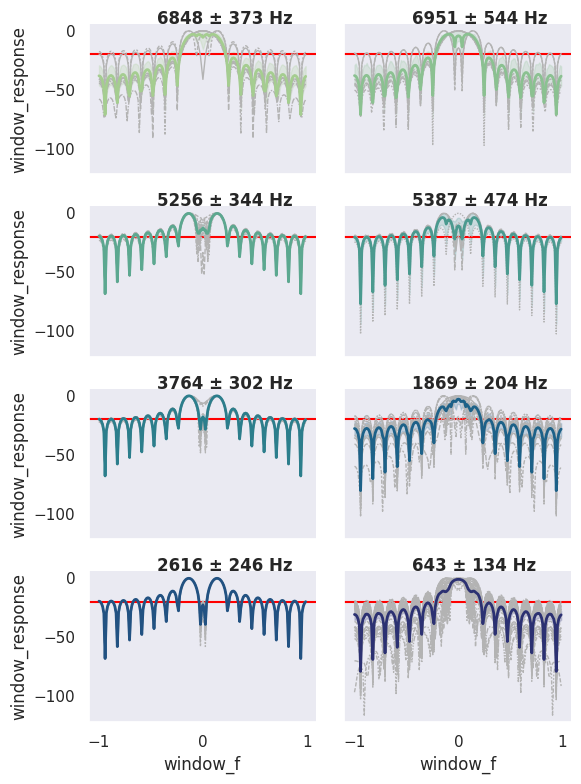

In [45]:
filtviz.visualize_filters(filter_domain='freq')

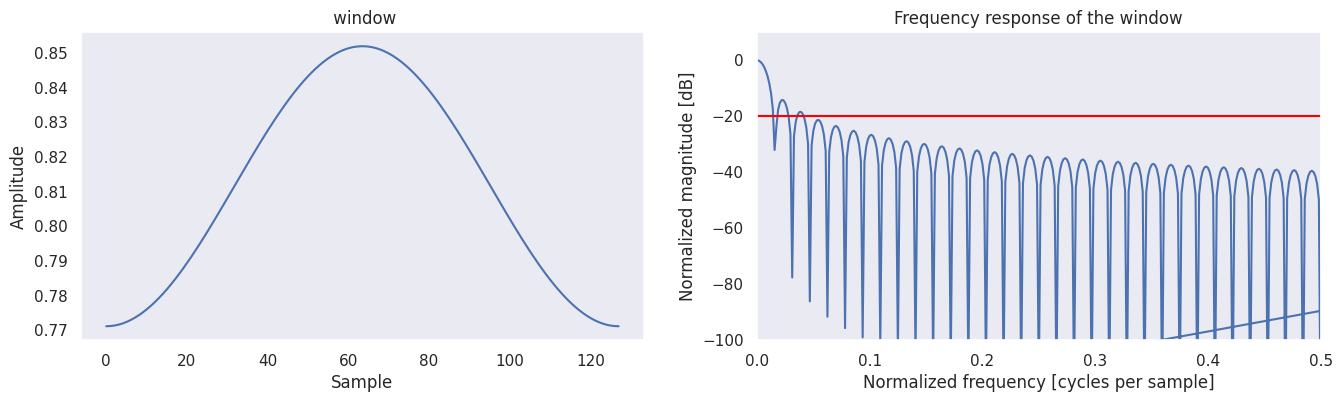

In [46]:
filtviz.visualize_one_window(n_out=10)

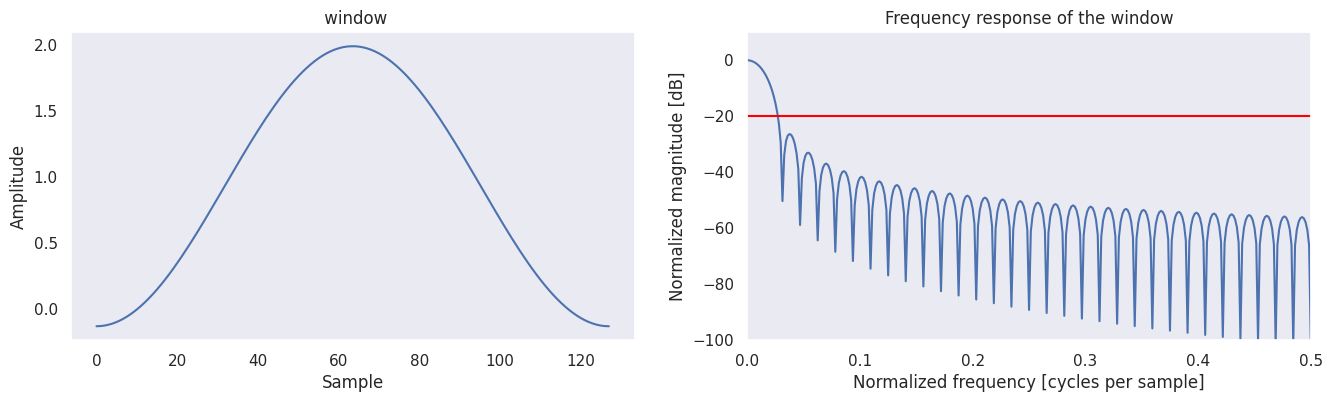

In [47]:
filtviz.visualize_one_window(n_out=30)

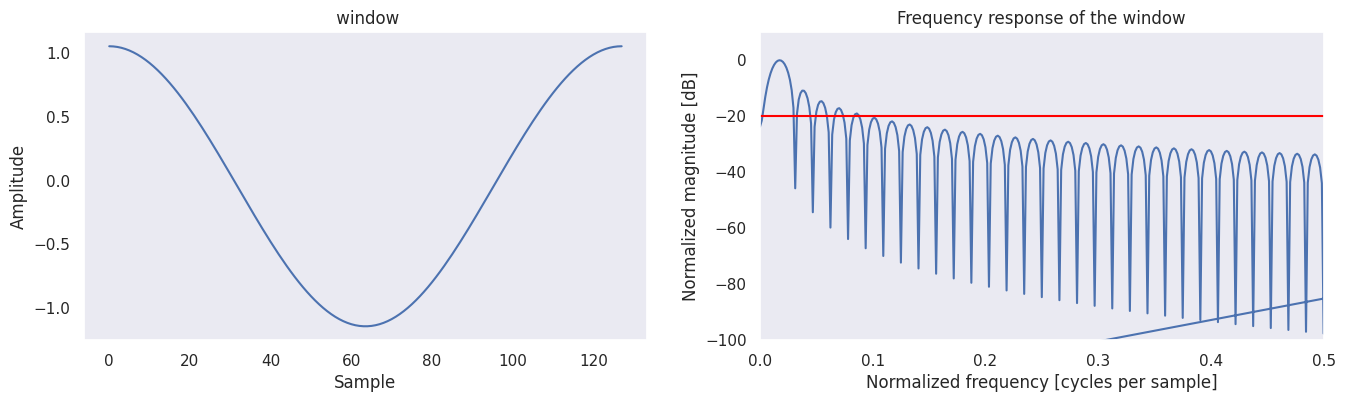

In [48]:
filtviz.visualize_one_window(n_out=50)

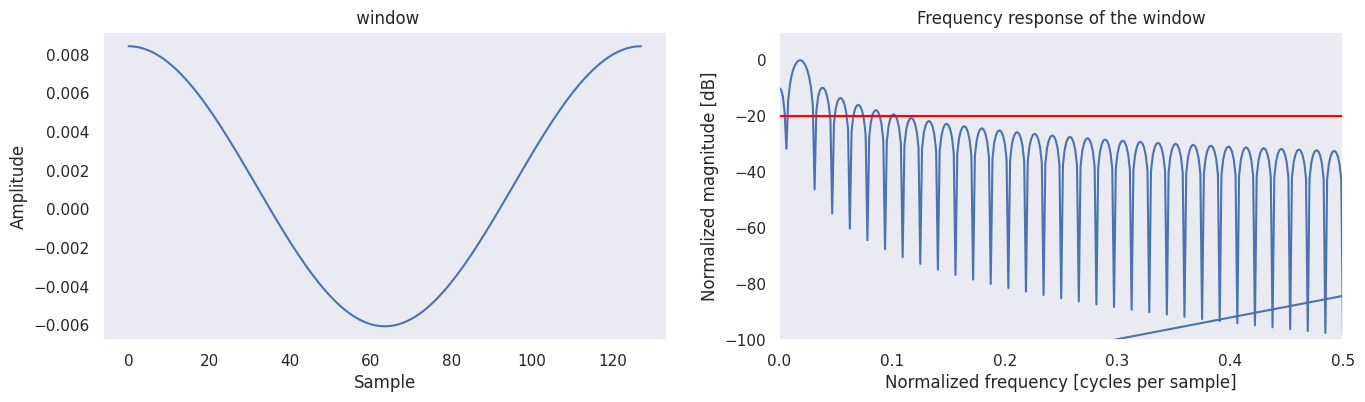

In [49]:
filtviz.visualize_one_window(n_out=60)

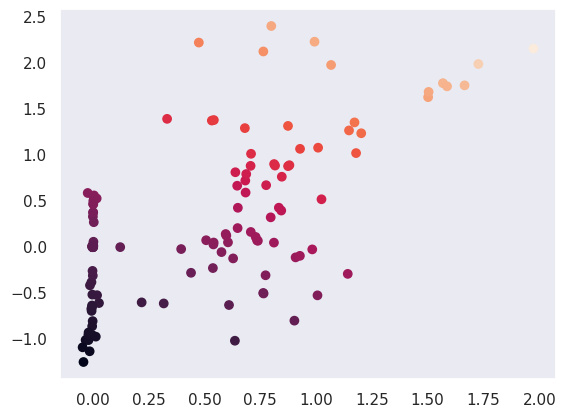

In [52]:
filtviz.visualize_window_params()

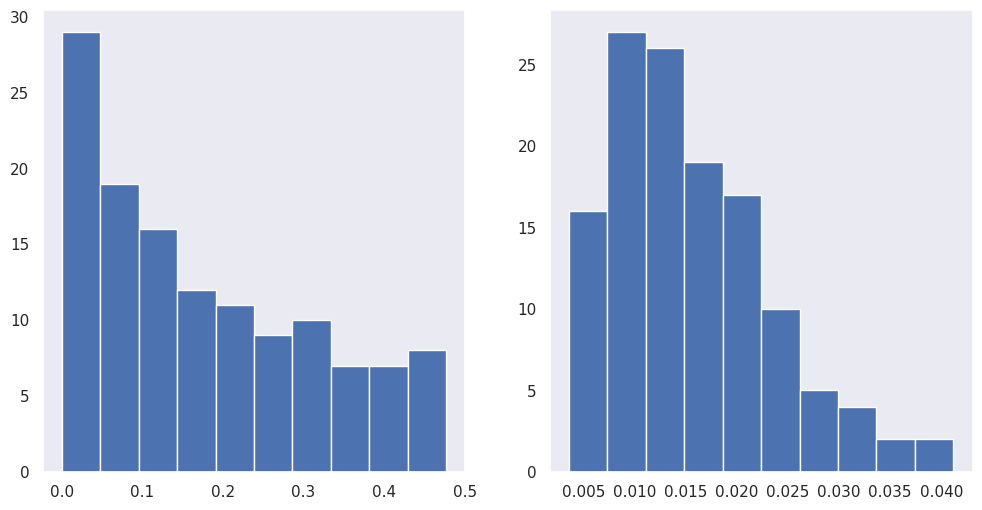

In [53]:
filtviz.visualize_bands()

downsample_factor: 8 => new_sample_rate: 2000
Time domain: Filters' shapes vary by frequency bins


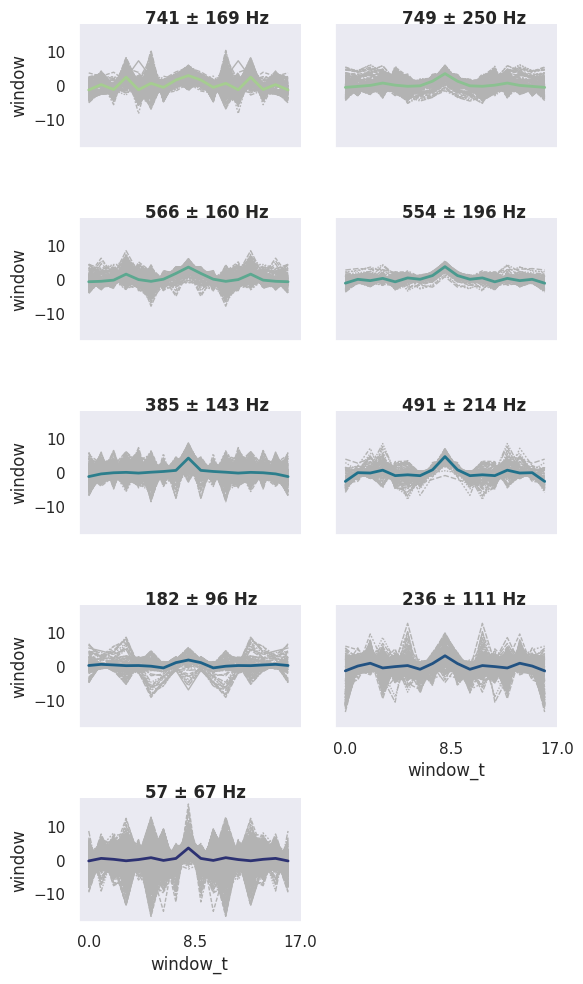

In [50]:
layer2 = best_model.fe_blocks.blocks[1].block.layer
downsample_factor = best_model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


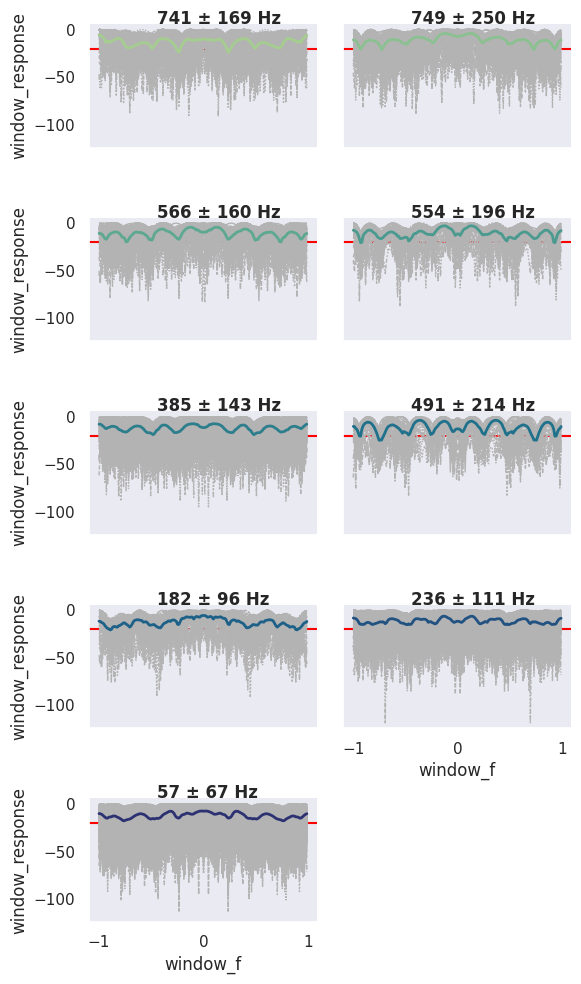

In [51]:
filtviz2.visualize_filters(filter_domain='freq')

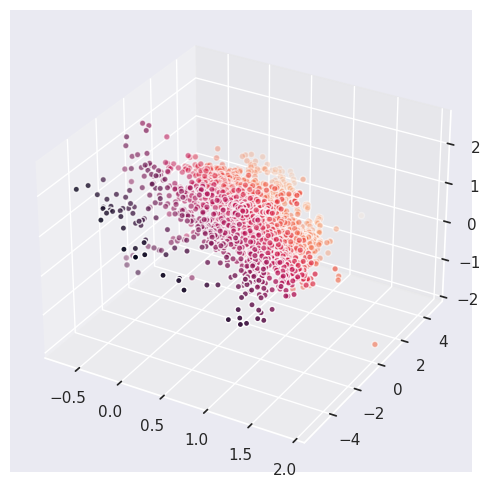

In [54]:
filtviz2.visualize_window_params()

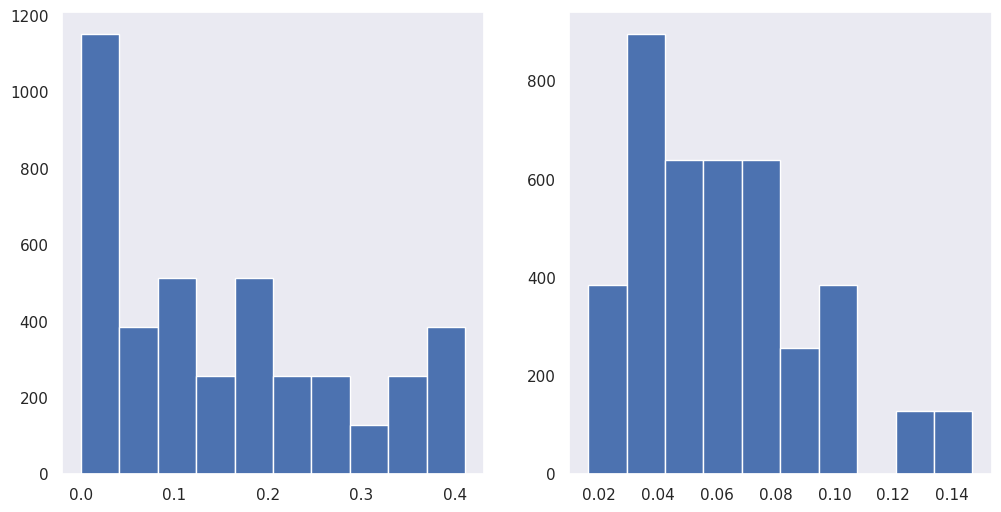

In [55]:
filtviz2.visualize_bands()

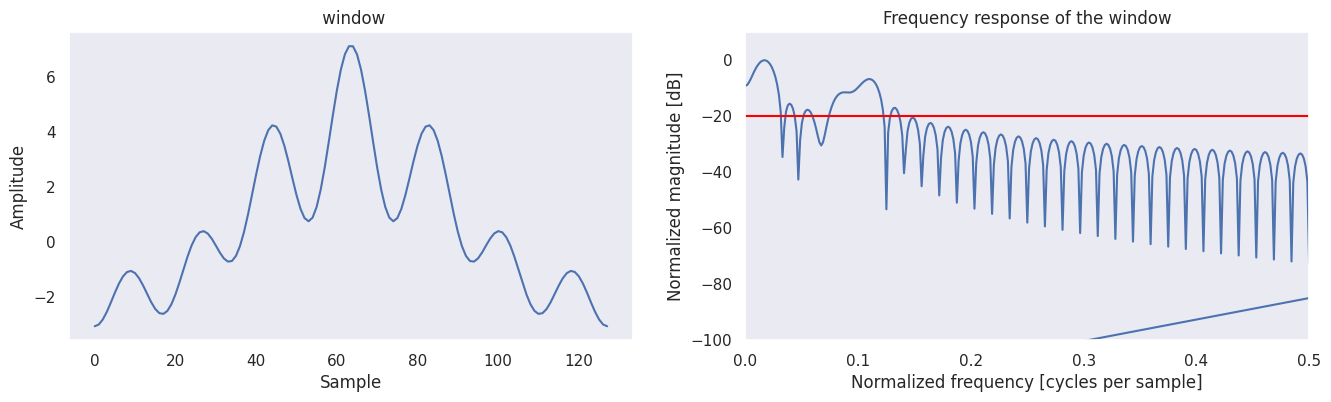

In [56]:
filtviz2.visualize_one_window(n_inp=10, n_out=10)

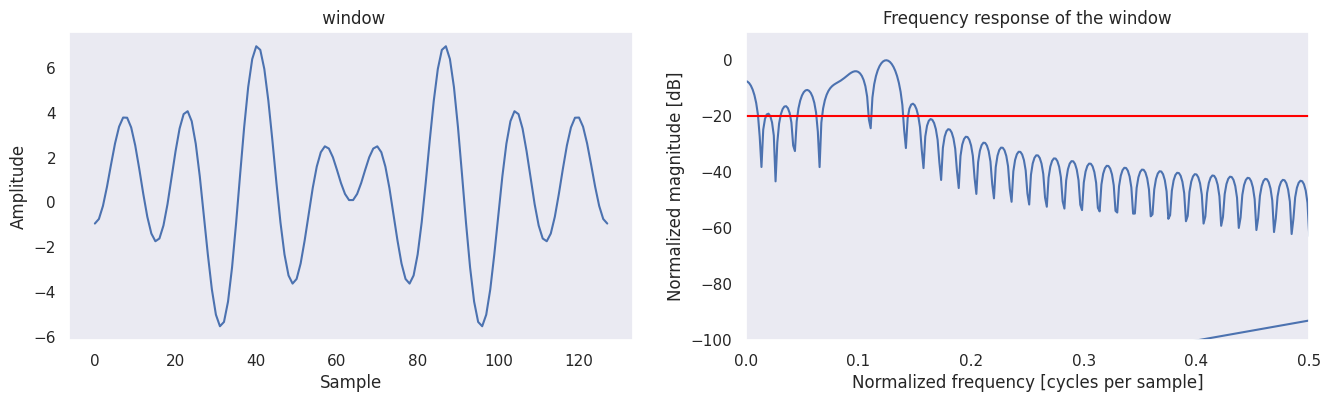

In [57]:
filtviz2.visualize_one_window(n_inp=10, n_out=30)

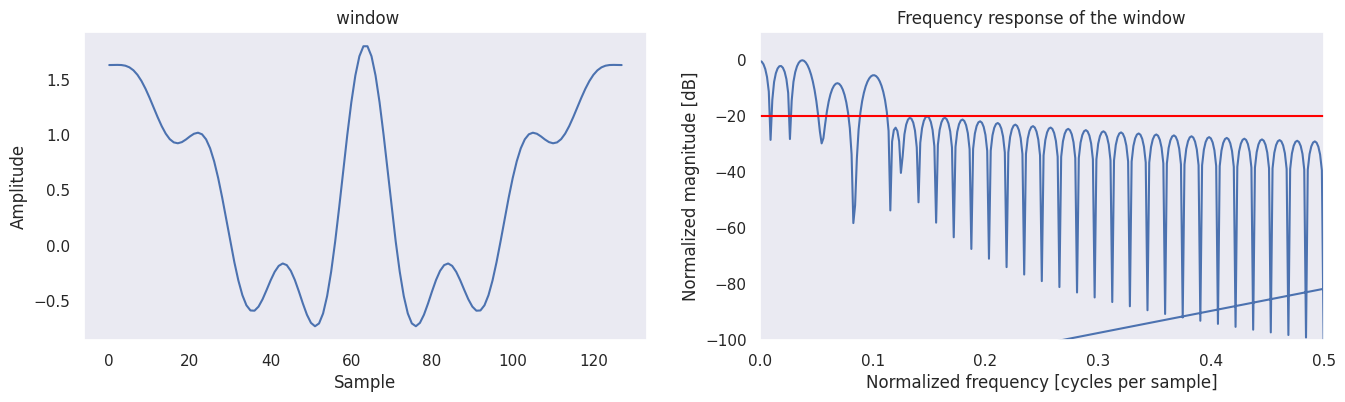

In [60]:
filtviz2.visualize_one_window(n_inp=30, n_out=10)

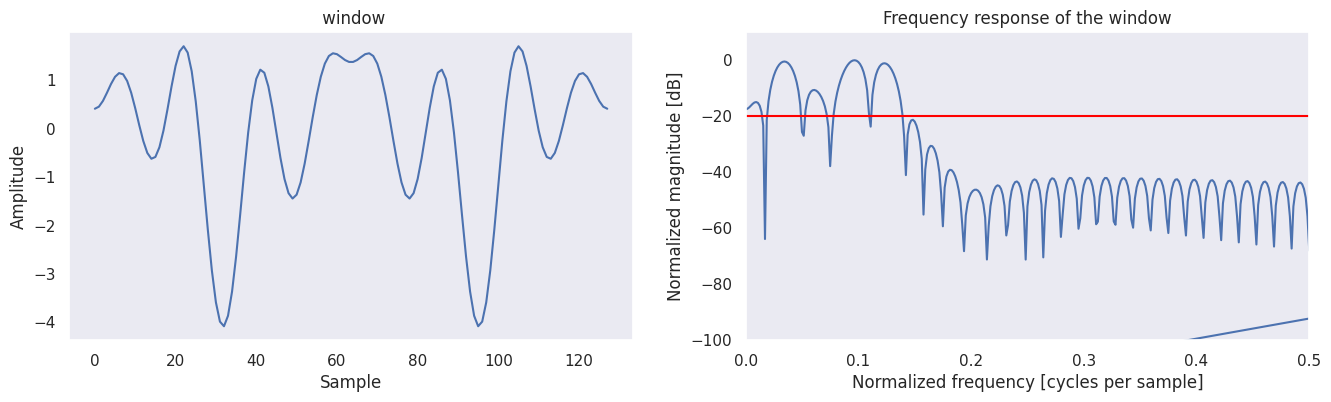

In [61]:
filtviz2.visualize_one_window(n_inp=30, n_out=30)

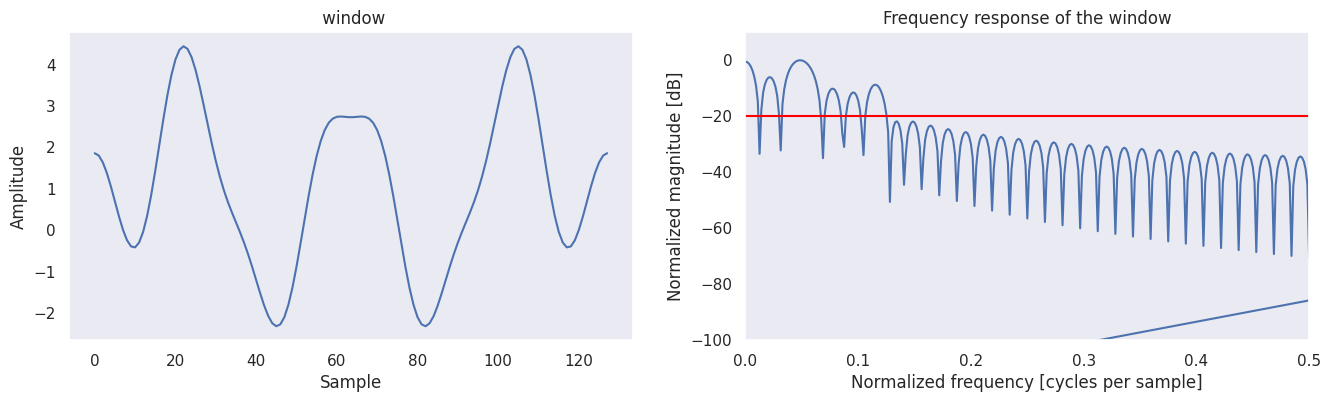

In [58]:
filtviz2.visualize_one_window(n_inp=50, n_out=10)

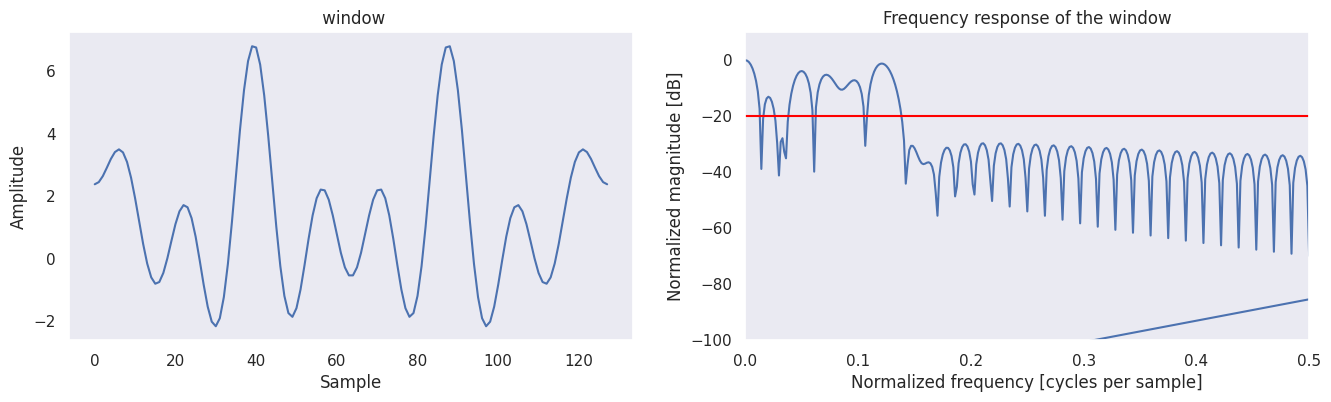

In [59]:
filtviz2.visualize_one_window(n_inp=50, n_out=30)

In [62]:
model.to(device)

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm):

In [66]:
%load_ext autoreload
%autoreload 2

In [68]:
from IConNet.visualizer import display_module

/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  m = int(math.ceil(n/self.stride))


aten::mean %x : Float(1, 161, strides=[161, 1], requires_grad=1, device=cuda:0) = aten::mean(%1638, %1485, %1486, %1487) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



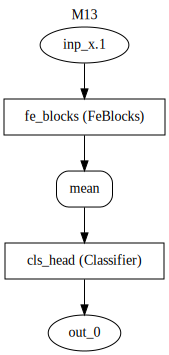

In [71]:
input_shape = (1,1,16000)
model.to(device)
input = torch.rand(input_shape).to(device)
display_module(
    model, input, 
    classes_to_visit={})

/opt/anaconda3/envs/audio/lib/python3.9/site-packages/opt_einsum/contract.py:231: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  dim = int(sh[cnum])
/opt/anaconda3/envs/audio/lib/python3.9/site-packages/opt_einsum/parser.py:155: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  max(shape[loc] for shape, loc in zip(shapes, [x.find(c) for x in inputs]) if loc >= 0) for c in output)
/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flo

aten::mean %x : Float(1, 161, strides=[161, 1], requires_grad=1, device=cuda:0) = aten::mean(%1638, %1485, %1486, %1487) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



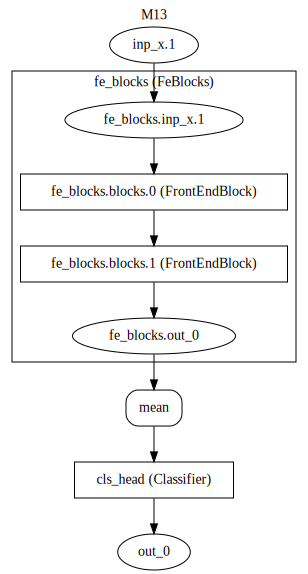

In [72]:
display_module(
    model, input, 
    classes_to_visit={"FeBlocks"})

/opt/anaconda3/envs/audio/lib/python3.9/site-packages/opt_einsum/contract.py:231: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  dim = int(sh[cnum])
/opt/anaconda3/envs/audio/lib/python3.9/site-packages/opt_einsum/parser.py:155: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  max(shape[loc] for shape, loc in zip(shapes, [x.find(c) for x in inputs]) if loc >= 0) for c in output)
/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flo

aten::mean %x : Float(1, 161, strides=[161, 1], requires_grad=1, device=cuda:0) = aten::mean(%1638, %1485, %1486, %1487) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



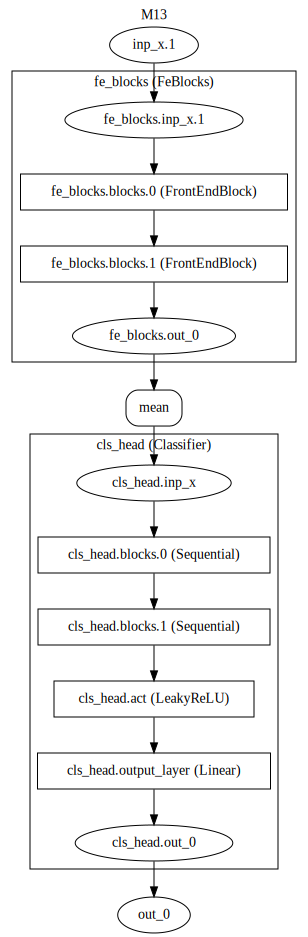

In [73]:
display_module(
    model, input, 
    classes_to_visit={"FeBlocks", "Classifier"})

/opt/anaconda3/envs/audio/lib/python3.9/site-packages/opt_einsum/contract.py:231: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  dim = int(sh[cnum])
/opt/anaconda3/envs/audio/lib/python3.9/site-packages/opt_einsum/parser.py:155: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  max(shape[loc] for shape, loc in zip(shapes, [x.find(c) for x in inputs]) if loc >= 0) for c in output)
/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flo

aten::mean %x : Float(1, 161, strides=[161, 1], requires_grad=1, device=cuda:0) = aten::mean(%1638, %1485, %1486, %1487) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



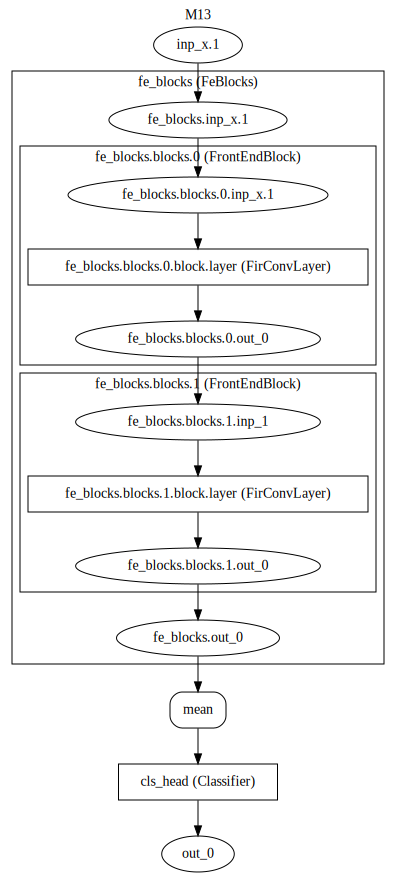

In [74]:
display_module(
    model, input, 
    classes_to_visit={"FeBlocks", "FrontEndBlock"})

/opt/anaconda3/envs/audio/lib/python3.9/site-packages/opt_einsum/contract.py:231: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  dim = int(sh[cnum])
/opt/anaconda3/envs/audio/lib/python3.9/site-packages/opt_einsum/parser.py:155: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  max(shape[loc] for shape, loc in zip(shapes, [x.find(c) for x in inputs]) if loc >= 0) for c in output)
/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flo

aten::mean %x : Float(1, 161, strides=[161, 1], requires_grad=1, device=cuda:0) = aten::mean(%1638, %1485, %1486, %1487) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



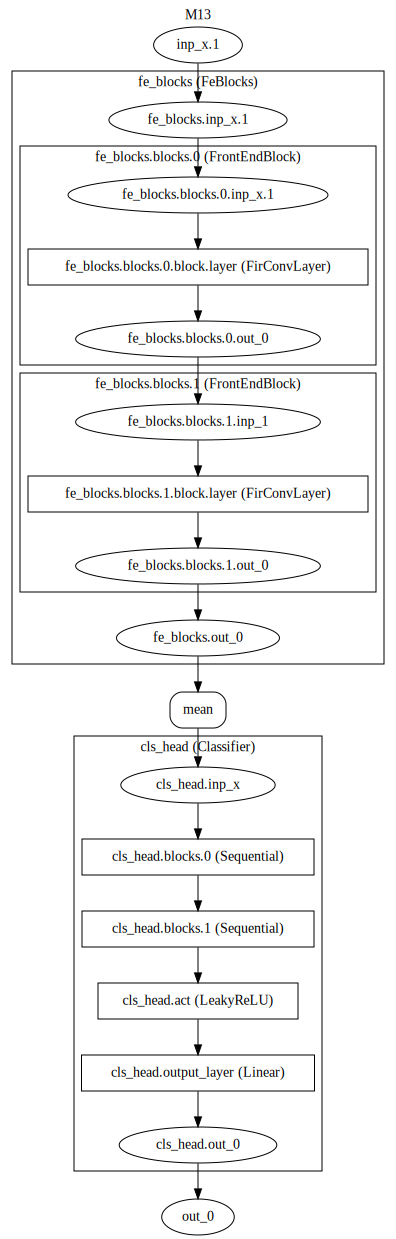

In [75]:
display_module(
    model, input, 
    classes_to_visit={"FeBlocks", "FrontEndBlock", "Classifier"})

In [77]:
# del model
# del best_model
# gc.collect()

389978